In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from scipy import sparse 
from importlib import reload
from matplotlib import pyplot as plt
import sys
#sys.path.append('/home/jma819/post_cmfe_analysis')
sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools
import math
import warnings
import numbers
from multiprocessing import Pool
warnings.filterwarnings(action='once')

/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of 

In [2]:
reload(utils_jjm)
reload(dlc_utils)

<module 'dlc_utils' from '/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/dlc_utils.py'>

In [3]:
cnmfe_file_key = pd.read_csv('/volumes/My_Passport/dlc_analysis/behavcamvideos/cnmfe_file_key.csv')
#cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_file_key.csv')

In [4]:
cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
#cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
wt_CNMFE_file = ['30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                 '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

In [5]:
tracking_files = ['/volumes/My_Passport/dlc_analysis/behavcamvideos/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 
#tracking_files = ['/projects/p30771/dlc_analysis/openfield_dlc_output/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 

In [6]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in wt_CNMFE_file]
#CNMFE_dir_paths_list

In [7]:
binning_time = 1 # seconds 
body_part_for_tracking = 'tail_base' #
number_of_bins = 50 #
polynomial_degree = 2 #

grouped_raw_data = {}
success = []
failed = []
for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # load cell fluorescence 
        cell_fluorescence = sio.loadmat(CNMFE_file)
        C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
        C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
        # create tracking time deltas
        interpolated = utils_jjm.prepare_timedelta_dfs(tracking_file)
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)
        #C_z_scored_filtered = utils_jjm.filter_out_by_size(C_z_scored, cell_contours, for_dims, 0.6, 100)
        #store results 
        grouped_raw_data[tracking_file.split('/')[-2]] = {'C': C_timedelta, 'C_z_scored': C_z_scored, 'C_normalized': C_normalized, 'C_normalized_z_scored': C_normalized_z_scored, 
                                                          'interpolated' : interpolated, 'com' : com_df, 'spatial_components' : spatial_components, 'cell_contours': cell_contours,  
                                                         'for_dims' : for_dims}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

## spatial clustering

In [8]:
## combine dfs for each session to bin velocity values across dfs
#downsample
new_sampling_interval = .2
V_df = pd.concat([grouped_raw_data[session]['interpolated'].resample(str(new_sampling_interval)+'S').max() 
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
all_sessions_v_bins = pd.cut(V_df['tail_base'], bins=50)

V_df['velocity_bins'] = all_sessions_v_bins

In [9]:
# compile and filter fluorescence
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))


# save data as sparse matricies 

In [15]:
#session='GRIN013_H13_M33_S54'

coactivity_by_session = {}

for session in tqdm(list(grouped_raw_data.keys())):
    cells_to_drop = np.array([cell for cell in range(1, len(grouped_raw_data[session]['cell_contours'])+1) if 
                              len(np.array(np.where(grouped_raw_data[session]['for_dims'][cell]>0.6)[0]))<100])
    filtered_centers_of_mass = grouped_raw_data[session]['com'].drop(cells_to_drop, axis =0)
    com_distances = utils_jjm.get_pairwise_distance_by_session(filtered_centers_of_mass)

    ##get binned fluorescence and calc Jaccard scores
    #arguments are sample widths to bin and z score thresholds
    cells_in_session = C_df.loc[session].dropna(axis=1).drop('msCamFrame', axis=1)
    binned_fluorescence = cells_in_session.apply(utils_jjm.binning_function_uncrop, args=[1, 2])

    reindexed = binned_fluorescence.set_index(int(x) for x in np.linspace(0, len(binned_fluorescence)-1, len(binned_fluorescence)))

#cell_keys_matrix = sparse.dok_matrix((1, len(reindexed.columns)*len(reindexed.columns)), dtype=np.float32)
    cell_pairs = np.array([pair for pair in itertools.combinations(list(reindexed.columns), 2)])
    coactivity_in_session = sparse.dok_matrix((len(reindexed), len(cell_pairs)))
    for time_index in tqdm(range(len(reindexed))):
        #coactivity_by_time_point = sparse.dok_matrix((1, len(cell_pairs)), dtype=np.float32)
        for pair, pair_idx in zip(cell_pairs, range(len(cell_pairs))):
            if (reindexed.loc[time_index][pair[0]] == 1) and (reindexed.loc[time_index][pair[1]] == 1):
                coactivity_in_session[time_index, pair_idx] = 1
            else:
                pass 
    
    coactivity_by_session[session]= {'coactivity_in_session': coactivity_in_session, 'cell_pairs':cell_pairs}
        
    




  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 2/6250 [00:00<09:33, 10.90it/s]

  0%|          | 3/6250 [00:00<09:52, 10.55it/s]

  0%|          | 4/6250 [00:00<10:18, 10.09it/s]

  0%|          | 5/6250 [00:00<10:34,  9.84it/s]

  0%|          | 6/6250 [00:00<10:32,  9.88it/s]

  0%|          | 7/6250 [00:00<10:30,  9.90it/s]

  0%|          | 8/6250 [00:00<10:30,  9.89it/s]

  0%|          | 9/6250 [00:00<10:40,  9.74it/s]

  0%|          | 10/6250 [00:01<10:40,  9.75it/s]

  0%|          | 11/6250 [00:01<10:53,  9.54it/s]

  0%|          | 12/6250 [00:01<11:30,  9.04it/s]

  0%|          | 13/6250 [00:01<11:10,  9.30it/s]

  0%|          | 14/6250 [00:01<10:59,  9.46it/s]

  0%|          | 16/6250 [00:01<10:28,  9.92it/s]

  0%|          | 18/6250 [00:01<10:01, 10.37it/s]

  0%|          | 20/6250 [00:01<09:45, 10.65it/s]

  0%|          | 22/6250 [00:02<09:32, 10.88it/s]

  0%|          | 24/6250 [00:02<09:24, 11.02it/s]

  0%|  

  4%|▍         | 245/6250 [00:23<08:22, 11.95it/s]

  4%|▍         | 247/6250 [00:23<08:26, 11.85it/s]

  4%|▍         | 249/6250 [00:23<08:23, 11.91it/s]

  4%|▍         | 251/6250 [00:23<08:25, 11.87it/s]

  4%|▍         | 253/6250 [00:23<08:27, 11.81it/s]

  4%|▍         | 255/6250 [00:23<08:33, 11.67it/s]

  4%|▍         | 257/6250 [00:24<08:40, 11.52it/s]

  4%|▍         | 259/6250 [00:24<08:33, 11.67it/s]

  4%|▍         | 261/6250 [00:24<08:25, 11.85it/s]

  4%|▍         | 263/6250 [00:24<08:39, 11.53it/s]

  4%|▍         | 265/6250 [00:24<08:46, 11.37it/s]

  4%|▍         | 267/6250 [00:25<09:14, 10.80it/s]

  4%|▍         | 269/6250 [00:25<09:20, 10.67it/s]

  4%|▍         | 271/6250 [00:25<09:37, 10.36it/s]

  4%|▍         | 273/6250 [00:25<09:41, 10.28it/s]

  4%|▍         | 275/6250 [00:25<09:33, 10.41it/s]

  4%|▍         | 277/6250 [00:25<09:16, 10.73it/s]

  4%|▍         | 279/6250 [00:26<09:03, 10.99it/s]

  4%|▍         | 281/6250 [00:26<09:49, 10.12it/s]

  5%|▍      

  8%|▊         | 525/6250 [00:47<07:51, 12.14it/s]

  8%|▊         | 527/6250 [00:47<07:51, 12.14it/s]

  8%|▊         | 529/6250 [00:47<07:53, 12.09it/s]

  8%|▊         | 531/6250 [00:47<07:54, 12.06it/s]

  9%|▊         | 533/6250 [00:47<07:55, 12.03it/s]

  9%|▊         | 535/6250 [00:47<07:54, 12.05it/s]

  9%|▊         | 537/6250 [00:48<07:53, 12.06it/s]

  9%|▊         | 539/6250 [00:48<07:59, 11.91it/s]

  9%|▊         | 541/6250 [00:48<08:00, 11.88it/s]

  9%|▊         | 543/6250 [00:48<08:01, 11.86it/s]

  9%|▊         | 545/6250 [00:48<07:58, 11.92it/s]

  9%|▉         | 547/6250 [00:48<08:05, 11.75it/s]

  9%|▉         | 549/6250 [00:49<08:11, 11.60it/s]

  9%|▉         | 551/6250 [00:49<08:09, 11.65it/s]

  9%|▉         | 553/6250 [00:49<08:02, 11.82it/s]

  9%|▉         | 555/6250 [00:49<07:57, 11.92it/s]

  9%|▉         | 557/6250 [00:49<07:57, 11.92it/s]

  9%|▉         | 559/6250 [00:49<07:54, 12.00it/s]

  9%|▉         | 561/6250 [00:50<07:52, 12.03it/s]

  9%|▉      

 13%|█▎        | 807/6250 [01:10<07:29, 12.11it/s]

 13%|█▎        | 809/6250 [01:10<07:30, 12.08it/s]

 13%|█▎        | 811/6250 [01:10<07:29, 12.09it/s]

 13%|█▎        | 813/6250 [01:10<07:29, 12.09it/s]

 13%|█▎        | 815/6250 [01:11<07:31, 12.04it/s]

 13%|█▎        | 817/6250 [01:11<07:30, 12.05it/s]

 13%|█▎        | 819/6250 [01:11<07:33, 11.97it/s]

 13%|█▎        | 821/6250 [01:11<07:31, 12.02it/s]

 13%|█▎        | 823/6250 [01:11<07:30, 12.04it/s]

 13%|█▎        | 825/6250 [01:11<07:30, 12.05it/s]

 13%|█▎        | 827/6250 [01:12<07:29, 12.08it/s]

 13%|█▎        | 829/6250 [01:12<07:29, 12.06it/s]

 13%|█▎        | 831/6250 [01:12<07:35, 11.89it/s]

 13%|█▎        | 833/6250 [01:12<07:35, 11.90it/s]

 13%|█▎        | 835/6250 [01:12<07:31, 11.98it/s]

 13%|█▎        | 837/6250 [01:12<07:29, 12.05it/s]

 13%|█▎        | 839/6250 [01:13<07:30, 12.01it/s]

 13%|█▎        | 841/6250 [01:13<07:27, 12.10it/s]

 13%|█▎        | 843/6250 [01:13<07:26, 12.11it/s]

 14%|█▎     

 17%|█▋        | 1087/6250 [01:33<07:05, 12.13it/s]

 17%|█▋        | 1089/6250 [01:33<07:04, 12.15it/s]

 17%|█▋        | 1091/6250 [01:34<07:11, 11.96it/s]

 17%|█▋        | 1093/6250 [01:34<07:10, 11.97it/s]

 18%|█▊        | 1095/6250 [01:34<07:08, 12.04it/s]

 18%|█▊        | 1097/6250 [01:34<07:05, 12.10it/s]

 18%|█▊        | 1099/6250 [01:34<07:04, 12.12it/s]

 18%|█▊        | 1101/6250 [01:34<07:03, 12.16it/s]

 18%|█▊        | 1103/6250 [01:35<07:01, 12.22it/s]

 18%|█▊        | 1105/6250 [01:35<07:02, 12.19it/s]

 18%|█▊        | 1107/6250 [01:35<07:01, 12.22it/s]

 18%|█▊        | 1109/6250 [01:35<07:01, 12.20it/s]

 18%|█▊        | 1111/6250 [01:35<07:00, 12.22it/s]

 18%|█▊        | 1113/6250 [01:35<06:58, 12.26it/s]

 18%|█▊        | 1115/6250 [01:36<06:59, 12.24it/s]

 18%|█▊        | 1117/6250 [01:36<07:00, 12.20it/s]

 18%|█▊        | 1119/6250 [01:36<07:04, 12.10it/s]

 18%|█▊        | 1121/6250 [01:36<07:04, 12.09it/s]

 18%|█▊        | 1123/6250 [01:36<07:04, 12.09

 22%|██▏       | 1363/6250 [01:56<06:42, 12.14it/s]

 22%|██▏       | 1365/6250 [01:56<06:42, 12.15it/s]

 22%|██▏       | 1367/6250 [01:56<06:40, 12.18it/s]

 22%|██▏       | 1369/6250 [01:56<06:41, 12.15it/s]

 22%|██▏       | 1371/6250 [01:57<06:43, 12.10it/s]

 22%|██▏       | 1373/6250 [01:57<06:43, 12.10it/s]

 22%|██▏       | 1375/6250 [01:57<06:41, 12.14it/s]

 22%|██▏       | 1377/6250 [01:57<06:43, 12.08it/s]

 22%|██▏       | 1379/6250 [01:57<06:42, 12.11it/s]

 22%|██▏       | 1381/6250 [01:57<06:40, 12.15it/s]

 22%|██▏       | 1383/6250 [01:58<06:38, 12.20it/s]

 22%|██▏       | 1385/6250 [01:58<06:39, 12.19it/s]

 22%|██▏       | 1387/6250 [01:58<06:38, 12.20it/s]

 22%|██▏       | 1389/6250 [01:58<06:38, 12.19it/s]

 22%|██▏       | 1391/6250 [01:58<06:38, 12.19it/s]

 22%|██▏       | 1393/6250 [01:58<06:37, 12.23it/s]

 22%|██▏       | 1395/6250 [01:59<06:37, 12.21it/s]

 22%|██▏       | 1397/6250 [01:59<06:39, 12.15it/s]

 22%|██▏       | 1399/6250 [01:59<06:44, 11.99

 26%|██▌       | 1635/6250 [02:19<06:22, 12.06it/s]

 26%|██▌       | 1637/6250 [02:19<06:23, 12.04it/s]

 26%|██▌       | 1639/6250 [02:19<06:27, 11.90it/s]

 26%|██▋       | 1641/6250 [02:20<06:24, 11.98it/s]

 26%|██▋       | 1643/6250 [02:20<06:23, 12.00it/s]

 26%|██▋       | 1645/6250 [02:20<06:25, 11.96it/s]

 26%|██▋       | 1647/6250 [02:20<06:25, 11.94it/s]

 26%|██▋       | 1649/6250 [02:20<06:24, 11.97it/s]

 26%|██▋       | 1651/6250 [02:20<06:22, 12.02it/s]

 26%|██▋       | 1653/6250 [02:21<06:20, 12.09it/s]

 26%|██▋       | 1655/6250 [02:21<06:27, 11.87it/s]

 27%|██▋       | 1657/6250 [02:21<06:30, 11.77it/s]

 27%|██▋       | 1659/6250 [02:21<06:38, 11.53it/s]

 27%|██▋       | 1661/6250 [02:21<06:37, 11.54it/s]

 27%|██▋       | 1663/6250 [02:21<06:41, 11.43it/s]

 27%|██▋       | 1665/6250 [02:22<06:38, 11.51it/s]

 27%|██▋       | 1667/6250 [02:22<06:40, 11.44it/s]

 27%|██▋       | 1669/6250 [02:22<06:42, 11.38it/s]

 27%|██▋       | 1671/6250 [02:22<06:44, 11.32

 31%|███       | 1911/6250 [02:43<05:59, 12.06it/s]

 31%|███       | 1913/6250 [02:43<05:59, 12.08it/s]

 31%|███       | 1915/6250 [02:43<05:59, 12.06it/s]

 31%|███       | 1917/6250 [02:43<05:59, 12.04it/s]

 31%|███       | 1919/6250 [02:43<05:57, 12.11it/s]

 31%|███       | 1921/6250 [02:44<05:58, 12.08it/s]

 31%|███       | 1923/6250 [02:44<05:59, 12.05it/s]

 31%|███       | 1925/6250 [02:44<05:58, 12.08it/s]

 31%|███       | 1927/6250 [02:44<05:58, 12.07it/s]

 31%|███       | 1929/6250 [02:44<06:00, 11.98it/s]

 31%|███       | 1931/6250 [02:44<06:02, 11.92it/s]

 31%|███       | 1933/6250 [02:45<05:59, 12.02it/s]

 31%|███       | 1935/6250 [02:45<05:59, 12.01it/s]

 31%|███       | 1937/6250 [02:45<06:04, 11.84it/s]

 31%|███       | 1939/6250 [02:45<06:00, 11.95it/s]

 31%|███       | 1941/6250 [02:45<05:58, 12.03it/s]

 31%|███       | 1943/6250 [02:45<05:57, 12.05it/s]

 31%|███       | 1945/6250 [02:46<06:03, 11.85it/s]

 31%|███       | 1947/6250 [02:46<06:19, 11.35

 34%|███▍      | 2156/6250 [03:05<07:45,  8.79it/s]

 35%|███▍      | 2157/6250 [03:05<07:37,  8.95it/s]

 35%|███▍      | 2158/6250 [03:05<07:35,  8.99it/s]

 35%|███▍      | 2159/6250 [03:05<07:48,  8.74it/s]

 35%|███▍      | 2160/6250 [03:05<07:51,  8.67it/s]

 35%|███▍      | 2161/6250 [03:05<07:51,  8.66it/s]

 35%|███▍      | 2162/6250 [03:05<07:50,  8.68it/s]

 35%|███▍      | 2163/6250 [03:06<07:37,  8.94it/s]

 35%|███▍      | 2164/6250 [03:06<07:23,  9.20it/s]

 35%|███▍      | 2165/6250 [03:06<07:25,  9.17it/s]

 35%|███▍      | 2166/6250 [03:06<07:21,  9.26it/s]

 35%|███▍      | 2167/6250 [03:06<07:21,  9.24it/s]

 35%|███▍      | 2169/6250 [03:06<07:06,  9.58it/s]

 35%|███▍      | 2170/6250 [03:06<07:02,  9.66it/s]

 35%|███▍      | 2172/6250 [03:07<06:54,  9.83it/s]

 35%|███▍      | 2173/6250 [03:07<06:57,  9.76it/s]

 35%|███▍      | 2174/6250 [03:07<06:58,  9.74it/s]

 35%|███▍      | 2176/6250 [03:07<06:52,  9.88it/s]

 35%|███▍      | 2177/6250 [03:07<07:00,  9.69

 37%|███▋      | 2316/6250 [03:22<06:30, 10.06it/s]

 37%|███▋      | 2318/6250 [03:22<06:15, 10.48it/s]

 37%|███▋      | 2320/6250 [03:22<06:15, 10.46it/s]

 37%|███▋      | 2322/6250 [03:22<06:23, 10.24it/s]

 37%|███▋      | 2324/6250 [03:23<06:19, 10.35it/s]

 37%|███▋      | 2326/6250 [03:23<06:14, 10.48it/s]

 37%|███▋      | 2328/6250 [03:23<06:18, 10.36it/s]

 37%|███▋      | 2330/6250 [03:23<06:21, 10.28it/s]

 37%|███▋      | 2332/6250 [03:23<06:19, 10.32it/s]

 37%|███▋      | 2334/6250 [03:24<06:23, 10.22it/s]

 37%|███▋      | 2336/6250 [03:24<06:23, 10.20it/s]

 37%|███▋      | 2338/6250 [03:24<06:22, 10.23it/s]

 37%|███▋      | 2340/6250 [03:24<06:28, 10.06it/s]

 37%|███▋      | 2342/6250 [03:24<06:40,  9.76it/s]

 37%|███▋      | 2343/6250 [03:25<06:49,  9.54it/s]

 38%|███▊      | 2344/6250 [03:25<06:59,  9.31it/s]

 38%|███▊      | 2345/6250 [03:25<07:02,  9.24it/s]

 38%|███▊      | 2346/6250 [03:25<07:02,  9.23it/s]

 38%|███▊      | 2347/6250 [03:25<07:06,  9.16

 40%|███▉      | 2489/6250 [03:40<06:42,  9.35it/s]

 40%|███▉      | 2490/6250 [03:40<06:46,  9.25it/s]

 40%|███▉      | 2491/6250 [03:40<06:49,  9.18it/s]

 40%|███▉      | 2492/6250 [03:40<06:49,  9.18it/s]

 40%|███▉      | 2493/6250 [03:40<06:50,  9.15it/s]

 40%|███▉      | 2494/6250 [03:41<06:49,  9.16it/s]

 40%|███▉      | 2495/6250 [03:41<06:47,  9.21it/s]

 40%|███▉      | 2496/6250 [03:41<06:54,  9.05it/s]

 40%|███▉      | 2497/6250 [03:41<06:53,  9.07it/s]

 40%|███▉      | 2498/6250 [03:41<06:59,  8.95it/s]

 40%|███▉      | 2499/6250 [03:41<07:04,  8.84it/s]

 40%|████      | 2500/6250 [03:41<07:01,  8.89it/s]

 40%|████      | 2502/6250 [03:41<06:41,  9.33it/s]

 40%|████      | 2504/6250 [03:42<06:22,  9.78it/s]

 40%|████      | 2506/6250 [03:42<06:02, 10.34it/s]

 40%|████      | 2508/6250 [03:42<05:50, 10.68it/s]

 40%|████      | 2510/6250 [03:42<05:58, 10.43it/s]

 40%|████      | 2512/6250 [03:42<06:02, 10.31it/s]

 40%|████      | 2514/6250 [03:43<05:59, 10.39

 44%|████▍     | 2754/6250 [04:03<04:47, 12.15it/s]

 44%|████▍     | 2756/6250 [04:03<04:48, 12.13it/s]

 44%|████▍     | 2758/6250 [04:03<04:48, 12.10it/s]

 44%|████▍     | 2760/6250 [04:03<04:49, 12.06it/s]

 44%|████▍     | 2762/6250 [04:03<04:49, 12.06it/s]

 44%|████▍     | 2764/6250 [04:04<04:50, 12.02it/s]

 44%|████▍     | 2766/6250 [04:04<04:51, 11.94it/s]

 44%|████▍     | 2768/6250 [04:04<04:52, 11.90it/s]

 44%|████▍     | 2770/6250 [04:04<04:53, 11.88it/s]

 44%|████▍     | 2772/6250 [04:04<05:03, 11.44it/s]

 44%|████▍     | 2774/6250 [04:04<05:04, 11.41it/s]

 44%|████▍     | 2776/6250 [04:05<05:01, 11.53it/s]

 44%|████▍     | 2778/6250 [04:05<04:59, 11.59it/s]

 44%|████▍     | 2780/6250 [04:05<05:00, 11.54it/s]

 45%|████▍     | 2782/6250 [04:05<05:00, 11.53it/s]

 45%|████▍     | 2784/6250 [04:05<04:56, 11.68it/s]

 45%|████▍     | 2786/6250 [04:06<04:53, 11.81it/s]

 45%|████▍     | 2788/6250 [04:06<04:51, 11.90it/s]

 45%|████▍     | 2790/6250 [04:06<04:51, 11.87

 48%|████▊     | 3030/6250 [04:26<04:28, 12.01it/s]

 49%|████▊     | 3032/6250 [04:26<04:27, 12.02it/s]

 49%|████▊     | 3034/6250 [04:26<04:29, 11.95it/s]

 49%|████▊     | 3036/6250 [04:26<04:27, 12.02it/s]

 49%|████▊     | 3038/6250 [04:27<04:30, 11.85it/s]

 49%|████▊     | 3040/6250 [04:27<04:31, 11.80it/s]

 49%|████▊     | 3042/6250 [04:27<04:30, 11.88it/s]

 49%|████▊     | 3044/6250 [04:27<04:27, 12.00it/s]

 49%|████▊     | 3046/6250 [04:27<04:28, 11.95it/s]

 49%|████▉     | 3048/6250 [04:27<04:28, 11.91it/s]

 49%|████▉     | 3050/6250 [04:28<04:34, 11.68it/s]

 49%|████▉     | 3052/6250 [04:28<04:31, 11.79it/s]

 49%|████▉     | 3054/6250 [04:28<04:40, 11.38it/s]

 49%|████▉     | 3056/6250 [04:28<04:40, 11.37it/s]

 49%|████▉     | 3058/6250 [04:28<04:35, 11.57it/s]

 49%|████▉     | 3060/6250 [04:28<04:32, 11.72it/s]

 49%|████▉     | 3062/6250 [04:29<04:29, 11.82it/s]

 49%|████▉     | 3064/6250 [04:29<04:27, 11.89it/s]

 49%|████▉     | 3066/6250 [04:29<04:25, 11.99

 53%|█████▎    | 3286/6250 [04:49<04:16, 11.55it/s]

 53%|█████▎    | 3288/6250 [04:49<04:18, 11.45it/s]

 53%|█████▎    | 3290/6250 [04:49<04:15, 11.58it/s]

 53%|█████▎    | 3292/6250 [04:49<04:16, 11.55it/s]

 53%|█████▎    | 3294/6250 [04:50<04:12, 11.72it/s]

 53%|█████▎    | 3296/6250 [04:50<04:15, 11.55it/s]

 53%|█████▎    | 3298/6250 [04:50<04:18, 11.44it/s]

 53%|█████▎    | 3300/6250 [04:50<04:18, 11.39it/s]

 53%|█████▎    | 3302/6250 [04:50<04:22, 11.23it/s]

 53%|█████▎    | 3304/6250 [04:50<04:22, 11.21it/s]

 53%|█████▎    | 3306/6250 [04:51<04:24, 11.13it/s]

 53%|█████▎    | 3308/6250 [04:51<04:25, 11.08it/s]

 53%|█████▎    | 3310/6250 [04:51<04:21, 11.26it/s]

 53%|█████▎    | 3312/6250 [04:51<04:27, 11.00it/s]

 53%|█████▎    | 3314/6250 [04:51<04:26, 11.00it/s]

 53%|█████▎    | 3316/6250 [04:51<04:25, 11.04it/s]

 53%|█████▎    | 3318/6250 [04:52<04:25, 11.03it/s]

 53%|█████▎    | 3320/6250 [04:52<04:27, 10.95it/s]

 53%|█████▎    | 3322/6250 [04:52<04:26, 10.99

 56%|█████▋    | 3531/6250 [05:12<04:34,  9.91it/s]

 57%|█████▋    | 3532/6250 [05:12<04:34,  9.90it/s]

 57%|█████▋    | 3534/6250 [05:12<04:24, 10.27it/s]

 57%|█████▋    | 3536/6250 [05:12<04:20, 10.41it/s]

 57%|█████▋    | 3538/6250 [05:13<04:16, 10.59it/s]

 57%|█████▋    | 3540/6250 [05:13<04:09, 10.86it/s]

 57%|█████▋    | 3542/6250 [05:13<04:01, 11.19it/s]

 57%|█████▋    | 3544/6250 [05:13<03:56, 11.43it/s]

 57%|█████▋    | 3546/6250 [05:13<03:51, 11.67it/s]

 57%|█████▋    | 3548/6250 [05:13<03:48, 11.84it/s]

 57%|█████▋    | 3550/6250 [05:14<03:46, 11.93it/s]

 57%|█████▋    | 3552/6250 [05:14<03:44, 12.02it/s]

 57%|█████▋    | 3554/6250 [05:14<03:43, 12.07it/s]

 57%|█████▋    | 3556/6250 [05:14<03:42, 12.11it/s]

 57%|█████▋    | 3558/6250 [05:14<03:42, 12.12it/s]

 57%|█████▋    | 3560/6250 [05:14<03:40, 12.19it/s]

 57%|█████▋    | 3562/6250 [05:15<03:41, 12.16it/s]

 57%|█████▋    | 3564/6250 [05:15<03:40, 12.18it/s]

 57%|█████▋    | 3566/6250 [05:15<03:40, 12.17

 61%|██████    | 3806/6250 [05:35<03:21, 12.10it/s]

 61%|██████    | 3808/6250 [05:35<03:21, 12.11it/s]

 61%|██████    | 3810/6250 [05:35<03:20, 12.14it/s]

 61%|██████    | 3812/6250 [05:36<03:21, 12.12it/s]

 61%|██████    | 3814/6250 [05:36<03:20, 12.15it/s]

 61%|██████    | 3816/6250 [05:36<03:22, 12.03it/s]

 61%|██████    | 3818/6250 [05:36<03:21, 12.05it/s]

 61%|██████    | 3820/6250 [05:36<03:22, 12.02it/s]

 61%|██████    | 3822/6250 [05:36<03:21, 12.07it/s]

 61%|██████    | 3824/6250 [05:37<03:19, 12.15it/s]

 61%|██████    | 3826/6250 [05:37<03:20, 12.07it/s]

 61%|██████    | 3828/6250 [05:37<03:21, 12.00it/s]

 61%|██████▏   | 3830/6250 [05:37<03:21, 12.02it/s]

 61%|██████▏   | 3832/6250 [05:37<03:21, 12.01it/s]

 61%|██████▏   | 3834/6250 [05:37<03:22, 11.91it/s]

 61%|██████▏   | 3836/6250 [05:38<03:20, 12.01it/s]

 61%|██████▏   | 3838/6250 [05:38<03:20, 12.03it/s]

 61%|██████▏   | 3840/6250 [05:38<03:20, 12.01it/s]

 61%|██████▏   | 3842/6250 [05:38<03:23, 11.82

 65%|██████▌   | 4078/6250 [05:58<02:57, 12.22it/s]

 65%|██████▌   | 4080/6250 [05:58<02:56, 12.27it/s]

 65%|██████▌   | 4082/6250 [05:58<02:57, 12.21it/s]

 65%|██████▌   | 4084/6250 [05:58<03:01, 11.92it/s]

 65%|██████▌   | 4086/6250 [05:59<03:05, 11.66it/s]

 65%|██████▌   | 4088/6250 [05:59<03:09, 11.43it/s]

 65%|██████▌   | 4090/6250 [05:59<03:09, 11.38it/s]

 65%|██████▌   | 4092/6250 [05:59<03:09, 11.37it/s]

 66%|██████▌   | 4094/6250 [05:59<03:08, 11.42it/s]

 66%|██████▌   | 4096/6250 [06:00<03:06, 11.54it/s]

 66%|██████▌   | 4098/6250 [06:00<03:05, 11.60it/s]

 66%|██████▌   | 4100/6250 [06:00<03:04, 11.67it/s]

 66%|██████▌   | 4102/6250 [06:00<03:03, 11.71it/s]

 66%|██████▌   | 4104/6250 [06:00<03:01, 11.82it/s]

 66%|██████▌   | 4106/6250 [06:00<02:59, 11.97it/s]

 66%|██████▌   | 4108/6250 [06:01<02:58, 11.97it/s]

 66%|██████▌   | 4110/6250 [06:01<03:00, 11.87it/s]

 66%|██████▌   | 4112/6250 [06:01<03:02, 11.72it/s]

 66%|██████▌   | 4114/6250 [06:01<03:00, 11.85

 70%|██████▉   | 4354/6250 [06:21<02:34, 12.31it/s]

 70%|██████▉   | 4356/6250 [06:21<02:34, 12.24it/s]

 70%|██████▉   | 4358/6250 [06:21<02:34, 12.28it/s]

 70%|██████▉   | 4360/6250 [06:21<02:33, 12.34it/s]

 70%|██████▉   | 4362/6250 [06:21<02:32, 12.37it/s]

 70%|██████▉   | 4364/6250 [06:22<02:32, 12.38it/s]

 70%|██████▉   | 4366/6250 [06:22<02:31, 12.40it/s]

 70%|██████▉   | 4368/6250 [06:22<02:32, 12.34it/s]

 70%|██████▉   | 4370/6250 [06:22<02:34, 12.18it/s]

 70%|██████▉   | 4372/6250 [06:22<02:33, 12.20it/s]

 70%|██████▉   | 4374/6250 [06:22<02:33, 12.21it/s]

 70%|███████   | 4376/6250 [06:23<02:33, 12.21it/s]

 70%|███████   | 4378/6250 [06:23<02:32, 12.25it/s]

 70%|███████   | 4380/6250 [06:23<02:32, 12.28it/s]

 70%|███████   | 4382/6250 [06:23<02:32, 12.23it/s]

 70%|███████   | 4384/6250 [06:23<02:37, 11.86it/s]

 70%|███████   | 4386/6250 [06:23<02:38, 11.75it/s]

 70%|███████   | 4388/6250 [06:24<02:39, 11.69it/s]

 70%|███████   | 4390/6250 [06:24<02:38, 11.74

 74%|███████▍  | 4630/6250 [06:44<02:12, 12.21it/s]

 74%|███████▍  | 4632/6250 [06:44<02:11, 12.30it/s]

 74%|███████▍  | 4634/6250 [06:44<02:11, 12.30it/s]

 74%|███████▍  | 4636/6250 [06:44<02:10, 12.34it/s]

 74%|███████▍  | 4638/6250 [06:44<02:10, 12.37it/s]

 74%|███████▍  | 4640/6250 [06:44<02:10, 12.37it/s]

 74%|███████▍  | 4642/6250 [06:45<02:10, 12.33it/s]

 74%|███████▍  | 4644/6250 [06:45<02:10, 12.26it/s]

 74%|███████▍  | 4646/6250 [06:45<02:10, 12.27it/s]

 74%|███████▍  | 4648/6250 [06:45<02:10, 12.29it/s]

 74%|███████▍  | 4650/6250 [06:45<02:10, 12.29it/s]

 74%|███████▍  | 4652/6250 [06:45<02:09, 12.34it/s]

 74%|███████▍  | 4654/6250 [06:46<02:09, 12.31it/s]

 74%|███████▍  | 4656/6250 [06:46<02:09, 12.35it/s]

 75%|███████▍  | 4658/6250 [06:46<02:09, 12.30it/s]

 75%|███████▍  | 4660/6250 [06:46<02:08, 12.34it/s]

 75%|███████▍  | 4662/6250 [06:46<02:08, 12.32it/s]

 75%|███████▍  | 4664/6250 [06:46<02:09, 12.28it/s]

 75%|███████▍  | 4666/6250 [06:47<02:08, 12.32

 78%|███████▊  | 4906/6250 [07:06<01:52, 11.95it/s]

 79%|███████▊  | 4908/6250 [07:06<01:50, 12.10it/s]

 79%|███████▊  | 4910/6250 [07:06<01:49, 12.21it/s]

 79%|███████▊  | 4912/6250 [07:07<01:49, 12.24it/s]

 79%|███████▊  | 4914/6250 [07:07<01:48, 12.31it/s]

 79%|███████▊  | 4916/6250 [07:07<01:48, 12.32it/s]

 79%|███████▊  | 4918/6250 [07:07<01:47, 12.35it/s]

 79%|███████▊  | 4920/6250 [07:07<01:47, 12.39it/s]

 79%|███████▉  | 4922/6250 [07:07<01:47, 12.40it/s]

 79%|███████▉  | 4924/6250 [07:08<01:47, 12.36it/s]

 79%|███████▉  | 4926/6250 [07:08<01:48, 12.21it/s]

 79%|███████▉  | 4928/6250 [07:08<01:48, 12.16it/s]

 79%|███████▉  | 4930/6250 [07:08<01:49, 12.08it/s]

 79%|███████▉  | 4932/6250 [07:08<01:53, 11.56it/s]

 79%|███████▉  | 4934/6250 [07:08<01:54, 11.48it/s]

 79%|███████▉  | 4936/6250 [07:09<01:54, 11.48it/s]

 79%|███████▉  | 4938/6250 [07:09<01:56, 11.28it/s]

 79%|███████▉  | 4940/6250 [07:09<01:52, 11.61it/s]

 79%|███████▉  | 4942/6250 [07:09<01:50, 11.82

 83%|████████▎ | 5182/6250 [07:29<01:31, 11.65it/s]

 83%|████████▎ | 5184/6250 [07:29<01:30, 11.72it/s]

 83%|████████▎ | 5186/6250 [07:29<01:31, 11.61it/s]

 83%|████████▎ | 5188/6250 [07:30<01:30, 11.70it/s]

 83%|████████▎ | 5190/6250 [07:30<01:30, 11.67it/s]

 83%|████████▎ | 5192/6250 [07:30<01:31, 11.60it/s]

 83%|████████▎ | 5194/6250 [07:30<01:31, 11.56it/s]

 83%|████████▎ | 5196/6250 [07:30<01:31, 11.53it/s]

 83%|████████▎ | 5198/6250 [07:30<01:30, 11.60it/s]

 83%|████████▎ | 5200/6250 [07:31<01:30, 11.56it/s]

 83%|████████▎ | 5202/6250 [07:31<01:30, 11.58it/s]

 83%|████████▎ | 5204/6250 [07:31<01:32, 11.36it/s]

 83%|████████▎ | 5206/6250 [07:31<01:31, 11.46it/s]

 83%|████████▎ | 5208/6250 [07:31<01:31, 11.39it/s]

 83%|████████▎ | 5210/6250 [07:32<01:30, 11.46it/s]

 83%|████████▎ | 5212/6250 [07:32<01:29, 11.56it/s]

 83%|████████▎ | 5214/6250 [07:32<01:27, 11.80it/s]

 83%|████████▎ | 5216/6250 [07:32<01:27, 11.82it/s]

 83%|████████▎ | 5218/6250 [07:32<01:27, 11.86

 87%|████████▋ | 5458/6250 [07:53<01:08, 11.51it/s]

 87%|████████▋ | 5460/6250 [07:53<01:09, 11.42it/s]

 87%|████████▋ | 5462/6250 [07:53<01:09, 11.42it/s]

 87%|████████▋ | 5464/6250 [07:54<01:08, 11.44it/s]

 87%|████████▋ | 5466/6250 [07:54<01:08, 11.52it/s]

 87%|████████▋ | 5468/6250 [07:54<01:08, 11.50it/s]

 88%|████████▊ | 5470/6250 [07:54<01:07, 11.57it/s]

 88%|████████▊ | 5472/6250 [07:54<01:07, 11.46it/s]

 88%|████████▊ | 5474/6250 [07:54<01:08, 11.33it/s]

 88%|████████▊ | 5476/6250 [07:55<01:08, 11.35it/s]

 88%|████████▊ | 5478/6250 [07:55<01:08, 11.30it/s]

 88%|████████▊ | 5480/6250 [07:55<01:11, 10.79it/s]

 88%|████████▊ | 5482/6250 [07:55<01:12, 10.61it/s]

 88%|████████▊ | 5484/6250 [07:55<01:12, 10.52it/s]

 88%|████████▊ | 5486/6250 [07:56<01:12, 10.56it/s]

 88%|████████▊ | 5488/6250 [07:56<01:10, 10.76it/s]

 88%|████████▊ | 5490/6250 [07:56<01:09, 10.94it/s]

 88%|████████▊ | 5492/6250 [07:56<01:08, 11.04it/s]

 88%|████████▊ | 5494/6250 [07:56<01:07, 11.13

 91%|█████████▏| 5717/6250 [08:17<00:49, 10.73it/s]

 92%|█████████▏| 5719/6250 [08:17<00:54,  9.82it/s]

 92%|█████████▏| 5721/6250 [08:17<00:59,  8.85it/s]

 92%|█████████▏| 5722/6250 [08:17<01:01,  8.63it/s]

 92%|█████████▏| 5723/6250 [08:18<01:00,  8.76it/s]

 92%|█████████▏| 5724/6250 [08:18<01:01,  8.61it/s]

 92%|█████████▏| 5725/6250 [08:18<01:00,  8.65it/s]

 92%|█████████▏| 5726/6250 [08:18<00:59,  8.81it/s]

 92%|█████████▏| 5728/6250 [08:18<00:56,  9.29it/s]

 92%|█████████▏| 5729/6250 [08:18<00:57,  9.00it/s]

 92%|█████████▏| 5730/6250 [08:18<00:59,  8.80it/s]

 92%|█████████▏| 5731/6250 [08:18<00:58,  8.81it/s]

 92%|█████████▏| 5732/6250 [08:19<00:58,  8.81it/s]

 92%|█████████▏| 5733/6250 [08:19<00:57,  8.95it/s]

 92%|█████████▏| 5735/6250 [08:19<00:55,  9.22it/s]

 92%|█████████▏| 5736/6250 [08:19<00:55,  9.25it/s]

 92%|█████████▏| 5737/6250 [08:19<00:55,  9.20it/s]

 92%|█████████▏| 5738/6250 [08:19<00:54,  9.33it/s]

 92%|█████████▏| 5739/6250 [08:19<00:54,  9.40

 96%|█████████▌| 5974/6250 [08:41<00:24, 11.26it/s]

 96%|█████████▌| 5976/6250 [08:41<00:24, 11.28it/s]

 96%|█████████▌| 5978/6250 [08:41<00:24, 11.06it/s]

 96%|█████████▌| 5980/6250 [08:41<00:25, 10.57it/s]

 96%|█████████▌| 5982/6250 [08:42<00:25, 10.50it/s]

 96%|█████████▌| 5984/6250 [08:42<00:25, 10.44it/s]

 96%|█████████▌| 5986/6250 [08:42<00:24, 10.63it/s]

 96%|█████████▌| 5988/6250 [08:42<00:24, 10.88it/s]

 96%|█████████▌| 5990/6250 [08:42<00:23, 11.08it/s]

 96%|█████████▌| 5992/6250 [08:43<00:22, 11.27it/s]

 96%|█████████▌| 5994/6250 [08:43<00:22, 11.38it/s]

 96%|█████████▌| 5996/6250 [08:43<00:21, 11.56it/s]

 96%|█████████▌| 5998/6250 [08:43<00:21, 11.59it/s]

 96%|█████████▌| 6000/6250 [08:43<00:21, 11.70it/s]

 96%|█████████▌| 6002/6250 [08:43<00:21, 11.71it/s]

 96%|█████████▌| 6004/6250 [08:44<00:21, 11.35it/s]

 96%|█████████▌| 6006/6250 [08:44<00:21, 11.50it/s]

 96%|█████████▌| 6008/6250 [08:44<00:20, 11.75it/s]

 96%|█████████▌| 6010/6250 [08:44<00:20, 11.62

100%|█████████▉| 6243/6250 [09:05<00:00, 12.16it/s]

100%|█████████▉| 6245/6250 [09:05<00:00, 11.96it/s]

100%|█████████▉| 6247/6250 [09:05<00:00, 11.83it/s]

100%|██████████| 6250/6250 [09:06<00:00, 11.45it/s]

  8%|▊         | 1/13 [09:07<1:49:34, 547.84s/it]

  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 1/6250 [00:00<15:44,  6.62it/s]

  0%|          | 2/6250 [00:00<15:18,  6.80it/s]

  0%|          | 3/6250 [00:00<14:58,  6.95it/s]

  0%|          | 4/6250 [00:00<14:50,  7.01it/s]

  0%|          | 5/6250 [00:00<14:44,  7.06it/s]

  0%|          | 6/6250 [00:00<14:35,  7.13it/s]

  0%|          | 7/6250 [00:00<14:24,  7.22it/s]

  0%|          | 8/6250 [00:01<14:16,  7.29it/s]

  0%|          | 9/6250 [00:01<14:11,  7.33it/s]

  0%|          | 10/6250 [00:01<14:09,  7.34it/s]

  0%|          | 11/6250 [00:01<14:06,  7.37it/s]

  0%|          | 12/6250 [00:01<14:20,  7.25it/s]

  0%|          | 13/6250 [00:01<14:14,  7.29it/s]

  0%|          | 14/6250 [00:01<14:16,  7

  2%|▏         | 138/6250 [00:19<13:53,  7.34it/s]

  2%|▏         | 139/6250 [00:19<14:03,  7.25it/s]

  2%|▏         | 140/6250 [00:19<14:13,  7.16it/s]

  2%|▏         | 141/6250 [00:19<14:10,  7.18it/s]

  2%|▏         | 142/6250 [00:20<14:09,  7.19it/s]

  2%|▏         | 143/6250 [00:20<14:11,  7.17it/s]

  2%|▏         | 144/6250 [00:20<14:12,  7.17it/s]

  2%|▏         | 145/6250 [00:20<14:11,  7.17it/s]

  2%|▏         | 146/6250 [00:20<14:11,  7.16it/s]

  2%|▏         | 147/6250 [00:20<14:10,  7.18it/s]

  2%|▏         | 148/6250 [00:20<14:11,  7.17it/s]

  2%|▏         | 149/6250 [00:21<14:15,  7.13it/s]

  2%|▏         | 150/6250 [00:21<14:05,  7.21it/s]

  2%|▏         | 151/6250 [00:21<13:59,  7.26it/s]

  2%|▏         | 152/6250 [00:21<13:59,  7.26it/s]

  2%|▏         | 153/6250 [00:21<14:30,  7.01it/s]

  2%|▏         | 154/6250 [00:21<14:40,  6.92it/s]

  2%|▏         | 155/6250 [00:21<14:34,  6.97it/s]

  2%|▏         | 156/6250 [00:22<14:54,  6.81it/s]

  3%|▎      

  4%|▍         | 279/6250 [00:39<15:10,  6.56it/s]

  4%|▍         | 280/6250 [00:39<15:03,  6.61it/s]

  4%|▍         | 281/6250 [00:39<14:50,  6.71it/s]

  5%|▍         | 282/6250 [00:39<14:41,  6.77it/s]

  5%|▍         | 283/6250 [00:39<14:12,  7.00it/s]

  5%|▍         | 284/6250 [00:39<14:06,  7.05it/s]

  5%|▍         | 285/6250 [00:40<13:54,  7.15it/s]

  5%|▍         | 286/6250 [00:40<13:47,  7.21it/s]

  5%|▍         | 287/6250 [00:40<13:39,  7.27it/s]

  5%|▍         | 288/6250 [00:40<13:50,  7.18it/s]

  5%|▍         | 289/6250 [00:40<13:50,  7.18it/s]

  5%|▍         | 290/6250 [00:40<13:56,  7.12it/s]

  5%|▍         | 291/6250 [00:40<14:19,  6.94it/s]

  5%|▍         | 292/6250 [00:41<14:11,  7.00it/s]

  5%|▍         | 293/6250 [00:41<14:00,  7.09it/s]

  5%|▍         | 294/6250 [00:41<13:52,  7.16it/s]

  5%|▍         | 295/6250 [00:41<13:42,  7.24it/s]

  5%|▍         | 296/6250 [00:41<13:37,  7.28it/s]

  5%|▍         | 297/6250 [00:41<13:28,  7.36it/s]

  5%|▍      

  7%|▋         | 420/6250 [00:59<14:22,  6.76it/s]

  7%|▋         | 421/6250 [00:59<14:10,  6.85it/s]

  7%|▋         | 422/6250 [00:59<13:59,  6.94it/s]

  7%|▋         | 423/6250 [00:59<13:40,  7.11it/s]

  7%|▋         | 424/6250 [01:00<13:29,  7.19it/s]

  7%|▋         | 425/6250 [01:00<13:33,  7.16it/s]

  7%|▋         | 426/6250 [01:00<13:28,  7.20it/s]

  7%|▋         | 427/6250 [01:00<13:22,  7.26it/s]

  7%|▋         | 428/6250 [01:00<13:18,  7.29it/s]

  7%|▋         | 429/6250 [01:00<13:19,  7.28it/s]

  7%|▋         | 430/6250 [01:00<13:14,  7.33it/s]

  7%|▋         | 431/6250 [01:01<13:20,  7.27it/s]

  7%|▋         | 432/6250 [01:01<13:33,  7.15it/s]

  7%|▋         | 433/6250 [01:01<13:32,  7.16it/s]

  7%|▋         | 434/6250 [01:01<13:33,  7.15it/s]

  7%|▋         | 435/6250 [01:01<13:26,  7.21it/s]

  7%|▋         | 436/6250 [01:01<13:21,  7.25it/s]

  7%|▋         | 437/6250 [01:01<13:17,  7.29it/s]

  7%|▋         | 438/6250 [01:02<13:14,  7.31it/s]

  7%|▋      

  9%|▉         | 561/6250 [01:19<12:53,  7.36it/s]

  9%|▉         | 562/6250 [01:19<12:53,  7.36it/s]

  9%|▉         | 563/6250 [01:19<12:50,  7.38it/s]

  9%|▉         | 564/6250 [01:19<12:44,  7.43it/s]

  9%|▉         | 565/6250 [01:20<12:43,  7.45it/s]

  9%|▉         | 566/6250 [01:20<12:44,  7.43it/s]

  9%|▉         | 567/6250 [01:20<12:43,  7.45it/s]

  9%|▉         | 568/6250 [01:20<12:44,  7.43it/s]

  9%|▉         | 569/6250 [01:20<12:46,  7.41it/s]

  9%|▉         | 570/6250 [01:20<12:42,  7.45it/s]

  9%|▉         | 571/6250 [01:20<12:42,  7.45it/s]

  9%|▉         | 572/6250 [01:21<12:40,  7.46it/s]

  9%|▉         | 573/6250 [01:21<12:40,  7.46it/s]

  9%|▉         | 574/6250 [01:21<12:39,  7.47it/s]

  9%|▉         | 575/6250 [01:21<12:44,  7.42it/s]

  9%|▉         | 576/6250 [01:21<12:46,  7.40it/s]

  9%|▉         | 577/6250 [01:21<12:51,  7.35it/s]

  9%|▉         | 578/6250 [01:21<12:54,  7.32it/s]

  9%|▉         | 579/6250 [01:22<12:52,  7.34it/s]

  9%|▉      

 11%|█         | 702/6250 [01:39<14:29,  6.38it/s]

 11%|█         | 703/6250 [01:39<14:14,  6.49it/s]

 11%|█▏        | 704/6250 [01:39<14:09,  6.53it/s]

 11%|█▏        | 705/6250 [01:39<13:49,  6.68it/s]

 11%|█▏        | 706/6250 [01:39<13:29,  6.85it/s]

 11%|█▏        | 707/6250 [01:39<13:12,  6.99it/s]

 11%|█▏        | 708/6250 [01:39<13:07,  7.04it/s]

 11%|█▏        | 709/6250 [01:40<13:01,  7.09it/s]

 11%|█▏        | 710/6250 [01:40<12:56,  7.14it/s]

 11%|█▏        | 711/6250 [01:40<12:50,  7.19it/s]

 11%|█▏        | 712/6250 [01:40<12:42,  7.27it/s]

 11%|█▏        | 713/6250 [01:40<12:40,  7.28it/s]

 11%|█▏        | 714/6250 [01:40<12:30,  7.38it/s]

 11%|█▏        | 715/6250 [01:40<12:26,  7.41it/s]

 11%|█▏        | 716/6250 [01:41<12:22,  7.45it/s]

 11%|█▏        | 717/6250 [01:41<12:23,  7.44it/s]

 11%|█▏        | 718/6250 [01:41<12:22,  7.45it/s]

 12%|█▏        | 719/6250 [01:41<12:20,  7.47it/s]

 12%|█▏        | 720/6250 [01:41<12:23,  7.44it/s]

 12%|█▏     

 13%|█▎        | 843/6250 [01:58<12:42,  7.09it/s]

 14%|█▎        | 844/6250 [01:58<12:42,  7.09it/s]

 14%|█▎        | 845/6250 [01:58<12:29,  7.21it/s]

 14%|█▎        | 846/6250 [01:59<12:31,  7.19it/s]

 14%|█▎        | 847/6250 [01:59<12:30,  7.20it/s]

 14%|█▎        | 848/6250 [01:59<12:30,  7.19it/s]

 14%|█▎        | 849/6250 [01:59<12:34,  7.16it/s]

 14%|█▎        | 850/6250 [01:59<12:35,  7.14it/s]

 14%|█▎        | 851/6250 [01:59<12:29,  7.20it/s]

 14%|█▎        | 852/6250 [01:59<12:21,  7.28it/s]

 14%|█▎        | 853/6250 [02:00<12:15,  7.34it/s]

 14%|█▎        | 854/6250 [02:00<12:10,  7.39it/s]

 14%|█▎        | 855/6250 [02:00<12:06,  7.42it/s]

 14%|█▎        | 856/6250 [02:00<12:09,  7.39it/s]

 14%|█▎        | 857/6250 [02:00<12:08,  7.40it/s]

 14%|█▎        | 858/6250 [02:00<12:06,  7.43it/s]

 14%|█▎        | 859/6250 [02:00<12:07,  7.41it/s]

 14%|█▍        | 860/6250 [02:01<12:03,  7.45it/s]

 14%|█▍        | 861/6250 [02:01<12:06,  7.42it/s]

 14%|█▍     

 16%|█▌        | 984/6250 [02:18<11:56,  7.35it/s]

 16%|█▌        | 985/6250 [02:18<11:51,  7.40it/s]

 16%|█▌        | 986/6250 [02:18<11:51,  7.40it/s]

 16%|█▌        | 987/6250 [02:18<11:47,  7.44it/s]

 16%|█▌        | 988/6250 [02:18<11:43,  7.48it/s]

 16%|█▌        | 989/6250 [02:19<11:42,  7.49it/s]

 16%|█▌        | 990/6250 [02:19<11:48,  7.42it/s]

 16%|█▌        | 991/6250 [02:19<11:45,  7.46it/s]

 16%|█▌        | 992/6250 [02:19<11:42,  7.48it/s]

 16%|█▌        | 993/6250 [02:19<11:42,  7.48it/s]

 16%|█▌        | 994/6250 [02:19<11:43,  7.48it/s]

 16%|█▌        | 995/6250 [02:19<11:40,  7.50it/s]

 16%|█▌        | 996/6250 [02:19<11:40,  7.50it/s]

 16%|█▌        | 997/6250 [02:20<11:40,  7.50it/s]

 16%|█▌        | 998/6250 [02:20<11:40,  7.50it/s]

 16%|█▌        | 999/6250 [02:20<11:39,  7.51it/s]

 16%|█▌        | 1000/6250 [02:20<11:47,  7.42it/s]

 16%|█▌        | 1001/6250 [02:20<12:01,  7.28it/s]

 16%|█▌        | 1002/6250 [02:20<12:24,  7.05it/s]

 16%|█▌  

 18%|█▊        | 1123/6250 [02:37<11:25,  7.48it/s]

 18%|█▊        | 1124/6250 [02:37<11:27,  7.46it/s]

 18%|█▊        | 1125/6250 [02:38<11:25,  7.47it/s]

 18%|█▊        | 1126/6250 [02:38<11:26,  7.47it/s]

 18%|█▊        | 1127/6250 [02:38<11:25,  7.48it/s]

 18%|█▊        | 1128/6250 [02:38<11:24,  7.48it/s]

 18%|█▊        | 1129/6250 [02:38<11:22,  7.50it/s]

 18%|█▊        | 1130/6250 [02:38<11:23,  7.49it/s]

 18%|█▊        | 1131/6250 [02:38<11:38,  7.33it/s]

 18%|█▊        | 1132/6250 [02:38<11:34,  7.37it/s]

 18%|█▊        | 1133/6250 [02:39<11:32,  7.39it/s]

 18%|█▊        | 1134/6250 [02:39<11:30,  7.41it/s]

 18%|█▊        | 1135/6250 [02:39<11:30,  7.41it/s]

 18%|█▊        | 1136/6250 [02:39<11:32,  7.39it/s]

 18%|█▊        | 1137/6250 [02:39<11:27,  7.44it/s]

 18%|█▊        | 1138/6250 [02:39<11:25,  7.46it/s]

 18%|█▊        | 1139/6250 [02:39<11:26,  7.45it/s]

 18%|█▊        | 1140/6250 [02:40<11:36,  7.33it/s]

 18%|█▊        | 1141/6250 [02:40<11:31,  7.39

 20%|██        | 1261/6250 [02:56<12:29,  6.66it/s]

 20%|██        | 1262/6250 [02:57<12:15,  6.78it/s]

 20%|██        | 1263/6250 [02:57<12:09,  6.83it/s]

 20%|██        | 1264/6250 [02:57<11:55,  6.97it/s]

 20%|██        | 1265/6250 [02:57<11:50,  7.02it/s]

 20%|██        | 1266/6250 [02:57<11:45,  7.06it/s]

 20%|██        | 1267/6250 [02:57<11:42,  7.09it/s]

 20%|██        | 1268/6250 [02:57<11:41,  7.10it/s]

 20%|██        | 1269/6250 [02:58<11:46,  7.05it/s]

 20%|██        | 1270/6250 [02:58<11:49,  7.02it/s]

 20%|██        | 1271/6250 [02:58<11:47,  7.04it/s]

 20%|██        | 1272/6250 [02:58<11:49,  7.01it/s]

 20%|██        | 1273/6250 [02:58<11:52,  6.99it/s]

 20%|██        | 1274/6250 [02:58<11:54,  6.97it/s]

 20%|██        | 1275/6250 [02:58<12:00,  6.91it/s]

 20%|██        | 1276/6250 [02:59<11:53,  6.97it/s]

 20%|██        | 1277/6250 [02:59<12:10,  6.81it/s]

 20%|██        | 1278/6250 [02:59<12:29,  6.63it/s]

 20%|██        | 1279/6250 [02:59<12:16,  6.75

 22%|██▏       | 1399/6250 [03:16<12:50,  6.30it/s]

 22%|██▏       | 1400/6250 [03:16<12:35,  6.42it/s]

 22%|██▏       | 1401/6250 [03:16<12:17,  6.57it/s]

 22%|██▏       | 1402/6250 [03:16<12:00,  6.73it/s]

 22%|██▏       | 1403/6250 [03:16<11:47,  6.85it/s]

 22%|██▏       | 1404/6250 [03:16<11:28,  7.04it/s]

 22%|██▏       | 1405/6250 [03:17<11:30,  7.02it/s]

 22%|██▏       | 1406/6250 [03:17<11:42,  6.89it/s]

 23%|██▎       | 1407/6250 [03:17<11:56,  6.76it/s]

 23%|██▎       | 1408/6250 [03:17<12:05,  6.67it/s]

 23%|██▎       | 1409/6250 [03:17<12:21,  6.53it/s]

 23%|██▎       | 1410/6250 [03:17<12:35,  6.41it/s]

 23%|██▎       | 1411/6250 [03:17<12:42,  6.35it/s]

 23%|██▎       | 1412/6250 [03:18<12:22,  6.52it/s]

 23%|██▎       | 1413/6250 [03:18<11:59,  6.73it/s]

 23%|██▎       | 1414/6250 [03:18<11:42,  6.89it/s]

 23%|██▎       | 1415/6250 [03:18<11:31,  6.99it/s]

 23%|██▎       | 1416/6250 [03:18<11:17,  7.13it/s]

 23%|██▎       | 1417/6250 [03:18<11:15,  7.15

 25%|██▍       | 1537/6250 [03:35<12:13,  6.42it/s]

 25%|██▍       | 1538/6250 [03:36<13:15,  5.93it/s]

 25%|██▍       | 1539/6250 [03:36<13:52,  5.66it/s]

 25%|██▍       | 1540/6250 [03:36<14:21,  5.47it/s]

 25%|██▍       | 1541/6250 [03:36<14:24,  5.44it/s]

 25%|██▍       | 1542/6250 [03:36<14:00,  5.60it/s]

 25%|██▍       | 1543/6250 [03:37<13:32,  5.79it/s]

 25%|██▍       | 1544/6250 [03:37<12:47,  6.13it/s]

 25%|██▍       | 1545/6250 [03:37<12:13,  6.41it/s]

 25%|██▍       | 1546/6250 [03:37<11:52,  6.60it/s]

 25%|██▍       | 1547/6250 [03:37<11:31,  6.80it/s]

 25%|██▍       | 1548/6250 [03:37<11:12,  6.99it/s]

 25%|██▍       | 1549/6250 [03:37<11:02,  7.09it/s]

 25%|██▍       | 1550/6250 [03:38<11:00,  7.11it/s]

 25%|██▍       | 1551/6250 [03:38<10:53,  7.19it/s]

 25%|██▍       | 1552/6250 [03:38<11:46,  6.65it/s]

 25%|██▍       | 1553/6250 [03:38<12:59,  6.02it/s]

 25%|██▍       | 1554/6250 [03:38<14:48,  5.28it/s]

 25%|██▍       | 1555/6250 [03:39<16:00,  4.89

 27%|██▋       | 1675/6250 [03:55<10:37,  7.17it/s]

 27%|██▋       | 1676/6250 [03:56<10:28,  7.28it/s]

 27%|██▋       | 1677/6250 [03:56<10:23,  7.33it/s]

 27%|██▋       | 1678/6250 [03:56<10:20,  7.36it/s]

 27%|██▋       | 1679/6250 [03:56<10:19,  7.38it/s]

 27%|██▋       | 1680/6250 [03:56<10:16,  7.41it/s]

 27%|██▋       | 1681/6250 [03:56<10:15,  7.42it/s]

 27%|██▋       | 1682/6250 [03:56<10:12,  7.45it/s]

 27%|██▋       | 1683/6250 [03:56<10:10,  7.48it/s]

 27%|██▋       | 1684/6250 [03:57<10:09,  7.49it/s]

 27%|██▋       | 1685/6250 [03:57<10:11,  7.47it/s]

 27%|██▋       | 1686/6250 [03:57<10:20,  7.35it/s]

 27%|██▋       | 1687/6250 [03:57<10:24,  7.30it/s]

 27%|██▋       | 1688/6250 [03:57<10:23,  7.32it/s]

 27%|██▋       | 1689/6250 [03:57<10:19,  7.36it/s]

 27%|██▋       | 1690/6250 [03:57<10:21,  7.34it/s]

 27%|██▋       | 1691/6250 [03:58<10:17,  7.38it/s]

 27%|██▋       | 1692/6250 [03:58<10:15,  7.40it/s]

 27%|██▋       | 1693/6250 [03:58<10:12,  7.44

 29%|██▉       | 1813/6250 [04:14<09:58,  7.41it/s]

 29%|██▉       | 1814/6250 [04:14<09:58,  7.41it/s]

 29%|██▉       | 1815/6250 [04:14<09:56,  7.44it/s]

 29%|██▉       | 1816/6250 [04:15<09:55,  7.45it/s]

 29%|██▉       | 1817/6250 [04:15<09:56,  7.44it/s]

 29%|██▉       | 1818/6250 [04:15<09:53,  7.47it/s]

 29%|██▉       | 1819/6250 [04:15<09:51,  7.48it/s]

 29%|██▉       | 1820/6250 [04:15<10:04,  7.33it/s]

 29%|██▉       | 1821/6250 [04:15<10:14,  7.20it/s]

 29%|██▉       | 1822/6250 [04:15<10:21,  7.12it/s]

 29%|██▉       | 1823/6250 [04:16<10:17,  7.17it/s]

 29%|██▉       | 1824/6250 [04:16<10:14,  7.21it/s]

 29%|██▉       | 1825/6250 [04:16<10:16,  7.18it/s]

 29%|██▉       | 1826/6250 [04:16<10:09,  7.26it/s]

 29%|██▉       | 1827/6250 [04:16<10:47,  6.83it/s]

 29%|██▉       | 1828/6250 [04:16<11:06,  6.64it/s]

 29%|██▉       | 1829/6250 [04:16<11:01,  6.68it/s]

 29%|██▉       | 1830/6250 [04:17<10:47,  6.83it/s]

 29%|██▉       | 1831/6250 [04:17<10:37,  6.93

 31%|███       | 1951/6250 [04:34<10:16,  6.98it/s]

 31%|███       | 1952/6250 [04:34<10:10,  7.04it/s]

 31%|███       | 1953/6250 [04:34<09:59,  7.17it/s]

 31%|███▏      | 1954/6250 [04:34<09:52,  7.25it/s]

 31%|███▏      | 1955/6250 [04:34<09:51,  7.27it/s]

 31%|███▏      | 1956/6250 [04:34<09:43,  7.35it/s]

 31%|███▏      | 1957/6250 [04:34<09:41,  7.39it/s]

 31%|███▏      | 1958/6250 [04:35<09:43,  7.35it/s]

 31%|███▏      | 1959/6250 [04:35<09:39,  7.40it/s]

 31%|███▏      | 1960/6250 [04:35<09:36,  7.44it/s]

 31%|███▏      | 1961/6250 [04:35<09:34,  7.47it/s]

 31%|███▏      | 1962/6250 [04:35<09:35,  7.45it/s]

 31%|███▏      | 1963/6250 [04:35<09:34,  7.47it/s]

 31%|███▏      | 1964/6250 [04:35<09:31,  7.50it/s]

 31%|███▏      | 1965/6250 [04:36<09:30,  7.51it/s]

 31%|███▏      | 1966/6250 [04:36<09:37,  7.42it/s]

 31%|███▏      | 1967/6250 [04:36<09:39,  7.40it/s]

 31%|███▏      | 1968/6250 [04:36<09:44,  7.32it/s]

 32%|███▏      | 1969/6250 [04:36<09:48,  7.27

 33%|███▎      | 2089/6250 [04:53<09:48,  7.07it/s]

 33%|███▎      | 2090/6250 [04:53<09:40,  7.16it/s]

 33%|███▎      | 2091/6250 [04:53<09:41,  7.15it/s]

 33%|███▎      | 2092/6250 [04:53<09:42,  7.14it/s]

 33%|███▎      | 2093/6250 [04:53<09:44,  7.11it/s]

 34%|███▎      | 2094/6250 [04:53<09:54,  6.99it/s]

 34%|███▎      | 2095/6250 [04:54<09:58,  6.94it/s]

 34%|███▎      | 2096/6250 [04:54<09:52,  7.01it/s]

 34%|███▎      | 2097/6250 [04:54<09:39,  7.17it/s]

 34%|███▎      | 2098/6250 [04:54<09:32,  7.25it/s]

 34%|███▎      | 2099/6250 [04:54<09:29,  7.28it/s]

 34%|███▎      | 2100/6250 [04:54<09:24,  7.35it/s]

 34%|███▎      | 2101/6250 [04:54<09:26,  7.32it/s]

 34%|███▎      | 2102/6250 [04:55<09:25,  7.33it/s]

 34%|███▎      | 2103/6250 [04:55<09:22,  7.38it/s]

 34%|███▎      | 2104/6250 [04:55<09:19,  7.40it/s]

 34%|███▎      | 2105/6250 [04:55<09:20,  7.39it/s]

 34%|███▎      | 2106/6250 [04:55<09:20,  7.39it/s]

 34%|███▎      | 2107/6250 [04:55<09:20,  7.39

 36%|███▌      | 2227/6250 [05:12<09:02,  7.41it/s]

 36%|███▌      | 2228/6250 [05:12<09:09,  7.32it/s]

 36%|███▌      | 2229/6250 [05:12<09:16,  7.22it/s]

 36%|███▌      | 2230/6250 [05:12<09:28,  7.07it/s]

 36%|███▌      | 2231/6250 [05:13<09:31,  7.04it/s]

 36%|███▌      | 2232/6250 [05:13<09:26,  7.09it/s]

 36%|███▌      | 2233/6250 [05:13<09:21,  7.16it/s]

 36%|███▌      | 2234/6250 [05:13<09:13,  7.26it/s]

 36%|███▌      | 2235/6250 [05:13<09:10,  7.30it/s]

 36%|███▌      | 2236/6250 [05:13<09:08,  7.32it/s]

 36%|███▌      | 2237/6250 [05:13<09:05,  7.35it/s]

 36%|███▌      | 2238/6250 [05:14<09:01,  7.40it/s]

 36%|███▌      | 2239/6250 [05:14<09:08,  7.32it/s]

 36%|███▌      | 2240/6250 [05:14<09:14,  7.23it/s]

 36%|███▌      | 2241/6250 [05:14<09:08,  7.31it/s]

 36%|███▌      | 2242/6250 [05:14<09:05,  7.35it/s]

 36%|███▌      | 2243/6250 [05:14<09:10,  7.28it/s]

 36%|███▌      | 2244/6250 [05:14<09:10,  7.27it/s]

 36%|███▌      | 2245/6250 [05:15<09:07,  7.31

 38%|███▊      | 2365/6250 [05:31<09:17,  6.97it/s]

 38%|███▊      | 2366/6250 [05:31<09:08,  7.08it/s]

 38%|███▊      | 2367/6250 [05:32<08:58,  7.21it/s]

 38%|███▊      | 2368/6250 [05:32<08:58,  7.21it/s]

 38%|███▊      | 2369/6250 [05:32<08:52,  7.28it/s]

 38%|███▊      | 2370/6250 [05:32<09:02,  7.15it/s]

 38%|███▊      | 2371/6250 [05:32<09:04,  7.13it/s]

 38%|███▊      | 2372/6250 [05:32<09:06,  7.09it/s]

 38%|███▊      | 2373/6250 [05:32<09:05,  7.10it/s]

 38%|███▊      | 2374/6250 [05:33<08:57,  7.21it/s]

 38%|███▊      | 2375/6250 [05:33<08:59,  7.19it/s]

 38%|███▊      | 2376/6250 [05:33<08:57,  7.21it/s]

 38%|███▊      | 2377/6250 [05:33<08:52,  7.28it/s]

 38%|███▊      | 2378/6250 [05:33<08:59,  7.18it/s]

 38%|███▊      | 2379/6250 [05:33<09:08,  7.06it/s]

 38%|███▊      | 2380/6250 [05:33<09:06,  7.08it/s]

 38%|███▊      | 2381/6250 [05:34<09:28,  6.81it/s]

 38%|███▊      | 2382/6250 [05:34<09:31,  6.77it/s]

 38%|███▊      | 2383/6250 [05:34<09:16,  6.94

 40%|████      | 2503/6250 [05:50<08:28,  7.37it/s]

 40%|████      | 2504/6250 [05:51<08:26,  7.39it/s]

 40%|████      | 2505/6250 [05:51<08:30,  7.33it/s]

 40%|████      | 2506/6250 [05:51<08:27,  7.37it/s]

 40%|████      | 2507/6250 [05:51<08:35,  7.26it/s]

 40%|████      | 2508/6250 [05:51<08:39,  7.21it/s]

 40%|████      | 2509/6250 [05:51<08:35,  7.26it/s]

 40%|████      | 2510/6250 [05:51<08:29,  7.34it/s]

 40%|████      | 2511/6250 [05:52<08:25,  7.39it/s]

 40%|████      | 2512/6250 [05:52<08:23,  7.42it/s]

 40%|████      | 2513/6250 [05:52<08:21,  7.46it/s]

 40%|████      | 2514/6250 [05:52<08:21,  7.45it/s]

 40%|████      | 2515/6250 [05:52<08:19,  7.47it/s]

 40%|████      | 2516/6250 [05:52<08:20,  7.45it/s]

 40%|████      | 2517/6250 [05:52<08:33,  7.27it/s]

 40%|████      | 2518/6250 [05:53<08:38,  7.19it/s]

 40%|████      | 2519/6250 [05:53<08:40,  7.17it/s]

 40%|████      | 2520/6250 [05:53<08:41,  7.15it/s]

 40%|████      | 2521/6250 [05:53<08:46,  7.08

 42%|████▏     | 2641/6250 [06:09<08:17,  7.26it/s]

 42%|████▏     | 2642/6250 [06:09<08:12,  7.33it/s]

 42%|████▏     | 2643/6250 [06:09<08:10,  7.36it/s]

 42%|████▏     | 2644/6250 [06:10<08:07,  7.40it/s]

 42%|████▏     | 2645/6250 [06:10<08:05,  7.43it/s]

 42%|████▏     | 2646/6250 [06:10<08:02,  7.47it/s]

 42%|████▏     | 2647/6250 [06:10<08:02,  7.47it/s]

 42%|████▏     | 2648/6250 [06:10<08:03,  7.46it/s]

 42%|████▏     | 2649/6250 [06:10<08:03,  7.44it/s]

 42%|████▏     | 2650/6250 [06:10<08:03,  7.45it/s]

 42%|████▏     | 2651/6250 [06:11<08:02,  7.47it/s]

 42%|████▏     | 2652/6250 [06:11<08:03,  7.45it/s]

 42%|████▏     | 2653/6250 [06:11<08:03,  7.44it/s]

 42%|████▏     | 2654/6250 [06:11<08:02,  7.46it/s]

 42%|████▏     | 2655/6250 [06:11<08:00,  7.49it/s]

 42%|████▏     | 2656/6250 [06:11<08:01,  7.46it/s]

 43%|████▎     | 2657/6250 [06:11<08:01,  7.47it/s]

 43%|████▎     | 2658/6250 [06:11<07:59,  7.49it/s]

 43%|████▎     | 2659/6250 [06:12<07:57,  7.52

 44%|████▍     | 2779/6250 [06:28<07:45,  7.45it/s]

 44%|████▍     | 2780/6250 [06:28<07:44,  7.46it/s]

 44%|████▍     | 2781/6250 [06:28<07:42,  7.50it/s]

 45%|████▍     | 2782/6250 [06:28<07:44,  7.47it/s]

 45%|████▍     | 2783/6250 [06:28<07:43,  7.47it/s]

 45%|████▍     | 2784/6250 [06:29<07:42,  7.49it/s]

 45%|████▍     | 2785/6250 [06:29<07:48,  7.39it/s]

 45%|████▍     | 2786/6250 [06:29<07:48,  7.40it/s]

 45%|████▍     | 2787/6250 [06:29<07:49,  7.38it/s]

 45%|████▍     | 2788/6250 [06:29<07:48,  7.40it/s]

 45%|████▍     | 2789/6250 [06:29<07:47,  7.41it/s]

 45%|████▍     | 2790/6250 [06:29<07:50,  7.35it/s]

 45%|████▍     | 2791/6250 [06:29<07:50,  7.35it/s]

 45%|████▍     | 2792/6250 [06:30<07:49,  7.36it/s]

 45%|████▍     | 2793/6250 [06:30<07:46,  7.40it/s]

 45%|████▍     | 2794/6250 [06:30<07:45,  7.42it/s]

 45%|████▍     | 2795/6250 [06:30<07:44,  7.44it/s]

 45%|████▍     | 2796/6250 [06:30<07:43,  7.46it/s]

 45%|████▍     | 2797/6250 [06:30<07:42,  7.47

 47%|████▋     | 2917/6250 [06:46<07:38,  7.28it/s]

 47%|████▋     | 2918/6250 [06:47<07:34,  7.33it/s]

 47%|████▋     | 2919/6250 [06:47<07:32,  7.37it/s]

 47%|████▋     | 2920/6250 [06:47<07:28,  7.42it/s]

 47%|████▋     | 2921/6250 [06:47<07:25,  7.47it/s]

 47%|████▋     | 2922/6250 [06:47<07:26,  7.45it/s]

 47%|████▋     | 2923/6250 [06:47<07:26,  7.44it/s]

 47%|████▋     | 2924/6250 [06:47<07:26,  7.44it/s]

 47%|████▋     | 2925/6250 [06:48<07:24,  7.48it/s]

 47%|████▋     | 2926/6250 [06:48<07:23,  7.50it/s]

 47%|████▋     | 2927/6250 [06:48<07:21,  7.52it/s]

 47%|████▋     | 2928/6250 [06:48<07:20,  7.53it/s]

 47%|████▋     | 2929/6250 [06:48<07:21,  7.52it/s]

 47%|████▋     | 2930/6250 [06:48<07:21,  7.52it/s]

 47%|████▋     | 2931/6250 [06:48<07:20,  7.53it/s]

 47%|████▋     | 2932/6250 [06:48<07:24,  7.47it/s]

 47%|████▋     | 2933/6250 [06:49<07:22,  7.50it/s]

 47%|████▋     | 2934/6250 [06:49<07:22,  7.49it/s]

 47%|████▋     | 2935/6250 [06:49<07:21,  7.50

 49%|████▉     | 3055/6250 [07:06<07:37,  6.98it/s]

 49%|████▉     | 3056/6250 [07:06<07:35,  7.02it/s]

 49%|████▉     | 3057/6250 [07:06<07:26,  7.15it/s]

 49%|████▉     | 3058/6250 [07:06<07:26,  7.14it/s]

 49%|████▉     | 3059/6250 [07:06<07:41,  6.91it/s]

 49%|████▉     | 3060/6250 [07:07<07:45,  6.85it/s]

 49%|████▉     | 3061/6250 [07:07<07:45,  6.85it/s]

 49%|████▉     | 3062/6250 [07:07<07:43,  6.88it/s]

 49%|████▉     | 3063/6250 [07:07<07:35,  7.00it/s]

 49%|████▉     | 3064/6250 [07:07<07:25,  7.16it/s]

 49%|████▉     | 3065/6250 [07:07<07:27,  7.11it/s]

 49%|████▉     | 3066/6250 [07:07<07:27,  7.12it/s]

 49%|████▉     | 3067/6250 [07:08<07:24,  7.16it/s]

 49%|████▉     | 3068/6250 [07:08<07:19,  7.24it/s]

 49%|████▉     | 3069/6250 [07:08<07:13,  7.33it/s]

 49%|████▉     | 3070/6250 [07:08<07:10,  7.38it/s]

 49%|████▉     | 3071/6250 [07:08<07:13,  7.33it/s]

 49%|████▉     | 3072/6250 [07:08<07:11,  7.37it/s]

 49%|████▉     | 3073/6250 [07:08<07:08,  7.41

 51%|█████     | 3193/6250 [07:25<06:57,  7.33it/s]

 51%|█████     | 3194/6250 [07:25<06:54,  7.38it/s]

 51%|█████     | 3195/6250 [07:25<06:56,  7.34it/s]

 51%|█████     | 3196/6250 [07:25<06:58,  7.30it/s]

 51%|█████     | 3197/6250 [07:25<07:00,  7.26it/s]

 51%|█████     | 3198/6250 [07:25<06:56,  7.32it/s]

 51%|█████     | 3199/6250 [07:26<06:55,  7.35it/s]

 51%|█████     | 3200/6250 [07:26<06:52,  7.40it/s]

 51%|█████     | 3201/6250 [07:26<06:54,  7.36it/s]

 51%|█████     | 3202/6250 [07:26<07:05,  7.17it/s]

 51%|█████     | 3203/6250 [07:26<07:19,  6.94it/s]

 51%|█████▏    | 3204/6250 [07:26<07:44,  6.55it/s]

 51%|█████▏    | 3205/6250 [07:27<08:12,  6.19it/s]

 51%|█████▏    | 3206/6250 [07:27<08:18,  6.11it/s]

 51%|█████▏    | 3207/6250 [07:27<08:12,  6.17it/s]

 51%|█████▏    | 3208/6250 [07:27<07:54,  6.41it/s]

 51%|█████▏    | 3209/6250 [07:27<08:00,  6.32it/s]

 51%|█████▏    | 3210/6250 [07:27<08:27,  5.99it/s]

 51%|█████▏    | 3211/6250 [07:28<08:29,  5.96

 53%|█████▎    | 3331/6250 [07:44<06:46,  7.18it/s]

 53%|█████▎    | 3332/6250 [07:45<06:41,  7.28it/s]

 53%|█████▎    | 3333/6250 [07:45<06:49,  7.13it/s]

 53%|█████▎    | 3334/6250 [07:45<06:50,  7.10it/s]

 53%|█████▎    | 3335/6250 [07:45<06:59,  6.95it/s]

 53%|█████▎    | 3336/6250 [07:45<07:03,  6.88it/s]

 53%|█████▎    | 3337/6250 [07:45<07:09,  6.78it/s]

 53%|█████▎    | 3338/6250 [07:45<07:09,  6.79it/s]

 53%|█████▎    | 3339/6250 [07:46<07:03,  6.87it/s]

 53%|█████▎    | 3340/6250 [07:46<06:59,  6.94it/s]

 53%|█████▎    | 3341/6250 [07:46<06:51,  7.07it/s]

 53%|█████▎    | 3342/6250 [07:46<06:45,  7.18it/s]

 53%|█████▎    | 3343/6250 [07:46<06:41,  7.25it/s]

 54%|█████▎    | 3344/6250 [07:46<06:39,  7.27it/s]

 54%|█████▎    | 3345/6250 [07:46<06:34,  7.36it/s]

 54%|█████▎    | 3346/6250 [07:47<06:31,  7.42it/s]

 54%|█████▎    | 3347/6250 [07:47<06:36,  7.32it/s]

 54%|█████▎    | 3348/6250 [07:47<06:41,  7.24it/s]

 54%|█████▎    | 3349/6250 [07:47<06:42,  7.21

 56%|█████▌    | 3469/6250 [08:04<06:36,  7.02it/s]

 56%|█████▌    | 3470/6250 [08:04<06:33,  7.07it/s]

 56%|█████▌    | 3471/6250 [08:04<06:32,  7.09it/s]

 56%|█████▌    | 3472/6250 [08:04<06:26,  7.19it/s]

 56%|█████▌    | 3473/6250 [08:04<06:25,  7.20it/s]

 56%|█████▌    | 3474/6250 [08:04<06:31,  7.09it/s]

 56%|█████▌    | 3475/6250 [08:04<06:33,  7.06it/s]

 56%|█████▌    | 3476/6250 [08:05<06:35,  7.01it/s]

 56%|█████▌    | 3477/6250 [08:05<06:37,  6.97it/s]

 56%|█████▌    | 3478/6250 [08:05<06:29,  7.12it/s]

 56%|█████▌    | 3479/6250 [08:05<06:23,  7.22it/s]

 56%|█████▌    | 3480/6250 [08:05<06:19,  7.30it/s]

 56%|█████▌    | 3481/6250 [08:05<06:18,  7.32it/s]

 56%|█████▌    | 3482/6250 [08:05<06:13,  7.40it/s]

 56%|█████▌    | 3483/6250 [08:06<06:20,  7.27it/s]

 56%|█████▌    | 3484/6250 [08:06<06:19,  7.28it/s]

 56%|█████▌    | 3485/6250 [08:06<06:18,  7.31it/s]

 56%|█████▌    | 3486/6250 [08:06<06:16,  7.35it/s]

 56%|█████▌    | 3487/6250 [08:06<06:13,  7.39

 58%|█████▊    | 3607/6250 [08:24<06:00,  7.34it/s]

 58%|█████▊    | 3608/6250 [08:24<06:00,  7.32it/s]

 58%|█████▊    | 3609/6250 [08:24<05:59,  7.35it/s]

 58%|█████▊    | 3610/6250 [08:24<06:01,  7.31it/s]

 58%|█████▊    | 3611/6250 [08:24<05:59,  7.35it/s]

 58%|█████▊    | 3612/6250 [08:24<05:56,  7.41it/s]

 58%|█████▊    | 3613/6250 [08:24<05:53,  7.45it/s]

 58%|█████▊    | 3614/6250 [08:25<05:53,  7.46it/s]

 58%|█████▊    | 3615/6250 [08:25<05:52,  7.47it/s]

 58%|█████▊    | 3616/6250 [08:25<05:54,  7.42it/s]

 58%|█████▊    | 3617/6250 [08:25<05:54,  7.43it/s]

 58%|█████▊    | 3618/6250 [08:25<05:53,  7.44it/s]

 58%|█████▊    | 3619/6250 [08:25<05:52,  7.46it/s]

 58%|█████▊    | 3620/6250 [08:25<05:59,  7.32it/s]

 58%|█████▊    | 3621/6250 [08:26<05:59,  7.30it/s]

 58%|█████▊    | 3622/6250 [08:26<06:01,  7.27it/s]

 58%|█████▊    | 3623/6250 [08:26<05:58,  7.32it/s]

 58%|█████▊    | 3624/6250 [08:26<05:56,  7.37it/s]

 58%|█████▊    | 3625/6250 [08:26<05:54,  7.41

 60%|█████▉    | 3745/6250 [08:42<05:52,  7.11it/s]

 60%|█████▉    | 3746/6250 [08:43<05:51,  7.12it/s]

 60%|█████▉    | 3747/6250 [08:43<05:50,  7.14it/s]

 60%|█████▉    | 3748/6250 [08:43<05:55,  7.04it/s]

 60%|█████▉    | 3749/6250 [08:43<05:56,  7.01it/s]

 60%|██████    | 3750/6250 [08:43<05:52,  7.09it/s]

 60%|██████    | 3751/6250 [08:43<05:56,  7.01it/s]

 60%|██████    | 3752/6250 [08:43<05:54,  7.05it/s]

 60%|██████    | 3753/6250 [08:44<05:52,  7.09it/s]

 60%|██████    | 3754/6250 [08:44<05:52,  7.09it/s]

 60%|██████    | 3755/6250 [08:44<05:50,  7.11it/s]

 60%|██████    | 3756/6250 [08:44<05:53,  7.05it/s]

 60%|██████    | 3757/6250 [08:44<05:54,  7.04it/s]

 60%|██████    | 3758/6250 [08:44<05:52,  7.06it/s]

 60%|██████    | 3759/6250 [08:44<05:56,  7.00it/s]

 60%|██████    | 3760/6250 [08:45<05:55,  7.01it/s]

 60%|██████    | 3761/6250 [08:45<05:54,  7.02it/s]

 60%|██████    | 3762/6250 [08:45<06:01,  6.87it/s]

 60%|██████    | 3763/6250 [08:45<05:57,  6.95

 62%|██████▏   | 3883/6250 [09:01<05:16,  7.48it/s]

 62%|██████▏   | 3884/6250 [09:02<05:15,  7.50it/s]

 62%|██████▏   | 3885/6250 [09:02<05:15,  7.49it/s]

 62%|██████▏   | 3886/6250 [09:02<05:15,  7.49it/s]

 62%|██████▏   | 3887/6250 [09:02<05:15,  7.49it/s]

 62%|██████▏   | 3888/6250 [09:02<05:15,  7.48it/s]

 62%|██████▏   | 3889/6250 [09:02<05:15,  7.49it/s]

 62%|██████▏   | 3890/6250 [09:02<05:15,  7.48it/s]

 62%|██████▏   | 3891/6250 [09:03<05:15,  7.47it/s]

 62%|██████▏   | 3892/6250 [09:03<05:16,  7.46it/s]

 62%|██████▏   | 3893/6250 [09:03<05:16,  7.45it/s]

 62%|██████▏   | 3894/6250 [09:03<05:25,  7.24it/s]

 62%|██████▏   | 3895/6250 [09:03<05:28,  7.17it/s]

 62%|██████▏   | 3896/6250 [09:03<05:27,  7.19it/s]

 62%|██████▏   | 3897/6250 [09:03<05:24,  7.26it/s]

 62%|██████▏   | 3898/6250 [09:03<05:21,  7.32it/s]

 62%|██████▏   | 3899/6250 [09:04<05:20,  7.33it/s]

 62%|██████▏   | 3900/6250 [09:04<05:17,  7.40it/s]

 62%|██████▏   | 3901/6250 [09:04<05:19,  7.35

 64%|██████▍   | 4021/6250 [09:20<05:03,  7.36it/s]

 64%|██████▍   | 4022/6250 [09:20<05:02,  7.37it/s]

 64%|██████▍   | 4023/6250 [09:21<05:02,  7.37it/s]

 64%|██████▍   | 4024/6250 [09:21<05:06,  7.27it/s]

 64%|██████▍   | 4025/6250 [09:21<05:12,  7.13it/s]

 64%|██████▍   | 4026/6250 [09:21<05:08,  7.20it/s]

 64%|██████▍   | 4027/6250 [09:21<05:05,  7.29it/s]

 64%|██████▍   | 4028/6250 [09:21<05:03,  7.33it/s]

 64%|██████▍   | 4029/6250 [09:21<05:02,  7.35it/s]

 64%|██████▍   | 4030/6250 [09:21<05:00,  7.40it/s]

 64%|██████▍   | 4031/6250 [09:22<04:58,  7.42it/s]

 65%|██████▍   | 4032/6250 [09:22<04:57,  7.44it/s]

 65%|██████▍   | 4033/6250 [09:22<04:56,  7.47it/s]

 65%|██████▍   | 4034/6250 [09:22<04:57,  7.46it/s]

 65%|██████▍   | 4035/6250 [09:22<04:56,  7.47it/s]

 65%|██████▍   | 4036/6250 [09:22<04:55,  7.49it/s]

 65%|██████▍   | 4037/6250 [09:22<04:58,  7.40it/s]

 65%|██████▍   | 4038/6250 [09:23<05:03,  7.29it/s]

 65%|██████▍   | 4039/6250 [09:23<05:07,  7.19

 67%|██████▋   | 4159/6250 [09:40<04:46,  7.29it/s]

 67%|██████▋   | 4160/6250 [09:40<04:47,  7.27it/s]

 67%|██████▋   | 4161/6250 [09:40<04:48,  7.23it/s]

 67%|██████▋   | 4162/6250 [09:40<04:45,  7.31it/s]

 67%|██████▋   | 4163/6250 [09:40<04:43,  7.35it/s]

 67%|██████▋   | 4164/6250 [09:40<04:42,  7.39it/s]

 67%|██████▋   | 4165/6250 [09:40<04:44,  7.33it/s]

 67%|██████▋   | 4166/6250 [09:41<04:48,  7.22it/s]

 67%|██████▋   | 4167/6250 [09:41<04:49,  7.20it/s]

 67%|██████▋   | 4168/6250 [09:41<04:48,  7.22it/s]

 67%|██████▋   | 4169/6250 [09:41<04:47,  7.23it/s]

 67%|██████▋   | 4170/6250 [09:41<04:48,  7.21it/s]

 67%|██████▋   | 4171/6250 [09:41<04:48,  7.22it/s]

 67%|██████▋   | 4172/6250 [09:41<05:08,  6.73it/s]

 67%|██████▋   | 4173/6250 [09:42<05:22,  6.44it/s]

 67%|██████▋   | 4174/6250 [09:42<05:40,  6.09it/s]

 67%|██████▋   | 4175/6250 [09:42<05:49,  5.93it/s]

 67%|██████▋   | 4176/6250 [09:42<05:50,  5.92it/s]

 67%|██████▋   | 4177/6250 [09:42<05:32,  6.23

 69%|██████▉   | 4297/6250 [09:59<04:25,  7.36it/s]

 69%|██████▉   | 4298/6250 [09:59<04:29,  7.25it/s]

 69%|██████▉   | 4299/6250 [09:59<04:32,  7.15it/s]

 69%|██████▉   | 4300/6250 [09:59<04:29,  7.22it/s]

 69%|██████▉   | 4301/6250 [09:59<04:27,  7.29it/s]

 69%|██████▉   | 4302/6250 [10:00<04:25,  7.34it/s]

 69%|██████▉   | 4303/6250 [10:00<04:23,  7.40it/s]

 69%|██████▉   | 4304/6250 [10:00<04:21,  7.44it/s]

 69%|██████▉   | 4305/6250 [10:00<04:20,  7.46it/s]

 69%|██████▉   | 4306/6250 [10:00<04:20,  7.45it/s]

 69%|██████▉   | 4307/6250 [10:00<04:19,  7.50it/s]

 69%|██████▉   | 4308/6250 [10:00<04:22,  7.41it/s]

 69%|██████▉   | 4309/6250 [10:01<04:20,  7.45it/s]

 69%|██████▉   | 4310/6250 [10:01<04:20,  7.46it/s]

 69%|██████▉   | 4311/6250 [10:01<04:19,  7.46it/s]

 69%|██████▉   | 4312/6250 [10:01<04:18,  7.48it/s]

 69%|██████▉   | 4313/6250 [10:01<04:19,  7.47it/s]

 69%|██████▉   | 4314/6250 [10:01<04:22,  7.37it/s]

 69%|██████▉   | 4315/6250 [10:01<04:22,  7.38

 71%|███████   | 4435/6250 [10:19<04:08,  7.31it/s]

 71%|███████   | 4436/6250 [10:19<04:05,  7.38it/s]

 71%|███████   | 4437/6250 [10:19<04:04,  7.42it/s]

 71%|███████   | 4438/6250 [10:19<04:03,  7.43it/s]

 71%|███████   | 4439/6250 [10:19<04:03,  7.45it/s]

 71%|███████   | 4440/6250 [10:19<04:01,  7.49it/s]

 71%|███████   | 4441/6250 [10:20<04:03,  7.43it/s]

 71%|███████   | 4442/6250 [10:20<04:03,  7.44it/s]

 71%|███████   | 4443/6250 [10:20<04:03,  7.43it/s]

 71%|███████   | 4444/6250 [10:20<04:03,  7.43it/s]

 71%|███████   | 4445/6250 [10:20<04:02,  7.43it/s]

 71%|███████   | 4446/6250 [10:20<04:03,  7.40it/s]

 71%|███████   | 4447/6250 [10:20<04:01,  7.46it/s]

 71%|███████   | 4448/6250 [10:20<04:02,  7.44it/s]

 71%|███████   | 4449/6250 [10:21<04:00,  7.48it/s]

 71%|███████   | 4450/6250 [10:21<04:00,  7.47it/s]

 71%|███████   | 4451/6250 [10:21<04:03,  7.38it/s]

 71%|███████   | 4452/6250 [10:21<04:10,  7.18it/s]

 71%|███████   | 4453/6250 [10:21<04:07,  7.27

 73%|███████▎  | 4573/6250 [10:38<04:00,  6.98it/s]

 73%|███████▎  | 4574/6250 [10:38<03:56,  7.09it/s]

 73%|███████▎  | 4575/6250 [10:38<04:04,  6.85it/s]

 73%|███████▎  | 4576/6250 [10:38<04:10,  6.68it/s]

 73%|███████▎  | 4577/6250 [10:39<04:06,  6.79it/s]

 73%|███████▎  | 4578/6250 [10:39<04:03,  6.88it/s]

 73%|███████▎  | 4579/6250 [10:39<03:59,  6.98it/s]

 73%|███████▎  | 4580/6250 [10:39<03:56,  7.05it/s]

 73%|███████▎  | 4581/6250 [10:39<03:55,  7.10it/s]

 73%|███████▎  | 4582/6250 [10:39<03:51,  7.22it/s]

 73%|███████▎  | 4583/6250 [10:39<03:47,  7.32it/s]

 73%|███████▎  | 4584/6250 [10:40<03:47,  7.33it/s]

 73%|███████▎  | 4585/6250 [10:40<03:45,  7.39it/s]

 73%|███████▎  | 4586/6250 [10:40<03:44,  7.41it/s]

 73%|███████▎  | 4587/6250 [10:40<03:43,  7.44it/s]

 73%|███████▎  | 4588/6250 [10:40<03:42,  7.46it/s]

 73%|███████▎  | 4589/6250 [10:40<03:42,  7.46it/s]

 73%|███████▎  | 4590/6250 [10:40<03:42,  7.47it/s]

 73%|███████▎  | 4591/6250 [10:40<03:43,  7.44

 75%|███████▌  | 4711/6250 [10:57<04:08,  6.20it/s]

 75%|███████▌  | 4712/6250 [10:57<04:01,  6.37it/s]

 75%|███████▌  | 4713/6250 [10:57<04:00,  6.38it/s]

 75%|███████▌  | 4714/6250 [10:57<03:52,  6.60it/s]

 75%|███████▌  | 4715/6250 [10:58<03:47,  6.74it/s]

 75%|███████▌  | 4716/6250 [10:58<03:46,  6.76it/s]

 75%|███████▌  | 4717/6250 [10:58<03:45,  6.79it/s]

 75%|███████▌  | 4718/6250 [10:58<03:43,  6.86it/s]

 76%|███████▌  | 4719/6250 [10:58<03:39,  6.96it/s]

 76%|███████▌  | 4720/6250 [10:58<03:37,  7.03it/s]

 76%|███████▌  | 4721/6250 [10:58<03:38,  7.01it/s]

 76%|███████▌  | 4722/6250 [10:59<03:36,  7.06it/s]

 76%|███████▌  | 4723/6250 [10:59<03:35,  7.07it/s]

 76%|███████▌  | 4724/6250 [10:59<03:40,  6.92it/s]

 76%|███████▌  | 4725/6250 [10:59<03:39,  6.96it/s]

 76%|███████▌  | 4726/6250 [10:59<03:41,  6.89it/s]

 76%|███████▌  | 4727/6250 [10:59<03:41,  6.86it/s]

 76%|███████▌  | 4728/6250 [10:59<03:42,  6.85it/s]

 76%|███████▌  | 4729/6250 [11:00<03:38,  6.96

 78%|███████▊  | 4849/6250 [11:16<03:18,  7.04it/s]

 78%|███████▊  | 4850/6250 [11:16<03:16,  7.11it/s]

 78%|███████▊  | 4851/6250 [11:16<03:14,  7.19it/s]

 78%|███████▊  | 4852/6250 [11:16<03:13,  7.21it/s]

 78%|███████▊  | 4853/6250 [11:17<03:11,  7.30it/s]

 78%|███████▊  | 4854/6250 [11:17<03:10,  7.34it/s]

 78%|███████▊  | 4855/6250 [11:17<03:09,  7.36it/s]

 78%|███████▊  | 4856/6250 [11:17<03:10,  7.33it/s]

 78%|███████▊  | 4857/6250 [11:17<03:10,  7.33it/s]

 78%|███████▊  | 4858/6250 [11:17<03:11,  7.26it/s]

 78%|███████▊  | 4859/6250 [11:17<03:15,  7.12it/s]

 78%|███████▊  | 4860/6250 [11:18<03:13,  7.18it/s]

 78%|███████▊  | 4861/6250 [11:18<03:12,  7.21it/s]

 78%|███████▊  | 4862/6250 [11:18<03:15,  7.10it/s]

 78%|███████▊  | 4863/6250 [11:18<03:14,  7.13it/s]

 78%|███████▊  | 4864/6250 [11:18<03:13,  7.15it/s]

 78%|███████▊  | 4865/6250 [11:18<03:11,  7.25it/s]

 78%|███████▊  | 4866/6250 [11:18<03:08,  7.34it/s]

 78%|███████▊  | 4867/6250 [11:19<03:06,  7.41

 80%|███████▉  | 4987/6250 [11:35<02:50,  7.41it/s]

 80%|███████▉  | 4988/6250 [11:35<02:50,  7.41it/s]

 80%|███████▉  | 4989/6250 [11:35<02:49,  7.43it/s]

 80%|███████▉  | 4990/6250 [11:35<02:48,  7.47it/s]

 80%|███████▉  | 4991/6250 [11:35<02:49,  7.41it/s]

 80%|███████▉  | 4992/6250 [11:36<02:48,  7.45it/s]

 80%|███████▉  | 4993/6250 [11:36<02:50,  7.36it/s]

 80%|███████▉  | 4994/6250 [11:36<02:56,  7.12it/s]

 80%|███████▉  | 4995/6250 [11:36<03:06,  6.72it/s]

 80%|███████▉  | 4996/6250 [11:36<03:09,  6.63it/s]

 80%|███████▉  | 4997/6250 [11:36<03:07,  6.69it/s]

 80%|███████▉  | 4998/6250 [11:36<03:03,  6.81it/s]

 80%|███████▉  | 4999/6250 [11:37<03:00,  6.92it/s]

 80%|████████  | 5000/6250 [11:37<02:56,  7.07it/s]

 80%|████████  | 5001/6250 [11:37<02:55,  7.10it/s]

 80%|████████  | 5002/6250 [11:37<02:55,  7.09it/s]

 80%|████████  | 5003/6250 [11:37<02:53,  7.19it/s]

 80%|████████  | 5004/6250 [11:37<02:50,  7.29it/s]

 80%|████████  | 5005/6250 [11:37<02:49,  7.33

 82%|████████▏ | 5125/6250 [11:54<02:40,  7.02it/s]

 82%|████████▏ | 5126/6250 [11:54<02:41,  6.97it/s]

 82%|████████▏ | 5127/6250 [11:54<02:40,  7.01it/s]

 82%|████████▏ | 5128/6250 [11:54<02:42,  6.90it/s]

 82%|████████▏ | 5129/6250 [11:54<02:43,  6.86it/s]

 82%|████████▏ | 5130/6250 [11:55<02:52,  6.49it/s]

 82%|████████▏ | 5131/6250 [11:55<02:58,  6.25it/s]

 82%|████████▏ | 5132/6250 [11:55<02:59,  6.22it/s]

 82%|████████▏ | 5133/6250 [11:55<02:55,  6.37it/s]

 82%|████████▏ | 5134/6250 [11:55<02:51,  6.49it/s]

 82%|████████▏ | 5135/6250 [11:55<02:52,  6.46it/s]

 82%|████████▏ | 5136/6250 [11:56<02:52,  6.47it/s]

 82%|████████▏ | 5137/6250 [11:56<02:48,  6.61it/s]

 82%|████████▏ | 5138/6250 [11:56<02:43,  6.79it/s]

 82%|████████▏ | 5139/6250 [11:56<02:40,  6.93it/s]

 82%|████████▏ | 5140/6250 [11:56<02:37,  7.04it/s]

 82%|████████▏ | 5141/6250 [11:56<02:38,  6.98it/s]

 82%|████████▏ | 5142/6250 [11:56<02:38,  6.98it/s]

 82%|████████▏ | 5143/6250 [11:57<02:35,  7.14

 84%|████████▍ | 5263/6250 [12:13<02:14,  7.35it/s]

 84%|████████▍ | 5264/6250 [12:13<02:13,  7.36it/s]

 84%|████████▍ | 5265/6250 [12:14<02:13,  7.40it/s]

 84%|████████▍ | 5266/6250 [12:14<02:12,  7.42it/s]

 84%|████████▍ | 5267/6250 [12:14<02:14,  7.33it/s]

 84%|████████▍ | 5268/6250 [12:14<02:14,  7.28it/s]

 84%|████████▍ | 5269/6250 [12:14<02:14,  7.31it/s]

 84%|████████▍ | 5270/6250 [12:14<02:13,  7.36it/s]

 84%|████████▍ | 5271/6250 [12:14<02:13,  7.34it/s]

 84%|████████▍ | 5272/6250 [12:14<02:12,  7.40it/s]

 84%|████████▍ | 5273/6250 [12:15<02:11,  7.43it/s]

 84%|████████▍ | 5274/6250 [12:15<02:11,  7.44it/s]

 84%|████████▍ | 5275/6250 [12:15<02:10,  7.47it/s]

 84%|████████▍ | 5276/6250 [12:15<02:09,  7.51it/s]

 84%|████████▍ | 5277/6250 [12:15<02:09,  7.50it/s]

 84%|████████▍ | 5278/6250 [12:15<02:09,  7.50it/s]

 84%|████████▍ | 5279/6250 [12:15<02:09,  7.51it/s]

 84%|████████▍ | 5280/6250 [12:16<02:09,  7.48it/s]

 84%|████████▍ | 5281/6250 [12:16<02:10,  7.43

 86%|████████▋ | 5401/6250 [12:32<01:55,  7.33it/s]

 86%|████████▋ | 5402/6250 [12:32<01:55,  7.35it/s]

 86%|████████▋ | 5403/6250 [12:33<01:54,  7.37it/s]

 86%|████████▋ | 5404/6250 [12:33<01:54,  7.40it/s]

 86%|████████▋ | 5405/6250 [12:33<01:53,  7.45it/s]

 86%|████████▋ | 5406/6250 [12:33<01:56,  7.26it/s]

 87%|████████▋ | 5407/6250 [12:33<01:56,  7.23it/s]

 87%|████████▋ | 5408/6250 [12:33<01:56,  7.21it/s]

 87%|████████▋ | 5409/6250 [12:33<01:55,  7.31it/s]

 87%|████████▋ | 5410/6250 [12:33<01:54,  7.36it/s]

 87%|████████▋ | 5411/6250 [12:34<01:53,  7.38it/s]

 87%|████████▋ | 5412/6250 [12:34<01:53,  7.40it/s]

 87%|████████▋ | 5413/6250 [12:34<01:52,  7.43it/s]

 87%|████████▋ | 5414/6250 [12:34<01:52,  7.42it/s]

 87%|████████▋ | 5415/6250 [12:34<01:53,  7.37it/s]

 87%|████████▋ | 5416/6250 [12:34<01:53,  7.38it/s]

 87%|████████▋ | 5417/6250 [12:34<01:53,  7.35it/s]

 87%|████████▋ | 5418/6250 [12:35<01:54,  7.27it/s]

 87%|████████▋ | 5419/6250 [12:35<01:55,  7.21

 89%|████████▊ | 5539/6250 [12:51<01:35,  7.42it/s]

 89%|████████▊ | 5540/6250 [12:51<01:35,  7.46it/s]

 89%|████████▊ | 5541/6250 [12:52<01:34,  7.47it/s]

 89%|████████▊ | 5542/6250 [12:52<01:34,  7.47it/s]

 89%|████████▊ | 5543/6250 [12:52<01:34,  7.48it/s]

 89%|████████▊ | 5544/6250 [12:52<01:34,  7.50it/s]

 89%|████████▊ | 5545/6250 [12:52<01:33,  7.53it/s]

 89%|████████▊ | 5546/6250 [12:52<01:33,  7.51it/s]

 89%|████████▉ | 5547/6250 [12:52<01:33,  7.50it/s]

 89%|████████▉ | 5548/6250 [12:52<01:34,  7.40it/s]

 89%|████████▉ | 5549/6250 [12:53<01:36,  7.28it/s]

 89%|████████▉ | 5550/6250 [12:53<01:36,  7.27it/s]

 89%|████████▉ | 5551/6250 [12:53<01:36,  7.27it/s]

 89%|████████▉ | 5552/6250 [12:53<01:36,  7.22it/s]

 89%|████████▉ | 5553/6250 [12:53<01:35,  7.28it/s]

 89%|████████▉ | 5554/6250 [12:53<01:34,  7.34it/s]

 89%|████████▉ | 5555/6250 [12:53<01:33,  7.41it/s]

 89%|████████▉ | 5556/6250 [12:54<01:33,  7.44it/s]

 89%|████████▉ | 5557/6250 [12:54<01:33,  7.44

 91%|█████████ | 5677/6250 [13:10<01:18,  7.31it/s]

 91%|█████████ | 5678/6250 [13:11<01:18,  7.29it/s]

 91%|█████████ | 5679/6250 [13:11<01:18,  7.24it/s]

 91%|█████████ | 5680/6250 [13:11<01:18,  7.29it/s]

 91%|█████████ | 5681/6250 [13:11<01:17,  7.35it/s]

 91%|█████████ | 5682/6250 [13:11<01:17,  7.34it/s]

 91%|█████████ | 5683/6250 [13:11<01:18,  7.26it/s]

 91%|█████████ | 5684/6250 [13:11<01:18,  7.24it/s]

 91%|█████████ | 5685/6250 [13:12<01:18,  7.19it/s]

 91%|█████████ | 5686/6250 [13:12<01:20,  7.01it/s]

 91%|█████████ | 5687/6250 [13:12<01:21,  6.95it/s]

 91%|█████████ | 5688/6250 [13:12<01:21,  6.89it/s]

 91%|█████████ | 5689/6250 [13:12<01:20,  6.96it/s]

 91%|█████████ | 5690/6250 [13:12<01:18,  7.12it/s]

 91%|█████████ | 5691/6250 [13:12<01:17,  7.23it/s]

 91%|█████████ | 5692/6250 [13:13<01:20,  6.95it/s]

 91%|█████████ | 5693/6250 [13:13<01:20,  6.91it/s]

 91%|█████████ | 5694/6250 [13:13<01:20,  6.91it/s]

 91%|█████████ | 5695/6250 [13:13<01:18,  7.06

 93%|█████████▎| 5815/6250 [13:29<01:04,  6.70it/s]

 93%|█████████▎| 5816/6250 [13:29<01:03,  6.80it/s]

 93%|█████████▎| 5817/6250 [13:30<01:01,  6.99it/s]

 93%|█████████▎| 5818/6250 [13:30<01:00,  7.12it/s]

 93%|█████████▎| 5819/6250 [13:30<00:59,  7.24it/s]

 93%|█████████▎| 5820/6250 [13:30<00:58,  7.33it/s]

 93%|█████████▎| 5821/6250 [13:30<00:58,  7.36it/s]

 93%|█████████▎| 5822/6250 [13:30<00:58,  7.36it/s]

 93%|█████████▎| 5823/6250 [13:30<00:57,  7.41it/s]

 93%|█████████▎| 5824/6250 [13:31<00:57,  7.41it/s]

 93%|█████████▎| 5825/6250 [13:31<00:57,  7.39it/s]

 93%|█████████▎| 5826/6250 [13:31<00:57,  7.43it/s]

 93%|█████████▎| 5827/6250 [13:31<00:56,  7.43it/s]

 93%|█████████▎| 5828/6250 [13:31<00:56,  7.42it/s]

 93%|█████████▎| 5829/6250 [13:31<00:57,  7.33it/s]

 93%|█████████▎| 5830/6250 [13:31<00:56,  7.40it/s]

 93%|█████████▎| 5831/6250 [13:31<00:56,  7.36it/s]

 93%|█████████▎| 5832/6250 [13:32<00:56,  7.35it/s]

 93%|█████████▎| 5833/6250 [13:32<00:56,  7.41

 95%|█████████▌| 5953/6250 [13:48<00:39,  7.49it/s]

 95%|█████████▌| 5954/6250 [13:48<00:39,  7.50it/s]

 95%|█████████▌| 5955/6250 [13:49<00:39,  7.44it/s]

 95%|█████████▌| 5956/6250 [13:49<00:40,  7.34it/s]

 95%|█████████▌| 5957/6250 [13:49<00:40,  7.22it/s]

 95%|█████████▌| 5958/6250 [13:49<00:40,  7.20it/s]

 95%|█████████▌| 5959/6250 [13:49<00:40,  7.14it/s]

 95%|█████████▌| 5960/6250 [13:49<00:40,  7.22it/s]

 95%|█████████▌| 5961/6250 [13:49<00:39,  7.28it/s]

 95%|█████████▌| 5962/6250 [13:50<00:39,  7.27it/s]

 95%|█████████▌| 5963/6250 [13:50<00:39,  7.19it/s]

 95%|█████████▌| 5964/6250 [13:50<00:39,  7.22it/s]

 95%|█████████▌| 5965/6250 [13:50<00:39,  7.23it/s]

 95%|█████████▌| 5966/6250 [13:50<00:39,  7.21it/s]

 95%|█████████▌| 5967/6250 [13:50<00:39,  7.25it/s]

 95%|█████████▌| 5968/6250 [13:50<00:38,  7.34it/s]

 96%|█████████▌| 5969/6250 [13:51<00:38,  7.38it/s]

 96%|█████████▌| 5970/6250 [13:51<00:37,  7.40it/s]

 96%|█████████▌| 5971/6250 [13:51<00:37,  7.37

 97%|█████████▋| 6091/6250 [14:07<00:22,  6.98it/s]

 97%|█████████▋| 6092/6250 [14:08<00:22,  6.93it/s]

 97%|█████████▋| 6093/6250 [14:08<00:22,  6.90it/s]

 98%|█████████▊| 6094/6250 [14:08<00:22,  6.84it/s]

 98%|█████████▊| 6095/6250 [14:08<00:22,  6.88it/s]

 98%|█████████▊| 6096/6250 [14:08<00:22,  6.94it/s]

 98%|█████████▊| 6097/6250 [14:08<00:22,  6.86it/s]

 98%|█████████▊| 6098/6250 [14:08<00:22,  6.89it/s]

 98%|█████████▊| 6099/6250 [14:09<00:21,  6.90it/s]

 98%|█████████▊| 6100/6250 [14:09<00:21,  7.01it/s]

 98%|█████████▊| 6101/6250 [14:09<00:21,  6.98it/s]

 98%|█████████▊| 6102/6250 [14:09<00:21,  6.83it/s]

 98%|█████████▊| 6103/6250 [14:09<00:21,  6.84it/s]

 98%|█████████▊| 6104/6250 [14:09<00:21,  6.83it/s]

 98%|█████████▊| 6105/6250 [14:10<00:21,  6.85it/s]

 98%|█████████▊| 6106/6250 [14:10<00:21,  6.80it/s]

 98%|█████████▊| 6107/6250 [14:10<00:20,  6.84it/s]

 98%|█████████▊| 6108/6250 [14:10<00:20,  6.87it/s]

 98%|█████████▊| 6109/6250 [14:10<00:20,  6.88

100%|█████████▉| 6229/6250 [14:27<00:02,  7.23it/s]

100%|█████████▉| 6230/6250 [14:27<00:02,  6.94it/s]

100%|█████████▉| 6231/6250 [14:27<00:02,  6.99it/s]

100%|█████████▉| 6232/6250 [14:27<00:02,  7.14it/s]

100%|█████████▉| 6233/6250 [14:27<00:02,  7.27it/s]

100%|█████████▉| 6234/6250 [14:27<00:02,  7.30it/s]

100%|█████████▉| 6235/6250 [14:28<00:02,  7.34it/s]

100%|█████████▉| 6236/6250 [14:28<00:01,  7.36it/s]

100%|█████████▉| 6237/6250 [14:28<00:01,  7.32it/s]

100%|█████████▉| 6238/6250 [14:28<00:01,  7.36it/s]

100%|█████████▉| 6239/6250 [14:28<00:01,  7.40it/s]

100%|█████████▉| 6240/6250 [14:28<00:01,  7.30it/s]

100%|█████████▉| 6241/6250 [14:28<00:01,  7.17it/s]

100%|█████████▉| 6242/6250 [14:29<00:01,  7.17it/s]

100%|█████████▉| 6243/6250 [14:29<00:00,  7.18it/s]

100%|█████████▉| 6244/6250 [14:29<00:00,  7.23it/s]

100%|█████████▉| 6245/6250 [14:29<00:00,  7.27it/s]

100%|█████████▉| 6246/6250 [14:29<00:00,  7.29it/s]

100%|█████████▉| 6247/6250 [14:29<00:00,  7.28

  2%|▏         | 120/6250 [00:44<39:26,  2.59it/s]

  2%|▏         | 121/6250 [00:44<42:04,  2.43it/s]

  2%|▏         | 122/6250 [00:45<43:10,  2.37it/s]

  2%|▏         | 123/6250 [00:45<44:04,  2.32it/s]

  2%|▏         | 124/6250 [00:46<43:53,  2.33it/s]

  2%|▏         | 125/6250 [00:46<43:35,  2.34it/s]

  2%|▏         | 126/6250 [00:46<43:33,  2.34it/s]

  2%|▏         | 127/6250 [00:47<43:07,  2.37it/s]

  2%|▏         | 128/6250 [00:47<41:31,  2.46it/s]

  2%|▏         | 129/6250 [00:48<40:29,  2.52it/s]

  2%|▏         | 130/6250 [00:48<39:47,  2.56it/s]

  2%|▏         | 131/6250 [00:48<40:09,  2.54it/s]

  2%|▏         | 132/6250 [00:49<40:27,  2.52it/s]

  2%|▏         | 133/6250 [00:49<40:13,  2.53it/s]

  2%|▏         | 134/6250 [00:50<40:06,  2.54it/s]

  2%|▏         | 135/6250 [00:50<40:07,  2.54it/s]

  2%|▏         | 136/6250 [00:50<39:50,  2.56it/s]

  2%|▏         | 137/6250 [00:51<39:03,  2.61it/s]

  2%|▏         | 138/6250 [00:51<38:06,  2.67it/s]

  2%|▏      

  4%|▍         | 261/6250 [01:39<37:25,  2.67it/s]

  4%|▍         | 262/6250 [01:39<37:00,  2.70it/s]

  4%|▍         | 263/6250 [01:40<37:23,  2.67it/s]

  4%|▍         | 264/6250 [01:40<37:34,  2.65it/s]

  4%|▍         | 265/6250 [01:40<37:13,  2.68it/s]

  4%|▍         | 266/6250 [01:41<36:53,  2.70it/s]

  4%|▍         | 267/6250 [01:41<36:15,  2.75it/s]

  4%|▍         | 268/6250 [01:41<36:03,  2.76it/s]

  4%|▍         | 269/6250 [01:42<36:13,  2.75it/s]

  4%|▍         | 270/6250 [01:42<35:58,  2.77it/s]

  4%|▍         | 271/6250 [01:42<35:51,  2.78it/s]

  4%|▍         | 272/6250 [01:43<36:24,  2.74it/s]

  4%|▍         | 273/6250 [01:43<36:42,  2.71it/s]

  4%|▍         | 274/6250 [01:44<36:43,  2.71it/s]

  4%|▍         | 275/6250 [01:44<36:58,  2.69it/s]

  4%|▍         | 276/6250 [01:44<37:54,  2.63it/s]

  4%|▍         | 277/6250 [01:45<38:33,  2.58it/s]

  4%|▍         | 278/6250 [01:45<38:32,  2.58it/s]

  4%|▍         | 279/6250 [01:46<38:53,  2.56it/s]

  4%|▍      

  6%|▋         | 402/6250 [02:34<35:05,  2.78it/s]

  6%|▋         | 403/6250 [02:34<34:47,  2.80it/s]

  6%|▋         | 404/6250 [02:34<36:00,  2.71it/s]

  6%|▋         | 405/6250 [02:35<36:48,  2.65it/s]

  6%|▋         | 406/6250 [02:35<36:36,  2.66it/s]

  7%|▋         | 407/6250 [02:36<35:49,  2.72it/s]

  7%|▋         | 408/6250 [02:36<35:17,  2.76it/s]

  7%|▋         | 409/6250 [02:36<35:04,  2.78it/s]

  7%|▋         | 410/6250 [02:37<36:11,  2.69it/s]

  7%|▋         | 411/6250 [02:37<37:29,  2.60it/s]

  7%|▋         | 412/6250 [02:38<38:01,  2.56it/s]

  7%|▋         | 413/6250 [02:38<38:01,  2.56it/s]

  7%|▋         | 414/6250 [02:38<37:26,  2.60it/s]

  7%|▋         | 415/6250 [02:39<36:50,  2.64it/s]

  7%|▋         | 416/6250 [02:39<36:00,  2.70it/s]

  7%|▋         | 417/6250 [02:39<36:11,  2.69it/s]

  7%|▋         | 418/6250 [02:40<35:46,  2.72it/s]

  7%|▋         | 419/6250 [02:40<35:35,  2.73it/s]

  7%|▋         | 420/6250 [02:40<35:21,  2.75it/s]

  7%|▋      

  9%|▊         | 543/6250 [03:25<33:29,  2.84it/s]

  9%|▊         | 544/6250 [03:25<33:31,  2.84it/s]

  9%|▊         | 545/6250 [03:26<33:26,  2.84it/s]

  9%|▊         | 546/6250 [03:26<33:20,  2.85it/s]

  9%|▉         | 547/6250 [03:26<33:19,  2.85it/s]

  9%|▉         | 548/6250 [03:27<33:16,  2.86it/s]

  9%|▉         | 549/6250 [03:27<33:15,  2.86it/s]

  9%|▉         | 550/6250 [03:27<33:16,  2.86it/s]

  9%|▉         | 551/6250 [03:28<33:13,  2.86it/s]

  9%|▉         | 552/6250 [03:28<33:17,  2.85it/s]

  9%|▉         | 553/6250 [03:28<33:19,  2.85it/s]

  9%|▉         | 554/6250 [03:29<33:13,  2.86it/s]

  9%|▉         | 555/6250 [03:29<33:17,  2.85it/s]

  9%|▉         | 556/6250 [03:29<33:20,  2.85it/s]

  9%|▉         | 557/6250 [03:30<33:28,  2.83it/s]

  9%|▉         | 558/6250 [03:30<33:27,  2.84it/s]

  9%|▉         | 559/6250 [03:31<34:56,  2.71it/s]

  9%|▉         | 560/6250 [03:31<36:55,  2.57it/s]

  9%|▉         | 561/6250 [03:31<35:49,  2.65it/s]

  9%|▉      

 11%|█         | 684/6250 [04:15<32:37,  2.84it/s]

 11%|█         | 685/6250 [04:15<32:47,  2.83it/s]

 11%|█         | 686/6250 [04:15<33:13,  2.79it/s]

 11%|█         | 687/6250 [04:16<33:07,  2.80it/s]

 11%|█         | 688/6250 [04:16<33:13,  2.79it/s]

 11%|█         | 689/6250 [04:17<33:08,  2.80it/s]

 11%|█         | 690/6250 [04:17<32:55,  2.82it/s]

 11%|█         | 691/6250 [04:17<32:45,  2.83it/s]

 11%|█         | 692/6250 [04:18<32:36,  2.84it/s]

 11%|█         | 693/6250 [04:18<32:33,  2.85it/s]

 11%|█         | 694/6250 [04:18<32:34,  2.84it/s]

 11%|█         | 695/6250 [04:19<32:38,  2.84it/s]

 11%|█         | 696/6250 [04:19<32:28,  2.85it/s]

 11%|█         | 697/6250 [04:19<32:20,  2.86it/s]

 11%|█         | 698/6250 [04:20<32:21,  2.86it/s]

 11%|█         | 699/6250 [04:20<32:22,  2.86it/s]

 11%|█         | 700/6250 [04:20<32:24,  2.85it/s]

 11%|█         | 701/6250 [04:21<32:25,  2.85it/s]

 11%|█         | 702/6250 [04:21<32:43,  2.83it/s]

 11%|█      

 13%|█▎        | 825/6250 [05:04<31:43,  2.85it/s]

 13%|█▎        | 826/6250 [05:05<31:38,  2.86it/s]

 13%|█▎        | 827/6250 [05:05<31:39,  2.86it/s]

 13%|█▎        | 828/6250 [05:06<31:37,  2.86it/s]

 13%|█▎        | 829/6250 [05:06<31:43,  2.85it/s]

 13%|█▎        | 830/6250 [05:06<31:38,  2.85it/s]

 13%|█▎        | 831/6250 [05:07<31:38,  2.85it/s]

 13%|█▎        | 832/6250 [05:07<31:48,  2.84it/s]

 13%|█▎        | 833/6250 [05:07<31:42,  2.85it/s]

 13%|█▎        | 834/6250 [05:08<31:37,  2.85it/s]

 13%|█▎        | 835/6250 [05:08<31:33,  2.86it/s]

 13%|█▎        | 836/6250 [05:08<31:33,  2.86it/s]

 13%|█▎        | 837/6250 [05:09<31:29,  2.87it/s]

 13%|█▎        | 838/6250 [05:09<31:30,  2.86it/s]

 13%|█▎        | 839/6250 [05:09<31:29,  2.86it/s]

 13%|█▎        | 840/6250 [05:10<31:28,  2.86it/s]

 13%|█▎        | 841/6250 [05:10<31:30,  2.86it/s]

 13%|█▎        | 842/6250 [05:10<31:30,  2.86it/s]

 13%|█▎        | 843/6250 [05:11<31:28,  2.86it/s]

 14%|█▎     

 15%|█▌        | 966/6250 [05:55<31:41,  2.78it/s]

 15%|█▌        | 967/6250 [05:55<31:27,  2.80it/s]

 15%|█▌        | 968/6250 [05:55<31:15,  2.82it/s]

 16%|█▌        | 969/6250 [05:56<31:11,  2.82it/s]

 16%|█▌        | 970/6250 [05:56<31:05,  2.83it/s]

 16%|█▌        | 971/6250 [05:56<30:57,  2.84it/s]

 16%|█▌        | 972/6250 [05:57<30:53,  2.85it/s]

 16%|█▌        | 973/6250 [05:57<30:53,  2.85it/s]

 16%|█▌        | 974/6250 [05:57<30:51,  2.85it/s]

 16%|█▌        | 975/6250 [05:58<31:39,  2.78it/s]

 16%|█▌        | 976/6250 [05:58<31:24,  2.80it/s]

 16%|█▌        | 977/6250 [05:58<31:14,  2.81it/s]

 16%|█▌        | 978/6250 [05:59<31:18,  2.81it/s]

 16%|█▌        | 979/6250 [05:59<31:54,  2.75it/s]

 16%|█▌        | 980/6250 [05:59<31:33,  2.78it/s]

 16%|█▌        | 981/6250 [06:00<31:41,  2.77it/s]

 16%|█▌        | 982/6250 [06:00<31:36,  2.78it/s]

 16%|█▌        | 983/6250 [06:01<31:21,  2.80it/s]

 16%|█▌        | 984/6250 [06:01<31:10,  2.82it/s]

 16%|█▌     

 18%|█▊        | 1105/6250 [06:45<33:42,  2.54it/s]

 18%|█▊        | 1106/6250 [06:46<33:08,  2.59it/s]

 18%|█▊        | 1107/6250 [06:46<33:13,  2.58it/s]

 18%|█▊        | 1108/6250 [06:46<32:24,  2.64it/s]

 18%|█▊        | 1109/6250 [06:47<32:03,  2.67it/s]

 18%|█▊        | 1110/6250 [06:47<31:41,  2.70it/s]

 18%|█▊        | 1111/6250 [06:48<31:11,  2.75it/s]

 18%|█▊        | 1112/6250 [06:48<30:52,  2.77it/s]

 18%|█▊        | 1113/6250 [06:48<30:48,  2.78it/s]

 18%|█▊        | 1114/6250 [06:49<31:30,  2.72it/s]

 18%|█▊        | 1115/6250 [06:49<32:47,  2.61it/s]

 18%|█▊        | 1116/6250 [06:49<33:19,  2.57it/s]

 18%|█▊        | 1117/6250 [06:50<33:38,  2.54it/s]

 18%|█▊        | 1118/6250 [06:50<33:28,  2.55it/s]

 18%|█▊        | 1119/6250 [06:51<33:34,  2.55it/s]

 18%|█▊        | 1120/6250 [06:51<33:35,  2.55it/s]

 18%|█▊        | 1121/6250 [06:51<34:34,  2.47it/s]

 18%|█▊        | 1122/6250 [06:52<36:02,  2.37it/s]

 18%|█▊        | 1123/6250 [06:52<37:28,  2.28

 20%|█▉        | 1243/6250 [07:36<29:26,  2.83it/s]

 20%|█▉        | 1244/6250 [07:37<29:19,  2.85it/s]

 20%|█▉        | 1245/6250 [07:37<29:18,  2.85it/s]

 20%|█▉        | 1246/6250 [07:37<29:16,  2.85it/s]

 20%|█▉        | 1247/6250 [07:38<29:09,  2.86it/s]

 20%|█▉        | 1248/6250 [07:38<29:12,  2.85it/s]

 20%|█▉        | 1249/6250 [07:39<29:15,  2.85it/s]

 20%|██        | 1250/6250 [07:39<29:14,  2.85it/s]

 20%|██        | 1251/6250 [07:39<29:11,  2.85it/s]

 20%|██        | 1252/6250 [07:40<29:12,  2.85it/s]

 20%|██        | 1253/6250 [07:40<29:11,  2.85it/s]

 20%|██        | 1254/6250 [07:40<29:11,  2.85it/s]

 20%|██        | 1255/6250 [07:41<29:08,  2.86it/s]

 20%|██        | 1256/6250 [07:41<29:07,  2.86it/s]

 20%|██        | 1257/6250 [07:41<29:06,  2.86it/s]

 20%|██        | 1258/6250 [07:42<29:20,  2.83it/s]

 20%|██        | 1259/6250 [07:42<29:16,  2.84it/s]

 20%|██        | 1260/6250 [07:42<29:11,  2.85it/s]

 20%|██        | 1261/6250 [07:43<29:13,  2.85

 22%|██▏       | 1381/6250 [08:25<29:34,  2.74it/s]

 22%|██▏       | 1382/6250 [08:26<29:12,  2.78it/s]

 22%|██▏       | 1383/6250 [08:26<28:55,  2.80it/s]

 22%|██▏       | 1384/6250 [08:26<28:43,  2.82it/s]

 22%|██▏       | 1385/6250 [08:27<28:38,  2.83it/s]

 22%|██▏       | 1386/6250 [08:27<28:31,  2.84it/s]

 22%|██▏       | 1387/6250 [08:27<28:27,  2.85it/s]

 22%|██▏       | 1388/6250 [08:28<28:23,  2.85it/s]

 22%|██▏       | 1389/6250 [08:28<28:49,  2.81it/s]

 22%|██▏       | 1390/6250 [08:28<28:53,  2.80it/s]

 22%|██▏       | 1391/6250 [08:29<28:46,  2.81it/s]

 22%|██▏       | 1392/6250 [08:29<28:39,  2.83it/s]

 22%|██▏       | 1393/6250 [08:29<28:48,  2.81it/s]

 22%|██▏       | 1394/6250 [08:30<28:41,  2.82it/s]

 22%|██▏       | 1395/6250 [08:30<28:34,  2.83it/s]

 22%|██▏       | 1396/6250 [08:31<28:41,  2.82it/s]

 22%|██▏       | 1397/6250 [08:31<28:37,  2.83it/s]

 22%|██▏       | 1398/6250 [08:31<28:37,  2.83it/s]

 22%|██▏       | 1399/6250 [08:32<28:30,  2.84

 24%|██▍       | 1519/6250 [09:14<28:29,  2.77it/s]

 24%|██▍       | 1520/6250 [09:14<28:24,  2.78it/s]

 24%|██▍       | 1521/6250 [09:15<28:10,  2.80it/s]

 24%|██▍       | 1522/6250 [09:15<28:06,  2.80it/s]

 24%|██▍       | 1523/6250 [09:15<27:57,  2.82it/s]

 24%|██▍       | 1524/6250 [09:16<27:57,  2.82it/s]

 24%|██▍       | 1525/6250 [09:16<27:49,  2.83it/s]

 24%|██▍       | 1526/6250 [09:16<27:46,  2.83it/s]

 24%|██▍       | 1527/6250 [09:17<27:44,  2.84it/s]

 24%|██▍       | 1528/6250 [09:17<27:40,  2.84it/s]

 24%|██▍       | 1529/6250 [09:18<27:41,  2.84it/s]

 24%|██▍       | 1530/6250 [09:18<27:44,  2.84it/s]

 24%|██▍       | 1531/6250 [09:18<27:50,  2.82it/s]

 25%|██▍       | 1532/6250 [09:19<27:51,  2.82it/s]

 25%|██▍       | 1533/6250 [09:19<27:47,  2.83it/s]

 25%|██▍       | 1534/6250 [09:19<27:53,  2.82it/s]

 25%|██▍       | 1535/6250 [09:20<27:48,  2.83it/s]

 25%|██▍       | 1536/6250 [09:20<27:44,  2.83it/s]

 25%|██▍       | 1537/6250 [09:20<27:45,  2.83

 27%|██▋       | 1657/6250 [10:03<26:49,  2.85it/s]

 27%|██▋       | 1658/6250 [10:03<26:49,  2.85it/s]

 27%|██▋       | 1659/6250 [10:04<26:47,  2.86it/s]

 27%|██▋       | 1660/6250 [10:04<26:49,  2.85it/s]

 27%|██▋       | 1661/6250 [10:04<26:46,  2.86it/s]

 27%|██▋       | 1662/6250 [10:05<26:48,  2.85it/s]

 27%|██▋       | 1663/6250 [10:05<26:50,  2.85it/s]

 27%|██▋       | 1664/6250 [10:05<26:51,  2.85it/s]

 27%|██▋       | 1665/6250 [10:06<27:01,  2.83it/s]

 27%|██▋       | 1666/6250 [10:06<26:58,  2.83it/s]

 27%|██▋       | 1667/6250 [10:06<26:51,  2.84it/s]

 27%|██▋       | 1668/6250 [10:07<26:47,  2.85it/s]

 27%|██▋       | 1669/6250 [10:07<26:48,  2.85it/s]

 27%|██▋       | 1670/6250 [10:07<26:46,  2.85it/s]

 27%|██▋       | 1671/6250 [10:08<26:53,  2.84it/s]

 27%|██▋       | 1672/6250 [10:08<26:52,  2.84it/s]

 27%|██▋       | 1673/6250 [10:08<26:46,  2.85it/s]

 27%|██▋       | 1674/6250 [10:09<26:49,  2.84it/s]

 27%|██▋       | 1675/6250 [10:09<26:43,  2.85

 29%|██▊       | 1795/6250 [10:52<26:07,  2.84it/s]

 29%|██▊       | 1796/6250 [10:52<26:11,  2.83it/s]

 29%|██▉       | 1797/6250 [10:53<26:08,  2.84it/s]

 29%|██▉       | 1798/6250 [10:53<26:05,  2.84it/s]

 29%|██▉       | 1799/6250 [10:53<26:07,  2.84it/s]

 29%|██▉       | 1800/6250 [10:54<26:07,  2.84it/s]

 29%|██▉       | 1801/6250 [10:54<26:08,  2.84it/s]

 29%|██▉       | 1802/6250 [10:54<26:05,  2.84it/s]

 29%|██▉       | 1803/6250 [10:55<26:00,  2.85it/s]

 29%|██▉       | 1804/6250 [10:55<26:00,  2.85it/s]

 29%|██▉       | 1805/6250 [10:55<26:00,  2.85it/s]

 29%|██▉       | 1806/6250 [10:56<25:57,  2.85it/s]

 29%|██▉       | 1807/6250 [10:56<25:55,  2.86it/s]

 29%|██▉       | 1808/6250 [10:56<25:54,  2.86it/s]

 29%|██▉       | 1809/6250 [10:57<25:57,  2.85it/s]

 29%|██▉       | 1810/6250 [10:57<25:53,  2.86it/s]

 29%|██▉       | 1811/6250 [10:57<26:00,  2.85it/s]

 29%|██▉       | 1812/6250 [10:58<26:00,  2.84it/s]

 29%|██▉       | 1813/6250 [10:58<26:00,  2.84

 31%|███       | 1933/6250 [11:41<25:18,  2.84it/s]

 31%|███       | 1934/6250 [11:41<25:17,  2.84it/s]

 31%|███       | 1935/6250 [11:41<25:11,  2.85it/s]

 31%|███       | 1936/6250 [11:42<25:09,  2.86it/s]

 31%|███       | 1937/6250 [11:42<25:09,  2.86it/s]

 31%|███       | 1938/6250 [11:42<25:09,  2.86it/s]

 31%|███       | 1939/6250 [11:43<25:10,  2.85it/s]

 31%|███       | 1940/6250 [11:43<25:11,  2.85it/s]

 31%|███       | 1941/6250 [11:43<25:18,  2.84it/s]

 31%|███       | 1942/6250 [11:44<25:16,  2.84it/s]

 31%|███       | 1943/6250 [11:44<25:15,  2.84it/s]

 31%|███       | 1944/6250 [11:44<25:15,  2.84it/s]

 31%|███       | 1945/6250 [11:45<25:08,  2.85it/s]

 31%|███       | 1946/6250 [11:45<25:07,  2.85it/s]

 31%|███       | 1947/6250 [11:45<25:15,  2.84it/s]

 31%|███       | 1948/6250 [11:46<25:13,  2.84it/s]

 31%|███       | 1949/6250 [11:46<25:09,  2.85it/s]

 31%|███       | 1950/6250 [11:47<25:16,  2.84it/s]

 31%|███       | 1951/6250 [11:47<25:14,  2.84

 33%|███▎      | 2071/6250 [12:30<24:50,  2.80it/s]

 33%|███▎      | 2072/6250 [12:30<24:44,  2.81it/s]

 33%|███▎      | 2073/6250 [12:30<24:37,  2.83it/s]

 33%|███▎      | 2074/6250 [12:31<24:36,  2.83it/s]

 33%|███▎      | 2075/6250 [12:31<24:30,  2.84it/s]

 33%|███▎      | 2076/6250 [12:32<24:28,  2.84it/s]

 33%|███▎      | 2077/6250 [12:32<24:30,  2.84it/s]

 33%|███▎      | 2078/6250 [12:32<24:27,  2.84it/s]

 33%|███▎      | 2079/6250 [12:33<24:27,  2.84it/s]

 33%|███▎      | 2080/6250 [12:33<24:28,  2.84it/s]

 33%|███▎      | 2081/6250 [12:33<24:25,  2.84it/s]

 33%|███▎      | 2082/6250 [12:34<24:23,  2.85it/s]

 33%|███▎      | 2083/6250 [12:34<24:18,  2.86it/s]

 33%|███▎      | 2084/6250 [12:34<24:19,  2.85it/s]

 33%|███▎      | 2085/6250 [12:35<24:31,  2.83it/s]

 33%|███▎      | 2086/6250 [12:35<24:27,  2.84it/s]

 33%|███▎      | 2087/6250 [12:35<24:26,  2.84it/s]

 33%|███▎      | 2088/6250 [12:36<24:21,  2.85it/s]

 33%|███▎      | 2089/6250 [12:36<24:24,  2.84

 35%|███▌      | 2209/6250 [13:18<23:56,  2.81it/s]

 35%|███▌      | 2210/6250 [13:19<23:49,  2.83it/s]

 35%|███▌      | 2211/6250 [13:19<23:42,  2.84it/s]

 35%|███▌      | 2212/6250 [13:20<23:40,  2.84it/s]

 35%|███▌      | 2213/6250 [13:20<23:38,  2.85it/s]

 35%|███▌      | 2214/6250 [13:20<23:34,  2.85it/s]

 35%|███▌      | 2215/6250 [13:21<23:33,  2.86it/s]

 35%|███▌      | 2216/6250 [13:21<23:42,  2.84it/s]

 35%|███▌      | 2217/6250 [13:21<24:03,  2.79it/s]

 35%|███▌      | 2218/6250 [13:22<24:15,  2.77it/s]

 36%|███▌      | 2219/6250 [13:22<24:19,  2.76it/s]

 36%|███▌      | 2220/6250 [13:22<24:05,  2.79it/s]

 36%|███▌      | 2221/6250 [13:23<23:53,  2.81it/s]

 36%|███▌      | 2222/6250 [13:23<23:47,  2.82it/s]

 36%|███▌      | 2223/6250 [13:23<23:43,  2.83it/s]

 36%|███▌      | 2224/6250 [13:24<23:34,  2.85it/s]

 36%|███▌      | 2225/6250 [13:24<23:32,  2.85it/s]

 36%|███▌      | 2226/6250 [13:24<23:29,  2.86it/s]

 36%|███▌      | 2227/6250 [13:25<23:27,  2.86

 38%|███▊      | 2347/6250 [14:07<23:15,  2.80it/s]

 38%|███▊      | 2348/6250 [14:08<23:05,  2.82it/s]

 38%|███▊      | 2349/6250 [14:08<22:57,  2.83it/s]

 38%|███▊      | 2350/6250 [14:08<22:53,  2.84it/s]

 38%|███▊      | 2351/6250 [14:09<22:49,  2.85it/s]

 38%|███▊      | 2352/6250 [14:09<22:45,  2.86it/s]

 38%|███▊      | 2353/6250 [14:09<22:46,  2.85it/s]

 38%|███▊      | 2354/6250 [14:10<22:41,  2.86it/s]

 38%|███▊      | 2355/6250 [14:10<22:41,  2.86it/s]

 38%|███▊      | 2356/6250 [14:10<22:40,  2.86it/s]

 38%|███▊      | 2357/6250 [14:11<22:38,  2.86it/s]

 38%|███▊      | 2358/6250 [14:11<22:37,  2.87it/s]

 38%|███▊      | 2359/6250 [14:11<22:36,  2.87it/s]

 38%|███▊      | 2360/6250 [14:12<22:38,  2.86it/s]

 38%|███▊      | 2361/6250 [14:12<22:38,  2.86it/s]

 38%|███▊      | 2362/6250 [14:13<22:47,  2.84it/s]

 38%|███▊      | 2363/6250 [14:13<22:42,  2.85it/s]

 38%|███▊      | 2364/6250 [14:13<22:43,  2.85it/s]

 38%|███▊      | 2365/6250 [14:14<22:42,  2.85

 40%|███▉      | 2485/6250 [14:56<22:16,  2.82it/s]

 40%|███▉      | 2486/6250 [14:56<22:12,  2.83it/s]

 40%|███▉      | 2487/6250 [14:57<22:06,  2.84it/s]

 40%|███▉      | 2488/6250 [14:57<22:04,  2.84it/s]

 40%|███▉      | 2489/6250 [14:57<22:01,  2.85it/s]

 40%|███▉      | 2490/6250 [14:58<22:00,  2.85it/s]

 40%|███▉      | 2491/6250 [14:58<21:59,  2.85it/s]

 40%|███▉      | 2492/6250 [14:59<21:54,  2.86it/s]

 40%|███▉      | 2493/6250 [14:59<22:03,  2.84it/s]

 40%|███▉      | 2494/6250 [14:59<21:59,  2.85it/s]

 40%|███▉      | 2495/6250 [15:00<22:01,  2.84it/s]

 40%|███▉      | 2496/6250 [15:00<22:00,  2.84it/s]

 40%|███▉      | 2497/6250 [15:00<22:00,  2.84it/s]

 40%|███▉      | 2498/6250 [15:01<22:00,  2.84it/s]

 40%|███▉      | 2499/6250 [15:01<21:58,  2.84it/s]

 40%|████      | 2500/6250 [15:01<21:56,  2.85it/s]

 40%|████      | 2501/6250 [15:02<21:54,  2.85it/s]

 40%|████      | 2502/6250 [15:02<21:54,  2.85it/s]

 40%|████      | 2503/6250 [15:02<21:54,  2.85

 42%|████▏     | 2623/6250 [15:45<21:24,  2.82it/s]

 42%|████▏     | 2624/6250 [15:45<21:20,  2.83it/s]

 42%|████▏     | 2625/6250 [15:46<21:21,  2.83it/s]

 42%|████▏     | 2626/6250 [15:46<21:20,  2.83it/s]

 42%|████▏     | 2627/6250 [15:46<21:21,  2.83it/s]

 42%|████▏     | 2628/6250 [15:47<21:19,  2.83it/s]

 42%|████▏     | 2629/6250 [15:47<21:17,  2.84it/s]

 42%|████▏     | 2630/6250 [15:48<21:20,  2.83it/s]

 42%|████▏     | 2631/6250 [15:48<21:19,  2.83it/s]

 42%|████▏     | 2632/6250 [15:48<22:02,  2.74it/s]

 42%|████▏     | 2633/6250 [15:49<21:52,  2.76it/s]

 42%|████▏     | 2634/6250 [15:49<21:38,  2.78it/s]

 42%|████▏     | 2635/6250 [15:49<21:27,  2.81it/s]

 42%|████▏     | 2636/6250 [15:50<21:25,  2.81it/s]

 42%|████▏     | 2637/6250 [15:50<21:27,  2.81it/s]

 42%|████▏     | 2638/6250 [15:50<21:21,  2.82it/s]

 42%|████▏     | 2639/6250 [15:51<21:19,  2.82it/s]

 42%|████▏     | 2640/6250 [15:51<21:16,  2.83it/s]

 42%|████▏     | 2641/6250 [15:51<21:13,  2.83

 44%|████▍     | 2761/6250 [16:34<20:28,  2.84it/s]

 44%|████▍     | 2762/6250 [16:34<20:26,  2.84it/s]

 44%|████▍     | 2763/6250 [16:34<20:24,  2.85it/s]

 44%|████▍     | 2764/6250 [16:35<20:25,  2.84it/s]

 44%|████▍     | 2765/6250 [16:35<20:21,  2.85it/s]

 44%|████▍     | 2766/6250 [16:36<20:21,  2.85it/s]

 44%|████▍     | 2767/6250 [16:36<20:19,  2.86it/s]

 44%|████▍     | 2768/6250 [16:36<20:26,  2.84it/s]

 44%|████▍     | 2769/6250 [16:37<20:22,  2.85it/s]

 44%|████▍     | 2770/6250 [16:37<20:22,  2.85it/s]

 44%|████▍     | 2771/6250 [16:37<20:18,  2.85it/s]

 44%|████▍     | 2772/6250 [16:38<20:18,  2.85it/s]

 44%|████▍     | 2773/6250 [16:38<20:17,  2.86it/s]

 44%|████▍     | 2774/6250 [16:38<20:32,  2.82it/s]

 44%|████▍     | 2775/6250 [16:39<20:38,  2.80it/s]

 44%|████▍     | 2776/6250 [16:39<20:30,  2.82it/s]

 44%|████▍     | 2777/6250 [16:39<20:23,  2.84it/s]

 44%|████▍     | 2778/6250 [16:40<20:23,  2.84it/s]

 44%|████▍     | 2779/6250 [16:40<20:20,  2.85

 46%|████▋     | 2899/6250 [17:23<20:21,  2.74it/s]

 46%|████▋     | 2900/6250 [17:23<20:10,  2.77it/s]

 46%|████▋     | 2901/6250 [17:23<19:57,  2.80it/s]

 46%|████▋     | 2902/6250 [17:24<19:49,  2.81it/s]

 46%|████▋     | 2903/6250 [17:24<19:42,  2.83it/s]

 46%|████▋     | 2904/6250 [17:25<19:37,  2.84it/s]

 46%|████▋     | 2905/6250 [17:25<19:36,  2.84it/s]

 46%|████▋     | 2906/6250 [17:25<19:37,  2.84it/s]

 47%|████▋     | 2907/6250 [17:26<19:33,  2.85it/s]

 47%|████▋     | 2908/6250 [17:26<19:33,  2.85it/s]

 47%|████▋     | 2909/6250 [17:26<19:48,  2.81it/s]

 47%|████▋     | 2910/6250 [17:27<19:43,  2.82it/s]

 47%|████▋     | 2911/6250 [17:27<19:44,  2.82it/s]

 47%|████▋     | 2912/6250 [17:27<19:44,  2.82it/s]

 47%|████▋     | 2913/6250 [17:28<19:38,  2.83it/s]

 47%|████▋     | 2914/6250 [17:28<19:37,  2.83it/s]

 47%|████▋     | 2915/6250 [17:28<19:37,  2.83it/s]

 47%|████▋     | 2916/6250 [17:29<19:33,  2.84it/s]

 47%|████▋     | 2917/6250 [17:29<19:30,  2.85

 49%|████▊     | 3037/6250 [18:12<18:42,  2.86it/s]

 49%|████▊     | 3038/6250 [18:12<18:40,  2.87it/s]

 49%|████▊     | 3039/6250 [18:13<18:43,  2.86it/s]

 49%|████▊     | 3040/6250 [18:13<18:44,  2.86it/s]

 49%|████▊     | 3041/6250 [18:13<19:23,  2.76it/s]

 49%|████▊     | 3042/6250 [18:14<19:46,  2.70it/s]

 49%|████▊     | 3043/6250 [18:14<19:29,  2.74it/s]

 49%|████▊     | 3044/6250 [18:14<19:16,  2.77it/s]

 49%|████▊     | 3045/6250 [18:15<19:04,  2.80it/s]

 49%|████▊     | 3046/6250 [18:15<18:57,  2.82it/s]

 49%|████▉     | 3047/6250 [18:15<18:52,  2.83it/s]

 49%|████▉     | 3048/6250 [18:16<18:50,  2.83it/s]

 49%|████▉     | 3049/6250 [18:16<18:47,  2.84it/s]

 49%|████▉     | 3050/6250 [18:17<18:48,  2.84it/s]

 49%|████▉     | 3051/6250 [18:17<18:46,  2.84it/s]

 49%|████▉     | 3052/6250 [18:17<18:42,  2.85it/s]

 49%|████▉     | 3053/6250 [18:18<18:41,  2.85it/s]

 49%|████▉     | 3054/6250 [18:18<18:39,  2.86it/s]

 49%|████▉     | 3055/6250 [18:18<18:41,  2.85

 51%|█████     | 3175/6250 [19:01<18:02,  2.84it/s]

 51%|█████     | 3176/6250 [19:02<18:01,  2.84it/s]

 51%|█████     | 3177/6250 [19:02<18:08,  2.82it/s]

 51%|█████     | 3178/6250 [19:02<18:04,  2.83it/s]

 51%|█████     | 3179/6250 [19:03<18:03,  2.84it/s]

 51%|█████     | 3180/6250 [19:03<18:02,  2.84it/s]

 51%|█████     | 3181/6250 [19:03<18:05,  2.83it/s]

 51%|█████     | 3182/6250 [19:04<18:00,  2.84it/s]

 51%|█████     | 3183/6250 [19:04<17:57,  2.85it/s]

 51%|█████     | 3184/6250 [19:04<17:56,  2.85it/s]

 51%|█████     | 3185/6250 [19:05<17:53,  2.85it/s]

 51%|█████     | 3186/6250 [19:05<17:59,  2.84it/s]

 51%|█████     | 3187/6250 [19:05<18:00,  2.83it/s]

 51%|█████     | 3188/6250 [19:06<17:56,  2.84it/s]

 51%|█████     | 3189/6250 [19:06<17:52,  2.85it/s]

 51%|█████     | 3190/6250 [19:06<17:52,  2.85it/s]

 51%|█████     | 3191/6250 [19:07<17:54,  2.85it/s]

 51%|█████     | 3192/6250 [19:07<17:50,  2.86it/s]

 51%|█████     | 3193/6250 [19:08<17:49,  2.86

 53%|█████▎    | 3313/6250 [19:50<17:13,  2.84it/s]

 53%|█████▎    | 3314/6250 [19:50<17:12,  2.84it/s]

 53%|█████▎    | 3315/6250 [19:51<17:13,  2.84it/s]

 53%|█████▎    | 3316/6250 [19:51<17:10,  2.85it/s]

 53%|█████▎    | 3317/6250 [19:51<17:13,  2.84it/s]

 53%|█████▎    | 3318/6250 [19:52<17:12,  2.84it/s]

 53%|█████▎    | 3319/6250 [19:52<17:10,  2.84it/s]

 53%|█████▎    | 3320/6250 [19:52<17:05,  2.86it/s]

 53%|█████▎    | 3321/6250 [19:53<17:12,  2.84it/s]

 53%|█████▎    | 3322/6250 [19:53<17:13,  2.83it/s]

 53%|█████▎    | 3323/6250 [19:54<17:10,  2.84it/s]

 53%|█████▎    | 3324/6250 [19:54<17:09,  2.84it/s]

 53%|█████▎    | 3325/6250 [19:54<17:06,  2.85it/s]

 53%|█████▎    | 3326/6250 [19:55<17:06,  2.85it/s]

 53%|█████▎    | 3327/6250 [19:55<17:09,  2.84it/s]

 53%|█████▎    | 3328/6250 [19:55<17:09,  2.84it/s]

 53%|█████▎    | 3329/6250 [19:56<17:06,  2.84it/s]

 53%|█████▎    | 3330/6250 [19:56<17:06,  2.84it/s]

 53%|█████▎    | 3331/6250 [19:56<17:05,  2.85

 55%|█████▌    | 3451/6250 [20:39<16:22,  2.85it/s]

 55%|█████▌    | 3452/6250 [20:40<16:24,  2.84it/s]

 55%|█████▌    | 3453/6250 [20:40<16:26,  2.83it/s]

 55%|█████▌    | 3454/6250 [20:40<16:25,  2.84it/s]

 55%|█████▌    | 3455/6250 [20:41<16:20,  2.85it/s]

 55%|█████▌    | 3456/6250 [20:41<16:25,  2.84it/s]

 55%|█████▌    | 3457/6250 [20:41<16:24,  2.84it/s]

 55%|█████▌    | 3458/6250 [20:42<16:22,  2.84it/s]

 55%|█████▌    | 3459/6250 [20:42<16:21,  2.84it/s]

 55%|█████▌    | 3460/6250 [20:43<16:19,  2.85it/s]

 55%|█████▌    | 3461/6250 [20:43<16:24,  2.83it/s]

 55%|█████▌    | 3462/6250 [20:43<16:23,  2.84it/s]

 55%|█████▌    | 3463/6250 [20:44<16:18,  2.85it/s]

 55%|█████▌    | 3464/6250 [20:44<16:16,  2.85it/s]

 55%|█████▌    | 3465/6250 [20:44<16:17,  2.85it/s]

 55%|█████▌    | 3466/6250 [20:45<16:15,  2.85it/s]

 55%|█████▌    | 3467/6250 [20:45<16:15,  2.85it/s]

 55%|█████▌    | 3468/6250 [20:45<16:16,  2.85it/s]

 56%|█████▌    | 3469/6250 [20:46<16:12,  2.86

 57%|█████▋    | 3589/6250 [21:28<15:33,  2.85it/s]

 57%|█████▋    | 3590/6250 [21:28<15:34,  2.85it/s]

 57%|█████▋    | 3591/6250 [21:29<15:31,  2.85it/s]

 57%|█████▋    | 3592/6250 [21:29<15:35,  2.84it/s]

 57%|█████▋    | 3593/6250 [21:29<15:34,  2.84it/s]

 58%|█████▊    | 3594/6250 [21:30<15:34,  2.84it/s]

 58%|█████▊    | 3595/6250 [21:30<15:38,  2.83it/s]

 58%|█████▊    | 3596/6250 [21:30<15:35,  2.84it/s]

 58%|█████▊    | 3597/6250 [21:31<15:34,  2.84it/s]

 58%|█████▊    | 3598/6250 [21:31<15:43,  2.81it/s]

 58%|█████▊    | 3599/6250 [21:32<15:38,  2.83it/s]

 58%|█████▊    | 3600/6250 [21:32<15:33,  2.84it/s]

 58%|█████▊    | 3601/6250 [21:32<15:32,  2.84it/s]

 58%|█████▊    | 3602/6250 [21:33<15:30,  2.85it/s]

 58%|█████▊    | 3603/6250 [21:33<15:29,  2.85it/s]

 58%|█████▊    | 3604/6250 [21:33<15:30,  2.84it/s]

 58%|█████▊    | 3605/6250 [21:34<15:28,  2.85it/s]

 58%|█████▊    | 3606/6250 [21:34<15:31,  2.84it/s]

 58%|█████▊    | 3607/6250 [21:34<15:30,  2.84

 60%|█████▉    | 3727/6250 [22:17<16:47,  2.51it/s]

 60%|█████▉    | 3728/6250 [22:17<16:44,  2.51it/s]

 60%|█████▉    | 3729/6250 [22:18<16:28,  2.55it/s]

 60%|█████▉    | 3730/6250 [22:18<16:08,  2.60it/s]

 60%|█████▉    | 3731/6250 [22:18<15:56,  2.63it/s]

 60%|█████▉    | 3732/6250 [22:19<15:44,  2.67it/s]

 60%|█████▉    | 3733/6250 [22:19<15:27,  2.71it/s]

 60%|█████▉    | 3734/6250 [22:19<15:22,  2.73it/s]

 60%|█████▉    | 3735/6250 [22:20<15:10,  2.76it/s]

 60%|█████▉    | 3736/6250 [22:20<15:05,  2.78it/s]

 60%|█████▉    | 3737/6250 [22:20<15:03,  2.78it/s]

 60%|█████▉    | 3738/6250 [22:21<14:56,  2.80it/s]

 60%|█████▉    | 3739/6250 [22:21<14:51,  2.82it/s]

 60%|█████▉    | 3740/6250 [22:21<14:53,  2.81it/s]

 60%|█████▉    | 3741/6250 [22:22<15:04,  2.77it/s]

 60%|█████▉    | 3742/6250 [22:22<15:21,  2.72it/s]

 60%|█████▉    | 3743/6250 [22:23<15:47,  2.65it/s]

 60%|█████▉    | 3744/6250 [22:23<15:54,  2.62it/s]

 60%|█████▉    | 3745/6250 [22:23<15:46,  2.65

 62%|██████▏   | 3865/6250 [23:12<15:44,  2.53it/s]

 62%|██████▏   | 3866/6250 [23:12<15:42,  2.53it/s]

 62%|██████▏   | 3867/6250 [23:13<15:30,  2.56it/s]

 62%|██████▏   | 3868/6250 [23:13<15:19,  2.59it/s]

 62%|██████▏   | 3869/6250 [23:14<15:41,  2.53it/s]

 62%|██████▏   | 3870/6250 [23:14<15:33,  2.55it/s]

 62%|██████▏   | 3871/6250 [23:14<15:18,  2.59it/s]

 62%|██████▏   | 3872/6250 [23:15<16:27,  2.41it/s]

 62%|██████▏   | 3873/6250 [23:15<17:07,  2.31it/s]

 62%|██████▏   | 3874/6250 [23:16<17:19,  2.29it/s]

 62%|██████▏   | 3875/6250 [23:16<17:20,  2.28it/s]

 62%|██████▏   | 3876/6250 [23:17<17:21,  2.28it/s]

 62%|██████▏   | 3877/6250 [23:17<17:38,  2.24it/s]

 62%|██████▏   | 3878/6250 [23:18<17:32,  2.25it/s]

 62%|██████▏   | 3879/6250 [23:18<17:09,  2.30it/s]

 62%|██████▏   | 3880/6250 [23:18<16:56,  2.33it/s]

 62%|██████▏   | 3881/6250 [23:19<16:14,  2.43it/s]

 62%|██████▏   | 3882/6250 [23:19<16:01,  2.46it/s]

 62%|██████▏   | 3883/6250 [23:20<16:14,  2.43

 64%|██████▍   | 4003/6250 [24:14<17:43,  2.11it/s]

 64%|██████▍   | 4004/6250 [24:14<17:31,  2.14it/s]

 64%|██████▍   | 4005/6250 [24:15<17:30,  2.14it/s]

 64%|██████▍   | 4006/6250 [24:15<17:18,  2.16it/s]

 64%|██████▍   | 4007/6250 [24:16<17:13,  2.17it/s]

 64%|██████▍   | 4008/6250 [24:16<17:16,  2.16it/s]

 64%|██████▍   | 4009/6250 [24:17<17:13,  2.17it/s]

 64%|██████▍   | 4010/6250 [24:17<17:17,  2.16it/s]

 64%|██████▍   | 4011/6250 [24:18<17:12,  2.17it/s]

 64%|██████▍   | 4012/6250 [24:18<17:04,  2.18it/s]

 64%|██████▍   | 4013/6250 [24:18<17:19,  2.15it/s]

 64%|██████▍   | 4014/6250 [24:19<17:37,  2.11it/s]

 64%|██████▍   | 4015/6250 [24:19<17:33,  2.12it/s]

 64%|██████▍   | 4016/6250 [24:20<17:24,  2.14it/s]

 64%|██████▍   | 4017/6250 [24:20<17:21,  2.14it/s]

 64%|██████▍   | 4018/6250 [24:21<17:06,  2.17it/s]

 64%|██████▍   | 4019/6250 [24:21<17:20,  2.14it/s]

 64%|██████▍   | 4020/6250 [24:22<17:53,  2.08it/s]

 64%|██████▍   | 4021/6250 [24:22<18:30,  2.01

 66%|██████▋   | 4141/6250 [25:11<14:17,  2.46it/s]

 66%|██████▋   | 4142/6250 [25:11<14:35,  2.41it/s]

 66%|██████▋   | 4143/6250 [25:12<14:58,  2.34it/s]

 66%|██████▋   | 4144/6250 [25:12<15:03,  2.33it/s]

 66%|██████▋   | 4145/6250 [25:13<15:09,  2.31it/s]

 66%|██████▋   | 4146/6250 [25:13<14:52,  2.36it/s]

 66%|██████▋   | 4147/6250 [25:13<14:29,  2.42it/s]

 66%|██████▋   | 4148/6250 [25:14<14:04,  2.49it/s]

 66%|██████▋   | 4149/6250 [25:14<14:27,  2.42it/s]

 66%|██████▋   | 4150/6250 [25:15<14:40,  2.38it/s]

 66%|██████▋   | 4151/6250 [25:15<14:49,  2.36it/s]

 66%|██████▋   | 4152/6250 [25:15<14:27,  2.42it/s]

 66%|██████▋   | 4153/6250 [25:16<14:10,  2.47it/s]

 66%|██████▋   | 4154/6250 [25:16<14:03,  2.49it/s]

 66%|██████▋   | 4155/6250 [25:17<13:49,  2.53it/s]

 66%|██████▋   | 4156/6250 [25:17<14:29,  2.41it/s]

 67%|██████▋   | 4157/6250 [25:18<14:51,  2.35it/s]

 67%|██████▋   | 4158/6250 [25:18<15:04,  2.31it/s]

 67%|██████▋   | 4159/6250 [25:18<15:16,  2.28

 68%|██████▊   | 4279/6250 [26:03<11:31,  2.85it/s]

 68%|██████▊   | 4280/6250 [26:03<11:32,  2.84it/s]

 68%|██████▊   | 4281/6250 [26:04<11:30,  2.85it/s]

 69%|██████▊   | 4282/6250 [26:04<11:29,  2.85it/s]

 69%|██████▊   | 4283/6250 [26:04<11:32,  2.84it/s]

 69%|██████▊   | 4284/6250 [26:05<11:30,  2.85it/s]

 69%|██████▊   | 4285/6250 [26:05<11:30,  2.84it/s]

 69%|██████▊   | 4286/6250 [26:05<11:33,  2.83it/s]

 69%|██████▊   | 4287/6250 [26:06<11:29,  2.85it/s]

 69%|██████▊   | 4288/6250 [26:06<11:27,  2.86it/s]

 69%|██████▊   | 4289/6250 [26:07<11:33,  2.83it/s]

 69%|██████▊   | 4290/6250 [26:07<11:30,  2.84it/s]

 69%|██████▊   | 4291/6250 [26:07<11:28,  2.85it/s]

 69%|██████▊   | 4292/6250 [26:08<11:29,  2.84it/s]

 69%|██████▊   | 4293/6250 [26:08<11:26,  2.85it/s]

 69%|██████▊   | 4294/6250 [26:08<11:26,  2.85it/s]

 69%|██████▊   | 4295/6250 [26:09<11:27,  2.85it/s]

 69%|██████▊   | 4296/6250 [26:09<11:24,  2.85it/s]

 69%|██████▉   | 4297/6250 [26:09<11:24,  2.85

 71%|███████   | 4417/6250 [26:52<10:39,  2.86it/s]

 71%|███████   | 4418/6250 [26:52<10:40,  2.86it/s]

 71%|███████   | 4419/6250 [26:52<10:41,  2.85it/s]

 71%|███████   | 4420/6250 [26:53<10:43,  2.85it/s]

 71%|███████   | 4421/6250 [26:53<10:42,  2.85it/s]

 71%|███████   | 4422/6250 [26:53<10:42,  2.85it/s]

 71%|███████   | 4423/6250 [26:54<10:40,  2.85it/s]

 71%|███████   | 4424/6250 [26:54<10:40,  2.85it/s]

 71%|███████   | 4425/6250 [26:55<10:42,  2.84it/s]

 71%|███████   | 4426/6250 [26:55<10:41,  2.84it/s]

 71%|███████   | 4427/6250 [26:55<10:40,  2.85it/s]

 71%|███████   | 4428/6250 [26:56<10:40,  2.85it/s]

 71%|███████   | 4429/6250 [26:56<10:38,  2.85it/s]

 71%|███████   | 4430/6250 [26:56<10:38,  2.85it/s]

 71%|███████   | 4431/6250 [26:57<10:39,  2.85it/s]

 71%|███████   | 4432/6250 [26:57<10:38,  2.85it/s]

 71%|███████   | 4433/6250 [26:57<10:35,  2.86it/s]

 71%|███████   | 4434/6250 [26:58<10:36,  2.85it/s]

 71%|███████   | 4435/6250 [26:58<10:39,  2.84

 73%|███████▎  | 4555/6250 [27:41<09:54,  2.85it/s]

 73%|███████▎  | 4556/6250 [27:42<09:57,  2.84it/s]

 73%|███████▎  | 4557/6250 [27:42<10:07,  2.79it/s]

 73%|███████▎  | 4558/6250 [27:43<10:01,  2.81it/s]

 73%|███████▎  | 4559/6250 [27:43<09:59,  2.82it/s]

 73%|███████▎  | 4560/6250 [27:43<09:58,  2.83it/s]

 73%|███████▎  | 4561/6250 [27:44<09:56,  2.83it/s]

 73%|███████▎  | 4562/6250 [27:44<09:59,  2.82it/s]

 73%|███████▎  | 4563/6250 [27:44<09:55,  2.83it/s]

 73%|███████▎  | 4564/6250 [27:45<09:53,  2.84it/s]

 73%|███████▎  | 4565/6250 [27:45<09:52,  2.84it/s]

 73%|███████▎  | 4566/6250 [27:45<10:06,  2.78it/s]

 73%|███████▎  | 4567/6250 [27:46<10:12,  2.75it/s]

 73%|███████▎  | 4568/6250 [27:46<10:05,  2.78it/s]

 73%|███████▎  | 4569/6250 [27:46<09:58,  2.81it/s]

 73%|███████▎  | 4570/6250 [27:47<09:54,  2.83it/s]

 73%|███████▎  | 4571/6250 [27:47<10:02,  2.79it/s]

 73%|███████▎  | 4572/6250 [27:48<09:59,  2.80it/s]

 73%|███████▎  | 4573/6250 [27:48<09:55,  2.82

 75%|███████▌  | 4693/6250 [28:31<09:08,  2.84it/s]

 75%|███████▌  | 4694/6250 [28:31<09:33,  2.71it/s]

 75%|███████▌  | 4695/6250 [28:31<09:51,  2.63it/s]

 75%|███████▌  | 4696/6250 [28:32<09:45,  2.66it/s]

 75%|███████▌  | 4697/6250 [28:32<09:32,  2.71it/s]

 75%|███████▌  | 4698/6250 [28:33<09:30,  2.72it/s]

 75%|███████▌  | 4699/6250 [28:33<09:23,  2.75it/s]

 75%|███████▌  | 4700/6250 [28:33<09:17,  2.78it/s]

 75%|███████▌  | 4701/6250 [28:34<09:34,  2.70it/s]

 75%|███████▌  | 4702/6250 [28:34<09:24,  2.74it/s]

 75%|███████▌  | 4703/6250 [28:34<09:55,  2.60it/s]

 75%|███████▌  | 4704/6250 [28:35<09:45,  2.64it/s]

 75%|███████▌  | 4705/6250 [28:35<09:38,  2.67it/s]

 75%|███████▌  | 4706/6250 [28:35<09:36,  2.68it/s]

 75%|███████▌  | 4707/6250 [28:36<10:03,  2.56it/s]

 75%|███████▌  | 4708/6250 [28:36<10:37,  2.42it/s]

 75%|███████▌  | 4709/6250 [28:37<10:52,  2.36it/s]

 75%|███████▌  | 4710/6250 [28:37<10:57,  2.34it/s]

 75%|███████▌  | 4711/6250 [28:38<10:50,  2.37

 77%|███████▋  | 4831/6250 [29:22<08:28,  2.79it/s]

 77%|███████▋  | 4832/6250 [29:23<08:44,  2.70it/s]

 77%|███████▋  | 4833/6250 [29:23<08:52,  2.66it/s]

 77%|███████▋  | 4834/6250 [29:23<08:45,  2.69it/s]

 77%|███████▋  | 4835/6250 [29:24<08:36,  2.74it/s]

 77%|███████▋  | 4836/6250 [29:24<08:30,  2.77it/s]

 77%|███████▋  | 4837/6250 [29:25<08:37,  2.73it/s]

 77%|███████▋  | 4838/6250 [29:25<08:31,  2.76it/s]

 77%|███████▋  | 4839/6250 [29:25<08:26,  2.78it/s]

 77%|███████▋  | 4840/6250 [29:26<08:27,  2.78it/s]

 77%|███████▋  | 4841/6250 [29:26<08:25,  2.79it/s]

 77%|███████▋  | 4842/6250 [29:26<08:23,  2.80it/s]

 77%|███████▋  | 4843/6250 [29:27<08:23,  2.80it/s]

 78%|███████▊  | 4844/6250 [29:27<08:24,  2.79it/s]

 78%|███████▊  | 4845/6250 [29:27<08:23,  2.79it/s]

 78%|███████▊  | 4846/6250 [29:28<08:21,  2.80it/s]

 78%|███████▊  | 4847/6250 [29:28<08:20,  2.80it/s]

 78%|███████▊  | 4848/6250 [29:29<08:45,  2.67it/s]

 78%|███████▊  | 4849/6250 [29:29<08:56,  2.61

 80%|███████▉  | 4969/6250 [30:13<08:31,  2.50it/s]

 80%|███████▉  | 4970/6250 [30:14<08:17,  2.57it/s]

 80%|███████▉  | 4971/6250 [30:14<08:08,  2.62it/s]

 80%|███████▉  | 4972/6250 [30:14<08:21,  2.55it/s]

 80%|███████▉  | 4973/6250 [30:15<08:23,  2.53it/s]

 80%|███████▉  | 4974/6250 [30:15<08:09,  2.61it/s]

 80%|███████▉  | 4975/6250 [30:16<08:06,  2.62it/s]

 80%|███████▉  | 4976/6250 [30:16<08:19,  2.55it/s]

 80%|███████▉  | 4977/6250 [30:16<08:29,  2.50it/s]

 80%|███████▉  | 4978/6250 [30:17<08:48,  2.41it/s]

 80%|███████▉  | 4979/6250 [30:17<09:08,  2.32it/s]

 80%|███████▉  | 4980/6250 [30:18<09:19,  2.27it/s]

 80%|███████▉  | 4981/6250 [30:18<09:28,  2.23it/s]

 80%|███████▉  | 4982/6250 [30:19<09:24,  2.25it/s]

 80%|███████▉  | 4983/6250 [30:19<09:18,  2.27it/s]

 80%|███████▉  | 4984/6250 [30:19<08:57,  2.36it/s]

 80%|███████▉  | 4985/6250 [30:20<08:34,  2.46it/s]

 80%|███████▉  | 4986/6250 [30:20<08:40,  2.43it/s]

 80%|███████▉  | 4987/6250 [30:21<08:49,  2.39

 82%|████████▏ | 5107/6250 [31:03<06:44,  2.83it/s]

 82%|████████▏ | 5108/6250 [31:04<06:44,  2.82it/s]

 82%|████████▏ | 5109/6250 [31:04<06:43,  2.83it/s]

 82%|████████▏ | 5110/6250 [31:04<06:45,  2.81it/s]

 82%|████████▏ | 5111/6250 [31:05<06:42,  2.83it/s]

 82%|████████▏ | 5112/6250 [31:05<06:42,  2.83it/s]

 82%|████████▏ | 5113/6250 [31:05<06:42,  2.83it/s]

 82%|████████▏ | 5114/6250 [31:06<06:41,  2.83it/s]

 82%|████████▏ | 5115/6250 [31:06<06:41,  2.83it/s]

 82%|████████▏ | 5116/6250 [31:07<06:40,  2.83it/s]

 82%|████████▏ | 5117/6250 [31:07<06:41,  2.82it/s]

 82%|████████▏ | 5118/6250 [31:07<06:40,  2.83it/s]

 82%|████████▏ | 5119/6250 [31:08<06:40,  2.82it/s]

 82%|████████▏ | 5120/6250 [31:08<06:40,  2.82it/s]

 82%|████████▏ | 5121/6250 [31:08<06:39,  2.82it/s]

 82%|████████▏ | 5122/6250 [31:09<06:38,  2.83it/s]

 82%|████████▏ | 5123/6250 [31:09<06:38,  2.83it/s]

 82%|████████▏ | 5124/6250 [31:09<06:37,  2.83it/s]

 82%|████████▏ | 5125/6250 [31:10<06:39,  2.82

 84%|████████▍ | 5245/6250 [31:54<05:52,  2.85it/s]

 84%|████████▍ | 5246/6250 [31:54<05:53,  2.84it/s]

 84%|████████▍ | 5247/6250 [31:55<05:53,  2.84it/s]

 84%|████████▍ | 5248/6250 [31:55<05:52,  2.84it/s]

 84%|████████▍ | 5249/6250 [31:55<05:51,  2.85it/s]

 84%|████████▍ | 5250/6250 [31:56<05:52,  2.84it/s]

 84%|████████▍ | 5251/6250 [31:56<05:51,  2.84it/s]

 84%|████████▍ | 5252/6250 [31:57<05:50,  2.84it/s]

 84%|████████▍ | 5253/6250 [31:57<05:50,  2.84it/s]

 84%|████████▍ | 5254/6250 [31:57<05:49,  2.85it/s]

 84%|████████▍ | 5255/6250 [31:58<05:48,  2.85it/s]

 84%|████████▍ | 5256/6250 [31:58<05:48,  2.85it/s]

 84%|████████▍ | 5257/6250 [31:58<05:48,  2.85it/s]

 84%|████████▍ | 5258/6250 [31:59<05:48,  2.84it/s]

 84%|████████▍ | 5259/6250 [31:59<05:49,  2.84it/s]

 84%|████████▍ | 5260/6250 [31:59<05:49,  2.83it/s]

 84%|████████▍ | 5261/6250 [32:00<05:47,  2.84it/s]

 84%|████████▍ | 5262/6250 [32:00<05:47,  2.84it/s]

 84%|████████▍ | 5263/6250 [32:00<05:46,  2.85

 86%|████████▌ | 5383/6250 [32:43<05:03,  2.85it/s]

 86%|████████▌ | 5384/6250 [32:43<05:04,  2.85it/s]

 86%|████████▌ | 5385/6250 [32:44<05:03,  2.85it/s]

 86%|████████▌ | 5386/6250 [32:44<05:02,  2.86it/s]

 86%|████████▌ | 5387/6250 [32:44<05:02,  2.86it/s]

 86%|████████▌ | 5388/6250 [32:45<05:01,  2.86it/s]

 86%|████████▌ | 5389/6250 [32:45<05:01,  2.86it/s]

 86%|████████▌ | 5390/6250 [32:45<05:01,  2.86it/s]

 86%|████████▋ | 5391/6250 [32:46<05:00,  2.86it/s]

 86%|████████▋ | 5392/6250 [32:46<04:59,  2.86it/s]

 86%|████████▋ | 5393/6250 [32:46<04:59,  2.86it/s]

 86%|████████▋ | 5394/6250 [32:47<04:58,  2.86it/s]

 86%|████████▋ | 5395/6250 [32:47<04:59,  2.86it/s]

 86%|████████▋ | 5396/6250 [32:47<05:01,  2.83it/s]

 86%|████████▋ | 5397/6250 [32:48<05:01,  2.83it/s]

 86%|████████▋ | 5398/6250 [32:48<05:00,  2.84it/s]

 86%|████████▋ | 5399/6250 [32:48<04:59,  2.84it/s]

 86%|████████▋ | 5400/6250 [32:49<04:59,  2.84it/s]

 86%|████████▋ | 5401/6250 [32:49<04:58,  2.85

 88%|████████▊ | 5521/6250 [33:35<04:17,  2.83it/s]

 88%|████████▊ | 5522/6250 [33:36<04:16,  2.84it/s]

 88%|████████▊ | 5523/6250 [33:36<04:15,  2.84it/s]

 88%|████████▊ | 5524/6250 [33:36<04:15,  2.84it/s]

 88%|████████▊ | 5525/6250 [33:37<04:14,  2.85it/s]

 88%|████████▊ | 5526/6250 [33:37<04:14,  2.84it/s]

 88%|████████▊ | 5527/6250 [33:37<04:13,  2.85it/s]

 88%|████████▊ | 5528/6250 [33:38<04:13,  2.85it/s]

 88%|████████▊ | 5529/6250 [33:38<04:12,  2.85it/s]

 88%|████████▊ | 5530/6250 [33:39<04:14,  2.83it/s]

 88%|████████▊ | 5531/6250 [33:39<04:12,  2.84it/s]

 89%|████████▊ | 5532/6250 [33:39<04:12,  2.85it/s]

 89%|████████▊ | 5533/6250 [33:40<04:11,  2.85it/s]

 89%|████████▊ | 5534/6250 [33:40<04:10,  2.85it/s]

 89%|████████▊ | 5535/6250 [33:40<04:10,  2.85it/s]

 89%|████████▊ | 5536/6250 [33:41<04:10,  2.86it/s]

 89%|████████▊ | 5537/6250 [33:41<04:09,  2.86it/s]

 89%|████████▊ | 5538/6250 [33:41<04:08,  2.86it/s]

 89%|████████▊ | 5539/6250 [33:42<04:08,  2.86

 91%|█████████ | 5659/6250 [34:24<03:35,  2.74it/s]

 91%|█████████ | 5660/6250 [34:24<03:37,  2.72it/s]

 91%|█████████ | 5661/6250 [34:25<03:37,  2.71it/s]

 91%|█████████ | 5662/6250 [34:25<03:36,  2.71it/s]

 91%|█████████ | 5663/6250 [34:25<03:35,  2.72it/s]

 91%|█████████ | 5664/6250 [34:26<03:32,  2.76it/s]

 91%|█████████ | 5665/6250 [34:26<03:29,  2.79it/s]

 91%|█████████ | 5666/6250 [34:26<03:27,  2.81it/s]

 91%|█████████ | 5667/6250 [34:27<03:25,  2.83it/s]

 91%|█████████ | 5668/6250 [34:27<03:24,  2.84it/s]

 91%|█████████ | 5669/6250 [34:28<03:28,  2.79it/s]

 91%|█████████ | 5670/6250 [34:28<03:27,  2.79it/s]

 91%|█████████ | 5671/6250 [34:28<03:26,  2.80it/s]

 91%|█████████ | 5672/6250 [34:29<03:24,  2.82it/s]

 91%|█████████ | 5673/6250 [34:29<03:23,  2.83it/s]

 91%|█████████ | 5674/6250 [34:29<03:22,  2.84it/s]

 91%|█████████ | 5675/6250 [34:30<03:23,  2.83it/s]

 91%|█████████ | 5676/6250 [34:30<03:22,  2.83it/s]

 91%|█████████ | 5677/6250 [34:30<03:22,  2.83

 93%|█████████▎| 5797/6250 [35:16<03:42,  2.04it/s]

 93%|█████████▎| 5798/6250 [35:17<03:42,  2.04it/s]

 93%|█████████▎| 5799/6250 [35:17<03:35,  2.09it/s]

 93%|█████████▎| 5800/6250 [35:18<03:29,  2.15it/s]

 93%|█████████▎| 5801/6250 [35:18<03:26,  2.17it/s]

 93%|█████████▎| 5802/6250 [35:19<03:17,  2.27it/s]

 93%|█████████▎| 5803/6250 [35:19<03:20,  2.23it/s]

 93%|█████████▎| 5804/6250 [35:20<03:22,  2.20it/s]

 93%|█████████▎| 5805/6250 [35:20<03:22,  2.20it/s]

 93%|█████████▎| 5806/6250 [35:20<03:20,  2.21it/s]

 93%|█████████▎| 5807/6250 [35:21<03:19,  2.22it/s]

 93%|█████████▎| 5808/6250 [35:21<03:18,  2.22it/s]

 93%|█████████▎| 5809/6250 [35:22<03:15,  2.26it/s]

 93%|█████████▎| 5810/6250 [35:22<03:12,  2.28it/s]

 93%|█████████▎| 5811/6250 [35:23<03:14,  2.25it/s]

 93%|█████████▎| 5812/6250 [35:23<03:14,  2.25it/s]

 93%|█████████▎| 5813/6250 [35:24<03:16,  2.22it/s]

 93%|█████████▎| 5814/6250 [35:24<03:17,  2.21it/s]

 93%|█████████▎| 5815/6250 [35:24<03:14,  2.23

 95%|█████████▍| 5935/6250 [36:17<02:11,  2.40it/s]

 95%|█████████▍| 5936/6250 [36:17<02:10,  2.40it/s]

 95%|█████████▍| 5937/6250 [36:18<02:10,  2.41it/s]

 95%|█████████▌| 5938/6250 [36:18<02:14,  2.32it/s]

 95%|█████████▌| 5939/6250 [36:18<02:20,  2.21it/s]

 95%|█████████▌| 5940/6250 [36:19<02:24,  2.15it/s]

 95%|█████████▌| 5941/6250 [36:19<02:24,  2.13it/s]

 95%|█████████▌| 5942/6250 [36:20<02:24,  2.13it/s]

 95%|█████████▌| 5943/6250 [36:20<02:21,  2.17it/s]

 95%|█████████▌| 5944/6250 [36:21<02:17,  2.22it/s]

 95%|█████████▌| 5945/6250 [36:21<02:14,  2.26it/s]

 95%|█████████▌| 5946/6250 [36:22<02:14,  2.26it/s]

 95%|█████████▌| 5947/6250 [36:22<02:18,  2.18it/s]

 95%|█████████▌| 5948/6250 [36:23<02:24,  2.10it/s]

 95%|█████████▌| 5949/6250 [36:23<02:25,  2.06it/s]

 95%|█████████▌| 5950/6250 [36:24<02:25,  2.06it/s]

 95%|█████████▌| 5951/6250 [36:24<02:30,  1.99it/s]

 95%|█████████▌| 5952/6250 [36:25<02:31,  1.96it/s]

 95%|█████████▌| 5953/6250 [36:25<02:31,  1.96

 97%|█████████▋| 6073/6250 [37:17<01:15,  2.33it/s]

 97%|█████████▋| 6074/6250 [37:18<01:16,  2.30it/s]

 97%|█████████▋| 6075/6250 [37:18<01:15,  2.32it/s]

 97%|█████████▋| 6076/6250 [37:19<01:15,  2.32it/s]

 97%|█████████▋| 6077/6250 [37:19<01:15,  2.31it/s]

 97%|█████████▋| 6078/6250 [37:19<01:14,  2.32it/s]

 97%|█████████▋| 6079/6250 [37:20<01:12,  2.34it/s]

 97%|█████████▋| 6080/6250 [37:20<01:11,  2.38it/s]

 97%|█████████▋| 6081/6250 [37:21<01:10,  2.39it/s]

 97%|█████████▋| 6082/6250 [37:21<01:09,  2.41it/s]

 97%|█████████▋| 6083/6250 [37:21<01:08,  2.44it/s]

 97%|█████████▋| 6084/6250 [37:22<01:08,  2.42it/s]

 97%|█████████▋| 6085/6250 [37:22<01:08,  2.41it/s]

 97%|█████████▋| 6086/6250 [37:23<01:08,  2.40it/s]

 97%|█████████▋| 6087/6250 [37:23<01:08,  2.37it/s]

 97%|█████████▋| 6088/6250 [37:24<01:08,  2.37it/s]

 97%|█████████▋| 6089/6250 [37:24<01:07,  2.39it/s]

 97%|█████████▋| 6090/6250 [37:24<01:05,  2.44it/s]

 97%|█████████▋| 6091/6250 [37:25<01:03,  2.51

 99%|█████████▉| 6211/6250 [38:16<00:16,  2.41it/s]

 99%|█████████▉| 6212/6250 [38:17<00:15,  2.40it/s]

 99%|█████████▉| 6213/6250 [38:17<00:15,  2.40it/s]

 99%|█████████▉| 6214/6250 [38:18<00:15,  2.35it/s]

 99%|█████████▉| 6215/6250 [38:18<00:14,  2.38it/s]

 99%|█████████▉| 6216/6250 [38:18<00:14,  2.36it/s]

 99%|█████████▉| 6217/6250 [38:19<00:13,  2.41it/s]

 99%|█████████▉| 6218/6250 [38:19<00:13,  2.46it/s]

100%|█████████▉| 6219/6250 [38:20<00:12,  2.40it/s]

100%|█████████▉| 6220/6250 [38:20<00:12,  2.34it/s]

100%|█████████▉| 6221/6250 [38:21<00:12,  2.35it/s]

100%|█████████▉| 6222/6250 [38:21<00:11,  2.40it/s]

100%|█████████▉| 6223/6250 [38:21<00:10,  2.51it/s]

100%|█████████▉| 6224/6250 [38:22<00:10,  2.45it/s]

100%|█████████▉| 6225/6250 [38:22<00:10,  2.38it/s]

100%|█████████▉| 6226/6250 [38:23<00:10,  2.36it/s]

100%|█████████▉| 6227/6250 [38:23<00:09,  2.36it/s]

100%|█████████▉| 6228/6250 [38:23<00:09,  2.40it/s]

100%|█████████▉| 6229/6250 [38:24<00:08,  2.47

  3%|▎         | 200/6250 [00:11<05:45, 17.49it/s]

  3%|▎         | 202/6250 [00:11<05:45, 17.51it/s]

  3%|▎         | 204/6250 [00:11<05:54, 17.04it/s]

  3%|▎         | 206/6250 [00:11<05:51, 17.20it/s]

  3%|▎         | 208/6250 [00:12<05:49, 17.27it/s]

  3%|▎         | 210/6250 [00:12<05:55, 16.98it/s]

  3%|▎         | 212/6250 [00:12<05:53, 17.08it/s]

  3%|▎         | 214/6250 [00:12<05:50, 17.20it/s]

  3%|▎         | 216/6250 [00:12<05:55, 16.98it/s]

  3%|▎         | 218/6250 [00:12<05:51, 17.14it/s]

  4%|▎         | 220/6250 [00:12<05:48, 17.32it/s]

  4%|▎         | 222/6250 [00:12<05:46, 17.39it/s]

  4%|▎         | 224/6250 [00:12<05:44, 17.51it/s]

  4%|▎         | 226/6250 [00:13<05:43, 17.55it/s]

  4%|▎         | 228/6250 [00:13<05:42, 17.56it/s]

  4%|▎         | 230/6250 [00:13<05:42, 17.59it/s]

  4%|▎         | 232/6250 [00:13<05:44, 17.49it/s]

  4%|▎         | 234/6250 [00:13<05:42, 17.54it/s]

  4%|▍         | 236/6250 [00:13<05:41, 17.60it/s]

  4%|▍      

  8%|▊         | 482/6250 [00:28<05:49, 16.52it/s]

  8%|▊         | 484/6250 [00:28<05:41, 16.87it/s]

  8%|▊         | 486/6250 [00:28<05:39, 16.99it/s]

  8%|▊         | 488/6250 [00:28<05:36, 17.14it/s]

  8%|▊         | 490/6250 [00:28<05:33, 17.26it/s]

  8%|▊         | 492/6250 [00:29<05:31, 17.38it/s]

  8%|▊         | 494/6250 [00:29<05:31, 17.35it/s]

  8%|▊         | 496/6250 [00:29<05:30, 17.42it/s]

  8%|▊         | 498/6250 [00:29<05:34, 17.18it/s]

  8%|▊         | 500/6250 [00:29<05:36, 17.09it/s]

  8%|▊         | 502/6250 [00:29<05:37, 17.02it/s]

  8%|▊         | 504/6250 [00:29<05:33, 17.25it/s]

  8%|▊         | 506/6250 [00:29<05:31, 17.31it/s]

  8%|▊         | 508/6250 [00:29<05:30, 17.38it/s]

  8%|▊         | 510/6250 [00:30<05:38, 16.95it/s]

  8%|▊         | 512/6250 [00:30<05:35, 17.09it/s]

  8%|▊         | 514/6250 [00:30<05:34, 17.16it/s]

  8%|▊         | 516/6250 [00:30<05:32, 17.23it/s]

  8%|▊         | 518/6250 [00:30<05:31, 17.28it/s]

  8%|▊      

 12%|█▏        | 764/6250 [00:45<05:38, 16.20it/s]

 12%|█▏        | 766/6250 [00:45<05:42, 16.03it/s]

 12%|█▏        | 768/6250 [00:45<05:34, 16.38it/s]

 12%|█▏        | 770/6250 [00:45<05:33, 16.46it/s]

 12%|█▏        | 772/6250 [00:45<05:25, 16.83it/s]

 12%|█▏        | 774/6250 [00:46<05:22, 16.95it/s]

 12%|█▏        | 776/6250 [00:46<05:46, 15.82it/s]

 12%|█▏        | 778/6250 [00:46<06:04, 15.01it/s]

 12%|█▏        | 780/6250 [00:46<06:19, 14.41it/s]

 13%|█▎        | 782/6250 [00:46<06:15, 14.55it/s]

 13%|█▎        | 784/6250 [00:46<06:05, 14.97it/s]

 13%|█▎        | 786/6250 [00:46<05:55, 15.38it/s]

 13%|█▎        | 788/6250 [00:46<05:50, 15.59it/s]

 13%|█▎        | 790/6250 [00:47<05:42, 15.96it/s]

 13%|█▎        | 792/6250 [00:47<05:35, 16.29it/s]

 13%|█▎        | 794/6250 [00:47<05:28, 16.62it/s]

 13%|█▎        | 796/6250 [00:47<05:22, 16.90it/s]

 13%|█▎        | 798/6250 [00:47<05:19, 17.09it/s]

 13%|█▎        | 800/6250 [00:47<05:25, 16.75it/s]

 13%|█▎     

 17%|█▋        | 1044/6250 [01:01<04:59, 17.37it/s]

 17%|█▋        | 1046/6250 [01:01<04:58, 17.46it/s]

 17%|█▋        | 1048/6250 [01:02<04:55, 17.58it/s]

 17%|█▋        | 1050/6250 [01:02<04:54, 17.65it/s]

 17%|█▋        | 1052/6250 [01:02<04:53, 17.68it/s]

 17%|█▋        | 1054/6250 [01:02<04:53, 17.73it/s]

 17%|█▋        | 1056/6250 [01:02<04:53, 17.72it/s]

 17%|█▋        | 1058/6250 [01:02<04:53, 17.72it/s]

 17%|█▋        | 1060/6250 [01:02<04:53, 17.71it/s]

 17%|█▋        | 1062/6250 [01:02<04:53, 17.67it/s]

 17%|█▋        | 1064/6250 [01:03<04:53, 17.64it/s]

 17%|█▋        | 1066/6250 [01:03<04:53, 17.67it/s]

 17%|█▋        | 1068/6250 [01:03<04:51, 17.75it/s]

 17%|█▋        | 1070/6250 [01:03<04:52, 17.69it/s]

 17%|█▋        | 1072/6250 [01:03<04:54, 17.60it/s]

 17%|█▋        | 1074/6250 [01:03<04:55, 17.53it/s]

 17%|█▋        | 1076/6250 [01:03<04:53, 17.65it/s]

 17%|█▋        | 1078/6250 [01:03<04:57, 17.38it/s]

 17%|█▋        | 1080/6250 [01:03<04:56, 17.45

 21%|██        | 1320/6250 [01:18<05:27, 15.05it/s]

 21%|██        | 1322/6250 [01:18<05:29, 14.96it/s]

 21%|██        | 1324/6250 [01:18<05:26, 15.08it/s]

 21%|██        | 1326/6250 [01:18<05:15, 15.61it/s]

 21%|██        | 1328/6250 [01:18<05:03, 16.21it/s]

 21%|██▏       | 1330/6250 [01:19<04:56, 16.60it/s]

 21%|██▏       | 1332/6250 [01:19<04:55, 16.67it/s]

 21%|██▏       | 1334/6250 [01:19<05:00, 16.36it/s]

 21%|██▏       | 1336/6250 [01:19<05:08, 15.93it/s]

 21%|██▏       | 1338/6250 [01:19<05:09, 15.85it/s]

 21%|██▏       | 1340/6250 [01:19<05:08, 15.92it/s]

 21%|██▏       | 1342/6250 [01:19<05:08, 15.91it/s]

 22%|██▏       | 1344/6250 [01:20<05:22, 15.19it/s]

 22%|██▏       | 1346/6250 [01:20<05:44, 14.24it/s]

 22%|██▏       | 1348/6250 [01:20<05:46, 14.14it/s]

 22%|██▏       | 1350/6250 [01:20<05:48, 14.08it/s]

 22%|██▏       | 1352/6250 [01:20<05:37, 14.50it/s]

 22%|██▏       | 1354/6250 [01:20<05:23, 15.13it/s]

 22%|██▏       | 1356/6250 [01:20<05:14, 15.55

 26%|██▌       | 1596/6250 [01:36<04:59, 15.56it/s]

 26%|██▌       | 1598/6250 [01:36<04:53, 15.87it/s]

 26%|██▌       | 1600/6250 [01:36<05:12, 14.87it/s]

 26%|██▌       | 1602/6250 [01:37<05:20, 14.49it/s]

 26%|██▌       | 1604/6250 [01:37<05:09, 15.03it/s]

 26%|██▌       | 1606/6250 [01:37<04:54, 15.75it/s]

 26%|██▌       | 1608/6250 [01:37<04:49, 16.03it/s]

 26%|██▌       | 1610/6250 [01:37<04:45, 16.25it/s]

 26%|██▌       | 1612/6250 [01:37<04:46, 16.21it/s]

 26%|██▌       | 1614/6250 [01:37<04:50, 15.94it/s]

 26%|██▌       | 1616/6250 [01:37<04:52, 15.84it/s]

 26%|██▌       | 1618/6250 [01:38<04:52, 15.86it/s]

 26%|██▌       | 1620/6250 [01:38<04:50, 15.94it/s]

 26%|██▌       | 1622/6250 [01:38<04:46, 16.17it/s]

 26%|██▌       | 1624/6250 [01:38<04:50, 15.95it/s]

 26%|██▌       | 1626/6250 [01:38<04:48, 16.05it/s]

 26%|██▌       | 1628/6250 [01:38<04:51, 15.87it/s]

 26%|██▌       | 1630/6250 [01:38<04:53, 15.77it/s]

 26%|██▌       | 1632/6250 [01:38<04:49, 15.97

 30%|██▉       | 1872/6250 [01:54<04:12, 17.36it/s]

 30%|██▉       | 1874/6250 [01:54<04:11, 17.43it/s]

 30%|███       | 1876/6250 [01:54<04:09, 17.55it/s]

 30%|███       | 1878/6250 [01:54<04:09, 17.52it/s]

 30%|███       | 1880/6250 [01:54<04:10, 17.41it/s]

 30%|███       | 1882/6250 [01:54<04:10, 17.44it/s]

 30%|███       | 1884/6250 [01:54<04:14, 17.17it/s]

 30%|███       | 1886/6250 [01:54<04:22, 16.61it/s]

 30%|███       | 1888/6250 [01:54<04:28, 16.26it/s]

 30%|███       | 1890/6250 [01:55<04:28, 16.26it/s]

 30%|███       | 1892/6250 [01:55<04:26, 16.35it/s]

 30%|███       | 1894/6250 [01:55<04:21, 16.63it/s]

 30%|███       | 1896/6250 [01:55<04:17, 16.90it/s]

 30%|███       | 1898/6250 [01:55<04:28, 16.20it/s]

 30%|███       | 1900/6250 [01:55<04:37, 15.70it/s]

 30%|███       | 1902/6250 [01:55<04:38, 15.59it/s]

 30%|███       | 1904/6250 [01:55<04:35, 15.78it/s]

 30%|███       | 1906/6250 [01:56<04:31, 16.00it/s]

 31%|███       | 1908/6250 [01:56<04:25, 16.35

 34%|███▍      | 2148/6250 [02:10<04:03, 16.88it/s]

 34%|███▍      | 2150/6250 [02:10<04:04, 16.78it/s]

 34%|███▍      | 2152/6250 [02:10<04:03, 16.86it/s]

 34%|███▍      | 2154/6250 [02:10<04:01, 16.94it/s]

 34%|███▍      | 2156/6250 [02:10<04:02, 16.91it/s]

 35%|███▍      | 2158/6250 [02:10<04:01, 16.92it/s]

 35%|███▍      | 2160/6250 [02:11<04:00, 17.01it/s]

 35%|███▍      | 2162/6250 [02:11<03:58, 17.14it/s]

 35%|███▍      | 2164/6250 [02:11<04:00, 16.96it/s]

 35%|███▍      | 2166/6250 [02:11<04:06, 16.55it/s]

 35%|███▍      | 2168/6250 [02:11<04:06, 16.55it/s]

 35%|███▍      | 2170/6250 [02:11<04:05, 16.62it/s]

 35%|███▍      | 2172/6250 [02:11<04:01, 16.91it/s]

 35%|███▍      | 2174/6250 [02:11<03:58, 17.12it/s]

 35%|███▍      | 2176/6250 [02:12<03:57, 17.14it/s]

 35%|███▍      | 2178/6250 [02:12<03:56, 17.22it/s]

 35%|███▍      | 2180/6250 [02:12<03:58, 17.10it/s]

 35%|███▍      | 2182/6250 [02:12<03:55, 17.26it/s]

 35%|███▍      | 2184/6250 [02:12<03:54, 17.32

 39%|███▉      | 2424/6250 [02:26<03:39, 17.42it/s]

 39%|███▉      | 2426/6250 [02:26<03:39, 17.40it/s]

 39%|███▉      | 2428/6250 [02:26<03:41, 17.28it/s]

 39%|███▉      | 2430/6250 [02:26<03:40, 17.33it/s]

 39%|███▉      | 2432/6250 [02:26<03:41, 17.27it/s]

 39%|███▉      | 2434/6250 [02:26<03:39, 17.37it/s]

 39%|███▉      | 2436/6250 [02:27<03:37, 17.52it/s]

 39%|███▉      | 2438/6250 [02:27<03:39, 17.38it/s]

 39%|███▉      | 2440/6250 [02:27<03:44, 16.97it/s]

 39%|███▉      | 2442/6250 [02:27<03:43, 17.01it/s]

 39%|███▉      | 2444/6250 [02:27<03:43, 16.99it/s]

 39%|███▉      | 2446/6250 [02:27<03:41, 17.18it/s]

 39%|███▉      | 2448/6250 [02:27<03:38, 17.39it/s]

 39%|███▉      | 2450/6250 [02:27<03:38, 17.37it/s]

 39%|███▉      | 2452/6250 [02:27<03:39, 17.30it/s]

 39%|███▉      | 2454/6250 [02:28<03:38, 17.38it/s]

 39%|███▉      | 2456/6250 [02:28<03:37, 17.46it/s]

 39%|███▉      | 2458/6250 [02:28<03:35, 17.60it/s]

 39%|███▉      | 2460/6250 [02:28<03:35, 17.57

 43%|████▎     | 2700/6250 [02:42<03:24, 17.38it/s]

 43%|████▎     | 2702/6250 [02:42<03:30, 16.82it/s]

 43%|████▎     | 2704/6250 [02:42<03:49, 15.43it/s]

 43%|████▎     | 2706/6250 [02:42<04:05, 14.44it/s]

 43%|████▎     | 2708/6250 [02:42<04:10, 14.13it/s]

 43%|████▎     | 2710/6250 [02:43<04:01, 14.66it/s]

 43%|████▎     | 2712/6250 [02:43<03:54, 15.07it/s]

 43%|████▎     | 2714/6250 [02:43<03:51, 15.25it/s]

 43%|████▎     | 2716/6250 [02:43<03:58, 14.81it/s]

 43%|████▎     | 2718/6250 [02:43<03:57, 14.87it/s]

 44%|████▎     | 2720/6250 [02:43<03:53, 15.10it/s]

 44%|████▎     | 2722/6250 [02:43<03:49, 15.35it/s]

 44%|████▎     | 2724/6250 [02:43<03:44, 15.74it/s]

 44%|████▎     | 2726/6250 [02:44<03:38, 16.11it/s]

 44%|████▎     | 2728/6250 [02:44<03:39, 16.05it/s]

 44%|████▎     | 2730/6250 [02:44<03:40, 15.96it/s]

 44%|████▎     | 2732/6250 [02:44<03:41, 15.89it/s]

 44%|████▎     | 2734/6250 [02:44<03:44, 15.66it/s]

 44%|████▍     | 2736/6250 [02:44<03:45, 15.58

 48%|████▊     | 2976/6250 [03:00<03:14, 16.82it/s]

 48%|████▊     | 2978/6250 [03:00<03:15, 16.76it/s]

 48%|████▊     | 2980/6250 [03:00<03:17, 16.55it/s]

 48%|████▊     | 2982/6250 [03:00<03:13, 16.88it/s]

 48%|████▊     | 2984/6250 [03:00<03:11, 17.05it/s]

 48%|████▊     | 2986/6250 [03:00<03:10, 17.16it/s]

 48%|████▊     | 2988/6250 [03:00<03:18, 16.46it/s]

 48%|████▊     | 2990/6250 [03:01<03:15, 16.70it/s]

 48%|████▊     | 2992/6250 [03:01<03:17, 16.46it/s]

 48%|████▊     | 2994/6250 [03:01<03:21, 16.18it/s]

 48%|████▊     | 2996/6250 [03:01<03:20, 16.24it/s]

 48%|████▊     | 2998/6250 [03:01<03:22, 16.04it/s]

 48%|████▊     | 3000/6250 [03:01<03:24, 15.90it/s]

 48%|████▊     | 3002/6250 [03:01<03:25, 15.84it/s]

 48%|████▊     | 3004/6250 [03:01<03:18, 16.32it/s]

 48%|████▊     | 3006/6250 [03:02<03:19, 16.26it/s]

 48%|████▊     | 3008/6250 [03:02<03:21, 16.11it/s]

 48%|████▊     | 3010/6250 [03:02<03:15, 16.55it/s]

 48%|████▊     | 3012/6250 [03:02<03:16, 16.48

 52%|█████▏    | 3252/6250 [03:16<02:59, 16.72it/s]

 52%|█████▏    | 3254/6250 [03:16<03:02, 16.46it/s]

 52%|█████▏    | 3256/6250 [03:16<03:02, 16.38it/s]

 52%|█████▏    | 3258/6250 [03:17<03:05, 16.17it/s]

 52%|█████▏    | 3260/6250 [03:17<03:00, 16.58it/s]

 52%|█████▏    | 3262/6250 [03:17<02:57, 16.83it/s]

 52%|█████▏    | 3264/6250 [03:17<02:55, 17.02it/s]

 52%|█████▏    | 3266/6250 [03:17<03:02, 16.33it/s]

 52%|█████▏    | 3268/6250 [03:17<03:01, 16.43it/s]

 52%|█████▏    | 3270/6250 [03:17<03:02, 16.31it/s]

 52%|█████▏    | 3272/6250 [03:17<03:06, 16.00it/s]

 52%|█████▏    | 3274/6250 [03:18<03:06, 15.98it/s]

 52%|█████▏    | 3276/6250 [03:18<03:05, 16.03it/s]

 52%|█████▏    | 3278/6250 [03:18<03:06, 15.94it/s]

 52%|█████▏    | 3280/6250 [03:18<03:11, 15.55it/s]

 53%|█████▎    | 3282/6250 [03:18<03:14, 15.30it/s]

 53%|█████▎    | 3284/6250 [03:18<03:07, 15.86it/s]

 53%|█████▎    | 3286/6250 [03:18<03:04, 16.07it/s]

 53%|█████▎    | 3288/6250 [03:18<03:06, 15.87

 56%|█████▋    | 3528/6250 [03:33<02:38, 17.15it/s]

 56%|█████▋    | 3530/6250 [03:33<02:38, 17.15it/s]

 57%|█████▋    | 3532/6250 [03:33<02:37, 17.29it/s]

 57%|█████▋    | 3534/6250 [03:33<02:35, 17.48it/s]

 57%|█████▋    | 3536/6250 [03:33<02:40, 16.87it/s]

 57%|█████▋    | 3538/6250 [03:33<02:40, 16.90it/s]

 57%|█████▋    | 3540/6250 [03:34<02:39, 17.03it/s]

 57%|█████▋    | 3542/6250 [03:34<02:37, 17.24it/s]

 57%|█████▋    | 3544/6250 [03:34<02:35, 17.44it/s]

 57%|█████▋    | 3546/6250 [03:34<02:34, 17.45it/s]

 57%|█████▋    | 3548/6250 [03:34<02:34, 17.52it/s]

 57%|█████▋    | 3550/6250 [03:34<02:33, 17.58it/s]

 57%|█████▋    | 3552/6250 [03:34<02:33, 17.58it/s]

 57%|█████▋    | 3554/6250 [03:34<02:34, 17.49it/s]

 57%|█████▋    | 3556/6250 [03:35<02:36, 17.19it/s]

 57%|█████▋    | 3558/6250 [03:35<02:35, 17.26it/s]

 57%|█████▋    | 3560/6250 [03:35<02:37, 17.05it/s]

 57%|█████▋    | 3562/6250 [03:35<02:41, 16.67it/s]

 57%|█████▋    | 3564/6250 [03:35<02:39, 16.83

 61%|██████    | 3804/6250 [03:50<02:31, 16.12it/s]

 61%|██████    | 3806/6250 [03:50<02:29, 16.32it/s]

 61%|██████    | 3808/6250 [03:50<02:28, 16.42it/s]

 61%|██████    | 3810/6250 [03:50<02:27, 16.59it/s]

 61%|██████    | 3812/6250 [03:50<02:27, 16.50it/s]

 61%|██████    | 3814/6250 [03:51<02:25, 16.78it/s]

 61%|██████    | 3816/6250 [03:51<02:24, 16.90it/s]

 61%|██████    | 3818/6250 [03:51<02:22, 17.03it/s]

 61%|██████    | 3820/6250 [03:51<02:26, 16.61it/s]

 61%|██████    | 3822/6250 [03:51<02:26, 16.62it/s]

 61%|██████    | 3824/6250 [03:51<02:24, 16.79it/s]

 61%|██████    | 3826/6250 [03:51<02:22, 16.97it/s]

 61%|██████    | 3828/6250 [03:51<02:21, 17.16it/s]

 61%|██████▏   | 3830/6250 [03:51<02:19, 17.29it/s]

 61%|██████▏   | 3832/6250 [03:52<02:19, 17.37it/s]

 61%|██████▏   | 3834/6250 [03:52<02:18, 17.42it/s]

 61%|██████▏   | 3836/6250 [03:52<02:17, 17.56it/s]

 61%|██████▏   | 3838/6250 [03:52<02:16, 17.67it/s]

 61%|██████▏   | 3840/6250 [03:52<02:16, 17.60

 65%|██████▌   | 4080/6250 [04:06<02:04, 17.43it/s]

 65%|██████▌   | 4082/6250 [04:06<02:03, 17.55it/s]

 65%|██████▌   | 4084/6250 [04:06<02:03, 17.56it/s]

 65%|██████▌   | 4086/6250 [04:06<02:03, 17.57it/s]

 65%|██████▌   | 4088/6250 [04:06<02:03, 17.47it/s]

 65%|██████▌   | 4090/6250 [04:06<02:04, 17.41it/s]

 65%|██████▌   | 4092/6250 [04:07<02:03, 17.49it/s]

 66%|██████▌   | 4094/6250 [04:07<02:02, 17.56it/s]

 66%|██████▌   | 4096/6250 [04:07<02:02, 17.60it/s]

 66%|██████▌   | 4098/6250 [04:07<02:02, 17.53it/s]

 66%|██████▌   | 4100/6250 [04:07<02:02, 17.58it/s]

 66%|██████▌   | 4102/6250 [04:07<02:02, 17.57it/s]

 66%|██████▌   | 4104/6250 [04:07<02:02, 17.55it/s]

 66%|██████▌   | 4106/6250 [04:07<02:02, 17.55it/s]

 66%|██████▌   | 4108/6250 [04:07<02:02, 17.44it/s]

 66%|██████▌   | 4110/6250 [04:08<02:02, 17.46it/s]

 66%|██████▌   | 4112/6250 [04:08<02:01, 17.55it/s]

 66%|██████▌   | 4114/6250 [04:08<02:01, 17.61it/s]

 66%|██████▌   | 4116/6250 [04:08<02:00, 17.68

 70%|██████▉   | 4356/6250 [04:22<01:47, 17.61it/s]

 70%|██████▉   | 4358/6250 [04:22<01:47, 17.63it/s]

 70%|██████▉   | 4360/6250 [04:22<01:46, 17.71it/s]

 70%|██████▉   | 4362/6250 [04:22<01:46, 17.76it/s]

 70%|██████▉   | 4364/6250 [04:22<01:46, 17.74it/s]

 70%|██████▉   | 4366/6250 [04:22<01:46, 17.74it/s]

 70%|██████▉   | 4368/6250 [04:22<01:46, 17.75it/s]

 70%|██████▉   | 4370/6250 [04:22<01:47, 17.56it/s]

 70%|██████▉   | 4372/6250 [04:23<01:50, 16.93it/s]

 70%|██████▉   | 4374/6250 [04:23<01:52, 16.61it/s]

 70%|███████   | 4376/6250 [04:23<01:51, 16.75it/s]

 70%|███████   | 4378/6250 [04:23<01:50, 16.92it/s]

 70%|███████   | 4380/6250 [04:23<01:48, 17.20it/s]

 70%|███████   | 4382/6250 [04:23<01:47, 17.36it/s]

 70%|███████   | 4384/6250 [04:23<01:46, 17.50it/s]

 70%|███████   | 4386/6250 [04:23<01:46, 17.53it/s]

 70%|███████   | 4388/6250 [04:23<01:47, 17.39it/s]

 70%|███████   | 4390/6250 [04:24<01:45, 17.56it/s]

 70%|███████   | 4392/6250 [04:24<01:46, 17.41

 74%|███████▍  | 4632/6250 [04:37<01:32, 17.56it/s]

 74%|███████▍  | 4634/6250 [04:38<01:31, 17.63it/s]

 74%|███████▍  | 4636/6250 [04:38<01:31, 17.57it/s]

 74%|███████▍  | 4638/6250 [04:38<01:31, 17.60it/s]

 74%|███████▍  | 4640/6250 [04:38<01:31, 17.67it/s]

 74%|███████▍  | 4642/6250 [04:38<01:31, 17.63it/s]

 74%|███████▍  | 4644/6250 [04:38<01:30, 17.67it/s]

 74%|███████▍  | 4646/6250 [04:38<01:30, 17.70it/s]

 74%|███████▍  | 4648/6250 [04:38<01:30, 17.61it/s]

 74%|███████▍  | 4650/6250 [04:38<01:31, 17.56it/s]

 74%|███████▍  | 4652/6250 [04:39<01:30, 17.64it/s]

 74%|███████▍  | 4654/6250 [04:39<01:31, 17.48it/s]

 74%|███████▍  | 4656/6250 [04:39<01:30, 17.58it/s]

 75%|███████▍  | 4658/6250 [04:39<01:32, 17.19it/s]

 75%|███████▍  | 4660/6250 [04:39<01:31, 17.32it/s]

 75%|███████▍  | 4662/6250 [04:39<01:31, 17.44it/s]

 75%|███████▍  | 4664/6250 [04:39<01:30, 17.44it/s]

 75%|███████▍  | 4666/6250 [04:39<01:30, 17.53it/s]

 75%|███████▍  | 4668/6250 [04:39<01:30, 17.54

 79%|███████▊  | 4908/6250 [04:53<01:16, 17.64it/s]

 79%|███████▊  | 4910/6250 [04:54<01:15, 17.74it/s]

 79%|███████▊  | 4912/6250 [04:54<01:15, 17.66it/s]

 79%|███████▊  | 4914/6250 [04:54<01:15, 17.66it/s]

 79%|███████▊  | 4916/6250 [04:54<01:16, 17.54it/s]

 79%|███████▊  | 4918/6250 [04:54<01:15, 17.63it/s]

 79%|███████▊  | 4920/6250 [04:54<01:15, 17.69it/s]

 79%|███████▉  | 4922/6250 [04:54<01:14, 17.71it/s]

 79%|███████▉  | 4924/6250 [04:54<01:16, 17.33it/s]

 79%|███████▉  | 4926/6250 [04:54<01:15, 17.44it/s]

 79%|███████▉  | 4928/6250 [04:55<01:15, 17.53it/s]

 79%|███████▉  | 4930/6250 [04:55<01:14, 17.66it/s]

 79%|███████▉  | 4932/6250 [04:55<01:14, 17.73it/s]

 79%|███████▉  | 4934/6250 [04:55<01:14, 17.68it/s]

 79%|███████▉  | 4936/6250 [04:55<01:13, 17.77it/s]

 79%|███████▉  | 4938/6250 [04:55<01:13, 17.76it/s]

 79%|███████▉  | 4940/6250 [04:55<01:13, 17.72it/s]

 79%|███████▉  | 4942/6250 [04:55<01:13, 17.70it/s]

 79%|███████▉  | 4944/6250 [04:55<01:13, 17.74

 83%|████████▎ | 5184/6250 [05:10<01:02, 16.95it/s]

 83%|████████▎ | 5186/6250 [05:10<01:01, 17.18it/s]

 83%|████████▎ | 5188/6250 [05:10<01:01, 17.32it/s]

 83%|████████▎ | 5190/6250 [05:10<01:00, 17.40it/s]

 83%|████████▎ | 5192/6250 [05:10<01:00, 17.47it/s]

 83%|████████▎ | 5194/6250 [05:10<01:02, 16.90it/s]

 83%|████████▎ | 5196/6250 [05:10<01:02, 16.89it/s]

 83%|████████▎ | 5198/6250 [05:10<01:01, 16.98it/s]

 83%|████████▎ | 5200/6250 [05:10<01:01, 17.00it/s]

 83%|████████▎ | 5202/6250 [05:11<01:00, 17.25it/s]

 83%|████████▎ | 5204/6250 [05:11<01:00, 17.35it/s]

 83%|████████▎ | 5206/6250 [05:11<00:59, 17.52it/s]

 83%|████████▎ | 5208/6250 [05:11<00:59, 17.51it/s]

 83%|████████▎ | 5210/6250 [05:11<00:59, 17.59it/s]

 83%|████████▎ | 5212/6250 [05:11<00:58, 17.64it/s]

 83%|████████▎ | 5214/6250 [05:11<00:58, 17.67it/s]

 83%|████████▎ | 5216/6250 [05:11<00:58, 17.63it/s]

 83%|████████▎ | 5218/6250 [05:11<00:58, 17.68it/s]

 84%|████████▎ | 5220/6250 [05:12<00:58, 17.56

 87%|████████▋ | 5460/6250 [05:25<00:45, 17.46it/s]

 87%|████████▋ | 5462/6250 [05:25<00:45, 17.38it/s]

 87%|████████▋ | 5464/6250 [05:25<00:44, 17.50it/s]

 87%|████████▋ | 5466/6250 [05:26<00:45, 17.38it/s]

 87%|████████▋ | 5468/6250 [05:26<00:44, 17.48it/s]

 88%|████████▊ | 5470/6250 [05:26<00:44, 17.51it/s]

 88%|████████▊ | 5472/6250 [05:26<00:44, 17.55it/s]

 88%|████████▊ | 5474/6250 [05:26<00:44, 17.51it/s]

 88%|████████▊ | 5476/6250 [05:26<00:43, 17.60it/s]

 88%|████████▊ | 5478/6250 [05:26<00:43, 17.57it/s]

 88%|████████▊ | 5480/6250 [05:26<00:43, 17.70it/s]

 88%|████████▊ | 5482/6250 [05:27<00:43, 17.78it/s]

 88%|████████▊ | 5484/6250 [05:27<00:43, 17.79it/s]

 88%|████████▊ | 5486/6250 [05:27<00:42, 17.83it/s]

 88%|████████▊ | 5488/6250 [05:27<00:42, 17.76it/s]

 88%|████████▊ | 5490/6250 [05:27<00:42, 17.80it/s]

 88%|████████▊ | 5492/6250 [05:27<00:42, 17.80it/s]

 88%|████████▊ | 5494/6250 [05:27<00:42, 17.79it/s]

 88%|████████▊ | 5496/6250 [05:27<00:42, 17.75

 92%|█████████▏| 5736/6250 [05:41<00:33, 15.41it/s]

 92%|█████████▏| 5738/6250 [05:41<00:32, 15.73it/s]

 92%|█████████▏| 5740/6250 [05:41<00:31, 16.17it/s]

 92%|█████████▏| 5742/6250 [05:41<00:30, 16.46it/s]

 92%|█████████▏| 5744/6250 [05:42<00:30, 16.61it/s]

 92%|█████████▏| 5746/6250 [05:42<00:29, 16.93it/s]

 92%|█████████▏| 5748/6250 [05:42<00:29, 16.77it/s]

 92%|█████████▏| 5750/6250 [05:42<00:30, 16.47it/s]

 92%|█████████▏| 5752/6250 [05:42<00:29, 16.64it/s]

 92%|█████████▏| 5754/6250 [05:42<00:29, 16.93it/s]

 92%|█████████▏| 5756/6250 [05:42<00:28, 17.12it/s]

 92%|█████████▏| 5758/6250 [05:42<00:28, 17.30it/s]

 92%|█████████▏| 5760/6250 [05:42<00:27, 17.51it/s]

 92%|█████████▏| 5762/6250 [05:43<00:28, 17.39it/s]

 92%|█████████▏| 5764/6250 [05:43<00:27, 17.39it/s]

 92%|█████████▏| 5766/6250 [05:43<00:27, 17.44it/s]

 92%|█████████▏| 5768/6250 [05:43<00:28, 16.80it/s]

 92%|█████████▏| 5770/6250 [05:43<00:28, 16.67it/s]

 92%|█████████▏| 5772/6250 [05:43<00:28, 16.83

 96%|█████████▌| 6012/6250 [05:57<00:13, 17.69it/s]

 96%|█████████▌| 6014/6250 [05:58<00:13, 17.67it/s]

 96%|█████████▋| 6016/6250 [05:58<00:13, 17.62it/s]

 96%|█████████▋| 6018/6250 [05:58<00:13, 17.70it/s]

 96%|█████████▋| 6020/6250 [05:58<00:13, 17.46it/s]

 96%|█████████▋| 6022/6250 [05:58<00:13, 17.22it/s]

 96%|█████████▋| 6024/6250 [05:58<00:13, 17.35it/s]

 96%|█████████▋| 6026/6250 [05:58<00:12, 17.46it/s]

 96%|█████████▋| 6028/6250 [05:58<00:12, 17.51it/s]

 96%|█████████▋| 6030/6250 [05:58<00:12, 17.55it/s]

 97%|█████████▋| 6032/6250 [05:59<00:12, 17.59it/s]

 97%|█████████▋| 6034/6250 [05:59<00:12, 17.53it/s]

 97%|█████████▋| 6036/6250 [05:59<00:12, 17.57it/s]

 97%|█████████▋| 6038/6250 [05:59<00:12, 17.62it/s]

 97%|█████████▋| 6040/6250 [05:59<00:11, 17.64it/s]

 97%|█████████▋| 6042/6250 [05:59<00:11, 17.65it/s]

 97%|█████████▋| 6044/6250 [05:59<00:11, 17.56it/s]

 97%|█████████▋| 6046/6250 [05:59<00:11, 17.42it/s]

 97%|█████████▋| 6048/6250 [05:59<00:11, 17.43

  0%|          | 18/7000 [00:12<1:22:18,  1.41it/s]

  0%|          | 19/7000 [00:13<1:21:45,  1.42it/s]

  0%|          | 20/7000 [00:14<1:21:46,  1.42it/s]

  0%|          | 21/7000 [00:14<1:21:50,  1.42it/s]

  0%|          | 22/7000 [00:15<1:21:52,  1.42it/s]

  0%|          | 23/7000 [00:16<1:21:19,  1.43it/s]

  0%|          | 24/7000 [00:16<1:20:49,  1.44it/s]

  0%|          | 25/7000 [00:17<1:20:07,  1.45it/s]

  0%|          | 26/7000 [00:18<1:18:57,  1.47it/s]

  0%|          | 27/7000 [00:18<1:18:01,  1.49it/s]

  0%|          | 28/7000 [00:19<1:17:28,  1.50it/s]

  0%|          | 29/7000 [00:20<1:17:09,  1.51it/s]

  0%|          | 30/7000 [00:20<1:16:14,  1.52it/s]

  0%|          | 31/7000 [00:21<1:15:59,  1.53it/s]

  0%|          | 32/7000 [00:22<1:15:49,  1.53it/s]

  0%|          | 33/7000 [00:22<1:15:34,  1.54it/s]

  0%|          | 34/7000 [00:23<1:14:53,  1.55it/s]

  0%|          | 35/7000 [00:24<1:14:34,  1.56it/s]

  1%|          | 36/7000 [00:24<1:14:58,  1.55

  2%|▏         | 155/7000 [01:39<1:10:41,  1.61it/s]

  2%|▏         | 156/7000 [01:40<1:10:31,  1.62it/s]

  2%|▏         | 157/7000 [01:40<1:10:23,  1.62it/s]

  2%|▏         | 158/7000 [01:41<1:10:45,  1.61it/s]

  2%|▏         | 159/7000 [01:42<1:10:35,  1.62it/s]

  2%|▏         | 160/7000 [01:42<1:10:48,  1.61it/s]

  2%|▏         | 161/7000 [01:43<1:10:36,  1.61it/s]

  2%|▏         | 162/7000 [01:44<1:10:31,  1.62it/s]

  2%|▏         | 163/7000 [01:44<1:10:37,  1.61it/s]

  2%|▏         | 164/7000 [01:45<1:10:33,  1.61it/s]

  2%|▏         | 165/7000 [01:45<1:10:24,  1.62it/s]

  2%|▏         | 166/7000 [01:46<1:11:47,  1.59it/s]

  2%|▏         | 167/7000 [01:47<1:11:31,  1.59it/s]

  2%|▏         | 168/7000 [01:47<1:11:25,  1.59it/s]

  2%|▏         | 169/7000 [01:48<1:11:06,  1.60it/s]

  2%|▏         | 170/7000 [01:49<1:10:49,  1.61it/s]

  2%|▏         | 171/7000 [01:49<1:10:42,  1.61it/s]

  2%|▏         | 172/7000 [01:50<1:10:43,  1.61it/s]

  2%|▏         | 173/7000 [0

  4%|▍         | 291/7000 [03:05<1:10:23,  1.59it/s]

  4%|▍         | 292/7000 [03:06<1:10:22,  1.59it/s]

  4%|▍         | 293/7000 [03:06<1:10:14,  1.59it/s]

  4%|▍         | 294/7000 [03:07<1:10:15,  1.59it/s]

  4%|▍         | 295/7000 [03:08<1:09:49,  1.60it/s]

  4%|▍         | 296/7000 [03:08<1:10:07,  1.59it/s]

  4%|▍         | 297/7000 [03:09<1:09:58,  1.60it/s]

  4%|▍         | 298/7000 [03:10<1:09:59,  1.60it/s]

  4%|▍         | 299/7000 [03:10<1:09:32,  1.61it/s]

  4%|▍         | 300/7000 [03:11<1:09:30,  1.61it/s]

  4%|▍         | 301/7000 [03:11<1:09:20,  1.61it/s]

  4%|▍         | 302/7000 [03:12<1:09:38,  1.60it/s]

  4%|▍         | 303/7000 [03:13<1:09:29,  1.61it/s]

  4%|▍         | 304/7000 [03:13<1:09:34,  1.60it/s]

  4%|▍         | 305/7000 [03:14<1:09:43,  1.60it/s]

  4%|▍         | 306/7000 [03:15<1:09:34,  1.60it/s]

  4%|▍         | 307/7000 [03:15<1:09:21,  1.61it/s]

  4%|▍         | 308/7000 [03:16<1:09:30,  1.60it/s]

  4%|▍         | 309/7000 [0

  6%|▌         | 427/7000 [04:31<1:08:57,  1.59it/s]

  6%|▌         | 428/7000 [04:32<1:09:18,  1.58it/s]

  6%|▌         | 429/7000 [04:33<1:09:23,  1.58it/s]

  6%|▌         | 430/7000 [04:33<1:09:05,  1.58it/s]

  6%|▌         | 431/7000 [04:34<1:08:41,  1.59it/s]

  6%|▌         | 432/7000 [04:34<1:08:19,  1.60it/s]

  6%|▌         | 433/7000 [04:35<1:08:03,  1.61it/s]

  6%|▌         | 434/7000 [04:36<1:08:13,  1.60it/s]

  6%|▌         | 435/7000 [04:36<1:08:08,  1.61it/s]

  6%|▌         | 436/7000 [04:37<1:07:57,  1.61it/s]

  6%|▌         | 437/7000 [04:38<1:08:11,  1.60it/s]

  6%|▋         | 438/7000 [04:38<1:08:07,  1.61it/s]

  6%|▋         | 439/7000 [04:39<1:08:08,  1.60it/s]

  6%|▋         | 440/7000 [04:39<1:07:55,  1.61it/s]

  6%|▋         | 441/7000 [04:40<1:08:10,  1.60it/s]

  6%|▋         | 442/7000 [04:41<1:08:44,  1.59it/s]

  6%|▋         | 443/7000 [04:41<1:08:54,  1.59it/s]

  6%|▋         | 444/7000 [04:42<1:08:54,  1.59it/s]

  6%|▋         | 445/7000 [0

  8%|▊         | 563/7000 [06:00<1:13:42,  1.46it/s]

  8%|▊         | 564/7000 [06:00<1:13:32,  1.46it/s]

  8%|▊         | 565/7000 [06:01<1:12:53,  1.47it/s]

  8%|▊         | 566/7000 [06:02<1:11:56,  1.49it/s]

  8%|▊         | 567/7000 [06:02<1:10:45,  1.52it/s]

  8%|▊         | 568/7000 [06:03<1:09:57,  1.53it/s]

  8%|▊         | 569/7000 [06:04<1:09:28,  1.54it/s]

  8%|▊         | 570/7000 [06:04<1:08:34,  1.56it/s]

  8%|▊         | 571/7000 [06:05<1:07:56,  1.58it/s]

  8%|▊         | 572/7000 [06:05<1:07:40,  1.58it/s]

  8%|▊         | 573/7000 [06:06<1:07:27,  1.59it/s]

  8%|▊         | 574/7000 [06:07<1:07:15,  1.59it/s]

  8%|▊         | 575/7000 [06:07<1:07:15,  1.59it/s]

  8%|▊         | 576/7000 [06:08<1:07:08,  1.59it/s]

  8%|▊         | 577/7000 [06:09<1:07:20,  1.59it/s]

  8%|▊         | 578/7000 [06:09<1:07:01,  1.60it/s]

  8%|▊         | 579/7000 [06:10<1:06:49,  1.60it/s]

  8%|▊         | 580/7000 [06:10<1:06:32,  1.61it/s]

  8%|▊         | 581/7000 [0

 10%|▉         | 699/7000 [07:26<1:06:04,  1.59it/s]

 10%|█         | 700/7000 [07:27<1:06:20,  1.58it/s]

 10%|█         | 701/7000 [07:28<1:08:43,  1.53it/s]

 10%|█         | 702/7000 [07:28<1:11:53,  1.46it/s]

 10%|█         | 703/7000 [07:29<1:12:04,  1.46it/s]

 10%|█         | 704/7000 [07:30<1:11:40,  1.46it/s]

 10%|█         | 705/7000 [07:30<1:11:37,  1.46it/s]

 10%|█         | 706/7000 [07:31<1:11:09,  1.47it/s]

 10%|█         | 707/7000 [07:32<1:10:54,  1.48it/s]

 10%|█         | 708/7000 [07:32<1:09:40,  1.51it/s]

 10%|█         | 709/7000 [07:33<1:08:16,  1.54it/s]

 10%|█         | 710/7000 [07:34<1:07:27,  1.55it/s]

 10%|█         | 711/7000 [07:34<1:06:37,  1.57it/s]

 10%|█         | 712/7000 [07:35<1:06:50,  1.57it/s]

 10%|█         | 713/7000 [07:36<1:06:34,  1.57it/s]

 10%|█         | 714/7000 [07:36<1:06:05,  1.59it/s]

 10%|█         | 715/7000 [07:37<1:05:52,  1.59it/s]

 10%|█         | 716/7000 [07:37<1:05:40,  1.59it/s]

 10%|█         | 717/7000 [0

 12%|█▏        | 835/7000 [08:57<1:04:56,  1.58it/s]

 12%|█▏        | 836/7000 [08:57<1:04:36,  1.59it/s]

 12%|█▏        | 837/7000 [08:58<1:04:38,  1.59it/s]

 12%|█▏        | 838/7000 [08:58<1:04:29,  1.59it/s]

 12%|█▏        | 839/7000 [08:59<1:04:21,  1.60it/s]

 12%|█▏        | 840/7000 [09:00<1:04:02,  1.60it/s]

 12%|█▏        | 841/7000 [09:00<1:03:51,  1.61it/s]

 12%|█▏        | 842/7000 [09:01<1:03:44,  1.61it/s]

 12%|█▏        | 843/7000 [09:02<1:03:35,  1.61it/s]

 12%|█▏        | 844/7000 [09:02<1:03:29,  1.62it/s]

 12%|█▏        | 845/7000 [09:03<1:03:33,  1.61it/s]

 12%|█▏        | 846/7000 [09:03<1:03:40,  1.61it/s]

 12%|█▏        | 847/7000 [09:04<1:03:31,  1.61it/s]

 12%|█▏        | 848/7000 [09:05<1:03:31,  1.61it/s]

 12%|█▏        | 849/7000 [09:05<1:03:37,  1.61it/s]

 12%|█▏        | 850/7000 [09:06<1:03:39,  1.61it/s]

 12%|█▏        | 851/7000 [09:07<1:03:37,  1.61it/s]

 12%|█▏        | 852/7000 [09:07<1:03:28,  1.61it/s]

 12%|█▏        | 853/7000 [0

 14%|█▍        | 971/7000 [10:23<1:04:34,  1.56it/s]

 14%|█▍        | 972/7000 [10:24<1:04:43,  1.55it/s]

 14%|█▍        | 973/7000 [10:25<1:04:21,  1.56it/s]

 14%|█▍        | 974/7000 [10:25<1:04:00,  1.57it/s]

 14%|█▍        | 975/7000 [10:26<1:03:36,  1.58it/s]

 14%|█▍        | 976/7000 [10:27<1:03:17,  1.59it/s]

 14%|█▍        | 977/7000 [10:27<1:03:48,  1.57it/s]

 14%|█▍        | 978/7000 [10:28<1:03:48,  1.57it/s]

 14%|█▍        | 979/7000 [10:29<1:03:47,  1.57it/s]

 14%|█▍        | 980/7000 [10:29<1:03:41,  1.58it/s]

 14%|█▍        | 981/7000 [10:30<1:03:21,  1.58it/s]

 14%|█▍        | 982/7000 [10:30<1:03:23,  1.58it/s]

 14%|█▍        | 983/7000 [10:31<1:03:05,  1.59it/s]

 14%|█▍        | 984/7000 [10:32<1:02:42,  1.60it/s]

 14%|█▍        | 985/7000 [10:32<1:02:21,  1.61it/s]

 14%|█▍        | 986/7000 [10:33<1:02:23,  1.61it/s]

 14%|█▍        | 987/7000 [10:33<1:02:26,  1.60it/s]

 14%|█▍        | 988/7000 [10:34<1:02:29,  1.60it/s]

 14%|█▍        | 989/7000 [1

 16%|█▌        | 1105/7000 [11:49<1:14:50,  1.31it/s]

 16%|█▌        | 1106/7000 [11:50<1:15:46,  1.30it/s]

 16%|█▌        | 1107/7000 [11:50<1:14:53,  1.31it/s]

 16%|█▌        | 1108/7000 [11:51<1:14:15,  1.32it/s]

 16%|█▌        | 1109/7000 [11:52<1:13:16,  1.34it/s]

 16%|█▌        | 1110/7000 [11:53<1:12:29,  1.35it/s]

 16%|█▌        | 1111/7000 [11:53<1:10:43,  1.39it/s]

 16%|█▌        | 1112/7000 [11:54<1:09:02,  1.42it/s]

 16%|█▌        | 1113/7000 [11:55<1:07:32,  1.45it/s]

 16%|█▌        | 1114/7000 [11:55<1:05:51,  1.49it/s]

 16%|█▌        | 1115/7000 [11:56<1:05:28,  1.50it/s]

 16%|█▌        | 1116/7000 [11:57<1:05:48,  1.49it/s]

 16%|█▌        | 1117/7000 [11:57<1:06:06,  1.48it/s]

 16%|█▌        | 1118/7000 [11:58<1:06:13,  1.48it/s]

 16%|█▌        | 1119/7000 [11:59<1:05:29,  1.50it/s]

 16%|█▌        | 1120/7000 [11:59<1:06:03,  1.48it/s]

 16%|█▌        | 1121/7000 [12:00<1:06:33,  1.47it/s]

 16%|█▌        | 1122/7000 [12:01<1:06:39,  1.47it/s]

 16%|█▌   

 18%|█▊        | 1240/7000 [13:17<59:30,  1.61it/s]

 18%|█▊        | 1241/7000 [13:17<59:30,  1.61it/s]

 18%|█▊        | 1242/7000 [13:18<59:27,  1.61it/s]

 18%|█▊        | 1243/7000 [13:19<59:21,  1.62it/s]

 18%|█▊        | 1244/7000 [13:19<59:22,  1.62it/s]

 18%|█▊        | 1245/7000 [13:20<59:16,  1.62it/s]

 18%|█▊        | 1246/7000 [13:20<59:19,  1.62it/s]

 18%|█▊        | 1247/7000 [13:21<59:16,  1.62it/s]

 18%|█▊        | 1248/7000 [13:22<59:13,  1.62it/s]

 18%|█▊        | 1249/7000 [13:22<59:10,  1.62it/s]

 18%|█▊        | 1250/7000 [13:23<59:07,  1.62it/s]

 18%|█▊        | 1251/7000 [13:23<59:09,  1.62it/s]

 18%|█▊        | 1252/7000 [13:24<59:23,  1.61it/s]

 18%|█▊        | 1253/7000 [13:25<59:18,  1.61it/s]

 18%|█▊        | 1254/7000 [13:25<59:35,  1.61it/s]

 18%|█▊        | 1255/7000 [13:26<59:58,  1.60it/s]

 18%|█▊        | 1256/7000 [13:27<59:45,  1.60it/s]

 18%|█▊        | 1257/7000 [13:27<59:33,  1.61it/s]

 18%|█▊        | 1258/7000 [13:28<59:26,  1.61

 20%|█▉        | 1375/7000 [14:46<1:06:38,  1.41it/s]

 20%|█▉        | 1376/7000 [14:47<1:04:17,  1.46it/s]

 20%|█▉        | 1377/7000 [14:47<1:02:57,  1.49it/s]

 20%|█▉        | 1378/7000 [14:48<1:01:56,  1.51it/s]

 20%|█▉        | 1379/7000 [14:49<1:01:06,  1.53it/s]

 20%|█▉        | 1380/7000 [14:49<1:01:45,  1.52it/s]

 20%|█▉        | 1381/7000 [14:50<1:03:17,  1.48it/s]

 20%|█▉        | 1382/7000 [14:51<1:04:30,  1.45it/s]

 20%|█▉        | 1383/7000 [14:51<1:06:26,  1.41it/s]

 20%|█▉        | 1384/7000 [14:52<1:09:12,  1.35it/s]

 20%|█▉        | 1385/7000 [14:53<1:10:07,  1.33it/s]

 20%|█▉        | 1386/7000 [14:54<1:10:11,  1.33it/s]

 20%|█▉        | 1387/7000 [14:55<1:09:14,  1.35it/s]

 20%|█▉        | 1388/7000 [14:55<1:09:14,  1.35it/s]

 20%|█▉        | 1389/7000 [14:56<1:08:12,  1.37it/s]

 20%|█▉        | 1390/7000 [14:57<1:06:24,  1.41it/s]

 20%|█▉        | 1391/7000 [14:57<1:04:27,  1.45it/s]

 20%|█▉        | 1392/7000 [14:58<1:03:11,  1.48it/s]

 20%|█▉   

 22%|██▏       | 1509/7000 [16:20<59:59,  1.53it/s]  

 22%|██▏       | 1510/7000 [16:21<59:17,  1.54it/s]

 22%|██▏       | 1511/7000 [16:22<58:58,  1.55it/s]

 22%|██▏       | 1512/7000 [16:22<58:51,  1.55it/s]

 22%|██▏       | 1513/7000 [16:23<58:48,  1.56it/s]

 22%|██▏       | 1514/7000 [16:23<58:27,  1.56it/s]

 22%|██▏       | 1515/7000 [16:24<58:06,  1.57it/s]

 22%|██▏       | 1516/7000 [16:25<57:51,  1.58it/s]

 22%|██▏       | 1517/7000 [16:25<58:02,  1.57it/s]

 22%|██▏       | 1518/7000 [16:26<57:45,  1.58it/s]

 22%|██▏       | 1519/7000 [16:27<57:45,  1.58it/s]

 22%|██▏       | 1520/7000 [16:27<57:47,  1.58it/s]

 22%|██▏       | 1521/7000 [16:28<57:43,  1.58it/s]

 22%|██▏       | 1522/7000 [16:29<57:35,  1.59it/s]

 22%|██▏       | 1523/7000 [16:29<57:30,  1.59it/s]

 22%|██▏       | 1524/7000 [16:30<57:51,  1.58it/s]

 22%|██▏       | 1525/7000 [16:30<58:35,  1.56it/s]

 22%|██▏       | 1526/7000 [16:31<59:28,  1.53it/s]

 22%|██▏       | 1527/7000 [16:32<1:00:18,  

 24%|██▎       | 1647/7000 [17:47<56:22,  1.58it/s]

 24%|██▎       | 1648/7000 [17:48<56:22,  1.58it/s]

 24%|██▎       | 1649/7000 [17:49<56:13,  1.59it/s]

 24%|██▎       | 1650/7000 [17:49<56:16,  1.58it/s]

 24%|██▎       | 1651/7000 [17:50<56:09,  1.59it/s]

 24%|██▎       | 1652/7000 [17:51<57:12,  1.56it/s]

 24%|██▎       | 1653/7000 [17:51<56:44,  1.57it/s]

 24%|██▎       | 1654/7000 [17:52<56:56,  1.56it/s]

 24%|██▎       | 1655/7000 [17:53<56:33,  1.58it/s]

 24%|██▎       | 1656/7000 [17:53<56:07,  1.59it/s]

 24%|██▎       | 1657/7000 [17:54<55:55,  1.59it/s]

 24%|██▎       | 1658/7000 [17:54<55:51,  1.59it/s]

 24%|██▎       | 1659/7000 [17:55<55:54,  1.59it/s]

 24%|██▎       | 1660/7000 [17:56<56:07,  1.59it/s]

 24%|██▎       | 1661/7000 [17:56<55:43,  1.60it/s]

 24%|██▎       | 1662/7000 [17:57<55:26,  1.60it/s]

 24%|██▍       | 1663/7000 [17:58<55:28,  1.60it/s]

 24%|██▍       | 1664/7000 [17:58<55:37,  1.60it/s]

 24%|██▍       | 1665/7000 [17:59<55:23,  1.61

 26%|██▌       | 1785/7000 [19:17<58:39,  1.48it/s]

 26%|██▌       | 1786/7000 [19:18<58:26,  1.49it/s]

 26%|██▌       | 1787/7000 [19:19<57:48,  1.50it/s]

 26%|██▌       | 1788/7000 [19:19<58:11,  1.49it/s]

 26%|██▌       | 1789/7000 [19:20<1:00:01,  1.45it/s]

 26%|██▌       | 1790/7000 [19:21<1:00:51,  1.43it/s]

 26%|██▌       | 1791/7000 [19:22<1:00:22,  1.44it/s]

 26%|██▌       | 1792/7000 [19:22<59:15,  1.46it/s]  

 26%|██▌       | 1793/7000 [19:23<57:27,  1.51it/s]

 26%|██▌       | 1794/7000 [19:23<56:15,  1.54it/s]

 26%|██▌       | 1795/7000 [19:24<55:24,  1.57it/s]

 26%|██▌       | 1796/7000 [19:25<54:58,  1.58it/s]

 26%|██▌       | 1797/7000 [19:25<54:29,  1.59it/s]

 26%|██▌       | 1798/7000 [19:26<54:17,  1.60it/s]

 26%|██▌       | 1799/7000 [19:27<54:06,  1.60it/s]

 26%|██▌       | 1800/7000 [19:27<53:56,  1.61it/s]

 26%|██▌       | 1801/7000 [19:28<53:58,  1.61it/s]

 26%|██▌       | 1802/7000 [19:28<53:58,  1.60it/s]

 26%|██▌       | 1803/7000 [19:29<54:1

 27%|██▋       | 1923/7000 [20:46<52:33,  1.61it/s]

 27%|██▋       | 1924/7000 [20:47<52:43,  1.60it/s]

 28%|██▊       | 1925/7000 [20:48<52:42,  1.60it/s]

 28%|██▊       | 1926/7000 [20:48<52:39,  1.61it/s]

 28%|██▊       | 1927/7000 [20:49<52:37,  1.61it/s]

 28%|██▊       | 1928/7000 [20:50<52:36,  1.61it/s]

 28%|██▊       | 1929/7000 [20:50<52:29,  1.61it/s]

 28%|██▊       | 1930/7000 [20:51<52:41,  1.60it/s]

 28%|██▊       | 1931/7000 [20:51<52:32,  1.61it/s]

 28%|██▊       | 1932/7000 [20:52<52:40,  1.60it/s]

 28%|██▊       | 1933/7000 [20:53<52:36,  1.61it/s]

 28%|██▊       | 1934/7000 [20:53<52:46,  1.60it/s]

 28%|██▊       | 1935/7000 [20:54<52:43,  1.60it/s]

 28%|██▊       | 1936/7000 [20:55<52:37,  1.60it/s]

 28%|██▊       | 1937/7000 [20:55<52:54,  1.59it/s]

 28%|██▊       | 1938/7000 [20:56<54:27,  1.55it/s]

 28%|██▊       | 1939/7000 [20:56<54:44,  1.54it/s]

 28%|██▊       | 1940/7000 [20:57<54:30,  1.55it/s]

 28%|██▊       | 1941/7000 [20:58<53:52,  1.57

 29%|██▉       | 2061/7000 [22:18<1:05:27,  1.26it/s]

 29%|██▉       | 2062/7000 [22:19<1:05:26,  1.26it/s]

 29%|██▉       | 2063/7000 [22:19<1:04:43,  1.27it/s]

 29%|██▉       | 2064/7000 [22:20<1:02:37,  1.31it/s]

 30%|██▉       | 2065/7000 [22:21<1:01:20,  1.34it/s]

 30%|██▉       | 2066/7000 [22:22<59:59,  1.37it/s]  

 30%|██▉       | 2067/7000 [22:22<59:38,  1.38it/s]

 30%|██▉       | 2068/7000 [22:23<59:55,  1.37it/s]

 30%|██▉       | 2069/7000 [22:24<58:59,  1.39it/s]

 30%|██▉       | 2070/7000 [22:24<57:44,  1.42it/s]

 30%|██▉       | 2071/7000 [22:25<57:58,  1.42it/s]

 30%|██▉       | 2072/7000 [22:26<59:25,  1.38it/s]

 30%|██▉       | 2073/7000 [22:27<57:41,  1.42it/s]

 30%|██▉       | 2074/7000 [22:27<56:08,  1.46it/s]

 30%|██▉       | 2075/7000 [22:28<55:11,  1.49it/s]

 30%|██▉       | 2076/7000 [22:28<54:40,  1.50it/s]

 30%|██▉       | 2077/7000 [22:29<53:59,  1.52it/s]

 30%|██▉       | 2078/7000 [22:30<53:41,  1.53it/s]

 30%|██▉       | 2079/7000 [22:30<

 31%|███▏      | 2199/7000 [23:55<54:09,  1.48it/s]

 31%|███▏      | 2200/7000 [23:55<53:35,  1.49it/s]

 31%|███▏      | 2201/7000 [23:56<54:51,  1.46it/s]

 31%|███▏      | 2202/7000 [23:57<56:22,  1.42it/s]

 31%|███▏      | 2203/7000 [23:58<57:17,  1.40it/s]

 31%|███▏      | 2204/7000 [23:58<58:09,  1.37it/s]

 32%|███▏      | 2205/7000 [23:59<57:30,  1.39it/s]

 32%|███▏      | 2206/7000 [24:00<56:14,  1.42it/s]

 32%|███▏      | 2207/7000 [24:00<54:48,  1.46it/s]

 32%|███▏      | 2208/7000 [24:01<53:47,  1.48it/s]

 32%|███▏      | 2209/7000 [24:02<53:05,  1.50it/s]

 32%|███▏      | 2210/7000 [24:02<52:40,  1.52it/s]

 32%|███▏      | 2211/7000 [24:03<52:40,  1.52it/s]

 32%|███▏      | 2212/7000 [24:04<52:38,  1.52it/s]

 32%|███▏      | 2213/7000 [24:04<52:36,  1.52it/s]

 32%|███▏      | 2214/7000 [24:05<52:55,  1.51it/s]

 32%|███▏      | 2215/7000 [24:06<53:13,  1.50it/s]

 32%|███▏      | 2216/7000 [24:06<53:09,  1.50it/s]

 32%|███▏      | 2217/7000 [24:07<53:15,  1.50

 33%|███▎      | 2337/7000 [25:22<50:13,  1.55it/s]

 33%|███▎      | 2338/7000 [25:23<50:35,  1.54it/s]

 33%|███▎      | 2339/7000 [25:24<52:36,  1.48it/s]

 33%|███▎      | 2340/7000 [25:25<52:48,  1.47it/s]

 33%|███▎      | 2341/7000 [25:25<52:15,  1.49it/s]

 33%|███▎      | 2342/7000 [25:26<52:35,  1.48it/s]

 33%|███▎      | 2343/7000 [25:27<52:04,  1.49it/s]

 33%|███▎      | 2344/7000 [25:27<51:33,  1.50it/s]

 34%|███▎      | 2345/7000 [25:28<51:10,  1.52it/s]

 34%|███▎      | 2346/7000 [25:29<50:49,  1.53it/s]

 34%|███▎      | 2347/7000 [25:29<52:22,  1.48it/s]

 34%|███▎      | 2348/7000 [25:30<51:50,  1.50it/s]

 34%|███▎      | 2349/7000 [25:31<51:24,  1.51it/s]

 34%|███▎      | 2350/7000 [25:31<50:18,  1.54it/s]

 34%|███▎      | 2351/7000 [25:32<49:45,  1.56it/s]

 34%|███▎      | 2352/7000 [25:32<49:18,  1.57it/s]

 34%|███▎      | 2353/7000 [25:33<48:56,  1.58it/s]

 34%|███▎      | 2354/7000 [25:34<48:32,  1.60it/s]

 34%|███▎      | 2355/7000 [25:34<48:20,  1.60

 35%|███▌      | 2475/7000 [26:50<47:22,  1.59it/s]

 35%|███▌      | 2476/7000 [26:51<47:19,  1.59it/s]

 35%|███▌      | 2477/7000 [26:52<47:11,  1.60it/s]

 35%|███▌      | 2478/7000 [26:52<47:17,  1.59it/s]

 35%|███▌      | 2479/7000 [26:53<47:29,  1.59it/s]

 35%|███▌      | 2480/7000 [26:54<47:31,  1.59it/s]

 35%|███▌      | 2481/7000 [26:54<47:28,  1.59it/s]

 35%|███▌      | 2482/7000 [26:55<47:55,  1.57it/s]

 35%|███▌      | 2483/7000 [26:55<48:56,  1.54it/s]

 35%|███▌      | 2484/7000 [26:56<49:37,  1.52it/s]

 36%|███▌      | 2485/7000 [26:57<49:23,  1.52it/s]

 36%|███▌      | 2486/7000 [26:57<49:07,  1.53it/s]

 36%|███▌      | 2487/7000 [26:58<48:50,  1.54it/s]

 36%|███▌      | 2488/7000 [26:59<48:22,  1.55it/s]

 36%|███▌      | 2489/7000 [26:59<48:22,  1.55it/s]

 36%|███▌      | 2490/7000 [27:00<48:17,  1.56it/s]

 36%|███▌      | 2491/7000 [27:01<48:08,  1.56it/s]

 36%|███▌      | 2492/7000 [27:01<47:39,  1.58it/s]

 36%|███▌      | 2493/7000 [27:02<47:44,  1.57

 37%|███▋      | 2613/7000 [28:24<50:47,  1.44it/s]

 37%|███▋      | 2614/7000 [28:25<50:34,  1.45it/s]

 37%|███▋      | 2615/7000 [28:26<50:01,  1.46it/s]

 37%|███▋      | 2616/7000 [28:26<49:30,  1.48it/s]

 37%|███▋      | 2617/7000 [28:27<48:29,  1.51it/s]

 37%|███▋      | 2618/7000 [28:28<47:51,  1.53it/s]

 37%|███▋      | 2619/7000 [28:28<48:54,  1.49it/s]

 37%|███▋      | 2620/7000 [28:29<52:52,  1.38it/s]

 37%|███▋      | 2621/7000 [28:30<53:25,  1.37it/s]

 37%|███▋      | 2622/7000 [28:31<51:58,  1.40it/s]

 37%|███▋      | 2623/7000 [28:31<50:54,  1.43it/s]

 37%|███▋      | 2624/7000 [28:32<50:30,  1.44it/s]

 38%|███▊      | 2625/7000 [28:33<50:14,  1.45it/s]

 38%|███▊      | 2626/7000 [28:33<50:11,  1.45it/s]

 38%|███▊      | 2627/7000 [28:34<50:12,  1.45it/s]

 38%|███▊      | 2628/7000 [28:35<49:49,  1.46it/s]

 38%|███▊      | 2629/7000 [28:35<49:31,  1.47it/s]

 38%|███▊      | 2630/7000 [28:36<49:09,  1.48it/s]

 38%|███▊      | 2631/7000 [28:37<48:21,  1.51

 39%|███▉      | 2751/7000 [29:55<45:19,  1.56it/s]

 39%|███▉      | 2752/7000 [29:56<45:35,  1.55it/s]

 39%|███▉      | 2753/7000 [29:56<45:40,  1.55it/s]

 39%|███▉      | 2754/7000 [29:57<45:38,  1.55it/s]

 39%|███▉      | 2755/7000 [29:58<45:08,  1.57it/s]

 39%|███▉      | 2756/7000 [29:58<45:19,  1.56it/s]

 39%|███▉      | 2757/7000 [29:59<45:19,  1.56it/s]

 39%|███▉      | 2758/7000 [29:59<45:13,  1.56it/s]

 39%|███▉      | 2759/7000 [30:00<45:19,  1.56it/s]

 39%|███▉      | 2760/7000 [30:01<45:22,  1.56it/s]

 39%|███▉      | 2761/7000 [30:01<44:51,  1.57it/s]

 39%|███▉      | 2762/7000 [30:02<45:03,  1.57it/s]

 39%|███▉      | 2763/7000 [30:03<44:43,  1.58it/s]

 39%|███▉      | 2764/7000 [30:03<44:54,  1.57it/s]

 40%|███▉      | 2765/7000 [30:04<44:36,  1.58it/s]

 40%|███▉      | 2766/7000 [30:05<45:12,  1.56it/s]

 40%|███▉      | 2767/7000 [30:05<45:44,  1.54it/s]

 40%|███▉      | 2768/7000 [30:06<45:25,  1.55it/s]

 40%|███▉      | 2769/7000 [30:06<45:09,  1.56

 41%|████▏     | 2889/7000 [31:24<44:34,  1.54it/s]

 41%|████▏     | 2890/7000 [31:24<45:01,  1.52it/s]

 41%|████▏     | 2891/7000 [31:25<45:18,  1.51it/s]

 41%|████▏     | 2892/7000 [31:26<45:33,  1.50it/s]

 41%|████▏     | 2893/7000 [31:26<45:12,  1.51it/s]

 41%|████▏     | 2894/7000 [31:27<44:31,  1.54it/s]

 41%|████▏     | 2895/7000 [31:28<43:53,  1.56it/s]

 41%|████▏     | 2896/7000 [31:28<43:55,  1.56it/s]

 41%|████▏     | 2897/7000 [31:29<45:04,  1.52it/s]

 41%|████▏     | 2898/7000 [31:30<45:18,  1.51it/s]

 41%|████▏     | 2899/7000 [31:30<45:35,  1.50it/s]

 41%|████▏     | 2900/7000 [31:31<45:39,  1.50it/s]

 41%|████▏     | 2901/7000 [31:32<45:48,  1.49it/s]

 41%|████▏     | 2902/7000 [31:32<45:42,  1.49it/s]

 41%|████▏     | 2903/7000 [31:33<44:40,  1.53it/s]

 41%|████▏     | 2904/7000 [31:34<44:15,  1.54it/s]

 42%|████▏     | 2905/7000 [31:34<44:10,  1.55it/s]

 42%|████▏     | 2906/7000 [31:35<43:35,  1.57it/s]

 42%|████▏     | 2907/7000 [31:36<43:38,  1.56

 43%|████▎     | 3027/7000 [32:54<42:09,  1.57it/s]

 43%|████▎     | 3028/7000 [32:54<42:05,  1.57it/s]

 43%|████▎     | 3029/7000 [32:55<42:04,  1.57it/s]

 43%|████▎     | 3030/7000 [32:55<42:07,  1.57it/s]

 43%|████▎     | 3031/7000 [32:56<41:51,  1.58it/s]

 43%|████▎     | 3032/7000 [32:57<42:05,  1.57it/s]

 43%|████▎     | 3033/7000 [32:57<41:45,  1.58it/s]

 43%|████▎     | 3034/7000 [32:58<41:46,  1.58it/s]

 43%|████▎     | 3035/7000 [32:59<41:32,  1.59it/s]

 43%|████▎     | 3036/7000 [32:59<41:22,  1.60it/s]

 43%|████▎     | 3037/7000 [33:00<41:42,  1.58it/s]

 43%|████▎     | 3038/7000 [33:00<41:50,  1.58it/s]

 43%|████▎     | 3039/7000 [33:01<41:37,  1.59it/s]

 43%|████▎     | 3040/7000 [33:02<41:24,  1.59it/s]

 43%|████▎     | 3041/7000 [33:02<41:37,  1.59it/s]

 43%|████▎     | 3042/7000 [33:03<41:45,  1.58it/s]

 43%|████▎     | 3043/7000 [33:04<41:29,  1.59it/s]

 43%|████▎     | 3044/7000 [33:04<41:34,  1.59it/s]

 44%|████▎     | 3045/7000 [33:05<41:23,  1.59

 45%|████▌     | 3165/7000 [34:22<40:06,  1.59it/s]

 45%|████▌     | 3166/7000 [34:23<40:20,  1.58it/s]

 45%|████▌     | 3167/7000 [34:24<40:11,  1.59it/s]

 45%|████▌     | 3168/7000 [34:24<40:24,  1.58it/s]

 45%|████▌     | 3169/7000 [34:25<40:08,  1.59it/s]

 45%|████▌     | 3170/7000 [34:26<40:07,  1.59it/s]

 45%|████▌     | 3171/7000 [34:26<40:20,  1.58it/s]

 45%|████▌     | 3172/7000 [34:27<40:10,  1.59it/s]

 45%|████▌     | 3173/7000 [34:27<40:18,  1.58it/s]

 45%|████▌     | 3174/7000 [34:28<40:32,  1.57it/s]

 45%|████▌     | 3175/7000 [34:29<40:15,  1.58it/s]

 45%|████▌     | 3176/7000 [34:29<40:32,  1.57it/s]

 45%|████▌     | 3177/7000 [34:30<40:36,  1.57it/s]

 45%|████▌     | 3178/7000 [34:31<40:38,  1.57it/s]

 45%|████▌     | 3179/7000 [34:31<40:20,  1.58it/s]

 45%|████▌     | 3180/7000 [34:32<40:31,  1.57it/s]

 45%|████▌     | 3181/7000 [34:33<40:12,  1.58it/s]

 45%|████▌     | 3182/7000 [34:33<40:22,  1.58it/s]

 45%|████▌     | 3183/7000 [34:34<40:25,  1.57

 47%|████▋     | 3303/7000 [35:50<39:09,  1.57it/s]

 47%|████▋     | 3304/7000 [35:50<38:46,  1.59it/s]

 47%|████▋     | 3305/7000 [35:51<39:08,  1.57it/s]

 47%|████▋     | 3306/7000 [35:52<38:48,  1.59it/s]

 47%|████▋     | 3307/7000 [35:52<38:33,  1.60it/s]

 47%|████▋     | 3308/7000 [35:53<38:49,  1.58it/s]

 47%|████▋     | 3309/7000 [35:54<38:57,  1.58it/s]

 47%|████▋     | 3310/7000 [35:54<38:42,  1.59it/s]

 47%|████▋     | 3311/7000 [35:55<38:30,  1.60it/s]

 47%|████▋     | 3312/7000 [35:55<38:18,  1.60it/s]

 47%|████▋     | 3313/7000 [35:56<39:11,  1.57it/s]

 47%|████▋     | 3314/7000 [35:57<39:51,  1.54it/s]

 47%|████▋     | 3315/7000 [35:57<39:20,  1.56it/s]

 47%|████▋     | 3316/7000 [35:58<39:06,  1.57it/s]

 47%|████▋     | 3317/7000 [35:59<39:11,  1.57it/s]

 47%|████▋     | 3318/7000 [35:59<38:47,  1.58it/s]

 47%|████▋     | 3319/7000 [36:00<38:41,  1.59it/s]

 47%|████▋     | 3320/7000 [36:01<38:32,  1.59it/s]

 47%|████▋     | 3321/7000 [36:01<38:38,  1.59

 49%|████▉     | 3441/7000 [37:20<38:16,  1.55it/s]

 49%|████▉     | 3442/7000 [37:20<38:09,  1.55it/s]

 49%|████▉     | 3443/7000 [37:21<37:50,  1.57it/s]

 49%|████▉     | 3444/7000 [37:21<37:50,  1.57it/s]

 49%|████▉     | 3445/7000 [37:22<37:45,  1.57it/s]

 49%|████▉     | 3446/7000 [37:23<37:46,  1.57it/s]

 49%|████▉     | 3447/7000 [37:23<37:33,  1.58it/s]

 49%|████▉     | 3448/7000 [37:24<37:49,  1.57it/s]

 49%|████▉     | 3449/7000 [37:25<38:01,  1.56it/s]

 49%|████▉     | 3450/7000 [37:25<37:39,  1.57it/s]

 49%|████▉     | 3451/7000 [37:26<37:48,  1.56it/s]

 49%|████▉     | 3452/7000 [37:27<38:16,  1.54it/s]

 49%|████▉     | 3453/7000 [37:27<38:25,  1.54it/s]

 49%|████▉     | 3454/7000 [37:28<38:21,  1.54it/s]

 49%|████▉     | 3455/7000 [37:29<38:24,  1.54it/s]

 49%|████▉     | 3456/7000 [37:29<37:50,  1.56it/s]

 49%|████▉     | 3457/7000 [37:30<38:17,  1.54it/s]

 49%|████▉     | 3458/7000 [37:30<38:36,  1.53it/s]

 49%|████▉     | 3459/7000 [37:31<38:37,  1.53

 51%|█████     | 3579/7000 [38:52<40:07,  1.42it/s]

 51%|█████     | 3580/7000 [38:53<40:33,  1.41it/s]

 51%|█████     | 3581/7000 [38:54<40:04,  1.42it/s]

 51%|█████     | 3582/7000 [38:54<39:55,  1.43it/s]

 51%|█████     | 3583/7000 [38:55<41:10,  1.38it/s]

 51%|█████     | 3584/7000 [38:56<42:51,  1.33it/s]

 51%|█████     | 3585/7000 [38:57<43:36,  1.31it/s]

 51%|█████     | 3586/7000 [38:58<44:03,  1.29it/s]

 51%|█████     | 3587/7000 [38:58<43:06,  1.32it/s]

 51%|█████▏    | 3588/7000 [38:59<42:36,  1.33it/s]

 51%|█████▏    | 3589/7000 [39:00<42:08,  1.35it/s]

 51%|█████▏    | 3590/7000 [39:00<41:09,  1.38it/s]

 51%|█████▏    | 3591/7000 [39:01<40:47,  1.39it/s]

 51%|█████▏    | 3592/7000 [39:02<40:21,  1.41it/s]

 51%|█████▏    | 3593/7000 [39:03<40:25,  1.40it/s]

 51%|█████▏    | 3594/7000 [39:03<40:25,  1.40it/s]

 51%|█████▏    | 3595/7000 [39:04<40:28,  1.40it/s]

 51%|█████▏    | 3596/7000 [39:05<40:25,  1.40it/s]

 51%|█████▏    | 3597/7000 [39:05<40:39,  1.39

 53%|█████▎    | 3717/7000 [40:27<37:10,  1.47it/s]

 53%|█████▎    | 3718/7000 [40:28<36:56,  1.48it/s]

 53%|█████▎    | 3719/7000 [40:28<36:08,  1.51it/s]

 53%|█████▎    | 3720/7000 [40:29<36:35,  1.49it/s]

 53%|█████▎    | 3721/7000 [40:30<37:07,  1.47it/s]

 53%|█████▎    | 3722/7000 [40:30<36:43,  1.49it/s]

 53%|█████▎    | 3723/7000 [40:31<36:35,  1.49it/s]

 53%|█████▎    | 3724/7000 [40:32<36:20,  1.50it/s]

 53%|█████▎    | 3725/7000 [40:32<36:01,  1.52it/s]

 53%|█████▎    | 3726/7000 [40:33<35:51,  1.52it/s]

 53%|█████▎    | 3727/7000 [40:34<35:16,  1.55it/s]

 53%|█████▎    | 3728/7000 [40:34<35:19,  1.54it/s]

 53%|█████▎    | 3729/7000 [40:35<35:37,  1.53it/s]

 53%|█████▎    | 3730/7000 [40:36<35:31,  1.53it/s]

 53%|█████▎    | 3731/7000 [40:36<35:03,  1.55it/s]

 53%|█████▎    | 3732/7000 [40:37<35:00,  1.56it/s]

 53%|█████▎    | 3733/7000 [40:38<34:59,  1.56it/s]

 53%|█████▎    | 3734/7000 [40:38<35:03,  1.55it/s]

 53%|█████▎    | 3735/7000 [40:39<35:46,  1.52

 55%|█████▌    | 3855/7000 [42:00<36:01,  1.45it/s]

 55%|█████▌    | 3856/7000 [42:00<35:54,  1.46it/s]

 55%|█████▌    | 3857/7000 [42:01<35:22,  1.48it/s]

 55%|█████▌    | 3858/7000 [42:02<34:57,  1.50it/s]

 55%|█████▌    | 3859/7000 [42:02<34:44,  1.51it/s]

 55%|█████▌    | 3860/7000 [42:03<34:59,  1.50it/s]

 55%|█████▌    | 3861/7000 [42:04<34:35,  1.51it/s]

 55%|█████▌    | 3862/7000 [42:04<34:25,  1.52it/s]

 55%|█████▌    | 3863/7000 [42:05<34:12,  1.53it/s]

 55%|█████▌    | 3864/7000 [42:06<34:13,  1.53it/s]

 55%|█████▌    | 3865/7000 [42:06<33:51,  1.54it/s]

 55%|█████▌    | 3866/7000 [42:07<33:54,  1.54it/s]

 55%|█████▌    | 3867/7000 [42:08<34:31,  1.51it/s]

 55%|█████▌    | 3868/7000 [42:08<34:54,  1.50it/s]

 55%|█████▌    | 3869/7000 [42:09<35:21,  1.48it/s]

 55%|█████▌    | 3870/7000 [42:10<35:53,  1.45it/s]

 55%|█████▌    | 3871/7000 [42:10<35:41,  1.46it/s]

 55%|█████▌    | 3872/7000 [42:11<36:06,  1.44it/s]

 55%|█████▌    | 3873/7000 [42:12<36:06,  1.44

 57%|█████▋    | 3993/7000 [43:33<35:23,  1.42it/s]

 57%|█████▋    | 3994/7000 [43:33<35:59,  1.39it/s]

 57%|█████▋    | 3995/7000 [43:34<35:35,  1.41it/s]

 57%|█████▋    | 3996/7000 [43:35<35:11,  1.42it/s]

 57%|█████▋    | 3997/7000 [43:35<34:35,  1.45it/s]

 57%|█████▋    | 3998/7000 [43:36<34:33,  1.45it/s]

 57%|█████▋    | 3999/7000 [43:37<34:31,  1.45it/s]

 57%|█████▋    | 4000/7000 [43:37<34:35,  1.45it/s]

 57%|█████▋    | 4001/7000 [43:38<34:40,  1.44it/s]

 57%|█████▋    | 4002/7000 [43:39<34:31,  1.45it/s]

 57%|█████▋    | 4003/7000 [43:40<34:24,  1.45it/s]

 57%|█████▋    | 4004/7000 [43:40<34:18,  1.46it/s]

 57%|█████▋    | 4005/7000 [43:41<34:13,  1.46it/s]

 57%|█████▋    | 4006/7000 [43:42<34:44,  1.44it/s]

 57%|█████▋    | 4007/7000 [43:42<34:59,  1.43it/s]

 57%|█████▋    | 4008/7000 [43:43<34:46,  1.43it/s]

 57%|█████▋    | 4009/7000 [43:44<34:08,  1.46it/s]

 57%|█████▋    | 4010/7000 [43:44<33:27,  1.49it/s]

 57%|█████▋    | 4011/7000 [43:45<32:50,  1.52

 59%|█████▉    | 4131/7000 [45:02<30:29,  1.57it/s]

 59%|█████▉    | 4132/7000 [45:03<30:22,  1.57it/s]

 59%|█████▉    | 4133/7000 [45:03<30:27,  1.57it/s]

 59%|█████▉    | 4134/7000 [45:04<30:30,  1.57it/s]

 59%|█████▉    | 4135/7000 [45:05<30:42,  1.56it/s]

 59%|█████▉    | 4136/7000 [45:05<30:36,  1.56it/s]

 59%|█████▉    | 4137/7000 [45:06<30:54,  1.54it/s]

 59%|█████▉    | 4138/7000 [45:07<30:48,  1.55it/s]

 59%|█████▉    | 4139/7000 [45:07<30:45,  1.55it/s]

 59%|█████▉    | 4140/7000 [45:08<30:56,  1.54it/s]

 59%|█████▉    | 4141/7000 [45:09<30:54,  1.54it/s]

 59%|█████▉    | 4142/7000 [45:09<30:44,  1.55it/s]

 59%|█████▉    | 4143/7000 [45:10<30:35,  1.56it/s]

 59%|█████▉    | 4144/7000 [45:10<30:16,  1.57it/s]

 59%|█████▉    | 4145/7000 [45:11<30:09,  1.58it/s]

 59%|█████▉    | 4146/7000 [45:12<30:09,  1.58it/s]

 59%|█████▉    | 4147/7000 [45:12<30:21,  1.57it/s]

 59%|█████▉    | 4148/7000 [45:13<30:18,  1.57it/s]

 59%|█████▉    | 4149/7000 [45:14<30:04,  1.58

 61%|██████    | 4269/7000 [46:35<29:02,  1.57it/s]

 61%|██████    | 4270/7000 [46:35<28:44,  1.58it/s]

 61%|██████    | 4271/7000 [46:36<28:33,  1.59it/s]

 61%|██████    | 4272/7000 [46:37<28:30,  1.59it/s]

 61%|██████    | 4273/7000 [46:37<28:25,  1.60it/s]

 61%|██████    | 4274/7000 [46:38<28:21,  1.60it/s]

 61%|██████    | 4275/7000 [46:39<28:33,  1.59it/s]

 61%|██████    | 4276/7000 [46:39<28:34,  1.59it/s]

 61%|██████    | 4277/7000 [46:40<28:38,  1.58it/s]

 61%|██████    | 4278/7000 [46:41<30:17,  1.50it/s]

 61%|██████    | 4279/7000 [46:41<31:49,  1.43it/s]

 61%|██████    | 4280/7000 [46:42<31:39,  1.43it/s]

 61%|██████    | 4281/7000 [46:43<31:14,  1.45it/s]

 61%|██████    | 4282/7000 [46:43<30:55,  1.46it/s]

 61%|██████    | 4283/7000 [46:44<30:28,  1.49it/s]

 61%|██████    | 4284/7000 [46:45<29:51,  1.52it/s]

 61%|██████    | 4285/7000 [46:45<29:16,  1.55it/s]

 61%|██████    | 4286/7000 [46:46<29:15,  1.55it/s]

 61%|██████    | 4287/7000 [46:47<29:24,  1.54

 63%|██████▎   | 4407/7000 [48:03<32:59,  1.31it/s]

 63%|██████▎   | 4408/7000 [48:03<32:19,  1.34it/s]

 63%|██████▎   | 4409/7000 [48:04<31:38,  1.36it/s]

 63%|██████▎   | 4410/7000 [48:05<30:46,  1.40it/s]

 63%|██████▎   | 4411/7000 [48:05<30:00,  1.44it/s]

 63%|██████▎   | 4412/7000 [48:06<29:35,  1.46it/s]

 63%|██████▎   | 4413/7000 [48:07<29:07,  1.48it/s]

 63%|██████▎   | 4414/7000 [48:07<28:40,  1.50it/s]

 63%|██████▎   | 4415/7000 [48:08<28:20,  1.52it/s]

 63%|██████▎   | 4416/7000 [48:09<27:55,  1.54it/s]

 63%|██████▎   | 4417/7000 [48:09<27:41,  1.56it/s]

 63%|██████▎   | 4418/7000 [48:10<27:28,  1.57it/s]

 63%|██████▎   | 4419/7000 [48:11<27:11,  1.58it/s]

 63%|██████▎   | 4420/7000 [48:11<27:11,  1.58it/s]

 63%|██████▎   | 4421/7000 [48:12<28:14,  1.52it/s]

 63%|██████▎   | 4422/7000 [48:13<30:07,  1.43it/s]

 63%|██████▎   | 4423/7000 [48:13<30:40,  1.40it/s]

 63%|██████▎   | 4424/7000 [48:14<30:07,  1.42it/s]

 63%|██████▎   | 4425/7000 [48:15<29:18,  1.46

 65%|██████▍   | 4545/7000 [49:35<25:35,  1.60it/s]

 65%|██████▍   | 4546/7000 [49:35<25:28,  1.61it/s]

 65%|██████▍   | 4547/7000 [49:36<25:26,  1.61it/s]

 65%|██████▍   | 4548/7000 [49:36<25:41,  1.59it/s]

 65%|██████▍   | 4549/7000 [49:37<25:39,  1.59it/s]

 65%|██████▌   | 4550/7000 [49:38<25:37,  1.59it/s]

 65%|██████▌   | 4551/7000 [49:38<25:32,  1.60it/s]

 65%|██████▌   | 4552/7000 [49:39<25:38,  1.59it/s]

 65%|██████▌   | 4553/7000 [49:40<25:40,  1.59it/s]

 65%|██████▌   | 4554/7000 [49:40<25:50,  1.58it/s]

 65%|██████▌   | 4555/7000 [49:41<26:29,  1.54it/s]

 65%|██████▌   | 4556/7000 [49:42<27:29,  1.48it/s]

 65%|██████▌   | 4557/7000 [49:42<27:35,  1.48it/s]

 65%|██████▌   | 4558/7000 [49:43<28:12,  1.44it/s]

 65%|██████▌   | 4559/7000 [49:44<28:20,  1.44it/s]

 65%|██████▌   | 4560/7000 [49:44<28:02,  1.45it/s]

 65%|██████▌   | 4561/7000 [49:45<27:43,  1.47it/s]

 65%|██████▌   | 4562/7000 [49:46<27:25,  1.48it/s]

 65%|██████▌   | 4563/7000 [49:46<26:54,  1.51

 67%|██████▋   | 4683/7000 [51:06<24:23,  1.58it/s]

 67%|██████▋   | 4684/7000 [51:06<24:33,  1.57it/s]

 67%|██████▋   | 4685/7000 [51:07<24:28,  1.58it/s]

 67%|██████▋   | 4686/7000 [51:07<24:22,  1.58it/s]

 67%|██████▋   | 4687/7000 [51:08<24:26,  1.58it/s]

 67%|██████▋   | 4688/7000 [51:09<24:33,  1.57it/s]

 67%|██████▋   | 4689/7000 [51:09<24:48,  1.55it/s]

 67%|██████▋   | 4690/7000 [51:10<24:54,  1.55it/s]

 67%|██████▋   | 4691/7000 [51:11<25:34,  1.51it/s]

 67%|██████▋   | 4692/7000 [51:11<25:34,  1.50it/s]

 67%|██████▋   | 4693/7000 [51:12<25:36,  1.50it/s]

 67%|██████▋   | 4694/7000 [51:13<25:37,  1.50it/s]

 67%|██████▋   | 4695/7000 [51:13<25:55,  1.48it/s]

 67%|██████▋   | 4696/7000 [51:14<25:49,  1.49it/s]

 67%|██████▋   | 4697/7000 [51:15<25:50,  1.49it/s]

 67%|██████▋   | 4698/7000 [51:15<25:34,  1.50it/s]

 67%|██████▋   | 4699/7000 [51:16<25:49,  1.49it/s]

 67%|██████▋   | 4700/7000 [51:17<26:33,  1.44it/s]

 67%|██████▋   | 4701/7000 [51:18<27:38,  1.39

 69%|██████▉   | 4821/7000 [52:34<22:33,  1.61it/s]

 69%|██████▉   | 4822/7000 [52:35<22:31,  1.61it/s]

 69%|██████▉   | 4823/7000 [52:36<22:36,  1.60it/s]

 69%|██████▉   | 4824/7000 [52:36<22:37,  1.60it/s]

 69%|██████▉   | 4825/7000 [52:37<22:52,  1.58it/s]

 69%|██████▉   | 4826/7000 [52:37<22:56,  1.58it/s]

 69%|██████▉   | 4827/7000 [52:38<23:03,  1.57it/s]

 69%|██████▉   | 4828/7000 [52:39<23:19,  1.55it/s]

 69%|██████▉   | 4829/7000 [52:39<23:16,  1.55it/s]

 69%|██████▉   | 4830/7000 [52:40<23:34,  1.53it/s]

 69%|██████▉   | 4831/7000 [52:41<23:24,  1.54it/s]

 69%|██████▉   | 4832/7000 [52:41<23:08,  1.56it/s]

 69%|██████▉   | 4833/7000 [52:42<22:58,  1.57it/s]

 69%|██████▉   | 4834/7000 [52:43<22:49,  1.58it/s]

 69%|██████▉   | 4835/7000 [52:43<22:42,  1.59it/s]

 69%|██████▉   | 4836/7000 [52:44<22:37,  1.59it/s]

 69%|██████▉   | 4837/7000 [52:44<22:38,  1.59it/s]

 69%|██████▉   | 4838/7000 [52:45<22:44,  1.58it/s]

 69%|██████▉   | 4839/7000 [52:46<23:01,  1.56

 71%|███████   | 4959/7000 [54:08<23:50,  1.43it/s]

 71%|███████   | 4960/7000 [54:08<23:28,  1.45it/s]

 71%|███████   | 4961/7000 [54:09<23:07,  1.47it/s]

 71%|███████   | 4962/7000 [54:10<22:58,  1.48it/s]

 71%|███████   | 4963/7000 [54:10<22:32,  1.51it/s]

 71%|███████   | 4964/7000 [54:11<22:32,  1.50it/s]

 71%|███████   | 4965/7000 [54:12<22:19,  1.52it/s]

 71%|███████   | 4966/7000 [54:12<22:19,  1.52it/s]

 71%|███████   | 4967/7000 [54:13<22:13,  1.52it/s]

 71%|███████   | 4968/7000 [54:14<22:20,  1.52it/s]

 71%|███████   | 4969/7000 [54:14<22:25,  1.51it/s]

 71%|███████   | 4970/7000 [54:15<22:32,  1.50it/s]

 71%|███████   | 4971/7000 [54:16<22:37,  1.49it/s]

 71%|███████   | 4972/7000 [54:16<22:42,  1.49it/s]

 71%|███████   | 4973/7000 [54:17<22:43,  1.49it/s]

 71%|███████   | 4974/7000 [54:18<22:45,  1.48it/s]

 71%|███████   | 4975/7000 [54:18<22:54,  1.47it/s]

 71%|███████   | 4976/7000 [54:19<23:28,  1.44it/s]

 71%|███████   | 4977/7000 [54:20<24:11,  1.39

 73%|███████▎  | 5097/7000 [55:37<20:53,  1.52it/s]

 73%|███████▎  | 5098/7000 [55:38<20:37,  1.54it/s]

 73%|███████▎  | 5099/7000 [55:39<20:25,  1.55it/s]

 73%|███████▎  | 5100/7000 [55:39<20:26,  1.55it/s]

 73%|███████▎  | 5101/7000 [55:40<20:29,  1.54it/s]

 73%|███████▎  | 5102/7000 [55:41<20:40,  1.53it/s]

 73%|███████▎  | 5103/7000 [55:41<20:58,  1.51it/s]

 73%|███████▎  | 5104/7000 [55:42<22:22,  1.41it/s]

 73%|███████▎  | 5105/7000 [55:43<22:50,  1.38it/s]

 73%|███████▎  | 5106/7000 [55:44<22:24,  1.41it/s]

 73%|███████▎  | 5107/7000 [55:44<22:01,  1.43it/s]

 73%|███████▎  | 5108/7000 [55:45<21:30,  1.47it/s]

 73%|███████▎  | 5109/7000 [55:46<21:22,  1.47it/s]

 73%|███████▎  | 5110/7000 [55:46<21:04,  1.49it/s]

 73%|███████▎  | 5111/7000 [55:47<20:39,  1.52it/s]

 73%|███████▎  | 5112/7000 [55:47<20:17,  1.55it/s]

 73%|███████▎  | 5113/7000 [55:48<20:04,  1.57it/s]

 73%|███████▎  | 5114/7000 [55:49<19:55,  1.58it/s]

 73%|███████▎  | 5115/7000 [55:49<19:59,  1.57

 75%|███████▍  | 5235/7000 [57:16<19:58,  1.47it/s]

 75%|███████▍  | 5236/7000 [57:17<20:00,  1.47it/s]

 75%|███████▍  | 5237/7000 [57:18<19:51,  1.48it/s]

 75%|███████▍  | 5238/7000 [57:18<19:33,  1.50it/s]

 75%|███████▍  | 5239/7000 [57:19<19:07,  1.53it/s]

 75%|███████▍  | 5240/7000 [57:20<18:53,  1.55it/s]

 75%|███████▍  | 5241/7000 [57:20<18:41,  1.57it/s]

 75%|███████▍  | 5242/7000 [57:21<20:06,  1.46it/s]

 75%|███████▍  | 5243/7000 [57:22<21:16,  1.38it/s]

 75%|███████▍  | 5244/7000 [57:23<21:42,  1.35it/s]

 75%|███████▍  | 5245/7000 [57:23<21:44,  1.35it/s]

 75%|███████▍  | 5246/7000 [57:24<21:20,  1.37it/s]

 75%|███████▍  | 5247/7000 [57:25<20:43,  1.41it/s]

 75%|███████▍  | 5248/7000 [57:25<20:17,  1.44it/s]

 75%|███████▍  | 5249/7000 [57:26<20:03,  1.45it/s]

 75%|███████▌  | 5250/7000 [57:27<19:47,  1.47it/s]

 75%|███████▌  | 5251/7000 [57:27<19:34,  1.49it/s]

 75%|███████▌  | 5252/7000 [57:28<19:22,  1.50it/s]

 75%|███████▌  | 5253/7000 [57:29<19:19,  1.51

 77%|███████▋  | 5373/7000 [58:46<16:48,  1.61it/s]

 77%|███████▋  | 5374/7000 [58:46<16:47,  1.61it/s]

 77%|███████▋  | 5375/7000 [58:47<16:50,  1.61it/s]

 77%|███████▋  | 5376/7000 [58:48<16:59,  1.59it/s]

 77%|███████▋  | 5377/7000 [58:48<17:03,  1.59it/s]

 77%|███████▋  | 5378/7000 [58:49<17:03,  1.58it/s]

 77%|███████▋  | 5379/7000 [58:50<16:56,  1.59it/s]

 77%|███████▋  | 5380/7000 [58:50<16:56,  1.59it/s]

 77%|███████▋  | 5381/7000 [58:51<17:01,  1.58it/s]

 77%|███████▋  | 5382/7000 [58:51<16:54,  1.60it/s]

 77%|███████▋  | 5383/7000 [58:52<16:53,  1.60it/s]

 77%|███████▋  | 5384/7000 [58:53<16:49,  1.60it/s]

 77%|███████▋  | 5385/7000 [58:53<16:48,  1.60it/s]

 77%|███████▋  | 5386/7000 [58:54<16:43,  1.61it/s]

 77%|███████▋  | 5387/7000 [58:55<16:39,  1.61it/s]

 77%|███████▋  | 5388/7000 [58:55<16:44,  1.60it/s]

 77%|███████▋  | 5389/7000 [58:56<16:44,  1.60it/s]

 77%|███████▋  | 5390/7000 [58:56<16:41,  1.61it/s]

 77%|███████▋  | 5391/7000 [58:57<16:45,  1.60

 79%|███████▊  | 5511/7000 [1:00:13<16:18,  1.52it/s]

 79%|███████▊  | 5512/7000 [1:00:14<16:21,  1.52it/s]

 79%|███████▉  | 5513/7000 [1:00:15<16:15,  1.52it/s]

 79%|███████▉  | 5514/7000 [1:00:15<16:18,  1.52it/s]

 79%|███████▉  | 5515/7000 [1:00:16<16:32,  1.50it/s]

 79%|███████▉  | 5516/7000 [1:00:17<16:42,  1.48it/s]

 79%|███████▉  | 5517/7000 [1:00:18<16:36,  1.49it/s]

 79%|███████▉  | 5518/7000 [1:00:18<16:39,  1.48it/s]

 79%|███████▉  | 5519/7000 [1:00:19<16:52,  1.46it/s]

 79%|███████▉  | 5520/7000 [1:00:20<17:05,  1.44it/s]

 79%|███████▉  | 5521/7000 [1:00:20<16:56,  1.45it/s]

 79%|███████▉  | 5522/7000 [1:00:21<16:34,  1.49it/s]

 79%|███████▉  | 5523/7000 [1:00:22<16:12,  1.52it/s]

 79%|███████▉  | 5524/7000 [1:00:22<16:03,  1.53it/s]

 79%|███████▉  | 5525/7000 [1:00:23<16:07,  1.52it/s]

 79%|███████▉  | 5526/7000 [1:00:24<16:13,  1.51it/s]

 79%|███████▉  | 5527/7000 [1:00:24<16:16,  1.51it/s]

 79%|███████▉  | 5528/7000 [1:00:25<16:17,  1.51it/s]

 79%|█████

 81%|████████  | 5645/7000 [1:01:39<14:04,  1.60it/s]

 81%|████████  | 5646/7000 [1:01:39<14:05,  1.60it/s]

 81%|████████  | 5647/7000 [1:01:40<14:03,  1.60it/s]

 81%|████████  | 5648/7000 [1:01:41<14:01,  1.61it/s]

 81%|████████  | 5649/7000 [1:01:41<14:07,  1.59it/s]

 81%|████████  | 5650/7000 [1:01:42<14:12,  1.58it/s]

 81%|████████  | 5651/7000 [1:01:43<14:07,  1.59it/s]

 81%|████████  | 5652/7000 [1:01:43<14:08,  1.59it/s]

 81%|████████  | 5653/7000 [1:01:44<14:11,  1.58it/s]

 81%|████████  | 5654/7000 [1:01:45<14:20,  1.56it/s]

 81%|████████  | 5655/7000 [1:01:45<14:18,  1.57it/s]

 81%|████████  | 5656/7000 [1:01:46<14:13,  1.57it/s]

 81%|████████  | 5657/7000 [1:01:46<14:10,  1.58it/s]

 81%|████████  | 5658/7000 [1:01:47<14:11,  1.58it/s]

 81%|████████  | 5659/7000 [1:01:48<14:04,  1.59it/s]

 81%|████████  | 5660/7000 [1:01:48<14:00,  1.59it/s]

 81%|████████  | 5661/7000 [1:01:49<13:55,  1.60it/s]

 81%|████████  | 5662/7000 [1:01:50<13:59,  1.59it/s]

 81%|█████

 83%|████████▎ | 5779/7000 [1:03:03<13:54,  1.46it/s]

 83%|████████▎ | 5780/7000 [1:03:04<14:38,  1.39it/s]

 83%|████████▎ | 5781/7000 [1:03:05<15:07,  1.34it/s]

 83%|████████▎ | 5782/7000 [1:03:06<15:18,  1.33it/s]

 83%|████████▎ | 5783/7000 [1:03:07<14:59,  1.35it/s]

 83%|████████▎ | 5784/7000 [1:03:07<14:26,  1.40it/s]

 83%|████████▎ | 5785/7000 [1:03:08<13:56,  1.45it/s]

 83%|████████▎ | 5786/7000 [1:03:08<13:36,  1.49it/s]

 83%|████████▎ | 5787/7000 [1:03:09<13:20,  1.51it/s]

 83%|████████▎ | 5788/7000 [1:03:10<13:08,  1.54it/s]

 83%|████████▎ | 5789/7000 [1:03:10<13:07,  1.54it/s]

 83%|████████▎ | 5790/7000 [1:03:11<13:01,  1.55it/s]

 83%|████████▎ | 5791/7000 [1:03:12<12:51,  1.57it/s]

 83%|████████▎ | 5792/7000 [1:03:12<12:44,  1.58it/s]

 83%|████████▎ | 5793/7000 [1:03:13<12:39,  1.59it/s]

 83%|████████▎ | 5794/7000 [1:03:13<12:40,  1.59it/s]

 83%|████████▎ | 5795/7000 [1:03:14<12:41,  1.58it/s]

 83%|████████▎ | 5796/7000 [1:03:15<12:50,  1.56it/s]

 83%|█████

 84%|████████▍ | 5913/7000 [1:04:28<11:43,  1.55it/s]

 84%|████████▍ | 5914/7000 [1:04:29<11:40,  1.55it/s]

 84%|████████▍ | 5915/7000 [1:04:30<11:35,  1.56it/s]

 85%|████████▍ | 5916/7000 [1:04:30<11:36,  1.56it/s]

 85%|████████▍ | 5917/7000 [1:04:31<11:35,  1.56it/s]

 85%|████████▍ | 5918/7000 [1:04:32<11:35,  1.56it/s]

 85%|████████▍ | 5919/7000 [1:04:32<11:34,  1.56it/s]

 85%|████████▍ | 5920/7000 [1:04:33<11:27,  1.57it/s]

 85%|████████▍ | 5921/7000 [1:04:33<11:24,  1.58it/s]

 85%|████████▍ | 5922/7000 [1:04:34<11:19,  1.59it/s]

 85%|████████▍ | 5923/7000 [1:04:35<11:16,  1.59it/s]

 85%|████████▍ | 5924/7000 [1:04:35<11:13,  1.60it/s]

 85%|████████▍ | 5925/7000 [1:04:36<11:17,  1.59it/s]

 85%|████████▍ | 5926/7000 [1:04:37<11:16,  1.59it/s]

 85%|████████▍ | 5927/7000 [1:04:37<11:20,  1.58it/s]

 85%|████████▍ | 5928/7000 [1:04:38<11:20,  1.57it/s]

 85%|████████▍ | 5929/7000 [1:04:38<11:26,  1.56it/s]

 85%|████████▍ | 5930/7000 [1:04:39<11:29,  1.55it/s]

 85%|█████

 86%|████████▋ | 6047/7000 [1:05:56<10:43,  1.48it/s]

 86%|████████▋ | 6048/7000 [1:05:57<11:13,  1.41it/s]

 86%|████████▋ | 6049/7000 [1:05:57<11:18,  1.40it/s]

 86%|████████▋ | 6050/7000 [1:05:58<11:21,  1.39it/s]

 86%|████████▋ | 6051/7000 [1:05:59<11:14,  1.41it/s]

 86%|████████▋ | 6052/7000 [1:06:00<11:05,  1.42it/s]

 86%|████████▋ | 6053/7000 [1:06:00<10:53,  1.45it/s]

 86%|████████▋ | 6054/7000 [1:06:01<10:39,  1.48it/s]

 86%|████████▋ | 6055/7000 [1:06:01<10:28,  1.50it/s]

 87%|████████▋ | 6056/7000 [1:06:02<10:18,  1.53it/s]

 87%|████████▋ | 6057/7000 [1:06:03<10:10,  1.54it/s]

 87%|████████▋ | 6058/7000 [1:06:03<10:02,  1.56it/s]

 87%|████████▋ | 6059/7000 [1:06:04<09:55,  1.58it/s]

 87%|████████▋ | 6060/7000 [1:06:05<09:51,  1.59it/s]

 87%|████████▋ | 6061/7000 [1:06:05<09:54,  1.58it/s]

 87%|████████▋ | 6062/7000 [1:06:06<09:52,  1.58it/s]

 87%|████████▋ | 6063/7000 [1:06:06<09:52,  1.58it/s]

 87%|████████▋ | 6064/7000 [1:06:07<09:47,  1.59it/s]

 87%|█████

 88%|████████▊ | 6181/7000 [1:07:22<08:34,  1.59it/s]

 88%|████████▊ | 6182/7000 [1:07:22<08:35,  1.59it/s]

 88%|████████▊ | 6183/7000 [1:07:23<08:56,  1.52it/s]

 88%|████████▊ | 6184/7000 [1:07:24<09:19,  1.46it/s]

 88%|████████▊ | 6185/7000 [1:07:25<09:30,  1.43it/s]

 88%|████████▊ | 6186/7000 [1:07:25<09:41,  1.40it/s]

 88%|████████▊ | 6187/7000 [1:07:26<09:44,  1.39it/s]

 88%|████████▊ | 6188/7000 [1:07:27<09:40,  1.40it/s]

 88%|████████▊ | 6189/7000 [1:07:28<09:38,  1.40it/s]

 88%|████████▊ | 6190/7000 [1:07:28<09:25,  1.43it/s]

 88%|████████▊ | 6191/7000 [1:07:29<09:14,  1.46it/s]

 88%|████████▊ | 6192/7000 [1:07:30<09:06,  1.48it/s]

 88%|████████▊ | 6193/7000 [1:07:30<08:56,  1.51it/s]

 88%|████████▊ | 6194/7000 [1:07:31<08:46,  1.53it/s]

 88%|████████▊ | 6195/7000 [1:07:31<08:42,  1.54it/s]

 89%|████████▊ | 6196/7000 [1:07:32<08:35,  1.56it/s]

 89%|████████▊ | 6197/7000 [1:07:33<08:32,  1.57it/s]

 89%|████████▊ | 6198/7000 [1:07:33<08:28,  1.58it/s]

 89%|█████

 90%|█████████ | 6315/7000 [1:08:50<07:12,  1.58it/s]

 90%|█████████ | 6316/7000 [1:08:50<07:13,  1.58it/s]

 90%|█████████ | 6317/7000 [1:08:51<07:13,  1.58it/s]

 90%|█████████ | 6318/7000 [1:08:52<07:15,  1.56it/s]

 90%|█████████ | 6319/7000 [1:08:52<07:12,  1.57it/s]

 90%|█████████ | 6320/7000 [1:08:53<07:10,  1.58it/s]

 90%|█████████ | 6321/7000 [1:08:54<07:07,  1.59it/s]

 90%|█████████ | 6322/7000 [1:08:54<07:06,  1.59it/s]

 90%|█████████ | 6323/7000 [1:08:55<07:07,  1.58it/s]

 90%|█████████ | 6324/7000 [1:08:55<07:08,  1.58it/s]

 90%|█████████ | 6325/7000 [1:08:56<07:05,  1.59it/s]

 90%|█████████ | 6326/7000 [1:08:57<07:02,  1.60it/s]

 90%|█████████ | 6327/7000 [1:08:57<07:01,  1.60it/s]

 90%|█████████ | 6328/7000 [1:08:58<06:59,  1.60it/s]

 90%|█████████ | 6329/7000 [1:08:59<06:57,  1.61it/s]

 90%|█████████ | 6330/7000 [1:08:59<06:57,  1.60it/s]

 90%|█████████ | 6331/7000 [1:09:00<06:56,  1.61it/s]

 90%|█████████ | 6332/7000 [1:09:00<06:59,  1.59it/s]

 90%|█████

 92%|█████████▏| 6449/7000 [1:10:16<05:42,  1.61it/s]

 92%|█████████▏| 6450/7000 [1:10:16<05:41,  1.61it/s]

 92%|█████████▏| 6451/7000 [1:10:17<05:40,  1.61it/s]

 92%|█████████▏| 6452/7000 [1:10:18<05:45,  1.59it/s]

 92%|█████████▏| 6453/7000 [1:10:18<05:48,  1.57it/s]

 92%|█████████▏| 6454/7000 [1:10:19<05:47,  1.57it/s]

 92%|█████████▏| 6455/7000 [1:10:20<05:48,  1.56it/s]

 92%|█████████▏| 6456/7000 [1:10:20<05:44,  1.58it/s]

 92%|█████████▏| 6457/7000 [1:10:21<05:51,  1.55it/s]

 92%|█████████▏| 6458/7000 [1:10:22<05:52,  1.54it/s]

 92%|█████████▏| 6459/7000 [1:10:22<05:49,  1.55it/s]

 92%|█████████▏| 6460/7000 [1:10:23<05:48,  1.55it/s]

 92%|█████████▏| 6461/7000 [1:10:24<05:45,  1.56it/s]

 92%|█████████▏| 6462/7000 [1:10:24<05:51,  1.53it/s]

 92%|█████████▏| 6463/7000 [1:10:25<05:53,  1.52it/s]

 92%|█████████▏| 6464/7000 [1:10:26<06:09,  1.45it/s]

 92%|█████████▏| 6465/7000 [1:10:26<06:20,  1.41it/s]

 92%|█████████▏| 6466/7000 [1:10:27<06:14,  1.43it/s]

 92%|█████

 94%|█████████▍| 6583/7000 [1:11:40<04:19,  1.61it/s]

 94%|█████████▍| 6584/7000 [1:11:41<04:18,  1.61it/s]

 94%|█████████▍| 6585/7000 [1:11:41<04:17,  1.61it/s]

 94%|█████████▍| 6586/7000 [1:11:42<04:16,  1.61it/s]

 94%|█████████▍| 6587/7000 [1:11:43<04:17,  1.61it/s]

 94%|█████████▍| 6588/7000 [1:11:43<04:17,  1.60it/s]

 94%|█████████▍| 6589/7000 [1:11:44<04:15,  1.61it/s]

 94%|█████████▍| 6590/7000 [1:11:45<04:14,  1.61it/s]

 94%|█████████▍| 6591/7000 [1:11:45<04:13,  1.62it/s]

 94%|█████████▍| 6592/7000 [1:11:46<04:12,  1.61it/s]

 94%|█████████▍| 6593/7000 [1:11:46<04:12,  1.61it/s]

 94%|█████████▍| 6594/7000 [1:11:47<04:12,  1.61it/s]

 94%|█████████▍| 6595/7000 [1:11:48<04:11,  1.61it/s]

 94%|█████████▍| 6596/7000 [1:11:48<04:11,  1.61it/s]

 94%|█████████▍| 6597/7000 [1:11:49<04:10,  1.61it/s]

 94%|█████████▍| 6598/7000 [1:11:49<04:09,  1.61it/s]

 94%|█████████▍| 6599/7000 [1:11:50<04:08,  1.61it/s]

 94%|█████████▍| 6600/7000 [1:11:51<04:07,  1.61it/s]

 94%|█████

 96%|█████████▌| 6717/7000 [1:13:08<03:18,  1.42it/s]

 96%|█████████▌| 6718/7000 [1:13:09<03:21,  1.40it/s]

 96%|█████████▌| 6719/7000 [1:13:09<03:22,  1.39it/s]

 96%|█████████▌| 6720/7000 [1:13:10<03:20,  1.40it/s]

 96%|█████████▌| 6721/7000 [1:13:11<03:18,  1.41it/s]

 96%|█████████▌| 6722/7000 [1:13:12<03:19,  1.40it/s]

 96%|█████████▌| 6723/7000 [1:13:12<03:20,  1.38it/s]

 96%|█████████▌| 6724/7000 [1:13:13<03:20,  1.38it/s]

 96%|█████████▌| 6725/7000 [1:13:14<03:17,  1.39it/s]

 96%|█████████▌| 6726/7000 [1:13:14<03:13,  1.41it/s]

 96%|█████████▌| 6727/7000 [1:13:15<03:11,  1.42it/s]

 96%|█████████▌| 6728/7000 [1:13:16<03:13,  1.40it/s]

 96%|█████████▌| 6729/7000 [1:13:17<03:13,  1.40it/s]

 96%|█████████▌| 6730/7000 [1:13:17<03:12,  1.40it/s]

 96%|█████████▌| 6731/7000 [1:13:18<03:09,  1.42it/s]

 96%|█████████▌| 6732/7000 [1:13:19<03:06,  1.43it/s]

 96%|█████████▌| 6733/7000 [1:13:19<03:05,  1.44it/s]

 96%|█████████▌| 6734/7000 [1:13:20<03:01,  1.46it/s]

 96%|█████

 98%|█████████▊| 6851/7000 [1:14:40<01:33,  1.59it/s]

 98%|█████████▊| 6852/7000 [1:14:41<01:32,  1.60it/s]

 98%|█████████▊| 6853/7000 [1:14:42<01:32,  1.59it/s]

 98%|█████████▊| 6854/7000 [1:14:42<01:31,  1.59it/s]

 98%|█████████▊| 6855/7000 [1:14:43<01:30,  1.60it/s]

 98%|█████████▊| 6856/7000 [1:14:43<01:29,  1.61it/s]

 98%|█████████▊| 6857/7000 [1:14:44<01:28,  1.61it/s]

 98%|█████████▊| 6858/7000 [1:14:45<01:28,  1.61it/s]

 98%|█████████▊| 6859/7000 [1:14:45<01:27,  1.61it/s]

 98%|█████████▊| 6860/7000 [1:14:46<01:26,  1.62it/s]

 98%|█████████▊| 6861/7000 [1:14:47<01:26,  1.61it/s]

 98%|█████████▊| 6862/7000 [1:14:47<01:26,  1.59it/s]

 98%|█████████▊| 6863/7000 [1:14:48<01:25,  1.60it/s]

 98%|█████████▊| 6864/7000 [1:14:48<01:25,  1.59it/s]

 98%|█████████▊| 6865/7000 [1:14:49<01:24,  1.60it/s]

 98%|█████████▊| 6866/7000 [1:14:50<01:24,  1.58it/s]

 98%|█████████▊| 6867/7000 [1:14:50<01:25,  1.56it/s]

 98%|█████████▊| 6868/7000 [1:14:51<01:26,  1.53it/s]

 98%|█████

100%|█████████▉| 6985/7000 [1:16:04<00:09,  1.61it/s]

100%|█████████▉| 6986/7000 [1:16:05<00:08,  1.61it/s]

100%|█████████▉| 6987/7000 [1:16:05<00:08,  1.60it/s]

100%|█████████▉| 6988/7000 [1:16:06<00:07,  1.60it/s]

100%|█████████▉| 6989/7000 [1:16:07<00:06,  1.59it/s]

100%|█████████▉| 6990/7000 [1:16:07<00:06,  1.60it/s]

100%|█████████▉| 6991/7000 [1:16:08<00:05,  1.59it/s]

100%|█████████▉| 6992/7000 [1:16:09<00:05,  1.59it/s]

100%|█████████▉| 6993/7000 [1:16:09<00:04,  1.56it/s]

100%|█████████▉| 6994/7000 [1:16:10<00:03,  1.56it/s]

100%|█████████▉| 6995/7000 [1:16:10<00:03,  1.57it/s]

100%|█████████▉| 6996/7000 [1:16:11<00:02,  1.57it/s]

100%|█████████▉| 6997/7000 [1:16:12<00:01,  1.51it/s]

100%|█████████▉| 6998/7000 [1:16:13<00:01,  1.38it/s]

100%|█████████▉| 6999/7000 [1:16:13<00:00,  1.33it/s]

100%|██████████| 7000/7000 [1:16:14<00:00,  1.53it/s]

 38%|███▊      | 5/13 [2:24:51<4:28:36, 2014.61s/it]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 1/6000 

  2%|▏         | 121/6000 [02:04<1:39:50,  1.02s/it]

  2%|▏         | 122/6000 [02:05<1:39:36,  1.02s/it]

  2%|▏         | 123/6000 [02:06<1:39:52,  1.02s/it]

  2%|▏         | 124/6000 [02:07<1:39:41,  1.02s/it]

  2%|▏         | 125/6000 [02:08<1:39:32,  1.02s/it]

  2%|▏         | 126/6000 [02:09<1:39:33,  1.02s/it]

  2%|▏         | 127/6000 [02:10<1:39:29,  1.02s/it]

  2%|▏         | 128/6000 [02:11<1:39:37,  1.02s/it]

  2%|▏         | 129/6000 [02:12<1:39:27,  1.02s/it]

  2%|▏         | 130/6000 [02:13<1:39:15,  1.01s/it]

  2%|▏         | 131/6000 [02:14<1:39:13,  1.01s/it]

  2%|▏         | 132/6000 [02:15<1:39:14,  1.01s/it]

  2%|▏         | 133/6000 [02:16<1:39:34,  1.02s/it]

  2%|▏         | 134/6000 [02:17<1:39:29,  1.02s/it]

  2%|▏         | 135/6000 [02:18<1:39:43,  1.02s/it]

  2%|▏         | 136/6000 [02:19<1:39:48,  1.02s/it]

  2%|▏         | 137/6000 [02:20<1:39:38,  1.02s/it]

  2%|▏         | 138/6000 [02:21<1:39:49,  1.02s/it]

  2%|▏         | 139/6000 [0

  4%|▍         | 257/6000 [04:25<1:38:30,  1.03s/it]

  4%|▍         | 258/6000 [04:26<1:38:38,  1.03s/it]

  4%|▍         | 259/6000 [04:27<1:38:41,  1.03s/it]

  4%|▍         | 260/6000 [04:28<1:38:20,  1.03s/it]

  4%|▍         | 261/6000 [04:29<1:38:20,  1.03s/it]

  4%|▍         | 262/6000 [04:30<1:38:28,  1.03s/it]

  4%|▍         | 263/6000 [04:31<1:38:17,  1.03s/it]

  4%|▍         | 264/6000 [04:32<1:38:08,  1.03s/it]

  4%|▍         | 265/6000 [04:33<1:39:15,  1.04s/it]

  4%|▍         | 266/6000 [04:34<1:39:10,  1.04s/it]

  4%|▍         | 267/6000 [04:35<1:38:47,  1.03s/it]

  4%|▍         | 268/6000 [04:36<1:38:31,  1.03s/it]

  4%|▍         | 269/6000 [04:37<1:38:18,  1.03s/it]

  4%|▍         | 270/6000 [04:39<1:38:03,  1.03s/it]

  5%|▍         | 271/6000 [04:40<1:38:02,  1.03s/it]

  5%|▍         | 272/6000 [04:41<1:37:47,  1.02s/it]

  5%|▍         | 273/6000 [04:42<1:37:32,  1.02s/it]

  5%|▍         | 274/6000 [04:43<1:37:21,  1.02s/it]

  5%|▍         | 275/6000 [0

  7%|▋         | 393/6000 [06:47<1:35:00,  1.02s/it]

  7%|▋         | 394/6000 [06:48<1:35:01,  1.02s/it]

  7%|▋         | 395/6000 [06:49<1:35:05,  1.02s/it]

  7%|▋         | 396/6000 [06:50<1:35:08,  1.02s/it]

  7%|▋         | 397/6000 [06:51<1:35:04,  1.02s/it]

  7%|▋         | 398/6000 [06:52<1:35:03,  1.02s/it]

  7%|▋         | 399/6000 [06:53<1:34:57,  1.02s/it]

  7%|▋         | 400/6000 [06:54<1:35:43,  1.03s/it]

  7%|▋         | 401/6000 [06:55<1:36:08,  1.03s/it]

  7%|▋         | 402/6000 [06:56<1:36:42,  1.04s/it]

  7%|▋         | 403/6000 [06:57<1:36:30,  1.03s/it]

  7%|▋         | 404/6000 [06:58<1:38:22,  1.05s/it]

  7%|▋         | 405/6000 [06:59<1:41:39,  1.09s/it]

  7%|▋         | 406/6000 [07:00<1:42:50,  1.10s/it]

  7%|▋         | 407/6000 [07:02<1:42:49,  1.10s/it]

  7%|▋         | 408/6000 [07:03<1:41:18,  1.09s/it]

  7%|▋         | 409/6000 [07:04<1:40:21,  1.08s/it]

  7%|▋         | 410/6000 [07:05<1:38:49,  1.06s/it]

  7%|▋         | 411/6000 [0

  9%|▉         | 529/6000 [09:12<1:37:28,  1.07s/it]

  9%|▉         | 530/6000 [09:13<1:36:24,  1.06s/it]

  9%|▉         | 531/6000 [09:14<1:35:12,  1.04s/it]

  9%|▉         | 532/6000 [09:15<1:34:30,  1.04s/it]

  9%|▉         | 533/6000 [09:16<1:33:49,  1.03s/it]

  9%|▉         | 534/6000 [09:17<1:33:32,  1.03s/it]

  9%|▉         | 535/6000 [09:18<1:33:07,  1.02s/it]

  9%|▉         | 536/6000 [09:19<1:32:59,  1.02s/it]

  9%|▉         | 537/6000 [09:20<1:32:41,  1.02s/it]

  9%|▉         | 538/6000 [09:21<1:32:33,  1.02s/it]

  9%|▉         | 539/6000 [09:22<1:32:29,  1.02s/it]

  9%|▉         | 540/6000 [09:23<1:32:29,  1.02s/it]

  9%|▉         | 541/6000 [09:24<1:33:55,  1.03s/it]

  9%|▉         | 542/6000 [09:25<1:34:17,  1.04s/it]

  9%|▉         | 543/6000 [09:26<1:34:04,  1.03s/it]

  9%|▉         | 544/6000 [09:27<1:33:29,  1.03s/it]

  9%|▉         | 545/6000 [09:28<1:33:08,  1.02s/it]

  9%|▉         | 546/6000 [09:29<1:32:53,  1.02s/it]

  9%|▉         | 547/6000 [0

 11%|█         | 665/6000 [11:33<1:33:24,  1.05s/it]

 11%|█         | 666/6000 [11:34<1:34:04,  1.06s/it]

 11%|█         | 667/6000 [11:35<1:33:30,  1.05s/it]

 11%|█         | 668/6000 [11:36<1:32:49,  1.04s/it]

 11%|█         | 669/6000 [11:37<1:32:01,  1.04s/it]

 11%|█         | 670/6000 [11:39<1:31:30,  1.03s/it]

 11%|█         | 671/6000 [11:40<1:31:08,  1.03s/it]

 11%|█         | 672/6000 [11:41<1:30:50,  1.02s/it]

 11%|█         | 673/6000 [11:42<1:30:26,  1.02s/it]

 11%|█         | 674/6000 [11:43<1:30:14,  1.02s/it]

 11%|█▏        | 675/6000 [11:44<1:30:06,  1.02s/it]

 11%|█▏        | 676/6000 [11:45<1:30:12,  1.02s/it]

 11%|█▏        | 677/6000 [11:46<1:30:07,  1.02s/it]

 11%|█▏        | 678/6000 [11:47<1:29:57,  1.01s/it]

 11%|█▏        | 679/6000 [11:48<1:29:59,  1.01s/it]

 11%|█▏        | 680/6000 [11:49<1:30:11,  1.02s/it]

 11%|█▏        | 681/6000 [11:50<1:30:11,  1.02s/it]

 11%|█▏        | 682/6000 [11:51<1:31:02,  1.03s/it]

 11%|█▏        | 683/6000 [1

 13%|█▎        | 801/6000 [13:54<1:28:56,  1.03s/it]

 13%|█▎        | 802/6000 [13:55<1:28:45,  1.02s/it]

 13%|█▎        | 803/6000 [13:56<1:28:30,  1.02s/it]

 13%|█▎        | 804/6000 [13:57<1:28:27,  1.02s/it]

 13%|█▎        | 805/6000 [13:58<1:28:20,  1.02s/it]

 13%|█▎        | 806/6000 [13:59<1:28:12,  1.02s/it]

 13%|█▎        | 807/6000 [14:00<1:28:14,  1.02s/it]

 13%|█▎        | 808/6000 [14:01<1:28:01,  1.02s/it]

 13%|█▎        | 809/6000 [14:02<1:28:07,  1.02s/it]

 14%|█▎        | 810/6000 [14:03<1:28:12,  1.02s/it]

 14%|█▎        | 811/6000 [14:04<1:28:37,  1.02s/it]

 14%|█▎        | 812/6000 [14:05<1:28:29,  1.02s/it]

 14%|█▎        | 813/6000 [14:06<1:28:23,  1.02s/it]

 14%|█▎        | 814/6000 [14:07<1:28:11,  1.02s/it]

 14%|█▎        | 815/6000 [14:08<1:28:09,  1.02s/it]

 14%|█▎        | 816/6000 [14:09<1:28:18,  1.02s/it]

 14%|█▎        | 817/6000 [14:10<1:28:10,  1.02s/it]

 14%|█▎        | 818/6000 [14:11<1:28:05,  1.02s/it]

 14%|█▎        | 819/6000 [1

 16%|█▌        | 937/6000 [16:14<1:29:50,  1.06s/it]

 16%|█▌        | 938/6000 [16:15<1:29:24,  1.06s/it]

 16%|█▌        | 939/6000 [16:16<1:29:10,  1.06s/it]

 16%|█▌        | 940/6000 [16:17<1:28:28,  1.05s/it]

 16%|█▌        | 941/6000 [16:18<1:27:52,  1.04s/it]

 16%|█▌        | 942/6000 [16:19<1:27:15,  1.04s/it]

 16%|█▌        | 943/6000 [16:20<1:26:46,  1.03s/it]

 16%|█▌        | 944/6000 [16:21<1:26:18,  1.02s/it]

 16%|█▌        | 945/6000 [16:22<1:26:00,  1.02s/it]

 16%|█▌        | 946/6000 [16:23<1:26:03,  1.02s/it]

 16%|█▌        | 947/6000 [16:24<1:25:54,  1.02s/it]

 16%|█▌        | 948/6000 [16:25<1:26:17,  1.02s/it]

 16%|█▌        | 949/6000 [16:26<1:26:24,  1.03s/it]

 16%|█▌        | 950/6000 [16:27<1:26:28,  1.03s/it]

 16%|█▌        | 951/6000 [16:28<1:26:17,  1.03s/it]

 16%|█▌        | 952/6000 [16:29<1:26:23,  1.03s/it]

 16%|█▌        | 953/6000 [16:30<1:28:17,  1.05s/it]

 16%|█▌        | 954/6000 [16:31<1:29:06,  1.06s/it]

 16%|█▌        | 955/6000 [1

 18%|█▊        | 1072/6000 [18:47<1:32:41,  1.13s/it]

 18%|█▊        | 1073/6000 [18:48<1:36:01,  1.17s/it]

 18%|█▊        | 1074/6000 [18:50<1:40:05,  1.22s/it]

 18%|█▊        | 1075/6000 [18:51<1:42:25,  1.25s/it]

 18%|█▊        | 1076/6000 [18:52<1:42:26,  1.25s/it]

 18%|█▊        | 1077/6000 [18:53<1:40:49,  1.23s/it]

 18%|█▊        | 1078/6000 [18:55<1:39:28,  1.21s/it]

 18%|█▊        | 1079/6000 [18:56<1:41:24,  1.24s/it]

 18%|█▊        | 1080/6000 [18:57<1:43:42,  1.26s/it]

 18%|█▊        | 1081/6000 [18:59<1:44:16,  1.27s/it]

 18%|█▊        | 1082/6000 [19:00<1:45:40,  1.29s/it]

 18%|█▊        | 1083/6000 [19:01<1:46:23,  1.30s/it]

 18%|█▊        | 1084/6000 [19:03<1:46:07,  1.30s/it]

 18%|█▊        | 1085/6000 [19:04<1:44:13,  1.27s/it]

 18%|█▊        | 1086/6000 [19:05<1:42:06,  1.25s/it]

 18%|█▊        | 1087/6000 [19:06<1:40:27,  1.23s/it]

 18%|█▊        | 1088/6000 [19:07<1:40:24,  1.23s/it]

 18%|█▊        | 1089/6000 [19:08<1:39:07,  1.21s/it]

 18%|█▊   

 20%|██        | 1206/6000 [21:18<1:25:39,  1.07s/it]

 20%|██        | 1207/6000 [21:19<1:25:58,  1.08s/it]

 20%|██        | 1208/6000 [21:20<1:25:49,  1.07s/it]

 20%|██        | 1209/6000 [21:21<1:26:04,  1.08s/it]

 20%|██        | 1210/6000 [21:22<1:26:03,  1.08s/it]

 20%|██        | 1211/6000 [21:23<1:25:56,  1.08s/it]

 20%|██        | 1212/6000 [21:25<1:26:04,  1.08s/it]

 20%|██        | 1213/6000 [21:26<1:26:07,  1.08s/it]

 20%|██        | 1214/6000 [21:27<1:25:52,  1.08s/it]

 20%|██        | 1215/6000 [21:28<1:25:28,  1.07s/it]

 20%|██        | 1216/6000 [21:29<1:25:36,  1.07s/it]

 20%|██        | 1217/6000 [21:30<1:25:51,  1.08s/it]

 20%|██        | 1218/6000 [21:31<1:25:44,  1.08s/it]

 20%|██        | 1219/6000 [21:32<1:25:45,  1.08s/it]

 20%|██        | 1220/6000 [21:33<1:25:59,  1.08s/it]

 20%|██        | 1221/6000 [21:34<1:25:32,  1.07s/it]

 20%|██        | 1222/6000 [21:35<1:25:29,  1.07s/it]

 20%|██        | 1223/6000 [21:36<1:25:26,  1.07s/it]

 20%|██   

 22%|██▏       | 1340/6000 [24:03<1:36:21,  1.24s/it]

 22%|██▏       | 1341/6000 [24:04<1:36:18,  1.24s/it]

 22%|██▏       | 1342/6000 [24:05<1:35:27,  1.23s/it]

 22%|██▏       | 1343/6000 [24:06<1:34:04,  1.21s/it]

 22%|██▏       | 1344/6000 [24:07<1:33:36,  1.21s/it]

 22%|██▏       | 1345/6000 [24:09<1:32:54,  1.20s/it]

 22%|██▏       | 1346/6000 [24:10<1:31:17,  1.18s/it]

 22%|██▏       | 1347/6000 [24:11<1:31:54,  1.19s/it]

 22%|██▏       | 1348/6000 [24:12<1:30:47,  1.17s/it]

 22%|██▏       | 1349/6000 [24:13<1:29:46,  1.16s/it]

 22%|██▎       | 1350/6000 [24:14<1:29:23,  1.15s/it]

 23%|██▎       | 1351/6000 [24:15<1:29:27,  1.15s/it]

 23%|██▎       | 1352/6000 [24:17<1:30:41,  1.17s/it]

 23%|██▎       | 1353/6000 [24:18<1:31:28,  1.18s/it]

 23%|██▎       | 1354/6000 [24:19<1:33:38,  1.21s/it]

 23%|██▎       | 1355/6000 [24:20<1:33:18,  1.21s/it]

 23%|██▎       | 1356/6000 [24:22<1:34:18,  1.22s/it]

 23%|██▎       | 1357/6000 [24:23<1:36:27,  1.25s/it]

 23%|██▎  

 25%|██▍       | 1474/6000 [26:53<1:42:57,  1.36s/it]

 25%|██▍       | 1475/6000 [26:55<1:43:29,  1.37s/it]

 25%|██▍       | 1476/6000 [26:56<1:43:20,  1.37s/it]

 25%|██▍       | 1477/6000 [26:57<1:43:10,  1.37s/it]

 25%|██▍       | 1478/6000 [26:59<1:42:36,  1.36s/it]

 25%|██▍       | 1479/6000 [27:00<1:43:11,  1.37s/it]

 25%|██▍       | 1480/6000 [27:01<1:43:45,  1.38s/it]

 25%|██▍       | 1481/6000 [27:03<1:43:44,  1.38s/it]

 25%|██▍       | 1482/6000 [27:04<1:42:28,  1.36s/it]

 25%|██▍       | 1483/6000 [27:05<1:41:16,  1.35s/it]

 25%|██▍       | 1484/6000 [27:07<1:40:25,  1.33s/it]

 25%|██▍       | 1485/6000 [27:08<1:39:44,  1.33s/it]

 25%|██▍       | 1486/6000 [27:09<1:39:13,  1.32s/it]

 25%|██▍       | 1487/6000 [27:11<1:38:15,  1.31s/it]

 25%|██▍       | 1488/6000 [27:12<1:37:21,  1.29s/it]

 25%|██▍       | 1489/6000 [27:13<1:36:46,  1.29s/it]

 25%|██▍       | 1490/6000 [27:15<1:36:37,  1.29s/it]

 25%|██▍       | 1491/6000 [27:16<1:36:14,  1.28s/it]

 25%|██▍  

 27%|██▋       | 1608/6000 [29:30<1:39:03,  1.35s/it]

 27%|██▋       | 1609/6000 [29:31<1:39:05,  1.35s/it]

 27%|██▋       | 1610/6000 [29:33<1:39:06,  1.35s/it]

 27%|██▋       | 1611/6000 [29:34<1:37:24,  1.33s/it]

 27%|██▋       | 1612/6000 [29:35<1:36:03,  1.31s/it]

 27%|██▋       | 1613/6000 [29:37<1:37:06,  1.33s/it]

 27%|██▋       | 1614/6000 [29:38<1:37:27,  1.33s/it]

 27%|██▋       | 1615/6000 [29:39<1:36:21,  1.32s/it]

 27%|██▋       | 1616/6000 [29:41<1:37:13,  1.33s/it]

 27%|██▋       | 1617/6000 [29:42<1:37:10,  1.33s/it]

 27%|██▋       | 1618/6000 [29:43<1:36:43,  1.32s/it]

 27%|██▋       | 1619/6000 [29:45<1:34:35,  1.30s/it]

 27%|██▋       | 1620/6000 [29:46<1:33:52,  1.29s/it]

 27%|██▋       | 1621/6000 [29:47<1:33:37,  1.28s/it]

 27%|██▋       | 1622/6000 [29:48<1:33:59,  1.29s/it]

 27%|██▋       | 1623/6000 [29:50<1:33:24,  1.28s/it]

 27%|██▋       | 1624/6000 [29:51<1:31:25,  1.25s/it]

 27%|██▋       | 1625/6000 [29:52<1:32:20,  1.27s/it]

 27%|██▋  

 29%|██▉       | 1742/6000 [32:20<1:24:47,  1.19s/it]

 29%|██▉       | 1743/6000 [32:21<1:24:27,  1.19s/it]

 29%|██▉       | 1744/6000 [32:22<1:24:35,  1.19s/it]

 29%|██▉       | 1745/6000 [32:23<1:24:41,  1.19s/it]

 29%|██▉       | 1746/6000 [32:24<1:24:24,  1.19s/it]

 29%|██▉       | 1747/6000 [32:26<1:24:24,  1.19s/it]

 29%|██▉       | 1748/6000 [32:27<1:24:32,  1.19s/it]

 29%|██▉       | 1749/6000 [32:28<1:24:54,  1.20s/it]

 29%|██▉       | 1750/6000 [32:29<1:23:55,  1.18s/it]

 29%|██▉       | 1751/6000 [32:30<1:27:28,  1.24s/it]

 29%|██▉       | 1752/6000 [32:32<1:30:28,  1.28s/it]

 29%|██▉       | 1753/6000 [32:33<1:29:08,  1.26s/it]

 29%|██▉       | 1754/6000 [32:34<1:27:25,  1.24s/it]

 29%|██▉       | 1755/6000 [32:35<1:24:49,  1.20s/it]

 29%|██▉       | 1756/6000 [32:36<1:23:27,  1.18s/it]

 29%|██▉       | 1757/6000 [32:38<1:21:45,  1.16s/it]

 29%|██▉       | 1758/6000 [32:39<1:20:19,  1.14s/it]

 29%|██▉       | 1759/6000 [32:40<1:18:50,  1.12s/it]

 29%|██▉  

 31%|███▏      | 1876/6000 [34:40<1:09:40,  1.01s/it]

 31%|███▏      | 1877/6000 [34:41<1:09:38,  1.01s/it]

 31%|███▏      | 1878/6000 [34:42<1:09:37,  1.01s/it]

 31%|███▏      | 1879/6000 [34:43<1:09:38,  1.01s/it]

 31%|███▏      | 1880/6000 [34:44<1:09:39,  1.01s/it]

 31%|███▏      | 1881/6000 [34:45<1:09:38,  1.01s/it]

 31%|███▏      | 1882/6000 [34:46<1:09:38,  1.01s/it]

 31%|███▏      | 1883/6000 [34:47<1:09:37,  1.01s/it]

 31%|███▏      | 1884/6000 [34:48<1:09:37,  1.01s/it]

 31%|███▏      | 1885/6000 [34:49<1:09:31,  1.01s/it]

 31%|███▏      | 1886/6000 [34:50<1:09:39,  1.02s/it]

 31%|███▏      | 1887/6000 [34:51<1:09:37,  1.02s/it]

 31%|███▏      | 1888/6000 [34:52<1:09:28,  1.01s/it]

 31%|███▏      | 1889/6000 [34:54<1:11:09,  1.04s/it]

 32%|███▏      | 1890/6000 [34:55<1:10:37,  1.03s/it]

 32%|███▏      | 1891/6000 [34:56<1:10:12,  1.03s/it]

 32%|███▏      | 1892/6000 [34:57<1:10:02,  1.02s/it]

 32%|███▏      | 1893/6000 [34:58<1:09:51,  1.02s/it]

 32%|███▏ 

 34%|███▎      | 2010/6000 [36:58<1:07:46,  1.02s/it]

 34%|███▎      | 2011/6000 [36:59<1:08:10,  1.03s/it]

 34%|███▎      | 2012/6000 [37:00<1:09:06,  1.04s/it]

 34%|███▎      | 2013/6000 [37:01<1:09:29,  1.05s/it]

 34%|███▎      | 2014/6000 [37:03<1:09:42,  1.05s/it]

 34%|███▎      | 2015/6000 [37:04<1:09:21,  1.04s/it]

 34%|███▎      | 2016/6000 [37:05<1:08:40,  1.03s/it]

 34%|███▎      | 2017/6000 [37:06<1:08:11,  1.03s/it]

 34%|███▎      | 2018/6000 [37:07<1:07:47,  1.02s/it]

 34%|███▎      | 2019/6000 [37:08<1:07:36,  1.02s/it]

 34%|███▎      | 2020/6000 [37:09<1:07:32,  1.02s/it]

 34%|███▎      | 2021/6000 [37:10<1:07:24,  1.02s/it]

 34%|███▎      | 2022/6000 [37:11<1:07:15,  1.01s/it]

 34%|███▎      | 2023/6000 [37:12<1:07:11,  1.01s/it]

 34%|███▎      | 2024/6000 [37:13<1:07:11,  1.01s/it]

 34%|███▍      | 2025/6000 [37:14<1:07:14,  1.01s/it]

 34%|███▍      | 2026/6000 [37:15<1:07:19,  1.02s/it]

 34%|███▍      | 2027/6000 [37:16<1:07:24,  1.02s/it]

 34%|███▍ 

 36%|███▌      | 2144/6000 [39:23<1:11:37,  1.11s/it]

 36%|███▌      | 2145/6000 [39:24<1:12:27,  1.13s/it]

 36%|███▌      | 2146/6000 [39:25<1:12:33,  1.13s/it]

 36%|███▌      | 2147/6000 [39:26<1:12:02,  1.12s/it]

 36%|███▌      | 2148/6000 [39:27<1:12:41,  1.13s/it]

 36%|███▌      | 2149/6000 [39:28<1:13:11,  1.14s/it]

 36%|███▌      | 2150/6000 [39:29<1:13:33,  1.15s/it]

 36%|███▌      | 2151/6000 [39:31<1:12:26,  1.13s/it]

 36%|███▌      | 2152/6000 [39:32<1:11:45,  1.12s/it]

 36%|███▌      | 2153/6000 [39:33<1:10:57,  1.11s/it]

 36%|███▌      | 2154/6000 [39:34<1:10:18,  1.10s/it]

 36%|███▌      | 2155/6000 [39:35<1:09:46,  1.09s/it]

 36%|███▌      | 2156/6000 [39:36<1:09:23,  1.08s/it]

 36%|███▌      | 2157/6000 [39:37<1:09:09,  1.08s/it]

 36%|███▌      | 2158/6000 [39:38<1:08:54,  1.08s/it]

 36%|███▌      | 2159/6000 [39:39<1:09:06,  1.08s/it]

 36%|███▌      | 2160/6000 [39:40<1:10:27,  1.10s/it]

 36%|███▌      | 2161/6000 [39:41<1:09:50,  1.09s/it]

 36%|███▌ 

 38%|███▊      | 2278/6000 [42:15<1:11:14,  1.15s/it]

 38%|███▊      | 2279/6000 [42:16<1:10:04,  1.13s/it]

 38%|███▊      | 2280/6000 [42:17<1:09:02,  1.11s/it]

 38%|███▊      | 2281/6000 [42:18<1:08:33,  1.11s/it]

 38%|███▊      | 2282/6000 [42:19<1:10:12,  1.13s/it]

 38%|███▊      | 2283/6000 [42:20<1:10:09,  1.13s/it]

 38%|███▊      | 2284/6000 [42:21<1:08:59,  1.11s/it]

 38%|███▊      | 2285/6000 [42:23<1:08:43,  1.11s/it]

 38%|███▊      | 2286/6000 [42:24<1:08:33,  1.11s/it]

 38%|███▊      | 2287/6000 [42:25<1:08:12,  1.10s/it]

 38%|███▊      | 2288/6000 [42:26<1:07:46,  1.10s/it]

 38%|███▊      | 2289/6000 [42:27<1:07:35,  1.09s/it]

 38%|███▊      | 2290/6000 [42:28<1:06:56,  1.08s/it]

 38%|███▊      | 2291/6000 [42:29<1:05:53,  1.07s/it]

 38%|███▊      | 2292/6000 [42:30<1:05:02,  1.05s/it]

 38%|███▊      | 2293/6000 [42:31<1:04:16,  1.04s/it]

 38%|███▊      | 2294/6000 [42:32<1:03:51,  1.03s/it]

 38%|███▊      | 2295/6000 [42:33<1:03:35,  1.03s/it]

 38%|███▊ 

 40%|████      | 2412/6000 [44:38<1:05:06,  1.09s/it]

 40%|████      | 2413/6000 [44:39<1:05:20,  1.09s/it]

 40%|████      | 2414/6000 [44:40<1:05:15,  1.09s/it]

 40%|████      | 2415/6000 [44:41<1:04:26,  1.08s/it]

 40%|████      | 2416/6000 [44:42<1:05:26,  1.10s/it]

 40%|████      | 2417/6000 [44:43<1:06:01,  1.11s/it]

 40%|████      | 2418/6000 [44:45<1:06:08,  1.11s/it]

 40%|████      | 2419/6000 [44:46<1:06:05,  1.11s/it]

 40%|████      | 2420/6000 [44:47<1:06:40,  1.12s/it]

 40%|████      | 2421/6000 [44:48<1:06:58,  1.12s/it]

 40%|████      | 2422/6000 [44:49<1:07:52,  1.14s/it]

 40%|████      | 2423/6000 [44:50<1:07:58,  1.14s/it]

 40%|████      | 2424/6000 [44:51<1:08:20,  1.15s/it]

 40%|████      | 2425/6000 [44:53<1:08:05,  1.14s/it]

 40%|████      | 2426/6000 [44:54<1:07:38,  1.14s/it]

 40%|████      | 2427/6000 [44:55<1:07:19,  1.13s/it]

 40%|████      | 2428/6000 [44:56<1:06:24,  1.12s/it]

 40%|████      | 2429/6000 [44:57<1:05:54,  1.11s/it]

 40%|████ 

 42%|████▏     | 2546/6000 [47:04<1:03:02,  1.10s/it]

 42%|████▏     | 2547/6000 [47:05<1:02:46,  1.09s/it]

 42%|████▏     | 2548/6000 [47:06<1:02:22,  1.08s/it]

 42%|████▏     | 2549/6000 [47:07<1:02:14,  1.08s/it]

 42%|████▎     | 2550/6000 [47:08<1:02:30,  1.09s/it]

 43%|████▎     | 2551/6000 [47:09<1:02:23,  1.09s/it]

 43%|████▎     | 2552/6000 [47:10<1:04:17,  1.12s/it]

 43%|████▎     | 2553/6000 [47:12<1:05:10,  1.13s/it]

 43%|████▎     | 2554/6000 [47:13<1:04:35,  1.12s/it]

 43%|████▎     | 2555/6000 [47:14<1:04:18,  1.12s/it]

 43%|████▎     | 2556/6000 [47:15<1:03:43,  1.11s/it]

 43%|████▎     | 2557/6000 [47:16<1:02:57,  1.10s/it]

 43%|████▎     | 2558/6000 [47:17<1:02:08,  1.08s/it]

 43%|████▎     | 2559/6000 [47:18<1:01:38,  1.07s/it]

 43%|████▎     | 2560/6000 [47:19<1:01:22,  1.07s/it]

 43%|████▎     | 2561/6000 [47:20<1:01:17,  1.07s/it]

 43%|████▎     | 2562/6000 [47:21<1:01:06,  1.07s/it]

 43%|████▎     | 2563/6000 [47:22<1:01:06,  1.07s/it]

 43%|████▎

 45%|████▍     | 2681/6000 [49:28<57:46,  1.04s/it]

 45%|████▍     | 2682/6000 [49:29<57:47,  1.05s/it]

 45%|████▍     | 2683/6000 [49:30<57:20,  1.04s/it]

 45%|████▍     | 2684/6000 [49:31<57:06,  1.03s/it]

 45%|████▍     | 2685/6000 [49:32<56:58,  1.03s/it]

 45%|████▍     | 2686/6000 [49:33<56:50,  1.03s/it]

 45%|████▍     | 2687/6000 [49:34<56:40,  1.03s/it]

 45%|████▍     | 2688/6000 [49:35<56:35,  1.03s/it]

 45%|████▍     | 2689/6000 [49:36<56:42,  1.03s/it]

 45%|████▍     | 2690/6000 [49:37<56:49,  1.03s/it]

 45%|████▍     | 2691/6000 [49:38<56:56,  1.03s/it]

 45%|████▍     | 2692/6000 [49:39<57:02,  1.03s/it]

 45%|████▍     | 2693/6000 [49:40<57:00,  1.03s/it]

 45%|████▍     | 2694/6000 [49:41<56:58,  1.03s/it]

 45%|████▍     | 2695/6000 [49:42<57:21,  1.04s/it]

 45%|████▍     | 2696/6000 [49:43<57:21,  1.04s/it]

 45%|████▍     | 2697/6000 [49:44<57:15,  1.04s/it]

 45%|████▍     | 2698/6000 [49:45<57:02,  1.04s/it]

 45%|████▍     | 2699/6000 [49:46<56:35,  1.03

 47%|████▋     | 2819/6000 [51:50<55:49,  1.05s/it]

 47%|████▋     | 2820/6000 [51:51<55:21,  1.04s/it]

 47%|████▋     | 2821/6000 [51:52<55:15,  1.04s/it]

 47%|████▋     | 2822/6000 [51:53<55:13,  1.04s/it]

 47%|████▋     | 2823/6000 [51:54<55:10,  1.04s/it]

 47%|████▋     | 2824/6000 [51:55<54:38,  1.03s/it]

 47%|████▋     | 2825/6000 [51:56<54:16,  1.03s/it]

 47%|████▋     | 2826/6000 [51:57<54:07,  1.02s/it]

 47%|████▋     | 2827/6000 [51:58<53:58,  1.02s/it]

 47%|████▋     | 2828/6000 [51:59<53:48,  1.02s/it]

 47%|████▋     | 2829/6000 [52:00<53:43,  1.02s/it]

 47%|████▋     | 2830/6000 [52:01<53:40,  1.02s/it]

 47%|████▋     | 2831/6000 [52:02<54:00,  1.02s/it]

 47%|████▋     | 2832/6000 [52:03<54:17,  1.03s/it]

 47%|████▋     | 2833/6000 [52:04<54:00,  1.02s/it]

 47%|████▋     | 2834/6000 [52:05<54:03,  1.02s/it]

 47%|████▋     | 2835/6000 [52:06<54:00,  1.02s/it]

 47%|████▋     | 2836/6000 [52:07<53:49,  1.02s/it]

 47%|████▋     | 2837/6000 [52:08<53:40,  1.02

 49%|████▉     | 2957/6000 [54:12<51:51,  1.02s/it]

 49%|████▉     | 2958/6000 [54:13<51:46,  1.02s/it]

 49%|████▉     | 2959/6000 [54:14<53:57,  1.06s/it]

 49%|████▉     | 2960/6000 [54:15<55:25,  1.09s/it]

 49%|████▉     | 2961/6000 [54:16<55:12,  1.09s/it]

 49%|████▉     | 2962/6000 [54:17<54:43,  1.08s/it]

 49%|████▉     | 2963/6000 [54:18<53:37,  1.06s/it]

 49%|████▉     | 2964/6000 [54:19<52:55,  1.05s/it]

 49%|████▉     | 2965/6000 [54:20<52:26,  1.04s/it]

 49%|████▉     | 2966/6000 [54:21<52:02,  1.03s/it]

 49%|████▉     | 2967/6000 [54:22<51:49,  1.03s/it]

 49%|████▉     | 2968/6000 [54:23<51:43,  1.02s/it]

 49%|████▉     | 2969/6000 [54:24<51:37,  1.02s/it]

 50%|████▉     | 2970/6000 [54:25<51:52,  1.03s/it]

 50%|████▉     | 2971/6000 [54:26<51:44,  1.03s/it]

 50%|████▉     | 2972/6000 [54:27<51:39,  1.02s/it]

 50%|████▉     | 2973/6000 [54:28<51:36,  1.02s/it]

 50%|████▉     | 2974/6000 [54:29<51:30,  1.02s/it]

 50%|████▉     | 2975/6000 [54:30<51:27,  1.02

 52%|█████▏    | 3095/6000 [56:34<49:23,  1.02s/it]

 52%|█████▏    | 3096/6000 [56:35<49:14,  1.02s/it]

 52%|█████▏    | 3097/6000 [56:36<49:08,  1.02s/it]

 52%|█████▏    | 3098/6000 [56:37<50:55,  1.05s/it]

 52%|█████▏    | 3099/6000 [56:38<52:09,  1.08s/it]

 52%|█████▏    | 3100/6000 [56:39<52:53,  1.09s/it]

 52%|█████▏    | 3101/6000 [56:40<53:27,  1.11s/it]

 52%|█████▏    | 3102/6000 [56:42<53:29,  1.11s/it]

 52%|█████▏    | 3103/6000 [56:43<52:55,  1.10s/it]

 52%|█████▏    | 3104/6000 [56:44<52:14,  1.08s/it]

 52%|█████▏    | 3105/6000 [56:45<51:30,  1.07s/it]

 52%|█████▏    | 3106/6000 [56:46<50:47,  1.05s/it]

 52%|█████▏    | 3107/6000 [56:47<50:12,  1.04s/it]

 52%|█████▏    | 3108/6000 [56:48<49:51,  1.03s/it]

 52%|█████▏    | 3109/6000 [56:49<49:44,  1.03s/it]

 52%|█████▏    | 3110/6000 [56:50<49:34,  1.03s/it]

 52%|█████▏    | 3111/6000 [56:51<49:23,  1.03s/it]

 52%|█████▏    | 3112/6000 [56:52<49:09,  1.02s/it]

 52%|█████▏    | 3113/6000 [56:53<49:01,  1.02

 54%|█████▍    | 3233/6000 [58:57<47:15,  1.02s/it]

 54%|█████▍    | 3234/6000 [58:58<47:03,  1.02s/it]

 54%|█████▍    | 3235/6000 [58:59<46:58,  1.02s/it]

 54%|█████▍    | 3236/6000 [59:00<46:51,  1.02s/it]

 54%|█████▍    | 3237/6000 [59:01<46:46,  1.02s/it]

 54%|█████▍    | 3238/6000 [59:02<46:39,  1.01s/it]

 54%|█████▍    | 3239/6000 [59:03<46:42,  1.02s/it]

 54%|█████▍    | 3240/6000 [59:04<47:20,  1.03s/it]

 54%|█████▍    | 3241/6000 [59:05<47:10,  1.03s/it]

 54%|█████▍    | 3242/6000 [59:06<47:06,  1.02s/it]

 54%|█████▍    | 3243/6000 [59:07<46:55,  1.02s/it]

 54%|█████▍    | 3244/6000 [59:08<46:51,  1.02s/it]

 54%|█████▍    | 3245/6000 [59:09<46:44,  1.02s/it]

 54%|█████▍    | 3246/6000 [59:10<46:41,  1.02s/it]

 54%|█████▍    | 3247/6000 [59:11<46:39,  1.02s/it]

 54%|█████▍    | 3248/6000 [59:12<46:37,  1.02s/it]

 54%|█████▍    | 3249/6000 [59:13<46:40,  1.02s/it]

 54%|█████▍    | 3250/6000 [59:14<46:38,  1.02s/it]

 54%|█████▍    | 3251/6000 [59:15<46:50,  1.02

 56%|█████▌    | 3369/6000 [1:01:17<44:40,  1.02s/it]

 56%|█████▌    | 3370/6000 [1:01:18<44:40,  1.02s/it]

 56%|█████▌    | 3371/6000 [1:01:19<44:36,  1.02s/it]

 56%|█████▌    | 3372/6000 [1:01:20<44:32,  1.02s/it]

 56%|█████▌    | 3373/6000 [1:01:21<44:28,  1.02s/it]

 56%|█████▌    | 3374/6000 [1:01:22<44:21,  1.01s/it]

 56%|█████▋    | 3375/6000 [1:01:23<44:19,  1.01s/it]

 56%|█████▋    | 3376/6000 [1:01:24<44:19,  1.01s/it]

 56%|█████▋    | 3377/6000 [1:01:25<44:17,  1.01s/it]

 56%|█████▋    | 3378/6000 [1:01:26<44:17,  1.01s/it]

 56%|█████▋    | 3379/6000 [1:01:27<44:20,  1.02s/it]

 56%|█████▋    | 3380/6000 [1:01:28<44:23,  1.02s/it]

 56%|█████▋    | 3381/6000 [1:01:29<44:32,  1.02s/it]

 56%|█████▋    | 3382/6000 [1:01:30<44:38,  1.02s/it]

 56%|█████▋    | 3383/6000 [1:01:31<44:34,  1.02s/it]

 56%|█████▋    | 3384/6000 [1:01:32<44:32,  1.02s/it]

 56%|█████▋    | 3385/6000 [1:01:33<44:33,  1.02s/it]

 56%|█████▋    | 3386/6000 [1:01:34<44:34,  1.02s/it]

 56%|█████

 58%|█████▊    | 3503/6000 [1:03:34<42:23,  1.02s/it]

 58%|█████▊    | 3504/6000 [1:03:35<42:20,  1.02s/it]

 58%|█████▊    | 3505/6000 [1:03:36<42:17,  1.02s/it]

 58%|█████▊    | 3506/6000 [1:03:37<42:16,  1.02s/it]

 58%|█████▊    | 3507/6000 [1:03:38<42:12,  1.02s/it]

 58%|█████▊    | 3508/6000 [1:03:39<42:12,  1.02s/it]

 58%|█████▊    | 3509/6000 [1:03:40<42:09,  1.02s/it]

 58%|█████▊    | 3510/6000 [1:03:41<42:05,  1.01s/it]

 59%|█████▊    | 3511/6000 [1:03:42<42:04,  1.01s/it]

 59%|█████▊    | 3512/6000 [1:03:43<42:05,  1.02s/it]

 59%|█████▊    | 3513/6000 [1:03:44<42:08,  1.02s/it]

 59%|█████▊    | 3514/6000 [1:03:45<42:09,  1.02s/it]

 59%|█████▊    | 3515/6000 [1:03:46<42:06,  1.02s/it]

 59%|█████▊    | 3516/6000 [1:03:47<42:01,  1.02s/it]

 59%|█████▊    | 3517/6000 [1:03:48<42:22,  1.02s/it]

 59%|█████▊    | 3518/6000 [1:03:49<42:15,  1.02s/it]

 59%|█████▊    | 3519/6000 [1:03:50<42:05,  1.02s/it]

 59%|█████▊    | 3520/6000 [1:03:51<41:59,  1.02s/it]

 59%|█████

 61%|██████    | 3637/6000 [1:05:52<40:03,  1.02s/it]

 61%|██████    | 3638/6000 [1:05:53<40:26,  1.03s/it]

 61%|██████    | 3639/6000 [1:05:54<40:59,  1.04s/it]

 61%|██████    | 3640/6000 [1:05:55<41:15,  1.05s/it]

 61%|██████    | 3641/6000 [1:05:56<40:56,  1.04s/it]

 61%|██████    | 3642/6000 [1:05:57<40:39,  1.03s/it]

 61%|██████    | 3643/6000 [1:05:58<40:28,  1.03s/it]

 61%|██████    | 3644/6000 [1:05:59<40:17,  1.03s/it]

 61%|██████    | 3645/6000 [1:06:00<40:11,  1.02s/it]

 61%|██████    | 3646/6000 [1:06:01<40:03,  1.02s/it]

 61%|██████    | 3647/6000 [1:06:02<39:58,  1.02s/it]

 61%|██████    | 3648/6000 [1:06:03<39:59,  1.02s/it]

 61%|██████    | 3649/6000 [1:06:04<39:53,  1.02s/it]

 61%|██████    | 3650/6000 [1:06:05<40:29,  1.03s/it]

 61%|██████    | 3651/6000 [1:06:06<40:23,  1.03s/it]

 61%|██████    | 3652/6000 [1:06:07<40:16,  1.03s/it]

 61%|██████    | 3653/6000 [1:06:08<40:24,  1.03s/it]

 61%|██████    | 3654/6000 [1:06:09<40:20,  1.03s/it]

 61%|█████

 63%|██████▎   | 3771/6000 [1:08:10<39:12,  1.06s/it]

 63%|██████▎   | 3772/6000 [1:08:11<38:51,  1.05s/it]

 63%|██████▎   | 3773/6000 [1:08:13<38:49,  1.05s/it]

 63%|██████▎   | 3774/6000 [1:08:14<39:05,  1.05s/it]

 63%|██████▎   | 3775/6000 [1:08:15<38:57,  1.05s/it]

 63%|██████▎   | 3776/6000 [1:08:16<39:06,  1.06s/it]

 63%|██████▎   | 3777/6000 [1:08:17<39:04,  1.05s/it]

 63%|██████▎   | 3778/6000 [1:08:18<39:08,  1.06s/it]

 63%|██████▎   | 3779/6000 [1:08:19<38:54,  1.05s/it]

 63%|██████▎   | 3780/6000 [1:08:20<38:45,  1.05s/it]

 63%|██████▎   | 3781/6000 [1:08:21<38:26,  1.04s/it]

 63%|██████▎   | 3782/6000 [1:08:22<38:15,  1.03s/it]

 63%|██████▎   | 3783/6000 [1:08:23<38:00,  1.03s/it]

 63%|██████▎   | 3784/6000 [1:08:24<38:28,  1.04s/it]

 63%|██████▎   | 3785/6000 [1:08:25<38:14,  1.04s/it]

 63%|██████▎   | 3786/6000 [1:08:26<37:59,  1.03s/it]

 63%|██████▎   | 3787/6000 [1:08:27<38:03,  1.03s/it]

 63%|██████▎   | 3788/6000 [1:08:28<38:02,  1.03s/it]

 63%|█████

 65%|██████▌   | 3905/6000 [1:10:28<35:28,  1.02s/it]

 65%|██████▌   | 3906/6000 [1:10:29<35:26,  1.02s/it]

 65%|██████▌   | 3907/6000 [1:10:30<35:24,  1.01s/it]

 65%|██████▌   | 3908/6000 [1:10:31<35:24,  1.02s/it]

 65%|██████▌   | 3909/6000 [1:10:32<35:21,  1.01s/it]

 65%|██████▌   | 3910/6000 [1:10:33<35:49,  1.03s/it]

 65%|██████▌   | 3911/6000 [1:10:34<36:23,  1.05s/it]

 65%|██████▌   | 3912/6000 [1:10:36<36:33,  1.05s/it]

 65%|██████▌   | 3913/6000 [1:10:37<36:38,  1.05s/it]

 65%|██████▌   | 3914/6000 [1:10:38<36:37,  1.05s/it]

 65%|██████▌   | 3915/6000 [1:10:39<36:37,  1.05s/it]

 65%|██████▌   | 3916/6000 [1:10:40<36:32,  1.05s/it]

 65%|██████▌   | 3917/6000 [1:10:41<36:28,  1.05s/it]

 65%|██████▌   | 3918/6000 [1:10:42<36:09,  1.04s/it]

 65%|██████▌   | 3919/6000 [1:10:43<35:52,  1.03s/it]

 65%|██████▌   | 3920/6000 [1:10:44<35:41,  1.03s/it]

 65%|██████▌   | 3921/6000 [1:10:45<36:51,  1.06s/it]

 65%|██████▌   | 3922/6000 [1:10:46<37:21,  1.08s/it]

 65%|█████

 67%|██████▋   | 4039/6000 [1:12:48<33:09,  1.01s/it]

 67%|██████▋   | 4040/6000 [1:12:49<33:07,  1.01s/it]

 67%|██████▋   | 4041/6000 [1:12:50<33:57,  1.04s/it]

 67%|██████▋   | 4042/6000 [1:12:51<33:58,  1.04s/it]

 67%|██████▋   | 4043/6000 [1:12:53<33:48,  1.04s/it]

 67%|██████▋   | 4044/6000 [1:12:54<33:34,  1.03s/it]

 67%|██████▋   | 4045/6000 [1:12:55<33:27,  1.03s/it]

 67%|██████▋   | 4046/6000 [1:12:56<33:17,  1.02s/it]

 67%|██████▋   | 4047/6000 [1:12:57<33:12,  1.02s/it]

 67%|██████▋   | 4048/6000 [1:12:58<33:17,  1.02s/it]

 67%|██████▋   | 4049/6000 [1:12:59<33:13,  1.02s/it]

 68%|██████▊   | 4050/6000 [1:13:00<33:31,  1.03s/it]

 68%|██████▊   | 4051/6000 [1:13:01<33:58,  1.05s/it]

 68%|██████▊   | 4052/6000 [1:13:02<34:24,  1.06s/it]

 68%|██████▊   | 4053/6000 [1:13:03<34:24,  1.06s/it]

 68%|██████▊   | 4054/6000 [1:13:04<34:05,  1.05s/it]

 68%|██████▊   | 4055/6000 [1:13:05<33:56,  1.05s/it]

 68%|██████▊   | 4056/6000 [1:13:06<33:39,  1.04s/it]

 68%|█████

 70%|██████▉   | 4173/6000 [1:15:09<31:05,  1.02s/it]

 70%|██████▉   | 4174/6000 [1:15:10<31:04,  1.02s/it]

 70%|██████▉   | 4175/6000 [1:15:11<31:01,  1.02s/it]

 70%|██████▉   | 4176/6000 [1:15:12<31:05,  1.02s/it]

 70%|██████▉   | 4177/6000 [1:15:13<31:08,  1.02s/it]

 70%|██████▉   | 4178/6000 [1:15:14<31:42,  1.04s/it]

 70%|██████▉   | 4179/6000 [1:15:15<32:10,  1.06s/it]

 70%|██████▉   | 4180/6000 [1:15:16<32:09,  1.06s/it]

 70%|██████▉   | 4181/6000 [1:15:17<31:55,  1.05s/it]

 70%|██████▉   | 4182/6000 [1:15:18<31:41,  1.05s/it]

 70%|██████▉   | 4183/6000 [1:15:19<31:38,  1.04s/it]

 70%|██████▉   | 4184/6000 [1:15:20<31:25,  1.04s/it]

 70%|██████▉   | 4185/6000 [1:15:21<31:17,  1.03s/it]

 70%|██████▉   | 4186/6000 [1:15:22<31:13,  1.03s/it]

 70%|██████▉   | 4187/6000 [1:15:23<31:11,  1.03s/it]

 70%|██████▉   | 4188/6000 [1:15:24<31:01,  1.03s/it]

 70%|██████▉   | 4189/6000 [1:15:25<30:53,  1.02s/it]

 70%|██████▉   | 4190/6000 [1:15:26<30:48,  1.02s/it]

 70%|█████

 72%|███████▏  | 4307/6000 [1:17:25<28:32,  1.01s/it]

 72%|███████▏  | 4308/6000 [1:17:26<28:33,  1.01s/it]

 72%|███████▏  | 4309/6000 [1:17:28<29:37,  1.05s/it]

 72%|███████▏  | 4310/6000 [1:17:29<33:29,  1.19s/it]

 72%|███████▏  | 4311/6000 [1:17:30<34:57,  1.24s/it]

 72%|███████▏  | 4312/6000 [1:17:32<34:36,  1.23s/it]

 72%|███████▏  | 4313/6000 [1:17:33<33:55,  1.21s/it]

 72%|███████▏  | 4314/6000 [1:17:34<33:12,  1.18s/it]

 72%|███████▏  | 4315/6000 [1:17:35<32:14,  1.15s/it]

 72%|███████▏  | 4316/6000 [1:17:36<31:23,  1.12s/it]

 72%|███████▏  | 4317/6000 [1:17:37<30:46,  1.10s/it]

 72%|███████▏  | 4318/6000 [1:17:38<30:14,  1.08s/it]

 72%|███████▏  | 4319/6000 [1:17:39<29:42,  1.06s/it]

 72%|███████▏  | 4320/6000 [1:17:40<29:17,  1.05s/it]

 72%|███████▏  | 4321/6000 [1:17:41<28:59,  1.04s/it]

 72%|███████▏  | 4322/6000 [1:17:42<28:47,  1.03s/it]

 72%|███████▏  | 4323/6000 [1:17:43<28:38,  1.02s/it]

 72%|███████▏  | 4324/6000 [1:17:44<28:30,  1.02s/it]

 72%|█████

 74%|███████▍  | 4441/6000 [1:19:45<27:00,  1.04s/it]

 74%|███████▍  | 4442/6000 [1:19:46<26:58,  1.04s/it]

 74%|███████▍  | 4443/6000 [1:19:47<26:58,  1.04s/it]

 74%|███████▍  | 4444/6000 [1:19:48<26:51,  1.04s/it]

 74%|███████▍  | 4445/6000 [1:19:49<26:46,  1.03s/it]

 74%|███████▍  | 4446/6000 [1:19:50<26:36,  1.03s/it]

 74%|███████▍  | 4447/6000 [1:19:51<26:30,  1.02s/it]

 74%|███████▍  | 4448/6000 [1:19:52<26:25,  1.02s/it]

 74%|███████▍  | 4449/6000 [1:19:53<26:19,  1.02s/it]

 74%|███████▍  | 4450/6000 [1:19:54<26:16,  1.02s/it]

 74%|███████▍  | 4451/6000 [1:19:55<26:15,  1.02s/it]

 74%|███████▍  | 4452/6000 [1:19:56<26:11,  1.02s/it]

 74%|███████▍  | 4453/6000 [1:19:57<26:23,  1.02s/it]

 74%|███████▍  | 4454/6000 [1:19:58<27:15,  1.06s/it]

 74%|███████▍  | 4455/6000 [1:19:59<27:08,  1.05s/it]

 74%|███████▍  | 4456/6000 [1:20:00<26:54,  1.05s/it]

 74%|███████▍  | 4457/6000 [1:20:01<26:45,  1.04s/it]

 74%|███████▍  | 4458/6000 [1:20:02<26:29,  1.03s/it]

 74%|█████

 76%|███████▋  | 4575/6000 [1:22:20<30:23,  1.28s/it]

 76%|███████▋  | 4576/6000 [1:22:21<30:03,  1.27s/it]

 76%|███████▋  | 4577/6000 [1:22:23<29:39,  1.25s/it]

 76%|███████▋  | 4578/6000 [1:22:24<29:15,  1.23s/it]

 76%|███████▋  | 4579/6000 [1:22:25<29:05,  1.23s/it]

 76%|███████▋  | 4580/6000 [1:22:26<28:48,  1.22s/it]

 76%|███████▋  | 4581/6000 [1:22:27<28:50,  1.22s/it]

 76%|███████▋  | 4582/6000 [1:22:29<28:49,  1.22s/it]

 76%|███████▋  | 4583/6000 [1:22:30<28:43,  1.22s/it]

 76%|███████▋  | 4584/6000 [1:22:31<28:34,  1.21s/it]

 76%|███████▋  | 4585/6000 [1:22:32<28:40,  1.22s/it]

 76%|███████▋  | 4586/6000 [1:22:33<28:43,  1.22s/it]

 76%|███████▋  | 4587/6000 [1:22:35<28:37,  1.22s/it]

 76%|███████▋  | 4588/6000 [1:22:36<28:33,  1.21s/it]

 76%|███████▋  | 4589/6000 [1:22:37<28:26,  1.21s/it]

 76%|███████▋  | 4590/6000 [1:22:38<28:20,  1.21s/it]

 77%|███████▋  | 4591/6000 [1:22:39<28:17,  1.20s/it]

 77%|███████▋  | 4592/6000 [1:22:41<28:23,  1.21s/it]

 77%|█████

 78%|███████▊  | 4709/6000 [1:25:13<29:36,  1.38s/it]

 78%|███████▊  | 4710/6000 [1:25:15<29:43,  1.38s/it]

 79%|███████▊  | 4711/6000 [1:25:16<29:41,  1.38s/it]

 79%|███████▊  | 4712/6000 [1:25:17<29:33,  1.38s/it]

 79%|███████▊  | 4713/6000 [1:25:19<29:00,  1.35s/it]

 79%|███████▊  | 4714/6000 [1:25:20<28:06,  1.31s/it]

 79%|███████▊  | 4715/6000 [1:25:21<28:19,  1.32s/it]

 79%|███████▊  | 4716/6000 [1:25:23<28:38,  1.34s/it]

 79%|███████▊  | 4717/6000 [1:25:24<29:10,  1.36s/it]

 79%|███████▊  | 4718/6000 [1:25:25<29:07,  1.36s/it]

 79%|███████▊  | 4719/6000 [1:25:27<28:56,  1.36s/it]

 79%|███████▊  | 4720/6000 [1:25:28<29:28,  1.38s/it]

 79%|███████▊  | 4721/6000 [1:25:30<29:46,  1.40s/it]

 79%|███████▊  | 4722/6000 [1:25:31<30:23,  1.43s/it]

 79%|███████▊  | 4723/6000 [1:25:33<30:32,  1.43s/it]

 79%|███████▊  | 4724/6000 [1:25:34<30:40,  1.44s/it]

 79%|███████▉  | 4725/6000 [1:25:35<30:29,  1.44s/it]

 79%|███████▉  | 4726/6000 [1:25:37<30:03,  1.42s/it]

 79%|█████

 81%|████████  | 4843/6000 [1:28:11<24:06,  1.25s/it]

 81%|████████  | 4844/6000 [1:28:12<23:51,  1.24s/it]

 81%|████████  | 4845/6000 [1:28:13<23:39,  1.23s/it]

 81%|████████  | 4846/6000 [1:28:14<23:26,  1.22s/it]

 81%|████████  | 4847/6000 [1:28:16<23:23,  1.22s/it]

 81%|████████  | 4848/6000 [1:28:17<23:24,  1.22s/it]

 81%|████████  | 4849/6000 [1:28:18<23:19,  1.22s/it]

 81%|████████  | 4850/6000 [1:28:19<23:20,  1.22s/it]

 81%|████████  | 4851/6000 [1:28:20<23:28,  1.23s/it]

 81%|████████  | 4852/6000 [1:28:22<23:36,  1.23s/it]

 81%|████████  | 4853/6000 [1:28:23<23:34,  1.23s/it]

 81%|████████  | 4854/6000 [1:28:24<23:24,  1.23s/it]

 81%|████████  | 4855/6000 [1:28:25<23:34,  1.24s/it]

 81%|████████  | 4856/6000 [1:28:27<23:37,  1.24s/it]

 81%|████████  | 4857/6000 [1:28:28<23:37,  1.24s/it]

 81%|████████  | 4858/6000 [1:28:29<23:37,  1.24s/it]

 81%|████████  | 4859/6000 [1:28:30<23:34,  1.24s/it]

 81%|████████  | 4860/6000 [1:28:32<23:25,  1.23s/it]

 81%|█████

 83%|████████▎ | 4977/6000 [1:30:53<19:05,  1.12s/it]

 83%|████████▎ | 4978/6000 [1:30:54<19:42,  1.16s/it]

 83%|████████▎ | 4979/6000 [1:30:56<20:19,  1.19s/it]

 83%|████████▎ | 4980/6000 [1:30:57<20:27,  1.20s/it]

 83%|████████▎ | 4981/6000 [1:30:58<20:31,  1.21s/it]

 83%|████████▎ | 4982/6000 [1:30:59<20:33,  1.21s/it]

 83%|████████▎ | 4983/6000 [1:31:00<20:51,  1.23s/it]

 83%|████████▎ | 4984/6000 [1:31:02<21:03,  1.24s/it]

 83%|████████▎ | 4985/6000 [1:31:03<20:59,  1.24s/it]

 83%|████████▎ | 4986/6000 [1:31:04<20:50,  1.23s/it]

 83%|████████▎ | 4987/6000 [1:31:05<20:47,  1.23s/it]

 83%|████████▎ | 4988/6000 [1:31:07<20:30,  1.22s/it]

 83%|████████▎ | 4989/6000 [1:31:08<20:27,  1.21s/it]

 83%|████████▎ | 4990/6000 [1:31:09<20:24,  1.21s/it]

 83%|████████▎ | 4991/6000 [1:31:10<20:14,  1.20s/it]

 83%|████████▎ | 4992/6000 [1:31:11<20:09,  1.20s/it]

 83%|████████▎ | 4993/6000 [1:31:13<20:05,  1.20s/it]

 83%|████████▎ | 4994/6000 [1:31:14<20:04,  1.20s/it]

 83%|█████

 85%|████████▌ | 5111/6000 [1:33:14<15:06,  1.02s/it]

 85%|████████▌ | 5112/6000 [1:33:15<15:05,  1.02s/it]

 85%|████████▌ | 5113/6000 [1:33:16<15:04,  1.02s/it]

 85%|████████▌ | 5114/6000 [1:33:17<15:03,  1.02s/it]

 85%|████████▌ | 5115/6000 [1:33:18<15:01,  1.02s/it]

 85%|████████▌ | 5116/6000 [1:33:19<15:00,  1.02s/it]

 85%|████████▌ | 5117/6000 [1:33:20<14:58,  1.02s/it]

 85%|████████▌ | 5118/6000 [1:33:21<14:57,  1.02s/it]

 85%|████████▌ | 5119/6000 [1:33:22<14:57,  1.02s/it]

 85%|████████▌ | 5120/6000 [1:33:23<14:56,  1.02s/it]

 85%|████████▌ | 5121/6000 [1:33:24<14:56,  1.02s/it]

 85%|████████▌ | 5122/6000 [1:33:25<14:55,  1.02s/it]

 85%|████████▌ | 5123/6000 [1:33:26<14:53,  1.02s/it]

 85%|████████▌ | 5124/6000 [1:33:27<14:52,  1.02s/it]

 85%|████████▌ | 5125/6000 [1:33:28<14:54,  1.02s/it]

 85%|████████▌ | 5126/6000 [1:33:29<14:53,  1.02s/it]

 85%|████████▌ | 5127/6000 [1:33:30<14:50,  1.02s/it]

 85%|████████▌ | 5128/6000 [1:33:31<14:49,  1.02s/it]

 85%|█████

 87%|████████▋ | 5245/6000 [1:35:31<12:49,  1.02s/it]

 87%|████████▋ | 5246/6000 [1:35:32<12:48,  1.02s/it]

 87%|████████▋ | 5247/6000 [1:35:33<12:49,  1.02s/it]

 87%|████████▋ | 5248/6000 [1:35:34<12:47,  1.02s/it]

 87%|████████▋ | 5249/6000 [1:35:35<12:45,  1.02s/it]

 88%|████████▊ | 5250/6000 [1:35:36<12:43,  1.02s/it]

 88%|████████▊ | 5251/6000 [1:35:37<12:42,  1.02s/it]

 88%|████████▊ | 5252/6000 [1:35:39<12:41,  1.02s/it]

 88%|████████▊ | 5253/6000 [1:35:40<12:40,  1.02s/it]

 88%|████████▊ | 5254/6000 [1:35:41<12:38,  1.02s/it]

 88%|████████▊ | 5255/6000 [1:35:42<12:36,  1.02s/it]

 88%|████████▊ | 5256/6000 [1:35:43<12:36,  1.02s/it]

 88%|████████▊ | 5257/6000 [1:35:44<12:39,  1.02s/it]

 88%|████████▊ | 5258/6000 [1:35:45<13:36,  1.10s/it]

 88%|████████▊ | 5259/6000 [1:35:46<14:25,  1.17s/it]

 88%|████████▊ | 5260/6000 [1:35:47<14:48,  1.20s/it]

 88%|████████▊ | 5261/6000 [1:35:49<14:41,  1.19s/it]

 88%|████████▊ | 5262/6000 [1:35:50<14:25,  1.17s/it]

 88%|█████

 90%|████████▉ | 5379/6000 [1:37:50<10:32,  1.02s/it]

 90%|████████▉ | 5380/6000 [1:37:51<10:31,  1.02s/it]

 90%|████████▉ | 5381/6000 [1:37:52<10:30,  1.02s/it]

 90%|████████▉ | 5382/6000 [1:37:53<10:29,  1.02s/it]

 90%|████████▉ | 5383/6000 [1:37:54<10:28,  1.02s/it]

 90%|████████▉ | 5384/6000 [1:37:55<10:28,  1.02s/it]

 90%|████████▉ | 5385/6000 [1:37:56<10:28,  1.02s/it]

 90%|████████▉ | 5386/6000 [1:37:57<10:27,  1.02s/it]

 90%|████████▉ | 5387/6000 [1:37:58<10:24,  1.02s/it]

 90%|████████▉ | 5388/6000 [1:37:59<10:22,  1.02s/it]

 90%|████████▉ | 5389/6000 [1:38:00<10:20,  1.02s/it]

 90%|████████▉ | 5390/6000 [1:38:01<10:19,  1.02s/it]

 90%|████████▉ | 5391/6000 [1:38:02<10:16,  1.01s/it]

 90%|████████▉ | 5392/6000 [1:38:03<10:15,  1.01s/it]

 90%|████████▉ | 5393/6000 [1:38:04<10:15,  1.01s/it]

 90%|████████▉ | 5394/6000 [1:38:05<10:14,  1.01s/it]

 90%|████████▉ | 5395/6000 [1:38:06<10:14,  1.02s/it]

 90%|████████▉ | 5396/6000 [1:38:07<10:11,  1.01s/it]

 90%|█████

 92%|█████████▏| 5513/6000 [1:40:08<08:16,  1.02s/it]

 92%|█████████▏| 5514/6000 [1:40:09<08:15,  1.02s/it]

 92%|█████████▏| 5515/6000 [1:40:10<08:13,  1.02s/it]

 92%|█████████▏| 5516/6000 [1:40:11<08:12,  1.02s/it]

 92%|█████████▏| 5517/6000 [1:40:12<08:11,  1.02s/it]

 92%|█████████▏| 5518/6000 [1:40:13<08:11,  1.02s/it]

 92%|█████████▏| 5519/6000 [1:40:14<08:14,  1.03s/it]

 92%|█████████▏| 5520/6000 [1:40:15<08:13,  1.03s/it]

 92%|█████████▏| 5521/6000 [1:40:16<08:12,  1.03s/it]

 92%|█████████▏| 5522/6000 [1:40:17<08:13,  1.03s/it]

 92%|█████████▏| 5523/6000 [1:40:18<08:10,  1.03s/it]

 92%|█████████▏| 5524/6000 [1:40:19<08:07,  1.02s/it]

 92%|█████████▏| 5525/6000 [1:40:20<08:05,  1.02s/it]

 92%|█████████▏| 5526/6000 [1:40:21<08:03,  1.02s/it]

 92%|█████████▏| 5527/6000 [1:40:22<08:03,  1.02s/it]

 92%|█████████▏| 5528/6000 [1:40:23<08:01,  1.02s/it]

 92%|█████████▏| 5529/6000 [1:40:24<07:59,  1.02s/it]

 92%|█████████▏| 5530/6000 [1:40:25<07:58,  1.02s/it]

 92%|█████

 94%|█████████▍| 5647/6000 [1:42:25<05:59,  1.02s/it]

 94%|█████████▍| 5648/6000 [1:42:26<05:57,  1.02s/it]

 94%|█████████▍| 5649/6000 [1:42:27<05:57,  1.02s/it]

 94%|█████████▍| 5650/6000 [1:42:28<05:57,  1.02s/it]

 94%|█████████▍| 5651/6000 [1:42:29<06:01,  1.04s/it]

 94%|█████████▍| 5652/6000 [1:42:30<05:58,  1.03s/it]

 94%|█████████▍| 5653/6000 [1:42:31<05:55,  1.03s/it]

 94%|█████████▍| 5654/6000 [1:42:32<05:54,  1.02s/it]

 94%|█████████▍| 5655/6000 [1:42:33<05:53,  1.02s/it]

 94%|█████████▍| 5656/6000 [1:42:34<05:52,  1.03s/it]

 94%|█████████▍| 5657/6000 [1:42:35<05:50,  1.02s/it]

 94%|█████████▍| 5658/6000 [1:42:36<05:52,  1.03s/it]

 94%|█████████▍| 5659/6000 [1:42:37<05:53,  1.04s/it]

 94%|█████████▍| 5660/6000 [1:42:38<05:50,  1.03s/it]

 94%|█████████▍| 5661/6000 [1:42:39<05:47,  1.03s/it]

 94%|█████████▍| 5662/6000 [1:42:40<05:45,  1.02s/it]

 94%|█████████▍| 5663/6000 [1:42:41<05:43,  1.02s/it]

 94%|█████████▍| 5664/6000 [1:42:42<05:41,  1.02s/it]

 94%|█████

 96%|█████████▋| 5781/6000 [1:44:43<03:42,  1.02s/it]

 96%|█████████▋| 5782/6000 [1:44:44<03:41,  1.01s/it]

 96%|█████████▋| 5783/6000 [1:44:45<03:40,  1.01s/it]

 96%|█████████▋| 5784/6000 [1:44:46<03:39,  1.02s/it]

 96%|█████████▋| 5785/6000 [1:44:47<03:40,  1.03s/it]

 96%|█████████▋| 5786/6000 [1:44:48<03:39,  1.02s/it]

 96%|█████████▋| 5787/6000 [1:44:49<03:37,  1.02s/it]

 96%|█████████▋| 5788/6000 [1:44:50<03:36,  1.02s/it]

 96%|█████████▋| 5789/6000 [1:44:51<03:34,  1.02s/it]

 96%|█████████▋| 5790/6000 [1:44:52<03:33,  1.02s/it]

 97%|█████████▋| 5791/6000 [1:44:53<03:32,  1.02s/it]

 97%|█████████▋| 5792/6000 [1:44:54<03:32,  1.02s/it]

 97%|█████████▋| 5793/6000 [1:44:55<03:31,  1.02s/it]

 97%|█████████▋| 5794/6000 [1:44:56<03:29,  1.02s/it]

 97%|█████████▋| 5795/6000 [1:44:57<03:28,  1.02s/it]

 97%|█████████▋| 5796/6000 [1:44:58<03:27,  1.02s/it]

 97%|█████████▋| 5797/6000 [1:44:59<03:26,  1.01s/it]

 97%|█████████▋| 5798/6000 [1:45:00<03:27,  1.03s/it]

 97%|█████

 99%|█████████▊| 5915/6000 [1:47:02<01:31,  1.08s/it]

 99%|█████████▊| 5916/6000 [1:47:03<01:30,  1.08s/it]

 99%|█████████▊| 5917/6000 [1:47:04<01:29,  1.08s/it]

 99%|█████████▊| 5918/6000 [1:47:05<01:26,  1.06s/it]

 99%|█████████▊| 5919/6000 [1:47:06<01:24,  1.04s/it]

 99%|█████████▊| 5920/6000 [1:47:07<01:23,  1.05s/it]

 99%|█████████▊| 5921/6000 [1:47:08<01:23,  1.06s/it]

 99%|█████████▊| 5922/6000 [1:47:09<01:23,  1.07s/it]

 99%|█████████▊| 5923/6000 [1:47:10<01:22,  1.07s/it]

 99%|█████████▊| 5924/6000 [1:47:11<01:21,  1.07s/it]

 99%|█████████▉| 5925/6000 [1:47:12<01:19,  1.06s/it]

 99%|█████████▉| 5926/6000 [1:47:14<01:17,  1.05s/it]

 99%|█████████▉| 5927/6000 [1:47:15<01:16,  1.04s/it]

 99%|█████████▉| 5928/6000 [1:47:16<01:14,  1.04s/it]

 99%|█████████▉| 5929/6000 [1:47:17<01:15,  1.07s/it]

 99%|█████████▉| 5930/6000 [1:47:18<01:15,  1.08s/it]

 99%|█████████▉| 5931/6000 [1:47:19<01:14,  1.07s/it]

 99%|█████████▉| 5932/6000 [1:47:20<01:13,  1.08s/it]

 99%|█████

  1%|          | 49/7250 [00:40<1:40:06,  1.20it/s]

  1%|          | 50/7250 [00:41<1:38:00,  1.22it/s]

  1%|          | 51/7250 [00:42<1:37:27,  1.23it/s]

  1%|          | 52/7250 [00:43<1:35:56,  1.25it/s]

  1%|          | 53/7250 [00:43<1:35:38,  1.25it/s]

  1%|          | 54/7250 [00:44<1:34:50,  1.26it/s]

  1%|          | 55/7250 [00:45<1:34:19,  1.27it/s]

  1%|          | 56/7250 [00:46<1:33:40,  1.28it/s]

  1%|          | 57/7250 [00:47<1:33:18,  1.28it/s]

  1%|          | 58/7250 [00:47<1:32:58,  1.29it/s]

  1%|          | 59/7250 [00:48<1:32:32,  1.30it/s]

  1%|          | 60/7250 [00:49<1:32:27,  1.30it/s]

  1%|          | 61/7250 [00:50<1:32:19,  1.30it/s]

  1%|          | 62/7250 [00:50<1:32:08,  1.30it/s]

  1%|          | 63/7250 [00:51<1:32:10,  1.30it/s]

  1%|          | 64/7250 [00:52<1:32:55,  1.29it/s]

  1%|          | 65/7250 [00:53<1:32:20,  1.30it/s]

  1%|          | 66/7250 [00:54<1:33:17,  1.28it/s]

  1%|          | 67/7250 [00:54<1:32:54,  1.29

  3%|▎         | 186/7250 [02:31<1:30:07,  1.31it/s]

  3%|▎         | 187/7250 [02:32<1:30:04,  1.31it/s]

  3%|▎         | 188/7250 [02:32<1:29:50,  1.31it/s]

  3%|▎         | 189/7250 [02:33<1:29:51,  1.31it/s]

  3%|▎         | 190/7250 [02:34<1:29:49,  1.31it/s]

  3%|▎         | 191/7250 [02:35<1:30:11,  1.30it/s]

  3%|▎         | 192/7250 [02:35<1:30:15,  1.30it/s]

  3%|▎         | 193/7250 [02:36<1:30:56,  1.29it/s]

  3%|▎         | 194/7250 [02:37<1:31:33,  1.28it/s]

  3%|▎         | 195/7250 [02:38<1:31:02,  1.29it/s]

  3%|▎         | 196/7250 [02:39<1:31:26,  1.29it/s]

  3%|▎         | 197/7250 [02:39<1:31:47,  1.28it/s]

  3%|▎         | 198/7250 [02:40<1:31:12,  1.29it/s]

  3%|▎         | 199/7250 [02:41<1:31:59,  1.28it/s]

  3%|▎         | 200/7250 [02:42<1:31:47,  1.28it/s]

  3%|▎         | 201/7250 [02:42<1:31:08,  1.29it/s]

  3%|▎         | 202/7250 [02:43<1:31:07,  1.29it/s]

  3%|▎         | 203/7250 [02:44<1:31:02,  1.29it/s]

  3%|▎         | 204/7250 [0

  4%|▍         | 322/7250 [04:17<1:29:45,  1.29it/s]

  4%|▍         | 323/7250 [04:18<1:29:27,  1.29it/s]

  4%|▍         | 324/7250 [04:19<1:29:45,  1.29it/s]

  4%|▍         | 325/7250 [04:19<1:29:56,  1.28it/s]

  4%|▍         | 326/7250 [04:20<1:31:16,  1.26it/s]

  5%|▍         | 327/7250 [04:21<1:32:14,  1.25it/s]

  5%|▍         | 328/7250 [04:22<1:32:38,  1.25it/s]

  5%|▍         | 329/7250 [04:23<1:32:55,  1.24it/s]

  5%|▍         | 330/7250 [04:23<1:33:31,  1.23it/s]

  5%|▍         | 331/7250 [04:24<1:32:24,  1.25it/s]

  5%|▍         | 332/7250 [04:25<1:31:10,  1.26it/s]

  5%|▍         | 333/7250 [04:26<1:30:37,  1.27it/s]

  5%|▍         | 334/7250 [04:26<1:30:37,  1.27it/s]

  5%|▍         | 335/7250 [04:27<1:30:16,  1.28it/s]

  5%|▍         | 336/7250 [04:28<1:30:09,  1.28it/s]

  5%|▍         | 337/7250 [04:29<1:29:49,  1.28it/s]

  5%|▍         | 338/7250 [04:30<1:29:48,  1.28it/s]

  5%|▍         | 339/7250 [04:30<1:29:15,  1.29it/s]

  5%|▍         | 340/7250 [0

  6%|▋         | 458/7250 [06:10<1:39:30,  1.14it/s]

  6%|▋         | 459/7250 [06:11<1:39:17,  1.14it/s]

  6%|▋         | 460/7250 [06:11<1:37:22,  1.16it/s]

  6%|▋         | 461/7250 [06:12<1:36:37,  1.17it/s]

  6%|▋         | 462/7250 [06:13<1:34:58,  1.19it/s]

  6%|▋         | 463/7250 [06:14<1:34:58,  1.19it/s]

  6%|▋         | 464/7250 [06:15<1:34:25,  1.20it/s]

  6%|▋         | 465/7250 [06:16<1:35:54,  1.18it/s]

  6%|▋         | 466/7250 [06:16<1:35:05,  1.19it/s]

  6%|▋         | 467/7250 [06:17<1:33:06,  1.21it/s]

  6%|▋         | 468/7250 [06:18<1:32:02,  1.23it/s]

  6%|▋         | 469/7250 [06:19<1:30:45,  1.25it/s]

  6%|▋         | 470/7250 [06:19<1:30:06,  1.25it/s]

  6%|▋         | 471/7250 [06:20<1:30:15,  1.25it/s]

  7%|▋         | 472/7250 [06:21<1:31:31,  1.23it/s]

  7%|▋         | 473/7250 [06:22<1:33:14,  1.21it/s]

  7%|▋         | 474/7250 [06:23<1:35:37,  1.18it/s]

  7%|▋         | 475/7250 [06:24<1:35:48,  1.18it/s]

  7%|▋         | 476/7250 [0

  8%|▊         | 594/7250 [08:04<1:24:35,  1.31it/s]

  8%|▊         | 595/7250 [08:05<1:24:32,  1.31it/s]

  8%|▊         | 596/7250 [08:06<1:24:32,  1.31it/s]

  8%|▊         | 597/7250 [08:06<1:24:33,  1.31it/s]

  8%|▊         | 598/7250 [08:07<1:24:28,  1.31it/s]

  8%|▊         | 599/7250 [08:08<1:24:42,  1.31it/s]

  8%|▊         | 600/7250 [08:09<1:24:47,  1.31it/s]

  8%|▊         | 601/7250 [08:09<1:24:54,  1.31it/s]

  8%|▊         | 602/7250 [08:10<1:24:47,  1.31it/s]

  8%|▊         | 603/7250 [08:11<1:24:41,  1.31it/s]

  8%|▊         | 604/7250 [08:12<1:24:48,  1.31it/s]

  8%|▊         | 605/7250 [08:12<1:24:44,  1.31it/s]

  8%|▊         | 606/7250 [08:13<1:24:37,  1.31it/s]

  8%|▊         | 607/7250 [08:14<1:24:33,  1.31it/s]

  8%|▊         | 608/7250 [08:15<1:24:32,  1.31it/s]

  8%|▊         | 609/7250 [08:16<1:24:23,  1.31it/s]

  8%|▊         | 610/7250 [08:16<1:24:20,  1.31it/s]

  8%|▊         | 611/7250 [08:17<1:24:18,  1.31it/s]

  8%|▊         | 612/7250 [0

 10%|█         | 730/7250 [09:48<1:23:19,  1.30it/s]

 10%|█         | 731/7250 [09:49<1:24:00,  1.29it/s]

 10%|█         | 732/7250 [09:50<1:23:45,  1.30it/s]

 10%|█         | 733/7250 [09:51<1:23:42,  1.30it/s]

 10%|█         | 734/7250 [09:51<1:23:36,  1.30it/s]

 10%|█         | 735/7250 [09:52<1:23:32,  1.30it/s]

 10%|█         | 736/7250 [09:53<1:23:30,  1.30it/s]

 10%|█         | 737/7250 [09:54<1:23:21,  1.30it/s]

 10%|█         | 738/7250 [09:55<1:23:09,  1.31it/s]

 10%|█         | 739/7250 [09:55<1:23:07,  1.31it/s]

 10%|█         | 740/7250 [09:56<1:23:04,  1.31it/s]

 10%|█         | 741/7250 [09:57<1:23:23,  1.30it/s]

 10%|█         | 742/7250 [09:58<1:23:23,  1.30it/s]

 10%|█         | 743/7250 [09:58<1:23:33,  1.30it/s]

 10%|█         | 744/7250 [09:59<1:24:04,  1.29it/s]

 10%|█         | 745/7250 [10:00<1:24:00,  1.29it/s]

 10%|█         | 746/7250 [10:01<1:23:46,  1.29it/s]

 10%|█         | 747/7250 [10:02<1:23:43,  1.29it/s]

 10%|█         | 748/7250 [1

 12%|█▏        | 866/7250 [11:36<1:43:15,  1.03it/s]

 12%|█▏        | 867/7250 [11:37<1:41:22,  1.05it/s]

 12%|█▏        | 868/7250 [11:38<1:37:40,  1.09it/s]

 12%|█▏        | 869/7250 [11:39<1:34:59,  1.12it/s]

 12%|█▏        | 870/7250 [11:40<1:31:43,  1.16it/s]

 12%|█▏        | 871/7250 [11:41<1:32:16,  1.15it/s]

 12%|█▏        | 872/7250 [11:41<1:32:36,  1.15it/s]

 12%|█▏        | 873/7250 [11:42<1:32:51,  1.14it/s]

 12%|█▏        | 874/7250 [11:43<1:32:17,  1.15it/s]

 12%|█▏        | 875/7250 [11:44<1:32:49,  1.14it/s]

 12%|█▏        | 876/7250 [11:45<1:33:07,  1.14it/s]

 12%|█▏        | 877/7250 [11:46<1:33:06,  1.14it/s]

 12%|█▏        | 878/7250 [11:47<1:32:35,  1.15it/s]

 12%|█▏        | 879/7250 [11:47<1:30:37,  1.17it/s]

 12%|█▏        | 880/7250 [11:48<1:29:19,  1.19it/s]

 12%|█▏        | 881/7250 [11:49<1:29:12,  1.19it/s]

 12%|█▏        | 882/7250 [11:50<1:29:11,  1.19it/s]

 12%|█▏        | 883/7250 [11:51<1:28:52,  1.19it/s]

 12%|█▏        | 884/7250 [1

 14%|█▍        | 1002/7250 [13:24<1:19:37,  1.31it/s]

 14%|█▍        | 1003/7250 [13:25<1:19:39,  1.31it/s]

 14%|█▍        | 1004/7250 [13:26<1:19:36,  1.31it/s]

 14%|█▍        | 1005/7250 [13:26<1:19:34,  1.31it/s]

 14%|█▍        | 1006/7250 [13:27<1:20:13,  1.30it/s]

 14%|█▍        | 1007/7250 [13:28<1:20:14,  1.30it/s]

 14%|█▍        | 1008/7250 [13:29<1:20:13,  1.30it/s]

 14%|█▍        | 1009/7250 [13:30<1:19:56,  1.30it/s]

 14%|█▍        | 1010/7250 [13:30<1:19:46,  1.30it/s]

 14%|█▍        | 1011/7250 [13:31<1:19:35,  1.31it/s]

 14%|█▍        | 1012/7250 [13:32<1:19:28,  1.31it/s]

 14%|█▍        | 1013/7250 [13:33<1:19:28,  1.31it/s]

 14%|█▍        | 1014/7250 [13:33<1:19:19,  1.31it/s]

 14%|█▍        | 1015/7250 [13:34<1:19:20,  1.31it/s]

 14%|█▍        | 1016/7250 [13:35<1:19:52,  1.30it/s]

 14%|█▍        | 1017/7250 [13:36<1:19:37,  1.30it/s]

 14%|█▍        | 1018/7250 [13:36<1:19:32,  1.31it/s]

 14%|█▍        | 1019/7250 [13:37<1:19:19,  1.31it/s]

 14%|█▍   

 16%|█▌        | 1136/7250 [15:07<1:18:09,  1.30it/s]

 16%|█▌        | 1137/7250 [15:08<1:18:05,  1.30it/s]

 16%|█▌        | 1138/7250 [15:09<1:17:58,  1.31it/s]

 16%|█▌        | 1139/7250 [15:09<1:17:48,  1.31it/s]

 16%|█▌        | 1140/7250 [15:10<1:17:53,  1.31it/s]

 16%|█▌        | 1141/7250 [15:11<1:17:41,  1.31it/s]

 16%|█▌        | 1142/7250 [15:12<1:17:41,  1.31it/s]

 16%|█▌        | 1143/7250 [15:12<1:17:41,  1.31it/s]

 16%|█▌        | 1144/7250 [15:13<1:17:34,  1.31it/s]

 16%|█▌        | 1145/7250 [15:14<1:17:47,  1.31it/s]

 16%|█▌        | 1146/7250 [15:15<1:17:44,  1.31it/s]

 16%|█▌        | 1147/7250 [15:15<1:17:45,  1.31it/s]

 16%|█▌        | 1148/7250 [15:16<1:18:06,  1.30it/s]

 16%|█▌        | 1149/7250 [15:17<1:17:56,  1.30it/s]

 16%|█▌        | 1150/7250 [15:18<1:17:50,  1.31it/s]

 16%|█▌        | 1151/7250 [15:18<1:17:46,  1.31it/s]

 16%|█▌        | 1152/7250 [15:19<1:17:43,  1.31it/s]

 16%|█▌        | 1153/7250 [15:20<1:17:43,  1.31it/s]

 16%|█▌   

 18%|█▊        | 1270/7250 [16:50<1:16:52,  1.30it/s]

 18%|█▊        | 1271/7250 [16:51<1:16:39,  1.30it/s]

 18%|█▊        | 1272/7250 [16:52<1:16:24,  1.30it/s]

 18%|█▊        | 1273/7250 [16:52<1:16:26,  1.30it/s]

 18%|█▊        | 1274/7250 [16:53<1:16:36,  1.30it/s]

 18%|█▊        | 1275/7250 [16:54<1:16:48,  1.30it/s]

 18%|█▊        | 1276/7250 [16:55<1:16:48,  1.30it/s]

 18%|█▊        | 1277/7250 [16:56<1:16:32,  1.30it/s]

 18%|█▊        | 1278/7250 [16:56<1:16:41,  1.30it/s]

 18%|█▊        | 1279/7250 [16:57<1:16:39,  1.30it/s]

 18%|█▊        | 1280/7250 [16:58<1:16:40,  1.30it/s]

 18%|█▊        | 1281/7250 [16:59<1:16:45,  1.30it/s]

 18%|█▊        | 1282/7250 [16:59<1:16:42,  1.30it/s]

 18%|█▊        | 1283/7250 [17:00<1:16:54,  1.29it/s]

 18%|█▊        | 1284/7250 [17:01<1:16:39,  1.30it/s]

 18%|█▊        | 1285/7250 [17:02<1:16:28,  1.30it/s]

 18%|█▊        | 1286/7250 [17:02<1:16:05,  1.31it/s]

 18%|█▊        | 1287/7250 [17:03<1:16:13,  1.30it/s]

 18%|█▊   

 19%|█▉        | 1404/7250 [18:34<1:15:42,  1.29it/s]

 19%|█▉        | 1405/7250 [18:35<1:16:30,  1.27it/s]

 19%|█▉        | 1406/7250 [18:36<1:16:05,  1.28it/s]

 19%|█▉        | 1407/7250 [18:36<1:15:52,  1.28it/s]

 19%|█▉        | 1408/7250 [18:37<1:15:39,  1.29it/s]

 19%|█▉        | 1409/7250 [18:38<1:15:21,  1.29it/s]

 19%|█▉        | 1410/7250 [18:39<1:15:14,  1.29it/s]

 19%|█▉        | 1411/7250 [18:39<1:15:02,  1.30it/s]

 19%|█▉        | 1412/7250 [18:40<1:14:47,  1.30it/s]

 19%|█▉        | 1413/7250 [18:41<1:14:35,  1.30it/s]

 20%|█▉        | 1414/7250 [18:42<1:14:41,  1.30it/s]

 20%|█▉        | 1415/7250 [18:42<1:14:41,  1.30it/s]

 20%|█▉        | 1416/7250 [18:43<1:14:26,  1.31it/s]

 20%|█▉        | 1417/7250 [18:44<1:14:26,  1.31it/s]

 20%|█▉        | 1418/7250 [18:45<1:14:16,  1.31it/s]

 20%|█▉        | 1419/7250 [18:46<1:14:13,  1.31it/s]

 20%|█▉        | 1420/7250 [18:46<1:14:15,  1.31it/s]

 20%|█▉        | 1421/7250 [18:47<1:14:20,  1.31it/s]

 20%|█▉   

 21%|██        | 1538/7250 [20:23<1:21:45,  1.16it/s]

 21%|██        | 1539/7250 [20:24<1:21:29,  1.17it/s]

 21%|██        | 1540/7250 [20:25<1:19:30,  1.20it/s]

 21%|██▏       | 1541/7250 [20:25<1:17:38,  1.23it/s]

 21%|██▏       | 1542/7250 [20:26<1:16:20,  1.25it/s]

 21%|██▏       | 1543/7250 [20:27<1:15:05,  1.27it/s]

 21%|██▏       | 1544/7250 [20:28<1:14:25,  1.28it/s]

 21%|██▏       | 1545/7250 [20:28<1:13:58,  1.29it/s]

 21%|██▏       | 1546/7250 [20:29<1:13:28,  1.29it/s]

 21%|██▏       | 1547/7250 [20:30<1:14:13,  1.28it/s]

 21%|██▏       | 1548/7250 [20:31<1:14:25,  1.28it/s]

 21%|██▏       | 1549/7250 [20:32<1:14:11,  1.28it/s]

 21%|██▏       | 1550/7250 [20:32<1:15:18,  1.26it/s]

 21%|██▏       | 1551/7250 [20:33<1:14:37,  1.27it/s]

 21%|██▏       | 1552/7250 [20:34<1:14:13,  1.28it/s]

 21%|██▏       | 1553/7250 [20:35<1:14:19,  1.28it/s]

 21%|██▏       | 1554/7250 [20:36<1:14:05,  1.28it/s]

 21%|██▏       | 1555/7250 [20:36<1:13:58,  1.28it/s]

 21%|██▏  

 23%|██▎       | 1672/7250 [22:11<1:11:11,  1.31it/s]

 23%|██▎       | 1673/7250 [22:12<1:11:15,  1.30it/s]

 23%|██▎       | 1674/7250 [22:13<1:11:12,  1.30it/s]

 23%|██▎       | 1675/7250 [22:13<1:11:05,  1.31it/s]

 23%|██▎       | 1676/7250 [22:14<1:11:26,  1.30it/s]

 23%|██▎       | 1677/7250 [22:15<1:11:42,  1.30it/s]

 23%|██▎       | 1678/7250 [22:16<1:11:52,  1.29it/s]

 23%|██▎       | 1679/7250 [22:17<1:11:37,  1.30it/s]

 23%|██▎       | 1680/7250 [22:17<1:11:23,  1.30it/s]

 23%|██▎       | 1681/7250 [22:18<1:11:13,  1.30it/s]

 23%|██▎       | 1682/7250 [22:19<1:11:09,  1.30it/s]

 23%|██▎       | 1683/7250 [22:20<1:11:04,  1.31it/s]

 23%|██▎       | 1684/7250 [22:20<1:11:41,  1.29it/s]

 23%|██▎       | 1685/7250 [22:21<1:12:51,  1.27it/s]

 23%|██▎       | 1686/7250 [22:22<1:13:22,  1.26it/s]

 23%|██▎       | 1687/7250 [22:23<1:13:28,  1.26it/s]

 23%|██▎       | 1688/7250 [22:24<1:13:48,  1.26it/s]

 23%|██▎       | 1689/7250 [22:24<1:13:37,  1.26it/s]

 23%|██▎  

 25%|██▍       | 1806/7250 [24:02<1:10:08,  1.29it/s]

 25%|██▍       | 1807/7250 [24:03<1:10:09,  1.29it/s]

 25%|██▍       | 1808/7250 [24:04<1:10:23,  1.29it/s]

 25%|██▍       | 1809/7250 [24:04<1:10:15,  1.29it/s]

 25%|██▍       | 1810/7250 [24:05<1:10:13,  1.29it/s]

 25%|██▍       | 1811/7250 [24:06<1:09:49,  1.30it/s]

 25%|██▍       | 1812/7250 [24:07<1:09:41,  1.30it/s]

 25%|██▌       | 1813/7250 [24:08<1:09:34,  1.30it/s]

 25%|██▌       | 1814/7250 [24:08<1:09:58,  1.29it/s]

 25%|██▌       | 1815/7250 [24:09<1:09:39,  1.30it/s]

 25%|██▌       | 1816/7250 [24:10<1:09:51,  1.30it/s]

 25%|██▌       | 1817/7250 [24:11<1:10:00,  1.29it/s]

 25%|██▌       | 1818/7250 [24:11<1:09:45,  1.30it/s]

 25%|██▌       | 1819/7250 [24:12<1:09:54,  1.29it/s]

 25%|██▌       | 1820/7250 [24:13<1:09:57,  1.29it/s]

 25%|██▌       | 1821/7250 [24:14<1:10:03,  1.29it/s]

 25%|██▌       | 1822/7250 [24:14<1:09:59,  1.29it/s]

 25%|██▌       | 1823/7250 [24:15<1:10:30,  1.28it/s]

 25%|██▌  

 27%|██▋       | 1940/7250 [25:50<1:20:23,  1.10it/s]

 27%|██▋       | 1941/7250 [25:51<1:17:27,  1.14it/s]

 27%|██▋       | 1942/7250 [25:52<1:15:52,  1.17it/s]

 27%|██▋       | 1943/7250 [25:53<1:16:12,  1.16it/s]

 27%|██▋       | 1944/7250 [25:54<1:18:05,  1.13it/s]

 27%|██▋       | 1945/7250 [25:55<1:17:41,  1.14it/s]

 27%|██▋       | 1946/7250 [25:55<1:15:15,  1.17it/s]

 27%|██▋       | 1947/7250 [25:56<1:16:58,  1.15it/s]

 27%|██▋       | 1948/7250 [25:57<1:18:31,  1.13it/s]

 27%|██▋       | 1949/7250 [25:58<1:17:29,  1.14it/s]

 27%|██▋       | 1950/7250 [25:59<1:18:26,  1.13it/s]

 27%|██▋       | 1951/7250 [26:00<1:18:50,  1.12it/s]

 27%|██▋       | 1952/7250 [26:01<1:18:31,  1.12it/s]

 27%|██▋       | 1953/7250 [26:02<1:17:30,  1.14it/s]

 27%|██▋       | 1954/7250 [26:03<1:17:33,  1.14it/s]

 27%|██▋       | 1955/7250 [26:03<1:19:22,  1.11it/s]

 27%|██▋       | 1956/7250 [26:04<1:22:23,  1.07it/s]

 27%|██▋       | 1957/7250 [26:05<1:23:43,  1.05it/s]

 27%|██▋  

 29%|██▊       | 2074/7250 [27:38<1:07:12,  1.28it/s]

 29%|██▊       | 2075/7250 [27:38<1:06:51,  1.29it/s]

 29%|██▊       | 2076/7250 [27:39<1:06:31,  1.30it/s]

 29%|██▊       | 2077/7250 [27:40<1:06:16,  1.30it/s]

 29%|██▊       | 2078/7250 [27:41<1:06:11,  1.30it/s]

 29%|██▊       | 2079/7250 [27:42<1:06:10,  1.30it/s]

 29%|██▊       | 2080/7250 [27:42<1:06:30,  1.30it/s]

 29%|██▊       | 2081/7250 [27:43<1:06:05,  1.30it/s]

 29%|██▊       | 2082/7250 [27:44<1:07:09,  1.28it/s]

 29%|██▊       | 2083/7250 [27:45<1:07:01,  1.28it/s]

 29%|██▊       | 2084/7250 [27:45<1:06:48,  1.29it/s]

 29%|██▉       | 2085/7250 [27:46<1:06:34,  1.29it/s]

 29%|██▉       | 2086/7250 [27:47<1:06:26,  1.30it/s]

 29%|██▉       | 2087/7250 [27:48<1:06:09,  1.30it/s]

 29%|██▉       | 2088/7250 [27:48<1:05:58,  1.30it/s]

 29%|██▉       | 2089/7250 [27:49<1:06:31,  1.29it/s]

 29%|██▉       | 2090/7250 [27:50<1:06:21,  1.30it/s]

 29%|██▉       | 2091/7250 [27:51<1:06:08,  1.30it/s]

 29%|██▉  

 30%|███       | 2208/7250 [29:20<1:04:14,  1.31it/s]

 30%|███       | 2209/7250 [29:21<1:04:10,  1.31it/s]

 30%|███       | 2210/7250 [29:22<1:04:22,  1.30it/s]

 30%|███       | 2211/7250 [29:23<1:04:17,  1.31it/s]

 31%|███       | 2212/7250 [29:23<1:04:17,  1.31it/s]

 31%|███       | 2213/7250 [29:24<1:04:05,  1.31it/s]

 31%|███       | 2214/7250 [29:25<1:04:03,  1.31it/s]

 31%|███       | 2215/7250 [29:26<1:04:00,  1.31it/s]

 31%|███       | 2216/7250 [29:27<1:04:02,  1.31it/s]

 31%|███       | 2217/7250 [29:27<1:04:01,  1.31it/s]

 31%|███       | 2218/7250 [29:28<1:04:00,  1.31it/s]

 31%|███       | 2219/7250 [29:29<1:04:04,  1.31it/s]

 31%|███       | 2220/7250 [29:30<1:04:00,  1.31it/s]

 31%|███       | 2221/7250 [29:30<1:03:55,  1.31it/s]

 31%|███       | 2222/7250 [29:31<1:03:50,  1.31it/s]

 31%|███       | 2223/7250 [29:32<1:03:51,  1.31it/s]

 31%|███       | 2224/7250 [29:33<1:03:51,  1.31it/s]

 31%|███       | 2225/7250 [29:33<1:03:52,  1.31it/s]

 31%|███  

 32%|███▏      | 2342/7250 [31:04<1:03:41,  1.28it/s]

 32%|███▏      | 2343/7250 [31:04<1:03:25,  1.29it/s]

 32%|███▏      | 2344/7250 [31:05<1:03:19,  1.29it/s]

 32%|███▏      | 2345/7250 [31:06<1:03:10,  1.29it/s]

 32%|███▏      | 2346/7250 [31:07<1:03:00,  1.30it/s]

 32%|███▏      | 2347/7250 [31:08<1:02:47,  1.30it/s]

 32%|███▏      | 2348/7250 [31:08<1:02:35,  1.31it/s]

 32%|███▏      | 2349/7250 [31:09<1:02:30,  1.31it/s]

 32%|███▏      | 2350/7250 [31:10<1:02:29,  1.31it/s]

 32%|███▏      | 2351/7250 [31:11<1:02:25,  1.31it/s]

 32%|███▏      | 2352/7250 [31:11<1:02:31,  1.31it/s]

 32%|███▏      | 2353/7250 [31:12<1:02:24,  1.31it/s]

 32%|███▏      | 2354/7250 [31:13<1:02:23,  1.31it/s]

 32%|███▏      | 2355/7250 [31:14<1:02:17,  1.31it/s]

 32%|███▏      | 2356/7250 [31:14<1:02:15,  1.31it/s]

 33%|███▎      | 2357/7250 [31:15<1:02:12,  1.31it/s]

 33%|███▎      | 2358/7250 [31:16<1:02:12,  1.31it/s]

 33%|███▎      | 2359/7250 [31:17<1:02:14,  1.31it/s]

 33%|███▎ 

 34%|███▍      | 2476/7250 [32:47<1:01:16,  1.30it/s]

 34%|███▍      | 2477/7250 [32:48<1:01:13,  1.30it/s]

 34%|███▍      | 2478/7250 [32:48<1:01:13,  1.30it/s]

 34%|███▍      | 2479/7250 [32:49<1:00:59,  1.30it/s]

 34%|███▍      | 2480/7250 [32:50<1:00:53,  1.31it/s]

 34%|███▍      | 2481/7250 [32:51<1:00:55,  1.30it/s]

 34%|███▍      | 2482/7250 [32:51<1:01:00,  1.30it/s]

 34%|███▍      | 2483/7250 [32:52<1:00:52,  1.31it/s]

 34%|███▍      | 2484/7250 [32:53<1:00:58,  1.30it/s]

 34%|███▍      | 2485/7250 [32:54<1:00:50,  1.31it/s]

 34%|███▍      | 2486/7250 [32:54<1:00:47,  1.31it/s]

 34%|███▍      | 2487/7250 [32:55<1:00:49,  1.31it/s]

 34%|███▍      | 2488/7250 [32:56<1:00:45,  1.31it/s]

 34%|███▍      | 2489/7250 [32:57<1:00:43,  1.31it/s]

 34%|███▍      | 2490/7250 [32:57<1:00:47,  1.31it/s]

 34%|███▍      | 2491/7250 [32:58<1:00:37,  1.31it/s]

 34%|███▍      | 2492/7250 [32:59<1:00:51,  1.30it/s]

 34%|███▍      | 2493/7250 [33:00<1:01:06,  1.30it/s]

 34%|███▍ 

 36%|███▌      | 2610/7250 [34:33<1:01:32,  1.26it/s]

 36%|███▌      | 2611/7250 [34:34<1:01:43,  1.25it/s]

 36%|███▌      | 2612/7250 [34:35<1:02:18,  1.24it/s]

 36%|███▌      | 2613/7250 [34:36<1:03:08,  1.22it/s]

 36%|███▌      | 2614/7250 [34:37<1:03:42,  1.21it/s]

 36%|███▌      | 2615/7250 [34:38<1:04:00,  1.21it/s]

 36%|███▌      | 2616/7250 [34:38<1:04:13,  1.20it/s]

 36%|███▌      | 2617/7250 [34:39<1:04:37,  1.19it/s]

 36%|███▌      | 2618/7250 [34:40<1:04:41,  1.19it/s]

 36%|███▌      | 2619/7250 [34:41<1:04:57,  1.19it/s]

 36%|███▌      | 2620/7250 [34:42<1:04:36,  1.19it/s]

 36%|███▌      | 2621/7250 [34:43<1:04:24,  1.20it/s]

 36%|███▌      | 2622/7250 [34:43<1:03:02,  1.22it/s]

 36%|███▌      | 2623/7250 [34:44<1:02:33,  1.23it/s]

 36%|███▌      | 2624/7250 [34:45<1:01:53,  1.25it/s]

 36%|███▌      | 2625/7250 [34:46<1:01:50,  1.25it/s]

 36%|███▌      | 2626/7250 [34:47<1:01:58,  1.24it/s]

 36%|███▌      | 2627/7250 [34:47<1:01:45,  1.25it/s]

 36%|███▌ 

 38%|███▊      | 2744/7250 [36:21<1:01:18,  1.23it/s]

 38%|███▊      | 2745/7250 [36:22<1:01:44,  1.22it/s]

 38%|███▊      | 2746/7250 [36:23<1:01:31,  1.22it/s]

 38%|███▊      | 2747/7250 [36:23<1:01:41,  1.22it/s]

 38%|███▊      | 2748/7250 [36:24<1:01:18,  1.22it/s]

 38%|███▊      | 2749/7250 [36:25<1:01:12,  1.23it/s]

 38%|███▊      | 2750/7250 [36:26<1:00:48,  1.23it/s]

 38%|███▊      | 2751/7250 [36:27<1:00:05,  1.25it/s]

 38%|███▊      | 2752/7250 [36:27<59:48,  1.25it/s]  

 38%|███▊      | 2753/7250 [36:28<59:52,  1.25it/s]

 38%|███▊      | 2754/7250 [36:29<59:39,  1.26it/s]

 38%|███▊      | 2755/7250 [36:30<59:10,  1.27it/s]

 38%|███▊      | 2756/7250 [36:31<58:40,  1.28it/s]

 38%|███▊      | 2757/7250 [36:31<58:24,  1.28it/s]

 38%|███▊      | 2758/7250 [36:32<58:17,  1.28it/s]

 38%|███▊      | 2759/7250 [36:33<58:14,  1.29it/s]

 38%|███▊      | 2760/7250 [36:34<58:16,  1.28it/s]

 38%|███▊      | 2761/7250 [36:34<58:25,  1.28it/s]

 38%|███▊      | 2762/7250 [

 40%|███▉      | 2878/7250 [38:19<1:06:03,  1.10it/s]

 40%|███▉      | 2879/7250 [38:20<1:06:06,  1.10it/s]

 40%|███▉      | 2880/7250 [38:21<1:05:57,  1.10it/s]

 40%|███▉      | 2881/7250 [38:22<1:05:58,  1.10it/s]

 40%|███▉      | 2882/7250 [38:23<1:05:50,  1.11it/s]

 40%|███▉      | 2883/7250 [38:23<1:05:24,  1.11it/s]

 40%|███▉      | 2884/7250 [38:24<1:04:14,  1.13it/s]

 40%|███▉      | 2885/7250 [38:25<1:03:34,  1.14it/s]

 40%|███▉      | 2886/7250 [38:26<1:03:15,  1.15it/s]

 40%|███▉      | 2887/7250 [38:27<1:02:54,  1.16it/s]

 40%|███▉      | 2888/7250 [38:28<1:02:49,  1.16it/s]

 40%|███▉      | 2889/7250 [38:29<1:02:46,  1.16it/s]

 40%|███▉      | 2890/7250 [38:29<1:02:25,  1.16it/s]

 40%|███▉      | 2891/7250 [38:30<1:02:23,  1.16it/s]

 40%|███▉      | 2892/7250 [38:31<1:02:19,  1.17it/s]

 40%|███▉      | 2893/7250 [38:32<1:01:56,  1.17it/s]

 40%|███▉      | 2894/7250 [38:33<1:01:40,  1.18it/s]

 40%|███▉      | 2895/7250 [38:34<1:01:29,  1.18it/s]

 40%|███▉ 

 42%|████▏     | 3012/7250 [40:33<1:13:53,  1.05s/it]

 42%|████▏     | 3013/7250 [40:34<1:13:43,  1.04s/it]

 42%|████▏     | 3014/7250 [40:35<1:13:23,  1.04s/it]

 42%|████▏     | 3015/7250 [40:36<1:13:09,  1.04s/it]

 42%|████▏     | 3016/7250 [40:37<1:13:07,  1.04s/it]

 42%|████▏     | 3017/7250 [40:38<1:12:13,  1.02s/it]

 42%|████▏     | 3018/7250 [40:39<1:11:33,  1.01s/it]

 42%|████▏     | 3019/7250 [40:40<1:10:07,  1.01it/s]

 42%|████▏     | 3020/7250 [40:41<1:09:11,  1.02it/s]

 42%|████▏     | 3021/7250 [40:42<1:08:30,  1.03it/s]

 42%|████▏     | 3022/7250 [40:43<1:07:20,  1.05it/s]

 42%|████▏     | 3023/7250 [40:44<1:06:21,  1.06it/s]

 42%|████▏     | 3024/7250 [40:45<1:07:28,  1.04it/s]

 42%|████▏     | 3025/7250 [40:46<1:07:53,  1.04it/s]

 42%|████▏     | 3026/7250 [40:47<1:09:36,  1.01it/s]

 42%|████▏     | 3027/7250 [40:48<1:10:19,  1.00it/s]

 42%|████▏     | 3028/7250 [40:49<1:11:23,  1.01s/it]

 42%|████▏     | 3029/7250 [40:50<1:13:03,  1.04s/it]

 42%|████▏

 43%|████▎     | 3146/7250 [42:43<57:30,  1.19it/s]

 43%|████▎     | 3147/7250 [42:44<57:06,  1.20it/s]

 43%|████▎     | 3148/7250 [42:45<56:40,  1.21it/s]

 43%|████▎     | 3149/7250 [42:46<56:16,  1.21it/s]

 43%|████▎     | 3150/7250 [42:47<56:23,  1.21it/s]

 43%|████▎     | 3151/7250 [42:47<56:02,  1.22it/s]

 43%|████▎     | 3152/7250 [42:48<56:12,  1.22it/s]

 43%|████▎     | 3153/7250 [42:49<55:58,  1.22it/s]

 44%|████▎     | 3154/7250 [42:50<55:55,  1.22it/s]

 44%|████▎     | 3155/7250 [42:51<56:08,  1.22it/s]

 44%|████▎     | 3156/7250 [42:52<55:49,  1.22it/s]

 44%|████▎     | 3157/7250 [42:52<55:58,  1.22it/s]

 44%|████▎     | 3158/7250 [42:53<55:43,  1.22it/s]

 44%|████▎     | 3159/7250 [42:54<55:41,  1.22it/s]

 44%|████▎     | 3160/7250 [42:55<56:16,  1.21it/s]

 44%|████▎     | 3161/7250 [42:56<56:32,  1.21it/s]

 44%|████▎     | 3162/7250 [42:57<56:20,  1.21it/s]

 44%|████▎     | 3163/7250 [42:57<55:44,  1.22it/s]

 44%|████▎     | 3164/7250 [42:58<55:50,  1.22

 45%|████▌     | 3284/7250 [44:35<53:06,  1.24it/s]

 45%|████▌     | 3285/7250 [44:36<52:31,  1.26it/s]

 45%|████▌     | 3286/7250 [44:37<52:32,  1.26it/s]

 45%|████▌     | 3287/7250 [44:38<52:24,  1.26it/s]

 45%|████▌     | 3288/7250 [44:39<52:36,  1.26it/s]

 45%|████▌     | 3289/7250 [44:39<52:24,  1.26it/s]

 45%|████▌     | 3290/7250 [44:40<52:15,  1.26it/s]

 45%|████▌     | 3291/7250 [44:41<52:43,  1.25it/s]

 45%|████▌     | 3292/7250 [44:42<52:37,  1.25it/s]

 45%|████▌     | 3293/7250 [44:43<52:20,  1.26it/s]

 45%|████▌     | 3294/7250 [44:43<52:10,  1.26it/s]

 45%|████▌     | 3295/7250 [44:44<52:08,  1.26it/s]

 45%|████▌     | 3296/7250 [44:45<52:20,  1.26it/s]

 45%|████▌     | 3297/7250 [44:46<52:35,  1.25it/s]

 45%|████▌     | 3298/7250 [44:47<52:46,  1.25it/s]

 46%|████▌     | 3299/7250 [44:47<52:35,  1.25it/s]

 46%|████▌     | 3300/7250 [44:48<52:17,  1.26it/s]

 46%|████▌     | 3301/7250 [44:49<52:37,  1.25it/s]

 46%|████▌     | 3302/7250 [44:50<52:32,  1.25

 47%|████▋     | 3422/7250 [46:25<51:55,  1.23it/s]

 47%|████▋     | 3423/7250 [46:26<51:48,  1.23it/s]

 47%|████▋     | 3424/7250 [46:27<51:38,  1.23it/s]

 47%|████▋     | 3425/7250 [46:27<51:49,  1.23it/s]

 47%|████▋     | 3426/7250 [46:28<51:58,  1.23it/s]

 47%|████▋     | 3427/7250 [46:29<52:03,  1.22it/s]

 47%|████▋     | 3428/7250 [46:30<52:03,  1.22it/s]

 47%|████▋     | 3429/7250 [46:31<52:06,  1.22it/s]

 47%|████▋     | 3430/7250 [46:31<51:35,  1.23it/s]

 47%|████▋     | 3431/7250 [46:32<51:33,  1.23it/s]

 47%|████▋     | 3432/7250 [46:33<51:23,  1.24it/s]

 47%|████▋     | 3433/7250 [46:34<51:36,  1.23it/s]

 47%|████▋     | 3434/7250 [46:35<51:09,  1.24it/s]

 47%|████▋     | 3435/7250 [46:35<50:36,  1.26it/s]

 47%|████▋     | 3436/7250 [46:36<50:40,  1.25it/s]

 47%|████▋     | 3437/7250 [46:37<50:39,  1.25it/s]

 47%|████▋     | 3438/7250 [46:38<50:12,  1.27it/s]

 47%|████▋     | 3439/7250 [46:39<49:53,  1.27it/s]

 47%|████▋     | 3440/7250 [46:39<49:41,  1.28

 49%|████▉     | 3560/7250 [48:15<48:59,  1.26it/s]

 49%|████▉     | 3561/7250 [48:16<49:15,  1.25it/s]

 49%|████▉     | 3562/7250 [48:17<49:40,  1.24it/s]

 49%|████▉     | 3563/7250 [48:17<49:11,  1.25it/s]

 49%|████▉     | 3564/7250 [48:18<49:12,  1.25it/s]

 49%|████▉     | 3565/7250 [48:19<48:58,  1.25it/s]

 49%|████▉     | 3566/7250 [48:20<49:26,  1.24it/s]

 49%|████▉     | 3567/7250 [48:21<49:44,  1.23it/s]

 49%|████▉     | 3568/7250 [48:21<50:50,  1.21it/s]

 49%|████▉     | 3569/7250 [48:22<51:03,  1.20it/s]

 49%|████▉     | 3570/7250 [48:23<50:56,  1.20it/s]

 49%|████▉     | 3571/7250 [48:24<51:11,  1.20it/s]

 49%|████▉     | 3572/7250 [48:25<50:38,  1.21it/s]

 49%|████▉     | 3573/7250 [48:26<50:04,  1.22it/s]

 49%|████▉     | 3574/7250 [48:26<49:25,  1.24it/s]

 49%|████▉     | 3575/7250 [48:27<49:05,  1.25it/s]

 49%|████▉     | 3576/7250 [48:28<48:59,  1.25it/s]

 49%|████▉     | 3577/7250 [48:29<48:55,  1.25it/s]

 49%|████▉     | 3578/7250 [48:30<49:04,  1.25

 51%|█████     | 3698/7250 [50:05<49:10,  1.20it/s]

 51%|█████     | 3699/7250 [50:06<48:59,  1.21it/s]

 51%|█████     | 3700/7250 [50:07<49:19,  1.20it/s]

 51%|█████     | 3701/7250 [50:08<49:22,  1.20it/s]

 51%|█████     | 3702/7250 [50:09<49:53,  1.19it/s]

 51%|█████     | 3703/7250 [50:09<50:11,  1.18it/s]

 51%|█████     | 3704/7250 [50:10<50:33,  1.17it/s]

 51%|█████     | 3705/7250 [50:11<50:28,  1.17it/s]

 51%|█████     | 3706/7250 [50:12<51:23,  1.15it/s]

 51%|█████     | 3707/7250 [50:13<51:58,  1.14it/s]

 51%|█████     | 3708/7250 [50:14<53:33,  1.10it/s]

 51%|█████     | 3709/7250 [50:15<56:02,  1.05it/s]

 51%|█████     | 3710/7250 [50:16<58:22,  1.01it/s]

 51%|█████     | 3711/7250 [50:17<1:01:28,  1.04s/it]

 51%|█████     | 3712/7250 [50:18<1:03:40,  1.08s/it]

 51%|█████     | 3713/7250 [50:20<1:05:17,  1.11s/it]

 51%|█████     | 3714/7250 [50:21<1:05:52,  1.12s/it]

 51%|█████     | 3715/7250 [50:22<1:06:24,  1.13s/it]

 51%|█████▏    | 3716/7250 [50:23<1:

 53%|█████▎    | 3836/7250 [52:07<54:06,  1.05it/s]

 53%|█████▎    | 3837/7250 [52:08<54:58,  1.03it/s]

 53%|█████▎    | 3838/7250 [52:09<55:14,  1.03it/s]

 53%|█████▎    | 3839/7250 [52:10<56:59,  1.00s/it]

 53%|█████▎    | 3840/7250 [52:11<58:21,  1.03s/it]

 53%|█████▎    | 3841/7250 [52:12<59:21,  1.04s/it]

 53%|█████▎    | 3842/7250 [52:13<59:02,  1.04s/it]

 53%|█████▎    | 3843/7250 [52:14<59:04,  1.04s/it]

 53%|█████▎    | 3844/7250 [52:15<59:55,  1.06s/it]

 53%|█████▎    | 3845/7250 [52:16<59:55,  1.06s/it]

 53%|█████▎    | 3846/7250 [52:17<59:13,  1.04s/it]

 53%|█████▎    | 3847/7250 [52:18<58:14,  1.03s/it]

 53%|█████▎    | 3848/7250 [52:19<56:57,  1.00s/it]

 53%|█████▎    | 3849/7250 [52:20<56:54,  1.00s/it]

 53%|█████▎    | 3850/7250 [52:21<58:15,  1.03s/it]

 53%|█████▎    | 3851/7250 [52:22<58:03,  1.02s/it]

 53%|█████▎    | 3852/7250 [52:23<57:26,  1.01s/it]

 53%|█████▎    | 3853/7250 [52:24<56:28,  1.00it/s]

 53%|█████▎    | 3854/7250 [52:25<55:23,  1.02

 55%|█████▍    | 3974/7250 [54:00<41:46,  1.31it/s]

 55%|█████▍    | 3975/7250 [54:01<41:44,  1.31it/s]

 55%|█████▍    | 3976/7250 [54:02<41:43,  1.31it/s]

 55%|█████▍    | 3977/7250 [54:03<41:42,  1.31it/s]

 55%|█████▍    | 3978/7250 [54:04<41:42,  1.31it/s]

 55%|█████▍    | 3979/7250 [54:04<41:39,  1.31it/s]

 55%|█████▍    | 3980/7250 [54:05<41:36,  1.31it/s]

 55%|█████▍    | 3981/7250 [54:06<41:37,  1.31it/s]

 55%|█████▍    | 3982/7250 [54:07<41:38,  1.31it/s]

 55%|█████▍    | 3983/7250 [54:07<41:36,  1.31it/s]

 55%|█████▍    | 3984/7250 [54:08<41:31,  1.31it/s]

 55%|█████▍    | 3985/7250 [54:09<41:30,  1.31it/s]

 55%|█████▍    | 3986/7250 [54:10<41:24,  1.31it/s]

 55%|█████▍    | 3987/7250 [54:10<41:27,  1.31it/s]

 55%|█████▌    | 3988/7250 [54:11<41:24,  1.31it/s]

 55%|█████▌    | 3989/7250 [54:12<41:29,  1.31it/s]

 55%|█████▌    | 3990/7250 [54:13<41:29,  1.31it/s]

 55%|█████▌    | 3991/7250 [54:13<41:27,  1.31it/s]

 55%|█████▌    | 3992/7250 [54:14<41:35,  1.31

 57%|█████▋    | 4112/7250 [55:46<40:31,  1.29it/s]

 57%|█████▋    | 4113/7250 [55:47<40:20,  1.30it/s]

 57%|█████▋    | 4114/7250 [55:48<40:09,  1.30it/s]

 57%|█████▋    | 4115/7250 [55:49<40:06,  1.30it/s]

 57%|█████▋    | 4116/7250 [55:50<40:01,  1.31it/s]

 57%|█████▋    | 4117/7250 [55:50<40:02,  1.30it/s]

 57%|█████▋    | 4118/7250 [55:51<39:57,  1.31it/s]

 57%|█████▋    | 4119/7250 [55:52<40:34,  1.29it/s]

 57%|█████▋    | 4120/7250 [55:53<40:33,  1.29it/s]

 57%|█████▋    | 4121/7250 [55:53<40:30,  1.29it/s]

 57%|█████▋    | 4122/7250 [55:54<40:16,  1.29it/s]

 57%|█████▋    | 4123/7250 [55:55<40:10,  1.30it/s]

 57%|█████▋    | 4124/7250 [55:56<40:02,  1.30it/s]

 57%|█████▋    | 4125/7250 [55:56<39:59,  1.30it/s]

 57%|█████▋    | 4126/7250 [55:57<39:54,  1.30it/s]

 57%|█████▋    | 4127/7250 [55:58<39:49,  1.31it/s]

 57%|█████▋    | 4128/7250 [55:59<39:46,  1.31it/s]

 57%|█████▋    | 4129/7250 [56:00<39:46,  1.31it/s]

 57%|█████▋    | 4130/7250 [56:00<39:41,  1.31

 59%|█████▊    | 4250/7250 [57:32<38:32,  1.30it/s]

 59%|█████▊    | 4251/7250 [57:33<38:20,  1.30it/s]

 59%|█████▊    | 4252/7250 [57:34<38:14,  1.31it/s]

 59%|█████▊    | 4253/7250 [57:34<38:07,  1.31it/s]

 59%|█████▊    | 4254/7250 [57:35<38:05,  1.31it/s]

 59%|█████▊    | 4255/7250 [57:36<38:04,  1.31it/s]

 59%|█████▊    | 4256/7250 [57:37<38:06,  1.31it/s]

 59%|█████▊    | 4257/7250 [57:38<38:07,  1.31it/s]

 59%|█████▊    | 4258/7250 [57:38<38:06,  1.31it/s]

 59%|█████▊    | 4259/7250 [57:39<38:04,  1.31it/s]

 59%|█████▉    | 4260/7250 [57:40<38:01,  1.31it/s]

 59%|█████▉    | 4261/7250 [57:41<38:02,  1.31it/s]

 59%|█████▉    | 4262/7250 [57:41<38:07,  1.31it/s]

 59%|█████▉    | 4263/7250 [57:42<38:05,  1.31it/s]

 59%|█████▉    | 4264/7250 [57:43<38:05,  1.31it/s]

 59%|█████▉    | 4265/7250 [57:44<38:00,  1.31it/s]

 59%|█████▉    | 4266/7250 [57:44<38:00,  1.31it/s]

 59%|█████▉    | 4267/7250 [57:45<37:56,  1.31it/s]

 59%|█████▉    | 4268/7250 [57:46<37:53,  1.31

 61%|██████    | 4388/7250 [59:18<36:59,  1.29it/s]

 61%|██████    | 4389/7250 [59:19<36:46,  1.30it/s]

 61%|██████    | 4390/7250 [59:20<36:39,  1.30it/s]

 61%|██████    | 4391/7250 [59:21<36:30,  1.31it/s]

 61%|██████    | 4392/7250 [59:22<36:27,  1.31it/s]

 61%|██████    | 4393/7250 [59:22<36:27,  1.31it/s]

 61%|██████    | 4394/7250 [59:23<36:26,  1.31it/s]

 61%|██████    | 4395/7250 [59:24<36:25,  1.31it/s]

 61%|██████    | 4396/7250 [59:25<36:22,  1.31it/s]

 61%|██████    | 4397/7250 [59:25<36:18,  1.31it/s]

 61%|██████    | 4398/7250 [59:26<36:14,  1.31it/s]

 61%|██████    | 4399/7250 [59:27<36:13,  1.31it/s]

 61%|██████    | 4400/7250 [59:28<36:11,  1.31it/s]

 61%|██████    | 4401/7250 [59:28<36:11,  1.31it/s]

 61%|██████    | 4402/7250 [59:29<36:12,  1.31it/s]

 61%|██████    | 4403/7250 [59:30<36:12,  1.31it/s]

 61%|██████    | 4404/7250 [59:31<36:12,  1.31it/s]

 61%|██████    | 4405/7250 [59:31<36:10,  1.31it/s]

 61%|██████    | 4406/7250 [59:32<36:10,  1.31

 62%|██████▏   | 4524/7250 [1:01:03<34:41,  1.31it/s]

 62%|██████▏   | 4525/7250 [1:01:04<34:41,  1.31it/s]

 62%|██████▏   | 4526/7250 [1:01:05<34:40,  1.31it/s]

 62%|██████▏   | 4527/7250 [1:01:05<34:37,  1.31it/s]

 62%|██████▏   | 4528/7250 [1:01:06<34:40,  1.31it/s]

 62%|██████▏   | 4529/7250 [1:01:07<34:36,  1.31it/s]

 62%|██████▏   | 4530/7250 [1:01:08<36:03,  1.26it/s]

 62%|██████▏   | 4531/7250 [1:01:09<37:26,  1.21it/s]

 63%|██████▎   | 4532/7250 [1:01:10<38:14,  1.18it/s]

 63%|██████▎   | 4533/7250 [1:01:11<38:15,  1.18it/s]

 63%|██████▎   | 4534/7250 [1:01:11<38:08,  1.19it/s]

 63%|██████▎   | 4535/7250 [1:01:12<37:45,  1.20it/s]

 63%|██████▎   | 4536/7250 [1:01:13<37:05,  1.22it/s]

 63%|██████▎   | 4537/7250 [1:01:14<36:33,  1.24it/s]

 63%|██████▎   | 4538/7250 [1:01:15<36:12,  1.25it/s]

 63%|██████▎   | 4539/7250 [1:01:15<35:38,  1.27it/s]

 63%|██████▎   | 4540/7250 [1:01:16<35:20,  1.28it/s]

 63%|██████▎   | 4541/7250 [1:01:17<35:06,  1.29it/s]

 63%|█████

 64%|██████▍   | 4658/7250 [1:02:47<33:04,  1.31it/s]

 64%|██████▍   | 4659/7250 [1:02:48<33:00,  1.31it/s]

 64%|██████▍   | 4660/7250 [1:02:49<33:00,  1.31it/s]

 64%|██████▍   | 4661/7250 [1:02:49<32:58,  1.31it/s]

 64%|██████▍   | 4662/7250 [1:02:50<32:57,  1.31it/s]

 64%|██████▍   | 4663/7250 [1:02:51<32:58,  1.31it/s]

 64%|██████▍   | 4664/7250 [1:02:52<33:02,  1.30it/s]

 64%|██████▍   | 4665/7250 [1:02:52<33:01,  1.30it/s]

 64%|██████▍   | 4666/7250 [1:02:53<32:54,  1.31it/s]

 64%|██████▍   | 4667/7250 [1:02:54<32:56,  1.31it/s]

 64%|██████▍   | 4668/7250 [1:02:55<32:57,  1.31it/s]

 64%|██████▍   | 4669/7250 [1:02:55<32:55,  1.31it/s]

 64%|██████▍   | 4670/7250 [1:02:56<32:53,  1.31it/s]

 64%|██████▍   | 4671/7250 [1:02:57<32:57,  1.30it/s]

 64%|██████▍   | 4672/7250 [1:02:58<32:55,  1.30it/s]

 64%|██████▍   | 4673/7250 [1:02:58<32:58,  1.30it/s]

 64%|██████▍   | 4674/7250 [1:02:59<32:54,  1.30it/s]

 64%|██████▍   | 4675/7250 [1:03:00<32:53,  1.31it/s]

 64%|█████

 66%|██████▌   | 4792/7250 [1:04:31<31:42,  1.29it/s]

 66%|██████▌   | 4793/7250 [1:04:32<31:33,  1.30it/s]

 66%|██████▌   | 4794/7250 [1:04:32<31:26,  1.30it/s]

 66%|██████▌   | 4795/7250 [1:04:33<31:21,  1.30it/s]

 66%|██████▌   | 4796/7250 [1:04:34<31:19,  1.31it/s]

 66%|██████▌   | 4797/7250 [1:04:35<31:21,  1.30it/s]

 66%|██████▌   | 4798/7250 [1:04:35<31:22,  1.30it/s]

 66%|██████▌   | 4799/7250 [1:04:36<31:36,  1.29it/s]

 66%|██████▌   | 4800/7250 [1:04:37<31:47,  1.28it/s]

 66%|██████▌   | 4801/7250 [1:04:38<31:41,  1.29it/s]

 66%|██████▌   | 4802/7250 [1:04:39<31:36,  1.29it/s]

 66%|██████▌   | 4803/7250 [1:04:39<31:28,  1.30it/s]

 66%|██████▋   | 4804/7250 [1:04:40<31:23,  1.30it/s]

 66%|██████▋   | 4805/7250 [1:04:41<31:18,  1.30it/s]

 66%|██████▋   | 4806/7250 [1:04:42<31:16,  1.30it/s]

 66%|██████▋   | 4807/7250 [1:04:42<31:12,  1.30it/s]

 66%|██████▋   | 4808/7250 [1:04:43<31:10,  1.31it/s]

 66%|██████▋   | 4809/7250 [1:04:44<31:07,  1.31it/s]

 66%|█████

 68%|██████▊   | 4926/7250 [1:06:22<35:18,  1.10it/s]

 68%|██████▊   | 4927/7250 [1:06:23<34:40,  1.12it/s]

 68%|██████▊   | 4928/7250 [1:06:24<34:05,  1.14it/s]

 68%|██████▊   | 4929/7250 [1:06:24<33:43,  1.15it/s]

 68%|██████▊   | 4930/7250 [1:06:25<33:47,  1.14it/s]

 68%|██████▊   | 4931/7250 [1:06:26<33:41,  1.15it/s]

 68%|██████▊   | 4932/7250 [1:06:27<33:36,  1.15it/s]

 68%|██████▊   | 4933/7250 [1:06:28<33:29,  1.15it/s]

 68%|██████▊   | 4934/7250 [1:06:29<34:09,  1.13it/s]

 68%|██████▊   | 4935/7250 [1:06:30<34:40,  1.11it/s]

 68%|██████▊   | 4936/7250 [1:06:31<34:54,  1.10it/s]

 68%|██████▊   | 4937/7250 [1:06:32<34:54,  1.10it/s]

 68%|██████▊   | 4938/7250 [1:06:32<34:57,  1.10it/s]

 68%|██████▊   | 4939/7250 [1:06:33<35:00,  1.10it/s]

 68%|██████▊   | 4940/7250 [1:06:34<35:05,  1.10it/s]

 68%|██████▊   | 4941/7250 [1:06:35<35:10,  1.09it/s]

 68%|██████▊   | 4942/7250 [1:06:36<35:06,  1.10it/s]

 68%|██████▊   | 4943/7250 [1:06:37<34:55,  1.10it/s]

 68%|█████

 70%|██████▉   | 5060/7250 [1:08:11<28:00,  1.30it/s]

 70%|██████▉   | 5061/7250 [1:08:11<28:02,  1.30it/s]

 70%|██████▉   | 5062/7250 [1:08:12<27:54,  1.31it/s]

 70%|██████▉   | 5063/7250 [1:08:13<27:51,  1.31it/s]

 70%|██████▉   | 5064/7250 [1:08:14<27:57,  1.30it/s]

 70%|██████▉   | 5065/7250 [1:08:14<28:00,  1.30it/s]

 70%|██████▉   | 5066/7250 [1:08:15<27:54,  1.30it/s]

 70%|██████▉   | 5067/7250 [1:08:16<27:55,  1.30it/s]

 70%|██████▉   | 5068/7250 [1:08:17<27:51,  1.31it/s]

 70%|██████▉   | 5069/7250 [1:08:17<27:50,  1.31it/s]

 70%|██████▉   | 5070/7250 [1:08:18<27:50,  1.30it/s]

 70%|██████▉   | 5071/7250 [1:08:19<27:51,  1.30it/s]

 70%|██████▉   | 5072/7250 [1:08:20<28:13,  1.29it/s]

 70%|██████▉   | 5073/7250 [1:08:21<28:56,  1.25it/s]

 70%|██████▉   | 5074/7250 [1:08:22<29:18,  1.24it/s]

 70%|███████   | 5075/7250 [1:08:22<29:13,  1.24it/s]

 70%|███████   | 5076/7250 [1:08:23<29:10,  1.24it/s]

 70%|███████   | 5077/7250 [1:08:24<28:56,  1.25it/s]

 70%|█████

 72%|███████▏  | 5194/7250 [1:09:54<26:13,  1.31it/s]

 72%|███████▏  | 5195/7250 [1:09:55<26:25,  1.30it/s]

 72%|███████▏  | 5196/7250 [1:09:55<26:18,  1.30it/s]

 72%|███████▏  | 5197/7250 [1:09:56<26:32,  1.29it/s]

 72%|███████▏  | 5198/7250 [1:09:57<26:29,  1.29it/s]

 72%|███████▏  | 5199/7250 [1:09:58<26:27,  1.29it/s]

 72%|███████▏  | 5200/7250 [1:09:58<26:30,  1.29it/s]

 72%|███████▏  | 5201/7250 [1:09:59<26:26,  1.29it/s]

 72%|███████▏  | 5202/7250 [1:10:00<26:22,  1.29it/s]

 72%|███████▏  | 5203/7250 [1:10:01<26:18,  1.30it/s]

 72%|███████▏  | 5204/7250 [1:10:01<26:13,  1.30it/s]

 72%|███████▏  | 5205/7250 [1:10:02<26:15,  1.30it/s]

 72%|███████▏  | 5206/7250 [1:10:03<26:12,  1.30it/s]

 72%|███████▏  | 5207/7250 [1:10:04<26:06,  1.30it/s]

 72%|███████▏  | 5208/7250 [1:10:05<26:03,  1.31it/s]

 72%|███████▏  | 5209/7250 [1:10:05<26:02,  1.31it/s]

 72%|███████▏  | 5210/7250 [1:10:06<25:59,  1.31it/s]

 72%|███████▏  | 5211/7250 [1:10:07<25:56,  1.31it/s]

 72%|█████

 73%|███████▎  | 5328/7250 [1:11:37<24:28,  1.31it/s]

 74%|███████▎  | 5329/7250 [1:11:38<24:25,  1.31it/s]

 74%|███████▎  | 5330/7250 [1:11:39<24:25,  1.31it/s]

 74%|███████▎  | 5331/7250 [1:11:39<24:23,  1.31it/s]

 74%|███████▎  | 5332/7250 [1:11:40<24:24,  1.31it/s]

 74%|███████▎  | 5333/7250 [1:11:41<24:24,  1.31it/s]

 74%|███████▎  | 5334/7250 [1:11:42<24:22,  1.31it/s]

 74%|███████▎  | 5335/7250 [1:11:42<24:27,  1.31it/s]

 74%|███████▎  | 5336/7250 [1:11:43<24:26,  1.31it/s]

 74%|███████▎  | 5337/7250 [1:11:44<24:21,  1.31it/s]

 74%|███████▎  | 5338/7250 [1:11:45<24:17,  1.31it/s]

 74%|███████▎  | 5339/7250 [1:11:45<24:16,  1.31it/s]

 74%|███████▎  | 5340/7250 [1:11:46<24:13,  1.31it/s]

 74%|███████▎  | 5341/7250 [1:11:47<24:15,  1.31it/s]

 74%|███████▎  | 5342/7250 [1:11:48<24:28,  1.30it/s]

 74%|███████▎  | 5343/7250 [1:11:49<24:46,  1.28it/s]

 74%|███████▎  | 5344/7250 [1:11:49<25:16,  1.26it/s]

 74%|███████▎  | 5345/7250 [1:11:50<25:07,  1.26it/s]

 74%|█████

 75%|███████▌  | 5462/7250 [1:13:20<22:39,  1.31it/s]

 75%|███████▌  | 5463/7250 [1:13:21<22:39,  1.31it/s]

 75%|███████▌  | 5464/7250 [1:13:21<22:41,  1.31it/s]

 75%|███████▌  | 5465/7250 [1:13:22<22:41,  1.31it/s]

 75%|███████▌  | 5466/7250 [1:13:23<22:43,  1.31it/s]

 75%|███████▌  | 5467/7250 [1:13:24<22:39,  1.31it/s]

 75%|███████▌  | 5468/7250 [1:13:25<22:39,  1.31it/s]

 75%|███████▌  | 5469/7250 [1:13:25<22:38,  1.31it/s]

 75%|███████▌  | 5470/7250 [1:13:26<22:38,  1.31it/s]

 75%|███████▌  | 5471/7250 [1:13:27<22:36,  1.31it/s]

 75%|███████▌  | 5472/7250 [1:13:28<22:36,  1.31it/s]

 75%|███████▌  | 5473/7250 [1:13:28<22:36,  1.31it/s]

 76%|███████▌  | 5474/7250 [1:13:29<22:41,  1.30it/s]

 76%|███████▌  | 5475/7250 [1:13:30<22:46,  1.30it/s]

 76%|███████▌  | 5476/7250 [1:13:31<22:44,  1.30it/s]

 76%|███████▌  | 5477/7250 [1:13:31<22:47,  1.30it/s]

 76%|███████▌  | 5478/7250 [1:13:32<23:08,  1.28it/s]

 76%|███████▌  | 5479/7250 [1:13:33<23:30,  1.26it/s]

 76%|█████

 77%|███████▋  | 5596/7250 [1:15:04<21:04,  1.31it/s]

 77%|███████▋  | 5597/7250 [1:15:05<21:03,  1.31it/s]

 77%|███████▋  | 5598/7250 [1:15:05<21:07,  1.30it/s]

 77%|███████▋  | 5599/7250 [1:15:06<21:39,  1.27it/s]

 77%|███████▋  | 5600/7250 [1:15:07<22:00,  1.25it/s]

 77%|███████▋  | 5601/7250 [1:15:08<22:20,  1.23it/s]

 77%|███████▋  | 5602/7250 [1:15:09<22:14,  1.24it/s]

 77%|███████▋  | 5603/7250 [1:15:10<22:04,  1.24it/s]

 77%|███████▋  | 5604/7250 [1:15:10<21:52,  1.25it/s]

 77%|███████▋  | 5605/7250 [1:15:11<21:37,  1.27it/s]

 77%|███████▋  | 5606/7250 [1:15:12<21:26,  1.28it/s]

 77%|███████▋  | 5607/7250 [1:15:13<21:13,  1.29it/s]

 77%|███████▋  | 5608/7250 [1:15:13<21:05,  1.30it/s]

 77%|███████▋  | 5609/7250 [1:15:14<21:03,  1.30it/s]

 77%|███████▋  | 5610/7250 [1:15:15<21:01,  1.30it/s]

 77%|███████▋  | 5611/7250 [1:15:16<20:59,  1.30it/s]

 77%|███████▋  | 5612/7250 [1:15:16<21:10,  1.29it/s]

 77%|███████▋  | 5613/7250 [1:15:17<21:13,  1.29it/s]

 77%|█████

 79%|███████▉  | 5730/7250 [1:16:48<20:07,  1.26it/s]

 79%|███████▉  | 5731/7250 [1:16:49<19:59,  1.27it/s]

 79%|███████▉  | 5732/7250 [1:16:49<19:53,  1.27it/s]

 79%|███████▉  | 5733/7250 [1:16:50<19:51,  1.27it/s]

 79%|███████▉  | 5734/7250 [1:16:51<19:47,  1.28it/s]

 79%|███████▉  | 5735/7250 [1:16:52<19:43,  1.28it/s]

 79%|███████▉  | 5736/7250 [1:16:52<19:34,  1.29it/s]

 79%|███████▉  | 5737/7250 [1:16:53<19:28,  1.29it/s]

 79%|███████▉  | 5738/7250 [1:16:54<19:27,  1.30it/s]

 79%|███████▉  | 5739/7250 [1:16:55<19:39,  1.28it/s]

 79%|███████▉  | 5740/7250 [1:16:56<19:33,  1.29it/s]

 79%|███████▉  | 5741/7250 [1:16:56<19:27,  1.29it/s]

 79%|███████▉  | 5742/7250 [1:16:57<19:20,  1.30it/s]

 79%|███████▉  | 5743/7250 [1:16:58<19:17,  1.30it/s]

 79%|███████▉  | 5744/7250 [1:16:59<19:13,  1.31it/s]

 79%|███████▉  | 5745/7250 [1:16:59<19:09,  1.31it/s]

 79%|███████▉  | 5746/7250 [1:17:00<19:09,  1.31it/s]

 79%|███████▉  | 5747/7250 [1:17:01<19:08,  1.31it/s]

 79%|█████

 81%|████████  | 5864/7250 [1:18:31<17:41,  1.31it/s]

 81%|████████  | 5865/7250 [1:18:32<17:40,  1.31it/s]

 81%|████████  | 5866/7250 [1:18:33<17:40,  1.31it/s]

 81%|████████  | 5867/7250 [1:18:34<17:39,  1.31it/s]

 81%|████████  | 5868/7250 [1:18:34<17:35,  1.31it/s]

 81%|████████  | 5869/7250 [1:18:35<17:32,  1.31it/s]

 81%|████████  | 5870/7250 [1:18:36<17:33,  1.31it/s]

 81%|████████  | 5871/7250 [1:18:37<17:34,  1.31it/s]

 81%|████████  | 5872/7250 [1:18:37<17:33,  1.31it/s]

 81%|████████  | 5873/7250 [1:18:38<17:32,  1.31it/s]

 81%|████████  | 5874/7250 [1:18:39<17:30,  1.31it/s]

 81%|████████  | 5875/7250 [1:18:40<17:30,  1.31it/s]

 81%|████████  | 5876/7250 [1:18:40<17:29,  1.31it/s]

 81%|████████  | 5877/7250 [1:18:41<17:28,  1.31it/s]

 81%|████████  | 5878/7250 [1:18:42<17:41,  1.29it/s]

 81%|████████  | 5879/7250 [1:18:43<18:07,  1.26it/s]

 81%|████████  | 5880/7250 [1:18:44<18:32,  1.23it/s]

 81%|████████  | 5881/7250 [1:18:45<18:39,  1.22it/s]

 81%|█████

 83%|████████▎ | 5998/7250 [1:20:15<16:01,  1.30it/s]

 83%|████████▎ | 5999/7250 [1:20:16<15:58,  1.31it/s]

 83%|████████▎ | 6000/7250 [1:20:17<15:56,  1.31it/s]

 83%|████████▎ | 6001/7250 [1:20:18<15:54,  1.31it/s]

 83%|████████▎ | 6002/7250 [1:20:18<15:52,  1.31it/s]

 83%|████████▎ | 6003/7250 [1:20:19<15:52,  1.31it/s]

 83%|████████▎ | 6004/7250 [1:20:20<16:00,  1.30it/s]

 83%|████████▎ | 6005/7250 [1:20:21<16:03,  1.29it/s]

 83%|████████▎ | 6006/7250 [1:20:21<16:17,  1.27it/s]

 83%|████████▎ | 6007/7250 [1:20:22<16:34,  1.25it/s]

 83%|████████▎ | 6008/7250 [1:20:23<16:43,  1.24it/s]

 83%|████████▎ | 6009/7250 [1:20:24<16:42,  1.24it/s]

 83%|████████▎ | 6010/7250 [1:20:25<16:31,  1.25it/s]

 83%|████████▎ | 6011/7250 [1:20:25<16:18,  1.27it/s]

 83%|████████▎ | 6012/7250 [1:20:26<16:08,  1.28it/s]

 83%|████████▎ | 6013/7250 [1:20:27<16:00,  1.29it/s]

 83%|████████▎ | 6014/7250 [1:20:28<15:53,  1.30it/s]

 83%|████████▎ | 6015/7250 [1:20:29<15:51,  1.30it/s]

 83%|█████

 85%|████████▍ | 6132/7250 [1:22:05<17:08,  1.09it/s]

 85%|████████▍ | 6133/7250 [1:22:06<17:02,  1.09it/s]

 85%|████████▍ | 6134/7250 [1:22:07<16:48,  1.11it/s]

 85%|████████▍ | 6135/7250 [1:22:08<16:39,  1.12it/s]

 85%|████████▍ | 6136/7250 [1:22:08<16:30,  1.12it/s]

 85%|████████▍ | 6137/7250 [1:22:09<16:27,  1.13it/s]

 85%|████████▍ | 6138/7250 [1:22:10<16:34,  1.12it/s]

 85%|████████▍ | 6139/7250 [1:22:11<16:44,  1.11it/s]

 85%|████████▍ | 6140/7250 [1:22:12<16:51,  1.10it/s]

 85%|████████▍ | 6141/7250 [1:22:13<17:21,  1.06it/s]

 85%|████████▍ | 6142/7250 [1:22:14<17:29,  1.06it/s]

 85%|████████▍ | 6143/7250 [1:22:15<17:37,  1.05it/s]

 85%|████████▍ | 6144/7250 [1:22:16<17:41,  1.04it/s]

 85%|████████▍ | 6145/7250 [1:22:17<17:38,  1.04it/s]

 85%|████████▍ | 6146/7250 [1:22:18<17:30,  1.05it/s]

 85%|████████▍ | 6147/7250 [1:22:19<17:27,  1.05it/s]

 85%|████████▍ | 6148/7250 [1:22:20<17:28,  1.05it/s]

 85%|████████▍ | 6149/7250 [1:22:21<17:36,  1.04it/s]

 85%|█████

 86%|████████▋ | 6266/7250 [1:24:01<15:28,  1.06it/s]

 86%|████████▋ | 6267/7250 [1:24:02<15:10,  1.08it/s]

 86%|████████▋ | 6268/7250 [1:24:03<15:07,  1.08it/s]

 86%|████████▋ | 6269/7250 [1:24:04<15:06,  1.08it/s]

 86%|████████▋ | 6270/7250 [1:24:05<15:07,  1.08it/s]

 86%|████████▋ | 6271/7250 [1:24:06<15:14,  1.07it/s]

 87%|████████▋ | 6272/7250 [1:24:07<15:12,  1.07it/s]

 87%|████████▋ | 6273/7250 [1:24:07<15:15,  1.07it/s]

 87%|████████▋ | 6274/7250 [1:24:08<15:16,  1.06it/s]

 87%|████████▋ | 6275/7250 [1:24:09<15:15,  1.07it/s]

 87%|████████▋ | 6276/7250 [1:24:10<15:06,  1.07it/s]

 87%|████████▋ | 6277/7250 [1:24:11<15:02,  1.08it/s]

 87%|████████▋ | 6278/7250 [1:24:12<15:01,  1.08it/s]

 87%|████████▋ | 6279/7250 [1:24:13<14:51,  1.09it/s]

 87%|████████▋ | 6280/7250 [1:24:14<15:10,  1.07it/s]

 87%|████████▋ | 6281/7250 [1:24:15<15:16,  1.06it/s]

 87%|████████▋ | 6282/7250 [1:24:16<15:21,  1.05it/s]

 87%|████████▋ | 6283/7250 [1:24:17<15:10,  1.06it/s]

 87%|█████

 88%|████████▊ | 6400/7250 [1:25:57<12:04,  1.17it/s]

 88%|████████▊ | 6401/7250 [1:25:58<12:01,  1.18it/s]

 88%|████████▊ | 6402/7250 [1:25:59<11:53,  1.19it/s]

 88%|████████▊ | 6403/7250 [1:26:00<11:47,  1.20it/s]

 88%|████████▊ | 6404/7250 [1:26:01<11:47,  1.20it/s]

 88%|████████▊ | 6405/7250 [1:26:01<11:36,  1.21it/s]

 88%|████████▊ | 6406/7250 [1:26:02<11:29,  1.22it/s]

 88%|████████▊ | 6407/7250 [1:26:03<11:27,  1.23it/s]

 88%|████████▊ | 6408/7250 [1:26:04<11:31,  1.22it/s]

 88%|████████▊ | 6409/7250 [1:26:05<11:44,  1.19it/s]

 88%|████████▊ | 6410/7250 [1:26:06<11:50,  1.18it/s]

 88%|████████▊ | 6411/7250 [1:26:06<12:07,  1.15it/s]

 88%|████████▊ | 6412/7250 [1:26:07<12:19,  1.13it/s]

 88%|████████▊ | 6413/7250 [1:26:08<12:28,  1.12it/s]

 88%|████████▊ | 6414/7250 [1:26:09<12:33,  1.11it/s]

 88%|████████▊ | 6415/7250 [1:26:10<12:34,  1.11it/s]

 88%|████████▊ | 6416/7250 [1:26:11<12:29,  1.11it/s]

 89%|████████▊ | 6417/7250 [1:26:12<12:25,  1.12it/s]

 89%|█████

 90%|█████████ | 6534/7250 [1:27:49<09:24,  1.27it/s]

 90%|█████████ | 6535/7250 [1:27:50<09:23,  1.27it/s]

 90%|█████████ | 6536/7250 [1:27:50<09:30,  1.25it/s]

 90%|█████████ | 6537/7250 [1:27:51<09:36,  1.24it/s]

 90%|█████████ | 6538/7250 [1:27:52<09:35,  1.24it/s]

 90%|█████████ | 6539/7250 [1:27:53<09:34,  1.24it/s]

 90%|█████████ | 6540/7250 [1:27:54<09:32,  1.24it/s]

 90%|█████████ | 6541/7250 [1:27:54<09:29,  1.24it/s]

 90%|█████████ | 6542/7250 [1:27:55<09:24,  1.25it/s]

 90%|█████████ | 6543/7250 [1:27:56<09:25,  1.25it/s]

 90%|█████████ | 6544/7250 [1:27:57<09:24,  1.25it/s]

 90%|█████████ | 6545/7250 [1:27:58<09:22,  1.25it/s]

 90%|█████████ | 6546/7250 [1:27:58<09:21,  1.25it/s]

 90%|█████████ | 6547/7250 [1:27:59<09:18,  1.26it/s]

 90%|█████████ | 6548/7250 [1:28:00<09:17,  1.26it/s]

 90%|█████████ | 6549/7250 [1:28:01<09:25,  1.24it/s]

 90%|█████████ | 6550/7250 [1:28:02<09:24,  1.24it/s]

 90%|█████████ | 6551/7250 [1:28:02<09:22,  1.24it/s]

 90%|█████

 92%|█████████▏| 6668/7250 [1:29:34<07:36,  1.27it/s]

 92%|█████████▏| 6669/7250 [1:29:35<07:34,  1.28it/s]

 92%|█████████▏| 6670/7250 [1:29:36<07:35,  1.27it/s]

 92%|█████████▏| 6671/7250 [1:29:37<07:36,  1.27it/s]

 92%|█████████▏| 6672/7250 [1:29:38<07:40,  1.26it/s]

 92%|█████████▏| 6673/7250 [1:29:38<07:46,  1.24it/s]

 92%|█████████▏| 6674/7250 [1:29:39<07:47,  1.23it/s]

 92%|█████████▏| 6675/7250 [1:29:40<07:48,  1.23it/s]

 92%|█████████▏| 6676/7250 [1:29:41<07:45,  1.23it/s]

 92%|█████████▏| 6677/7250 [1:29:42<07:41,  1.24it/s]

 92%|█████████▏| 6678/7250 [1:29:42<07:36,  1.25it/s]

 92%|█████████▏| 6679/7250 [1:29:43<07:32,  1.26it/s]

 92%|█████████▏| 6680/7250 [1:29:44<07:29,  1.27it/s]

 92%|█████████▏| 6681/7250 [1:29:45<07:26,  1.28it/s]

 92%|█████████▏| 6682/7250 [1:29:46<07:24,  1.28it/s]

 92%|█████████▏| 6683/7250 [1:29:46<07:23,  1.28it/s]

 92%|█████████▏| 6684/7250 [1:29:47<07:21,  1.28it/s]

 92%|█████████▏| 6685/7250 [1:29:48<07:20,  1.28it/s]

 92%|█████

 94%|█████████▍| 6802/7250 [1:31:21<05:45,  1.30it/s]

 94%|█████████▍| 6803/7250 [1:31:22<05:46,  1.29it/s]

 94%|█████████▍| 6804/7250 [1:31:22<05:45,  1.29it/s]

 94%|█████████▍| 6805/7250 [1:31:23<05:45,  1.29it/s]

 94%|█████████▍| 6806/7250 [1:31:24<05:43,  1.29it/s]

 94%|█████████▍| 6807/7250 [1:31:25<05:41,  1.30it/s]

 94%|█████████▍| 6808/7250 [1:31:25<05:40,  1.30it/s]

 94%|█████████▍| 6809/7250 [1:31:26<05:40,  1.30it/s]

 94%|█████████▍| 6810/7250 [1:31:27<05:39,  1.30it/s]

 94%|█████████▍| 6811/7250 [1:31:28<05:38,  1.30it/s]

 94%|█████████▍| 6812/7250 [1:31:28<05:36,  1.30it/s]

 94%|█████████▍| 6813/7250 [1:31:29<05:35,  1.30it/s]

 94%|█████████▍| 6814/7250 [1:31:30<05:35,  1.30it/s]

 94%|█████████▍| 6815/7250 [1:31:31<05:33,  1.30it/s]

 94%|█████████▍| 6816/7250 [1:31:32<05:33,  1.30it/s]

 94%|█████████▍| 6817/7250 [1:31:32<05:32,  1.30it/s]

 94%|█████████▍| 6818/7250 [1:31:33<05:31,  1.30it/s]

 94%|█████████▍| 6819/7250 [1:31:34<05:30,  1.30it/s]

 94%|█████

 96%|█████████▌| 6936/7250 [1:33:04<03:59,  1.31it/s]

 96%|█████████▌| 6937/7250 [1:33:05<03:58,  1.31it/s]

 96%|█████████▌| 6938/7250 [1:33:06<03:57,  1.31it/s]

 96%|█████████▌| 6939/7250 [1:33:06<03:57,  1.31it/s]

 96%|█████████▌| 6940/7250 [1:33:07<03:56,  1.31it/s]

 96%|█████████▌| 6941/7250 [1:33:08<03:55,  1.31it/s]

 96%|█████████▌| 6942/7250 [1:33:09<03:55,  1.31it/s]

 96%|█████████▌| 6943/7250 [1:33:10<03:55,  1.30it/s]

 96%|█████████▌| 6944/7250 [1:33:10<03:55,  1.30it/s]

 96%|█████████▌| 6945/7250 [1:33:11<03:54,  1.30it/s]

 96%|█████████▌| 6946/7250 [1:33:12<03:53,  1.30it/s]

 96%|█████████▌| 6947/7250 [1:33:13<03:52,  1.31it/s]

 96%|█████████▌| 6948/7250 [1:33:13<03:51,  1.31it/s]

 96%|█████████▌| 6949/7250 [1:33:14<03:50,  1.31it/s]

 96%|█████████▌| 6950/7250 [1:33:15<03:49,  1.31it/s]

 96%|█████████▌| 6951/7250 [1:33:16<03:48,  1.31it/s]

 96%|█████████▌| 6952/7250 [1:33:16<03:48,  1.31it/s]

 96%|█████████▌| 6953/7250 [1:33:17<03:46,  1.31it/s]

 96%|█████

 98%|█████████▊| 7070/7250 [1:34:49<02:25,  1.23it/s]

 98%|█████████▊| 7071/7250 [1:34:50<02:31,  1.19it/s]

 98%|█████████▊| 7072/7250 [1:34:51<02:31,  1.17it/s]

 98%|█████████▊| 7073/7250 [1:34:51<02:31,  1.17it/s]

 98%|█████████▊| 7074/7250 [1:34:52<02:28,  1.18it/s]

 98%|█████████▊| 7075/7250 [1:34:53<02:26,  1.19it/s]

 98%|█████████▊| 7076/7250 [1:34:54<02:24,  1.21it/s]

 98%|█████████▊| 7077/7250 [1:34:55<02:21,  1.22it/s]

 98%|█████████▊| 7078/7250 [1:34:55<02:18,  1.24it/s]

 98%|█████████▊| 7079/7250 [1:34:56<02:16,  1.25it/s]

 98%|█████████▊| 7080/7250 [1:34:57<02:14,  1.26it/s]

 98%|█████████▊| 7081/7250 [1:34:58<02:12,  1.27it/s]

 98%|█████████▊| 7082/7250 [1:34:59<02:12,  1.27it/s]

 98%|█████████▊| 7083/7250 [1:34:59<02:11,  1.27it/s]

 98%|█████████▊| 7084/7250 [1:35:00<02:09,  1.28it/s]

 98%|█████████▊| 7085/7250 [1:35:01<02:09,  1.27it/s]

 98%|█████████▊| 7086/7250 [1:35:02<02:08,  1.27it/s]

 98%|█████████▊| 7087/7250 [1:35:02<02:08,  1.27it/s]

 98%|█████

 99%|█████████▉| 7204/7250 [1:36:34<00:35,  1.29it/s]

 99%|█████████▉| 7205/7250 [1:36:35<00:34,  1.29it/s]

 99%|█████████▉| 7206/7250 [1:36:35<00:33,  1.30it/s]

 99%|█████████▉| 7207/7250 [1:36:36<00:33,  1.30it/s]

 99%|█████████▉| 7208/7250 [1:36:37<00:32,  1.29it/s]

 99%|█████████▉| 7209/7250 [1:36:38<00:31,  1.30it/s]

 99%|█████████▉| 7210/7250 [1:36:38<00:30,  1.30it/s]

 99%|█████████▉| 7211/7250 [1:36:39<00:30,  1.30it/s]

 99%|█████████▉| 7212/7250 [1:36:40<00:29,  1.27it/s]

 99%|█████████▉| 7213/7250 [1:36:41<00:29,  1.25it/s]

100%|█████████▉| 7214/7250 [1:36:42<00:28,  1.25it/s]

100%|█████████▉| 7215/7250 [1:36:42<00:28,  1.25it/s]

100%|█████████▉| 7216/7250 [1:36:43<00:27,  1.25it/s]

100%|█████████▉| 7217/7250 [1:36:44<00:26,  1.25it/s]

100%|█████████▉| 7218/7250 [1:36:45<00:25,  1.25it/s]

100%|█████████▉| 7219/7250 [1:36:46<00:24,  1.26it/s]

100%|█████████▉| 7220/7250 [1:36:46<00:23,  1.26it/s]

100%|█████████▉| 7221/7250 [1:36:47<00:22,  1.27it/s]

100%|█████

  1%|▏         | 92/6250 [00:15<16:45,  6.13it/s]

  1%|▏         | 93/6250 [00:15<16:43,  6.14it/s]

  2%|▏         | 94/6250 [00:15<16:43,  6.13it/s]

  2%|▏         | 95/6250 [00:15<16:43,  6.13it/s]

  2%|▏         | 96/6250 [00:15<16:43,  6.13it/s]

  2%|▏         | 97/6250 [00:16<16:46,  6.11it/s]

  2%|▏         | 98/6250 [00:16<16:45,  6.12it/s]

  2%|▏         | 99/6250 [00:16<16:45,  6.12it/s]

  2%|▏         | 100/6250 [00:16<16:51,  6.08it/s]

  2%|▏         | 101/6250 [00:16<16:49,  6.09it/s]

  2%|▏         | 102/6250 [00:16<16:48,  6.10it/s]

  2%|▏         | 103/6250 [00:17<16:47,  6.10it/s]

  2%|▏         | 104/6250 [00:17<16:45,  6.11it/s]

  2%|▏         | 105/6250 [00:17<16:49,  6.09it/s]

  2%|▏         | 106/6250 [00:17<16:47,  6.10it/s]

  2%|▏         | 107/6250 [00:17<16:42,  6.13it/s]

  2%|▏         | 108/6250 [00:17<16:41,  6.13it/s]

  2%|▏         | 109/6250 [00:18<16:43,  6.12it/s]

  2%|▏         | 110/6250 [00:18<16:48,  6.09it/s]

  2%|▏         | 111

  4%|▎         | 233/6250 [00:38<16:25,  6.11it/s]

  4%|▎         | 234/6250 [00:38<16:26,  6.10it/s]

  4%|▍         | 235/6250 [00:38<16:25,  6.11it/s]

  4%|▍         | 236/6250 [00:38<16:29,  6.07it/s]

  4%|▍         | 237/6250 [00:39<16:28,  6.08it/s]

  4%|▍         | 238/6250 [00:39<16:24,  6.10it/s]

  4%|▍         | 239/6250 [00:39<16:21,  6.12it/s]

  4%|▍         | 240/6250 [00:39<16:20,  6.13it/s]

  4%|▍         | 241/6250 [00:39<16:16,  6.15it/s]

  4%|▍         | 242/6250 [00:39<16:23,  6.11it/s]

  4%|▍         | 243/6250 [00:40<16:28,  6.08it/s]

  4%|▍         | 244/6250 [00:40<16:31,  6.06it/s]

  4%|▍         | 245/6250 [00:40<16:35,  6.03it/s]

  4%|▍         | 246/6250 [00:40<16:34,  6.04it/s]

  4%|▍         | 247/6250 [00:40<16:29,  6.07it/s]

  4%|▍         | 248/6250 [00:40<16:28,  6.07it/s]

  4%|▍         | 249/6250 [00:41<16:26,  6.08it/s]

  4%|▍         | 250/6250 [00:41<16:24,  6.09it/s]

  4%|▍         | 251/6250 [00:41<16:27,  6.08it/s]

  4%|▍      

  6%|▌         | 374/6250 [01:01<16:05,  6.08it/s]

  6%|▌         | 375/6250 [01:01<16:03,  6.10it/s]

  6%|▌         | 376/6250 [01:02<16:05,  6.09it/s]

  6%|▌         | 377/6250 [01:02<16:04,  6.09it/s]

  6%|▌         | 378/6250 [01:02<16:03,  6.10it/s]

  6%|▌         | 379/6250 [01:02<16:08,  6.06it/s]

  6%|▌         | 380/6250 [01:02<16:08,  6.06it/s]

  6%|▌         | 381/6250 [01:02<16:09,  6.06it/s]

  6%|▌         | 382/6250 [01:03<16:09,  6.05it/s]

  6%|▌         | 383/6250 [01:03<16:09,  6.05it/s]

  6%|▌         | 384/6250 [01:03<16:06,  6.07it/s]

  6%|▌         | 385/6250 [01:03<16:08,  6.06it/s]

  6%|▌         | 386/6250 [01:03<16:09,  6.05it/s]

  6%|▌         | 387/6250 [01:03<16:10,  6.04it/s]

  6%|▌         | 388/6250 [01:04<16:10,  6.04it/s]

  6%|▌         | 389/6250 [01:04<16:08,  6.05it/s]

  6%|▌         | 390/6250 [01:04<16:07,  6.06it/s]

  6%|▋         | 391/6250 [01:04<16:05,  6.07it/s]

  6%|▋         | 392/6250 [01:04<16:03,  6.08it/s]

  6%|▋      

  8%|▊         | 515/6250 [01:25<15:55,  6.00it/s]

  8%|▊         | 516/6250 [01:25<16:09,  5.91it/s]

  8%|▊         | 517/6250 [01:25<16:16,  5.87it/s]

  8%|▊         | 518/6250 [01:25<16:16,  5.87it/s]

  8%|▊         | 519/6250 [01:25<16:09,  5.91it/s]

  8%|▊         | 520/6250 [01:25<16:00,  5.97it/s]

  8%|▊         | 521/6250 [01:26<15:57,  5.98it/s]

  8%|▊         | 522/6250 [01:26<15:51,  6.02it/s]

  8%|▊         | 523/6250 [01:26<16:05,  5.93it/s]

  8%|▊         | 524/6250 [01:26<16:15,  5.87it/s]

  8%|▊         | 525/6250 [01:26<16:21,  5.84it/s]

  8%|▊         | 526/6250 [01:26<16:29,  5.79it/s]

  8%|▊         | 527/6250 [01:27<17:15,  5.53it/s]

  8%|▊         | 528/6250 [01:27<17:42,  5.39it/s]

  8%|▊         | 529/6250 [01:27<17:49,  5.35it/s]

  8%|▊         | 530/6250 [01:27<17:34,  5.43it/s]

  8%|▊         | 531/6250 [01:27<17:15,  5.52it/s]

  9%|▊         | 532/6250 [01:28<17:07,  5.56it/s]

  9%|▊         | 533/6250 [01:28<16:49,  5.66it/s]

  9%|▊      

 10%|█         | 656/6250 [01:48<15:10,  6.14it/s]

 11%|█         | 657/6250 [01:48<15:13,  6.12it/s]

 11%|█         | 658/6250 [01:48<15:11,  6.14it/s]

 11%|█         | 659/6250 [01:48<15:13,  6.12it/s]

 11%|█         | 660/6250 [01:49<15:13,  6.12it/s]

 11%|█         | 661/6250 [01:49<15:13,  6.12it/s]

 11%|█         | 662/6250 [01:49<15:11,  6.13it/s]

 11%|█         | 663/6250 [01:49<15:10,  6.14it/s]

 11%|█         | 664/6250 [01:49<15:10,  6.13it/s]

 11%|█         | 665/6250 [01:49<15:10,  6.14it/s]

 11%|█         | 666/6250 [01:50<15:09,  6.14it/s]

 11%|█         | 667/6250 [01:50<15:09,  6.14it/s]

 11%|█         | 668/6250 [01:50<15:10,  6.13it/s]

 11%|█         | 669/6250 [01:50<15:12,  6.12it/s]

 11%|█         | 670/6250 [01:50<15:11,  6.12it/s]

 11%|█         | 671/6250 [01:50<15:11,  6.12it/s]

 11%|█         | 672/6250 [01:51<15:21,  6.05it/s]

 11%|█         | 673/6250 [01:51<15:30,  5.99it/s]

 11%|█         | 674/6250 [01:51<15:33,  5.97it/s]

 11%|█      

 13%|█▎        | 797/6250 [02:11<14:54,  6.10it/s]

 13%|█▎        | 798/6250 [02:11<14:59,  6.06it/s]

 13%|█▎        | 799/6250 [02:11<15:00,  6.05it/s]

 13%|█▎        | 800/6250 [02:12<14:58,  6.06it/s]

 13%|█▎        | 801/6250 [02:12<14:53,  6.10it/s]

 13%|█▎        | 802/6250 [02:12<14:54,  6.09it/s]

 13%|█▎        | 803/6250 [02:12<14:53,  6.09it/s]

 13%|█▎        | 804/6250 [02:12<14:51,  6.11it/s]

 13%|█▎        | 805/6250 [02:12<14:50,  6.11it/s]

 13%|█▎        | 806/6250 [02:13<14:51,  6.11it/s]

 13%|█▎        | 807/6250 [02:13<14:51,  6.11it/s]

 13%|█▎        | 808/6250 [02:13<14:54,  6.08it/s]

 13%|█▎        | 809/6250 [02:13<14:53,  6.09it/s]

 13%|█▎        | 810/6250 [02:13<14:51,  6.10it/s]

 13%|█▎        | 811/6250 [02:13<14:57,  6.06it/s]

 13%|█▎        | 812/6250 [02:14<14:56,  6.07it/s]

 13%|█▎        | 813/6250 [02:14<14:53,  6.08it/s]

 13%|█▎        | 814/6250 [02:14<14:51,  6.10it/s]

 13%|█▎        | 815/6250 [02:14<14:50,  6.10it/s]

 13%|█▎     

 15%|█▌        | 938/6250 [02:34<14:37,  6.05it/s]

 15%|█▌        | 939/6250 [02:35<14:43,  6.01it/s]

 15%|█▌        | 940/6250 [02:35<14:38,  6.04it/s]

 15%|█▌        | 941/6250 [02:35<14:35,  6.06it/s]

 15%|█▌        | 942/6250 [02:35<14:31,  6.09it/s]

 15%|█▌        | 943/6250 [02:35<14:29,  6.10it/s]

 15%|█▌        | 944/6250 [02:35<14:31,  6.09it/s]

 15%|█▌        | 945/6250 [02:35<14:30,  6.09it/s]

 15%|█▌        | 946/6250 [02:36<14:27,  6.11it/s]

 15%|█▌        | 947/6250 [02:36<14:36,  6.05it/s]

 15%|█▌        | 948/6250 [02:36<14:42,  6.01it/s]

 15%|█▌        | 949/6250 [02:36<14:46,  5.98it/s]

 15%|█▌        | 950/6250 [02:36<14:50,  5.95it/s]

 15%|█▌        | 951/6250 [02:36<14:53,  5.93it/s]

 15%|█▌        | 952/6250 [02:37<14:56,  5.91it/s]

 15%|█▌        | 953/6250 [02:37<14:51,  5.94it/s]

 15%|█▌        | 954/6250 [02:37<14:43,  6.00it/s]

 15%|█▌        | 955/6250 [02:37<14:40,  6.02it/s]

 15%|█▌        | 956/6250 [02:37<14:37,  6.04it/s]

 15%|█▌     

 17%|█▋        | 1077/6250 [02:57<14:11,  6.08it/s]

 17%|█▋        | 1078/6250 [02:57<14:13,  6.06it/s]

 17%|█▋        | 1079/6250 [02:58<14:12,  6.07it/s]

 17%|█▋        | 1080/6250 [02:58<14:08,  6.10it/s]

 17%|█▋        | 1081/6250 [02:58<14:10,  6.08it/s]

 17%|█▋        | 1082/6250 [02:58<14:08,  6.09it/s]

 17%|█▋        | 1083/6250 [02:58<14:08,  6.09it/s]

 17%|█▋        | 1084/6250 [02:58<14:13,  6.05it/s]

 17%|█▋        | 1085/6250 [02:59<14:14,  6.04it/s]

 17%|█▋        | 1086/6250 [02:59<14:11,  6.06it/s]

 17%|█▋        | 1087/6250 [02:59<14:07,  6.09it/s]

 17%|█▋        | 1088/6250 [02:59<14:08,  6.08it/s]

 17%|█▋        | 1089/6250 [02:59<14:07,  6.09it/s]

 17%|█▋        | 1090/6250 [02:59<14:06,  6.10it/s]

 17%|█▋        | 1091/6250 [03:00<14:07,  6.09it/s]

 17%|█▋        | 1092/6250 [03:00<14:07,  6.09it/s]

 17%|█▋        | 1093/6250 [03:00<14:05,  6.10it/s]

 18%|█▊        | 1094/6250 [03:00<14:06,  6.09it/s]

 18%|█▊        | 1095/6250 [03:00<14:02,  6.12

 19%|█▉        | 1215/6250 [03:20<13:45,  6.10it/s]

 19%|█▉        | 1216/6250 [03:20<13:49,  6.07it/s]

 19%|█▉        | 1217/6250 [03:21<14:01,  5.98it/s]

 19%|█▉        | 1218/6250 [03:21<14:13,  5.90it/s]

 20%|█▉        | 1219/6250 [03:21<14:11,  5.91it/s]

 20%|█▉        | 1220/6250 [03:21<14:02,  5.97it/s]

 20%|█▉        | 1221/6250 [03:21<13:55,  6.02it/s]

 20%|█▉        | 1222/6250 [03:21<13:51,  6.05it/s]

 20%|█▉        | 1223/6250 [03:22<13:48,  6.07it/s]

 20%|█▉        | 1224/6250 [03:22<13:45,  6.09it/s]

 20%|█▉        | 1225/6250 [03:22<13:43,  6.10it/s]

 20%|█▉        | 1226/6250 [03:22<13:43,  6.10it/s]

 20%|█▉        | 1227/6250 [03:22<13:43,  6.10it/s]

 20%|█▉        | 1228/6250 [03:22<13:46,  6.08it/s]

 20%|█▉        | 1229/6250 [03:23<13:44,  6.09it/s]

 20%|█▉        | 1230/6250 [03:23<13:45,  6.08it/s]

 20%|█▉        | 1231/6250 [03:23<13:44,  6.09it/s]

 20%|█▉        | 1232/6250 [03:23<13:45,  6.08it/s]

 20%|█▉        | 1233/6250 [03:23<13:42,  6.10

 22%|██▏       | 1353/6250 [03:44<14:06,  5.78it/s]

 22%|██▏       | 1354/6250 [03:44<14:02,  5.81it/s]

 22%|██▏       | 1355/6250 [03:44<13:58,  5.84it/s]

 22%|██▏       | 1356/6250 [03:44<13:58,  5.84it/s]

 22%|██▏       | 1357/6250 [03:45<13:57,  5.84it/s]

 22%|██▏       | 1358/6250 [03:45<14:05,  5.79it/s]

 22%|██▏       | 1359/6250 [03:45<14:14,  5.73it/s]

 22%|██▏       | 1360/6250 [03:45<14:14,  5.72it/s]

 22%|██▏       | 1361/6250 [03:45<14:15,  5.72it/s]

 22%|██▏       | 1362/6250 [03:45<14:13,  5.73it/s]

 22%|██▏       | 1363/6250 [03:46<14:15,  5.71it/s]

 22%|██▏       | 1364/6250 [03:46<14:06,  5.77it/s]

 22%|██▏       | 1365/6250 [03:46<14:09,  5.75it/s]

 22%|██▏       | 1366/6250 [03:46<14:06,  5.77it/s]

 22%|██▏       | 1367/6250 [03:46<13:59,  5.81it/s]

 22%|██▏       | 1368/6250 [03:46<13:58,  5.82it/s]

 22%|██▏       | 1369/6250 [03:47<13:54,  5.85it/s]

 22%|██▏       | 1370/6250 [03:47<13:51,  5.87it/s]

 22%|██▏       | 1371/6250 [03:47<13:56,  5.83

 24%|██▍       | 1491/6250 [04:08<15:00,  5.28it/s]

 24%|██▍       | 1492/6250 [04:08<15:06,  5.25it/s]

 24%|██▍       | 1493/6250 [04:09<15:26,  5.13it/s]

 24%|██▍       | 1494/6250 [04:09<15:26,  5.13it/s]

 24%|██▍       | 1495/6250 [04:09<15:30,  5.11it/s]

 24%|██▍       | 1496/6250 [04:09<15:10,  5.22it/s]

 24%|██▍       | 1497/6250 [04:09<14:53,  5.32it/s]

 24%|██▍       | 1498/6250 [04:10<14:37,  5.42it/s]

 24%|██▍       | 1499/6250 [04:10<14:24,  5.49it/s]

 24%|██▍       | 1500/6250 [04:10<14:14,  5.56it/s]

 24%|██▍       | 1501/6250 [04:10<14:04,  5.63it/s]

 24%|██▍       | 1502/6250 [04:10<14:02,  5.64it/s]

 24%|██▍       | 1503/6250 [04:10<13:53,  5.69it/s]

 24%|██▍       | 1504/6250 [04:11<13:48,  5.73it/s]

 24%|██▍       | 1505/6250 [04:11<13:42,  5.77it/s]

 24%|██▍       | 1506/6250 [04:11<13:37,  5.80it/s]

 24%|██▍       | 1507/6250 [04:11<13:44,  5.75it/s]

 24%|██▍       | 1508/6250 [04:11<13:41,  5.77it/s]

 24%|██▍       | 1509/6250 [04:11<13:36,  5.81

 26%|██▌       | 1629/6250 [04:32<12:50,  6.00it/s]

 26%|██▌       | 1630/6250 [04:32<12:54,  5.97it/s]

 26%|██▌       | 1631/6250 [04:32<12:47,  6.02it/s]

 26%|██▌       | 1632/6250 [04:32<12:50,  6.00it/s]

 26%|██▌       | 1633/6250 [04:33<12:46,  6.02it/s]

 26%|██▌       | 1634/6250 [04:33<12:45,  6.03it/s]

 26%|██▌       | 1635/6250 [04:33<12:45,  6.03it/s]

 26%|██▌       | 1636/6250 [04:33<12:52,  5.97it/s]

 26%|██▌       | 1637/6250 [04:33<12:49,  5.99it/s]

 26%|██▌       | 1638/6250 [04:33<12:57,  5.94it/s]

 26%|██▌       | 1639/6250 [04:34<12:51,  5.97it/s]

 26%|██▌       | 1640/6250 [04:34<12:50,  5.99it/s]

 26%|██▋       | 1641/6250 [04:34<12:53,  5.96it/s]

 26%|██▋       | 1642/6250 [04:34<12:48,  5.99it/s]

 26%|██▋       | 1643/6250 [04:34<12:42,  6.04it/s]

 26%|██▋       | 1644/6250 [04:34<12:41,  6.05it/s]

 26%|██▋       | 1645/6250 [04:35<12:41,  6.05it/s]

 26%|██▋       | 1646/6250 [04:35<12:41,  6.04it/s]

 26%|██▋       | 1647/6250 [04:35<12:38,  6.07

 28%|██▊       | 1767/6250 [04:55<12:27,  6.00it/s]

 28%|██▊       | 1768/6250 [04:55<12:28,  5.99it/s]

 28%|██▊       | 1769/6250 [04:56<12:30,  5.97it/s]

 28%|██▊       | 1770/6250 [04:56<12:32,  5.95it/s]

 28%|██▊       | 1771/6250 [04:56<12:32,  5.95it/s]

 28%|██▊       | 1772/6250 [04:56<12:26,  6.00it/s]

 28%|██▊       | 1773/6250 [04:56<12:28,  5.98it/s]

 28%|██▊       | 1774/6250 [04:56<12:30,  5.97it/s]

 28%|██▊       | 1775/6250 [04:57<12:31,  5.95it/s]

 28%|██▊       | 1776/6250 [04:57<12:33,  5.94it/s]

 28%|██▊       | 1777/6250 [04:57<12:27,  5.98it/s]

 28%|██▊       | 1778/6250 [04:57<12:30,  5.96it/s]

 28%|██▊       | 1779/6250 [04:57<12:33,  5.94it/s]

 28%|██▊       | 1780/6250 [04:57<12:27,  5.98it/s]

 28%|██▊       | 1781/6250 [04:58<12:33,  5.93it/s]

 29%|██▊       | 1782/6250 [04:58<12:22,  6.02it/s]

 29%|██▊       | 1783/6250 [04:58<12:18,  6.05it/s]

 29%|██▊       | 1784/6250 [04:58<12:22,  6.01it/s]

 29%|██▊       | 1785/6250 [04:58<12:25,  5.99

 30%|███       | 1905/6250 [05:18<12:00,  6.03it/s]

 30%|███       | 1906/6250 [05:18<12:05,  5.99it/s]

 31%|███       | 1907/6250 [05:19<13:00,  5.56it/s]

 31%|███       | 1908/6250 [05:19<13:15,  5.46it/s]

 31%|███       | 1909/6250 [05:19<13:46,  5.25it/s]

 31%|███       | 1910/6250 [05:19<14:03,  5.15it/s]

 31%|███       | 1911/6250 [05:19<14:17,  5.06it/s]

 31%|███       | 1912/6250 [05:20<14:38,  4.94it/s]

 31%|███       | 1913/6250 [05:20<14:38,  4.94it/s]

 31%|███       | 1914/6250 [05:20<14:11,  5.09it/s]

 31%|███       | 1915/6250 [05:20<13:55,  5.19it/s]

 31%|███       | 1916/6250 [05:20<13:24,  5.39it/s]

 31%|███       | 1917/6250 [05:21<13:05,  5.52it/s]

 31%|███       | 1918/6250 [05:21<12:46,  5.65it/s]

 31%|███       | 1919/6250 [05:21<12:28,  5.79it/s]

 31%|███       | 1920/6250 [05:21<12:16,  5.88it/s]

 31%|███       | 1921/6250 [05:21<12:06,  5.96it/s]

 31%|███       | 1922/6250 [05:21<12:07,  5.95it/s]

 31%|███       | 1923/6250 [05:22<12:00,  6.01

 33%|███▎      | 2043/6250 [05:42<11:35,  6.05it/s]

 33%|███▎      | 2044/6250 [05:42<11:32,  6.07it/s]

 33%|███▎      | 2045/6250 [05:42<11:40,  6.00it/s]

 33%|███▎      | 2046/6250 [05:42<11:37,  6.02it/s]

 33%|███▎      | 2047/6250 [05:42<11:42,  5.98it/s]

 33%|███▎      | 2048/6250 [05:43<11:47,  5.94it/s]

 33%|███▎      | 2049/6250 [05:43<11:48,  5.93it/s]

 33%|███▎      | 2050/6250 [05:43<11:39,  6.00it/s]

 33%|███▎      | 2051/6250 [05:43<11:44,  5.96it/s]

 33%|███▎      | 2052/6250 [05:43<11:35,  6.03it/s]

 33%|███▎      | 2053/6250 [05:43<11:32,  6.06it/s]

 33%|███▎      | 2054/6250 [05:44<11:34,  6.04it/s]

 33%|███▎      | 2055/6250 [05:44<11:32,  6.06it/s]

 33%|███▎      | 2056/6250 [05:44<11:29,  6.08it/s]

 33%|███▎      | 2057/6250 [05:44<11:27,  6.10it/s]

 33%|███▎      | 2058/6250 [05:44<11:32,  6.05it/s]

 33%|███▎      | 2059/6250 [05:44<11:28,  6.08it/s]

 33%|███▎      | 2060/6250 [05:45<11:34,  6.03it/s]

 33%|███▎      | 2061/6250 [05:45<11:29,  6.08

 35%|███▍      | 2181/6250 [06:05<11:45,  5.77it/s]

 35%|███▍      | 2182/6250 [06:05<11:31,  5.88it/s]

 35%|███▍      | 2183/6250 [06:05<11:23,  5.95it/s]

 35%|███▍      | 2184/6250 [06:05<11:17,  6.01it/s]

 35%|███▍      | 2185/6250 [06:05<11:13,  6.04it/s]

 35%|███▍      | 2186/6250 [06:06<11:19,  5.98it/s]

 35%|███▍      | 2187/6250 [06:06<11:19,  5.98it/s]

 35%|███▌      | 2188/6250 [06:06<11:26,  5.92it/s]

 35%|███▌      | 2189/6250 [06:06<11:39,  5.81it/s]

 35%|███▌      | 2190/6250 [06:06<11:36,  5.83it/s]

 35%|███▌      | 2191/6250 [06:06<11:36,  5.82it/s]

 35%|███▌      | 2192/6250 [06:07<11:34,  5.84it/s]

 35%|███▌      | 2193/6250 [06:07<11:30,  5.87it/s]

 35%|███▌      | 2194/6250 [06:07<11:28,  5.90it/s]

 35%|███▌      | 2195/6250 [06:07<11:26,  5.91it/s]

 35%|███▌      | 2196/6250 [06:07<11:24,  5.93it/s]

 35%|███▌      | 2197/6250 [06:07<11:23,  5.93it/s]

 35%|███▌      | 2198/6250 [06:08<11:26,  5.90it/s]

 35%|███▌      | 2199/6250 [06:08<11:26,  5.90

 37%|███▋      | 2319/6250 [06:28<11:03,  5.92it/s]

 37%|███▋      | 2320/6250 [06:28<11:02,  5.93it/s]

 37%|███▋      | 2321/6250 [06:28<11:04,  5.91it/s]

 37%|███▋      | 2322/6250 [06:29<11:02,  5.93it/s]

 37%|███▋      | 2323/6250 [06:29<11:04,  5.91it/s]

 37%|███▋      | 2324/6250 [06:29<11:03,  5.92it/s]

 37%|███▋      | 2325/6250 [06:29<11:04,  5.91it/s]

 37%|███▋      | 2326/6250 [06:29<11:03,  5.91it/s]

 37%|███▋      | 2327/6250 [06:29<11:01,  5.93it/s]

 37%|███▋      | 2328/6250 [06:30<11:03,  5.91it/s]

 37%|███▋      | 2329/6250 [06:30<11:02,  5.91it/s]

 37%|███▋      | 2330/6250 [06:30<11:01,  5.92it/s]

 37%|███▋      | 2331/6250 [06:30<11:06,  5.88it/s]

 37%|███▋      | 2332/6250 [06:30<11:08,  5.86it/s]

 37%|███▋      | 2333/6250 [06:31<11:09,  5.85it/s]

 37%|███▋      | 2334/6250 [06:31<11:08,  5.86it/s]

 37%|███▋      | 2335/6250 [06:31<11:05,  5.88it/s]

 37%|███▋      | 2336/6250 [06:31<11:04,  5.89it/s]

 37%|███▋      | 2337/6250 [06:31<11:04,  5.89

 39%|███▉      | 2457/6250 [06:52<11:15,  5.61it/s]

 39%|███▉      | 2458/6250 [06:52<11:06,  5.69it/s]

 39%|███▉      | 2459/6250 [06:52<11:06,  5.69it/s]

 39%|███▉      | 2460/6250 [06:52<11:08,  5.67it/s]

 39%|███▉      | 2461/6250 [06:53<11:02,  5.72it/s]

 39%|███▉      | 2462/6250 [06:53<10:58,  5.75it/s]

 39%|███▉      | 2463/6250 [06:53<10:55,  5.78it/s]

 39%|███▉      | 2464/6250 [06:53<10:57,  5.76it/s]

 39%|███▉      | 2465/6250 [06:53<10:56,  5.76it/s]

 39%|███▉      | 2466/6250 [06:53<10:56,  5.76it/s]

 39%|███▉      | 2467/6250 [06:54<10:56,  5.76it/s]

 39%|███▉      | 2468/6250 [06:54<10:53,  5.79it/s]

 40%|███▉      | 2469/6250 [06:54<10:48,  5.83it/s]

 40%|███▉      | 2470/6250 [06:54<10:53,  5.79it/s]

 40%|███▉      | 2471/6250 [06:54<10:54,  5.78it/s]

 40%|███▉      | 2472/6250 [06:54<11:10,  5.64it/s]

 40%|███▉      | 2473/6250 [06:55<11:25,  5.51it/s]

 40%|███▉      | 2474/6250 [06:55<11:20,  5.55it/s]

 40%|███▉      | 2475/6250 [06:55<11:12,  5.61

 42%|████▏     | 2595/6250 [07:16<10:33,  5.77it/s]

 42%|████▏     | 2596/6250 [07:16<10:26,  5.83it/s]

 42%|████▏     | 2597/6250 [07:16<10:21,  5.88it/s]

 42%|████▏     | 2598/6250 [07:16<10:17,  5.91it/s]

 42%|████▏     | 2599/6250 [07:16<10:16,  5.92it/s]

 42%|████▏     | 2600/6250 [07:16<10:12,  5.96it/s]

 42%|████▏     | 2601/6250 [07:17<10:09,  5.99it/s]

 42%|████▏     | 2602/6250 [07:17<10:08,  6.00it/s]

 42%|████▏     | 2603/6250 [07:17<10:06,  6.02it/s]

 42%|████▏     | 2604/6250 [07:17<10:07,  6.00it/s]

 42%|████▏     | 2605/6250 [07:17<10:07,  6.00it/s]

 42%|████▏     | 2606/6250 [07:17<10:06,  6.01it/s]

 42%|████▏     | 2607/6250 [07:18<10:09,  5.98it/s]

 42%|████▏     | 2608/6250 [07:18<10:09,  5.97it/s]

 42%|████▏     | 2609/6250 [07:18<10:08,  5.98it/s]

 42%|████▏     | 2610/6250 [07:18<10:09,  5.97it/s]

 42%|████▏     | 2611/6250 [07:18<10:08,  5.98it/s]

 42%|████▏     | 2612/6250 [07:19<10:14,  5.92it/s]

 42%|████▏     | 2613/6250 [07:19<10:17,  5.89

 44%|████▎     | 2733/6250 [07:39<09:47,  5.98it/s]

 44%|████▎     | 2734/6250 [07:39<09:44,  6.01it/s]

 44%|████▍     | 2735/6250 [07:39<09:45,  6.01it/s]

 44%|████▍     | 2736/6250 [07:39<09:44,  6.01it/s]

 44%|████▍     | 2737/6250 [07:39<09:45,  6.00it/s]

 44%|████▍     | 2738/6250 [07:40<09:45,  6.00it/s]

 44%|████▍     | 2739/6250 [07:40<09:43,  6.02it/s]

 44%|████▍     | 2740/6250 [07:40<09:42,  6.02it/s]

 44%|████▍     | 2741/6250 [07:40<09:47,  5.97it/s]

 44%|████▍     | 2742/6250 [07:40<09:51,  5.93it/s]

 44%|████▍     | 2743/6250 [07:40<09:49,  5.95it/s]

 44%|████▍     | 2744/6250 [07:41<09:45,  5.99it/s]

 44%|████▍     | 2745/6250 [07:41<09:43,  6.01it/s]

 44%|████▍     | 2746/6250 [07:41<09:39,  6.05it/s]

 44%|████▍     | 2747/6250 [07:41<09:40,  6.03it/s]

 44%|████▍     | 2748/6250 [07:41<09:40,  6.04it/s]

 44%|████▍     | 2749/6250 [07:41<09:42,  6.01it/s]

 44%|████▍     | 2750/6250 [07:42<09:43,  6.00it/s]

 44%|████▍     | 2751/6250 [07:42<09:42,  6.00

 46%|████▌     | 2871/6250 [08:02<09:18,  6.05it/s]

 46%|████▌     | 2872/6250 [08:02<09:20,  6.03it/s]

 46%|████▌     | 2873/6250 [08:02<09:24,  5.98it/s]

 46%|████▌     | 2874/6250 [08:02<09:27,  5.94it/s]

 46%|████▌     | 2875/6250 [08:02<09:30,  5.92it/s]

 46%|████▌     | 2876/6250 [08:03<09:32,  5.90it/s]

 46%|████▌     | 2877/6250 [08:03<09:31,  5.90it/s]

 46%|████▌     | 2878/6250 [08:03<09:32,  5.89it/s]

 46%|████▌     | 2879/6250 [08:03<09:28,  5.93it/s]

 46%|████▌     | 2880/6250 [08:03<09:25,  5.96it/s]

 46%|████▌     | 2881/6250 [08:03<09:25,  5.96it/s]

 46%|████▌     | 2882/6250 [08:04<09:22,  5.99it/s]

 46%|████▌     | 2883/6250 [08:04<09:20,  6.00it/s]

 46%|████▌     | 2884/6250 [08:04<09:18,  6.02it/s]

 46%|████▌     | 2885/6250 [08:04<09:18,  6.02it/s]

 46%|████▌     | 2886/6250 [08:04<09:19,  6.02it/s]

 46%|████▌     | 2887/6250 [08:04<09:19,  6.01it/s]

 46%|████▌     | 2888/6250 [08:05<09:18,  6.02it/s]

 46%|████▌     | 2889/6250 [08:05<09:16,  6.04

 48%|████▊     | 3009/6250 [08:25<09:17,  5.81it/s]

 48%|████▊     | 3010/6250 [08:25<09:22,  5.76it/s]

 48%|████▊     | 3011/6250 [08:25<09:21,  5.77it/s]

 48%|████▊     | 3012/6250 [08:26<09:39,  5.58it/s]

 48%|████▊     | 3013/6250 [08:26<09:44,  5.54it/s]

 48%|████▊     | 3014/6250 [08:26<09:53,  5.46it/s]

 48%|████▊     | 3015/6250 [08:26<09:54,  5.44it/s]

 48%|████▊     | 3016/6250 [08:26<10:00,  5.39it/s]

 48%|████▊     | 3017/6250 [08:27<10:32,  5.11it/s]

 48%|████▊     | 3018/6250 [08:27<11:03,  4.87it/s]

 48%|████▊     | 3019/6250 [08:27<11:18,  4.76it/s]

 48%|████▊     | 3020/6250 [08:27<11:19,  4.75it/s]

 48%|████▊     | 3021/6250 [08:27<11:01,  4.88it/s]

 48%|████▊     | 3022/6250 [08:28<10:42,  5.03it/s]

 48%|████▊     | 3023/6250 [08:28<10:37,  5.06it/s]

 48%|████▊     | 3024/6250 [08:28<10:34,  5.08it/s]

 48%|████▊     | 3025/6250 [08:28<10:16,  5.23it/s]

 48%|████▊     | 3026/6250 [08:28<10:06,  5.31it/s]

 48%|████▊     | 3027/6250 [08:29<10:01,  5.36

 50%|█████     | 3147/6250 [08:49<08:57,  5.77it/s]

 50%|█████     | 3148/6250 [08:49<08:55,  5.79it/s]

 50%|█████     | 3149/6250 [08:49<08:54,  5.80it/s]

 50%|█████     | 3150/6250 [08:50<08:52,  5.82it/s]

 50%|█████     | 3151/6250 [08:50<08:46,  5.88it/s]

 50%|█████     | 3152/6250 [08:50<08:45,  5.89it/s]

 50%|█████     | 3153/6250 [08:50<08:45,  5.89it/s]

 50%|█████     | 3154/6250 [08:50<08:49,  5.85it/s]

 50%|█████     | 3155/6250 [08:50<08:48,  5.85it/s]

 50%|█████     | 3156/6250 [08:51<08:42,  5.92it/s]

 51%|█████     | 3157/6250 [08:51<08:37,  5.98it/s]

 51%|█████     | 3158/6250 [08:51<08:36,  5.99it/s]

 51%|█████     | 3159/6250 [08:51<08:35,  5.99it/s]

 51%|█████     | 3160/6250 [08:51<08:39,  5.95it/s]

 51%|█████     | 3161/6250 [08:51<08:44,  5.89it/s]

 51%|█████     | 3162/6250 [08:52<08:40,  5.93it/s]

 51%|█████     | 3163/6250 [08:52<08:35,  5.99it/s]

 51%|█████     | 3164/6250 [08:52<08:32,  6.02it/s]

 51%|█████     | 3165/6250 [08:52<08:35,  5.98

 53%|█████▎    | 3285/6250 [09:12<08:15,  5.98it/s]

 53%|█████▎    | 3286/6250 [09:12<08:11,  6.03it/s]

 53%|█████▎    | 3287/6250 [09:12<08:07,  6.07it/s]

 53%|█████▎    | 3288/6250 [09:13<08:06,  6.09it/s]

 53%|█████▎    | 3289/6250 [09:13<08:05,  6.10it/s]

 53%|█████▎    | 3290/6250 [09:13<08:04,  6.11it/s]

 53%|█████▎    | 3291/6250 [09:13<08:03,  6.12it/s]

 53%|█████▎    | 3292/6250 [09:13<08:03,  6.12it/s]

 53%|█████▎    | 3293/6250 [09:13<08:06,  6.08it/s]

 53%|█████▎    | 3294/6250 [09:14<08:06,  6.08it/s]

 53%|█████▎    | 3295/6250 [09:14<08:06,  6.07it/s]

 53%|█████▎    | 3296/6250 [09:14<08:04,  6.10it/s]

 53%|█████▎    | 3297/6250 [09:14<08:03,  6.11it/s]

 53%|█████▎    | 3298/6250 [09:14<08:01,  6.13it/s]

 53%|█████▎    | 3299/6250 [09:14<08:01,  6.13it/s]

 53%|█████▎    | 3300/6250 [09:15<08:03,  6.10it/s]

 53%|█████▎    | 3301/6250 [09:15<08:03,  6.09it/s]

 53%|█████▎    | 3302/6250 [09:15<08:01,  6.12it/s]

 53%|█████▎    | 3303/6250 [09:15<08:01,  6.13

 55%|█████▍    | 3423/6250 [09:35<07:50,  6.01it/s]

 55%|█████▍    | 3424/6250 [09:35<07:49,  6.02it/s]

 55%|█████▍    | 3425/6250 [09:35<07:48,  6.03it/s]

 55%|█████▍    | 3426/6250 [09:35<07:46,  6.06it/s]

 55%|█████▍    | 3427/6250 [09:35<07:43,  6.09it/s]

 55%|█████▍    | 3428/6250 [09:36<07:44,  6.08it/s]

 55%|█████▍    | 3429/6250 [09:36<07:41,  6.11it/s]

 55%|█████▍    | 3430/6250 [09:36<07:41,  6.11it/s]

 55%|█████▍    | 3431/6250 [09:36<07:42,  6.10it/s]

 55%|█████▍    | 3432/6250 [09:36<07:42,  6.10it/s]

 55%|█████▍    | 3433/6250 [09:36<07:41,  6.10it/s]

 55%|█████▍    | 3434/6250 [09:37<07:42,  6.09it/s]

 55%|█████▍    | 3435/6250 [09:37<07:40,  6.12it/s]

 55%|█████▍    | 3436/6250 [09:37<07:39,  6.12it/s]

 55%|█████▍    | 3437/6250 [09:37<07:46,  6.03it/s]

 55%|█████▌    | 3438/6250 [09:37<07:45,  6.04it/s]

 55%|█████▌    | 3439/6250 [09:37<07:44,  6.05it/s]

 55%|█████▌    | 3440/6250 [09:38<07:43,  6.06it/s]

 55%|█████▌    | 3441/6250 [09:38<07:43,  6.07

 57%|█████▋    | 3561/6250 [09:57<07:23,  6.06it/s]

 57%|█████▋    | 3562/6250 [09:58<07:25,  6.04it/s]

 57%|█████▋    | 3563/6250 [09:58<07:22,  6.07it/s]

 57%|█████▋    | 3564/6250 [09:58<07:20,  6.10it/s]

 57%|█████▋    | 3565/6250 [09:58<07:19,  6.11it/s]

 57%|█████▋    | 3566/6250 [09:58<07:19,  6.11it/s]

 57%|█████▋    | 3567/6250 [09:58<07:20,  6.09it/s]

 57%|█████▋    | 3568/6250 [09:59<07:20,  6.08it/s]

 57%|█████▋    | 3569/6250 [09:59<07:19,  6.10it/s]

 57%|█████▋    | 3570/6250 [09:59<07:19,  6.10it/s]

 57%|█████▋    | 3571/6250 [09:59<07:19,  6.09it/s]

 57%|█████▋    | 3572/6250 [09:59<07:18,  6.10it/s]

 57%|█████▋    | 3573/6250 [09:59<07:18,  6.10it/s]

 57%|█████▋    | 3574/6250 [10:00<07:23,  6.03it/s]

 57%|█████▋    | 3575/6250 [10:00<07:22,  6.04it/s]

 57%|█████▋    | 3576/6250 [10:00<07:21,  6.05it/s]

 57%|█████▋    | 3577/6250 [10:00<07:23,  6.03it/s]

 57%|█████▋    | 3578/6250 [10:00<07:20,  6.07it/s]

 57%|█████▋    | 3579/6250 [10:00<07:19,  6.08

 59%|█████▉    | 3699/6250 [10:20<07:23,  5.75it/s]

 59%|█████▉    | 3700/6250 [10:20<07:32,  5.64it/s]

 59%|█████▉    | 3701/6250 [10:21<07:31,  5.64it/s]

 59%|█████▉    | 3702/6250 [10:21<07:28,  5.68it/s]

 59%|█████▉    | 3703/6250 [10:21<07:23,  5.74it/s]

 59%|█████▉    | 3704/6250 [10:21<07:21,  5.76it/s]

 59%|█████▉    | 3705/6250 [10:21<07:24,  5.72it/s]

 59%|█████▉    | 3706/6250 [10:21<07:27,  5.68it/s]

 59%|█████▉    | 3707/6250 [10:22<07:31,  5.63it/s]

 59%|█████▉    | 3708/6250 [10:22<07:38,  5.54it/s]

 59%|█████▉    | 3709/6250 [10:22<07:36,  5.56it/s]

 59%|█████▉    | 3710/6250 [10:22<07:38,  5.54it/s]

 59%|█████▉    | 3711/6250 [10:22<07:36,  5.56it/s]

 59%|█████▉    | 3712/6250 [10:22<07:32,  5.61it/s]

 59%|█████▉    | 3713/6250 [10:23<07:22,  5.73it/s]

 59%|█████▉    | 3714/6250 [10:23<07:14,  5.83it/s]

 59%|█████▉    | 3715/6250 [10:23<07:08,  5.92it/s]

 59%|█████▉    | 3716/6250 [10:23<07:03,  5.98it/s]

 59%|█████▉    | 3717/6250 [10:23<07:01,  6.01

 61%|██████▏   | 3837/6250 [10:56<12:44,  3.15it/s]

 61%|██████▏   | 3838/6250 [10:57<12:41,  3.17it/s]

 61%|██████▏   | 3839/6250 [10:57<12:41,  3.17it/s]

 61%|██████▏   | 3840/6250 [10:57<12:41,  3.17it/s]

 61%|██████▏   | 3841/6250 [10:58<12:41,  3.16it/s]

 61%|██████▏   | 3842/6250 [10:58<12:40,  3.17it/s]

 61%|██████▏   | 3843/6250 [10:58<12:39,  3.17it/s]

 62%|██████▏   | 3844/6250 [10:59<12:40,  3.16it/s]

 62%|██████▏   | 3845/6250 [10:59<12:40,  3.16it/s]

 62%|██████▏   | 3846/6250 [10:59<12:38,  3.17it/s]

 62%|██████▏   | 3847/6250 [11:00<12:36,  3.18it/s]

 62%|██████▏   | 3848/6250 [11:00<12:36,  3.17it/s]

 62%|██████▏   | 3849/6250 [11:00<12:37,  3.17it/s]

 62%|██████▏   | 3850/6250 [11:00<12:35,  3.18it/s]

 62%|██████▏   | 3851/6250 [11:01<12:35,  3.18it/s]

 62%|██████▏   | 3852/6250 [11:01<12:35,  3.17it/s]

 62%|██████▏   | 3853/6250 [11:01<12:35,  3.17it/s]

 62%|██████▏   | 3854/6250 [11:02<12:37,  3.16it/s]

 62%|██████▏   | 3855/6250 [11:02<12:39,  3.15

 64%|██████▎   | 3975/6250 [11:40<11:27,  3.31it/s]

 64%|██████▎   | 3976/6250 [11:40<11:28,  3.30it/s]

 64%|██████▎   | 3977/6250 [11:40<11:30,  3.29it/s]

 64%|██████▎   | 3978/6250 [11:41<11:31,  3.29it/s]

 64%|██████▎   | 3979/6250 [11:41<11:33,  3.27it/s]

 64%|██████▎   | 3980/6250 [11:41<11:32,  3.28it/s]

 64%|██████▎   | 3981/6250 [11:42<11:33,  3.27it/s]

 64%|██████▎   | 3982/6250 [11:42<11:33,  3.27it/s]

 64%|██████▎   | 3983/6250 [11:42<11:34,  3.27it/s]

 64%|██████▎   | 3984/6250 [11:43<11:36,  3.26it/s]

 64%|██████▍   | 3985/6250 [11:43<11:35,  3.25it/s]

 64%|██████▍   | 3986/6250 [11:43<11:36,  3.25it/s]

 64%|██████▍   | 3987/6250 [11:44<11:36,  3.25it/s]

 64%|██████▍   | 3988/6250 [11:44<11:31,  3.27it/s]

 64%|██████▍   | 3989/6250 [11:44<11:28,  3.28it/s]

 64%|██████▍   | 3990/6250 [11:44<11:25,  3.29it/s]

 64%|██████▍   | 3991/6250 [11:45<11:24,  3.30it/s]

 64%|██████▍   | 3992/6250 [11:45<11:22,  3.31it/s]

 64%|██████▍   | 3993/6250 [11:45<11:21,  3.31

 66%|██████▌   | 4113/6250 [12:09<06:11,  5.75it/s]

 66%|██████▌   | 4114/6250 [12:09<06:10,  5.76it/s]

 66%|██████▌   | 4115/6250 [12:10<06:10,  5.76it/s]

 66%|██████▌   | 4116/6250 [12:10<06:10,  5.76it/s]

 66%|██████▌   | 4117/6250 [12:10<06:14,  5.69it/s]

 66%|██████▌   | 4118/6250 [12:10<06:13,  5.71it/s]

 66%|██████▌   | 4119/6250 [12:10<06:13,  5.71it/s]

 66%|██████▌   | 4120/6250 [12:10<06:12,  5.73it/s]

 66%|██████▌   | 4121/6250 [12:11<06:12,  5.72it/s]

 66%|██████▌   | 4122/6250 [12:11<06:11,  5.73it/s]

 66%|██████▌   | 4123/6250 [12:11<06:10,  5.75it/s]

 66%|██████▌   | 4124/6250 [12:11<06:10,  5.74it/s]

 66%|██████▌   | 4125/6250 [12:11<06:10,  5.74it/s]

 66%|██████▌   | 4126/6250 [12:12<06:10,  5.73it/s]

 66%|██████▌   | 4127/6250 [12:12<06:08,  5.77it/s]

 66%|██████▌   | 4128/6250 [12:12<06:07,  5.78it/s]

 66%|██████▌   | 4129/6250 [12:12<06:07,  5.77it/s]

 66%|██████▌   | 4130/6250 [12:12<06:07,  5.76it/s]

 66%|██████▌   | 4131/6250 [12:12<06:07,  5.76

 68%|██████▊   | 4251/6250 [12:33<05:47,  5.76it/s]

 68%|██████▊   | 4252/6250 [12:33<05:49,  5.72it/s]

 68%|██████▊   | 4253/6250 [12:34<05:49,  5.72it/s]

 68%|██████▊   | 4254/6250 [12:34<05:47,  5.75it/s]

 68%|██████▊   | 4255/6250 [12:34<05:46,  5.76it/s]

 68%|██████▊   | 4256/6250 [12:34<05:46,  5.75it/s]

 68%|██████▊   | 4257/6250 [12:34<05:46,  5.75it/s]

 68%|██████▊   | 4258/6250 [12:35<05:47,  5.73it/s]

 68%|██████▊   | 4259/6250 [12:35<05:46,  5.74it/s]

 68%|██████▊   | 4260/6250 [12:35<05:46,  5.74it/s]

 68%|██████▊   | 4261/6250 [12:35<05:46,  5.74it/s]

 68%|██████▊   | 4262/6250 [12:35<05:45,  5.76it/s]

 68%|██████▊   | 4263/6250 [12:35<05:44,  5.77it/s]

 68%|██████▊   | 4264/6250 [12:36<05:44,  5.76it/s]

 68%|██████▊   | 4265/6250 [12:36<05:43,  5.77it/s]

 68%|██████▊   | 4266/6250 [12:36<05:43,  5.78it/s]

 68%|██████▊   | 4267/6250 [12:36<05:44,  5.76it/s]

 68%|██████▊   | 4268/6250 [12:36<05:43,  5.76it/s]

 68%|██████▊   | 4269/6250 [12:36<05:43,  5.76

 70%|███████   | 4389/6250 [12:57<05:28,  5.67it/s]

 70%|███████   | 4390/6250 [12:58<05:27,  5.68it/s]

 70%|███████   | 4391/6250 [12:58<05:26,  5.70it/s]

 70%|███████   | 4392/6250 [12:58<05:27,  5.67it/s]

 70%|███████   | 4393/6250 [12:58<05:26,  5.68it/s]

 70%|███████   | 4394/6250 [12:58<05:25,  5.71it/s]

 70%|███████   | 4395/6250 [12:58<05:25,  5.70it/s]

 70%|███████   | 4396/6250 [12:59<05:25,  5.70it/s]

 70%|███████   | 4397/6250 [12:59<05:25,  5.70it/s]

 70%|███████   | 4398/6250 [12:59<05:24,  5.71it/s]

 70%|███████   | 4399/6250 [12:59<05:24,  5.70it/s]

 70%|███████   | 4400/6250 [12:59<05:23,  5.72it/s]

 70%|███████   | 4401/6250 [13:00<05:23,  5.72it/s]

 70%|███████   | 4402/6250 [13:00<05:22,  5.73it/s]

 70%|███████   | 4403/6250 [13:00<05:21,  5.74it/s]

 70%|███████   | 4404/6250 [13:00<05:22,  5.72it/s]

 70%|███████   | 4405/6250 [13:00<05:22,  5.72it/s]

 70%|███████   | 4406/6250 [13:00<05:22,  5.72it/s]

 71%|███████   | 4407/6250 [13:01<05:22,  5.72

 72%|███████▏  | 4527/6250 [13:22<05:01,  5.72it/s]

 72%|███████▏  | 4528/6250 [13:22<04:59,  5.74it/s]

 72%|███████▏  | 4529/6250 [13:22<04:59,  5.74it/s]

 72%|███████▏  | 4530/6250 [13:22<04:59,  5.75it/s]

 72%|███████▏  | 4531/6250 [13:22<04:58,  5.75it/s]

 73%|███████▎  | 4532/6250 [13:23<04:58,  5.75it/s]

 73%|███████▎  | 4533/6250 [13:23<04:58,  5.75it/s]

 73%|███████▎  | 4534/6250 [13:23<04:57,  5.76it/s]

 73%|███████▎  | 4535/6250 [13:23<04:58,  5.74it/s]

 73%|███████▎  | 4536/6250 [13:23<04:58,  5.75it/s]

 73%|███████▎  | 4537/6250 [13:23<04:59,  5.72it/s]

 73%|███████▎  | 4538/6250 [13:24<05:00,  5.70it/s]

 73%|███████▎  | 4539/6250 [13:24<04:59,  5.71it/s]

 73%|███████▎  | 4540/6250 [13:24<04:58,  5.72it/s]

 73%|███████▎  | 4541/6250 [13:24<04:58,  5.72it/s]

 73%|███████▎  | 4542/6250 [13:24<04:58,  5.72it/s]

 73%|███████▎  | 4543/6250 [13:24<04:58,  5.73it/s]

 73%|███████▎  | 4544/6250 [13:25<04:58,  5.72it/s]

 73%|███████▎  | 4545/6250 [13:25<04:57,  5.73

 75%|███████▍  | 4665/6250 [13:46<04:35,  5.74it/s]

 75%|███████▍  | 4666/6250 [13:46<04:35,  5.75it/s]

 75%|███████▍  | 4667/6250 [13:46<04:36,  5.73it/s]

 75%|███████▍  | 4668/6250 [13:46<04:35,  5.75it/s]

 75%|███████▍  | 4669/6250 [13:46<04:35,  5.74it/s]

 75%|███████▍  | 4670/6250 [13:47<04:35,  5.73it/s]

 75%|███████▍  | 4671/6250 [13:47<04:35,  5.73it/s]

 75%|███████▍  | 4672/6250 [13:47<04:35,  5.73it/s]

 75%|███████▍  | 4673/6250 [13:47<04:35,  5.72it/s]

 75%|███████▍  | 4674/6250 [13:47<04:34,  5.74it/s]

 75%|███████▍  | 4675/6250 [13:47<04:33,  5.75it/s]

 75%|███████▍  | 4676/6250 [13:48<04:33,  5.76it/s]

 75%|███████▍  | 4677/6250 [13:48<04:33,  5.75it/s]

 75%|███████▍  | 4678/6250 [13:48<04:33,  5.75it/s]

 75%|███████▍  | 4679/6250 [13:48<04:34,  5.73it/s]

 75%|███████▍  | 4680/6250 [13:48<04:33,  5.74it/s]

 75%|███████▍  | 4681/6250 [13:49<04:34,  5.71it/s]

 75%|███████▍  | 4682/6250 [13:49<04:34,  5.71it/s]

 75%|███████▍  | 4683/6250 [13:49<04:34,  5.71

 77%|███████▋  | 4803/6250 [14:10<04:17,  5.62it/s]

 77%|███████▋  | 4804/6250 [14:10<04:17,  5.61it/s]

 77%|███████▋  | 4805/6250 [14:10<04:15,  5.66it/s]

 77%|███████▋  | 4806/6250 [14:10<04:13,  5.69it/s]

 77%|███████▋  | 4807/6250 [14:11<04:13,  5.69it/s]

 77%|███████▋  | 4808/6250 [14:11<04:12,  5.71it/s]

 77%|███████▋  | 4809/6250 [14:11<04:12,  5.71it/s]

 77%|███████▋  | 4810/6250 [14:11<04:12,  5.71it/s]

 77%|███████▋  | 4811/6250 [14:11<04:12,  5.71it/s]

 77%|███████▋  | 4812/6250 [14:11<04:11,  5.72it/s]

 77%|███████▋  | 4813/6250 [14:12<04:11,  5.71it/s]

 77%|███████▋  | 4814/6250 [14:12<04:10,  5.74it/s]

 77%|███████▋  | 4815/6250 [14:12<04:10,  5.73it/s]

 77%|███████▋  | 4816/6250 [14:12<04:09,  5.74it/s]

 77%|███████▋  | 4817/6250 [14:12<04:09,  5.75it/s]

 77%|███████▋  | 4818/6250 [14:12<04:09,  5.75it/s]

 77%|███████▋  | 4819/6250 [14:13<04:08,  5.75it/s]

 77%|███████▋  | 4820/6250 [14:13<04:08,  5.76it/s]

 77%|███████▋  | 4821/6250 [14:13<04:08,  5.75

 79%|███████▉  | 4941/6250 [14:34<03:52,  5.62it/s]

 79%|███████▉  | 4942/6250 [14:34<03:52,  5.63it/s]

 79%|███████▉  | 4943/6250 [14:34<03:51,  5.64it/s]

 79%|███████▉  | 4944/6250 [14:34<03:51,  5.65it/s]

 79%|███████▉  | 4945/6250 [14:35<03:51,  5.64it/s]

 79%|███████▉  | 4946/6250 [14:35<03:50,  5.65it/s]

 79%|███████▉  | 4947/6250 [14:35<03:52,  5.62it/s]

 79%|███████▉  | 4948/6250 [14:35<03:55,  5.54it/s]

 79%|███████▉  | 4949/6250 [14:35<03:55,  5.52it/s]

 79%|███████▉  | 4950/6250 [14:36<03:53,  5.57it/s]

 79%|███████▉  | 4951/6250 [14:36<03:52,  5.59it/s]

 79%|███████▉  | 4952/6250 [14:36<03:55,  5.52it/s]

 79%|███████▉  | 4953/6250 [14:36<03:55,  5.52it/s]

 79%|███████▉  | 4954/6250 [14:36<03:52,  5.56it/s]

 79%|███████▉  | 4955/6250 [14:36<03:52,  5.57it/s]

 79%|███████▉  | 4956/6250 [14:37<03:51,  5.60it/s]

 79%|███████▉  | 4957/6250 [14:37<03:52,  5.57it/s]

 79%|███████▉  | 4958/6250 [14:37<03:50,  5.61it/s]

 79%|███████▉  | 4959/6250 [14:37<03:51,  5.57

 81%|████████▏ | 5079/6250 [14:57<03:12,  6.09it/s]

 81%|████████▏ | 5080/6250 [14:58<03:14,  6.03it/s]

 81%|████████▏ | 5081/6250 [14:58<03:13,  6.05it/s]

 81%|████████▏ | 5082/6250 [14:58<03:12,  6.08it/s]

 81%|████████▏ | 5083/6250 [14:58<03:12,  6.08it/s]

 81%|████████▏ | 5084/6250 [14:58<03:12,  6.06it/s]

 81%|████████▏ | 5085/6250 [14:58<03:11,  6.08it/s]

 81%|████████▏ | 5086/6250 [14:59<03:13,  6.02it/s]

 81%|████████▏ | 5087/6250 [14:59<03:11,  6.07it/s]

 81%|████████▏ | 5088/6250 [14:59<03:11,  6.07it/s]

 81%|████████▏ | 5089/6250 [14:59<03:10,  6.08it/s]

 81%|████████▏ | 5090/6250 [14:59<03:10,  6.09it/s]

 81%|████████▏ | 5091/6250 [14:59<03:09,  6.11it/s]

 81%|████████▏ | 5092/6250 [15:00<03:08,  6.13it/s]

 81%|████████▏ | 5093/6250 [15:00<03:08,  6.13it/s]

 82%|████████▏ | 5094/6250 [15:00<03:08,  6.13it/s]

 82%|████████▏ | 5095/6250 [15:00<03:08,  6.13it/s]

 82%|████████▏ | 5096/6250 [15:00<03:08,  6.11it/s]

 82%|████████▏ | 5097/6250 [15:00<03:08,  6.12

 83%|████████▎ | 5217/6250 [15:20<02:49,  6.10it/s]

 83%|████████▎ | 5218/6250 [15:20<02:48,  6.13it/s]

 84%|████████▎ | 5219/6250 [15:20<02:48,  6.14it/s]

 84%|████████▎ | 5220/6250 [15:21<02:47,  6.13it/s]

 84%|████████▎ | 5221/6250 [15:21<02:48,  6.12it/s]

 84%|████████▎ | 5222/6250 [15:21<02:47,  6.13it/s]

 84%|████████▎ | 5223/6250 [15:21<02:47,  6.11it/s]

 84%|████████▎ | 5224/6250 [15:21<02:47,  6.11it/s]

 84%|████████▎ | 5225/6250 [15:21<02:47,  6.11it/s]

 84%|████████▎ | 5226/6250 [15:22<02:48,  6.09it/s]

 84%|████████▎ | 5227/6250 [15:22<02:47,  6.09it/s]

 84%|████████▎ | 5228/6250 [15:22<02:47,  6.10it/s]

 84%|████████▎ | 5229/6250 [15:22<02:47,  6.09it/s]

 84%|████████▎ | 5230/6250 [15:22<02:46,  6.11it/s]

 84%|████████▎ | 5231/6250 [15:22<02:46,  6.11it/s]

 84%|████████▎ | 5232/6250 [15:23<02:47,  6.09it/s]

 84%|████████▎ | 5233/6250 [15:23<02:47,  6.09it/s]

 84%|████████▎ | 5234/6250 [15:23<02:47,  6.08it/s]

 84%|████████▍ | 5235/6250 [15:23<02:46,  6.08

 86%|████████▌ | 5355/6250 [15:43<02:26,  6.10it/s]

 86%|████████▌ | 5356/6250 [15:43<02:26,  6.10it/s]

 86%|████████▌ | 5357/6250 [15:43<02:26,  6.09it/s]

 86%|████████▌ | 5358/6250 [15:43<02:26,  6.10it/s]

 86%|████████▌ | 5359/6250 [15:43<02:25,  6.10it/s]

 86%|████████▌ | 5360/6250 [15:44<02:26,  6.09it/s]

 86%|████████▌ | 5361/6250 [15:44<02:25,  6.13it/s]

 86%|████████▌ | 5362/6250 [15:44<02:25,  6.12it/s]

 86%|████████▌ | 5363/6250 [15:44<02:25,  6.10it/s]

 86%|████████▌ | 5364/6250 [15:44<02:25,  6.09it/s]

 86%|████████▌ | 5365/6250 [15:44<02:24,  6.11it/s]

 86%|████████▌ | 5366/6250 [15:45<02:24,  6.11it/s]

 86%|████████▌ | 5367/6250 [15:45<02:24,  6.11it/s]

 86%|████████▌ | 5368/6250 [15:45<02:23,  6.13it/s]

 86%|████████▌ | 5369/6250 [15:45<02:23,  6.13it/s]

 86%|████████▌ | 5370/6250 [15:45<02:23,  6.14it/s]

 86%|████████▌ | 5371/6250 [15:45<02:23,  6.14it/s]

 86%|████████▌ | 5372/6250 [15:46<02:23,  6.14it/s]

 86%|████████▌ | 5373/6250 [15:46<02:22,  6.13

 88%|████████▊ | 5493/6250 [16:05<02:04,  6.09it/s]

 88%|████████▊ | 5494/6250 [16:05<02:04,  6.10it/s]

 88%|████████▊ | 5495/6250 [16:06<02:03,  6.09it/s]

 88%|████████▊ | 5496/6250 [16:06<02:03,  6.11it/s]

 88%|████████▊ | 5497/6250 [16:06<02:02,  6.12it/s]

 88%|████████▊ | 5498/6250 [16:06<02:02,  6.13it/s]

 88%|████████▊ | 5499/6250 [16:06<02:02,  6.14it/s]

 88%|████████▊ | 5500/6250 [16:06<02:02,  6.15it/s]

 88%|████████▊ | 5501/6250 [16:07<02:02,  6.13it/s]

 88%|████████▊ | 5502/6250 [16:07<02:01,  6.14it/s]

 88%|████████▊ | 5503/6250 [16:07<02:01,  6.13it/s]

 88%|████████▊ | 5504/6250 [16:07<02:02,  6.10it/s]

 88%|████████▊ | 5505/6250 [16:07<02:01,  6.13it/s]

 88%|████████▊ | 5506/6250 [16:07<02:01,  6.13it/s]

 88%|████████▊ | 5507/6250 [16:08<02:01,  6.13it/s]

 88%|████████▊ | 5508/6250 [16:08<02:00,  6.13it/s]

 88%|████████▊ | 5509/6250 [16:08<02:00,  6.13it/s]

 88%|████████▊ | 5510/6250 [16:08<02:01,  6.09it/s]

 88%|████████▊ | 5511/6250 [16:08<02:03,  6.00

 90%|█████████ | 5631/6250 [16:28<01:41,  6.09it/s]

 90%|█████████ | 5632/6250 [16:28<01:42,  6.04it/s]

 90%|█████████ | 5633/6250 [16:29<01:41,  6.07it/s]

 90%|█████████ | 5634/6250 [16:29<01:41,  6.08it/s]

 90%|█████████ | 5635/6250 [16:29<01:41,  6.08it/s]

 90%|█████████ | 5636/6250 [16:29<01:40,  6.09it/s]

 90%|█████████ | 5637/6250 [16:29<01:40,  6.11it/s]

 90%|█████████ | 5638/6250 [16:29<01:40,  6.10it/s]

 90%|█████████ | 5639/6250 [16:30<01:40,  6.10it/s]

 90%|█████████ | 5640/6250 [16:30<01:39,  6.12it/s]

 90%|█████████ | 5641/6250 [16:30<01:39,  6.13it/s]

 90%|█████████ | 5642/6250 [16:30<01:39,  6.12it/s]

 90%|█████████ | 5643/6250 [16:30<01:39,  6.12it/s]

 90%|█████████ | 5644/6250 [16:30<01:39,  6.12it/s]

 90%|█████████ | 5645/6250 [16:31<01:39,  6.11it/s]

 90%|█████████ | 5646/6250 [16:31<01:39,  6.09it/s]

 90%|█████████ | 5647/6250 [16:31<01:38,  6.10it/s]

 90%|█████████ | 5648/6250 [16:31<01:38,  6.11it/s]

 90%|█████████ | 5649/6250 [16:31<01:38,  6.12

 92%|█████████▏| 5769/6250 [16:51<01:18,  6.12it/s]

 92%|█████████▏| 5770/6250 [16:51<01:18,  6.09it/s]

 92%|█████████▏| 5771/6250 [16:51<01:18,  6.10it/s]

 92%|█████████▏| 5772/6250 [16:51<01:18,  6.12it/s]

 92%|█████████▏| 5773/6250 [16:51<01:17,  6.13it/s]

 92%|█████████▏| 5774/6250 [16:52<01:17,  6.12it/s]

 92%|█████████▏| 5775/6250 [16:52<01:17,  6.14it/s]

 92%|█████████▏| 5776/6250 [16:52<01:17,  6.13it/s]

 92%|█████████▏| 5777/6250 [16:52<01:17,  6.13it/s]

 92%|█████████▏| 5778/6250 [16:52<01:16,  6.14it/s]

 92%|█████████▏| 5779/6250 [16:52<01:16,  6.13it/s]

 92%|█████████▏| 5780/6250 [16:53<01:16,  6.14it/s]

 92%|█████████▏| 5781/6250 [16:53<01:16,  6.12it/s]

 93%|█████████▎| 5782/6250 [16:53<01:16,  6.13it/s]

 93%|█████████▎| 5783/6250 [16:53<01:16,  6.11it/s]

 93%|█████████▎| 5784/6250 [16:53<01:15,  6.15it/s]

 93%|█████████▎| 5785/6250 [16:53<01:16,  6.12it/s]

 93%|█████████▎| 5786/6250 [16:54<01:15,  6.11it/s]

 93%|█████████▎| 5787/6250 [16:54<01:15,  6.11

 95%|█████████▍| 5907/6250 [17:14<00:56,  6.04it/s]

 95%|█████████▍| 5908/6250 [17:14<00:56,  6.01it/s]

 95%|█████████▍| 5909/6250 [17:14<00:56,  6.05it/s]

 95%|█████████▍| 5910/6250 [17:14<00:55,  6.08it/s]

 95%|█████████▍| 5911/6250 [17:14<00:55,  6.11it/s]

 95%|█████████▍| 5912/6250 [17:14<00:55,  6.11it/s]

 95%|█████████▍| 5913/6250 [17:15<00:55,  6.11it/s]

 95%|█████████▍| 5914/6250 [17:15<00:54,  6.12it/s]

 95%|█████████▍| 5915/6250 [17:15<00:54,  6.10it/s]

 95%|█████████▍| 5916/6250 [17:15<00:54,  6.09it/s]

 95%|█████████▍| 5917/6250 [17:15<00:54,  6.12it/s]

 95%|█████████▍| 5918/6250 [17:15<00:54,  6.14it/s]

 95%|█████████▍| 5919/6250 [17:16<00:54,  6.12it/s]

 95%|█████████▍| 5920/6250 [17:16<00:54,  6.11it/s]

 95%|█████████▍| 5921/6250 [17:16<00:53,  6.10it/s]

 95%|█████████▍| 5922/6250 [17:16<00:53,  6.08it/s]

 95%|█████████▍| 5923/6250 [17:16<00:53,  6.07it/s]

 95%|█████████▍| 5924/6250 [17:16<00:53,  6.08it/s]

 95%|█████████▍| 5925/6250 [17:17<00:53,  6.06

 97%|█████████▋| 6045/6250 [17:36<00:33,  6.13it/s]

 97%|█████████▋| 6046/6250 [17:36<00:33,  6.13it/s]

 97%|█████████▋| 6047/6250 [17:37<00:33,  6.10it/s]

 97%|█████████▋| 6048/6250 [17:37<00:33,  6.10it/s]

 97%|█████████▋| 6049/6250 [17:37<00:32,  6.11it/s]

 97%|█████████▋| 6050/6250 [17:37<00:32,  6.13it/s]

 97%|█████████▋| 6051/6250 [17:37<00:32,  6.13it/s]

 97%|█████████▋| 6052/6250 [17:37<00:32,  6.12it/s]

 97%|█████████▋| 6053/6250 [17:38<00:32,  6.12it/s]

 97%|█████████▋| 6054/6250 [17:38<00:32,  6.12it/s]

 97%|█████████▋| 6055/6250 [17:38<00:31,  6.12it/s]

 97%|█████████▋| 6056/6250 [17:38<00:31,  6.14it/s]

 97%|█████████▋| 6057/6250 [17:38<00:31,  6.14it/s]

 97%|█████████▋| 6058/6250 [17:38<00:31,  6.11it/s]

 97%|█████████▋| 6059/6250 [17:39<00:31,  6.10it/s]

 97%|█████████▋| 6060/6250 [17:39<00:31,  6.12it/s]

 97%|█████████▋| 6061/6250 [17:39<00:30,  6.14it/s]

 97%|█████████▋| 6062/6250 [17:39<00:30,  6.12it/s]

 97%|█████████▋| 6063/6250 [17:39<00:30,  6.13

 99%|█████████▉| 6183/6250 [17:59<00:10,  6.10it/s]

 99%|█████████▉| 6184/6250 [17:59<00:10,  6.12it/s]

 99%|█████████▉| 6185/6250 [17:59<00:10,  6.12it/s]

 99%|█████████▉| 6186/6250 [17:59<00:10,  6.13it/s]

 99%|█████████▉| 6187/6250 [17:59<00:10,  6.13it/s]

 99%|█████████▉| 6188/6250 [18:00<00:10,  6.13it/s]

 99%|█████████▉| 6189/6250 [18:00<00:09,  6.13it/s]

 99%|█████████▉| 6190/6250 [18:00<00:09,  6.13it/s]

 99%|█████████▉| 6191/6250 [18:00<00:09,  6.10it/s]

 99%|█████████▉| 6192/6250 [18:00<00:09,  6.12it/s]

 99%|█████████▉| 6193/6250 [18:00<00:09,  6.12it/s]

 99%|█████████▉| 6194/6250 [18:01<00:09,  6.12it/s]

 99%|█████████▉| 6195/6250 [18:01<00:08,  6.12it/s]

 99%|█████████▉| 6196/6250 [18:01<00:08,  6.13it/s]

 99%|█████████▉| 6197/6250 [18:01<00:08,  6.14it/s]

 99%|█████████▉| 6198/6250 [18:01<00:08,  6.16it/s]

 99%|█████████▉| 6199/6250 [18:01<00:08,  6.15it/s]

 99%|█████████▉| 6200/6250 [18:02<00:08,  6.13it/s]

 99%|█████████▉| 6201/6250 [18:02<00:07,  6.13

  2%|▏         | 134/6250 [00:12<09:34, 10.65it/s]

  2%|▏         | 136/6250 [00:12<09:31, 10.70it/s]

  2%|▏         | 138/6250 [00:13<09:25, 10.80it/s]

  2%|▏         | 140/6250 [00:13<09:25, 10.80it/s]

  2%|▏         | 142/6250 [00:13<09:21, 10.87it/s]

  2%|▏         | 144/6250 [00:13<09:18, 10.93it/s]

  2%|▏         | 146/6250 [00:13<09:17, 10.96it/s]

  2%|▏         | 148/6250 [00:14<09:15, 10.99it/s]

  2%|▏         | 150/6250 [00:14<09:13, 11.03it/s]

  2%|▏         | 152/6250 [00:14<09:12, 11.04it/s]

  2%|▏         | 154/6250 [00:14<09:11, 11.04it/s]

  2%|▏         | 156/6250 [00:14<09:12, 11.03it/s]

  3%|▎         | 158/6250 [00:14<09:11, 11.04it/s]

  3%|▎         | 160/6250 [00:15<09:12, 11.02it/s]

  3%|▎         | 162/6250 [00:15<09:09, 11.08it/s]

  3%|▎         | 164/6250 [00:15<09:09, 11.08it/s]

  3%|▎         | 166/6250 [00:15<09:08, 11.10it/s]

  3%|▎         | 168/6250 [00:15<09:07, 11.11it/s]

  3%|▎         | 170/6250 [00:16<09:06, 11.12it/s]

  3%|▎      

  7%|▋         | 416/6250 [00:38<08:46, 11.07it/s]

  7%|▋         | 418/6250 [00:38<08:48, 11.03it/s]

  7%|▋         | 420/6250 [00:38<08:47, 11.06it/s]

  7%|▋         | 422/6250 [00:39<08:45, 11.08it/s]

  7%|▋         | 424/6250 [00:39<08:46, 11.07it/s]

  7%|▋         | 426/6250 [00:39<08:46, 11.07it/s]

  7%|▋         | 428/6250 [00:39<08:46, 11.06it/s]

  7%|▋         | 430/6250 [00:39<08:47, 11.03it/s]

  7%|▋         | 432/6250 [00:40<08:45, 11.07it/s]

  7%|▋         | 434/6250 [00:40<08:44, 11.08it/s]

  7%|▋         | 436/6250 [00:40<08:44, 11.08it/s]

  7%|▋         | 438/6250 [00:40<08:44, 11.08it/s]

  7%|▋         | 440/6250 [00:40<08:44, 11.08it/s]

  7%|▋         | 442/6250 [00:40<08:43, 11.09it/s]

  7%|▋         | 444/6250 [00:41<08:41, 11.13it/s]

  7%|▋         | 446/6250 [00:41<08:41, 11.12it/s]

  7%|▋         | 448/6250 [00:41<08:40, 11.14it/s]

  7%|▋         | 450/6250 [00:41<08:42, 11.11it/s]

  7%|▋         | 452/6250 [00:41<08:42, 11.09it/s]

  7%|▋      

 11%|█         | 698/6250 [01:04<08:20, 11.09it/s]

 11%|█         | 700/6250 [01:04<08:19, 11.11it/s]

 11%|█         | 702/6250 [01:04<08:19, 11.11it/s]

 11%|█▏        | 704/6250 [01:04<08:18, 11.12it/s]

 11%|█▏        | 706/6250 [01:05<08:19, 11.10it/s]

 11%|█▏        | 708/6250 [01:05<08:19, 11.10it/s]

 11%|█▏        | 710/6250 [01:05<08:18, 11.11it/s]

 11%|█▏        | 712/6250 [01:05<08:18, 11.10it/s]

 11%|█▏        | 714/6250 [01:05<08:18, 11.11it/s]

 11%|█▏        | 716/6250 [01:06<08:18, 11.10it/s]

 11%|█▏        | 718/6250 [01:06<08:19, 11.08it/s]

 12%|█▏        | 720/6250 [01:06<08:17, 11.11it/s]

 12%|█▏        | 722/6250 [01:06<08:17, 11.12it/s]

 12%|█▏        | 724/6250 [01:06<08:19, 11.06it/s]

 12%|█▏        | 726/6250 [01:06<08:18, 11.09it/s]

 12%|█▏        | 728/6250 [01:07<08:17, 11.10it/s]

 12%|█▏        | 730/6250 [01:07<08:17, 11.10it/s]

 12%|█▏        | 732/6250 [01:07<08:16, 11.11it/s]

 12%|█▏        | 734/6250 [01:07<08:16, 11.12it/s]

 12%|█▏     

 16%|█▌        | 980/6250 [01:29<07:53, 11.13it/s]

 16%|█▌        | 982/6250 [01:30<07:53, 11.13it/s]

 16%|█▌        | 984/6250 [01:30<07:53, 11.13it/s]

 16%|█▌        | 986/6250 [01:30<07:53, 11.12it/s]

 16%|█▌        | 988/6250 [01:30<07:52, 11.14it/s]

 16%|█▌        | 990/6250 [01:30<07:52, 11.14it/s]

 16%|█▌        | 992/6250 [01:31<07:52, 11.12it/s]

 16%|█▌        | 994/6250 [01:31<07:52, 11.13it/s]

 16%|█▌        | 996/6250 [01:31<07:52, 11.12it/s]

 16%|█▌        | 998/6250 [01:31<07:52, 11.12it/s]

 16%|█▌        | 1000/6250 [01:31<07:54, 11.07it/s]

 16%|█▌        | 1002/6250 [01:31<07:52, 11.10it/s]

 16%|█▌        | 1004/6250 [01:32<07:50, 11.14it/s]

 16%|█▌        | 1006/6250 [01:32<07:52, 11.11it/s]

 16%|█▌        | 1008/6250 [01:32<07:51, 11.12it/s]

 16%|█▌        | 1010/6250 [01:32<07:51, 11.13it/s]

 16%|█▌        | 1012/6250 [01:32<07:51, 11.12it/s]

 16%|█▌        | 1014/6250 [01:33<07:50, 11.12it/s]

 16%|█▋        | 1016/6250 [01:33<07:50, 11.13it/s]

 16

 20%|██        | 1258/6250 [01:55<07:29, 11.11it/s]

 20%|██        | 1260/6250 [01:55<07:33, 10.99it/s]

 20%|██        | 1262/6250 [01:55<07:38, 10.89it/s]

 20%|██        | 1264/6250 [01:55<08:16, 10.03it/s]

 20%|██        | 1266/6250 [01:55<08:35,  9.68it/s]

 20%|██        | 1267/6250 [01:56<08:38,  9.61it/s]

 20%|██        | 1268/6250 [01:56<08:44,  9.51it/s]

 20%|██        | 1270/6250 [01:56<08:30,  9.76it/s]

 20%|██        | 1272/6250 [01:56<08:16, 10.04it/s]

 20%|██        | 1274/6250 [01:56<08:00, 10.36it/s]

 20%|██        | 1276/6250 [01:56<07:50, 10.58it/s]

 20%|██        | 1278/6250 [01:57<07:43, 10.72it/s]

 20%|██        | 1280/6250 [01:57<07:37, 10.86it/s]

 21%|██        | 1282/6250 [01:57<07:37, 10.87it/s]

 21%|██        | 1284/6250 [01:57<07:33, 10.95it/s]

 21%|██        | 1286/6250 [01:57<07:32, 10.98it/s]

 21%|██        | 1288/6250 [01:57<07:33, 10.95it/s]

 21%|██        | 1290/6250 [01:58<07:43, 10.69it/s]

 21%|██        | 1292/6250 [01:58<07:44, 10.68

 24%|██▍       | 1503/6250 [02:18<07:47, 10.16it/s]

 24%|██▍       | 1505/6250 [02:18<07:34, 10.44it/s]

 24%|██▍       | 1507/6250 [02:18<07:28, 10.57it/s]

 24%|██▍       | 1509/6250 [02:18<07:26, 10.62it/s]

 24%|██▍       | 1511/6250 [02:19<07:19, 10.77it/s]

 24%|██▍       | 1513/6250 [02:19<07:17, 10.84it/s]

 24%|██▍       | 1515/6250 [02:19<07:15, 10.87it/s]

 24%|██▍       | 1517/6250 [02:19<07:13, 10.93it/s]

 24%|██▍       | 1519/6250 [02:19<07:12, 10.93it/s]

 24%|██▍       | 1521/6250 [02:20<07:13, 10.91it/s]

 24%|██▍       | 1523/6250 [02:20<07:12, 10.93it/s]

 24%|██▍       | 1525/6250 [02:20<07:09, 10.99it/s]

 24%|██▍       | 1527/6250 [02:20<07:09, 11.00it/s]

 24%|██▍       | 1529/6250 [02:20<07:08, 11.02it/s]

 24%|██▍       | 1531/6250 [02:20<07:09, 10.99it/s]

 25%|██▍       | 1533/6250 [02:21<07:07, 11.02it/s]

 25%|██▍       | 1535/6250 [02:21<07:08, 10.99it/s]

 25%|██▍       | 1537/6250 [02:21<07:06, 11.05it/s]

 25%|██▍       | 1539/6250 [02:21<07:06, 11.04

 28%|██▊       | 1746/6250 [02:41<06:44, 11.12it/s]

 28%|██▊       | 1748/6250 [02:41<06:48, 11.03it/s]

 28%|██▊       | 1750/6250 [02:41<06:49, 10.98it/s]

 28%|██▊       | 1752/6250 [02:42<06:48, 11.00it/s]

 28%|██▊       | 1754/6250 [02:42<06:46, 11.05it/s]

 28%|██▊       | 1756/6250 [02:42<06:48, 11.01it/s]

 28%|██▊       | 1758/6250 [02:42<06:46, 11.06it/s]

 28%|██▊       | 1760/6250 [02:42<06:45, 11.07it/s]

 28%|██▊       | 1762/6250 [02:42<06:42, 11.14it/s]

 28%|██▊       | 1764/6250 [02:43<06:42, 11.14it/s]

 28%|██▊       | 1766/6250 [02:43<06:42, 11.14it/s]

 28%|██▊       | 1768/6250 [02:43<06:42, 11.12it/s]

 28%|██▊       | 1770/6250 [02:43<06:42, 11.13it/s]

 28%|██▊       | 1772/6250 [02:43<07:05, 10.53it/s]

 28%|██▊       | 1774/6250 [02:44<07:08, 10.45it/s]

 28%|██▊       | 1776/6250 [02:44<07:10, 10.40it/s]

 28%|██▊       | 1778/6250 [02:44<07:03, 10.57it/s]

 28%|██▊       | 1780/6250 [02:44<06:55, 10.75it/s]

 29%|██▊       | 1782/6250 [02:44<06:52, 10.83

 32%|███▏      | 2022/6250 [03:06<06:19, 11.13it/s]

 32%|███▏      | 2024/6250 [03:06<06:20, 11.10it/s]

 32%|███▏      | 2026/6250 [03:06<06:19, 11.14it/s]

 32%|███▏      | 2028/6250 [03:07<06:18, 11.17it/s]

 32%|███▏      | 2030/6250 [03:07<06:19, 11.13it/s]

 33%|███▎      | 2032/6250 [03:07<06:17, 11.18it/s]

 33%|███▎      | 2034/6250 [03:07<06:16, 11.19it/s]

 33%|███▎      | 2036/6250 [03:07<06:22, 11.02it/s]

 33%|███▎      | 2038/6250 [03:08<06:21, 11.03it/s]

 33%|███▎      | 2040/6250 [03:08<06:23, 10.98it/s]

 33%|███▎      | 2042/6250 [03:08<06:26, 10.89it/s]

 33%|███▎      | 2044/6250 [03:08<06:25, 10.91it/s]

 33%|███▎      | 2046/6250 [03:08<06:24, 10.92it/s]

 33%|███▎      | 2048/6250 [03:08<06:24, 10.93it/s]

 33%|███▎      | 2050/6250 [03:09<06:21, 11.00it/s]

 33%|███▎      | 2052/6250 [03:09<06:21, 10.99it/s]

 33%|███▎      | 2054/6250 [03:09<06:21, 11.01it/s]

 33%|███▎      | 2056/6250 [03:09<06:18, 11.07it/s]

 33%|███▎      | 2058/6250 [03:09<06:18, 11.07

 37%|███▋      | 2295/6250 [03:31<06:03, 10.88it/s]

 37%|███▋      | 2297/6250 [03:32<06:05, 10.81it/s]

 37%|███▋      | 2299/6250 [03:32<06:13, 10.57it/s]

 37%|███▋      | 2301/6250 [03:32<06:12, 10.59it/s]

 37%|███▋      | 2303/6250 [03:32<06:06, 10.78it/s]

 37%|███▋      | 2305/6250 [03:32<06:12, 10.59it/s]

 37%|███▋      | 2307/6250 [03:33<06:13, 10.55it/s]

 37%|███▋      | 2309/6250 [03:33<06:10, 10.65it/s]

 37%|███▋      | 2311/6250 [03:33<06:11, 10.61it/s]

 37%|███▋      | 2313/6250 [03:33<06:07, 10.71it/s]

 37%|███▋      | 2315/6250 [03:33<06:23, 10.26it/s]

 37%|███▋      | 2317/6250 [03:34<06:25, 10.20it/s]

 37%|███▋      | 2319/6250 [03:34<06:24, 10.24it/s]

 37%|███▋      | 2321/6250 [03:34<06:19, 10.35it/s]

 37%|███▋      | 2323/6250 [03:34<06:17, 10.40it/s]

 37%|███▋      | 2325/6250 [03:34<06:15, 10.45it/s]

 37%|███▋      | 2327/6250 [03:34<06:13, 10.50it/s]

 37%|███▋      | 2329/6250 [03:35<06:11, 10.57it/s]

 37%|███▋      | 2331/6250 [03:35<06:05, 10.71

 41%|████      | 2556/6250 [03:56<05:31, 11.16it/s]

 41%|████      | 2558/6250 [03:56<05:30, 11.17it/s]

 41%|████      | 2560/6250 [03:56<05:30, 11.15it/s]

 41%|████      | 2562/6250 [03:56<05:30, 11.14it/s]

 41%|████      | 2564/6250 [03:56<05:31, 11.12it/s]

 41%|████      | 2566/6250 [03:56<05:31, 11.12it/s]

 41%|████      | 2568/6250 [03:57<05:31, 11.12it/s]

 41%|████      | 2570/6250 [03:57<05:31, 11.12it/s]

 41%|████      | 2572/6250 [03:57<05:30, 11.14it/s]

 41%|████      | 2574/6250 [03:57<05:28, 11.19it/s]

 41%|████      | 2576/6250 [03:57<05:28, 11.17it/s]

 41%|████      | 2578/6250 [03:57<05:28, 11.16it/s]

 41%|████▏     | 2580/6250 [03:58<05:29, 11.15it/s]

 41%|████▏     | 2582/6250 [03:58<05:30, 11.09it/s]

 41%|████▏     | 2584/6250 [03:58<05:30, 11.10it/s]

 41%|████▏     | 2586/6250 [03:58<05:29, 11.13it/s]

 41%|████▏     | 2588/6250 [03:58<05:29, 11.13it/s]

 41%|████▏     | 2590/6250 [03:59<05:28, 11.14it/s]

 41%|████▏     | 2592/6250 [03:59<05:28, 11.15

 45%|████▌     | 2818/6250 [04:20<06:38,  8.61it/s]

 45%|████▌     | 2819/6250 [04:20<06:38,  8.61it/s]

 45%|████▌     | 2820/6250 [04:20<06:38,  8.62it/s]

 45%|████▌     | 2821/6250 [04:20<06:31,  8.76it/s]

 45%|████▌     | 2822/6250 [04:20<06:33,  8.71it/s]

 45%|████▌     | 2823/6250 [04:20<06:29,  8.80it/s]

 45%|████▌     | 2824/6250 [04:20<06:25,  8.89it/s]

 45%|████▌     | 2825/6250 [04:21<06:23,  8.94it/s]

 45%|████▌     | 2826/6250 [04:21<06:34,  8.67it/s]

 45%|████▌     | 2827/6250 [04:21<06:36,  8.62it/s]

 45%|████▌     | 2828/6250 [04:21<06:35,  8.65it/s]

 45%|████▌     | 2829/6250 [04:21<06:33,  8.69it/s]

 45%|████▌     | 2830/6250 [04:21<06:26,  8.84it/s]

 45%|████▌     | 2831/6250 [04:21<06:34,  8.68it/s]

 45%|████▌     | 2832/6250 [04:21<06:35,  8.64it/s]

 45%|████▌     | 2833/6250 [04:22<06:28,  8.79it/s]

 45%|████▌     | 2834/6250 [04:22<06:19,  8.99it/s]

 45%|████▌     | 2835/6250 [04:22<06:13,  9.14it/s]

 45%|████▌     | 2837/6250 [04:22<06:06,  9.31

 49%|████▉     | 3066/6250 [04:43<04:48, 11.03it/s]

 49%|████▉     | 3068/6250 [04:43<04:49, 11.01it/s]

 49%|████▉     | 3070/6250 [04:44<04:49, 10.98it/s]

 49%|████▉     | 3072/6250 [04:44<04:48, 11.02it/s]

 49%|████▉     | 3074/6250 [04:44<05:07, 10.33it/s]

 49%|████▉     | 3076/6250 [04:44<05:07, 10.32it/s]

 49%|████▉     | 3078/6250 [04:44<05:07, 10.32it/s]

 49%|████▉     | 3080/6250 [04:45<05:01, 10.51it/s]

 49%|████▉     | 3082/6250 [04:45<04:59, 10.59it/s]

 49%|████▉     | 3084/6250 [04:45<04:58, 10.59it/s]

 49%|████▉     | 3086/6250 [04:45<04:54, 10.75it/s]

 49%|████▉     | 3088/6250 [04:45<04:53, 10.78it/s]

 49%|████▉     | 3090/6250 [04:45<04:53, 10.76it/s]

 49%|████▉     | 3092/6250 [04:46<04:50, 10.86it/s]

 50%|████▉     | 3094/6250 [04:46<04:52, 10.80it/s]

 50%|████▉     | 3096/6250 [04:46<04:49, 10.88it/s]

 50%|████▉     | 3098/6250 [04:46<04:49, 10.89it/s]

 50%|████▉     | 3100/6250 [04:46<04:49, 10.88it/s]

 50%|████▉     | 3102/6250 [04:47<04:47, 10.94

 53%|█████▎    | 3342/6250 [05:09<04:33, 10.62it/s]

 54%|█████▎    | 3344/6250 [05:09<04:32, 10.65it/s]

 54%|█████▎    | 3346/6250 [05:09<04:32, 10.67it/s]

 54%|█████▎    | 3348/6250 [05:09<04:32, 10.66it/s]

 54%|█████▎    | 3350/6250 [05:09<04:29, 10.76it/s]

 54%|█████▎    | 3352/6250 [05:10<04:28, 10.79it/s]

 54%|█████▎    | 3354/6250 [05:10<04:29, 10.74it/s]

 54%|█████▎    | 3356/6250 [05:10<04:28, 10.79it/s]

 54%|█████▎    | 3358/6250 [05:10<04:27, 10.82it/s]

 54%|█████▍    | 3360/6250 [05:10<04:27, 10.79it/s]

 54%|█████▍    | 3362/6250 [05:10<04:27, 10.79it/s]

 54%|█████▍    | 3364/6250 [05:11<04:26, 10.81it/s]

 54%|█████▍    | 3366/6250 [05:11<04:26, 10.82it/s]

 54%|█████▍    | 3368/6250 [05:11<04:26, 10.83it/s]

 54%|█████▍    | 3370/6250 [05:11<04:23, 10.91it/s]

 54%|█████▍    | 3372/6250 [05:11<04:22, 10.97it/s]

 54%|█████▍    | 3374/6250 [05:12<04:21, 11.00it/s]

 54%|█████▍    | 3376/6250 [05:12<04:20, 11.05it/s]

 54%|█████▍    | 3378/6250 [05:12<04:19, 11.07

 58%|█████▊    | 3603/6250 [05:33<03:57, 11.13it/s]

 58%|█████▊    | 3605/6250 [05:33<03:59, 11.03it/s]

 58%|█████▊    | 3607/6250 [05:33<03:59, 11.03it/s]

 58%|█████▊    | 3609/6250 [05:33<03:57, 11.10it/s]

 58%|█████▊    | 3611/6250 [05:33<03:58, 11.06it/s]

 58%|█████▊    | 3613/6250 [05:34<03:57, 11.12it/s]

 58%|█████▊    | 3615/6250 [05:34<03:59, 11.01it/s]

 58%|█████▊    | 3617/6250 [05:34<03:59, 10.97it/s]

 58%|█████▊    | 3619/6250 [05:34<04:00, 10.95it/s]

 58%|█████▊    | 3621/6250 [05:34<03:58, 11.02it/s]

 58%|█████▊    | 3623/6250 [05:34<03:57, 11.05it/s]

 58%|█████▊    | 3625/6250 [05:35<03:57, 11.06it/s]

 58%|█████▊    | 3627/6250 [05:35<03:57, 11.06it/s]

 58%|█████▊    | 3629/6250 [05:35<03:56, 11.08it/s]

 58%|█████▊    | 3631/6250 [05:35<03:55, 11.11it/s]

 58%|█████▊    | 3633/6250 [05:35<03:55, 11.12it/s]

 58%|█████▊    | 3635/6250 [05:36<03:55, 11.09it/s]

 58%|█████▊    | 3637/6250 [05:36<03:54, 11.14it/s]

 58%|█████▊    | 3639/6250 [05:36<03:54, 11.15

 62%|██████▏   | 3868/6250 [05:57<03:46, 10.53it/s]

 62%|██████▏   | 3870/6250 [05:57<03:46, 10.49it/s]

 62%|██████▏   | 3872/6250 [05:58<03:52, 10.24it/s]

 62%|██████▏   | 3874/6250 [05:58<04:03,  9.74it/s]

 62%|██████▏   | 3875/6250 [05:58<04:05,  9.69it/s]

 62%|██████▏   | 3876/6250 [05:58<04:03,  9.77it/s]

 62%|██████▏   | 3877/6250 [05:58<04:06,  9.64it/s]

 62%|██████▏   | 3878/6250 [05:58<04:08,  9.54it/s]

 62%|██████▏   | 3879/6250 [05:58<04:12,  9.39it/s]

 62%|██████▏   | 3880/6250 [05:59<04:14,  9.31it/s]

 62%|██████▏   | 3881/6250 [05:59<04:16,  9.23it/s]

 62%|██████▏   | 3882/6250 [05:59<04:15,  9.26it/s]

 62%|██████▏   | 3883/6250 [05:59<04:10,  9.46it/s]

 62%|██████▏   | 3884/6250 [05:59<04:06,  9.61it/s]

 62%|██████▏   | 3886/6250 [05:59<04:03,  9.72it/s]

 62%|██████▏   | 3887/6250 [05:59<04:06,  9.59it/s]

 62%|██████▏   | 3888/6250 [05:59<04:08,  9.52it/s]

 62%|██████▏   | 3889/6250 [05:59<04:12,  9.36it/s]

 62%|██████▏   | 3890/6250 [06:00<04:15,  9.25

 66%|██████▌   | 4122/6250 [06:21<03:56,  9.02it/s]

 66%|██████▌   | 4123/6250 [06:21<03:56,  9.01it/s]

 66%|██████▌   | 4124/6250 [06:21<03:54,  9.08it/s]

 66%|██████▌   | 4125/6250 [06:21<03:55,  9.02it/s]

 66%|██████▌   | 4126/6250 [06:21<03:54,  9.04it/s]

 66%|██████▌   | 4127/6250 [06:22<03:55,  9.02it/s]

 66%|██████▌   | 4128/6250 [06:22<03:52,  9.13it/s]

 66%|██████▌   | 4129/6250 [06:22<03:48,  9.30it/s]

 66%|██████▌   | 4130/6250 [06:22<03:47,  9.32it/s]

 66%|██████▌   | 4131/6250 [06:22<03:47,  9.30it/s]

 66%|██████▌   | 4133/6250 [06:22<03:41,  9.57it/s]

 66%|██████▌   | 4134/6250 [06:22<03:39,  9.62it/s]

 66%|██████▌   | 4136/6250 [06:22<03:33,  9.92it/s]

 66%|██████▌   | 4138/6250 [06:23<03:28, 10.11it/s]

 66%|██████▌   | 4140/6250 [06:23<03:27, 10.17it/s]

 66%|██████▋   | 4142/6250 [06:23<03:23, 10.38it/s]

 66%|██████▋   | 4144/6250 [06:23<03:18, 10.61it/s]

 66%|██████▋   | 4146/6250 [06:23<03:16, 10.73it/s]

 66%|██████▋   | 4148/6250 [06:24<03:16, 10.68

 70%|███████   | 4386/6250 [06:45<03:12,  9.70it/s]

 70%|███████   | 4387/6250 [06:45<03:18,  9.40it/s]

 70%|███████   | 4389/6250 [06:46<03:12,  9.69it/s]

 70%|███████   | 4391/6250 [06:46<03:05, 10.04it/s]

 70%|███████   | 4393/6250 [06:46<03:00, 10.26it/s]

 70%|███████   | 4395/6250 [06:46<03:00, 10.29it/s]

 70%|███████   | 4397/6250 [06:46<02:58, 10.39it/s]

 70%|███████   | 4399/6250 [06:47<02:55, 10.53it/s]

 70%|███████   | 4401/6250 [06:47<02:56, 10.48it/s]

 70%|███████   | 4403/6250 [06:47<02:54, 10.61it/s]

 70%|███████   | 4405/6250 [06:47<02:59, 10.28it/s]

 71%|███████   | 4407/6250 [06:47<03:00, 10.23it/s]

 71%|███████   | 4409/6250 [06:48<02:57, 10.39it/s]

 71%|███████   | 4411/6250 [06:48<03:00, 10.20it/s]

 71%|███████   | 4413/6250 [06:48<03:00, 10.16it/s]

 71%|███████   | 4415/6250 [06:48<02:58, 10.28it/s]

 71%|███████   | 4417/6250 [06:48<02:59, 10.21it/s]

 71%|███████   | 4419/6250 [06:49<02:59, 10.20it/s]

 71%|███████   | 4421/6250 [06:49<02:55, 10.40

 75%|███████▍  | 4657/6250 [07:11<02:25, 10.93it/s]

 75%|███████▍  | 4659/6250 [07:11<02:24, 11.01it/s]

 75%|███████▍  | 4661/6250 [07:11<02:23, 11.05it/s]

 75%|███████▍  | 4663/6250 [07:11<02:23, 11.05it/s]

 75%|███████▍  | 4665/6250 [07:11<02:23, 11.05it/s]

 75%|███████▍  | 4667/6250 [07:11<02:23, 11.03it/s]

 75%|███████▍  | 4669/6250 [07:12<02:22, 11.06it/s]

 75%|███████▍  | 4671/6250 [07:12<02:22, 11.07it/s]

 75%|███████▍  | 4673/6250 [07:12<02:22, 11.10it/s]

 75%|███████▍  | 4675/6250 [07:12<02:21, 11.11it/s]

 75%|███████▍  | 4677/6250 [07:12<02:21, 11.10it/s]

 75%|███████▍  | 4679/6250 [07:13<02:21, 11.10it/s]

 75%|███████▍  | 4681/6250 [07:13<02:20, 11.13it/s]

 75%|███████▍  | 4683/6250 [07:13<02:24, 10.86it/s]

 75%|███████▍  | 4685/6250 [07:13<02:22, 10.98it/s]

 75%|███████▍  | 4687/6250 [07:13<02:22, 10.99it/s]

 75%|███████▌  | 4689/6250 [07:13<02:21, 11.02it/s]

 75%|███████▌  | 4691/6250 [07:14<02:23, 10.88it/s]

 75%|███████▌  | 4693/6250 [07:14<02:25, 10.69

 78%|███████▊  | 4872/6250 [07:32<02:08, 10.70it/s]

 78%|███████▊  | 4874/6250 [07:32<02:13, 10.31it/s]

 78%|███████▊  | 4876/6250 [07:32<02:16, 10.04it/s]

 78%|███████▊  | 4878/6250 [07:33<02:15, 10.10it/s]

 78%|███████▊  | 4880/6250 [07:33<02:18,  9.91it/s]

 78%|███████▊  | 4881/6250 [07:33<02:19,  9.83it/s]

 78%|███████▊  | 4882/6250 [07:33<02:18,  9.85it/s]

 78%|███████▊  | 4884/6250 [07:33<02:17,  9.92it/s]

 78%|███████▊  | 4885/6250 [07:33<02:18,  9.88it/s]

 78%|███████▊  | 4886/6250 [07:33<02:20,  9.69it/s]

 78%|███████▊  | 4887/6250 [07:33<02:28,  9.17it/s]

 78%|███████▊  | 4888/6250 [07:34<02:31,  8.96it/s]

 78%|███████▊  | 4889/6250 [07:34<02:31,  8.96it/s]

 78%|███████▊  | 4890/6250 [07:34<02:28,  9.14it/s]

 78%|███████▊  | 4891/6250 [07:34<02:28,  9.12it/s]

 78%|███████▊  | 4892/6250 [07:34<02:25,  9.32it/s]

 78%|███████▊  | 4893/6250 [07:34<02:23,  9.49it/s]

 78%|███████▊  | 4894/6250 [07:34<02:21,  9.61it/s]

 78%|███████▊  | 4895/6250 [07:34<02:20,  9.68

 80%|████████  | 5023/6250 [07:48<02:16,  9.02it/s]

 80%|████████  | 5024/6250 [07:48<02:14,  9.10it/s]

 80%|████████  | 5025/6250 [07:49<02:14,  9.14it/s]

 80%|████████  | 5026/6250 [07:49<02:12,  9.20it/s]

 80%|████████  | 5027/6250 [07:49<02:11,  9.28it/s]

 80%|████████  | 5028/6250 [07:49<02:10,  9.37it/s]

 80%|████████  | 5029/6250 [07:49<02:09,  9.45it/s]

 80%|████████  | 5030/6250 [07:49<02:08,  9.50it/s]

 80%|████████  | 5031/6250 [07:49<02:07,  9.57it/s]

 81%|████████  | 5033/6250 [07:49<02:04,  9.76it/s]

 81%|████████  | 5034/6250 [07:49<02:05,  9.72it/s]

 81%|████████  | 5035/6250 [07:50<02:04,  9.79it/s]

 81%|████████  | 5037/6250 [07:50<02:01,  9.95it/s]

 81%|████████  | 5038/6250 [07:50<02:03,  9.85it/s]

 81%|████████  | 5039/6250 [07:50<02:02,  9.87it/s]

 81%|████████  | 5041/6250 [07:50<02:00, 10.01it/s]

 81%|████████  | 5043/6250 [07:50<01:59, 10.07it/s]

 81%|████████  | 5045/6250 [07:51<01:58, 10.17it/s]

 81%|████████  | 5047/6250 [07:51<02:00,  9.96

 85%|████████▍ | 5285/6250 [08:13<01:30, 10.70it/s]

 85%|████████▍ | 5287/6250 [08:13<01:29, 10.79it/s]

 85%|████████▍ | 5289/6250 [08:13<01:29, 10.80it/s]

 85%|████████▍ | 5291/6250 [08:13<01:28, 10.82it/s]

 85%|████████▍ | 5293/6250 [08:14<01:28, 10.85it/s]

 85%|████████▍ | 5295/6250 [08:14<01:27, 10.85it/s]

 85%|████████▍ | 5297/6250 [08:14<01:27, 10.87it/s]

 85%|████████▍ | 5299/6250 [08:14<01:27, 10.88it/s]

 85%|████████▍ | 5301/6250 [08:14<01:27, 10.85it/s]

 85%|████████▍ | 5303/6250 [08:15<01:27, 10.85it/s]

 85%|████████▍ | 5305/6250 [08:15<01:27, 10.81it/s]

 85%|████████▍ | 5307/6250 [08:15<01:27, 10.73it/s]

 85%|████████▍ | 5309/6250 [08:15<01:27, 10.75it/s]

 85%|████████▍ | 5311/6250 [08:15<01:26, 10.80it/s]

 85%|████████▌ | 5313/6250 [08:15<01:31, 10.24it/s]

 85%|████████▌ | 5315/6250 [08:16<01:33,  9.96it/s]

 85%|████████▌ | 5317/6250 [08:16<01:35,  9.78it/s]

 85%|████████▌ | 5318/6250 [08:16<01:36,  9.70it/s]

 85%|████████▌ | 5319/6250 [08:16<01:35,  9.75

 88%|████████▊ | 5492/6250 [08:34<01:10, 10.82it/s]

 88%|████████▊ | 5494/6250 [08:34<01:09, 10.93it/s]

 88%|████████▊ | 5496/6250 [08:34<01:08, 10.99it/s]

 88%|████████▊ | 5498/6250 [08:34<01:08, 11.02it/s]

 88%|████████▊ | 5500/6250 [08:34<01:09, 10.79it/s]

 88%|████████▊ | 5502/6250 [08:35<01:11, 10.44it/s]

 88%|████████▊ | 5504/6250 [08:35<01:11, 10.40it/s]

 88%|████████▊ | 5506/6250 [08:35<01:11, 10.39it/s]

 88%|████████▊ | 5508/6250 [08:35<01:11, 10.43it/s]

 88%|████████▊ | 5510/6250 [08:35<01:11, 10.41it/s]

 88%|████████▊ | 5512/6250 [08:35<01:11, 10.38it/s]

 88%|████████▊ | 5514/6250 [08:36<01:11, 10.36it/s]

 88%|████████▊ | 5516/6250 [08:36<01:10, 10.36it/s]

 88%|████████▊ | 5518/6250 [08:36<01:10, 10.37it/s]

 88%|████████▊ | 5520/6250 [08:36<01:10, 10.33it/s]

 88%|████████▊ | 5522/6250 [08:36<01:10, 10.35it/s]

 88%|████████▊ | 5524/6250 [08:37<01:10, 10.31it/s]

 88%|████████▊ | 5526/6250 [08:37<01:10, 10.33it/s]

 88%|████████▊ | 5528/6250 [08:37<01:09, 10.35

 92%|█████████▏| 5768/6250 [08:59<00:44, 10.78it/s]

 92%|█████████▏| 5770/6250 [09:00<00:44, 10.88it/s]

 92%|█████████▏| 5772/6250 [09:00<00:43, 10.93it/s]

 92%|█████████▏| 5774/6250 [09:00<00:43, 10.94it/s]

 92%|█████████▏| 5776/6250 [09:00<00:43, 10.96it/s]

 92%|█████████▏| 5778/6250 [09:00<00:42, 10.99it/s]

 92%|█████████▏| 5780/6250 [09:00<00:42, 10.99it/s]

 93%|█████████▎| 5782/6250 [09:01<00:42, 11.01it/s]

 93%|█████████▎| 5784/6250 [09:01<00:42, 11.02it/s]

 93%|█████████▎| 5786/6250 [09:01<00:42, 11.02it/s]

 93%|█████████▎| 5788/6250 [09:01<00:41, 11.06it/s]

 93%|█████████▎| 5790/6250 [09:01<00:41, 10.97it/s]

 93%|█████████▎| 5792/6250 [09:02<00:41, 11.06it/s]

 93%|█████████▎| 5794/6250 [09:02<00:41, 11.07it/s]

 93%|█████████▎| 5796/6250 [09:02<00:40, 11.07it/s]

 93%|█████████▎| 5798/6250 [09:02<00:40, 11.11it/s]

 93%|█████████▎| 5800/6250 [09:02<00:40, 11.13it/s]

 93%|█████████▎| 5802/6250 [09:02<00:40, 11.11it/s]

 93%|█████████▎| 5804/6250 [09:03<00:40, 11.10

 96%|█████████▋| 6028/6250 [09:24<00:21, 10.19it/s]

 96%|█████████▋| 6030/6250 [09:24<00:22,  9.92it/s]

 96%|█████████▋| 6031/6250 [09:24<00:22,  9.68it/s]

 97%|█████████▋| 6032/6250 [09:24<00:22,  9.58it/s]

 97%|█████████▋| 6033/6250 [09:25<00:23,  9.41it/s]

 97%|█████████▋| 6034/6250 [09:25<00:23,  9.16it/s]

 97%|█████████▋| 6035/6250 [09:25<00:23,  9.01it/s]

 97%|█████████▋| 6036/6250 [09:25<00:23,  8.92it/s]

 97%|█████████▋| 6037/6250 [09:25<00:24,  8.85it/s]

 97%|█████████▋| 6038/6250 [09:25<00:24,  8.80it/s]

 97%|█████████▋| 6039/6250 [09:25<00:23,  8.84it/s]

 97%|█████████▋| 6040/6250 [09:25<00:23,  8.93it/s]

 97%|█████████▋| 6041/6250 [09:25<00:23,  9.08it/s]

 97%|█████████▋| 6042/6250 [09:26<00:22,  9.19it/s]

 97%|█████████▋| 6043/6250 [09:26<00:22,  9.29it/s]

 97%|█████████▋| 6044/6250 [09:26<00:21,  9.45it/s]

 97%|█████████▋| 6045/6250 [09:26<00:21,  9.60it/s]

 97%|█████████▋| 6047/6250 [09:26<00:20,  9.86it/s]

 97%|█████████▋| 6049/6250 [09:26<00:20, 10.01

  0%|          | 19/6250 [00:01<10:46,  9.64it/s]

  0%|          | 20/6250 [00:02<10:47,  9.62it/s]

  0%|          | 21/6250 [00:02<10:45,  9.65it/s]

  0%|          | 22/6250 [00:02<10:56,  9.48it/s]

  0%|          | 23/6250 [00:02<10:50,  9.57it/s]

  0%|          | 24/6250 [00:02<10:45,  9.64it/s]

  0%|          | 25/6250 [00:02<10:44,  9.66it/s]

  0%|          | 26/6250 [00:02<10:41,  9.71it/s]

  0%|          | 27/6250 [00:02<10:38,  9.75it/s]

  0%|          | 28/6250 [00:02<10:34,  9.80it/s]

  0%|          | 29/6250 [00:02<10:35,  9.79it/s]

  0%|          | 30/6250 [00:03<10:35,  9.78it/s]

  0%|          | 31/6250 [00:03<10:35,  9.78it/s]

  1%|          | 32/6250 [00:03<10:35,  9.79it/s]

  1%|          | 33/6250 [00:03<10:34,  9.80it/s]

  1%|          | 34/6250 [00:03<10:34,  9.80it/s]

  1%|          | 35/6250 [00:03<10:35,  9.78it/s]

  1%|          | 36/6250 [00:03<10:32,  9.82it/s]

  1%|          | 37/6250 [00:03<10:35,  9.78it/s]

  1%|          | 38/6250 [00:03

  3%|▎         | 166/6250 [00:17<10:30,  9.65it/s]

  3%|▎         | 167/6250 [00:17<10:35,  9.57it/s]

  3%|▎         | 168/6250 [00:17<10:39,  9.51it/s]

  3%|▎         | 169/6250 [00:17<10:40,  9.49it/s]

  3%|▎         | 170/6250 [00:17<10:37,  9.54it/s]

  3%|▎         | 171/6250 [00:17<10:30,  9.64it/s]

  3%|▎         | 172/6250 [00:17<10:24,  9.73it/s]

  3%|▎         | 173/6250 [00:17<10:21,  9.77it/s]

  3%|▎         | 174/6250 [00:18<10:19,  9.81it/s]

  3%|▎         | 175/6250 [00:18<10:20,  9.79it/s]

  3%|▎         | 176/6250 [00:18<10:20,  9.79it/s]

  3%|▎         | 177/6250 [00:18<10:23,  9.74it/s]

  3%|▎         | 178/6250 [00:18<10:21,  9.77it/s]

  3%|▎         | 179/6250 [00:18<10:21,  9.77it/s]

  3%|▎         | 180/6250 [00:18<10:22,  9.75it/s]

  3%|▎         | 181/6250 [00:18<10:17,  9.82it/s]

  3%|▎         | 182/6250 [00:18<10:16,  9.84it/s]

  3%|▎         | 183/6250 [00:18<10:17,  9.83it/s]

  3%|▎         | 184/6250 [00:19<10:17,  9.83it/s]

  3%|▎      

  5%|▍         | 309/6250 [00:31<10:02,  9.86it/s]

  5%|▍         | 310/6250 [00:32<10:02,  9.86it/s]

  5%|▍         | 311/6250 [00:32<10:04,  9.82it/s]

  5%|▍         | 312/6250 [00:32<10:06,  9.80it/s]

  5%|▌         | 313/6250 [00:32<10:07,  9.78it/s]

  5%|▌         | 314/6250 [00:32<10:09,  9.75it/s]

  5%|▌         | 315/6250 [00:32<10:08,  9.76it/s]

  5%|▌         | 316/6250 [00:32<10:07,  9.76it/s]

  5%|▌         | 317/6250 [00:32<10:08,  9.75it/s]

  5%|▌         | 318/6250 [00:32<10:07,  9.76it/s]

  5%|▌         | 319/6250 [00:32<10:05,  9.80it/s]

  5%|▌         | 320/6250 [00:33<10:09,  9.73it/s]

  5%|▌         | 321/6250 [00:33<10:10,  9.72it/s]

  5%|▌         | 322/6250 [00:33<10:07,  9.75it/s]

  5%|▌         | 323/6250 [00:33<10:08,  9.75it/s]

  5%|▌         | 324/6250 [00:33<10:05,  9.79it/s]

  5%|▌         | 325/6250 [00:33<10:09,  9.73it/s]

  5%|▌         | 326/6250 [00:33<10:06,  9.77it/s]

  5%|▌         | 327/6250 [00:33<10:05,  9.78it/s]

  5%|▌      

  7%|▋         | 452/6250 [00:46<10:34,  9.13it/s]

  7%|▋         | 453/6250 [00:46<10:27,  9.24it/s]

  7%|▋         | 454/6250 [00:47<10:23,  9.29it/s]

  7%|▋         | 455/6250 [00:47<10:15,  9.41it/s]

  7%|▋         | 456/6250 [00:47<10:14,  9.42it/s]

  7%|▋         | 457/6250 [00:47<10:12,  9.46it/s]

  7%|▋         | 458/6250 [00:47<10:13,  9.44it/s]

  7%|▋         | 459/6250 [00:47<10:13,  9.44it/s]

  7%|▋         | 460/6250 [00:47<10:13,  9.44it/s]

  7%|▋         | 461/6250 [00:47<10:20,  9.33it/s]

  7%|▋         | 462/6250 [00:47<10:26,  9.24it/s]

  7%|▋         | 463/6250 [00:48<10:28,  9.21it/s]

  7%|▋         | 464/6250 [00:48<10:35,  9.11it/s]

  7%|▋         | 465/6250 [00:48<10:41,  9.02it/s]

  7%|▋         | 466/6250 [00:48<10:44,  8.98it/s]

  7%|▋         | 467/6250 [00:48<10:44,  8.97it/s]

  7%|▋         | 468/6250 [00:48<10:41,  9.02it/s]

  8%|▊         | 469/6250 [00:48<10:40,  9.03it/s]

  8%|▊         | 470/6250 [00:48<10:41,  9.01it/s]

  8%|▊      

  9%|▉         | 593/6250 [01:02<09:40,  9.74it/s]

 10%|▉         | 594/6250 [01:02<09:37,  9.79it/s]

 10%|▉         | 595/6250 [01:02<09:35,  9.82it/s]

 10%|▉         | 596/6250 [01:02<09:44,  9.67it/s]

 10%|▉         | 597/6250 [01:02<09:42,  9.70it/s]

 10%|▉         | 598/6250 [01:02<09:44,  9.67it/s]

 10%|▉         | 599/6250 [01:02<09:42,  9.70it/s]

 10%|▉         | 600/6250 [01:02<09:44,  9.67it/s]

 10%|▉         | 601/6250 [01:02<09:46,  9.63it/s]

 10%|▉         | 602/6250 [01:03<09:48,  9.60it/s]

 10%|▉         | 603/6250 [01:03<09:52,  9.53it/s]

 10%|▉         | 604/6250 [01:03<09:49,  9.58it/s]

 10%|▉         | 605/6250 [01:03<09:46,  9.63it/s]

 10%|▉         | 606/6250 [01:03<09:42,  9.69it/s]

 10%|▉         | 607/6250 [01:03<09:41,  9.70it/s]

 10%|▉         | 608/6250 [01:03<09:42,  9.68it/s]

 10%|▉         | 609/6250 [01:03<09:49,  9.57it/s]

 10%|▉         | 610/6250 [01:03<09:45,  9.64it/s]

 10%|▉         | 611/6250 [01:04<09:41,  9.69it/s]

 10%|▉      

 12%|█▏        | 735/6250 [01:17<09:39,  9.51it/s]

 12%|█▏        | 736/6250 [01:17<09:38,  9.53it/s]

 12%|█▏        | 737/6250 [01:17<09:38,  9.53it/s]

 12%|█▏        | 738/6250 [01:17<09:36,  9.56it/s]

 12%|█▏        | 739/6250 [01:18<09:34,  9.59it/s]

 12%|█▏        | 740/6250 [01:18<09:36,  9.55it/s]

 12%|█▏        | 741/6250 [01:18<09:44,  9.43it/s]

 12%|█▏        | 742/6250 [01:18<09:43,  9.45it/s]

 12%|█▏        | 743/6250 [01:18<09:47,  9.37it/s]

 12%|█▏        | 744/6250 [01:18<09:46,  9.38it/s]

 12%|█▏        | 745/6250 [01:18<09:45,  9.41it/s]

 12%|█▏        | 746/6250 [01:18<09:44,  9.42it/s]

 12%|█▏        | 747/6250 [01:18<09:47,  9.36it/s]

 12%|█▏        | 748/6250 [01:18<09:47,  9.36it/s]

 12%|█▏        | 749/6250 [01:19<09:49,  9.32it/s]

 12%|█▏        | 750/6250 [01:19<09:50,  9.32it/s]

 12%|█▏        | 751/6250 [01:19<09:50,  9.31it/s]

 12%|█▏        | 752/6250 [01:19<09:46,  9.38it/s]

 12%|█▏        | 753/6250 [01:19<09:43,  9.43it/s]

 12%|█▏     

 14%|█▍        | 876/6250 [01:32<09:14,  9.69it/s]

 14%|█▍        | 877/6250 [01:32<09:11,  9.74it/s]

 14%|█▍        | 878/6250 [01:32<09:07,  9.81it/s]

 14%|█▍        | 879/6250 [01:32<09:07,  9.81it/s]

 14%|█▍        | 880/6250 [01:32<09:05,  9.85it/s]

 14%|█▍        | 881/6250 [01:32<09:06,  9.83it/s]

 14%|█▍        | 882/6250 [01:32<09:13,  9.70it/s]

 14%|█▍        | 883/6250 [01:32<09:17,  9.64it/s]

 14%|█▍        | 884/6250 [01:33<09:12,  9.72it/s]

 14%|█▍        | 885/6250 [01:33<09:10,  9.75it/s]

 14%|█▍        | 886/6250 [01:33<09:11,  9.72it/s]

 14%|█▍        | 887/6250 [01:33<09:12,  9.72it/s]

 14%|█▍        | 888/6250 [01:33<09:10,  9.74it/s]

 14%|█▍        | 889/6250 [01:33<09:11,  9.72it/s]

 14%|█▍        | 890/6250 [01:33<09:09,  9.75it/s]

 14%|█▍        | 891/6250 [01:33<09:08,  9.77it/s]

 14%|█▍        | 892/6250 [01:33<09:06,  9.81it/s]

 14%|█▍        | 893/6250 [01:33<09:09,  9.75it/s]

 14%|█▍        | 894/6250 [01:34<09:08,  9.76it/s]

 14%|█▍     

 16%|█▋        | 1016/6250 [01:47<08:58,  9.71it/s]

 16%|█▋        | 1017/6250 [01:47<08:57,  9.74it/s]

 16%|█▋        | 1018/6250 [01:47<08:56,  9.74it/s]

 16%|█▋        | 1019/6250 [01:47<08:55,  9.78it/s]

 16%|█▋        | 1020/6250 [01:47<08:56,  9.75it/s]

 16%|█▋        | 1021/6250 [01:47<08:54,  9.78it/s]

 16%|█▋        | 1022/6250 [01:47<08:54,  9.79it/s]

 16%|█▋        | 1023/6250 [01:47<08:54,  9.77it/s]

 16%|█▋        | 1024/6250 [01:47<08:55,  9.75it/s]

 16%|█▋        | 1025/6250 [01:48<08:57,  9.72it/s]

 16%|█▋        | 1026/6250 [01:48<08:57,  9.72it/s]

 16%|█▋        | 1027/6250 [01:48<08:54,  9.78it/s]

 16%|█▋        | 1028/6250 [01:48<09:04,  9.59it/s]

 16%|█▋        | 1029/6250 [01:48<09:02,  9.62it/s]

 16%|█▋        | 1030/6250 [01:48<09:06,  9.55it/s]

 16%|█▋        | 1031/6250 [01:48<09:09,  9.50it/s]

 17%|█▋        | 1032/6250 [01:48<09:04,  9.59it/s]

 17%|█▋        | 1033/6250 [01:48<08:58,  9.68it/s]

 17%|█▋        | 1034/6250 [01:48<09:03,  9.61

 19%|█▊        | 1157/6250 [02:01<08:41,  9.77it/s]

 19%|█▊        | 1158/6250 [02:01<08:39,  9.81it/s]

 19%|█▊        | 1159/6250 [02:02<08:42,  9.75it/s]

 19%|█▊        | 1160/6250 [02:02<08:41,  9.75it/s]

 19%|█▊        | 1161/6250 [02:02<08:40,  9.78it/s]

 19%|█▊        | 1162/6250 [02:02<08:42,  9.74it/s]

 19%|█▊        | 1163/6250 [02:02<08:46,  9.67it/s]

 19%|█▊        | 1164/6250 [02:02<08:44,  9.70it/s]

 19%|█▊        | 1165/6250 [02:02<08:46,  9.66it/s]

 19%|█▊        | 1166/6250 [02:02<08:44,  9.69it/s]

 19%|█▊        | 1167/6250 [02:02<08:47,  9.63it/s]

 19%|█▊        | 1168/6250 [02:02<08:46,  9.66it/s]

 19%|█▊        | 1169/6250 [02:03<08:45,  9.67it/s]

 19%|█▊        | 1170/6250 [02:03<08:42,  9.72it/s]

 19%|█▊        | 1171/6250 [02:03<08:40,  9.76it/s]

 19%|█▉        | 1172/6250 [02:03<08:39,  9.77it/s]

 19%|█▉        | 1173/6250 [02:03<08:41,  9.73it/s]

 19%|█▉        | 1174/6250 [02:03<08:40,  9.76it/s]

 19%|█▉        | 1175/6250 [02:03<08:37,  9.80

 21%|██        | 1297/6250 [02:16<08:29,  9.71it/s]

 21%|██        | 1298/6250 [02:16<08:30,  9.69it/s]

 21%|██        | 1299/6250 [02:16<08:31,  9.68it/s]

 21%|██        | 1300/6250 [02:16<08:30,  9.70it/s]

 21%|██        | 1301/6250 [02:16<08:28,  9.74it/s]

 21%|██        | 1302/6250 [02:17<08:24,  9.80it/s]

 21%|██        | 1303/6250 [02:17<08:22,  9.84it/s]

 21%|██        | 1304/6250 [02:17<08:21,  9.87it/s]

 21%|██        | 1305/6250 [02:17<08:19,  9.89it/s]

 21%|██        | 1307/6250 [02:17<08:16,  9.95it/s]

 21%|██        | 1308/6250 [02:17<08:17,  9.93it/s]

 21%|██        | 1309/6250 [02:17<08:24,  9.80it/s]

 21%|██        | 1310/6250 [02:17<08:30,  9.67it/s]

 21%|██        | 1311/6250 [02:18<08:33,  9.62it/s]

 21%|██        | 1312/6250 [02:18<08:37,  9.53it/s]

 21%|██        | 1313/6250 [02:18<08:40,  9.48it/s]

 21%|██        | 1314/6250 [02:18<08:33,  9.61it/s]

 21%|██        | 1315/6250 [02:18<08:28,  9.70it/s]

 21%|██        | 1316/6250 [02:18<08:29,  9.68

 23%|██▎       | 1439/6250 [02:31<08:11,  9.80it/s]

 23%|██▎       | 1440/6250 [02:31<08:12,  9.77it/s]

 23%|██▎       | 1441/6250 [02:31<08:12,  9.76it/s]

 23%|██▎       | 1442/6250 [02:31<08:14,  9.71it/s]

 23%|██▎       | 1443/6250 [02:31<08:20,  9.61it/s]

 23%|██▎       | 1444/6250 [02:31<08:24,  9.53it/s]

 23%|██▎       | 1445/6250 [02:31<08:19,  9.62it/s]

 23%|██▎       | 1446/6250 [02:32<08:16,  9.67it/s]

 23%|██▎       | 1447/6250 [02:32<08:15,  9.69it/s]

 23%|██▎       | 1448/6250 [02:32<08:15,  9.69it/s]

 23%|██▎       | 1449/6250 [02:32<08:15,  9.69it/s]

 23%|██▎       | 1450/6250 [02:32<08:14,  9.71it/s]

 23%|██▎       | 1451/6250 [02:32<08:13,  9.73it/s]

 23%|██▎       | 1452/6250 [02:32<08:10,  9.78it/s]

 23%|██▎       | 1453/6250 [02:32<08:09,  9.79it/s]

 23%|██▎       | 1454/6250 [02:32<08:07,  9.84it/s]

 23%|██▎       | 1455/6250 [02:33<08:06,  9.85it/s]

 23%|██▎       | 1456/6250 [02:33<08:07,  9.83it/s]

 23%|██▎       | 1457/6250 [02:33<08:06,  9.85

 25%|██▌       | 1579/6250 [02:46<08:05,  9.61it/s]

 25%|██▌       | 1580/6250 [02:46<08:09,  9.53it/s]

 25%|██▌       | 1581/6250 [02:46<08:04,  9.64it/s]

 25%|██▌       | 1582/6250 [02:46<08:22,  9.30it/s]

 25%|██▌       | 1583/6250 [02:46<08:29,  9.16it/s]

 25%|██▌       | 1584/6250 [02:46<08:48,  8.82it/s]

 25%|██▌       | 1585/6250 [02:46<08:46,  8.87it/s]

 25%|██▌       | 1586/6250 [02:46<08:46,  8.86it/s]

 25%|██▌       | 1587/6250 [02:46<08:42,  8.92it/s]

 25%|██▌       | 1588/6250 [02:47<08:42,  8.93it/s]

 25%|██▌       | 1589/6250 [02:47<08:41,  8.94it/s]

 25%|██▌       | 1590/6250 [02:47<08:44,  8.89it/s]

 25%|██▌       | 1591/6250 [02:47<08:28,  9.16it/s]

 25%|██▌       | 1592/6250 [02:47<08:17,  9.37it/s]

 25%|██▌       | 1593/6250 [02:47<08:17,  9.36it/s]

 26%|██▌       | 1594/6250 [02:47<08:10,  9.49it/s]

 26%|██▌       | 1595/6250 [02:47<08:05,  9.60it/s]

 26%|██▌       | 1596/6250 [02:47<08:01,  9.67it/s]

 26%|██▌       | 1597/6250 [02:47<07:59,  9.71

 27%|██▋       | 1717/6250 [03:00<09:30,  7.95it/s]

 27%|██▋       | 1718/6250 [03:01<10:16,  7.36it/s]

 28%|██▊       | 1719/6250 [03:01<10:06,  7.47it/s]

 28%|██▊       | 1720/6250 [03:01<09:48,  7.70it/s]

 28%|██▊       | 1721/6250 [03:01<09:48,  7.70it/s]

 28%|██▊       | 1722/6250 [03:01<09:30,  7.93it/s]

 28%|██▊       | 1723/6250 [03:01<10:10,  7.42it/s]

 28%|██▊       | 1724/6250 [03:01<10:19,  7.30it/s]

 28%|██▊       | 1725/6250 [03:02<09:56,  7.59it/s]

 28%|██▊       | 1726/6250 [03:02<09:33,  7.89it/s]

 28%|██▊       | 1727/6250 [03:02<09:33,  7.89it/s]

 28%|██▊       | 1728/6250 [03:02<09:24,  8.02it/s]

 28%|██▊       | 1729/6250 [03:02<09:25,  7.99it/s]

 28%|██▊       | 1730/6250 [03:02<09:30,  7.93it/s]

 28%|██▊       | 1731/6250 [03:02<09:32,  7.90it/s]

 28%|██▊       | 1732/6250 [03:02<09:34,  7.87it/s]

 28%|██▊       | 1733/6250 [03:03<09:42,  7.76it/s]

 28%|██▊       | 1734/6250 [03:03<09:43,  7.74it/s]

 28%|██▊       | 1735/6250 [03:03<09:49,  7.66

 30%|██▉       | 1855/6250 [03:17<07:31,  9.73it/s]

 30%|██▉       | 1856/6250 [03:17<07:28,  9.79it/s]

 30%|██▉       | 1857/6250 [03:17<07:27,  9.81it/s]

 30%|██▉       | 1858/6250 [03:17<07:30,  9.74it/s]

 30%|██▉       | 1859/6250 [03:17<07:30,  9.74it/s]

 30%|██▉       | 1860/6250 [03:17<07:34,  9.67it/s]

 30%|██▉       | 1861/6250 [03:17<07:33,  9.68it/s]

 30%|██▉       | 1862/6250 [03:17<07:36,  9.62it/s]

 30%|██▉       | 1863/6250 [03:17<07:32,  9.70it/s]

 30%|██▉       | 1864/6250 [03:17<07:30,  9.73it/s]

 30%|██▉       | 1865/6250 [03:18<07:31,  9.70it/s]

 30%|██▉       | 1866/6250 [03:18<07:31,  9.72it/s]

 30%|██▉       | 1867/6250 [03:18<07:30,  9.72it/s]

 30%|██▉       | 1868/6250 [03:18<07:29,  9.75it/s]

 30%|██▉       | 1869/6250 [03:18<07:28,  9.76it/s]

 30%|██▉       | 1870/6250 [03:18<07:29,  9.75it/s]

 30%|██▉       | 1871/6250 [03:18<07:28,  9.77it/s]

 30%|██▉       | 1872/6250 [03:18<07:27,  9.79it/s]

 30%|██▉       | 1873/6250 [03:18<07:26,  9.80

 32%|███▏      | 1994/6250 [03:31<07:13,  9.82it/s]

 32%|███▏      | 1996/6250 [03:31<07:08,  9.92it/s]

 32%|███▏      | 1997/6250 [03:31<07:08,  9.93it/s]

 32%|███▏      | 1998/6250 [03:31<07:08,  9.93it/s]

 32%|███▏      | 1999/6250 [03:31<07:08,  9.93it/s]

 32%|███▏      | 2000/6250 [03:32<07:09,  9.90it/s]

 32%|███▏      | 2002/6250 [03:32<07:08,  9.91it/s]

 32%|███▏      | 2003/6250 [03:32<07:10,  9.88it/s]

 32%|███▏      | 2004/6250 [03:32<07:09,  9.89it/s]

 32%|███▏      | 2005/6250 [03:32<07:21,  9.62it/s]

 32%|███▏      | 2006/6250 [03:32<07:18,  9.68it/s]

 32%|███▏      | 2007/6250 [03:32<07:15,  9.75it/s]

 32%|███▏      | 2008/6250 [03:32<07:13,  9.79it/s]

 32%|███▏      | 2009/6250 [03:32<07:11,  9.83it/s]

 32%|███▏      | 2010/6250 [03:33<07:11,  9.83it/s]

 32%|███▏      | 2011/6250 [03:33<07:13,  9.79it/s]

 32%|███▏      | 2012/6250 [03:33<07:14,  9.76it/s]

 32%|███▏      | 2013/6250 [03:33<07:14,  9.75it/s]

 32%|███▏      | 2014/6250 [03:33<07:12,  9.79

 34%|███▍      | 2136/6250 [03:45<06:57,  9.84it/s]

 34%|███▍      | 2137/6250 [03:46<06:58,  9.84it/s]

 34%|███▍      | 2138/6250 [03:46<06:57,  9.84it/s]

 34%|███▍      | 2139/6250 [03:46<06:57,  9.86it/s]

 34%|███▍      | 2140/6250 [03:46<06:57,  9.85it/s]

 34%|███▍      | 2141/6250 [03:46<06:55,  9.89it/s]

 34%|███▍      | 2142/6250 [03:46<06:56,  9.86it/s]

 34%|███▍      | 2143/6250 [03:46<06:56,  9.86it/s]

 34%|███▍      | 2144/6250 [03:46<06:55,  9.88it/s]

 34%|███▍      | 2145/6250 [03:46<06:55,  9.88it/s]

 34%|███▍      | 2146/6250 [03:46<06:55,  9.89it/s]

 34%|███▍      | 2147/6250 [03:47<06:54,  9.89it/s]

 34%|███▍      | 2148/6250 [03:47<06:54,  9.89it/s]

 34%|███▍      | 2149/6250 [03:47<06:56,  9.84it/s]

 34%|███▍      | 2150/6250 [03:47<07:02,  9.70it/s]

 34%|███▍      | 2151/6250 [03:47<07:10,  9.52it/s]

 34%|███▍      | 2152/6250 [03:47<07:14,  9.43it/s]

 34%|███▍      | 2153/6250 [03:47<07:15,  9.42it/s]

 34%|███▍      | 2154/6250 [03:47<07:12,  9.47

 36%|███▋      | 2278/6250 [04:00<06:42,  9.87it/s]

 36%|███▋      | 2279/6250 [04:00<06:50,  9.67it/s]

 36%|███▋      | 2280/6250 [04:00<06:59,  9.47it/s]

 36%|███▋      | 2281/6250 [04:00<07:05,  9.32it/s]

 37%|███▋      | 2282/6250 [04:00<07:06,  9.30it/s]

 37%|███▋      | 2283/6250 [04:00<07:03,  9.37it/s]

 37%|███▋      | 2284/6250 [04:01<07:00,  9.43it/s]

 37%|███▋      | 2285/6250 [04:01<06:55,  9.54it/s]

 37%|███▋      | 2286/6250 [04:01<06:51,  9.63it/s]

 37%|███▋      | 2287/6250 [04:01<06:47,  9.72it/s]

 37%|███▋      | 2288/6250 [04:01<06:46,  9.75it/s]

 37%|███▋      | 2289/6250 [04:01<06:46,  9.74it/s]

 37%|███▋      | 2290/6250 [04:01<06:46,  9.75it/s]

 37%|███▋      | 2291/6250 [04:01<06:43,  9.81it/s]

 37%|███▋      | 2292/6250 [04:01<06:41,  9.85it/s]

 37%|███▋      | 2293/6250 [04:02<06:43,  9.81it/s]

 37%|███▋      | 2294/6250 [04:02<06:44,  9.79it/s]

 37%|███▋      | 2295/6250 [04:02<06:43,  9.80it/s]

 37%|███▋      | 2297/6250 [04:02<06:38,  9.91

 39%|███▊      | 2417/6250 [04:15<07:17,  8.77it/s]

 39%|███▊      | 2418/6250 [04:15<07:21,  8.68it/s]

 39%|███▊      | 2419/6250 [04:15<07:20,  8.69it/s]

 39%|███▊      | 2420/6250 [04:15<07:12,  8.86it/s]

 39%|███▊      | 2421/6250 [04:15<07:11,  8.87it/s]

 39%|███▉      | 2422/6250 [04:16<07:02,  9.07it/s]

 39%|███▉      | 2423/6250 [04:16<06:54,  9.23it/s]

 39%|███▉      | 2424/6250 [04:16<06:51,  9.29it/s]

 39%|███▉      | 2425/6250 [04:16<06:50,  9.31it/s]

 39%|███▉      | 2426/6250 [04:16<06:44,  9.44it/s]

 39%|███▉      | 2427/6250 [04:16<06:39,  9.57it/s]

 39%|███▉      | 2428/6250 [04:16<06:36,  9.63it/s]

 39%|███▉      | 2429/6250 [04:16<06:36,  9.63it/s]

 39%|███▉      | 2430/6250 [04:16<06:33,  9.71it/s]

 39%|███▉      | 2431/6250 [04:16<06:30,  9.78it/s]

 39%|███▉      | 2432/6250 [04:17<06:30,  9.77it/s]

 39%|███▉      | 2433/6250 [04:17<06:29,  9.81it/s]

 39%|███▉      | 2434/6250 [04:17<06:26,  9.86it/s]

 39%|███▉      | 2435/6250 [04:17<06:27,  9.83

 41%|████      | 2558/6250 [04:30<07:34,  8.12it/s]

 41%|████      | 2559/6250 [04:30<07:24,  8.30it/s]

 41%|████      | 2560/6250 [04:30<07:11,  8.56it/s]

 41%|████      | 2561/6250 [04:30<06:59,  8.79it/s]

 41%|████      | 2562/6250 [04:30<06:47,  9.04it/s]

 41%|████      | 2563/6250 [04:30<06:41,  9.18it/s]

 41%|████      | 2564/6250 [04:30<06:35,  9.32it/s]

 41%|████      | 2565/6250 [04:31<06:32,  9.40it/s]

 41%|████      | 2566/6250 [04:31<06:31,  9.42it/s]

 41%|████      | 2567/6250 [04:31<06:25,  9.55it/s]

 41%|████      | 2568/6250 [04:31<06:23,  9.59it/s]

 41%|████      | 2569/6250 [04:31<06:20,  9.67it/s]

 41%|████      | 2570/6250 [04:31<06:20,  9.68it/s]

 41%|████      | 2571/6250 [04:31<06:20,  9.67it/s]

 41%|████      | 2572/6250 [04:31<06:18,  9.72it/s]

 41%|████      | 2573/6250 [04:31<06:18,  9.71it/s]

 41%|████      | 2574/6250 [04:31<06:18,  9.71it/s]

 41%|████      | 2575/6250 [04:32<06:17,  9.72it/s]

 41%|████      | 2576/6250 [04:32<06:20,  9.65

 43%|████▎     | 2696/6250 [04:45<06:23,  9.27it/s]

 43%|████▎     | 2697/6250 [04:45<06:20,  9.33it/s]

 43%|████▎     | 2698/6250 [04:45<06:24,  9.25it/s]

 43%|████▎     | 2699/6250 [04:45<06:25,  9.22it/s]

 43%|████▎     | 2700/6250 [04:45<06:22,  9.28it/s]

 43%|████▎     | 2701/6250 [04:45<06:21,  9.30it/s]

 43%|████▎     | 2702/6250 [04:45<06:20,  9.33it/s]

 43%|████▎     | 2703/6250 [04:46<06:20,  9.33it/s]

 43%|████▎     | 2704/6250 [04:46<06:23,  9.25it/s]

 43%|████▎     | 2705/6250 [04:46<06:22,  9.27it/s]

 43%|████▎     | 2706/6250 [04:46<06:22,  9.27it/s]

 43%|████▎     | 2707/6250 [04:46<06:15,  9.43it/s]

 43%|████▎     | 2708/6250 [04:46<06:14,  9.47it/s]

 43%|████▎     | 2709/6250 [04:46<06:11,  9.54it/s]

 43%|████▎     | 2710/6250 [04:46<06:11,  9.54it/s]

 43%|████▎     | 2711/6250 [04:46<06:10,  9.55it/s]

 43%|████▎     | 2712/6250 [04:46<06:09,  9.57it/s]

 43%|████▎     | 2713/6250 [04:47<06:09,  9.56it/s]

 43%|████▎     | 2714/6250 [04:47<06:14,  9.45

 45%|████▌     | 2835/6250 [04:59<05:55,  9.60it/s]

 45%|████▌     | 2836/6250 [04:59<05:53,  9.66it/s]

 45%|████▌     | 2837/6250 [04:59<05:59,  9.49it/s]

 45%|████▌     | 2838/6250 [05:00<06:20,  8.96it/s]

 45%|████▌     | 2839/6250 [05:00<06:14,  9.12it/s]

 45%|████▌     | 2840/6250 [05:00<06:20,  8.96it/s]

 45%|████▌     | 2841/6250 [05:00<06:16,  9.06it/s]

 45%|████▌     | 2842/6250 [05:00<06:12,  9.14it/s]

 45%|████▌     | 2843/6250 [05:00<06:07,  9.27it/s]

 46%|████▌     | 2844/6250 [05:00<06:01,  9.42it/s]

 46%|████▌     | 2845/6250 [05:00<05:57,  9.54it/s]

 46%|████▌     | 2846/6250 [05:00<05:56,  9.54it/s]

 46%|████▌     | 2847/6250 [05:00<05:54,  9.60it/s]

 46%|████▌     | 2848/6250 [05:01<05:54,  9.61it/s]

 46%|████▌     | 2849/6250 [05:01<05:52,  9.65it/s]

 46%|████▌     | 2850/6250 [05:01<05:50,  9.71it/s]

 46%|████▌     | 2851/6250 [05:01<05:48,  9.74it/s]

 46%|████▌     | 2852/6250 [05:01<05:48,  9.74it/s]

 46%|████▌     | 2853/6250 [05:01<05:52,  9.64

 48%|████▊     | 2975/6250 [05:14<05:33,  9.83it/s]

 48%|████▊     | 2976/6250 [05:14<05:35,  9.75it/s]

 48%|████▊     | 2977/6250 [05:14<05:36,  9.71it/s]

 48%|████▊     | 2978/6250 [05:14<05:34,  9.78it/s]

 48%|████▊     | 2979/6250 [05:14<05:35,  9.74it/s]

 48%|████▊     | 2980/6250 [05:14<05:34,  9.78it/s]

 48%|████▊     | 2981/6250 [05:15<05:33,  9.81it/s]

 48%|████▊     | 2982/6250 [05:15<05:33,  9.80it/s]

 48%|████▊     | 2983/6250 [05:15<05:32,  9.82it/s]

 48%|████▊     | 2984/6250 [05:15<05:33,  9.80it/s]

 48%|████▊     | 2985/6250 [05:15<05:33,  9.80it/s]

 48%|████▊     | 2986/6250 [05:15<05:32,  9.83it/s]

 48%|████▊     | 2987/6250 [05:15<05:32,  9.82it/s]

 48%|████▊     | 2988/6250 [05:15<05:30,  9.86it/s]

 48%|████▊     | 2989/6250 [05:15<05:34,  9.74it/s]

 48%|████▊     | 2990/6250 [05:15<05:38,  9.64it/s]

 48%|████▊     | 2991/6250 [05:16<05:37,  9.67it/s]

 48%|████▊     | 2992/6250 [05:16<05:34,  9.73it/s]

 48%|████▊     | 2993/6250 [05:16<05:32,  9.80

 50%|████▉     | 3115/6250 [05:29<05:49,  8.97it/s]

 50%|████▉     | 3116/6250 [05:29<05:52,  8.89it/s]

 50%|████▉     | 3117/6250 [05:29<05:49,  8.97it/s]

 50%|████▉     | 3118/6250 [05:29<05:49,  8.97it/s]

 50%|████▉     | 3119/6250 [05:29<05:45,  9.06it/s]

 50%|████▉     | 3120/6250 [05:29<05:41,  9.16it/s]

 50%|████▉     | 3121/6250 [05:30<05:45,  9.07it/s]

 50%|████▉     | 3122/6250 [05:30<05:45,  9.07it/s]

 50%|████▉     | 3123/6250 [05:30<05:42,  9.13it/s]

 50%|████▉     | 3124/6250 [05:30<05:38,  9.24it/s]

 50%|█████     | 3125/6250 [05:30<05:35,  9.32it/s]

 50%|█████     | 3126/6250 [05:30<05:31,  9.42it/s]

 50%|█████     | 3127/6250 [05:30<05:41,  9.15it/s]

 50%|█████     | 3128/6250 [05:30<05:44,  9.07it/s]

 50%|█████     | 3129/6250 [05:30<05:49,  8.94it/s]

 50%|█████     | 3130/6250 [05:31<05:53,  8.84it/s]

 50%|█████     | 3131/6250 [05:31<05:51,  8.88it/s]

 50%|█████     | 3132/6250 [05:31<05:47,  8.99it/s]

 50%|█████     | 3133/6250 [05:31<05:40,  9.16

 52%|█████▏    | 3259/6250 [05:44<05:07,  9.72it/s]

 52%|█████▏    | 3260/6250 [05:44<05:06,  9.77it/s]

 52%|█████▏    | 3261/6250 [05:44<05:06,  9.77it/s]

 52%|█████▏    | 3262/6250 [05:45<05:05,  9.77it/s]

 52%|█████▏    | 3263/6250 [05:45<05:05,  9.79it/s]

 52%|█████▏    | 3264/6250 [05:45<05:05,  9.77it/s]

 52%|█████▏    | 3265/6250 [05:45<05:04,  9.81it/s]

 52%|█████▏    | 3266/6250 [05:45<05:04,  9.80it/s]

 52%|█████▏    | 3267/6250 [05:45<05:07,  9.70it/s]

 52%|█████▏    | 3268/6250 [05:45<05:07,  9.69it/s]

 52%|█████▏    | 3269/6250 [05:45<05:12,  9.54it/s]

 52%|█████▏    | 3270/6250 [05:45<05:15,  9.45it/s]

 52%|█████▏    | 3271/6250 [05:46<05:15,  9.45it/s]

 52%|█████▏    | 3272/6250 [05:46<05:17,  9.38it/s]

 52%|█████▏    | 3273/6250 [05:46<05:17,  9.38it/s]

 52%|█████▏    | 3274/6250 [05:46<05:18,  9.34it/s]

 52%|█████▏    | 3275/6250 [05:46<05:14,  9.45it/s]

 52%|█████▏    | 3276/6250 [05:46<05:11,  9.54it/s]

 52%|█████▏    | 3277/6250 [05:46<05:08,  9.63

 54%|█████▍    | 3406/6250 [05:59<04:49,  9.82it/s]

 55%|█████▍    | 3407/6250 [05:59<04:49,  9.83it/s]

 55%|█████▍    | 3408/6250 [06:00<04:47,  9.88it/s]

 55%|█████▍    | 3409/6250 [06:00<04:48,  9.85it/s]

 55%|█████▍    | 3410/6250 [06:00<04:47,  9.88it/s]

 55%|█████▍    | 3411/6250 [06:00<04:48,  9.83it/s]

 55%|█████▍    | 3412/6250 [06:00<04:49,  9.81it/s]

 55%|█████▍    | 3413/6250 [06:00<04:49,  9.81it/s]

 55%|█████▍    | 3414/6250 [06:00<04:47,  9.86it/s]

 55%|█████▍    | 3415/6250 [06:00<04:48,  9.83it/s]

 55%|█████▍    | 3416/6250 [06:00<04:47,  9.85it/s]

 55%|█████▍    | 3417/6250 [06:00<04:46,  9.87it/s]

 55%|█████▍    | 3418/6250 [06:01<04:47,  9.85it/s]

 55%|█████▍    | 3420/6250 [06:01<04:44,  9.93it/s]

 55%|█████▍    | 3421/6250 [06:01<04:44,  9.94it/s]

 55%|█████▍    | 3422/6250 [06:01<04:45,  9.91it/s]

 55%|█████▍    | 3423/6250 [06:01<04:45,  9.89it/s]

 55%|█████▍    | 3424/6250 [06:01<04:45,  9.89it/s]

 55%|█████▍    | 3425/6250 [06:01<04:47,  9.82

 57%|█████▋    | 3548/6250 [06:14<04:37,  9.73it/s]

 57%|█████▋    | 3549/6250 [06:14<04:36,  9.76it/s]

 57%|█████▋    | 3550/6250 [06:14<04:35,  9.81it/s]

 57%|█████▋    | 3551/6250 [06:14<04:36,  9.74it/s]

 57%|█████▋    | 3552/6250 [06:14<04:35,  9.79it/s]

 57%|█████▋    | 3553/6250 [06:14<04:36,  9.77it/s]

 57%|█████▋    | 3554/6250 [06:15<04:34,  9.82it/s]

 57%|█████▋    | 3555/6250 [06:15<04:33,  9.84it/s]

 57%|█████▋    | 3556/6250 [06:15<04:32,  9.87it/s]

 57%|█████▋    | 3557/6250 [06:15<04:33,  9.85it/s]

 57%|█████▋    | 3558/6250 [06:15<04:34,  9.80it/s]

 57%|█████▋    | 3559/6250 [06:15<04:37,  9.68it/s]

 57%|█████▋    | 3560/6250 [06:15<04:35,  9.76it/s]

 57%|█████▋    | 3561/6250 [06:15<04:34,  9.80it/s]

 57%|█████▋    | 3562/6250 [06:15<04:33,  9.82it/s]

 57%|█████▋    | 3563/6250 [06:15<04:33,  9.83it/s]

 57%|█████▋    | 3564/6250 [06:16<04:35,  9.76it/s]

 57%|█████▋    | 3565/6250 [06:16<04:34,  9.78it/s]

 57%|█████▋    | 3566/6250 [06:16<04:33,  9.81

 59%|█████▉    | 3690/6250 [06:29<04:42,  9.07it/s]

 59%|█████▉    | 3691/6250 [06:29<04:39,  9.15it/s]

 59%|█████▉    | 3692/6250 [06:29<04:35,  9.28it/s]

 59%|█████▉    | 3693/6250 [06:29<04:32,  9.40it/s]

 59%|█████▉    | 3694/6250 [06:29<04:29,  9.49it/s]

 59%|█████▉    | 3695/6250 [06:29<04:26,  9.59it/s]

 59%|█████▉    | 3696/6250 [06:29<04:25,  9.62it/s]

 59%|█████▉    | 3697/6250 [06:29<04:22,  9.72it/s]

 59%|█████▉    | 3698/6250 [06:29<04:21,  9.76it/s]

 59%|█████▉    | 3699/6250 [06:30<04:20,  9.80it/s]

 59%|█████▉    | 3700/6250 [06:30<04:20,  9.78it/s]

 59%|█████▉    | 3701/6250 [06:30<04:20,  9.79it/s]

 59%|█████▉    | 3702/6250 [06:30<04:20,  9.79it/s]

 59%|█████▉    | 3703/6250 [06:30<04:19,  9.81it/s]

 59%|█████▉    | 3704/6250 [06:30<04:19,  9.80it/s]

 59%|█████▉    | 3705/6250 [06:30<04:21,  9.75it/s]

 59%|█████▉    | 3706/6250 [06:30<04:21,  9.73it/s]

 59%|█████▉    | 3707/6250 [06:30<04:20,  9.76it/s]

 59%|█████▉    | 3708/6250 [06:30<04:20,  9.74

 61%|██████▏   | 3831/6250 [06:43<04:05,  9.87it/s]

 61%|██████▏   | 3832/6250 [06:43<04:05,  9.86it/s]

 61%|██████▏   | 3833/6250 [06:44<04:05,  9.85it/s]

 61%|██████▏   | 3834/6250 [06:44<04:06,  9.79it/s]

 61%|██████▏   | 3835/6250 [06:44<04:05,  9.82it/s]

 61%|██████▏   | 3836/6250 [06:44<04:10,  9.62it/s]

 61%|██████▏   | 3837/6250 [06:44<04:09,  9.66it/s]

 61%|██████▏   | 3838/6250 [06:44<04:08,  9.69it/s]

 61%|██████▏   | 3839/6250 [06:44<04:12,  9.56it/s]

 61%|██████▏   | 3840/6250 [06:44<04:12,  9.54it/s]

 61%|██████▏   | 3841/6250 [06:44<04:16,  9.40it/s]

 61%|██████▏   | 3842/6250 [06:44<04:17,  9.35it/s]

 61%|██████▏   | 3843/6250 [06:45<04:15,  9.44it/s]

 62%|██████▏   | 3844/6250 [06:45<04:16,  9.40it/s]

 62%|██████▏   | 3845/6250 [06:45<04:11,  9.56it/s]

 62%|██████▏   | 3846/6250 [06:45<04:09,  9.62it/s]

 62%|██████▏   | 3847/6250 [06:45<04:08,  9.66it/s]

 62%|██████▏   | 3848/6250 [06:45<04:07,  9.69it/s]

 62%|██████▏   | 3849/6250 [06:45<04:06,  9.73

 64%|██████▎   | 3969/6250 [06:58<03:53,  9.78it/s]

 64%|██████▎   | 3970/6250 [06:58<03:51,  9.85it/s]

 64%|██████▎   | 3971/6250 [06:58<03:52,  9.80it/s]

 64%|██████▎   | 3972/6250 [06:58<03:52,  9.80it/s]

 64%|██████▎   | 3973/6250 [06:58<03:53,  9.75it/s]

 64%|██████▎   | 3974/6250 [06:58<03:56,  9.64it/s]

 64%|██████▎   | 3975/6250 [06:58<03:57,  9.58it/s]

 64%|██████▎   | 3976/6250 [06:58<03:58,  9.52it/s]

 64%|██████▎   | 3977/6250 [06:58<03:56,  9.60it/s]

 64%|██████▎   | 3978/6250 [06:59<03:55,  9.65it/s]

 64%|██████▎   | 3979/6250 [06:59<03:55,  9.66it/s]

 64%|██████▎   | 3980/6250 [06:59<03:54,  9.70it/s]

 64%|██████▎   | 3981/6250 [06:59<03:52,  9.74it/s]

 64%|██████▎   | 3982/6250 [06:59<03:57,  9.57it/s]

 64%|██████▎   | 3983/6250 [06:59<03:59,  9.47it/s]

 64%|██████▎   | 3984/6250 [06:59<03:59,  9.46it/s]

 64%|██████▍   | 3985/6250 [06:59<03:58,  9.50it/s]

 64%|██████▍   | 3986/6250 [06:59<03:56,  9.59it/s]

 64%|██████▍   | 3987/6250 [06:59<03:54,  9.64

 66%|██████▌   | 4108/6250 [07:12<03:39,  9.77it/s]

 66%|██████▌   | 4109/6250 [07:12<03:38,  9.81it/s]

 66%|██████▌   | 4110/6250 [07:12<03:38,  9.80it/s]

 66%|██████▌   | 4111/6250 [07:13<03:37,  9.83it/s]

 66%|██████▌   | 4112/6250 [07:13<03:39,  9.75it/s]

 66%|██████▌   | 4113/6250 [07:13<03:37,  9.81it/s]

 66%|██████▌   | 4114/6250 [07:13<03:37,  9.84it/s]

 66%|██████▌   | 4115/6250 [07:13<03:36,  9.85it/s]

 66%|██████▌   | 4116/6250 [07:13<03:36,  9.84it/s]

 66%|██████▌   | 4117/6250 [07:13<03:38,  9.77it/s]

 66%|██████▌   | 4118/6250 [07:13<03:39,  9.70it/s]

 66%|██████▌   | 4119/6250 [07:13<03:39,  9.69it/s]

 66%|██████▌   | 4120/6250 [07:13<03:38,  9.75it/s]

 66%|██████▌   | 4121/6250 [07:14<03:40,  9.68it/s]

 66%|██████▌   | 4122/6250 [07:14<03:40,  9.67it/s]

 66%|██████▌   | 4123/6250 [07:14<03:38,  9.72it/s]

 66%|██████▌   | 4124/6250 [07:14<03:37,  9.76it/s]

 66%|██████▌   | 4125/6250 [07:14<03:37,  9.75it/s]

 66%|██████▌   | 4126/6250 [07:14<03:37,  9.75

 68%|██████▊   | 4248/6250 [07:27<03:36,  9.23it/s]

 68%|██████▊   | 4249/6250 [07:27<03:42,  9.00it/s]

 68%|██████▊   | 4250/6250 [07:27<03:49,  8.73it/s]

 68%|██████▊   | 4251/6250 [07:27<03:57,  8.41it/s]

 68%|██████▊   | 4252/6250 [07:27<04:01,  8.26it/s]

 68%|██████▊   | 4253/6250 [07:27<04:02,  8.22it/s]

 68%|██████▊   | 4254/6250 [07:28<04:01,  8.25it/s]

 68%|██████▊   | 4255/6250 [07:28<04:02,  8.24it/s]

 68%|██████▊   | 4256/6250 [07:28<03:58,  8.35it/s]

 68%|██████▊   | 4257/6250 [07:28<03:53,  8.55it/s]

 68%|██████▊   | 4258/6250 [07:28<03:46,  8.80it/s]

 68%|██████▊   | 4259/6250 [07:28<03:52,  8.57it/s]

 68%|██████▊   | 4260/6250 [07:28<03:55,  8.43it/s]

 68%|██████▊   | 4261/6250 [07:28<04:03,  8.16it/s]

 68%|██████▊   | 4262/6250 [07:29<04:06,  8.08it/s]

 68%|██████▊   | 4263/6250 [07:29<04:08,  8.00it/s]

 68%|██████▊   | 4264/6250 [07:29<04:11,  7.90it/s]

 68%|██████▊   | 4265/6250 [07:29<04:16,  7.73it/s]

 68%|██████▊   | 4266/6250 [07:29<04:22,  7.55

 70%|███████   | 4386/6250 [07:45<03:26,  9.04it/s]

 70%|███████   | 4387/6250 [07:45<03:22,  9.19it/s]

 70%|███████   | 4388/6250 [07:45<03:19,  9.33it/s]

 70%|███████   | 4389/6250 [07:45<03:17,  9.40it/s]

 70%|███████   | 4390/6250 [07:45<03:16,  9.47it/s]

 70%|███████   | 4391/6250 [07:45<03:14,  9.55it/s]

 70%|███████   | 4392/6250 [07:46<03:14,  9.56it/s]

 70%|███████   | 4393/6250 [07:46<03:13,  9.60it/s]

 70%|███████   | 4394/6250 [07:46<03:11,  9.68it/s]

 70%|███████   | 4395/6250 [07:46<03:10,  9.72it/s]

 70%|███████   | 4396/6250 [07:46<03:09,  9.77it/s]

 70%|███████   | 4397/6250 [07:46<03:09,  9.79it/s]

 70%|███████   | 4398/6250 [07:46<03:09,  9.79it/s]

 70%|███████   | 4399/6250 [07:46<03:08,  9.79it/s]

 70%|███████   | 4400/6250 [07:46<03:11,  9.68it/s]

 70%|███████   | 4401/6250 [07:46<03:09,  9.74it/s]

 70%|███████   | 4402/6250 [07:47<03:08,  9.80it/s]

 70%|███████   | 4403/6250 [07:47<03:08,  9.82it/s]

 70%|███████   | 4405/6250 [07:47<03:06,  9.91

 72%|███████▏  | 4526/6250 [08:01<02:56,  9.75it/s]

 72%|███████▏  | 4527/6250 [08:01<02:55,  9.80it/s]

 72%|███████▏  | 4528/6250 [08:01<02:55,  9.84it/s]

 72%|███████▏  | 4529/6250 [08:01<02:55,  9.82it/s]

 72%|███████▏  | 4530/6250 [08:01<02:55,  9.81it/s]

 72%|███████▏  | 4531/6250 [08:01<02:58,  9.66it/s]

 73%|███████▎  | 4532/6250 [08:01<02:59,  9.59it/s]

 73%|███████▎  | 4533/6250 [08:01<02:57,  9.66it/s]

 73%|███████▎  | 4534/6250 [08:01<02:57,  9.69it/s]

 73%|███████▎  | 4535/6250 [08:01<02:55,  9.77it/s]

 73%|███████▎  | 4536/6250 [08:02<02:55,  9.77it/s]

 73%|███████▎  | 4537/6250 [08:02<02:55,  9.77it/s]

 73%|███████▎  | 4538/6250 [08:02<02:57,  9.67it/s]

 73%|███████▎  | 4539/6250 [08:02<02:55,  9.74it/s]

 73%|███████▎  | 4540/6250 [08:02<02:55,  9.76it/s]

 73%|███████▎  | 4541/6250 [08:02<02:55,  9.75it/s]

 73%|███████▎  | 4542/6250 [08:02<02:54,  9.79it/s]

 73%|███████▎  | 4543/6250 [08:02<02:53,  9.83it/s]

 73%|███████▎  | 4544/6250 [08:02<02:56,  9.69

 75%|███████▍  | 4665/6250 [08:16<02:43,  9.67it/s]

 75%|███████▍  | 4667/6250 [08:16<02:41,  9.79it/s]

 75%|███████▍  | 4668/6250 [08:16<02:41,  9.80it/s]

 75%|███████▍  | 4669/6250 [08:16<02:40,  9.84it/s]

 75%|███████▍  | 4670/6250 [08:16<02:40,  9.86it/s]

 75%|███████▍  | 4671/6250 [08:16<02:40,  9.84it/s]

 75%|███████▍  | 4672/6250 [08:16<02:40,  9.83it/s]

 75%|███████▍  | 4673/6250 [08:17<02:41,  9.79it/s]

 75%|███████▍  | 4674/6250 [08:17<02:41,  9.77it/s]

 75%|███████▍  | 4675/6250 [08:17<02:42,  9.69it/s]

 75%|███████▍  | 4676/6250 [08:17<02:42,  9.66it/s]

 75%|███████▍  | 4677/6250 [08:17<02:44,  9.59it/s]

 75%|███████▍  | 4678/6250 [08:17<02:44,  9.54it/s]

 75%|███████▍  | 4679/6250 [08:17<02:45,  9.51it/s]

 75%|███████▍  | 4680/6250 [08:17<02:45,  9.48it/s]

 75%|███████▍  | 4681/6250 [08:17<02:45,  9.49it/s]

 75%|███████▍  | 4682/6250 [08:18<02:45,  9.48it/s]

 75%|███████▍  | 4683/6250 [08:18<02:48,  9.30it/s]

 75%|███████▍  | 4684/6250 [08:18<02:51,  9.15

 77%|███████▋  | 4805/6250 [08:31<02:32,  9.51it/s]

 77%|███████▋  | 4806/6250 [08:31<02:32,  9.46it/s]

 77%|███████▋  | 4807/6250 [08:31<02:32,  9.46it/s]

 77%|███████▋  | 4808/6250 [08:31<02:31,  9.49it/s]

 77%|███████▋  | 4809/6250 [08:31<02:32,  9.48it/s]

 77%|███████▋  | 4810/6250 [08:31<02:32,  9.44it/s]

 77%|███████▋  | 4811/6250 [08:31<02:31,  9.47it/s]

 77%|███████▋  | 4812/6250 [08:31<02:31,  9.47it/s]

 77%|███████▋  | 4813/6250 [08:31<02:31,  9.47it/s]

 77%|███████▋  | 4814/6250 [08:32<02:31,  9.51it/s]

 77%|███████▋  | 4815/6250 [08:32<02:31,  9.46it/s]

 77%|███████▋  | 4816/6250 [08:32<02:31,  9.48it/s]

 77%|███████▋  | 4817/6250 [08:32<02:30,  9.50it/s]

 77%|███████▋  | 4818/6250 [08:32<02:30,  9.53it/s]

 77%|███████▋  | 4819/6250 [08:32<02:30,  9.51it/s]

 77%|███████▋  | 4820/6250 [08:32<02:31,  9.47it/s]

 77%|███████▋  | 4821/6250 [08:32<02:29,  9.53it/s]

 77%|███████▋  | 4822/6250 [08:32<02:30,  9.50it/s]

 77%|███████▋  | 4823/6250 [08:32<02:30,  9.48

 79%|███████▉  | 4944/6250 [08:45<02:18,  9.45it/s]

 79%|███████▉  | 4945/6250 [08:45<02:17,  9.51it/s]

 79%|███████▉  | 4946/6250 [08:45<02:15,  9.62it/s]

 79%|███████▉  | 4947/6250 [08:46<02:15,  9.65it/s]

 79%|███████▉  | 4948/6250 [08:46<02:14,  9.70it/s]

 79%|███████▉  | 4949/6250 [08:46<02:13,  9.71it/s]

 79%|███████▉  | 4950/6250 [08:46<02:13,  9.73it/s]

 79%|███████▉  | 4951/6250 [08:46<02:12,  9.79it/s]

 79%|███████▉  | 4952/6250 [08:46<02:12,  9.77it/s]

 79%|███████▉  | 4953/6250 [08:46<02:12,  9.75it/s]

 79%|███████▉  | 4954/6250 [08:46<02:14,  9.63it/s]

 79%|███████▉  | 4955/6250 [08:46<02:14,  9.60it/s]

 79%|███████▉  | 4956/6250 [08:47<02:15,  9.58it/s]

 79%|███████▉  | 4957/6250 [08:47<02:16,  9.49it/s]

 79%|███████▉  | 4958/6250 [08:47<02:16,  9.47it/s]

 79%|███████▉  | 4959/6250 [08:47<02:14,  9.57it/s]

 79%|███████▉  | 4960/6250 [08:47<02:13,  9.67it/s]

 79%|███████▉  | 4961/6250 [08:47<02:12,  9.70it/s]

 79%|███████▉  | 4962/6250 [08:47<02:11,  9.76

 81%|████████▏ | 5083/6250 [09:00<01:58,  9.84it/s]

 81%|████████▏ | 5084/6250 [09:00<01:58,  9.86it/s]

 81%|████████▏ | 5085/6250 [09:00<01:59,  9.76it/s]

 81%|████████▏ | 5086/6250 [09:00<01:59,  9.75it/s]

 81%|████████▏ | 5087/6250 [09:00<01:58,  9.77it/s]

 81%|████████▏ | 5088/6250 [09:00<01:59,  9.73it/s]

 81%|████████▏ | 5089/6250 [09:00<01:59,  9.71it/s]

 81%|████████▏ | 5090/6250 [09:00<02:02,  9.51it/s]

 81%|████████▏ | 5091/6250 [09:00<02:04,  9.31it/s]

 81%|████████▏ | 5092/6250 [09:01<02:04,  9.28it/s]

 81%|████████▏ | 5093/6250 [09:01<02:08,  9.04it/s]

 82%|████████▏ | 5094/6250 [09:01<02:14,  8.61it/s]

 82%|████████▏ | 5095/6250 [09:01<02:16,  8.45it/s]

 82%|████████▏ | 5096/6250 [09:01<02:19,  8.25it/s]

 82%|████████▏ | 5097/6250 [09:01<02:19,  8.27it/s]

 82%|████████▏ | 5098/6250 [09:01<02:14,  8.53it/s]

 82%|████████▏ | 5099/6250 [09:01<02:10,  8.80it/s]

 82%|████████▏ | 5100/6250 [09:02<02:07,  8.98it/s]

 82%|████████▏ | 5101/6250 [09:02<02:05,  9.14

 84%|████████▎ | 5222/6250 [09:14<01:50,  9.32it/s]

 84%|████████▎ | 5223/6250 [09:14<01:50,  9.33it/s]

 84%|████████▎ | 5224/6250 [09:15<01:49,  9.38it/s]

 84%|████████▎ | 5225/6250 [09:15<01:48,  9.44it/s]

 84%|████████▎ | 5226/6250 [09:15<01:47,  9.56it/s]

 84%|████████▎ | 5227/6250 [09:15<01:46,  9.59it/s]

 84%|████████▎ | 5228/6250 [09:15<01:46,  9.62it/s]

 84%|████████▎ | 5229/6250 [09:15<01:45,  9.71it/s]

 84%|████████▎ | 5230/6250 [09:15<01:44,  9.76it/s]

 84%|████████▎ | 5231/6250 [09:15<01:44,  9.78it/s]

 84%|████████▎ | 5232/6250 [09:15<01:43,  9.81it/s]

 84%|████████▎ | 5233/6250 [09:16<01:43,  9.80it/s]

 84%|████████▎ | 5234/6250 [09:16<01:43,  9.81it/s]

 84%|████████▍ | 5235/6250 [09:16<01:43,  9.85it/s]

 84%|████████▍ | 5236/6250 [09:16<01:43,  9.84it/s]

 84%|████████▍ | 5237/6250 [09:16<01:46,  9.50it/s]

 84%|████████▍ | 5238/6250 [09:16<01:48,  9.36it/s]

 84%|████████▍ | 5239/6250 [09:16<01:49,  9.27it/s]

 84%|████████▍ | 5240/6250 [09:16<01:47,  9.36

 86%|████████▌ | 5361/6250 [09:29<01:32,  9.58it/s]

 86%|████████▌ | 5362/6250 [09:29<01:31,  9.68it/s]

 86%|████████▌ | 5363/6250 [09:29<01:30,  9.76it/s]

 86%|████████▌ | 5364/6250 [09:29<01:30,  9.74it/s]

 86%|████████▌ | 5365/6250 [09:29<01:31,  9.71it/s]

 86%|████████▌ | 5366/6250 [09:29<01:30,  9.78it/s]

 86%|████████▌ | 5367/6250 [09:29<01:30,  9.77it/s]

 86%|████████▌ | 5368/6250 [09:29<01:29,  9.82it/s]

 86%|████████▌ | 5369/6250 [09:30<01:30,  9.77it/s]

 86%|████████▌ | 5370/6250 [09:30<01:32,  9.51it/s]

 86%|████████▌ | 5371/6250 [09:30<01:33,  9.43it/s]

 86%|████████▌ | 5372/6250 [09:30<01:31,  9.55it/s]

 86%|████████▌ | 5373/6250 [09:30<01:31,  9.62it/s]

 86%|████████▌ | 5374/6250 [09:30<01:31,  9.61it/s]

 86%|████████▌ | 5375/6250 [09:30<01:30,  9.68it/s]

 86%|████████▌ | 5376/6250 [09:30<01:32,  9.44it/s]

 86%|████████▌ | 5377/6250 [09:30<01:33,  9.31it/s]

 86%|████████▌ | 5378/6250 [09:30<01:33,  9.31it/s]

 86%|████████▌ | 5379/6250 [09:31<01:33,  9.30

 88%|████████▊ | 5499/6250 [09:43<01:17,  9.65it/s]

 88%|████████▊ | 5500/6250 [09:44<01:17,  9.63it/s]

 88%|████████▊ | 5501/6250 [09:44<01:17,  9.67it/s]

 88%|████████▊ | 5502/6250 [09:44<01:17,  9.64it/s]

 88%|████████▊ | 5503/6250 [09:44<01:16,  9.72it/s]

 88%|████████▊ | 5504/6250 [09:44<01:18,  9.49it/s]

 88%|████████▊ | 5505/6250 [09:44<01:18,  9.43it/s]

 88%|████████▊ | 5506/6250 [09:44<01:18,  9.47it/s]

 88%|████████▊ | 5507/6250 [09:44<01:19,  9.35it/s]

 88%|████████▊ | 5508/6250 [09:44<01:18,  9.39it/s]

 88%|████████▊ | 5509/6250 [09:45<01:17,  9.52it/s]

 88%|████████▊ | 5510/6250 [09:45<01:17,  9.58it/s]

 88%|████████▊ | 5511/6250 [09:45<01:17,  9.52it/s]

 88%|████████▊ | 5512/6250 [09:45<01:16,  9.64it/s]

 88%|████████▊ | 5514/6250 [09:45<01:15,  9.77it/s]

 88%|████████▊ | 5515/6250 [09:45<01:15,  9.74it/s]

 88%|████████▊ | 5516/6250 [09:45<01:15,  9.74it/s]

 88%|████████▊ | 5517/6250 [09:45<01:15,  9.71it/s]

 88%|████████▊ | 5518/6250 [09:45<01:14,  9.76

 90%|█████████ | 5639/6250 [09:58<01:02,  9.76it/s]

 90%|█████████ | 5640/6250 [09:58<01:03,  9.54it/s]

 90%|█████████ | 5641/6250 [09:58<01:03,  9.62it/s]

 90%|█████████ | 5642/6250 [09:58<01:03,  9.57it/s]

 90%|█████████ | 5643/6250 [09:58<01:03,  9.63it/s]

 90%|█████████ | 5644/6250 [09:58<01:02,  9.63it/s]

 90%|█████████ | 5645/6250 [09:59<01:02,  9.68it/s]

 90%|█████████ | 5646/6250 [09:59<01:02,  9.72it/s]

 90%|█████████ | 5647/6250 [09:59<01:01,  9.79it/s]

 90%|█████████ | 5648/6250 [09:59<01:02,  9.71it/s]

 90%|█████████ | 5649/6250 [09:59<01:02,  9.64it/s]

 90%|█████████ | 5650/6250 [09:59<01:02,  9.67it/s]

 90%|█████████ | 5651/6250 [09:59<01:01,  9.72it/s]

 90%|█████████ | 5652/6250 [09:59<01:02,  9.55it/s]

 90%|█████████ | 5653/6250 [09:59<01:02,  9.56it/s]

 90%|█████████ | 5654/6250 [09:59<01:02,  9.61it/s]

 90%|█████████ | 5655/6250 [10:00<01:03,  9.44it/s]

 90%|█████████ | 5656/6250 [10:00<01:02,  9.48it/s]

 91%|█████████ | 5657/6250 [10:00<01:02,  9.53

 92%|█████████▏| 5780/6250 [10:13<00:47,  9.84it/s]

 92%|█████████▏| 5781/6250 [10:13<00:47,  9.81it/s]

 93%|█████████▎| 5782/6250 [10:13<00:48,  9.70it/s]

 93%|█████████▎| 5783/6250 [10:13<00:49,  9.49it/s]

 93%|█████████▎| 5784/6250 [10:13<00:50,  9.27it/s]

 93%|█████████▎| 5785/6250 [10:13<00:50,  9.29it/s]

 93%|█████████▎| 5786/6250 [10:13<00:50,  9.22it/s]

 93%|█████████▎| 5787/6250 [10:13<00:50,  9.25it/s]

 93%|█████████▎| 5788/6250 [10:13<00:49,  9.37it/s]

 93%|█████████▎| 5789/6250 [10:13<00:48,  9.45it/s]

 93%|█████████▎| 5790/6250 [10:14<00:49,  9.35it/s]

 93%|█████████▎| 5791/6250 [10:14<00:49,  9.34it/s]

 93%|█████████▎| 5792/6250 [10:14<00:48,  9.48it/s]

 93%|█████████▎| 5793/6250 [10:14<00:48,  9.48it/s]

 93%|█████████▎| 5794/6250 [10:14<00:47,  9.51it/s]

 93%|█████████▎| 5795/6250 [10:14<00:47,  9.65it/s]

 93%|█████████▎| 5796/6250 [10:14<00:46,  9.68it/s]

 93%|█████████▎| 5797/6250 [10:14<00:46,  9.73it/s]

 93%|█████████▎| 5798/6250 [10:14<00:46,  9.77

 95%|█████████▍| 5920/6250 [10:27<00:34,  9.69it/s]

 95%|█████████▍| 5921/6250 [10:27<00:33,  9.75it/s]

 95%|█████████▍| 5922/6250 [10:27<00:33,  9.66it/s]

 95%|█████████▍| 5923/6250 [10:27<00:33,  9.72it/s]

 95%|█████████▍| 5924/6250 [10:27<00:33,  9.75it/s]

 95%|█████████▍| 5925/6250 [10:28<00:33,  9.58it/s]

 95%|█████████▍| 5926/6250 [10:28<00:33,  9.65it/s]

 95%|█████████▍| 5927/6250 [10:28<00:33,  9.69it/s]

 95%|█████████▍| 5928/6250 [10:28<00:33,  9.61it/s]

 95%|█████████▍| 5929/6250 [10:28<00:33,  9.65it/s]

 95%|█████████▍| 5930/6250 [10:28<00:33,  9.68it/s]

 95%|█████████▍| 5931/6250 [10:28<00:33,  9.60it/s]

 95%|█████████▍| 5932/6250 [10:28<00:33,  9.46it/s]

 95%|█████████▍| 5933/6250 [10:28<00:33,  9.60it/s]

 95%|█████████▍| 5934/6250 [10:29<00:32,  9.66it/s]

 95%|█████████▍| 5935/6250 [10:29<00:32,  9.71it/s]

 95%|█████████▍| 5936/6250 [10:29<00:32,  9.72it/s]

 95%|█████████▍| 5937/6250 [10:29<00:32,  9.74it/s]

 95%|█████████▌| 5938/6250 [10:29<00:32,  9.71

 97%|█████████▋| 6058/6250 [10:42<00:23,  8.00it/s]

 97%|█████████▋| 6059/6250 [10:42<00:24,  7.92it/s]

 97%|█████████▋| 6060/6250 [10:43<00:24,  7.85it/s]

 97%|█████████▋| 6061/6250 [10:43<00:23,  7.98it/s]

 97%|█████████▋| 6062/6250 [10:43<00:22,  8.18it/s]

 97%|█████████▋| 6063/6250 [10:43<00:22,  8.35it/s]

 97%|█████████▋| 6064/6250 [10:43<00:21,  8.47it/s]

 97%|█████████▋| 6065/6250 [10:43<00:21,  8.43it/s]

 97%|█████████▋| 6066/6250 [10:43<00:22,  8.21it/s]

 97%|█████████▋| 6067/6250 [10:43<00:22,  8.14it/s]

 97%|█████████▋| 6068/6250 [10:44<00:22,  7.94it/s]

 97%|█████████▋| 6069/6250 [10:44<00:22,  7.91it/s]

 97%|█████████▋| 6070/6250 [10:44<00:22,  7.87it/s]

 97%|█████████▋| 6071/6250 [10:44<00:22,  7.89it/s]

 97%|█████████▋| 6072/6250 [10:44<00:22,  7.93it/s]

 97%|█████████▋| 6073/6250 [10:44<00:21,  8.17it/s]

 97%|█████████▋| 6074/6250 [10:44<00:21,  8.23it/s]

 97%|█████████▋| 6075/6250 [10:44<00:20,  8.44it/s]

 97%|█████████▋| 6076/6250 [10:45<00:20,  8.58

 99%|█████████▉| 6196/6250 [11:00<00:06,  8.15it/s]

 99%|█████████▉| 6197/6250 [11:00<00:06,  8.28it/s]

 99%|█████████▉| 6198/6250 [11:00<00:06,  8.46it/s]

 99%|█████████▉| 6199/6250 [11:00<00:05,  8.51it/s]

 99%|█████████▉| 6200/6250 [11:00<00:05,  8.55it/s]

 99%|█████████▉| 6201/6250 [11:00<00:05,  8.58it/s]

 99%|█████████▉| 6202/6250 [11:00<00:05,  8.50it/s]

 99%|█████████▉| 6203/6250 [11:00<00:05,  8.38it/s]

 99%|█████████▉| 6204/6250 [11:01<00:05,  8.07it/s]

 99%|█████████▉| 6205/6250 [11:01<00:05,  8.15it/s]

 99%|█████████▉| 6206/6250 [11:01<00:05,  8.31it/s]

 99%|█████████▉| 6207/6250 [11:01<00:05,  8.40it/s]

 99%|█████████▉| 6208/6250 [11:01<00:05,  7.97it/s]

 99%|█████████▉| 6209/6250 [11:01<00:05,  7.94it/s]

 99%|█████████▉| 6210/6250 [11:01<00:05,  7.98it/s]

 99%|█████████▉| 6211/6250 [11:02<00:05,  7.78it/s]

 99%|█████████▉| 6212/6250 [11:02<00:05,  7.60it/s]

 99%|█████████▉| 6213/6250 [11:02<00:04,  7.72it/s]

 99%|█████████▉| 6214/6250 [11:02<00:04,  7.68

  1%|▏         | 83/6250 [00:59<1:11:07,  1.45it/s]

  1%|▏         | 84/6250 [01:00<1:11:03,  1.45it/s]

  1%|▏         | 85/6250 [01:00<1:10:21,  1.46it/s]

  1%|▏         | 86/6250 [01:01<1:10:03,  1.47it/s]

  1%|▏         | 87/6250 [01:02<1:10:13,  1.46it/s]

  1%|▏         | 88/6250 [01:02<1:10:39,  1.45it/s]

  1%|▏         | 89/6250 [01:03<1:11:27,  1.44it/s]

  1%|▏         | 90/6250 [01:04<1:11:08,  1.44it/s]

  1%|▏         | 91/6250 [01:04<1:10:37,  1.45it/s]

  1%|▏         | 92/6250 [01:05<1:10:38,  1.45it/s]

  1%|▏         | 93/6250 [01:06<1:10:26,  1.46it/s]

  2%|▏         | 94/6250 [01:06<1:10:35,  1.45it/s]

  2%|▏         | 95/6250 [01:07<1:10:32,  1.45it/s]

  2%|▏         | 96/6250 [01:08<1:10:36,  1.45it/s]

  2%|▏         | 97/6250 [01:09<1:12:28,  1.41it/s]

  2%|▏         | 98/6250 [01:09<1:14:14,  1.38it/s]

  2%|▏         | 99/6250 [01:10<1:15:53,  1.35it/s]

  2%|▏         | 100/6250 [01:11<1:16:56,  1.33it/s]

  2%|▏         | 101/6250 [01:12<1:17:29,  1.

  4%|▎         | 219/6250 [02:34<1:07:23,  1.49it/s]

  4%|▎         | 220/6250 [02:35<1:07:23,  1.49it/s]

  4%|▎         | 221/6250 [02:36<1:07:14,  1.49it/s]

  4%|▎         | 222/6250 [02:36<1:07:09,  1.50it/s]

  4%|▎         | 223/6250 [02:37<1:07:08,  1.50it/s]

  4%|▎         | 224/6250 [02:38<1:07:04,  1.50it/s]

  4%|▎         | 225/6250 [02:38<1:07:11,  1.49it/s]

  4%|▎         | 226/6250 [02:39<1:07:12,  1.49it/s]

  4%|▎         | 227/6250 [02:40<1:07:06,  1.50it/s]

  4%|▎         | 228/6250 [02:40<1:07:10,  1.49it/s]

  4%|▎         | 229/6250 [02:41<1:07:06,  1.50it/s]

  4%|▎         | 230/6250 [02:42<1:07:08,  1.49it/s]

  4%|▎         | 231/6250 [02:42<1:07:04,  1.50it/s]

  4%|▎         | 232/6250 [02:43<1:07:02,  1.50it/s]

  4%|▎         | 233/6250 [02:44<1:06:59,  1.50it/s]

  4%|▎         | 234/6250 [02:44<1:06:59,  1.50it/s]

  4%|▍         | 235/6250 [02:45<1:07:03,  1.50it/s]

  4%|▍         | 236/6250 [02:46<1:06:59,  1.50it/s]

  4%|▍         | 237/6250 [0

  6%|▌         | 355/6250 [04:09<1:06:21,  1.48it/s]

  6%|▌         | 356/6250 [04:10<1:06:56,  1.47it/s]

  6%|▌         | 357/6250 [04:11<1:06:57,  1.47it/s]

  6%|▌         | 358/6250 [04:11<1:06:58,  1.47it/s]

  6%|▌         | 359/6250 [04:12<1:06:37,  1.47it/s]

  6%|▌         | 360/6250 [04:13<1:06:17,  1.48it/s]

  6%|▌         | 361/6250 [04:14<1:06:12,  1.48it/s]

  6%|▌         | 362/6250 [04:14<1:06:06,  1.48it/s]

  6%|▌         | 363/6250 [04:15<1:05:57,  1.49it/s]

  6%|▌         | 364/6250 [04:16<1:05:54,  1.49it/s]

  6%|▌         | 365/6250 [04:16<1:05:53,  1.49it/s]

  6%|▌         | 366/6250 [04:17<1:05:52,  1.49it/s]

  6%|▌         | 367/6250 [04:18<1:05:50,  1.49it/s]

  6%|▌         | 368/6250 [04:18<1:05:46,  1.49it/s]

  6%|▌         | 369/6250 [04:19<1:05:51,  1.49it/s]

  6%|▌         | 370/6250 [04:20<1:05:44,  1.49it/s]

  6%|▌         | 371/6250 [04:20<1:05:37,  1.49it/s]

  6%|▌         | 372/6250 [04:21<1:05:44,  1.49it/s]

  6%|▌         | 373/6250 [0

  8%|▊         | 491/6250 [05:41<1:05:19,  1.47it/s]

  8%|▊         | 492/6250 [05:42<1:05:13,  1.47it/s]

  8%|▊         | 493/6250 [05:43<1:05:13,  1.47it/s]

  8%|▊         | 494/6250 [05:43<1:05:16,  1.47it/s]

  8%|▊         | 495/6250 [05:44<1:05:21,  1.47it/s]

  8%|▊         | 496/6250 [05:45<1:05:09,  1.47it/s]

  8%|▊         | 497/6250 [05:45<1:04:55,  1.48it/s]

  8%|▊         | 498/6250 [05:46<1:04:57,  1.48it/s]

  8%|▊         | 499/6250 [05:47<1:04:49,  1.48it/s]

  8%|▊         | 500/6250 [05:47<1:04:48,  1.48it/s]

  8%|▊         | 501/6250 [05:48<1:04:41,  1.48it/s]

  8%|▊         | 502/6250 [05:49<1:04:37,  1.48it/s]

  8%|▊         | 503/6250 [05:50<1:04:52,  1.48it/s]

  8%|▊         | 504/6250 [05:50<1:06:18,  1.44it/s]

  8%|▊         | 505/6250 [05:51<1:05:58,  1.45it/s]

  8%|▊         | 506/6250 [05:52<1:06:17,  1.44it/s]

  8%|▊         | 507/6250 [05:52<1:05:49,  1.45it/s]

  8%|▊         | 508/6250 [05:53<1:05:25,  1.46it/s]

  8%|▊         | 509/6250 [0

 10%|█         | 627/6250 [07:18<1:05:41,  1.43it/s]

 10%|█         | 628/6250 [07:18<1:05:47,  1.42it/s]

 10%|█         | 629/6250 [07:19<1:05:41,  1.43it/s]

 10%|█         | 630/6250 [07:20<1:05:36,  1.43it/s]

 10%|█         | 631/6250 [07:20<1:05:27,  1.43it/s]

 10%|█         | 632/6250 [07:21<1:05:23,  1.43it/s]

 10%|█         | 633/6250 [07:22<1:06:43,  1.40it/s]

 10%|█         | 634/6250 [07:23<1:07:36,  1.38it/s]

 10%|█         | 635/6250 [07:23<1:08:32,  1.37it/s]

 10%|█         | 636/6250 [07:24<1:09:27,  1.35it/s]

 10%|█         | 637/6250 [07:25<1:09:53,  1.34it/s]

 10%|█         | 638/6250 [07:26<1:08:50,  1.36it/s]

 10%|█         | 639/6250 [07:26<1:07:56,  1.38it/s]

 10%|█         | 640/6250 [07:27<1:07:17,  1.39it/s]

 10%|█         | 641/6250 [07:28<1:06:31,  1.41it/s]

 10%|█         | 642/6250 [07:28<1:06:03,  1.41it/s]

 10%|█         | 643/6250 [07:29<1:05:39,  1.42it/s]

 10%|█         | 644/6250 [07:30<1:05:06,  1.44it/s]

 10%|█         | 645/6250 [0

 12%|█▏        | 763/6250 [08:51<1:05:48,  1.39it/s]

 12%|█▏        | 764/6250 [08:52<1:05:27,  1.40it/s]

 12%|█▏        | 765/6250 [08:53<1:04:53,  1.41it/s]

 12%|█▏        | 766/6250 [08:53<1:04:26,  1.42it/s]

 12%|█▏        | 767/6250 [08:54<1:04:18,  1.42it/s]

 12%|█▏        | 768/6250 [08:55<1:03:42,  1.43it/s]

 12%|█▏        | 769/6250 [08:55<1:03:17,  1.44it/s]

 12%|█▏        | 770/6250 [08:56<1:02:45,  1.46it/s]

 12%|█▏        | 771/6250 [08:57<1:02:13,  1.47it/s]

 12%|█▏        | 772/6250 [08:57<1:02:15,  1.47it/s]

 12%|█▏        | 773/6250 [08:58<1:01:56,  1.47it/s]

 12%|█▏        | 774/6250 [08:59<1:01:43,  1.48it/s]

 12%|█▏        | 775/6250 [08:59<1:01:31,  1.48it/s]

 12%|█▏        | 776/6250 [09:00<1:01:24,  1.49it/s]

 12%|█▏        | 777/6250 [09:01<1:01:24,  1.49it/s]

 12%|█▏        | 778/6250 [09:01<1:01:14,  1.49it/s]

 12%|█▏        | 779/6250 [09:02<1:01:12,  1.49it/s]

 12%|█▏        | 780/6250 [09:03<1:01:06,  1.49it/s]

 12%|█▏        | 781/6250 [0

 14%|█▍        | 899/6250 [10:23<1:00:49,  1.47it/s]

 14%|█▍        | 900/6250 [10:24<1:00:51,  1.47it/s]

 14%|█▍        | 901/6250 [10:25<1:00:56,  1.46it/s]

 14%|█▍        | 902/6250 [10:25<1:00:55,  1.46it/s]

 14%|█▍        | 903/6250 [10:26<1:01:11,  1.46it/s]

 14%|█▍        | 904/6250 [10:27<1:01:15,  1.45it/s]

 14%|█▍        | 905/6250 [10:27<1:01:31,  1.45it/s]

 14%|█▍        | 906/6250 [10:28<1:01:31,  1.45it/s]

 15%|█▍        | 907/6250 [10:29<1:02:47,  1.42it/s]

 15%|█▍        | 908/6250 [10:30<1:04:05,  1.39it/s]

 15%|█▍        | 909/6250 [10:30<1:05:50,  1.35it/s]

 15%|█▍        | 910/6250 [10:31<1:06:37,  1.34it/s]

 15%|█▍        | 911/6250 [10:32<1:07:20,  1.32it/s]

 15%|█▍        | 912/6250 [10:33<1:07:41,  1.31it/s]

 15%|█▍        | 913/6250 [10:33<1:07:28,  1.32it/s]

 15%|█▍        | 914/6250 [10:34<1:06:59,  1.33it/s]

 15%|█▍        | 915/6250 [10:35<1:06:12,  1.34it/s]

 15%|█▍        | 916/6250 [10:36<1:05:00,  1.37it/s]

 15%|█▍        | 917/6250 [1

 17%|█▋        | 1035/6250 [11:59<1:01:12,  1.42it/s]

 17%|█▋        | 1036/6250 [12:00<1:01:19,  1.42it/s]

 17%|█▋        | 1037/6250 [12:00<1:00:40,  1.43it/s]

 17%|█▋        | 1038/6250 [12:01<1:00:34,  1.43it/s]

 17%|█▋        | 1039/6250 [12:02<1:00:37,  1.43it/s]

 17%|█▋        | 1040/6250 [12:02<1:00:59,  1.42it/s]

 17%|█▋        | 1041/6250 [12:03<1:00:38,  1.43it/s]

 17%|█▋        | 1042/6250 [12:04<1:00:38,  1.43it/s]

 17%|█▋        | 1043/6250 [12:04<1:00:33,  1.43it/s]

 17%|█▋        | 1044/6250 [12:05<1:00:25,  1.44it/s]

 17%|█▋        | 1045/6250 [12:06<1:00:15,  1.44it/s]

 17%|█▋        | 1046/6250 [12:06<1:00:17,  1.44it/s]

 17%|█▋        | 1047/6250 [12:07<1:00:21,  1.44it/s]

 17%|█▋        | 1048/6250 [12:08<1:00:25,  1.43it/s]

 17%|█▋        | 1049/6250 [12:09<1:00:15,  1.44it/s]

 17%|█▋        | 1050/6250 [12:09<1:00:17,  1.44it/s]

 17%|█▋        | 1051/6250 [12:10<1:00:11,  1.44it/s]

 17%|█▋        | 1052/6250 [12:11<1:00:10,  1.44it/s]

 17%|█▋   

 19%|█▊        | 1169/6250 [13:50<1:16:54,  1.10it/s]

 19%|█▊        | 1170/6250 [13:51<1:14:00,  1.14it/s]

 19%|█▊        | 1171/6250 [13:52<1:12:03,  1.17it/s]

 19%|█▉        | 1172/6250 [13:53<1:12:35,  1.17it/s]

 19%|█▉        | 1173/6250 [13:54<1:14:48,  1.13it/s]

 19%|█▉        | 1174/6250 [13:54<1:12:47,  1.16it/s]

 19%|█▉        | 1175/6250 [13:55<1:11:02,  1.19it/s]

 19%|█▉        | 1176/6250 [13:56<1:09:50,  1.21it/s]

 19%|█▉        | 1177/6250 [13:57<1:09:37,  1.21it/s]

 19%|█▉        | 1178/6250 [13:58<1:08:29,  1.23it/s]

 19%|█▉        | 1179/6250 [13:58<1:07:28,  1.25it/s]

 19%|█▉        | 1180/6250 [13:59<1:06:54,  1.26it/s]

 19%|█▉        | 1181/6250 [14:00<1:05:12,  1.30it/s]

 19%|█▉        | 1182/6250 [14:01<1:03:40,  1.33it/s]

 19%|█▉        | 1183/6250 [14:01<1:03:33,  1.33it/s]

 19%|█▉        | 1184/6250 [14:02<1:02:17,  1.36it/s]

 19%|█▉        | 1185/6250 [14:03<1:01:18,  1.38it/s]

 19%|█▉        | 1186/6250 [14:03<1:00:50,  1.39it/s]

 19%|█▉   

 21%|██        | 1305/6250 [15:28<57:53,  1.42it/s]

 21%|██        | 1306/6250 [15:29<58:01,  1.42it/s]

 21%|██        | 1307/6250 [15:30<58:02,  1.42it/s]

 21%|██        | 1308/6250 [15:30<58:35,  1.41it/s]

 21%|██        | 1309/6250 [15:31<59:14,  1.39it/s]

 21%|██        | 1310/6250 [15:32<59:20,  1.39it/s]

 21%|██        | 1311/6250 [15:32<59:00,  1.39it/s]

 21%|██        | 1312/6250 [15:33<58:49,  1.40it/s]

 21%|██        | 1313/6250 [15:34<58:36,  1.40it/s]

 21%|██        | 1314/6250 [15:35<58:26,  1.41it/s]

 21%|██        | 1315/6250 [15:35<58:12,  1.41it/s]

 21%|██        | 1316/6250 [15:36<58:08,  1.41it/s]

 21%|██        | 1317/6250 [15:37<57:47,  1.42it/s]

 21%|██        | 1318/6250 [15:37<57:43,  1.42it/s]

 21%|██        | 1319/6250 [15:38<57:27,  1.43it/s]

 21%|██        | 1320/6250 [15:39<57:25,  1.43it/s]

 21%|██        | 1321/6250 [15:39<57:20,  1.43it/s]

 21%|██        | 1322/6250 [15:40<57:29,  1.43it/s]

 21%|██        | 1323/6250 [15:41<57:34,  1.43

 23%|██▎       | 1443/6250 [17:06<57:52,  1.38it/s]

 23%|██▎       | 1444/6250 [17:07<57:41,  1.39it/s]

 23%|██▎       | 1445/6250 [17:08<57:42,  1.39it/s]

 23%|██▎       | 1446/6250 [17:08<57:32,  1.39it/s]

 23%|██▎       | 1447/6250 [17:09<57:26,  1.39it/s]

 23%|██▎       | 1448/6250 [17:10<57:08,  1.40it/s]

 23%|██▎       | 1449/6250 [17:10<56:58,  1.40it/s]

 23%|██▎       | 1450/6250 [17:11<56:38,  1.41it/s]

 23%|██▎       | 1451/6250 [17:12<56:24,  1.42it/s]

 23%|██▎       | 1452/6250 [17:13<56:02,  1.43it/s]

 23%|██▎       | 1453/6250 [17:13<55:28,  1.44it/s]

 23%|██▎       | 1454/6250 [17:14<55:05,  1.45it/s]

 23%|██▎       | 1455/6250 [17:15<54:47,  1.46it/s]

 23%|██▎       | 1456/6250 [17:15<54:34,  1.46it/s]

 23%|██▎       | 1457/6250 [17:16<54:31,  1.47it/s]

 23%|██▎       | 1458/6250 [17:17<54:28,  1.47it/s]

 23%|██▎       | 1459/6250 [17:17<54:16,  1.47it/s]

 23%|██▎       | 1460/6250 [17:18<54:10,  1.47it/s]

 23%|██▎       | 1461/6250 [17:19<54:03,  1.48

 25%|██▌       | 1579/6250 [18:53<55:19,  1.41it/s]

 25%|██▌       | 1580/6250 [18:54<55:22,  1.41it/s]

 25%|██▌       | 1581/6250 [18:54<55:17,  1.41it/s]

 25%|██▌       | 1582/6250 [18:55<54:49,  1.42it/s]

 25%|██▌       | 1583/6250 [18:56<54:54,  1.42it/s]

 25%|██▌       | 1584/6250 [18:56<54:21,  1.43it/s]

 25%|██▌       | 1585/6250 [18:57<53:51,  1.44it/s]

 25%|██▌       | 1586/6250 [18:58<53:32,  1.45it/s]

 25%|██▌       | 1587/6250 [18:58<53:23,  1.46it/s]

 25%|██▌       | 1588/6250 [18:59<53:10,  1.46it/s]

 25%|██▌       | 1589/6250 [19:00<53:03,  1.46it/s]

 25%|██▌       | 1590/6250 [19:00<53:01,  1.46it/s]

 25%|██▌       | 1591/6250 [19:01<53:07,  1.46it/s]

 25%|██▌       | 1592/6250 [19:02<53:13,  1.46it/s]

 25%|██▌       | 1593/6250 [19:03<53:02,  1.46it/s]

 26%|██▌       | 1594/6250 [19:03<53:11,  1.46it/s]

 26%|██▌       | 1595/6250 [19:04<53:22,  1.45it/s]

 26%|██▌       | 1596/6250 [19:05<53:25,  1.45it/s]

 26%|██▌       | 1597/6250 [19:05<53:28,  1.45

 27%|██▋       | 1717/6250 [20:31<54:23,  1.39it/s]

 27%|██▋       | 1718/6250 [20:32<54:07,  1.40it/s]

 28%|██▊       | 1719/6250 [20:33<54:30,  1.39it/s]

 28%|██▊       | 1720/6250 [20:33<54:10,  1.39it/s]

 28%|██▊       | 1721/6250 [20:34<54:08,  1.39it/s]

 28%|██▊       | 1722/6250 [20:35<53:48,  1.40it/s]

 28%|██▊       | 1723/6250 [20:36<53:43,  1.40it/s]

 28%|██▊       | 1724/6250 [20:36<53:41,  1.40it/s]

 28%|██▊       | 1725/6250 [20:37<53:17,  1.42it/s]

 28%|██▊       | 1726/6250 [20:38<53:08,  1.42it/s]

 28%|██▊       | 1727/6250 [20:38<53:02,  1.42it/s]

 28%|██▊       | 1728/6250 [20:39<53:08,  1.42it/s]

 28%|██▊       | 1729/6250 [20:40<53:00,  1.42it/s]

 28%|██▊       | 1730/6250 [20:40<53:17,  1.41it/s]

 28%|██▊       | 1731/6250 [20:41<52:50,  1.43it/s]

 28%|██▊       | 1732/6250 [20:42<52:35,  1.43it/s]

 28%|██▊       | 1733/6250 [20:43<52:54,  1.42it/s]

 28%|██▊       | 1734/6250 [20:43<52:36,  1.43it/s]

 28%|██▊       | 1735/6250 [20:44<52:50,  1.42

 30%|██▉       | 1855/6250 [22:08<50:43,  1.44it/s]

 30%|██▉       | 1856/6250 [22:09<50:52,  1.44it/s]

 30%|██▉       | 1857/6250 [22:10<51:13,  1.43it/s]

 30%|██▉       | 1858/6250 [22:10<51:24,  1.42it/s]

 30%|██▉       | 1859/6250 [22:11<51:26,  1.42it/s]

 30%|██▉       | 1860/6250 [22:12<51:26,  1.42it/s]

 30%|██▉       | 1861/6250 [22:13<51:19,  1.43it/s]

 30%|██▉       | 1862/6250 [22:13<51:01,  1.43it/s]

 30%|██▉       | 1863/6250 [22:14<50:52,  1.44it/s]

 30%|██▉       | 1864/6250 [22:15<50:46,  1.44it/s]

 30%|██▉       | 1865/6250 [22:15<51:02,  1.43it/s]

 30%|██▉       | 1866/6250 [22:16<51:06,  1.43it/s]

 30%|██▉       | 1867/6250 [22:17<50:55,  1.43it/s]

 30%|██▉       | 1868/6250 [22:17<50:43,  1.44it/s]

 30%|██▉       | 1869/6250 [22:18<50:31,  1.45it/s]

 30%|██▉       | 1870/6250 [22:19<50:22,  1.45it/s]

 30%|██▉       | 1871/6250 [22:19<50:14,  1.45it/s]

 30%|██▉       | 1872/6250 [22:20<50:02,  1.46it/s]

 30%|██▉       | 1873/6250 [22:21<50:04,  1.46

 32%|███▏      | 1993/6250 [23:44<48:28,  1.46it/s]

 32%|███▏      | 1994/6250 [23:45<48:19,  1.47it/s]

 32%|███▏      | 1995/6250 [23:45<48:31,  1.46it/s]

 32%|███▏      | 1996/6250 [23:46<48:34,  1.46it/s]

 32%|███▏      | 1997/6250 [23:47<48:28,  1.46it/s]

 32%|███▏      | 1998/6250 [23:47<48:36,  1.46it/s]

 32%|███▏      | 1999/6250 [23:48<48:51,  1.45it/s]

 32%|███▏      | 2000/6250 [23:49<48:43,  1.45it/s]

 32%|███▏      | 2001/6250 [23:50<48:38,  1.46it/s]

 32%|███▏      | 2002/6250 [23:50<48:33,  1.46it/s]

 32%|███▏      | 2003/6250 [23:51<48:31,  1.46it/s]

 32%|███▏      | 2004/6250 [23:52<48:27,  1.46it/s]

 32%|███▏      | 2005/6250 [23:52<48:21,  1.46it/s]

 32%|███▏      | 2006/6250 [23:53<48:17,  1.46it/s]

 32%|███▏      | 2007/6250 [23:54<48:13,  1.47it/s]

 32%|███▏      | 2008/6250 [23:54<48:13,  1.47it/s]

 32%|███▏      | 2009/6250 [23:55<48:10,  1.47it/s]

 32%|███▏      | 2010/6250 [23:56<49:42,  1.42it/s]

 32%|███▏      | 2011/6250 [23:56<50:19,  1.40

 34%|███▍      | 2131/6250 [25:20<47:24,  1.45it/s]

 34%|███▍      | 2132/6250 [25:20<47:35,  1.44it/s]

 34%|███▍      | 2133/6250 [25:21<47:44,  1.44it/s]

 34%|███▍      | 2134/6250 [25:22<47:43,  1.44it/s]

 34%|███▍      | 2135/6250 [25:22<47:48,  1.43it/s]

 34%|███▍      | 2136/6250 [25:23<47:48,  1.43it/s]

 34%|███▍      | 2137/6250 [25:24<47:51,  1.43it/s]

 34%|███▍      | 2138/6250 [25:25<47:36,  1.44it/s]

 34%|███▍      | 2139/6250 [25:25<47:42,  1.44it/s]

 34%|███▍      | 2140/6250 [25:26<47:34,  1.44it/s]

 34%|███▍      | 2141/6250 [25:27<47:42,  1.44it/s]

 34%|███▍      | 2142/6250 [25:27<48:58,  1.40it/s]

 34%|███▍      | 2143/6250 [25:28<49:08,  1.39it/s]

 34%|███▍      | 2144/6250 [25:29<49:04,  1.39it/s]

 34%|███▍      | 2145/6250 [25:30<48:47,  1.40it/s]

 34%|███▍      | 2146/6250 [25:30<48:49,  1.40it/s]

 34%|███▍      | 2147/6250 [25:31<48:10,  1.42it/s]

 34%|███▍      | 2148/6250 [25:32<48:07,  1.42it/s]

 34%|███▍      | 2149/6250 [25:32<47:42,  1.43

 36%|███▋      | 2269/6250 [26:56<45:28,  1.46it/s]

 36%|███▋      | 2270/6250 [26:56<45:16,  1.47it/s]

 36%|███▋      | 2271/6250 [26:57<45:23,  1.46it/s]

 36%|███▋      | 2272/6250 [26:58<45:43,  1.45it/s]

 36%|███▋      | 2273/6250 [26:58<45:51,  1.45it/s]

 36%|███▋      | 2274/6250 [26:59<45:40,  1.45it/s]

 36%|███▋      | 2275/6250 [27:00<45:45,  1.45it/s]

 36%|███▋      | 2276/6250 [27:01<45:25,  1.46it/s]

 36%|███▋      | 2277/6250 [27:01<45:17,  1.46it/s]

 36%|███▋      | 2278/6250 [27:02<45:18,  1.46it/s]

 36%|███▋      | 2279/6250 [27:03<45:25,  1.46it/s]

 36%|███▋      | 2280/6250 [27:03<45:37,  1.45it/s]

 36%|███▋      | 2281/6250 [27:04<45:34,  1.45it/s]

 37%|███▋      | 2282/6250 [27:05<45:30,  1.45it/s]

 37%|███▋      | 2283/6250 [27:05<45:26,  1.46it/s]

 37%|███▋      | 2284/6250 [27:06<45:24,  1.46it/s]

 37%|███▋      | 2285/6250 [27:07<45:36,  1.45it/s]

 37%|███▋      | 2286/6250 [27:07<45:35,  1.45it/s]

 37%|███▋      | 2287/6250 [27:08<45:32,  1.45

 39%|███▊      | 2407/6250 [28:34<43:46,  1.46it/s]

 39%|███▊      | 2408/6250 [28:35<43:41,  1.47it/s]

 39%|███▊      | 2409/6250 [28:35<43:38,  1.47it/s]

 39%|███▊      | 2410/6250 [28:36<43:39,  1.47it/s]

 39%|███▊      | 2411/6250 [28:37<43:37,  1.47it/s]

 39%|███▊      | 2412/6250 [28:37<43:38,  1.47it/s]

 39%|███▊      | 2413/6250 [28:38<43:39,  1.47it/s]

 39%|███▊      | 2414/6250 [28:39<43:39,  1.46it/s]

 39%|███▊      | 2415/6250 [28:39<43:44,  1.46it/s]

 39%|███▊      | 2416/6250 [28:40<43:48,  1.46it/s]

 39%|███▊      | 2417/6250 [28:41<43:55,  1.45it/s]

 39%|███▊      | 2418/6250 [28:41<43:58,  1.45it/s]

 39%|███▊      | 2419/6250 [28:42<43:47,  1.46it/s]

 39%|███▊      | 2420/6250 [28:43<43:42,  1.46it/s]

 39%|███▊      | 2421/6250 [28:43<43:38,  1.46it/s]

 39%|███▉      | 2422/6250 [28:44<43:35,  1.46it/s]

 39%|███▉      | 2423/6250 [28:45<43:37,  1.46it/s]

 39%|███▉      | 2424/6250 [28:46<43:42,  1.46it/s]

 39%|███▉      | 2425/6250 [28:46<43:40,  1.46

 41%|████      | 2545/6250 [30:14<45:31,  1.36it/s]

 41%|████      | 2546/6250 [30:15<44:51,  1.38it/s]

 41%|████      | 2547/6250 [30:16<45:23,  1.36it/s]

 41%|████      | 2548/6250 [30:17<45:44,  1.35it/s]

 41%|████      | 2549/6250 [30:17<46:20,  1.33it/s]

 41%|████      | 2550/6250 [30:18<45:20,  1.36it/s]

 41%|████      | 2551/6250 [30:19<44:35,  1.38it/s]

 41%|████      | 2552/6250 [30:20<43:53,  1.40it/s]

 41%|████      | 2553/6250 [30:20<43:21,  1.42it/s]

 41%|████      | 2554/6250 [30:21<43:59,  1.40it/s]

 41%|████      | 2555/6250 [30:22<44:31,  1.38it/s]

 41%|████      | 2556/6250 [30:22<44:55,  1.37it/s]

 41%|████      | 2557/6250 [30:23<44:56,  1.37it/s]

 41%|████      | 2558/6250 [30:24<44:55,  1.37it/s]

 41%|████      | 2559/6250 [30:25<44:07,  1.39it/s]

 41%|████      | 2560/6250 [30:25<43:56,  1.40it/s]

 41%|████      | 2561/6250 [30:26<44:14,  1.39it/s]

 41%|████      | 2562/6250 [30:27<44:45,  1.37it/s]

 41%|████      | 2563/6250 [30:28<44:55,  1.37

 43%|████▎     | 2683/6250 [31:54<43:21,  1.37it/s]

 43%|████▎     | 2684/6250 [31:55<44:19,  1.34it/s]

 43%|████▎     | 2685/6250 [31:56<44:37,  1.33it/s]

 43%|████▎     | 2686/6250 [31:57<45:22,  1.31it/s]

 43%|████▎     | 2687/6250 [31:58<45:35,  1.30it/s]

 43%|████▎     | 2688/6250 [31:58<44:58,  1.32it/s]

 43%|████▎     | 2689/6250 [31:59<44:38,  1.33it/s]

 43%|████▎     | 2690/6250 [32:00<46:11,  1.28it/s]

 43%|████▎     | 2691/6250 [32:01<46:15,  1.28it/s]

 43%|████▎     | 2692/6250 [32:02<48:16,  1.23it/s]

 43%|████▎     | 2693/6250 [32:02<48:08,  1.23it/s]

 43%|████▎     | 2694/6250 [32:03<47:19,  1.25it/s]

 43%|████▎     | 2695/6250 [32:04<46:24,  1.28it/s]

 43%|████▎     | 2696/6250 [32:05<44:49,  1.32it/s]

 43%|████▎     | 2697/6250 [32:05<43:32,  1.36it/s]

 43%|████▎     | 2698/6250 [32:06<42:37,  1.39it/s]

 43%|████▎     | 2699/6250 [32:07<42:00,  1.41it/s]

 43%|████▎     | 2700/6250 [32:07<42:16,  1.40it/s]

 43%|████▎     | 2701/6250 [32:08<42:21,  1.40

 45%|████▌     | 2821/6250 [33:39<42:58,  1.33it/s]

 45%|████▌     | 2822/6250 [33:39<42:41,  1.34it/s]

 45%|████▌     | 2823/6250 [33:40<42:17,  1.35it/s]

 45%|████▌     | 2824/6250 [33:41<42:12,  1.35it/s]

 45%|████▌     | 2825/6250 [33:41<41:49,  1.37it/s]

 45%|████▌     | 2826/6250 [33:42<41:33,  1.37it/s]

 45%|████▌     | 2827/6250 [33:43<41:22,  1.38it/s]

 45%|████▌     | 2828/6250 [33:44<41:42,  1.37it/s]

 45%|████▌     | 2829/6250 [33:44<41:48,  1.36it/s]

 45%|████▌     | 2830/6250 [33:45<41:35,  1.37it/s]

 45%|████▌     | 2831/6250 [33:46<41:34,  1.37it/s]

 45%|████▌     | 2832/6250 [33:47<41:37,  1.37it/s]

 45%|████▌     | 2833/6250 [33:47<41:24,  1.38it/s]

 45%|████▌     | 2834/6250 [33:48<41:03,  1.39it/s]

 45%|████▌     | 2835/6250 [33:49<41:15,  1.38it/s]

 45%|████▌     | 2836/6250 [33:49<40:43,  1.40it/s]

 45%|████▌     | 2837/6250 [33:50<41:08,  1.38it/s]

 45%|████▌     | 2838/6250 [33:51<40:49,  1.39it/s]

 45%|████▌     | 2839/6250 [33:52<41:02,  1.39

 47%|████▋     | 2959/6250 [35:30<40:51,  1.34it/s]

 47%|████▋     | 2960/6250 [35:31<40:24,  1.36it/s]

 47%|████▋     | 2961/6250 [35:31<39:53,  1.37it/s]

 47%|████▋     | 2962/6250 [35:32<39:57,  1.37it/s]

 47%|████▋     | 2963/6250 [35:33<40:16,  1.36it/s]

 47%|████▋     | 2964/6250 [35:33<40:12,  1.36it/s]

 47%|████▋     | 2965/6250 [35:34<40:20,  1.36it/s]

 47%|████▋     | 2966/6250 [35:35<40:15,  1.36it/s]

 47%|████▋     | 2967/6250 [35:36<40:16,  1.36it/s]

 47%|████▋     | 2968/6250 [35:36<40:39,  1.35it/s]

 48%|████▊     | 2969/6250 [35:37<40:53,  1.34it/s]

 48%|████▊     | 2970/6250 [35:38<40:44,  1.34it/s]

 48%|████▊     | 2971/6250 [35:39<40:34,  1.35it/s]

 48%|████▊     | 2972/6250 [35:39<40:20,  1.35it/s]

 48%|████▊     | 2973/6250 [35:40<40:52,  1.34it/s]

 48%|████▊     | 2974/6250 [35:41<41:19,  1.32it/s]

 48%|████▊     | 2975/6250 [35:42<41:28,  1.32it/s]

 48%|████▊     | 2976/6250 [35:42<42:01,  1.30it/s]

 48%|████▊     | 2977/6250 [35:43<42:08,  1.29

 50%|████▉     | 3097/6250 [37:11<38:33,  1.36it/s]

 50%|████▉     | 3098/6250 [37:11<39:05,  1.34it/s]

 50%|████▉     | 3099/6250 [37:12<40:14,  1.30it/s]

 50%|████▉     | 3100/6250 [37:13<41:19,  1.27it/s]

 50%|████▉     | 3101/6250 [37:14<41:29,  1.26it/s]

 50%|████▉     | 3102/6250 [37:15<40:52,  1.28it/s]

 50%|████▉     | 3103/6250 [37:15<40:32,  1.29it/s]

 50%|████▉     | 3104/6250 [37:16<39:41,  1.32it/s]

 50%|████▉     | 3105/6250 [37:17<39:12,  1.34it/s]

 50%|████▉     | 3106/6250 [37:18<39:04,  1.34it/s]

 50%|████▉     | 3107/6250 [37:18<38:25,  1.36it/s]

 50%|████▉     | 3108/6250 [37:19<37:50,  1.38it/s]

 50%|████▉     | 3109/6250 [37:20<37:36,  1.39it/s]

 50%|████▉     | 3110/6250 [37:20<37:18,  1.40it/s]

 50%|████▉     | 3111/6250 [37:21<37:08,  1.41it/s]

 50%|████▉     | 3112/6250 [37:22<36:43,  1.42it/s]

 50%|████▉     | 3113/6250 [37:22<36:29,  1.43it/s]

 50%|████▉     | 3114/6250 [37:23<36:23,  1.44it/s]

 50%|████▉     | 3115/6250 [37:24<37:10,  1.41

 52%|█████▏    | 3235/6250 [38:50<36:12,  1.39it/s]

 52%|█████▏    | 3236/6250 [38:50<36:25,  1.38it/s]

 52%|█████▏    | 3237/6250 [38:51<36:56,  1.36it/s]

 52%|█████▏    | 3238/6250 [38:52<37:34,  1.34it/s]

 52%|█████▏    | 3239/6250 [38:53<37:53,  1.32it/s]

 52%|█████▏    | 3240/6250 [38:53<36:53,  1.36it/s]

 52%|█████▏    | 3241/6250 [38:54<36:43,  1.37it/s]

 52%|█████▏    | 3242/6250 [38:55<36:36,  1.37it/s]

 52%|█████▏    | 3243/6250 [38:55<35:59,  1.39it/s]

 52%|█████▏    | 3244/6250 [38:56<36:23,  1.38it/s]

 52%|█████▏    | 3245/6250 [38:57<36:15,  1.38it/s]

 52%|█████▏    | 3246/6250 [38:58<37:05,  1.35it/s]

 52%|█████▏    | 3247/6250 [38:59<38:31,  1.30it/s]

 52%|█████▏    | 3248/6250 [38:59<38:40,  1.29it/s]

 52%|█████▏    | 3249/6250 [39:00<37:56,  1.32it/s]

 52%|█████▏    | 3250/6250 [39:01<37:22,  1.34it/s]

 52%|█████▏    | 3251/6250 [39:01<36:24,  1.37it/s]

 52%|█████▏    | 3252/6250 [39:02<36:19,  1.38it/s]

 52%|█████▏    | 3253/6250 [39:03<36:28,  1.37

 54%|█████▍    | 3373/6250 [40:30<33:26,  1.43it/s]

 54%|█████▍    | 3374/6250 [40:30<34:22,  1.39it/s]

 54%|█████▍    | 3375/6250 [40:31<34:21,  1.39it/s]

 54%|█████▍    | 3376/6250 [40:32<34:19,  1.40it/s]

 54%|█████▍    | 3377/6250 [40:32<34:05,  1.40it/s]

 54%|█████▍    | 3378/6250 [40:33<33:57,  1.41it/s]

 54%|█████▍    | 3379/6250 [40:34<33:28,  1.43it/s]

 54%|█████▍    | 3380/6250 [40:34<33:25,  1.43it/s]

 54%|█████▍    | 3381/6250 [40:35<33:05,  1.45it/s]

 54%|█████▍    | 3382/6250 [40:36<33:11,  1.44it/s]

 54%|█████▍    | 3383/6250 [40:37<33:23,  1.43it/s]

 54%|█████▍    | 3384/6250 [40:37<33:53,  1.41it/s]

 54%|█████▍    | 3385/6250 [40:38<34:19,  1.39it/s]

 54%|█████▍    | 3386/6250 [40:39<34:18,  1.39it/s]

 54%|█████▍    | 3387/6250 [40:39<34:06,  1.40it/s]

 54%|█████▍    | 3388/6250 [40:40<33:42,  1.42it/s]

 54%|█████▍    | 3389/6250 [40:41<33:54,  1.41it/s]

 54%|█████▍    | 3390/6250 [40:42<34:07,  1.40it/s]

 54%|█████▍    | 3391/6250 [40:42<33:46,  1.41

 56%|█████▌    | 3511/6250 [42:10<32:18,  1.41it/s]

 56%|█████▌    | 3512/6250 [42:10<32:17,  1.41it/s]

 56%|█████▌    | 3513/6250 [42:11<32:47,  1.39it/s]

 56%|█████▌    | 3514/6250 [42:12<33:56,  1.34it/s]

 56%|█████▌    | 3515/6250 [42:13<33:23,  1.37it/s]

 56%|█████▋    | 3516/6250 [42:13<32:44,  1.39it/s]

 56%|█████▋    | 3517/6250 [42:14<32:19,  1.41it/s]

 56%|█████▋    | 3518/6250 [42:15<32:12,  1.41it/s]

 56%|█████▋    | 3519/6250 [42:15<31:56,  1.43it/s]

 56%|█████▋    | 3520/6250 [42:16<31:35,  1.44it/s]

 56%|█████▋    | 3521/6250 [42:17<31:27,  1.45it/s]

 56%|█████▋    | 3522/6250 [42:17<31:17,  1.45it/s]

 56%|█████▋    | 3523/6250 [42:18<31:17,  1.45it/s]

 56%|█████▋    | 3524/6250 [42:19<31:54,  1.42it/s]

 56%|█████▋    | 3525/6250 [42:20<32:44,  1.39it/s]

 56%|█████▋    | 3526/6250 [42:20<32:35,  1.39it/s]

 56%|█████▋    | 3527/6250 [42:21<32:42,  1.39it/s]

 56%|█████▋    | 3528/6250 [42:22<32:37,  1.39it/s]

 56%|█████▋    | 3529/6250 [42:22<32:56,  1.38

 58%|█████▊    | 3649/6250 [43:49<32:08,  1.35it/s]

 58%|█████▊    | 3650/6250 [43:50<32:00,  1.35it/s]

 58%|█████▊    | 3651/6250 [43:51<32:29,  1.33it/s]

 58%|█████▊    | 3652/6250 [43:51<32:51,  1.32it/s]

 58%|█████▊    | 3653/6250 [43:52<32:24,  1.34it/s]

 58%|█████▊    | 3654/6250 [43:53<31:51,  1.36it/s]

 58%|█████▊    | 3655/6250 [43:54<32:01,  1.35it/s]

 58%|█████▊    | 3656/6250 [43:54<32:16,  1.34it/s]

 59%|█████▊    | 3657/6250 [43:55<34:03,  1.27it/s]

 59%|█████▊    | 3658/6250 [43:56<34:22,  1.26it/s]

 59%|█████▊    | 3659/6250 [43:57<33:41,  1.28it/s]

 59%|█████▊    | 3660/6250 [43:58<33:12,  1.30it/s]

 59%|█████▊    | 3661/6250 [43:58<33:11,  1.30it/s]

 59%|█████▊    | 3662/6250 [43:59<32:54,  1.31it/s]

 59%|█████▊    | 3663/6250 [44:00<33:01,  1.31it/s]

 59%|█████▊    | 3664/6250 [44:01<34:39,  1.24it/s]

 59%|█████▊    | 3665/6250 [44:01<33:38,  1.28it/s]

 59%|█████▊    | 3666/6250 [44:02<33:17,  1.29it/s]

 59%|█████▊    | 3667/6250 [44:03<33:15,  1.29

 61%|██████    | 3787/6250 [45:36<29:47,  1.38it/s]

 61%|██████    | 3788/6250 [45:36<30:00,  1.37it/s]

 61%|██████    | 3789/6250 [45:37<31:35,  1.30it/s]

 61%|██████    | 3790/6250 [45:38<32:52,  1.25it/s]

 61%|██████    | 3791/6250 [45:39<33:47,  1.21it/s]

 61%|██████    | 3792/6250 [45:40<34:12,  1.20it/s]

 61%|██████    | 3793/6250 [45:41<34:52,  1.17it/s]

 61%|██████    | 3794/6250 [45:42<35:04,  1.17it/s]

 61%|██████    | 3795/6250 [45:43<35:35,  1.15it/s]

 61%|██████    | 3796/6250 [45:43<35:53,  1.14it/s]

 61%|██████    | 3797/6250 [45:44<35:52,  1.14it/s]

 61%|██████    | 3798/6250 [45:45<35:35,  1.15it/s]

 61%|██████    | 3799/6250 [45:46<35:44,  1.14it/s]

 61%|██████    | 3800/6250 [45:47<36:00,  1.13it/s]

 61%|██████    | 3801/6250 [45:48<35:51,  1.14it/s]

 61%|██████    | 3802/6250 [45:49<35:36,  1.15it/s]

 61%|██████    | 3803/6250 [45:49<34:58,  1.17it/s]

 61%|██████    | 3804/6250 [45:50<34:48,  1.17it/s]

 61%|██████    | 3805/6250 [45:51<34:28,  1.18

 63%|██████▎   | 3925/6250 [47:33<29:32,  1.31it/s]

 63%|██████▎   | 3926/6250 [47:34<29:26,  1.32it/s]

 63%|██████▎   | 3927/6250 [47:35<28:55,  1.34it/s]

 63%|██████▎   | 3928/6250 [47:35<28:49,  1.34it/s]

 63%|██████▎   | 3929/6250 [47:36<28:47,  1.34it/s]

 63%|██████▎   | 3930/6250 [47:37<28:49,  1.34it/s]

 63%|██████▎   | 3931/6250 [47:38<28:38,  1.35it/s]

 63%|██████▎   | 3932/6250 [47:38<28:18,  1.36it/s]

 63%|██████▎   | 3933/6250 [47:39<27:56,  1.38it/s]

 63%|██████▎   | 3934/6250 [47:40<27:39,  1.40it/s]

 63%|██████▎   | 3935/6250 [47:40<27:30,  1.40it/s]

 63%|██████▎   | 3936/6250 [47:41<27:29,  1.40it/s]

 63%|██████▎   | 3937/6250 [47:42<27:19,  1.41it/s]

 63%|██████▎   | 3938/6250 [47:43<27:08,  1.42it/s]

 63%|██████▎   | 3939/6250 [47:43<27:07,  1.42it/s]

 63%|██████▎   | 3940/6250 [47:44<27:29,  1.40it/s]

 63%|██████▎   | 3941/6250 [47:45<28:00,  1.37it/s]

 63%|██████▎   | 3942/6250 [47:46<28:25,  1.35it/s]

 63%|██████▎   | 3943/6250 [47:46<28:23,  1.35

 65%|██████▌   | 4063/6250 [49:13<28:10,  1.29it/s]

 65%|██████▌   | 4064/6250 [49:14<27:51,  1.31it/s]

 65%|██████▌   | 4065/6250 [49:15<28:07,  1.29it/s]

 65%|██████▌   | 4066/6250 [49:16<28:39,  1.27it/s]

 65%|██████▌   | 4067/6250 [49:17<28:35,  1.27it/s]

 65%|██████▌   | 4068/6250 [49:17<28:35,  1.27it/s]

 65%|██████▌   | 4069/6250 [49:18<28:30,  1.27it/s]

 65%|██████▌   | 4070/6250 [49:19<28:37,  1.27it/s]

 65%|██████▌   | 4071/6250 [49:20<28:02,  1.30it/s]

 65%|██████▌   | 4072/6250 [49:20<27:39,  1.31it/s]

 65%|██████▌   | 4073/6250 [49:21<27:39,  1.31it/s]

 65%|██████▌   | 4074/6250 [49:22<27:18,  1.33it/s]

 65%|██████▌   | 4075/6250 [49:23<26:53,  1.35it/s]

 65%|██████▌   | 4076/6250 [49:23<26:48,  1.35it/s]

 65%|██████▌   | 4077/6250 [49:24<26:23,  1.37it/s]

 65%|██████▌   | 4078/6250 [49:25<26:24,  1.37it/s]

 65%|██████▌   | 4079/6250 [49:26<26:13,  1.38it/s]

 65%|██████▌   | 4080/6250 [49:26<26:25,  1.37it/s]

 65%|██████▌   | 4081/6250 [49:27<26:31,  1.36

 67%|██████▋   | 4201/6250 [50:58<25:22,  1.35it/s]

 67%|██████▋   | 4202/6250 [50:59<25:20,  1.35it/s]

 67%|██████▋   | 4203/6250 [50:59<25:11,  1.35it/s]

 67%|██████▋   | 4204/6250 [51:00<25:10,  1.35it/s]

 67%|██████▋   | 4205/6250 [51:01<24:47,  1.37it/s]

 67%|██████▋   | 4206/6250 [51:02<24:49,  1.37it/s]

 67%|██████▋   | 4207/6250 [51:02<24:29,  1.39it/s]

 67%|██████▋   | 4208/6250 [51:03<24:15,  1.40it/s]

 67%|██████▋   | 4209/6250 [51:04<24:35,  1.38it/s]

 67%|██████▋   | 4210/6250 [51:05<24:20,  1.40it/s]

 67%|██████▋   | 4211/6250 [51:05<24:30,  1.39it/s]

 67%|██████▋   | 4212/6250 [51:06<24:35,  1.38it/s]

 67%|██████▋   | 4213/6250 [51:07<24:27,  1.39it/s]

 67%|██████▋   | 4214/6250 [51:07<24:23,  1.39it/s]

 67%|██████▋   | 4215/6250 [51:08<24:27,  1.39it/s]

 67%|██████▋   | 4216/6250 [51:09<24:52,  1.36it/s]

 67%|██████▋   | 4217/6250 [51:10<24:45,  1.37it/s]

 67%|██████▋   | 4218/6250 [51:10<24:34,  1.38it/s]

 68%|██████▊   | 4219/6250 [51:11<24:25,  1.39

 69%|██████▉   | 4339/6250 [52:39<23:14,  1.37it/s]

 69%|██████▉   | 4340/6250 [52:40<23:10,  1.37it/s]

 69%|██████▉   | 4341/6250 [52:40<23:08,  1.37it/s]

 69%|██████▉   | 4342/6250 [52:41<23:03,  1.38it/s]

 69%|██████▉   | 4343/6250 [52:42<23:09,  1.37it/s]

 70%|██████▉   | 4344/6250 [52:43<22:54,  1.39it/s]

 70%|██████▉   | 4345/6250 [52:43<22:46,  1.39it/s]

 70%|██████▉   | 4346/6250 [52:44<22:55,  1.38it/s]

 70%|██████▉   | 4347/6250 [52:45<23:11,  1.37it/s]

 70%|██████▉   | 4348/6250 [52:45<22:57,  1.38it/s]

 70%|██████▉   | 4349/6250 [52:46<22:57,  1.38it/s]

 70%|██████▉   | 4350/6250 [52:47<22:48,  1.39it/s]

 70%|██████▉   | 4351/6250 [52:48<22:38,  1.40it/s]

 70%|██████▉   | 4352/6250 [52:48<22:24,  1.41it/s]

 70%|██████▉   | 4353/6250 [52:49<22:36,  1.40it/s]

 70%|██████▉   | 4354/6250 [52:50<22:49,  1.38it/s]

 70%|██████▉   | 4355/6250 [52:51<22:50,  1.38it/s]

 70%|██████▉   | 4356/6250 [52:51<22:50,  1.38it/s]

 70%|██████▉   | 4357/6250 [52:52<22:45,  1.39

 72%|███████▏  | 4477/6250 [54:19<21:04,  1.40it/s]

 72%|███████▏  | 4478/6250 [54:20<21:12,  1.39it/s]

 72%|███████▏  | 4479/6250 [54:21<21:26,  1.38it/s]

 72%|███████▏  | 4480/6250 [54:21<21:29,  1.37it/s]

 72%|███████▏  | 4481/6250 [54:22<21:42,  1.36it/s]

 72%|███████▏  | 4482/6250 [54:23<21:47,  1.35it/s]

 72%|███████▏  | 4483/6250 [54:24<21:43,  1.36it/s]

 72%|███████▏  | 4484/6250 [54:24<21:41,  1.36it/s]

 72%|███████▏  | 4485/6250 [54:25<21:40,  1.36it/s]

 72%|███████▏  | 4486/6250 [54:26<21:34,  1.36it/s]

 72%|███████▏  | 4487/6250 [54:27<21:23,  1.37it/s]

 72%|███████▏  | 4488/6250 [54:27<21:55,  1.34it/s]

 72%|███████▏  | 4489/6250 [54:28<22:02,  1.33it/s]

 72%|███████▏  | 4490/6250 [54:29<21:57,  1.34it/s]

 72%|███████▏  | 4491/6250 [54:30<21:50,  1.34it/s]

 72%|███████▏  | 4492/6250 [54:30<21:29,  1.36it/s]

 72%|███████▏  | 4493/6250 [54:31<21:24,  1.37it/s]

 72%|███████▏  | 4494/6250 [54:32<21:17,  1.37it/s]

 72%|███████▏  | 4495/6250 [54:32<21:04,  1.39

 74%|███████▍  | 4615/6250 [55:57<19:31,  1.40it/s]

 74%|███████▍  | 4616/6250 [55:57<19:37,  1.39it/s]

 74%|███████▍  | 4617/6250 [55:58<19:13,  1.42it/s]

 74%|███████▍  | 4618/6250 [55:59<18:55,  1.44it/s]

 74%|███████▍  | 4619/6250 [55:59<18:57,  1.43it/s]

 74%|███████▍  | 4620/6250 [56:00<18:44,  1.45it/s]

 74%|███████▍  | 4621/6250 [56:01<18:37,  1.46it/s]

 74%|███████▍  | 4622/6250 [56:02<18:28,  1.47it/s]

 74%|███████▍  | 4623/6250 [56:02<18:31,  1.46it/s]

 74%|███████▍  | 4624/6250 [56:03<18:26,  1.47it/s]

 74%|███████▍  | 4625/6250 [56:04<18:33,  1.46it/s]

 74%|███████▍  | 4626/6250 [56:04<18:56,  1.43it/s]

 74%|███████▍  | 4627/6250 [56:05<18:49,  1.44it/s]

 74%|███████▍  | 4628/6250 [56:06<18:54,  1.43it/s]

 74%|███████▍  | 4629/6250 [56:06<18:41,  1.45it/s]

 74%|███████▍  | 4630/6250 [56:07<18:32,  1.46it/s]

 74%|███████▍  | 4631/6250 [56:08<18:40,  1.44it/s]

 74%|███████▍  | 4632/6250 [56:08<18:28,  1.46it/s]

 74%|███████▍  | 4633/6250 [56:09<18:23,  1.47

 76%|███████▌  | 4753/6250 [57:32<17:08,  1.46it/s]

 76%|███████▌  | 4754/6250 [57:33<17:01,  1.46it/s]

 76%|███████▌  | 4755/6250 [57:33<17:06,  1.46it/s]

 76%|███████▌  | 4756/6250 [57:34<16:58,  1.47it/s]

 76%|███████▌  | 4757/6250 [57:35<17:03,  1.46it/s]

 76%|███████▌  | 4758/6250 [57:35<16:56,  1.47it/s]

 76%|███████▌  | 4759/6250 [57:36<17:00,  1.46it/s]

 76%|███████▌  | 4760/6250 [57:37<16:52,  1.47it/s]

 76%|███████▌  | 4761/6250 [57:37<16:58,  1.46it/s]

 76%|███████▌  | 4762/6250 [57:38<17:01,  1.46it/s]

 76%|███████▌  | 4763/6250 [57:39<17:05,  1.45it/s]

 76%|███████▌  | 4764/6250 [57:39<17:15,  1.44it/s]

 76%|███████▌  | 4765/6250 [57:40<17:09,  1.44it/s]

 76%|███████▋  | 4766/6250 [57:41<17:01,  1.45it/s]

 76%|███████▋  | 4767/6250 [57:41<16:53,  1.46it/s]

 76%|███████▋  | 4768/6250 [57:42<16:48,  1.47it/s]

 76%|███████▋  | 4769/6250 [57:43<16:55,  1.46it/s]

 76%|███████▋  | 4770/6250 [57:44<17:13,  1.43it/s]

 76%|███████▋  | 4771/6250 [57:44<17:13,  1.43

 78%|███████▊  | 4891/6250 [59:08<15:19,  1.48it/s]

 78%|███████▊  | 4892/6250 [59:09<15:27,  1.46it/s]

 78%|███████▊  | 4893/6250 [59:09<15:21,  1.47it/s]

 78%|███████▊  | 4894/6250 [59:10<15:26,  1.46it/s]

 78%|███████▊  | 4895/6250 [59:11<15:35,  1.45it/s]

 78%|███████▊  | 4896/6250 [59:12<15:27,  1.46it/s]

 78%|███████▊  | 4897/6250 [59:12<15:32,  1.45it/s]

 78%|███████▊  | 4898/6250 [59:13<15:25,  1.46it/s]

 78%|███████▊  | 4899/6250 [59:14<15:29,  1.45it/s]

 78%|███████▊  | 4900/6250 [59:14<15:23,  1.46it/s]

 78%|███████▊  | 4901/6250 [59:15<15:19,  1.47it/s]

 78%|███████▊  | 4902/6250 [59:16<15:21,  1.46it/s]

 78%|███████▊  | 4903/6250 [59:16<15:29,  1.45it/s]

 78%|███████▊  | 4904/6250 [59:17<15:23,  1.46it/s]

 78%|███████▊  | 4905/6250 [59:18<15:37,  1.44it/s]

 78%|███████▊  | 4906/6250 [59:18<15:39,  1.43it/s]

 79%|███████▊  | 4907/6250 [59:19<15:42,  1.42it/s]

 79%|███████▊  | 4908/6250 [59:20<15:39,  1.43it/s]

 79%|███████▊  | 4909/6250 [59:21<15:37,  1.43

 80%|████████  | 5027/6250 [1:00:44<14:12,  1.44it/s]

 80%|████████  | 5028/6250 [1:00:44<14:04,  1.45it/s]

 80%|████████  | 5029/6250 [1:00:45<14:00,  1.45it/s]

 80%|████████  | 5030/6250 [1:00:46<14:00,  1.45it/s]

 80%|████████  | 5031/6250 [1:00:46<14:06,  1.44it/s]

 81%|████████  | 5032/6250 [1:00:47<14:05,  1.44it/s]

 81%|████████  | 5033/6250 [1:00:48<14:13,  1.43it/s]

 81%|████████  | 5034/6250 [1:00:49<14:20,  1.41it/s]

 81%|████████  | 5035/6250 [1:00:49<14:06,  1.44it/s]

 81%|████████  | 5036/6250 [1:00:50<14:13,  1.42it/s]

 81%|████████  | 5037/6250 [1:00:51<14:17,  1.41it/s]

 81%|████████  | 5038/6250 [1:00:51<14:19,  1.41it/s]

 81%|████████  | 5039/6250 [1:00:52<14:14,  1.42it/s]

 81%|████████  | 5040/6250 [1:00:53<14:18,  1.41it/s]

 81%|████████  | 5041/6250 [1:00:53<14:05,  1.43it/s]

 81%|████████  | 5042/6250 [1:00:54<13:54,  1.45it/s]

 81%|████████  | 5043/6250 [1:00:55<13:48,  1.46it/s]

 81%|████████  | 5044/6250 [1:00:56<13:56,  1.44it/s]

 81%|█████

 83%|████████▎ | 5161/6250 [1:02:18<12:42,  1.43it/s]

 83%|████████▎ | 5162/6250 [1:02:19<12:46,  1.42it/s]

 83%|████████▎ | 5163/6250 [1:02:20<12:36,  1.44it/s]

 83%|████████▎ | 5164/6250 [1:02:21<12:28,  1.45it/s]

 83%|████████▎ | 5165/6250 [1:02:21<12:38,  1.43it/s]

 83%|████████▎ | 5166/6250 [1:02:22<12:40,  1.43it/s]

 83%|████████▎ | 5167/6250 [1:02:23<12:28,  1.45it/s]

 83%|████████▎ | 5168/6250 [1:02:23<12:37,  1.43it/s]

 83%|████████▎ | 5169/6250 [1:02:24<12:40,  1.42it/s]

 83%|████████▎ | 5170/6250 [1:02:25<12:30,  1.44it/s]

 83%|████████▎ | 5171/6250 [1:02:25<12:39,  1.42it/s]

 83%|████████▎ | 5172/6250 [1:02:26<12:42,  1.41it/s]

 83%|████████▎ | 5173/6250 [1:02:27<12:44,  1.41it/s]

 83%|████████▎ | 5174/6250 [1:02:28<12:47,  1.40it/s]

 83%|████████▎ | 5175/6250 [1:02:28<12:41,  1.41it/s]

 83%|████████▎ | 5176/6250 [1:02:29<12:31,  1.43it/s]

 83%|████████▎ | 5177/6250 [1:02:30<12:37,  1.42it/s]

 83%|████████▎ | 5178/6250 [1:02:30<12:44,  1.40it/s]

 83%|█████

 85%|████████▍ | 5295/6250 [1:03:53<11:04,  1.44it/s]

 85%|████████▍ | 5296/6250 [1:03:54<11:18,  1.41it/s]

 85%|████████▍ | 5297/6250 [1:03:55<11:22,  1.40it/s]

 85%|████████▍ | 5298/6250 [1:03:55<11:35,  1.37it/s]

 85%|████████▍ | 5299/6250 [1:03:56<11:38,  1.36it/s]

 85%|████████▍ | 5300/6250 [1:03:57<11:43,  1.35it/s]

 85%|████████▍ | 5301/6250 [1:03:57<11:34,  1.37it/s]

 85%|████████▍ | 5302/6250 [1:03:58<11:17,  1.40it/s]

 85%|████████▍ | 5303/6250 [1:03:59<11:07,  1.42it/s]

 85%|████████▍ | 5304/6250 [1:04:00<10:59,  1.43it/s]

 85%|████████▍ | 5305/6250 [1:04:00<11:05,  1.42it/s]

 85%|████████▍ | 5306/6250 [1:04:01<10:57,  1.43it/s]

 85%|████████▍ | 5307/6250 [1:04:02<10:50,  1.45it/s]

 85%|████████▍ | 5308/6250 [1:04:02<10:56,  1.43it/s]

 85%|████████▍ | 5309/6250 [1:04:03<10:52,  1.44it/s]

 85%|████████▍ | 5310/6250 [1:04:04<10:57,  1.43it/s]

 85%|████████▍ | 5311/6250 [1:04:04<11:00,  1.42it/s]

 85%|████████▍ | 5312/6250 [1:04:05<10:53,  1.43it/s]

 85%|█████

 87%|████████▋ | 5429/6250 [1:05:29<09:47,  1.40it/s]

 87%|████████▋ | 5430/6250 [1:05:30<09:43,  1.41it/s]

 87%|████████▋ | 5431/6250 [1:05:30<09:43,  1.40it/s]

 87%|████████▋ | 5432/6250 [1:05:31<09:44,  1.40it/s]

 87%|████████▋ | 5433/6250 [1:05:32<09:34,  1.42it/s]

 87%|████████▋ | 5434/6250 [1:05:32<09:29,  1.43it/s]

 87%|████████▋ | 5435/6250 [1:05:33<09:36,  1.41it/s]

 87%|████████▋ | 5436/6250 [1:05:34<09:37,  1.41it/s]

 87%|████████▋ | 5437/6250 [1:05:35<09:32,  1.42it/s]

 87%|████████▋ | 5438/6250 [1:05:35<09:34,  1.41it/s]

 87%|████████▋ | 5439/6250 [1:05:36<09:27,  1.43it/s]

 87%|████████▋ | 5440/6250 [1:05:37<09:22,  1.44it/s]

 87%|████████▋ | 5441/6250 [1:05:37<09:26,  1.43it/s]

 87%|████████▋ | 5442/6250 [1:05:38<09:32,  1.41it/s]

 87%|████████▋ | 5443/6250 [1:05:39<09:35,  1.40it/s]

 87%|████████▋ | 5444/6250 [1:05:39<09:26,  1.42it/s]

 87%|████████▋ | 5445/6250 [1:05:40<09:18,  1.44it/s]

 87%|████████▋ | 5446/6250 [1:05:41<09:15,  1.45it/s]

 87%|█████

 89%|████████▉ | 5563/6250 [1:07:04<08:24,  1.36it/s]

 89%|████████▉ | 5564/6250 [1:07:04<08:12,  1.39it/s]

 89%|████████▉ | 5565/6250 [1:07:05<08:03,  1.42it/s]

 89%|████████▉ | 5566/6250 [1:07:06<07:57,  1.43it/s]

 89%|████████▉ | 5567/6250 [1:07:06<08:03,  1.41it/s]

 89%|████████▉ | 5568/6250 [1:07:07<08:04,  1.41it/s]

 89%|████████▉ | 5569/6250 [1:07:08<07:56,  1.43it/s]

 89%|████████▉ | 5570/6250 [1:07:09<07:50,  1.44it/s]

 89%|████████▉ | 5571/6250 [1:07:09<07:46,  1.46it/s]

 89%|████████▉ | 5572/6250 [1:07:10<07:51,  1.44it/s]

 89%|████████▉ | 5573/6250 [1:07:11<07:54,  1.43it/s]

 89%|████████▉ | 5574/6250 [1:07:11<07:49,  1.44it/s]

 89%|████████▉ | 5575/6250 [1:07:12<07:52,  1.43it/s]

 89%|████████▉ | 5576/6250 [1:07:13<07:56,  1.42it/s]

 89%|████████▉ | 5577/6250 [1:07:13<07:59,  1.40it/s]

 89%|████████▉ | 5578/6250 [1:07:14<08:05,  1.38it/s]

 89%|████████▉ | 5579/6250 [1:07:15<08:04,  1.39it/s]

 89%|████████▉ | 5580/6250 [1:07:16<08:02,  1.39it/s]

 89%|█████

 91%|█████████ | 5697/6250 [1:08:39<06:27,  1.43it/s]

 91%|█████████ | 5698/6250 [1:08:39<06:30,  1.41it/s]

 91%|█████████ | 5699/6250 [1:08:40<06:31,  1.41it/s]

 91%|█████████ | 5700/6250 [1:08:41<06:33,  1.40it/s]

 91%|█████████ | 5701/6250 [1:08:42<06:27,  1.42it/s]

 91%|█████████ | 5702/6250 [1:08:42<06:21,  1.44it/s]

 91%|█████████ | 5703/6250 [1:08:43<06:22,  1.43it/s]

 91%|█████████▏| 5704/6250 [1:08:44<06:31,  1.39it/s]

 91%|█████████▏| 5705/6250 [1:08:44<06:34,  1.38it/s]

 91%|█████████▏| 5706/6250 [1:08:45<06:38,  1.37it/s]

 91%|█████████▏| 5707/6250 [1:08:46<06:31,  1.39it/s]

 91%|█████████▏| 5708/6250 [1:08:47<06:23,  1.41it/s]

 91%|█████████▏| 5709/6250 [1:08:47<06:18,  1.43it/s]

 91%|█████████▏| 5710/6250 [1:08:48<06:23,  1.41it/s]

 91%|█████████▏| 5711/6250 [1:08:49<06:26,  1.40it/s]

 91%|█████████▏| 5712/6250 [1:08:49<06:20,  1.42it/s]

 91%|█████████▏| 5713/6250 [1:08:50<06:22,  1.40it/s]

 91%|█████████▏| 5714/6250 [1:08:51<06:23,  1.40it/s]

 91%|█████

 93%|█████████▎| 5831/6250 [1:10:15<04:51,  1.44it/s]

 93%|█████████▎| 5832/6250 [1:10:15<04:49,  1.45it/s]

 93%|█████████▎| 5833/6250 [1:10:16<04:52,  1.43it/s]

 93%|█████████▎| 5834/6250 [1:10:17<04:53,  1.42it/s]

 93%|█████████▎| 5835/6250 [1:10:18<04:53,  1.41it/s]

 93%|█████████▎| 5836/6250 [1:10:18<04:48,  1.43it/s]

 93%|█████████▎| 5837/6250 [1:10:19<04:51,  1.42it/s]

 93%|█████████▎| 5838/6250 [1:10:20<04:51,  1.41it/s]

 93%|█████████▎| 5839/6250 [1:10:20<04:52,  1.41it/s]

 93%|█████████▎| 5840/6250 [1:10:21<04:52,  1.40it/s]

 93%|█████████▎| 5841/6250 [1:10:22<04:51,  1.40it/s]

 93%|█████████▎| 5842/6250 [1:10:22<04:45,  1.43it/s]

 93%|█████████▎| 5843/6250 [1:10:23<04:48,  1.41it/s]

 94%|█████████▎| 5844/6250 [1:10:24<04:44,  1.43it/s]

 94%|█████████▎| 5845/6250 [1:10:25<04:40,  1.44it/s]

 94%|█████████▎| 5846/6250 [1:10:25<04:37,  1.45it/s]

 94%|█████████▎| 5847/6250 [1:10:26<04:41,  1.43it/s]

 94%|█████████▎| 5848/6250 [1:10:27<04:38,  1.45it/s]

 94%|█████

 95%|█████████▌| 5965/6250 [1:11:50<03:24,  1.39it/s]

 95%|█████████▌| 5966/6250 [1:11:50<03:24,  1.39it/s]

 95%|█████████▌| 5967/6250 [1:11:51<03:20,  1.41it/s]

 95%|█████████▌| 5968/6250 [1:11:52<03:21,  1.40it/s]

 96%|█████████▌| 5969/6250 [1:11:52<03:17,  1.43it/s]

 96%|█████████▌| 5970/6250 [1:11:53<03:17,  1.42it/s]

 96%|█████████▌| 5971/6250 [1:11:54<03:20,  1.39it/s]

 96%|█████████▌| 5972/6250 [1:11:55<03:23,  1.37it/s]

 96%|█████████▌| 5973/6250 [1:11:55<03:22,  1.37it/s]

 96%|█████████▌| 5974/6250 [1:11:56<03:20,  1.37it/s]

 96%|█████████▌| 5975/6250 [1:11:57<03:19,  1.38it/s]

 96%|█████████▌| 5976/6250 [1:11:58<03:18,  1.38it/s]

 96%|█████████▌| 5977/6250 [1:11:58<03:17,  1.38it/s]

 96%|█████████▌| 5978/6250 [1:11:59<03:16,  1.38it/s]

 96%|█████████▌| 5979/6250 [1:12:00<03:16,  1.38it/s]

 96%|█████████▌| 5980/6250 [1:12:00<03:14,  1.39it/s]

 96%|█████████▌| 5981/6250 [1:12:01<03:10,  1.41it/s]

 96%|█████████▌| 5982/6250 [1:12:02<03:09,  1.41it/s]

 96%|█████

 98%|█████████▊| 6099/6250 [1:13:25<01:49,  1.38it/s]

 98%|█████████▊| 6100/6250 [1:13:25<01:47,  1.40it/s]

 98%|█████████▊| 6101/6250 [1:13:26<01:45,  1.41it/s]

 98%|█████████▊| 6102/6250 [1:13:27<01:43,  1.43it/s]

 98%|█████████▊| 6103/6250 [1:13:28<01:42,  1.43it/s]

 98%|█████████▊| 6104/6250 [1:13:28<01:43,  1.42it/s]

 98%|█████████▊| 6105/6250 [1:13:29<01:43,  1.40it/s]

 98%|█████████▊| 6106/6250 [1:13:30<01:41,  1.42it/s]

 98%|█████████▊| 6107/6250 [1:13:30<01:41,  1.40it/s]

 98%|█████████▊| 6108/6250 [1:13:31<01:42,  1.38it/s]

 98%|█████████▊| 6109/6250 [1:13:32<01:41,  1.39it/s]

 98%|█████████▊| 6110/6250 [1:13:33<01:41,  1.39it/s]

 98%|█████████▊| 6111/6250 [1:13:33<01:38,  1.41it/s]

 98%|█████████▊| 6112/6250 [1:13:34<01:36,  1.43it/s]

 98%|█████████▊| 6113/6250 [1:13:35<01:35,  1.44it/s]

 98%|█████████▊| 6114/6250 [1:13:35<01:35,  1.43it/s]

 98%|█████████▊| 6115/6250 [1:13:36<01:33,  1.44it/s]

 98%|█████████▊| 6116/6250 [1:13:37<01:32,  1.46it/s]

 98%|█████

100%|█████████▉| 6233/6250 [1:15:00<00:12,  1.41it/s]

100%|█████████▉| 6234/6250 [1:15:01<00:11,  1.44it/s]

100%|█████████▉| 6235/6250 [1:15:02<00:10,  1.42it/s]

100%|█████████▉| 6236/6250 [1:15:03<00:09,  1.41it/s]

100%|█████████▉| 6237/6250 [1:15:03<00:09,  1.43it/s]

100%|█████████▉| 6238/6250 [1:15:04<00:08,  1.44it/s]

100%|█████████▉| 6239/6250 [1:15:05<00:07,  1.45it/s]

100%|█████████▉| 6240/6250 [1:15:05<00:06,  1.46it/s]

100%|█████████▉| 6241/6250 [1:15:06<00:06,  1.43it/s]

100%|█████████▉| 6242/6250 [1:15:07<00:05,  1.44it/s]

100%|█████████▉| 6243/6250 [1:15:07<00:04,  1.42it/s]

100%|█████████▉| 6244/6250 [1:15:08<00:04,  1.43it/s]

100%|█████████▉| 6245/6250 [1:15:09<00:03,  1.42it/s]

100%|█████████▉| 6246/6250 [1:15:10<00:02,  1.41it/s]

100%|█████████▉| 6247/6250 [1:15:10<00:02,  1.40it/s]

100%|█████████▉| 6248/6250 [1:15:11<00:01,  1.40it/s]

100%|█████████▉| 6249/6250 [1:15:12<00:00,  1.40it/s]

100%|██████████| 6250/6250 [1:15:12<00:00,  1.38it/s]

 85%|█████

  2%|▏         | 123/6250 [00:59<49:21,  2.07it/s]

  2%|▏         | 124/6250 [00:59<49:22,  2.07it/s]

  2%|▏         | 125/6250 [01:00<49:20,  2.07it/s]

  2%|▏         | 126/6250 [01:00<49:16,  2.07it/s]

  2%|▏         | 127/6250 [01:01<49:35,  2.06it/s]

  2%|▏         | 128/6250 [01:01<49:43,  2.05it/s]

  2%|▏         | 129/6250 [01:02<49:48,  2.05it/s]

  2%|▏         | 130/6250 [01:02<50:03,  2.04it/s]

  2%|▏         | 131/6250 [01:03<49:56,  2.04it/s]

  2%|▏         | 132/6250 [01:03<50:03,  2.04it/s]

  2%|▏         | 133/6250 [01:04<49:59,  2.04it/s]

  2%|▏         | 134/6250 [01:04<50:05,  2.03it/s]

  2%|▏         | 135/6250 [01:05<50:05,  2.03it/s]

  2%|▏         | 136/6250 [01:05<50:00,  2.04it/s]

  2%|▏         | 137/6250 [01:06<49:58,  2.04it/s]

  2%|▏         | 138/6250 [01:06<49:46,  2.05it/s]

  2%|▏         | 139/6250 [01:07<49:39,  2.05it/s]

  2%|▏         | 140/6250 [01:07<49:18,  2.07it/s]

  2%|▏         | 141/6250 [01:07<49:03,  2.08it/s]

  2%|▏      

  4%|▍         | 264/6250 [02:09<56:45,  1.76it/s]

  4%|▍         | 265/6250 [02:09<58:39,  1.70it/s]

  4%|▍         | 266/6250 [02:10<1:00:43,  1.64it/s]

  4%|▍         | 267/6250 [02:11<1:02:32,  1.59it/s]

  4%|▍         | 268/6250 [02:11<1:03:14,  1.58it/s]

  4%|▍         | 269/6250 [02:12<1:03:56,  1.56it/s]

  4%|▍         | 270/6250 [02:13<1:03:25,  1.57it/s]

  4%|▍         | 271/6250 [02:13<1:02:37,  1.59it/s]

  4%|▍         | 272/6250 [02:14<1:01:35,  1.62it/s]

  4%|▍         | 273/6250 [02:14<1:00:23,  1.65it/s]

  4%|▍         | 274/6250 [02:15<59:10,  1.68it/s]  

  4%|▍         | 275/6250 [02:15<57:54,  1.72it/s]

  4%|▍         | 276/6250 [02:16<56:37,  1.76it/s]

  4%|▍         | 277/6250 [02:17<55:13,  1.80it/s]

  4%|▍         | 278/6250 [02:17<54:18,  1.83it/s]

  4%|▍         | 279/6250 [02:18<53:50,  1.85it/s]

  4%|▍         | 280/6250 [02:18<53:38,  1.85it/s]

  4%|▍         | 281/6250 [02:19<53:16,  1.87it/s]

  5%|▍         | 282/6250 [02:19<52:57,  1.88i

  6%|▋         | 404/6250 [03:19<46:46,  2.08it/s]

  6%|▋         | 405/6250 [03:19<46:47,  2.08it/s]

  6%|▋         | 406/6250 [03:20<46:45,  2.08it/s]

  7%|▋         | 407/6250 [03:20<46:46,  2.08it/s]

  7%|▋         | 408/6250 [03:21<46:42,  2.08it/s]

  7%|▋         | 409/6250 [03:21<46:43,  2.08it/s]

  7%|▋         | 410/6250 [03:22<46:47,  2.08it/s]

  7%|▋         | 411/6250 [03:22<46:41,  2.08it/s]

  7%|▋         | 412/6250 [03:22<46:39,  2.09it/s]

  7%|▋         | 413/6250 [03:23<46:54,  2.07it/s]

  7%|▋         | 414/6250 [03:23<46:50,  2.08it/s]

  7%|▋         | 415/6250 [03:24<46:51,  2.08it/s]

  7%|▋         | 416/6250 [03:24<46:37,  2.09it/s]

  7%|▋         | 417/6250 [03:25<46:36,  2.09it/s]

  7%|▋         | 418/6250 [03:25<46:35,  2.09it/s]

  7%|▋         | 419/6250 [03:26<46:39,  2.08it/s]

  7%|▋         | 420/6250 [03:26<46:36,  2.08it/s]

  7%|▋         | 421/6250 [03:27<46:34,  2.09it/s]

  7%|▋         | 422/6250 [03:27<46:36,  2.08it/s]

  7%|▋      

  9%|▊         | 545/6250 [04:28<45:52,  2.07it/s]

  9%|▊         | 546/6250 [04:29<45:44,  2.08it/s]

  9%|▉         | 547/6250 [04:29<45:37,  2.08it/s]

  9%|▉         | 548/6250 [04:30<45:41,  2.08it/s]

  9%|▉         | 549/6250 [04:30<45:50,  2.07it/s]

  9%|▉         | 550/6250 [04:31<45:59,  2.07it/s]

  9%|▉         | 551/6250 [04:31<45:49,  2.07it/s]

  9%|▉         | 552/6250 [04:32<45:59,  2.06it/s]

  9%|▉         | 553/6250 [04:32<45:58,  2.07it/s]

  9%|▉         | 554/6250 [04:33<45:45,  2.07it/s]

  9%|▉         | 555/6250 [04:33<45:40,  2.08it/s]

  9%|▉         | 556/6250 [04:34<45:39,  2.08it/s]

  9%|▉         | 557/6250 [04:34<45:39,  2.08it/s]

  9%|▉         | 558/6250 [04:35<45:39,  2.08it/s]

  9%|▉         | 559/6250 [04:35<45:35,  2.08it/s]

  9%|▉         | 560/6250 [04:35<45:37,  2.08it/s]

  9%|▉         | 561/6250 [04:36<45:35,  2.08it/s]

  9%|▉         | 562/6250 [04:36<45:36,  2.08it/s]

  9%|▉         | 563/6250 [04:37<45:30,  2.08it/s]

  9%|▉      

 11%|█         | 686/6250 [05:39<46:16,  2.00it/s]

 11%|█         | 687/6250 [05:39<46:26,  2.00it/s]

 11%|█         | 688/6250 [05:40<46:54,  1.98it/s]

 11%|█         | 689/6250 [05:40<46:47,  1.98it/s]

 11%|█         | 690/6250 [05:41<47:02,  1.97it/s]

 11%|█         | 691/6250 [05:41<46:43,  1.98it/s]

 11%|█         | 692/6250 [05:42<46:21,  2.00it/s]

 11%|█         | 693/6250 [05:42<45:58,  2.01it/s]

 11%|█         | 694/6250 [05:43<46:05,  2.01it/s]

 11%|█         | 695/6250 [05:43<45:40,  2.03it/s]

 11%|█         | 696/6250 [05:44<45:25,  2.04it/s]

 11%|█         | 697/6250 [05:44<45:14,  2.05it/s]

 11%|█         | 698/6250 [05:45<45:04,  2.05it/s]

 11%|█         | 699/6250 [05:45<44:48,  2.06it/s]

 11%|█         | 700/6250 [05:45<44:48,  2.06it/s]

 11%|█         | 701/6250 [05:46<45:01,  2.05it/s]

 11%|█         | 702/6250 [05:46<44:59,  2.05it/s]

 11%|█         | 703/6250 [05:47<44:56,  2.06it/s]

 11%|█▏        | 704/6250 [05:47<45:02,  2.05it/s]

 11%|█▏     

 13%|█▎        | 827/6250 [06:48<43:28,  2.08it/s]

 13%|█▎        | 828/6250 [06:48<43:39,  2.07it/s]

 13%|█▎        | 829/6250 [06:49<44:05,  2.05it/s]

 13%|█▎        | 830/6250 [06:49<44:09,  2.05it/s]

 13%|█▎        | 831/6250 [06:50<44:13,  2.04it/s]

 13%|█▎        | 832/6250 [06:50<44:11,  2.04it/s]

 13%|█▎        | 833/6250 [06:51<44:10,  2.04it/s]

 13%|█▎        | 834/6250 [06:51<44:14,  2.04it/s]

 13%|█▎        | 835/6250 [06:52<43:54,  2.06it/s]

 13%|█▎        | 836/6250 [06:52<43:45,  2.06it/s]

 13%|█▎        | 837/6250 [06:53<44:43,  2.02it/s]

 13%|█▎        | 838/6250 [06:53<44:37,  2.02it/s]

 13%|█▎        | 839/6250 [06:54<44:22,  2.03it/s]

 13%|█▎        | 840/6250 [06:54<44:26,  2.03it/s]

 13%|█▎        | 841/6250 [06:55<44:37,  2.02it/s]

 13%|█▎        | 842/6250 [06:55<44:22,  2.03it/s]

 13%|█▎        | 843/6250 [06:56<44:11,  2.04it/s]

 14%|█▎        | 844/6250 [06:56<43:59,  2.05it/s]

 14%|█▎        | 845/6250 [06:57<43:38,  2.06it/s]

 14%|█▎     

 15%|█▌        | 968/6250 [07:56<43:00,  2.05it/s]

 16%|█▌        | 969/6250 [07:57<43:08,  2.04it/s]

 16%|█▌        | 970/6250 [07:57<43:00,  2.05it/s]

 16%|█▌        | 971/6250 [07:58<42:53,  2.05it/s]

 16%|█▌        | 972/6250 [07:58<42:41,  2.06it/s]

 16%|█▌        | 973/6250 [07:58<42:31,  2.07it/s]

 16%|█▌        | 974/6250 [07:59<42:25,  2.07it/s]

 16%|█▌        | 975/6250 [07:59<42:14,  2.08it/s]

 16%|█▌        | 976/6250 [08:00<42:40,  2.06it/s]

 16%|█▌        | 977/6250 [08:00<43:06,  2.04it/s]

 16%|█▌        | 978/6250 [08:01<43:23,  2.02it/s]

 16%|█▌        | 979/6250 [08:01<43:16,  2.03it/s]

 16%|█▌        | 980/6250 [08:02<43:06,  2.04it/s]

 16%|█▌        | 981/6250 [08:02<43:02,  2.04it/s]

 16%|█▌        | 982/6250 [08:03<43:04,  2.04it/s]

 16%|█▌        | 983/6250 [08:03<42:56,  2.04it/s]

 16%|█▌        | 984/6250 [08:04<42:49,  2.05it/s]

 16%|█▌        | 985/6250 [08:04<42:47,  2.05it/s]

 16%|█▌        | 986/6250 [08:05<42:38,  2.06it/s]

 16%|█▌     

 18%|█▊        | 1107/6250 [09:04<41:16,  2.08it/s]

 18%|█▊        | 1108/6250 [09:04<41:15,  2.08it/s]

 18%|█▊        | 1109/6250 [09:05<41:13,  2.08it/s]

 18%|█▊        | 1110/6250 [09:05<41:11,  2.08it/s]

 18%|█▊        | 1111/6250 [09:05<41:15,  2.08it/s]

 18%|█▊        | 1112/6250 [09:06<41:13,  2.08it/s]

 18%|█▊        | 1113/6250 [09:06<41:13,  2.08it/s]

 18%|█▊        | 1114/6250 [09:07<41:28,  2.06it/s]

 18%|█▊        | 1115/6250 [09:07<41:18,  2.07it/s]

 18%|█▊        | 1116/6250 [09:08<41:16,  2.07it/s]

 18%|█▊        | 1117/6250 [09:08<41:11,  2.08it/s]

 18%|█▊        | 1118/6250 [09:09<41:09,  2.08it/s]

 18%|█▊        | 1119/6250 [09:09<41:09,  2.08it/s]

 18%|█▊        | 1120/6250 [09:10<41:15,  2.07it/s]

 18%|█▊        | 1121/6250 [09:10<41:05,  2.08it/s]

 18%|█▊        | 1122/6250 [09:11<41:13,  2.07it/s]

 18%|█▊        | 1123/6250 [09:11<41:14,  2.07it/s]

 18%|█▊        | 1124/6250 [09:12<41:17,  2.07it/s]

 18%|█▊        | 1125/6250 [09:12<41:12,  2.07

 20%|█▉        | 1245/6250 [10:10<40:37,  2.05it/s]

 20%|█▉        | 1246/6250 [10:11<40:38,  2.05it/s]

 20%|█▉        | 1247/6250 [10:11<40:26,  2.06it/s]

 20%|█▉        | 1248/6250 [10:12<40:23,  2.06it/s]

 20%|█▉        | 1249/6250 [10:12<40:19,  2.07it/s]

 20%|██        | 1250/6250 [10:13<40:20,  2.07it/s]

 20%|██        | 1251/6250 [10:13<40:18,  2.07it/s]

 20%|██        | 1252/6250 [10:14<40:13,  2.07it/s]

 20%|██        | 1253/6250 [10:14<40:07,  2.08it/s]

 20%|██        | 1254/6250 [10:15<40:04,  2.08it/s]

 20%|██        | 1255/6250 [10:15<40:05,  2.08it/s]

 20%|██        | 1256/6250 [10:15<40:02,  2.08it/s]

 20%|██        | 1257/6250 [10:16<40:01,  2.08it/s]

 20%|██        | 1258/6250 [10:16<40:17,  2.06it/s]

 20%|██        | 1259/6250 [10:17<40:10,  2.07it/s]

 20%|██        | 1260/6250 [10:17<40:04,  2.08it/s]

 20%|██        | 1261/6250 [10:18<40:03,  2.08it/s]

 20%|██        | 1262/6250 [10:18<39:57,  2.08it/s]

 20%|██        | 1263/6250 [10:19<39:58,  2.08

 22%|██▏       | 1383/6250 [11:19<38:52,  2.09it/s]

 22%|██▏       | 1384/6250 [11:20<38:57,  2.08it/s]

 22%|██▏       | 1385/6250 [11:20<38:53,  2.08it/s]

 22%|██▏       | 1386/6250 [11:21<38:52,  2.09it/s]

 22%|██▏       | 1387/6250 [11:21<38:50,  2.09it/s]

 22%|██▏       | 1388/6250 [11:22<38:47,  2.09it/s]

 22%|██▏       | 1389/6250 [11:22<38:52,  2.08it/s]

 22%|██▏       | 1390/6250 [11:23<38:48,  2.09it/s]

 22%|██▏       | 1391/6250 [11:23<39:02,  2.07it/s]

 22%|██▏       | 1392/6250 [11:24<38:57,  2.08it/s]

 22%|██▏       | 1393/6250 [11:24<38:57,  2.08it/s]

 22%|██▏       | 1394/6250 [11:24<38:51,  2.08it/s]

 22%|██▏       | 1395/6250 [11:25<38:47,  2.09it/s]

 22%|██▏       | 1396/6250 [11:25<38:48,  2.08it/s]

 22%|██▏       | 1397/6250 [11:26<38:54,  2.08it/s]

 22%|██▏       | 1398/6250 [11:26<38:53,  2.08it/s]

 22%|██▏       | 1399/6250 [11:27<38:51,  2.08it/s]

 22%|██▏       | 1400/6250 [11:27<39:06,  2.07it/s]

 22%|██▏       | 1401/6250 [11:28<39:19,  2.05

 24%|██▍       | 1521/6250 [12:27<37:53,  2.08it/s]

 24%|██▍       | 1522/6250 [12:28<37:49,  2.08it/s]

 24%|██▍       | 1523/6250 [12:28<37:49,  2.08it/s]

 24%|██▍       | 1524/6250 [12:29<37:49,  2.08it/s]

 24%|██▍       | 1525/6250 [12:29<37:43,  2.09it/s]

 24%|██▍       | 1526/6250 [12:29<37:42,  2.09it/s]

 24%|██▍       | 1527/6250 [12:30<37:40,  2.09it/s]

 24%|██▍       | 1528/6250 [12:30<37:39,  2.09it/s]

 24%|██▍       | 1529/6250 [12:31<37:41,  2.09it/s]

 24%|██▍       | 1530/6250 [12:31<37:40,  2.09it/s]

 24%|██▍       | 1531/6250 [12:32<37:41,  2.09it/s]

 25%|██▍       | 1532/6250 [12:32<37:40,  2.09it/s]

 25%|██▍       | 1533/6250 [12:33<37:45,  2.08it/s]

 25%|██▍       | 1534/6250 [12:33<37:40,  2.09it/s]

 25%|██▍       | 1535/6250 [12:34<37:40,  2.09it/s]

 25%|██▍       | 1536/6250 [12:34<37:39,  2.09it/s]

 25%|██▍       | 1537/6250 [12:35<37:51,  2.07it/s]

 25%|██▍       | 1538/6250 [12:35<38:00,  2.07it/s]

 25%|██▍       | 1539/6250 [12:36<37:57,  2.07

 27%|██▋       | 1659/6250 [13:35<37:20,  2.05it/s]

 27%|██▋       | 1660/6250 [13:35<37:20,  2.05it/s]

 27%|██▋       | 1661/6250 [13:36<37:36,  2.03it/s]

 27%|██▋       | 1662/6250 [13:36<37:28,  2.04it/s]

 27%|██▋       | 1663/6250 [13:37<37:29,  2.04it/s]

 27%|██▋       | 1664/6250 [13:37<37:11,  2.05it/s]

 27%|██▋       | 1665/6250 [13:38<37:00,  2.06it/s]

 27%|██▋       | 1666/6250 [13:38<37:02,  2.06it/s]

 27%|██▋       | 1667/6250 [13:39<36:55,  2.07it/s]

 27%|██▋       | 1668/6250 [13:39<37:15,  2.05it/s]

 27%|██▋       | 1669/6250 [13:40<37:40,  2.03it/s]

 27%|██▋       | 1670/6250 [13:40<37:22,  2.04it/s]

 27%|██▋       | 1671/6250 [13:41<37:21,  2.04it/s]

 27%|██▋       | 1672/6250 [13:41<37:07,  2.06it/s]

 27%|██▋       | 1673/6250 [13:42<37:30,  2.03it/s]

 27%|██▋       | 1674/6250 [13:42<38:04,  2.00it/s]

 27%|██▋       | 1675/6250 [13:43<38:04,  2.00it/s]

 27%|██▋       | 1676/6250 [13:43<38:18,  1.99it/s]

 27%|██▋       | 1677/6250 [13:44<38:13,  1.99

 29%|██▉       | 1797/6250 [14:46<35:50,  2.07it/s]

 29%|██▉       | 1798/6250 [14:47<35:51,  2.07it/s]

 29%|██▉       | 1799/6250 [14:47<35:44,  2.08it/s]

 29%|██▉       | 1800/6250 [14:48<35:37,  2.08it/s]

 29%|██▉       | 1801/6250 [14:48<35:34,  2.08it/s]

 29%|██▉       | 1802/6250 [14:49<35:34,  2.08it/s]

 29%|██▉       | 1803/6250 [14:49<35:35,  2.08it/s]

 29%|██▉       | 1804/6250 [14:50<35:36,  2.08it/s]

 29%|██▉       | 1805/6250 [14:50<35:34,  2.08it/s]

 29%|██▉       | 1806/6250 [14:51<35:36,  2.08it/s]

 29%|██▉       | 1807/6250 [14:51<35:43,  2.07it/s]

 29%|██▉       | 1808/6250 [14:52<35:44,  2.07it/s]

 29%|██▉       | 1809/6250 [14:52<35:41,  2.07it/s]

 29%|██▉       | 1810/6250 [14:53<35:40,  2.07it/s]

 29%|██▉       | 1811/6250 [14:53<35:40,  2.07it/s]

 29%|██▉       | 1812/6250 [14:54<35:38,  2.08it/s]

 29%|██▉       | 1813/6250 [14:54<35:36,  2.08it/s]

 29%|██▉       | 1814/6250 [14:55<35:35,  2.08it/s]

 29%|██▉       | 1815/6250 [14:55<37:03,  2.00

 31%|███       | 1935/6250 [15:54<36:36,  1.96it/s]

 31%|███       | 1936/6250 [15:54<36:51,  1.95it/s]

 31%|███       | 1937/6250 [15:55<36:55,  1.95it/s]

 31%|███       | 1938/6250 [15:55<36:52,  1.95it/s]

 31%|███       | 1939/6250 [15:56<37:02,  1.94it/s]

 31%|███       | 1940/6250 [15:56<37:28,  1.92it/s]

 31%|███       | 1941/6250 [15:57<37:11,  1.93it/s]

 31%|███       | 1942/6250 [15:57<36:52,  1.95it/s]

 31%|███       | 1943/6250 [15:58<36:16,  1.98it/s]

 31%|███       | 1944/6250 [15:58<35:54,  2.00it/s]

 31%|███       | 1945/6250 [15:59<35:33,  2.02it/s]

 31%|███       | 1946/6250 [15:59<35:19,  2.03it/s]

 31%|███       | 1947/6250 [16:00<34:59,  2.05it/s]

 31%|███       | 1948/6250 [16:00<34:49,  2.06it/s]

 31%|███       | 1949/6250 [16:01<34:37,  2.07it/s]

 31%|███       | 1950/6250 [16:01<34:32,  2.07it/s]

 31%|███       | 1951/6250 [16:02<34:39,  2.07it/s]

 31%|███       | 1952/6250 [16:02<34:43,  2.06it/s]

 31%|███       | 1953/6250 [16:03<34:45,  2.06

 33%|███▎      | 2073/6250 [17:12<45:16,  1.54it/s]

 33%|███▎      | 2074/6250 [17:13<45:22,  1.53it/s]

 33%|███▎      | 2075/6250 [17:14<44:29,  1.56it/s]

 33%|███▎      | 2076/6250 [17:14<43:48,  1.59it/s]

 33%|███▎      | 2077/6250 [17:15<43:16,  1.61it/s]

 33%|███▎      | 2078/6250 [17:16<42:51,  1.62it/s]

 33%|███▎      | 2079/6250 [17:16<42:49,  1.62it/s]

 33%|███▎      | 2080/6250 [17:17<42:10,  1.65it/s]

 33%|███▎      | 2081/6250 [17:17<41:47,  1.66it/s]

 33%|███▎      | 2082/6250 [17:18<41:00,  1.69it/s]

 33%|███▎      | 2083/6250 [17:18<40:33,  1.71it/s]

 33%|███▎      | 2084/6250 [17:19<40:08,  1.73it/s]

 33%|███▎      | 2085/6250 [17:20<39:32,  1.76it/s]

 33%|███▎      | 2086/6250 [17:20<38:55,  1.78it/s]

 33%|███▎      | 2087/6250 [17:21<38:47,  1.79it/s]

 33%|███▎      | 2088/6250 [17:21<38:31,  1.80it/s]

 33%|███▎      | 2089/6250 [17:22<37:56,  1.83it/s]

 33%|███▎      | 2090/6250 [17:22<37:18,  1.86it/s]

 33%|███▎      | 2091/6250 [17:23<36:55,  1.88

 35%|███▌      | 2211/6250 [18:23<39:21,  1.71it/s]

 35%|███▌      | 2212/6250 [18:23<38:18,  1.76it/s]

 35%|███▌      | 2213/6250 [18:24<36:56,  1.82it/s]

 35%|███▌      | 2214/6250 [18:24<35:49,  1.88it/s]

 35%|███▌      | 2215/6250 [18:25<35:01,  1.92it/s]

 35%|███▌      | 2216/6250 [18:25<34:25,  1.95it/s]

 35%|███▌      | 2217/6250 [18:26<33:57,  1.98it/s]

 35%|███▌      | 2218/6250 [18:26<33:44,  1.99it/s]

 36%|███▌      | 2219/6250 [18:27<33:33,  2.00it/s]

 36%|███▌      | 2220/6250 [18:27<33:45,  1.99it/s]

 36%|███▌      | 2221/6250 [18:28<33:34,  2.00it/s]

 36%|███▌      | 2222/6250 [18:28<33:24,  2.01it/s]

 36%|███▌      | 2223/6250 [18:29<33:10,  2.02it/s]

 36%|███▌      | 2224/6250 [18:29<33:05,  2.03it/s]

 36%|███▌      | 2225/6250 [18:30<33:02,  2.03it/s]

 36%|███▌      | 2226/6250 [18:30<32:53,  2.04it/s]

 36%|███▌      | 2227/6250 [18:31<32:41,  2.05it/s]

 36%|███▌      | 2228/6250 [18:31<32:41,  2.05it/s]

 36%|███▌      | 2229/6250 [18:32<32:38,  2.05

 38%|███▊      | 2349/6250 [19:32<32:15,  2.02it/s]

 38%|███▊      | 2350/6250 [19:33<32:07,  2.02it/s]

 38%|███▊      | 2351/6250 [19:33<32:24,  2.00it/s]

 38%|███▊      | 2352/6250 [19:34<32:09,  2.02it/s]

 38%|███▊      | 2353/6250 [19:34<31:57,  2.03it/s]

 38%|███▊      | 2354/6250 [19:34<31:51,  2.04it/s]

 38%|███▊      | 2355/6250 [19:35<31:47,  2.04it/s]

 38%|███▊      | 2356/6250 [19:35<31:56,  2.03it/s]

 38%|███▊      | 2357/6250 [19:36<31:57,  2.03it/s]

 38%|███▊      | 2358/6250 [19:36<31:55,  2.03it/s]

 38%|███▊      | 2359/6250 [19:37<31:48,  2.04it/s]

 38%|███▊      | 2360/6250 [19:37<31:43,  2.04it/s]

 38%|███▊      | 2361/6250 [19:38<31:37,  2.05it/s]

 38%|███▊      | 2362/6250 [19:38<31:34,  2.05it/s]

 38%|███▊      | 2363/6250 [19:39<31:32,  2.05it/s]

 38%|███▊      | 2364/6250 [19:39<31:42,  2.04it/s]

 38%|███▊      | 2365/6250 [19:40<31:36,  2.05it/s]

 38%|███▊      | 2366/6250 [19:40<31:31,  2.05it/s]

 38%|███▊      | 2367/6250 [19:41<31:31,  2.05

 40%|███▉      | 2487/6250 [20:43<31:04,  2.02it/s]

 40%|███▉      | 2488/6250 [20:43<31:26,  1.99it/s]

 40%|███▉      | 2489/6250 [20:44<31:37,  1.98it/s]

 40%|███▉      | 2490/6250 [20:44<31:26,  1.99it/s]

 40%|███▉      | 2491/6250 [20:45<31:10,  2.01it/s]

 40%|███▉      | 2492/6250 [20:45<30:54,  2.03it/s]

 40%|███▉      | 2493/6250 [20:46<30:44,  2.04it/s]

 40%|███▉      | 2494/6250 [20:46<30:39,  2.04it/s]

 40%|███▉      | 2495/6250 [20:47<30:38,  2.04it/s]

 40%|███▉      | 2496/6250 [20:47<30:32,  2.05it/s]

 40%|███▉      | 2497/6250 [20:48<30:20,  2.06it/s]

 40%|███▉      | 2498/6250 [20:48<30:13,  2.07it/s]

 40%|███▉      | 2499/6250 [20:49<30:09,  2.07it/s]

 40%|████      | 2500/6250 [20:49<30:18,  2.06it/s]

 40%|████      | 2501/6250 [20:50<30:31,  2.05it/s]

 40%|████      | 2502/6250 [20:50<30:40,  2.04it/s]

 40%|████      | 2503/6250 [20:51<30:47,  2.03it/s]

 40%|████      | 2504/6250 [20:51<30:51,  2.02it/s]

 40%|████      | 2505/6250 [20:52<30:56,  2.02

 42%|████▏     | 2625/6250 [21:51<29:08,  2.07it/s]

 42%|████▏     | 2626/6250 [21:51<29:12,  2.07it/s]

 42%|████▏     | 2627/6250 [21:52<29:22,  2.06it/s]

 42%|████▏     | 2628/6250 [21:52<29:14,  2.06it/s]

 42%|████▏     | 2629/6250 [21:52<29:08,  2.07it/s]

 42%|████▏     | 2630/6250 [21:53<29:21,  2.06it/s]

 42%|████▏     | 2631/6250 [21:53<29:35,  2.04it/s]

 42%|████▏     | 2632/6250 [21:54<29:47,  2.02it/s]

 42%|████▏     | 2633/6250 [21:54<29:58,  2.01it/s]

 42%|████▏     | 2634/6250 [21:55<29:59,  2.01it/s]

 42%|████▏     | 2635/6250 [21:55<29:49,  2.02it/s]

 42%|████▏     | 2636/6250 [21:56<29:42,  2.03it/s]

 42%|████▏     | 2637/6250 [21:56<29:40,  2.03it/s]

 42%|████▏     | 2638/6250 [21:57<29:30,  2.04it/s]

 42%|████▏     | 2639/6250 [21:57<29:27,  2.04it/s]

 42%|████▏     | 2640/6250 [21:58<29:31,  2.04it/s]

 42%|████▏     | 2641/6250 [21:58<29:32,  2.04it/s]

 42%|████▏     | 2642/6250 [21:59<29:25,  2.04it/s]

 42%|████▏     | 2643/6250 [21:59<29:22,  2.05

 44%|████▍     | 2763/6250 [22:58<28:31,  2.04it/s]

 44%|████▍     | 2764/6250 [22:58<28:26,  2.04it/s]

 44%|████▍     | 2765/6250 [22:59<28:20,  2.05it/s]

 44%|████▍     | 2766/6250 [22:59<28:30,  2.04it/s]

 44%|████▍     | 2767/6250 [23:00<28:32,  2.03it/s]

 44%|████▍     | 2768/6250 [23:00<28:32,  2.03it/s]

 44%|████▍     | 2769/6250 [23:01<28:29,  2.04it/s]

 44%|████▍     | 2770/6250 [23:01<28:16,  2.05it/s]

 44%|████▍     | 2771/6250 [23:02<28:07,  2.06it/s]

 44%|████▍     | 2772/6250 [23:02<27:59,  2.07it/s]

 44%|████▍     | 2773/6250 [23:02<27:52,  2.08it/s]

 44%|████▍     | 2774/6250 [23:03<27:50,  2.08it/s]

 44%|████▍     | 2775/6250 [23:03<27:48,  2.08it/s]

 44%|████▍     | 2776/6250 [23:04<27:48,  2.08it/s]

 44%|████▍     | 2777/6250 [23:04<27:58,  2.07it/s]

 44%|████▍     | 2778/6250 [23:05<27:49,  2.08it/s]

 44%|████▍     | 2779/6250 [23:05<27:42,  2.09it/s]

 44%|████▍     | 2780/6250 [23:06<27:38,  2.09it/s]

 44%|████▍     | 2781/6250 [23:06<27:41,  2.09

 46%|████▋     | 2901/6250 [24:05<27:30,  2.03it/s]

 46%|████▋     | 2902/6250 [24:05<27:49,  2.00it/s]

 46%|████▋     | 2903/6250 [24:06<28:10,  1.98it/s]

 46%|████▋     | 2904/6250 [24:06<28:21,  1.97it/s]

 46%|████▋     | 2905/6250 [24:07<28:22,  1.96it/s]

 46%|████▋     | 2906/6250 [24:07<28:15,  1.97it/s]

 47%|████▋     | 2907/6250 [24:08<27:58,  1.99it/s]

 47%|████▋     | 2908/6250 [24:08<27:47,  2.00it/s]

 47%|████▋     | 2909/6250 [24:09<27:39,  2.01it/s]

 47%|████▋     | 2910/6250 [24:09<27:29,  2.03it/s]

 47%|████▋     | 2911/6250 [24:10<27:33,  2.02it/s]

 47%|████▋     | 2912/6250 [24:10<27:24,  2.03it/s]

 47%|████▋     | 2913/6250 [24:11<27:34,  2.02it/s]

 47%|████▋     | 2914/6250 [24:11<27:27,  2.02it/s]

 47%|████▋     | 2915/6250 [24:12<27:20,  2.03it/s]

 47%|████▋     | 2916/6250 [24:12<27:21,  2.03it/s]

 47%|████▋     | 2917/6250 [24:13<27:17,  2.04it/s]

 47%|████▋     | 2918/6250 [24:13<27:10,  2.04it/s]

 47%|████▋     | 2919/6250 [24:14<27:01,  2.05

 49%|████▊     | 3039/6250 [25:13<26:15,  2.04it/s]

 49%|████▊     | 3040/6250 [25:13<26:28,  2.02it/s]

 49%|████▊     | 3041/6250 [25:14<26:24,  2.03it/s]

 49%|████▊     | 3042/6250 [25:14<26:19,  2.03it/s]

 49%|████▊     | 3043/6250 [25:15<26:16,  2.03it/s]

 49%|████▊     | 3044/6250 [25:15<26:17,  2.03it/s]

 49%|████▊     | 3045/6250 [25:16<26:28,  2.02it/s]

 49%|████▊     | 3046/6250 [25:16<26:23,  2.02it/s]

 49%|████▉     | 3047/6250 [25:17<26:11,  2.04it/s]

 49%|████▉     | 3048/6250 [25:17<26:07,  2.04it/s]

 49%|████▉     | 3049/6250 [25:18<26:06,  2.04it/s]

 49%|████▉     | 3050/6250 [25:18<26:26,  2.02it/s]

 49%|████▉     | 3051/6250 [25:19<26:37,  2.00it/s]

 49%|████▉     | 3052/6250 [25:19<26:28,  2.01it/s]

 49%|████▉     | 3053/6250 [25:20<26:13,  2.03it/s]

 49%|████▉     | 3054/6250 [25:20<26:01,  2.05it/s]

 49%|████▉     | 3055/6250 [25:21<25:53,  2.06it/s]

 49%|████▉     | 3056/6250 [25:21<25:48,  2.06it/s]

 49%|████▉     | 3057/6250 [25:22<25:43,  2.07

 51%|█████     | 3177/6250 [26:20<24:35,  2.08it/s]

 51%|█████     | 3178/6250 [26:20<24:34,  2.08it/s]

 51%|█████     | 3179/6250 [26:21<24:33,  2.08it/s]

 51%|█████     | 3180/6250 [26:21<24:31,  2.09it/s]

 51%|█████     | 3181/6250 [26:22<24:34,  2.08it/s]

 51%|█████     | 3182/6250 [26:22<24:36,  2.08it/s]

 51%|█████     | 3183/6250 [26:23<24:35,  2.08it/s]

 51%|█████     | 3184/6250 [26:23<24:59,  2.05it/s]

 51%|█████     | 3185/6250 [26:24<25:41,  1.99it/s]

 51%|█████     | 3186/6250 [26:24<25:48,  1.98it/s]

 51%|█████     | 3187/6250 [26:25<25:43,  1.98it/s]

 51%|█████     | 3188/6250 [26:25<25:41,  1.99it/s]

 51%|█████     | 3189/6250 [26:26<25:30,  2.00it/s]

 51%|█████     | 3190/6250 [26:26<25:21,  2.01it/s]

 51%|█████     | 3191/6250 [26:27<25:15,  2.02it/s]

 51%|█████     | 3192/6250 [26:27<25:12,  2.02it/s]

 51%|█████     | 3193/6250 [26:28<25:03,  2.03it/s]

 51%|█████     | 3194/6250 [26:28<25:03,  2.03it/s]

 51%|█████     | 3195/6250 [26:29<24:58,  2.04

 53%|█████▎    | 3315/6250 [27:27<23:43,  2.06it/s]

 53%|█████▎    | 3316/6250 [27:28<23:36,  2.07it/s]

 53%|█████▎    | 3317/6250 [27:28<24:14,  2.02it/s]

 53%|█████▎    | 3318/6250 [27:29<24:47,  1.97it/s]

 53%|█████▎    | 3319/6250 [27:29<24:52,  1.96it/s]

 53%|█████▎    | 3320/6250 [27:30<24:45,  1.97it/s]

 53%|█████▎    | 3321/6250 [27:30<24:29,  1.99it/s]

 53%|█████▎    | 3322/6250 [27:31<24:18,  2.01it/s]

 53%|█████▎    | 3323/6250 [27:31<24:08,  2.02it/s]

 53%|█████▎    | 3324/6250 [27:32<24:05,  2.02it/s]

 53%|█████▎    | 3325/6250 [27:32<24:00,  2.03it/s]

 53%|█████▎    | 3326/6250 [27:33<24:00,  2.03it/s]

 53%|█████▎    | 3327/6250 [27:33<23:59,  2.03it/s]

 53%|█████▎    | 3328/6250 [27:34<23:49,  2.04it/s]

 53%|█████▎    | 3329/6250 [27:34<23:44,  2.05it/s]

 53%|█████▎    | 3330/6250 [27:35<23:44,  2.05it/s]

 53%|█████▎    | 3331/6250 [27:35<23:40,  2.05it/s]

 53%|█████▎    | 3332/6250 [27:36<23:28,  2.07it/s]

 53%|█████▎    | 3333/6250 [27:36<23:29,  2.07

 55%|█████▌    | 3453/6250 [28:34<22:28,  2.07it/s]

 55%|█████▌    | 3454/6250 [28:35<22:24,  2.08it/s]

 55%|█████▌    | 3455/6250 [28:35<22:23,  2.08it/s]

 55%|█████▌    | 3456/6250 [28:36<22:23,  2.08it/s]

 55%|█████▌    | 3457/6250 [28:36<22:29,  2.07it/s]

 55%|█████▌    | 3458/6250 [28:37<22:47,  2.04it/s]

 55%|█████▌    | 3459/6250 [28:37<23:01,  2.02it/s]

 55%|█████▌    | 3460/6250 [28:38<23:10,  2.01it/s]

 55%|█████▌    | 3461/6250 [28:38<23:16,  2.00it/s]

 55%|█████▌    | 3462/6250 [28:39<23:19,  1.99it/s]

 55%|█████▌    | 3463/6250 [28:39<23:22,  1.99it/s]

 55%|█████▌    | 3464/6250 [28:40<23:27,  1.98it/s]

 55%|█████▌    | 3465/6250 [28:40<23:26,  1.98it/s]

 55%|█████▌    | 3466/6250 [28:41<23:03,  2.01it/s]

 55%|█████▌    | 3467/6250 [28:41<22:50,  2.03it/s]

 55%|█████▌    | 3468/6250 [28:42<22:43,  2.04it/s]

 56%|█████▌    | 3469/6250 [28:42<22:37,  2.05it/s]

 56%|█████▌    | 3470/6250 [28:43<22:30,  2.06it/s]

 56%|█████▌    | 3471/6250 [28:43<22:32,  2.05

 57%|█████▋    | 3591/6250 [29:45<22:38,  1.96it/s]

 57%|█████▋    | 3592/6250 [29:45<22:35,  1.96it/s]

 57%|█████▋    | 3593/6250 [29:46<22:29,  1.97it/s]

 58%|█████▊    | 3594/6250 [29:46<22:25,  1.97it/s]

 58%|█████▊    | 3595/6250 [29:47<22:27,  1.97it/s]

 58%|█████▊    | 3596/6250 [29:47<22:28,  1.97it/s]

 58%|█████▊    | 3597/6250 [29:48<22:14,  1.99it/s]

 58%|█████▊    | 3598/6250 [29:48<22:17,  1.98it/s]

 58%|█████▊    | 3599/6250 [29:49<22:25,  1.97it/s]

 58%|█████▊    | 3600/6250 [29:49<22:12,  1.99it/s]

 58%|█████▊    | 3601/6250 [29:50<22:11,  1.99it/s]

 58%|█████▊    | 3602/6250 [29:50<22:10,  1.99it/s]

 58%|█████▊    | 3603/6250 [29:51<22:14,  1.98it/s]

 58%|█████▊    | 3604/6250 [29:51<22:16,  1.98it/s]

 58%|█████▊    | 3605/6250 [29:52<22:07,  1.99it/s]

 58%|█████▊    | 3606/6250 [29:52<22:10,  1.99it/s]

 58%|█████▊    | 3607/6250 [29:53<22:20,  1.97it/s]

 58%|█████▊    | 3608/6250 [29:53<22:18,  1.97it/s]

 58%|█████▊    | 3609/6250 [29:54<22:13,  1.98

 60%|█████▉    | 3729/6250 [30:53<20:38,  2.04it/s]

 60%|█████▉    | 3730/6250 [30:54<20:32,  2.04it/s]

 60%|█████▉    | 3731/6250 [30:54<20:27,  2.05it/s]

 60%|█████▉    | 3732/6250 [30:55<20:21,  2.06it/s]

 60%|█████▉    | 3733/6250 [30:55<20:14,  2.07it/s]

 60%|█████▉    | 3734/6250 [30:56<20:09,  2.08it/s]

 60%|█████▉    | 3735/6250 [30:56<20:04,  2.09it/s]

 60%|█████▉    | 3736/6250 [30:56<20:04,  2.09it/s]

 60%|█████▉    | 3737/6250 [30:57<20:01,  2.09it/s]

 60%|█████▉    | 3738/6250 [30:57<20:18,  2.06it/s]

 60%|█████▉    | 3739/6250 [30:58<21:30,  1.95it/s]

 60%|█████▉    | 3740/6250 [30:59<22:12,  1.88it/s]

 60%|█████▉    | 3741/6250 [30:59<23:28,  1.78it/s]

 60%|█████▉    | 3742/6250 [31:00<24:08,  1.73it/s]

 60%|█████▉    | 3743/6250 [31:00<23:58,  1.74it/s]

 60%|█████▉    | 3744/6250 [31:01<23:48,  1.75it/s]

 60%|█████▉    | 3745/6250 [31:02<23:35,  1.77it/s]

 60%|█████▉    | 3746/6250 [31:02<23:14,  1.80it/s]

 60%|█████▉    | 3747/6250 [31:03<23:25,  1.78

 62%|██████▏   | 3867/6250 [32:04<20:55,  1.90it/s]

 62%|██████▏   | 3868/6250 [32:04<20:47,  1.91it/s]

 62%|██████▏   | 3869/6250 [32:05<20:43,  1.92it/s]

 62%|██████▏   | 3870/6250 [32:05<20:32,  1.93it/s]

 62%|██████▏   | 3871/6250 [32:06<20:15,  1.96it/s]

 62%|██████▏   | 3872/6250 [32:06<20:06,  1.97it/s]

 62%|██████▏   | 3873/6250 [32:07<20:02,  1.98it/s]

 62%|██████▏   | 3874/6250 [32:07<20:11,  1.96it/s]

 62%|██████▏   | 3875/6250 [32:08<20:08,  1.97it/s]

 62%|██████▏   | 3876/6250 [32:08<20:13,  1.96it/s]

 62%|██████▏   | 3877/6250 [32:09<20:16,  1.95it/s]

 62%|██████▏   | 3878/6250 [32:09<20:35,  1.92it/s]

 62%|██████▏   | 3879/6250 [32:10<20:16,  1.95it/s]

 62%|██████▏   | 3880/6250 [32:10<20:02,  1.97it/s]

 62%|██████▏   | 3881/6250 [32:11<19:57,  1.98it/s]

 62%|██████▏   | 3882/6250 [32:11<20:00,  1.97it/s]

 62%|██████▏   | 3883/6250 [32:12<20:19,  1.94it/s]

 62%|██████▏   | 3884/6250 [32:13<20:15,  1.95it/s]

 62%|██████▏   | 3885/6250 [32:13<20:21,  1.94

 64%|██████▍   | 4005/6250 [33:15<18:45,  2.00it/s]

 64%|██████▍   | 4006/6250 [33:16<18:46,  1.99it/s]

 64%|██████▍   | 4007/6250 [33:16<18:49,  1.99it/s]

 64%|██████▍   | 4008/6250 [33:17<18:51,  1.98it/s]

 64%|██████▍   | 4009/6250 [33:17<18:36,  2.01it/s]

 64%|██████▍   | 4010/6250 [33:18<18:27,  2.02it/s]

 64%|██████▍   | 4011/6250 [33:18<18:23,  2.03it/s]

 64%|██████▍   | 4012/6250 [33:19<18:20,  2.03it/s]

 64%|██████▍   | 4013/6250 [33:19<18:18,  2.04it/s]

 64%|██████▍   | 4014/6250 [33:20<18:14,  2.04it/s]

 64%|██████▍   | 4015/6250 [33:20<18:11,  2.05it/s]

 64%|██████▍   | 4016/6250 [33:21<18:05,  2.06it/s]

 64%|██████▍   | 4017/6250 [33:21<17:57,  2.07it/s]

 64%|██████▍   | 4018/6250 [33:22<17:56,  2.07it/s]

 64%|██████▍   | 4019/6250 [33:22<17:53,  2.08it/s]

 64%|██████▍   | 4020/6250 [33:23<17:51,  2.08it/s]

 64%|██████▍   | 4021/6250 [33:23<17:53,  2.08it/s]

 64%|██████▍   | 4022/6250 [33:24<17:51,  2.08it/s]

 64%|██████▍   | 4023/6250 [33:24<17:52,  2.08

 66%|██████▋   | 4143/6250 [34:24<16:55,  2.07it/s]

 66%|██████▋   | 4144/6250 [34:25<16:52,  2.08it/s]

 66%|██████▋   | 4145/6250 [34:25<16:53,  2.08it/s]

 66%|██████▋   | 4146/6250 [34:26<16:53,  2.08it/s]

 66%|██████▋   | 4147/6250 [34:26<17:12,  2.04it/s]

 66%|██████▋   | 4148/6250 [34:27<17:18,  2.02it/s]

 66%|██████▋   | 4149/6250 [34:27<17:12,  2.04it/s]

 66%|██████▋   | 4150/6250 [34:28<17:03,  2.05it/s]

 66%|██████▋   | 4151/6250 [34:28<16:58,  2.06it/s]

 66%|██████▋   | 4152/6250 [34:29<16:53,  2.07it/s]

 66%|██████▋   | 4153/6250 [34:29<16:51,  2.07it/s]

 66%|██████▋   | 4154/6250 [34:30<16:47,  2.08it/s]

 66%|██████▋   | 4155/6250 [34:30<16:45,  2.08it/s]

 66%|██████▋   | 4156/6250 [34:31<16:44,  2.09it/s]

 67%|██████▋   | 4157/6250 [34:31<16:41,  2.09it/s]

 67%|██████▋   | 4158/6250 [34:32<16:41,  2.09it/s]

 67%|██████▋   | 4159/6250 [34:32<16:39,  2.09it/s]

 67%|██████▋   | 4160/6250 [34:33<16:39,  2.09it/s]

 67%|██████▋   | 4161/6250 [34:33<16:43,  2.08

 68%|██████▊   | 4281/6250 [35:31<15:54,  2.06it/s]

 69%|██████▊   | 4282/6250 [35:32<15:49,  2.07it/s]

 69%|██████▊   | 4283/6250 [35:32<15:48,  2.07it/s]

 69%|██████▊   | 4284/6250 [35:33<15:51,  2.07it/s]

 69%|██████▊   | 4285/6250 [35:33<15:47,  2.07it/s]

 69%|██████▊   | 4286/6250 [35:34<15:44,  2.08it/s]

 69%|██████▊   | 4287/6250 [35:34<15:43,  2.08it/s]

 69%|██████▊   | 4288/6250 [35:35<15:43,  2.08it/s]

 69%|██████▊   | 4289/6250 [35:35<15:43,  2.08it/s]

 69%|██████▊   | 4290/6250 [35:36<15:40,  2.08it/s]

 69%|██████▊   | 4291/6250 [35:36<15:45,  2.07it/s]

 69%|██████▊   | 4292/6250 [35:37<15:42,  2.08it/s]

 69%|██████▊   | 4293/6250 [35:37<15:39,  2.08it/s]

 69%|██████▊   | 4294/6250 [35:38<15:38,  2.08it/s]

 69%|██████▊   | 4295/6250 [35:38<15:37,  2.09it/s]

 69%|██████▊   | 4296/6250 [35:39<15:37,  2.08it/s]

 69%|██████▉   | 4297/6250 [35:39<15:35,  2.09it/s]

 69%|██████▉   | 4298/6250 [35:40<16:05,  2.02it/s]

 69%|██████▉   | 4299/6250 [35:40<16:21,  1.99

 71%|███████   | 4419/6250 [36:40<15:24,  1.98it/s]

 71%|███████   | 4420/6250 [36:40<15:23,  1.98it/s]

 71%|███████   | 4421/6250 [36:41<15:13,  2.00it/s]

 71%|███████   | 4422/6250 [36:41<15:05,  2.02it/s]

 71%|███████   | 4423/6250 [36:42<14:55,  2.04it/s]

 71%|███████   | 4424/6250 [36:42<14:49,  2.05it/s]

 71%|███████   | 4425/6250 [36:43<14:45,  2.06it/s]

 71%|███████   | 4426/6250 [36:43<14:43,  2.06it/s]

 71%|███████   | 4427/6250 [36:44<14:42,  2.07it/s]

 71%|███████   | 4428/6250 [36:44<14:40,  2.07it/s]

 71%|███████   | 4429/6250 [36:45<14:39,  2.07it/s]

 71%|███████   | 4430/6250 [36:45<14:44,  2.06it/s]

 71%|███████   | 4431/6250 [36:46<14:44,  2.06it/s]

 71%|███████   | 4432/6250 [36:46<14:45,  2.05it/s]

 71%|███████   | 4433/6250 [36:47<14:42,  2.06it/s]

 71%|███████   | 4434/6250 [36:47<14:40,  2.06it/s]

 71%|███████   | 4435/6250 [36:48<14:38,  2.07it/s]

 71%|███████   | 4436/6250 [36:48<14:37,  2.07it/s]

 71%|███████   | 4437/6250 [36:48<14:35,  2.07

 73%|███████▎  | 4557/6250 [37:47<13:34,  2.08it/s]

 73%|███████▎  | 4558/6250 [37:47<13:33,  2.08it/s]

 73%|███████▎  | 4559/6250 [37:48<13:32,  2.08it/s]

 73%|███████▎  | 4560/6250 [37:48<13:30,  2.09it/s]

 73%|███████▎  | 4561/6250 [37:49<13:31,  2.08it/s]

 73%|███████▎  | 4562/6250 [37:49<13:30,  2.08it/s]

 73%|███████▎  | 4563/6250 [37:50<13:40,  2.06it/s]

 73%|███████▎  | 4564/6250 [37:50<13:46,  2.04it/s]

 73%|███████▎  | 4565/6250 [37:51<13:47,  2.04it/s]

 73%|███████▎  | 4566/6250 [37:51<13:44,  2.04it/s]

 73%|███████▎  | 4567/6250 [37:52<13:41,  2.05it/s]

 73%|███████▎  | 4568/6250 [37:52<13:40,  2.05it/s]

 73%|███████▎  | 4569/6250 [37:53<13:39,  2.05it/s]

 73%|███████▎  | 4570/6250 [37:53<13:45,  2.04it/s]

 73%|███████▎  | 4571/6250 [37:54<13:38,  2.05it/s]

 73%|███████▎  | 4572/6250 [37:54<13:35,  2.06it/s]

 73%|███████▎  | 4573/6250 [37:55<13:38,  2.05it/s]

 73%|███████▎  | 4574/6250 [37:55<13:39,  2.05it/s]

 73%|███████▎  | 4575/6250 [37:56<13:36,  2.05

 75%|███████▌  | 4695/6250 [38:54<12:38,  2.05it/s]

 75%|███████▌  | 4696/6250 [38:55<12:45,  2.03it/s]

 75%|███████▌  | 4697/6250 [38:55<12:57,  2.00it/s]

 75%|███████▌  | 4698/6250 [38:56<13:20,  1.94it/s]

 75%|███████▌  | 4699/6250 [38:56<13:25,  1.92it/s]

 75%|███████▌  | 4700/6250 [38:57<13:23,  1.93it/s]

 75%|███████▌  | 4701/6250 [38:57<13:08,  1.97it/s]

 75%|███████▌  | 4702/6250 [38:58<12:55,  2.00it/s]

 75%|███████▌  | 4703/6250 [38:58<12:47,  2.02it/s]

 75%|███████▌  | 4704/6250 [38:59<12:39,  2.04it/s]

 75%|███████▌  | 4705/6250 [38:59<12:33,  2.05it/s]

 75%|███████▌  | 4706/6250 [39:00<12:30,  2.06it/s]

 75%|███████▌  | 4707/6250 [39:00<12:27,  2.06it/s]

 75%|███████▌  | 4708/6250 [39:01<12:26,  2.07it/s]

 75%|███████▌  | 4709/6250 [39:01<12:27,  2.06it/s]

 75%|███████▌  | 4710/6250 [39:02<12:46,  2.01it/s]

 75%|███████▌  | 4711/6250 [39:02<12:40,  2.02it/s]

 75%|███████▌  | 4712/6250 [39:03<12:35,  2.04it/s]

 75%|███████▌  | 4713/6250 [39:03<12:31,  2.04

 77%|███████▋  | 4833/6250 [40:01<11:37,  2.03it/s]

 77%|███████▋  | 4834/6250 [40:02<11:33,  2.04it/s]

 77%|███████▋  | 4835/6250 [40:02<11:28,  2.05it/s]

 77%|███████▋  | 4836/6250 [40:03<11:25,  2.06it/s]

 77%|███████▋  | 4837/6250 [40:03<11:22,  2.07it/s]

 77%|███████▋  | 4838/6250 [40:04<11:20,  2.07it/s]

 77%|███████▋  | 4839/6250 [40:04<11:20,  2.07it/s]

 77%|███████▋  | 4840/6250 [40:05<11:19,  2.07it/s]

 77%|███████▋  | 4841/6250 [40:05<11:22,  2.06it/s]

 77%|███████▋  | 4842/6250 [40:06<11:23,  2.06it/s]

 77%|███████▋  | 4843/6250 [40:06<11:22,  2.06it/s]

 78%|███████▊  | 4844/6250 [40:07<11:20,  2.06it/s]

 78%|███████▊  | 4845/6250 [40:07<11:19,  2.07it/s]

 78%|███████▊  | 4846/6250 [40:08<11:18,  2.07it/s]

 78%|███████▊  | 4847/6250 [40:08<11:18,  2.07it/s]

 78%|███████▊  | 4848/6250 [40:09<11:15,  2.07it/s]

 78%|███████▊  | 4849/6250 [40:09<11:15,  2.07it/s]

 78%|███████▊  | 4850/6250 [40:10<11:24,  2.04it/s]

 78%|███████▊  | 4851/6250 [40:10<11:21,  2.05

 80%|███████▉  | 4971/6250 [41:10<10:25,  2.04it/s]

 80%|███████▉  | 4972/6250 [41:11<10:26,  2.04it/s]

 80%|███████▉  | 4973/6250 [41:11<10:22,  2.05it/s]

 80%|███████▉  | 4974/6250 [41:12<10:19,  2.06it/s]

 80%|███████▉  | 4975/6250 [41:12<10:16,  2.07it/s]

 80%|███████▉  | 4976/6250 [41:13<10:13,  2.08it/s]

 80%|███████▉  | 4977/6250 [41:13<10:14,  2.07it/s]

 80%|███████▉  | 4978/6250 [41:13<10:12,  2.08it/s]

 80%|███████▉  | 4979/6250 [41:14<10:11,  2.08it/s]

 80%|███████▉  | 4980/6250 [41:14<10:09,  2.08it/s]

 80%|███████▉  | 4981/6250 [41:15<10:08,  2.08it/s]

 80%|███████▉  | 4982/6250 [41:15<10:07,  2.09it/s]

 80%|███████▉  | 4983/6250 [41:16<10:06,  2.09it/s]

 80%|███████▉  | 4984/6250 [41:16<10:09,  2.08it/s]

 80%|███████▉  | 4985/6250 [41:17<10:13,  2.06it/s]

 80%|███████▉  | 4986/6250 [41:17<10:32,  2.00it/s]

 80%|███████▉  | 4987/6250 [41:18<10:51,  1.94it/s]

 80%|███████▉  | 4988/6250 [41:18<10:55,  1.92it/s]

 80%|███████▉  | 4989/6250 [41:19<10:48,  1.94

 82%|████████▏ | 5109/6250 [42:22<09:54,  1.92it/s]

 82%|████████▏ | 5110/6250 [42:22<09:57,  1.91it/s]

 82%|████████▏ | 5111/6250 [42:23<09:54,  1.92it/s]

 82%|████████▏ | 5112/6250 [42:23<09:54,  1.91it/s]

 82%|████████▏ | 5113/6250 [42:24<09:48,  1.93it/s]

 82%|████████▏ | 5114/6250 [42:24<09:45,  1.94it/s]

 82%|████████▏ | 5115/6250 [42:25<09:48,  1.93it/s]

 82%|████████▏ | 5116/6250 [42:25<09:47,  1.93it/s]

 82%|████████▏ | 5117/6250 [42:26<09:49,  1.92it/s]

 82%|████████▏ | 5118/6250 [42:26<09:52,  1.91it/s]

 82%|████████▏ | 5119/6250 [42:27<09:55,  1.90it/s]

 82%|████████▏ | 5120/6250 [42:27<09:59,  1.88it/s]

 82%|████████▏ | 5121/6250 [42:28<10:06,  1.86it/s]

 82%|████████▏ | 5122/6250 [42:29<10:32,  1.78it/s]

 82%|████████▏ | 5123/6250 [42:29<10:38,  1.76it/s]

 82%|████████▏ | 5124/6250 [42:30<10:39,  1.76it/s]

 82%|████████▏ | 5125/6250 [42:30<10:36,  1.77it/s]

 82%|████████▏ | 5126/6250 [42:31<10:30,  1.78it/s]

 82%|████████▏ | 5127/6250 [42:31<10:23,  1.80

 84%|████████▍ | 5247/6250 [43:40<08:25,  1.98it/s]

 84%|████████▍ | 5248/6250 [43:40<08:25,  1.98it/s]

 84%|████████▍ | 5249/6250 [43:41<08:24,  1.98it/s]

 84%|████████▍ | 5250/6250 [43:41<08:24,  1.98it/s]

 84%|████████▍ | 5251/6250 [43:42<08:25,  1.98it/s]

 84%|████████▍ | 5252/6250 [43:42<08:30,  1.96it/s]

 84%|████████▍ | 5253/6250 [43:43<08:27,  1.97it/s]

 84%|████████▍ | 5254/6250 [43:43<08:23,  1.98it/s]

 84%|████████▍ | 5255/6250 [43:44<08:22,  1.98it/s]

 84%|████████▍ | 5256/6250 [43:44<08:25,  1.97it/s]

 84%|████████▍ | 5257/6250 [43:45<08:26,  1.96it/s]

 84%|████████▍ | 5258/6250 [43:45<08:24,  1.96it/s]

 84%|████████▍ | 5259/6250 [43:46<08:22,  1.97it/s]

 84%|████████▍ | 5260/6250 [43:46<08:23,  1.97it/s]

 84%|████████▍ | 5261/6250 [43:47<08:20,  1.98it/s]

 84%|████████▍ | 5262/6250 [43:47<08:14,  2.00it/s]

 84%|████████▍ | 5263/6250 [43:48<08:11,  2.01it/s]

 84%|████████▍ | 5264/6250 [43:48<08:08,  2.02it/s]

 84%|████████▍ | 5265/6250 [43:49<08:05,  2.03

 86%|████████▌ | 5385/6250 [44:57<09:34,  1.51it/s]

 86%|████████▌ | 5386/6250 [44:58<09:34,  1.50it/s]

 86%|████████▌ | 5387/6250 [44:59<09:44,  1.48it/s]

 86%|████████▌ | 5388/6250 [44:59<10:00,  1.44it/s]

 86%|████████▌ | 5389/6250 [45:00<10:08,  1.41it/s]

 86%|████████▌ | 5390/6250 [45:01<10:06,  1.42it/s]

 86%|████████▋ | 5391/6250 [45:01<10:02,  1.43it/s]

 86%|████████▋ | 5392/6250 [45:02<09:58,  1.43it/s]

 86%|████████▋ | 5393/6250 [45:03<09:53,  1.44it/s]

 86%|████████▋ | 5394/6250 [45:03<09:43,  1.47it/s]

 86%|████████▋ | 5395/6250 [45:04<09:37,  1.48it/s]

 86%|████████▋ | 5396/6250 [45:05<09:27,  1.51it/s]

 86%|████████▋ | 5397/6250 [45:05<09:12,  1.54it/s]

 86%|████████▋ | 5398/6250 [45:06<09:03,  1.57it/s]

 86%|████████▋ | 5399/6250 [45:07<08:49,  1.61it/s]

 86%|████████▋ | 5400/6250 [45:07<08:33,  1.66it/s]

 86%|████████▋ | 5401/6250 [45:08<08:24,  1.68it/s]

 86%|████████▋ | 5402/6250 [45:08<08:18,  1.70it/s]

 86%|████████▋ | 5403/6250 [45:09<08:12,  1.72

 88%|████████▊ | 5523/6250 [46:08<06:12,  1.95it/s]

 88%|████████▊ | 5524/6250 [46:09<06:05,  1.98it/s]

 88%|████████▊ | 5525/6250 [46:09<06:01,  2.00it/s]

 88%|████████▊ | 5526/6250 [46:10<05:57,  2.02it/s]

 88%|████████▊ | 5527/6250 [46:10<05:55,  2.03it/s]

 88%|████████▊ | 5528/6250 [46:11<05:52,  2.05it/s]

 88%|████████▊ | 5529/6250 [46:11<05:50,  2.05it/s]

 88%|████████▊ | 5530/6250 [46:12<05:49,  2.06it/s]

 88%|████████▊ | 5531/6250 [46:12<05:49,  2.06it/s]

 89%|████████▊ | 5532/6250 [46:13<05:47,  2.06it/s]

 89%|████████▊ | 5533/6250 [46:13<05:48,  2.06it/s]

 89%|████████▊ | 5534/6250 [46:14<05:48,  2.06it/s]

 89%|████████▊ | 5535/6250 [46:14<05:46,  2.06it/s]

 89%|████████▊ | 5536/6250 [46:15<05:45,  2.06it/s]

 89%|████████▊ | 5537/6250 [46:15<05:44,  2.07it/s]

 89%|████████▊ | 5538/6250 [46:16<05:42,  2.08it/s]

 89%|████████▊ | 5539/6250 [46:16<05:41,  2.08it/s]

 89%|████████▊ | 5540/6250 [46:17<05:42,  2.07it/s]

 89%|████████▊ | 5541/6250 [46:17<05:43,  2.06

 91%|█████████ | 5661/6250 [47:18<05:05,  1.93it/s]

 91%|█████████ | 5662/6250 [47:18<05:03,  1.93it/s]

 91%|█████████ | 5663/6250 [47:19<05:02,  1.94it/s]

 91%|█████████ | 5664/6250 [47:19<04:59,  1.96it/s]

 91%|█████████ | 5665/6250 [47:20<04:58,  1.96it/s]

 91%|█████████ | 5666/6250 [47:20<04:55,  1.97it/s]

 91%|█████████ | 5667/6250 [47:21<04:56,  1.97it/s]

 91%|█████████ | 5668/6250 [47:21<04:57,  1.96it/s]

 91%|█████████ | 5669/6250 [47:22<04:56,  1.96it/s]

 91%|█████████ | 5670/6250 [47:22<04:52,  1.98it/s]

 91%|█████████ | 5671/6250 [47:23<04:55,  1.96it/s]

 91%|█████████ | 5672/6250 [47:23<04:55,  1.96it/s]

 91%|█████████ | 5673/6250 [47:24<04:57,  1.94it/s]

 91%|█████████ | 5674/6250 [47:24<04:56,  1.94it/s]

 91%|█████████ | 5675/6250 [47:25<04:55,  1.94it/s]

 91%|█████████ | 5676/6250 [47:25<05:00,  1.91it/s]

 91%|█████████ | 5677/6250 [47:26<05:01,  1.90it/s]

 91%|█████████ | 5678/6250 [47:26<05:02,  1.89it/s]

 91%|█████████ | 5679/6250 [47:27<04:59,  1.90

 93%|█████████▎| 5799/6250 [48:27<03:39,  2.05it/s]

 93%|█████████▎| 5800/6250 [48:27<03:39,  2.05it/s]

 93%|█████████▎| 5801/6250 [48:28<03:38,  2.05it/s]

 93%|█████████▎| 5802/6250 [48:28<03:38,  2.05it/s]

 93%|█████████▎| 5803/6250 [48:29<03:38,  2.04it/s]

 93%|█████████▎| 5804/6250 [48:29<03:38,  2.05it/s]

 93%|█████████▎| 5805/6250 [48:30<03:38,  2.04it/s]

 93%|█████████▎| 5806/6250 [48:30<03:41,  2.00it/s]

 93%|█████████▎| 5807/6250 [48:31<03:45,  1.97it/s]

 93%|█████████▎| 5808/6250 [48:31<03:46,  1.95it/s]

 93%|█████████▎| 5809/6250 [48:32<03:45,  1.95it/s]

 93%|█████████▎| 5810/6250 [48:32<03:44,  1.96it/s]

 93%|█████████▎| 5811/6250 [48:33<03:42,  1.97it/s]

 93%|█████████▎| 5812/6250 [48:33<03:41,  1.98it/s]

 93%|█████████▎| 5813/6250 [48:34<03:40,  1.98it/s]

 93%|█████████▎| 5814/6250 [48:34<03:38,  2.00it/s]

 93%|█████████▎| 5815/6250 [48:35<03:36,  2.01it/s]

 93%|█████████▎| 5816/6250 [48:35<03:36,  2.00it/s]

 93%|█████████▎| 5817/6250 [48:36<03:36,  2.00

 95%|█████████▍| 5937/6250 [49:37<02:41,  1.93it/s]

 95%|█████████▌| 5938/6250 [49:37<02:42,  1.92it/s]

 95%|█████████▌| 5939/6250 [49:38<02:41,  1.93it/s]

 95%|█████████▌| 5940/6250 [49:38<02:39,  1.95it/s]

 95%|█████████▌| 5941/6250 [49:39<02:38,  1.95it/s]

 95%|█████████▌| 5942/6250 [49:39<02:37,  1.96it/s]

 95%|█████████▌| 5943/6250 [49:40<02:35,  1.98it/s]

 95%|█████████▌| 5944/6250 [49:40<02:32,  2.00it/s]

 95%|█████████▌| 5945/6250 [49:41<02:33,  1.99it/s]

 95%|█████████▌| 5946/6250 [49:41<02:34,  1.97it/s]

 95%|█████████▌| 5947/6250 [49:42<02:33,  1.97it/s]

 95%|█████████▌| 5948/6250 [49:42<02:33,  1.96it/s]

 95%|█████████▌| 5949/6250 [49:43<02:35,  1.94it/s]

 95%|█████████▌| 5950/6250 [49:44<02:35,  1.93it/s]

 95%|█████████▌| 5951/6250 [49:44<02:32,  1.96it/s]

 95%|█████████▌| 5952/6250 [49:45<02:32,  1.96it/s]

 95%|█████████▌| 5953/6250 [49:45<02:30,  1.97it/s]

 95%|█████████▌| 5954/6250 [49:46<02:29,  1.98it/s]

 95%|█████████▌| 5955/6250 [49:46<02:28,  1.99

 97%|█████████▋| 6075/6250 [50:48<01:32,  1.89it/s]

 97%|█████████▋| 6076/6250 [50:49<01:31,  1.90it/s]

 97%|█████████▋| 6077/6250 [50:49<01:30,  1.91it/s]

 97%|█████████▋| 6078/6250 [50:50<01:29,  1.93it/s]

 97%|█████████▋| 6079/6250 [50:50<01:28,  1.94it/s]

 97%|█████████▋| 6080/6250 [50:51<01:27,  1.94it/s]

 97%|█████████▋| 6081/6250 [50:51<01:27,  1.93it/s]

 97%|█████████▋| 6082/6250 [50:52<01:26,  1.94it/s]

 97%|█████████▋| 6083/6250 [50:52<01:25,  1.94it/s]

 97%|█████████▋| 6084/6250 [50:53<01:24,  1.95it/s]

 97%|█████████▋| 6085/6250 [50:53<01:23,  1.97it/s]

 97%|█████████▋| 6086/6250 [50:54<01:22,  1.98it/s]

 97%|█████████▋| 6087/6250 [50:54<01:22,  1.99it/s]

 97%|█████████▋| 6088/6250 [50:55<01:22,  1.97it/s]

 97%|█████████▋| 6089/6250 [50:55<01:21,  1.97it/s]

 97%|█████████▋| 6090/6250 [50:56<01:21,  1.97it/s]

 97%|█████████▋| 6091/6250 [50:56<01:20,  1.98it/s]

 97%|█████████▋| 6092/6250 [50:57<01:19,  1.98it/s]

 97%|█████████▋| 6093/6250 [50:57<01:19,  1.98

 99%|█████████▉| 6213/6250 [52:01<00:18,  1.97it/s]

 99%|█████████▉| 6214/6250 [52:02<00:18,  1.94it/s]

 99%|█████████▉| 6215/6250 [52:02<00:18,  1.91it/s]

 99%|█████████▉| 6216/6250 [52:03<00:18,  1.88it/s]

 99%|█████████▉| 6217/6250 [52:03<00:17,  1.86it/s]

 99%|█████████▉| 6218/6250 [52:04<00:17,  1.86it/s]

100%|█████████▉| 6219/6250 [52:04<00:16,  1.87it/s]

100%|█████████▉| 6220/6250 [52:05<00:15,  1.88it/s]

100%|█████████▉| 6221/6250 [52:05<00:15,  1.88it/s]

100%|█████████▉| 6222/6250 [52:06<00:14,  1.87it/s]

100%|█████████▉| 6223/6250 [52:06<00:14,  1.87it/s]

100%|█████████▉| 6224/6250 [52:07<00:13,  1.88it/s]

100%|█████████▉| 6225/6250 [52:08<00:13,  1.90it/s]

100%|█████████▉| 6226/6250 [52:08<00:12,  1.91it/s]

100%|█████████▉| 6227/6250 [52:09<00:12,  1.92it/s]

100%|█████████▉| 6228/6250 [52:09<00:11,  1.92it/s]

100%|█████████▉| 6229/6250 [52:10<00:10,  1.93it/s]

100%|█████████▉| 6230/6250 [52:10<00:10,  1.90it/s]

100%|█████████▉| 6231/6250 [52:11<00:10,  1.86

  2%|▏         | 103/6250 [00:55<53:32,  1.91it/s]

  2%|▏         | 104/6250 [00:56<53:26,  1.92it/s]

  2%|▏         | 105/6250 [00:56<53:28,  1.92it/s]

  2%|▏         | 106/6250 [00:57<53:41,  1.91it/s]

  2%|▏         | 107/6250 [00:57<53:43,  1.91it/s]

  2%|▏         | 108/6250 [00:58<53:53,  1.90it/s]

  2%|▏         | 109/6250 [00:58<53:47,  1.90it/s]

  2%|▏         | 110/6250 [00:59<53:39,  1.91it/s]

  2%|▏         | 111/6250 [00:59<53:26,  1.91it/s]

  2%|▏         | 112/6250 [01:00<53:09,  1.92it/s]

  2%|▏         | 113/6250 [01:00<53:07,  1.93it/s]

  2%|▏         | 114/6250 [01:01<53:00,  1.93it/s]

  2%|▏         | 115/6250 [01:01<53:10,  1.92it/s]

  2%|▏         | 116/6250 [01:02<53:31,  1.91it/s]

  2%|▏         | 117/6250 [01:03<53:37,  1.91it/s]

  2%|▏         | 118/6250 [01:03<53:28,  1.91it/s]

  2%|▏         | 119/6250 [01:04<53:30,  1.91it/s]

  2%|▏         | 120/6250 [01:04<53:22,  1.91it/s]

  2%|▏         | 121/6250 [01:05<53:20,  1.92it/s]

  2%|▏      

  4%|▍         | 244/6250 [02:12<55:38,  1.80it/s]

  4%|▍         | 245/6250 [02:12<57:05,  1.75it/s]

  4%|▍         | 246/6250 [02:13<57:47,  1.73it/s]

  4%|▍         | 247/6250 [02:13<58:05,  1.72it/s]

  4%|▍         | 248/6250 [02:14<57:51,  1.73it/s]

  4%|▍         | 249/6250 [02:14<56:55,  1.76it/s]

  4%|▍         | 250/6250 [02:15<55:38,  1.80it/s]

  4%|▍         | 251/6250 [02:15<55:41,  1.80it/s]

  4%|▍         | 252/6250 [02:16<55:45,  1.79it/s]

  4%|▍         | 253/6250 [02:17<55:10,  1.81it/s]

  4%|▍         | 254/6250 [02:17<54:28,  1.83it/s]

  4%|▍         | 255/6250 [02:18<53:58,  1.85it/s]

  4%|▍         | 256/6250 [02:18<53:57,  1.85it/s]

  4%|▍         | 257/6250 [02:19<54:25,  1.84it/s]

  4%|▍         | 258/6250 [02:19<54:26,  1.83it/s]

  4%|▍         | 259/6250 [02:20<53:54,  1.85it/s]

  4%|▍         | 260/6250 [02:20<53:18,  1.87it/s]

  4%|▍         | 261/6250 [02:21<53:39,  1.86it/s]

  4%|▍         | 262/6250 [02:21<54:13,  1.84it/s]

  4%|▍      

  6%|▌         | 385/6250 [03:27<50:49,  1.92it/s]

  6%|▌         | 386/6250 [03:28<50:43,  1.93it/s]

  6%|▌         | 387/6250 [03:28<50:45,  1.92it/s]

  6%|▌         | 388/6250 [03:29<50:38,  1.93it/s]

  6%|▌         | 389/6250 [03:30<50:22,  1.94it/s]

  6%|▌         | 390/6250 [03:30<50:22,  1.94it/s]

  6%|▋         | 391/6250 [03:31<50:14,  1.94it/s]

  6%|▋         | 392/6250 [03:31<50:13,  1.94it/s]

  6%|▋         | 393/6250 [03:32<50:18,  1.94it/s]

  6%|▋         | 394/6250 [03:32<50:15,  1.94it/s]

  6%|▋         | 395/6250 [03:33<50:10,  1.94it/s]

  6%|▋         | 396/6250 [03:33<50:14,  1.94it/s]

  6%|▋         | 397/6250 [03:34<50:08,  1.95it/s]

  6%|▋         | 398/6250 [03:34<50:07,  1.95it/s]

  6%|▋         | 399/6250 [03:35<50:13,  1.94it/s]

  6%|▋         | 400/6250 [03:35<50:13,  1.94it/s]

  6%|▋         | 401/6250 [03:36<50:03,  1.95it/s]

  6%|▋         | 402/6250 [03:36<50:09,  1.94it/s]

  6%|▋         | 403/6250 [03:37<50:24,  1.93it/s]

  6%|▋      

  8%|▊         | 526/6250 [04:42<50:56,  1.87it/s]

  8%|▊         | 527/6250 [04:42<51:05,  1.87it/s]

  8%|▊         | 528/6250 [04:43<51:09,  1.86it/s]

  8%|▊         | 529/6250 [04:43<51:33,  1.85it/s]

  8%|▊         | 530/6250 [04:44<52:02,  1.83it/s]

  8%|▊         | 531/6250 [04:44<52:26,  1.82it/s]

  9%|▊         | 532/6250 [04:45<52:05,  1.83it/s]

  9%|▊         | 533/6250 [04:45<51:45,  1.84it/s]

  9%|▊         | 534/6250 [04:46<51:16,  1.86it/s]

  9%|▊         | 535/6250 [04:46<51:17,  1.86it/s]

  9%|▊         | 536/6250 [04:47<51:51,  1.84it/s]

  9%|▊         | 537/6250 [04:48<51:56,  1.83it/s]

  9%|▊         | 538/6250 [04:48<52:09,  1.83it/s]

  9%|▊         | 539/6250 [04:49<52:03,  1.83it/s]

  9%|▊         | 540/6250 [04:49<52:14,  1.82it/s]

  9%|▊         | 541/6250 [04:50<52:06,  1.83it/s]

  9%|▊         | 542/6250 [04:50<53:24,  1.78it/s]

  9%|▊         | 543/6250 [04:51<54:50,  1.73it/s]

  9%|▊         | 544/6250 [04:52<55:55,  1.70it/s]

  9%|▊      

 11%|█         | 667/6250 [05:57<49:07,  1.89it/s]

 11%|█         | 668/6250 [05:57<48:56,  1.90it/s]

 11%|█         | 669/6250 [05:58<48:43,  1.91it/s]

 11%|█         | 670/6250 [05:58<48:35,  1.91it/s]

 11%|█         | 671/6250 [05:59<48:28,  1.92it/s]

 11%|█         | 672/6250 [05:59<48:15,  1.93it/s]

 11%|█         | 673/6250 [06:00<48:07,  1.93it/s]

 11%|█         | 674/6250 [06:00<48:02,  1.93it/s]

 11%|█         | 675/6250 [06:01<48:03,  1.93it/s]

 11%|█         | 676/6250 [06:01<48:04,  1.93it/s]

 11%|█         | 677/6250 [06:02<48:12,  1.93it/s]

 11%|█         | 678/6250 [06:02<48:12,  1.93it/s]

 11%|█         | 679/6250 [06:03<48:25,  1.92it/s]

 11%|█         | 680/6250 [06:03<48:11,  1.93it/s]

 11%|█         | 681/6250 [06:04<48:06,  1.93it/s]

 11%|█         | 682/6250 [06:04<47:55,  1.94it/s]

 11%|█         | 683/6250 [06:05<47:48,  1.94it/s]

 11%|█         | 684/6250 [06:05<47:38,  1.95it/s]

 11%|█         | 685/6250 [06:06<48:11,  1.92it/s]

 11%|█      

 13%|█▎        | 808/6250 [07:11<46:49,  1.94it/s]

 13%|█▎        | 809/6250 [07:11<46:46,  1.94it/s]

 13%|█▎        | 810/6250 [07:12<47:19,  1.92it/s]

 13%|█▎        | 811/6250 [07:12<47:34,  1.91it/s]

 13%|█▎        | 812/6250 [07:13<48:08,  1.88it/s]

 13%|█▎        | 813/6250 [07:13<48:59,  1.85it/s]

 13%|█▎        | 814/6250 [07:14<49:14,  1.84it/s]

 13%|█▎        | 815/6250 [07:14<48:48,  1.86it/s]

 13%|█▎        | 816/6250 [07:15<48:32,  1.87it/s]

 13%|█▎        | 817/6250 [07:15<48:34,  1.86it/s]

 13%|█▎        | 818/6250 [07:16<48:21,  1.87it/s]

 13%|█▎        | 819/6250 [07:16<48:02,  1.88it/s]

 13%|█▎        | 820/6250 [07:17<47:43,  1.90it/s]

 13%|█▎        | 821/6250 [07:17<47:28,  1.91it/s]

 13%|█▎        | 822/6250 [07:18<47:50,  1.89it/s]

 13%|█▎        | 823/6250 [07:19<48:22,  1.87it/s]

 13%|█▎        | 824/6250 [07:19<48:36,  1.86it/s]

 13%|█▎        | 825/6250 [07:20<48:40,  1.86it/s]

 13%|█▎        | 826/6250 [07:20<48:25,  1.87it/s]

 13%|█▎     

 15%|█▌        | 949/6250 [08:30<46:18,  1.91it/s]

 15%|█▌        | 950/6250 [08:31<46:08,  1.91it/s]

 15%|█▌        | 951/6250 [08:31<46:12,  1.91it/s]

 15%|█▌        | 952/6250 [08:32<47:10,  1.87it/s]

 15%|█▌        | 953/6250 [08:32<47:53,  1.84it/s]

 15%|█▌        | 954/6250 [08:33<47:58,  1.84it/s]

 15%|█▌        | 955/6250 [08:33<48:08,  1.83it/s]

 15%|█▌        | 956/6250 [08:34<48:01,  1.84it/s]

 15%|█▌        | 957/6250 [08:34<48:09,  1.83it/s]

 15%|█▌        | 958/6250 [08:35<47:54,  1.84it/s]

 15%|█▌        | 959/6250 [08:36<48:15,  1.83it/s]

 15%|█▌        | 960/6250 [08:36<48:16,  1.83it/s]

 15%|█▌        | 961/6250 [08:37<48:30,  1.82it/s]

 15%|█▌        | 962/6250 [08:37<48:08,  1.83it/s]

 15%|█▌        | 963/6250 [08:38<47:42,  1.85it/s]

 15%|█▌        | 964/6250 [08:38<47:34,  1.85it/s]

 15%|█▌        | 965/6250 [08:39<47:54,  1.84it/s]

 15%|█▌        | 966/6250 [08:39<48:40,  1.81it/s]

 15%|█▌        | 967/6250 [08:40<49:12,  1.79it/s]

 15%|█▌     

 17%|█▋        | 1088/6250 [09:44<44:43,  1.92it/s]

 17%|█▋        | 1089/6250 [09:44<44:39,  1.93it/s]

 17%|█▋        | 1090/6250 [09:45<44:39,  1.93it/s]

 17%|█▋        | 1091/6250 [09:45<44:52,  1.92it/s]

 17%|█▋        | 1092/6250 [09:46<45:00,  1.91it/s]

 17%|█▋        | 1093/6250 [09:46<45:11,  1.90it/s]

 18%|█▊        | 1094/6250 [09:47<45:57,  1.87it/s]

 18%|█▊        | 1095/6250 [09:48<45:56,  1.87it/s]

 18%|█▊        | 1096/6250 [09:48<46:03,  1.86it/s]

 18%|█▊        | 1097/6250 [09:49<46:25,  1.85it/s]

 18%|█▊        | 1098/6250 [09:49<46:32,  1.85it/s]

 18%|█▊        | 1099/6250 [09:50<46:51,  1.83it/s]

 18%|█▊        | 1100/6250 [09:50<46:42,  1.84it/s]

 18%|█▊        | 1101/6250 [09:51<46:29,  1.85it/s]

 18%|█▊        | 1102/6250 [09:51<46:24,  1.85it/s]

 18%|█▊        | 1103/6250 [09:52<46:08,  1.86it/s]

 18%|█▊        | 1104/6250 [09:52<45:53,  1.87it/s]

 18%|█▊        | 1105/6250 [09:53<45:40,  1.88it/s]

 18%|█▊        | 1106/6250 [09:53<45:17,  1.89

 20%|█▉        | 1226/6250 [10:58<48:33,  1.72it/s]

 20%|█▉        | 1227/6250 [10:58<47:58,  1.75it/s]

 20%|█▉        | 1228/6250 [10:59<47:14,  1.77it/s]

 20%|█▉        | 1229/6250 [10:59<46:28,  1.80it/s]

 20%|█▉        | 1230/6250 [11:00<45:52,  1.82it/s]

 20%|█▉        | 1231/6250 [11:00<45:39,  1.83it/s]

 20%|█▉        | 1232/6250 [11:01<45:16,  1.85it/s]

 20%|█▉        | 1233/6250 [11:01<44:58,  1.86it/s]

 20%|█▉        | 1234/6250 [11:02<44:40,  1.87it/s]

 20%|█▉        | 1235/6250 [11:02<44:28,  1.88it/s]

 20%|█▉        | 1236/6250 [11:03<44:21,  1.88it/s]

 20%|█▉        | 1237/6250 [11:04<44:15,  1.89it/s]

 20%|█▉        | 1238/6250 [11:04<44:06,  1.89it/s]

 20%|█▉        | 1239/6250 [11:05<44:01,  1.90it/s]

 20%|█▉        | 1240/6250 [11:05<43:57,  1.90it/s]

 20%|█▉        | 1241/6250 [11:06<43:57,  1.90it/s]

 20%|█▉        | 1242/6250 [11:06<43:51,  1.90it/s]

 20%|█▉        | 1243/6250 [11:07<43:56,  1.90it/s]

 20%|█▉        | 1244/6250 [11:07<43:45,  1.91

 22%|██▏       | 1364/6250 [12:09<42:09,  1.93it/s]

 22%|██▏       | 1365/6250 [12:10<42:08,  1.93it/s]

 22%|██▏       | 1366/6250 [12:10<42:16,  1.93it/s]

 22%|██▏       | 1367/6250 [12:11<42:49,  1.90it/s]

 22%|██▏       | 1368/6250 [12:12<43:15,  1.88it/s]

 22%|██▏       | 1369/6250 [12:12<43:34,  1.87it/s]

 22%|██▏       | 1370/6250 [12:13<43:36,  1.87it/s]

 22%|██▏       | 1371/6250 [12:13<43:28,  1.87it/s]

 22%|██▏       | 1372/6250 [12:14<43:42,  1.86it/s]

 22%|██▏       | 1373/6250 [12:14<43:48,  1.86it/s]

 22%|██▏       | 1374/6250 [12:15<43:20,  1.87it/s]

 22%|██▏       | 1375/6250 [12:15<42:58,  1.89it/s]

 22%|██▏       | 1376/6250 [12:16<42:38,  1.91it/s]

 22%|██▏       | 1377/6250 [12:16<42:40,  1.90it/s]

 22%|██▏       | 1378/6250 [12:17<42:27,  1.91it/s]

 22%|██▏       | 1379/6250 [12:17<42:15,  1.92it/s]

 22%|██▏       | 1380/6250 [12:18<42:14,  1.92it/s]

 22%|██▏       | 1381/6250 [12:18<42:15,  1.92it/s]

 22%|██▏       | 1382/6250 [12:19<42:15,  1.92

 24%|██▍       | 1502/6250 [13:30<44:38,  1.77it/s]

 24%|██▍       | 1503/6250 [13:30<44:03,  1.80it/s]

 24%|██▍       | 1504/6250 [13:31<43:30,  1.82it/s]

 24%|██▍       | 1505/6250 [13:31<43:24,  1.82it/s]

 24%|██▍       | 1506/6250 [13:32<42:55,  1.84it/s]

 24%|██▍       | 1507/6250 [13:32<42:54,  1.84it/s]

 24%|██▍       | 1508/6250 [13:33<43:19,  1.82it/s]

 24%|██▍       | 1509/6250 [13:33<44:07,  1.79it/s]

 24%|██▍       | 1510/6250 [13:34<46:40,  1.69it/s]

 24%|██▍       | 1511/6250 [13:35<48:37,  1.62it/s]

 24%|██▍       | 1512/6250 [13:35<48:30,  1.63it/s]

 24%|██▍       | 1513/6250 [13:36<47:50,  1.65it/s]

 24%|██▍       | 1514/6250 [13:37<47:32,  1.66it/s]

 24%|██▍       | 1515/6250 [13:37<48:02,  1.64it/s]

 24%|██▍       | 1516/6250 [13:38<48:39,  1.62it/s]

 24%|██▍       | 1517/6250 [13:38<50:05,  1.57it/s]

 24%|██▍       | 1518/6250 [13:39<49:55,  1.58it/s]

 24%|██▍       | 1519/6250 [13:40<49:14,  1.60it/s]

 24%|██▍       | 1520/6250 [13:40<48:04,  1.64

 26%|██▌       | 1640/6250 [14:48<39:54,  1.93it/s]

 26%|██▋       | 1641/6250 [14:49<39:44,  1.93it/s]

 26%|██▋       | 1642/6250 [14:49<39:39,  1.94it/s]

 26%|██▋       | 1643/6250 [14:50<39:32,  1.94it/s]

 26%|██▋       | 1644/6250 [14:50<39:35,  1.94it/s]

 26%|██▋       | 1645/6250 [14:51<39:34,  1.94it/s]

 26%|██▋       | 1646/6250 [14:51<39:33,  1.94it/s]

 26%|██▋       | 1647/6250 [14:52<39:28,  1.94it/s]

 26%|██▋       | 1648/6250 [14:52<39:28,  1.94it/s]

 26%|██▋       | 1649/6250 [14:53<39:25,  1.95it/s]

 26%|██▋       | 1650/6250 [14:53<39:29,  1.94it/s]

 26%|██▋       | 1651/6250 [14:54<39:36,  1.94it/s]

 26%|██▋       | 1652/6250 [14:54<39:31,  1.94it/s]

 26%|██▋       | 1653/6250 [14:55<39:29,  1.94it/s]

 26%|██▋       | 1654/6250 [14:55<39:41,  1.93it/s]

 26%|██▋       | 1655/6250 [14:56<39:44,  1.93it/s]

 26%|██▋       | 1656/6250 [14:57<39:52,  1.92it/s]

 27%|██▋       | 1657/6250 [14:57<39:58,  1.91it/s]

 27%|██▋       | 1658/6250 [14:58<39:47,  1.92

 28%|██▊       | 1778/6250 [16:04<39:13,  1.90it/s]

 28%|██▊       | 1779/6250 [16:04<39:01,  1.91it/s]

 28%|██▊       | 1780/6250 [16:05<38:47,  1.92it/s]

 28%|██▊       | 1781/6250 [16:05<38:37,  1.93it/s]

 29%|██▊       | 1782/6250 [16:06<38:30,  1.93it/s]

 29%|██▊       | 1783/6250 [16:06<38:26,  1.94it/s]

 29%|██▊       | 1784/6250 [16:07<38:24,  1.94it/s]

 29%|██▊       | 1785/6250 [16:07<38:28,  1.93it/s]

 29%|██▊       | 1786/6250 [16:08<38:32,  1.93it/s]

 29%|██▊       | 1787/6250 [16:08<38:41,  1.92it/s]

 29%|██▊       | 1788/6250 [16:09<39:01,  1.91it/s]

 29%|██▊       | 1789/6250 [16:09<39:02,  1.90it/s]

 29%|██▊       | 1790/6250 [16:10<39:10,  1.90it/s]

 29%|██▊       | 1791/6250 [16:11<39:46,  1.87it/s]

 29%|██▊       | 1792/6250 [16:11<40:09,  1.85it/s]

 29%|██▊       | 1793/6250 [16:12<40:54,  1.82it/s]

 29%|██▊       | 1794/6250 [16:12<41:19,  1.80it/s]

 29%|██▊       | 1795/6250 [16:13<42:13,  1.76it/s]

 29%|██▊       | 1796/6250 [16:13<42:45,  1.74

 31%|███       | 1916/6250 [17:20<38:17,  1.89it/s]

 31%|███       | 1917/6250 [17:20<38:02,  1.90it/s]

 31%|███       | 1918/6250 [17:21<37:55,  1.90it/s]

 31%|███       | 1919/6250 [17:21<37:47,  1.91it/s]

 31%|███       | 1920/6250 [17:22<37:40,  1.92it/s]

 31%|███       | 1921/6250 [17:22<37:39,  1.92it/s]

 31%|███       | 1922/6250 [17:23<37:37,  1.92it/s]

 31%|███       | 1923/6250 [17:23<39:03,  1.85it/s]

 31%|███       | 1924/6250 [17:24<39:58,  1.80it/s]

 31%|███       | 1925/6250 [17:24<40:07,  1.80it/s]

 31%|███       | 1926/6250 [17:25<39:43,  1.81it/s]

 31%|███       | 1927/6250 [17:26<40:08,  1.80it/s]

 31%|███       | 1928/6250 [17:26<39:56,  1.80it/s]

 31%|███       | 1929/6250 [17:27<39:47,  1.81it/s]

 31%|███       | 1930/6250 [17:27<39:17,  1.83it/s]

 31%|███       | 1931/6250 [17:28<39:00,  1.85it/s]

 31%|███       | 1932/6250 [17:28<38:49,  1.85it/s]

 31%|███       | 1933/6250 [17:29<38:40,  1.86it/s]

 31%|███       | 1934/6250 [17:29<38:30,  1.87

 33%|███▎      | 2054/6250 [18:32<36:01,  1.94it/s]

 33%|███▎      | 2055/6250 [18:32<36:02,  1.94it/s]

 33%|███▎      | 2056/6250 [18:33<36:00,  1.94it/s]

 33%|███▎      | 2057/6250 [18:33<35:59,  1.94it/s]

 33%|███▎      | 2058/6250 [18:34<35:55,  1.94it/s]

 33%|███▎      | 2059/6250 [18:34<35:54,  1.95it/s]

 33%|███▎      | 2060/6250 [18:35<35:56,  1.94it/s]

 33%|███▎      | 2061/6250 [18:35<35:49,  1.95it/s]

 33%|███▎      | 2062/6250 [18:36<35:52,  1.95it/s]

 33%|███▎      | 2063/6250 [18:36<35:57,  1.94it/s]

 33%|███▎      | 2064/6250 [18:37<36:00,  1.94it/s]

 33%|███▎      | 2065/6250 [18:37<36:00,  1.94it/s]

 33%|███▎      | 2066/6250 [18:38<36:01,  1.94it/s]

 33%|███▎      | 2067/6250 [18:38<35:56,  1.94it/s]

 33%|███▎      | 2068/6250 [18:39<35:56,  1.94it/s]

 33%|███▎      | 2069/6250 [18:40<35:54,  1.94it/s]

 33%|███▎      | 2070/6250 [18:40<35:51,  1.94it/s]

 33%|███▎      | 2071/6250 [18:41<35:51,  1.94it/s]

 33%|███▎      | 2072/6250 [18:41<35:56,  1.94

 35%|███▌      | 2192/6250 [19:43<35:15,  1.92it/s]

 35%|███▌      | 2193/6250 [19:44<35:04,  1.93it/s]

 35%|███▌      | 2194/6250 [19:44<35:01,  1.93it/s]

 35%|███▌      | 2195/6250 [19:45<35:02,  1.93it/s]

 35%|███▌      | 2196/6250 [19:45<35:00,  1.93it/s]

 35%|███▌      | 2197/6250 [19:46<34:58,  1.93it/s]

 35%|███▌      | 2198/6250 [19:46<35:03,  1.93it/s]

 35%|███▌      | 2199/6250 [19:47<35:00,  1.93it/s]

 35%|███▌      | 2200/6250 [19:47<34:59,  1.93it/s]

 35%|███▌      | 2201/6250 [19:48<34:55,  1.93it/s]

 35%|███▌      | 2202/6250 [19:48<34:54,  1.93it/s]

 35%|███▌      | 2203/6250 [19:49<34:46,  1.94it/s]

 35%|███▌      | 2204/6250 [19:49<34:46,  1.94it/s]

 35%|███▌      | 2205/6250 [19:50<34:43,  1.94it/s]

 35%|███▌      | 2206/6250 [19:51<34:40,  1.94it/s]

 35%|███▌      | 2207/6250 [19:51<34:41,  1.94it/s]

 35%|███▌      | 2208/6250 [19:52<34:42,  1.94it/s]

 35%|███▌      | 2209/6250 [19:52<34:41,  1.94it/s]

 35%|███▌      | 2210/6250 [19:53<34:41,  1.94

 37%|███▋      | 2330/6250 [20:55<33:40,  1.94it/s]

 37%|███▋      | 2331/6250 [20:55<33:35,  1.94it/s]

 37%|███▋      | 2332/6250 [20:56<33:31,  1.95it/s]

 37%|███▋      | 2333/6250 [20:56<33:29,  1.95it/s]

 37%|███▋      | 2334/6250 [20:57<33:32,  1.95it/s]

 37%|███▋      | 2335/6250 [20:57<33:31,  1.95it/s]

 37%|███▋      | 2336/6250 [20:58<33:31,  1.95it/s]

 37%|███▋      | 2337/6250 [20:58<33:27,  1.95it/s]

 37%|███▋      | 2338/6250 [20:59<33:29,  1.95it/s]

 37%|███▋      | 2339/6250 [20:59<33:29,  1.95it/s]

 37%|███▋      | 2340/6250 [21:00<33:44,  1.93it/s]

 37%|███▋      | 2341/6250 [21:01<33:49,  1.93it/s]

 37%|███▋      | 2342/6250 [21:01<33:44,  1.93it/s]

 37%|███▋      | 2343/6250 [21:02<33:42,  1.93it/s]

 38%|███▊      | 2344/6250 [21:02<33:35,  1.94it/s]

 38%|███▊      | 2345/6250 [21:03<33:31,  1.94it/s]

 38%|███▊      | 2346/6250 [21:03<33:30,  1.94it/s]

 38%|███▊      | 2347/6250 [21:04<33:28,  1.94it/s]

 38%|███▊      | 2348/6250 [21:04<33:24,  1.95

 39%|███▉      | 2468/6250 [22:09<33:32,  1.88it/s]

 40%|███▉      | 2469/6250 [22:10<33:20,  1.89it/s]

 40%|███▉      | 2470/6250 [22:10<33:32,  1.88it/s]

 40%|███▉      | 2471/6250 [22:11<33:41,  1.87it/s]

 40%|███▉      | 2472/6250 [22:11<33:53,  1.86it/s]

 40%|███▉      | 2473/6250 [22:12<34:02,  1.85it/s]

 40%|███▉      | 2474/6250 [22:12<34:34,  1.82it/s]

 40%|███▉      | 2475/6250 [22:13<35:07,  1.79it/s]

 40%|███▉      | 2476/6250 [22:14<35:06,  1.79it/s]

 40%|███▉      | 2477/6250 [22:14<35:32,  1.77it/s]

 40%|███▉      | 2478/6250 [22:15<35:31,  1.77it/s]

 40%|███▉      | 2479/6250 [22:15<36:17,  1.73it/s]

 40%|███▉      | 2480/6250 [22:16<36:20,  1.73it/s]

 40%|███▉      | 2481/6250 [22:17<36:52,  1.70it/s]

 40%|███▉      | 2482/6250 [22:17<37:03,  1.69it/s]

 40%|███▉      | 2483/6250 [22:18<37:10,  1.69it/s]

 40%|███▉      | 2484/6250 [22:18<36:57,  1.70it/s]

 40%|███▉      | 2485/6250 [22:19<36:20,  1.73it/s]

 40%|███▉      | 2486/6250 [22:19<35:28,  1.77

 42%|████▏     | 2606/6250 [23:33<33:28,  1.81it/s]

 42%|████▏     | 2607/6250 [23:33<33:00,  1.84it/s]

 42%|████▏     | 2608/6250 [23:34<32:31,  1.87it/s]

 42%|████▏     | 2609/6250 [23:34<32:24,  1.87it/s]

 42%|████▏     | 2610/6250 [23:35<32:13,  1.88it/s]

 42%|████▏     | 2611/6250 [23:35<31:59,  1.90it/s]

 42%|████▏     | 2612/6250 [23:36<31:53,  1.90it/s]

 42%|████▏     | 2613/6250 [23:36<32:13,  1.88it/s]

 42%|████▏     | 2614/6250 [23:37<31:56,  1.90it/s]

 42%|████▏     | 2615/6250 [23:37<31:53,  1.90it/s]

 42%|████▏     | 2616/6250 [23:38<31:37,  1.92it/s]

 42%|████▏     | 2617/6250 [23:39<31:59,  1.89it/s]

 42%|████▏     | 2618/6250 [23:39<31:49,  1.90it/s]

 42%|████▏     | 2619/6250 [23:40<31:41,  1.91it/s]

 42%|████▏     | 2620/6250 [23:40<31:28,  1.92it/s]

 42%|████▏     | 2621/6250 [23:41<31:52,  1.90it/s]

 42%|████▏     | 2622/6250 [23:41<32:04,  1.89it/s]

 42%|████▏     | 2623/6250 [23:42<32:19,  1.87it/s]

 42%|████▏     | 2624/6250 [23:42<32:40,  1.85

 44%|████▍     | 2744/6250 [24:49<30:07,  1.94it/s]

 44%|████▍     | 2745/6250 [24:49<30:05,  1.94it/s]

 44%|████▍     | 2746/6250 [24:50<30:02,  1.94it/s]

 44%|████▍     | 2747/6250 [24:50<29:58,  1.95it/s]

 44%|████▍     | 2748/6250 [24:51<29:56,  1.95it/s]

 44%|████▍     | 2749/6250 [24:51<29:55,  1.95it/s]

 44%|████▍     | 2750/6250 [24:52<30:32,  1.91it/s]

 44%|████▍     | 2751/6250 [24:52<30:22,  1.92it/s]

 44%|████▍     | 2752/6250 [24:53<30:16,  1.93it/s]

 44%|████▍     | 2753/6250 [24:54<30:05,  1.94it/s]

 44%|████▍     | 2754/6250 [24:54<30:03,  1.94it/s]

 44%|████▍     | 2755/6250 [24:55<30:02,  1.94it/s]

 44%|████▍     | 2756/6250 [24:55<29:58,  1.94it/s]

 44%|████▍     | 2757/6250 [24:56<29:51,  1.95it/s]

 44%|████▍     | 2758/6250 [24:56<29:54,  1.95it/s]

 44%|████▍     | 2759/6250 [24:57<30:00,  1.94it/s]

 44%|████▍     | 2760/6250 [24:57<29:57,  1.94it/s]

 44%|████▍     | 2761/6250 [24:58<29:52,  1.95it/s]

 44%|████▍     | 2762/6250 [24:58<29:50,  1.95

 46%|████▌     | 2882/6250 [26:01<28:58,  1.94it/s]

 46%|████▌     | 2883/6250 [26:01<29:01,  1.93it/s]

 46%|████▌     | 2884/6250 [26:02<29:00,  1.93it/s]

 46%|████▌     | 2885/6250 [26:02<28:54,  1.94it/s]

 46%|████▌     | 2886/6250 [26:03<28:56,  1.94it/s]

 46%|████▌     | 2887/6250 [26:03<28:54,  1.94it/s]

 46%|████▌     | 2888/6250 [26:04<29:04,  1.93it/s]

 46%|████▌     | 2889/6250 [26:04<29:08,  1.92it/s]

 46%|████▌     | 2890/6250 [26:05<29:03,  1.93it/s]

 46%|████▋     | 2891/6250 [26:05<28:54,  1.94it/s]

 46%|████▋     | 2892/6250 [26:06<29:08,  1.92it/s]

 46%|████▋     | 2893/6250 [26:06<29:01,  1.93it/s]

 46%|████▋     | 2894/6250 [26:07<28:56,  1.93it/s]

 46%|████▋     | 2895/6250 [26:07<28:55,  1.93it/s]

 46%|████▋     | 2896/6250 [26:08<28:53,  1.93it/s]

 46%|████▋     | 2897/6250 [26:08<29:11,  1.91it/s]

 46%|████▋     | 2898/6250 [26:09<29:03,  1.92it/s]

 46%|████▋     | 2899/6250 [26:09<28:52,  1.93it/s]

 46%|████▋     | 2900/6250 [26:10<28:49,  1.94

 48%|████▊     | 3020/6250 [27:14<35:07,  1.53it/s]

 48%|████▊     | 3021/6250 [27:15<34:49,  1.55it/s]

 48%|████▊     | 3022/6250 [27:15<34:02,  1.58it/s]

 48%|████▊     | 3023/6250 [27:16<33:04,  1.63it/s]

 48%|████▊     | 3024/6250 [27:17<32:31,  1.65it/s]

 48%|████▊     | 3025/6250 [27:17<32:15,  1.67it/s]

 48%|████▊     | 3026/6250 [27:18<31:48,  1.69it/s]

 48%|████▊     | 3027/6250 [27:18<31:28,  1.71it/s]

 48%|████▊     | 3028/6250 [27:19<31:10,  1.72it/s]

 48%|████▊     | 3029/6250 [27:19<30:43,  1.75it/s]

 48%|████▊     | 3030/6250 [27:20<30:23,  1.77it/s]

 48%|████▊     | 3031/6250 [27:21<29:51,  1.80it/s]

 49%|████▊     | 3032/6250 [27:21<29:36,  1.81it/s]

 49%|████▊     | 3033/6250 [27:22<29:09,  1.84it/s]

 49%|████▊     | 3034/6250 [27:22<28:46,  1.86it/s]

 49%|████▊     | 3035/6250 [27:23<28:40,  1.87it/s]

 49%|████▊     | 3036/6250 [27:23<29:00,  1.85it/s]

 49%|████▊     | 3037/6250 [27:24<29:43,  1.80it/s]

 49%|████▊     | 3038/6250 [27:24<30:19,  1.76

 51%|█████     | 3158/6250 [28:28<26:33,  1.94it/s]

 51%|█████     | 3159/6250 [28:28<26:38,  1.93it/s]

 51%|█████     | 3160/6250 [28:29<26:37,  1.93it/s]

 51%|█████     | 3161/6250 [28:29<26:32,  1.94it/s]

 51%|█████     | 3162/6250 [28:30<26:28,  1.94it/s]

 51%|█████     | 3163/6250 [28:30<26:37,  1.93it/s]

 51%|█████     | 3164/6250 [28:31<26:35,  1.93it/s]

 51%|█████     | 3165/6250 [28:31<26:31,  1.94it/s]

 51%|█████     | 3166/6250 [28:32<26:35,  1.93it/s]

 51%|█████     | 3167/6250 [28:32<26:39,  1.93it/s]

 51%|█████     | 3168/6250 [28:33<26:46,  1.92it/s]

 51%|█████     | 3169/6250 [28:33<27:09,  1.89it/s]

 51%|█████     | 3170/6250 [28:34<27:07,  1.89it/s]

 51%|█████     | 3171/6250 [28:34<27:01,  1.90it/s]

 51%|█████     | 3172/6250 [28:35<27:02,  1.90it/s]

 51%|█████     | 3173/6250 [28:35<26:58,  1.90it/s]

 51%|█████     | 3174/6250 [28:36<26:53,  1.91it/s]

 51%|█████     | 3175/6250 [28:36<26:48,  1.91it/s]

 51%|█████     | 3176/6250 [28:37<26:44,  1.92

 53%|█████▎    | 3296/6250 [29:44<27:13,  1.81it/s]

 53%|█████▎    | 3297/6250 [29:44<27:18,  1.80it/s]

 53%|█████▎    | 3298/6250 [29:45<27:34,  1.78it/s]

 53%|█████▎    | 3299/6250 [29:45<27:01,  1.82it/s]

 53%|█████▎    | 3300/6250 [29:46<26:41,  1.84it/s]

 53%|█████▎    | 3301/6250 [29:46<26:19,  1.87it/s]

 53%|█████▎    | 3302/6250 [29:47<26:01,  1.89it/s]

 53%|█████▎    | 3303/6250 [29:47<25:58,  1.89it/s]

 53%|█████▎    | 3304/6250 [29:48<26:02,  1.88it/s]

 53%|█████▎    | 3305/6250 [29:48<26:14,  1.87it/s]

 53%|█████▎    | 3306/6250 [29:49<26:27,  1.85it/s]

 53%|█████▎    | 3307/6250 [29:50<26:21,  1.86it/s]

 53%|█████▎    | 3308/6250 [29:50<25:59,  1.89it/s]

 53%|█████▎    | 3309/6250 [29:51<25:41,  1.91it/s]

 53%|█████▎    | 3310/6250 [29:51<25:29,  1.92it/s]

 53%|█████▎    | 3311/6250 [29:52<25:20,  1.93it/s]

 53%|█████▎    | 3312/6250 [29:52<25:16,  1.94it/s]

 53%|█████▎    | 3313/6250 [29:53<25:26,  1.92it/s]

 53%|█████▎    | 3314/6250 [29:53<25:20,  1.93

 55%|█████▍    | 3434/6250 [30:56<24:11,  1.94it/s]

 55%|█████▍    | 3435/6250 [30:56<24:10,  1.94it/s]

 55%|█████▍    | 3436/6250 [30:57<24:07,  1.94it/s]

 55%|█████▍    | 3437/6250 [30:57<24:08,  1.94it/s]

 55%|█████▌    | 3438/6250 [30:58<24:04,  1.95it/s]

 55%|█████▌    | 3439/6250 [30:58<24:07,  1.94it/s]

 55%|█████▌    | 3440/6250 [30:59<24:06,  1.94it/s]

 55%|█████▌    | 3441/6250 [30:59<24:01,  1.95it/s]

 55%|█████▌    | 3442/6250 [31:00<23:58,  1.95it/s]

 55%|█████▌    | 3443/6250 [31:00<24:00,  1.95it/s]

 55%|█████▌    | 3444/6250 [31:01<24:01,  1.95it/s]

 55%|█████▌    | 3445/6250 [31:01<24:01,  1.95it/s]

 55%|█████▌    | 3446/6250 [31:02<24:00,  1.95it/s]

 55%|█████▌    | 3447/6250 [31:02<23:59,  1.95it/s]

 55%|█████▌    | 3448/6250 [31:03<24:05,  1.94it/s]

 55%|█████▌    | 3449/6250 [31:03<24:02,  1.94it/s]

 55%|█████▌    | 3450/6250 [31:04<23:59,  1.95it/s]

 55%|█████▌    | 3451/6250 [31:04<23:59,  1.94it/s]

 55%|█████▌    | 3452/6250 [31:05<24:09,  1.93

 57%|█████▋    | 3572/6250 [32:08<23:13,  1.92it/s]

 57%|█████▋    | 3573/6250 [32:09<23:23,  1.91it/s]

 57%|█████▋    | 3574/6250 [32:09<23:22,  1.91it/s]

 57%|█████▋    | 3575/6250 [32:10<23:19,  1.91it/s]

 57%|█████▋    | 3576/6250 [32:10<23:21,  1.91it/s]

 57%|█████▋    | 3577/6250 [32:11<23:46,  1.87it/s]

 57%|█████▋    | 3578/6250 [32:11<24:03,  1.85it/s]

 57%|█████▋    | 3579/6250 [32:12<24:15,  1.83it/s]

 57%|█████▋    | 3580/6250 [32:13<24:29,  1.82it/s]

 57%|█████▋    | 3581/6250 [32:13<24:26,  1.82it/s]

 57%|█████▋    | 3582/6250 [32:14<24:26,  1.82it/s]

 57%|█████▋    | 3583/6250 [32:14<24:25,  1.82it/s]

 57%|█████▋    | 3584/6250 [32:15<24:14,  1.83it/s]

 57%|█████▋    | 3585/6250 [32:15<24:00,  1.85it/s]

 57%|█████▋    | 3586/6250 [32:16<24:07,  1.84it/s]

 57%|█████▋    | 3587/6250 [32:16<23:56,  1.85it/s]

 57%|█████▋    | 3588/6250 [32:17<23:43,  1.87it/s]

 57%|█████▋    | 3589/6250 [32:17<23:41,  1.87it/s]

 57%|█████▋    | 3590/6250 [32:18<23:32,  1.88

 59%|█████▉    | 3710/6250 [33:22<22:06,  1.91it/s]

 59%|█████▉    | 3711/6250 [33:23<22:31,  1.88it/s]

 59%|█████▉    | 3712/6250 [33:23<22:19,  1.89it/s]

 59%|█████▉    | 3713/6250 [33:24<22:41,  1.86it/s]

 59%|█████▉    | 3714/6250 [33:24<22:46,  1.86it/s]

 59%|█████▉    | 3715/6250 [33:25<22:53,  1.85it/s]

 59%|█████▉    | 3716/6250 [33:26<22:53,  1.85it/s]

 59%|█████▉    | 3717/6250 [33:26<23:04,  1.83it/s]

 59%|█████▉    | 3718/6250 [33:27<23:02,  1.83it/s]

 60%|█████▉    | 3719/6250 [33:27<22:41,  1.86it/s]

 60%|█████▉    | 3720/6250 [33:28<22:39,  1.86it/s]

 60%|█████▉    | 3721/6250 [33:28<22:45,  1.85it/s]

 60%|█████▉    | 3722/6250 [33:29<22:26,  1.88it/s]

 60%|█████▉    | 3723/6250 [33:29<22:33,  1.87it/s]

 60%|█████▉    | 3724/6250 [33:30<22:46,  1.85it/s]

 60%|█████▉    | 3725/6250 [33:30<22:56,  1.83it/s]

 60%|█████▉    | 3726/6250 [33:31<22:48,  1.84it/s]

 60%|█████▉    | 3727/6250 [33:32<22:45,  1.85it/s]

 60%|█████▉    | 3728/6250 [33:32<22:47,  1.84

 62%|██████▏   | 3848/6250 [34:41<23:04,  1.73it/s]

 62%|██████▏   | 3849/6250 [34:41<22:59,  1.74it/s]

 62%|██████▏   | 3850/6250 [34:42<22:48,  1.75it/s]

 62%|██████▏   | 3851/6250 [34:42<22:43,  1.76it/s]

 62%|██████▏   | 3852/6250 [34:43<22:40,  1.76it/s]

 62%|██████▏   | 3853/6250 [34:43<22:33,  1.77it/s]

 62%|██████▏   | 3854/6250 [34:44<22:35,  1.77it/s]

 62%|██████▏   | 3855/6250 [34:45<22:35,  1.77it/s]

 62%|██████▏   | 3856/6250 [34:45<22:30,  1.77it/s]

 62%|██████▏   | 3857/6250 [34:46<22:38,  1.76it/s]

 62%|██████▏   | 3858/6250 [34:46<23:04,  1.73it/s]

 62%|██████▏   | 3859/6250 [34:47<22:54,  1.74it/s]

 62%|██████▏   | 3860/6250 [34:47<23:04,  1.73it/s]

 62%|██████▏   | 3861/6250 [34:48<22:45,  1.75it/s]

 62%|██████▏   | 3862/6250 [34:49<22:25,  1.78it/s]

 62%|██████▏   | 3863/6250 [34:49<22:03,  1.80it/s]

 62%|██████▏   | 3864/6250 [34:50<22:15,  1.79it/s]

 62%|██████▏   | 3865/6250 [34:50<22:32,  1.76it/s]

 62%|██████▏   | 3866/6250 [34:51<22:37,  1.76

 64%|██████▍   | 3986/6250 [36:00<21:05,  1.79it/s]

 64%|██████▍   | 3987/6250 [36:00<21:09,  1.78it/s]

 64%|██████▍   | 3988/6250 [36:01<22:39,  1.66it/s]

 64%|██████▍   | 3989/6250 [36:02<24:39,  1.53it/s]

 64%|██████▍   | 3990/6250 [36:03<27:14,  1.38it/s]

 64%|██████▍   | 3991/6250 [36:03<28:22,  1.33it/s]

 64%|██████▍   | 3992/6250 [36:04<28:37,  1.32it/s]

 64%|██████▍   | 3993/6250 [36:05<28:40,  1.31it/s]

 64%|██████▍   | 3994/6250 [36:06<27:56,  1.35it/s]

 64%|██████▍   | 3995/6250 [36:06<26:32,  1.42it/s]

 64%|██████▍   | 3996/6250 [36:07<25:30,  1.47it/s]

 64%|██████▍   | 3997/6250 [36:07<24:43,  1.52it/s]

 64%|██████▍   | 3998/6250 [36:08<23:59,  1.56it/s]

 64%|██████▍   | 3999/6250 [36:09<23:22,  1.60it/s]

 64%|██████▍   | 4000/6250 [36:09<22:35,  1.66it/s]

 64%|██████▍   | 4001/6250 [36:10<22:17,  1.68it/s]

 64%|██████▍   | 4002/6250 [36:10<22:03,  1.70it/s]

 64%|██████▍   | 4003/6250 [36:11<21:54,  1.71it/s]

 64%|██████▍   | 4004/6250 [36:12<21:46,  1.72

 66%|██████▌   | 4124/6250 [37:19<21:07,  1.68it/s]

 66%|██████▌   | 4125/6250 [37:19<20:31,  1.73it/s]

 66%|██████▌   | 4126/6250 [37:20<19:55,  1.78it/s]

 66%|██████▌   | 4127/6250 [37:20<19:37,  1.80it/s]

 66%|██████▌   | 4128/6250 [37:21<19:51,  1.78it/s]

 66%|██████▌   | 4129/6250 [37:21<19:51,  1.78it/s]

 66%|██████▌   | 4130/6250 [37:22<19:53,  1.78it/s]

 66%|██████▌   | 4131/6250 [37:23<19:56,  1.77it/s]

 66%|██████▌   | 4132/6250 [37:23<19:56,  1.77it/s]

 66%|██████▌   | 4133/6250 [37:24<19:58,  1.77it/s]

 66%|██████▌   | 4134/6250 [37:24<19:54,  1.77it/s]

 66%|██████▌   | 4135/6250 [37:25<19:57,  1.77it/s]

 66%|██████▌   | 4136/6250 [37:25<19:53,  1.77it/s]

 66%|██████▌   | 4137/6250 [37:26<20:03,  1.76it/s]

 66%|██████▌   | 4138/6250 [37:26<20:04,  1.75it/s]

 66%|██████▌   | 4139/6250 [37:27<19:51,  1.77it/s]

 66%|██████▌   | 4140/6250 [37:28<20:16,  1.74it/s]

 66%|██████▋   | 4141/6250 [37:28<20:24,  1.72it/s]

 66%|██████▋   | 4142/6250 [37:29<20:31,  1.71

 68%|██████▊   | 4262/6250 [38:39<22:36,  1.47it/s]

 68%|██████▊   | 4263/6250 [38:40<22:13,  1.49it/s]

 68%|██████▊   | 4264/6250 [38:40<21:24,  1.55it/s]

 68%|██████▊   | 4265/6250 [38:41<21:03,  1.57it/s]

 68%|██████▊   | 4266/6250 [38:42<20:32,  1.61it/s]

 68%|██████▊   | 4267/6250 [38:42<20:07,  1.64it/s]

 68%|██████▊   | 4268/6250 [38:43<19:55,  1.66it/s]

 68%|██████▊   | 4269/6250 [38:43<19:40,  1.68it/s]

 68%|██████▊   | 4270/6250 [38:44<19:20,  1.71it/s]

 68%|██████▊   | 4271/6250 [38:44<18:52,  1.75it/s]

 68%|██████▊   | 4272/6250 [38:45<18:41,  1.76it/s]

 68%|██████▊   | 4273/6250 [38:46<18:33,  1.78it/s]

 68%|██████▊   | 4274/6250 [38:46<18:25,  1.79it/s]

 68%|██████▊   | 4275/6250 [38:47<18:33,  1.77it/s]

 68%|██████▊   | 4276/6250 [38:47<18:46,  1.75it/s]

 68%|██████▊   | 4277/6250 [38:48<18:40,  1.76it/s]

 68%|██████▊   | 4278/6250 [38:48<18:29,  1.78it/s]

 68%|██████▊   | 4279/6250 [38:49<18:23,  1.79it/s]

 68%|██████▊   | 4280/6250 [38:49<18:05,  1.81

 70%|███████   | 4400/6250 [39:59<18:56,  1.63it/s]

 70%|███████   | 4401/6250 [39:59<19:01,  1.62it/s]

 70%|███████   | 4402/6250 [40:00<18:38,  1.65it/s]

 70%|███████   | 4403/6250 [40:01<18:37,  1.65it/s]

 70%|███████   | 4404/6250 [40:01<18:33,  1.66it/s]

 70%|███████   | 4405/6250 [40:02<18:17,  1.68it/s]

 70%|███████   | 4406/6250 [40:02<18:23,  1.67it/s]

 71%|███████   | 4407/6250 [40:03<18:05,  1.70it/s]

 71%|███████   | 4408/6250 [40:04<17:55,  1.71it/s]

 71%|███████   | 4409/6250 [40:04<17:40,  1.74it/s]

 71%|███████   | 4410/6250 [40:05<17:43,  1.73it/s]

 71%|███████   | 4411/6250 [40:05<17:50,  1.72it/s]

 71%|███████   | 4412/6250 [40:06<18:11,  1.68it/s]

 71%|███████   | 4413/6250 [40:06<18:07,  1.69it/s]

 71%|███████   | 4414/6250 [40:07<17:50,  1.72it/s]

 71%|███████   | 4415/6250 [40:08<17:40,  1.73it/s]

 71%|███████   | 4416/6250 [40:08<17:25,  1.75it/s]

 71%|███████   | 4417/6250 [40:09<17:17,  1.77it/s]

 71%|███████   | 4418/6250 [40:09<17:20,  1.76

 73%|███████▎  | 4538/6250 [41:25<16:41,  1.71it/s]

 73%|███████▎  | 4539/6250 [41:25<16:22,  1.74it/s]

 73%|███████▎  | 4540/6250 [41:26<16:08,  1.76it/s]

 73%|███████▎  | 4541/6250 [41:26<16:06,  1.77it/s]

 73%|███████▎  | 4542/6250 [41:27<16:01,  1.78it/s]

 73%|███████▎  | 4543/6250 [41:27<15:52,  1.79it/s]

 73%|███████▎  | 4544/6250 [41:28<15:45,  1.80it/s]

 73%|███████▎  | 4545/6250 [41:28<15:39,  1.81it/s]

 73%|███████▎  | 4546/6250 [41:29<15:29,  1.83it/s]

 73%|███████▎  | 4547/6250 [41:29<15:20,  1.85it/s]

 73%|███████▎  | 4548/6250 [41:30<15:14,  1.86it/s]

 73%|███████▎  | 4549/6250 [41:31<15:17,  1.85it/s]

 73%|███████▎  | 4550/6250 [41:31<15:22,  1.84it/s]

 73%|███████▎  | 4551/6250 [41:32<15:44,  1.80it/s]

 73%|███████▎  | 4552/6250 [41:32<16:05,  1.76it/s]

 73%|███████▎  | 4553/6250 [41:33<16:40,  1.70it/s]

 73%|███████▎  | 4554/6250 [41:34<16:58,  1.67it/s]

 73%|███████▎  | 4555/6250 [41:34<17:16,  1.64it/s]

 73%|███████▎  | 4556/6250 [41:35<17:24,  1.62

 75%|███████▍  | 4676/6250 [42:44<15:14,  1.72it/s]

 75%|███████▍  | 4677/6250 [42:45<15:10,  1.73it/s]

 75%|███████▍  | 4678/6250 [42:45<15:04,  1.74it/s]

 75%|███████▍  | 4679/6250 [42:46<14:55,  1.75it/s]

 75%|███████▍  | 4680/6250 [42:47<14:47,  1.77it/s]

 75%|███████▍  | 4681/6250 [42:47<14:55,  1.75it/s]

 75%|███████▍  | 4682/6250 [42:48<15:10,  1.72it/s]

 75%|███████▍  | 4683/6250 [42:48<15:02,  1.74it/s]

 75%|███████▍  | 4684/6250 [42:49<14:55,  1.75it/s]

 75%|███████▍  | 4685/6250 [42:49<15:11,  1.72it/s]

 75%|███████▍  | 4686/6250 [42:50<15:03,  1.73it/s]

 75%|███████▍  | 4687/6250 [42:51<14:55,  1.75it/s]

 75%|███████▌  | 4688/6250 [42:51<14:45,  1.76it/s]

 75%|███████▌  | 4689/6250 [42:52<14:46,  1.76it/s]

 75%|███████▌  | 4690/6250 [42:52<15:00,  1.73it/s]

 75%|███████▌  | 4691/6250 [42:53<14:49,  1.75it/s]

 75%|███████▌  | 4692/6250 [42:53<14:35,  1.78it/s]

 75%|███████▌  | 4693/6250 [42:54<14:31,  1.79it/s]

 75%|███████▌  | 4694/6250 [42:55<14:55,  1.74

 77%|███████▋  | 4814/6250 [44:03<13:39,  1.75it/s]

 77%|███████▋  | 4815/6250 [44:03<13:41,  1.75it/s]

 77%|███████▋  | 4816/6250 [44:04<13:42,  1.74it/s]

 77%|███████▋  | 4817/6250 [44:04<13:59,  1.71it/s]

 77%|███████▋  | 4818/6250 [44:05<13:55,  1.71it/s]

 77%|███████▋  | 4819/6250 [44:06<13:46,  1.73it/s]

 77%|███████▋  | 4820/6250 [44:06<13:38,  1.75it/s]

 77%|███████▋  | 4821/6250 [44:07<13:36,  1.75it/s]

 77%|███████▋  | 4822/6250 [44:07<13:31,  1.76it/s]

 77%|███████▋  | 4823/6250 [44:08<13:22,  1.78it/s]

 77%|███████▋  | 4824/6250 [44:08<13:14,  1.79it/s]

 77%|███████▋  | 4825/6250 [44:09<13:08,  1.81it/s]

 77%|███████▋  | 4826/6250 [44:09<12:59,  1.83it/s]

 77%|███████▋  | 4827/6250 [44:10<13:11,  1.80it/s]

 77%|███████▋  | 4828/6250 [44:11<13:14,  1.79it/s]

 77%|███████▋  | 4829/6250 [44:11<13:13,  1.79it/s]

 77%|███████▋  | 4830/6250 [44:12<13:20,  1.77it/s]

 77%|███████▋  | 4831/6250 [44:12<13:21,  1.77it/s]

 77%|███████▋  | 4832/6250 [44:13<13:32,  1.74

 79%|███████▉  | 4952/6250 [45:22<11:33,  1.87it/s]

 79%|███████▉  | 4953/6250 [45:22<11:38,  1.86it/s]

 79%|███████▉  | 4954/6250 [45:23<11:42,  1.84it/s]

 79%|███████▉  | 4955/6250 [45:23<11:43,  1.84it/s]

 79%|███████▉  | 4956/6250 [45:24<11:49,  1.82it/s]

 79%|███████▉  | 4957/6250 [45:24<11:53,  1.81it/s]

 79%|███████▉  | 4958/6250 [45:25<12:14,  1.76it/s]

 79%|███████▉  | 4959/6250 [45:26<12:17,  1.75it/s]

 79%|███████▉  | 4960/6250 [45:26<12:16,  1.75it/s]

 79%|███████▉  | 4961/6250 [45:27<12:09,  1.77it/s]

 79%|███████▉  | 4962/6250 [45:27<12:02,  1.78it/s]

 79%|███████▉  | 4963/6250 [45:28<11:56,  1.80it/s]

 79%|███████▉  | 4964/6250 [45:28<11:53,  1.80it/s]

 79%|███████▉  | 4965/6250 [45:29<11:44,  1.82it/s]

 79%|███████▉  | 4966/6250 [45:29<11:44,  1.82it/s]

 79%|███████▉  | 4967/6250 [45:30<11:44,  1.82it/s]

 79%|███████▉  | 4968/6250 [45:31<11:56,  1.79it/s]

 80%|███████▉  | 4969/6250 [45:31<12:02,  1.77it/s]

 80%|███████▉  | 4970/6250 [45:32<12:07,  1.76

 81%|████████▏ | 5090/6250 [46:37<10:23,  1.86it/s]

 81%|████████▏ | 5091/6250 [46:37<10:25,  1.85it/s]

 81%|████████▏ | 5092/6250 [46:38<10:29,  1.84it/s]

 81%|████████▏ | 5093/6250 [46:39<10:21,  1.86it/s]

 82%|████████▏ | 5094/6250 [46:39<10:15,  1.88it/s]

 82%|████████▏ | 5095/6250 [46:40<10:15,  1.88it/s]

 82%|████████▏ | 5096/6250 [46:40<10:18,  1.87it/s]

 82%|████████▏ | 5097/6250 [46:41<10:27,  1.84it/s]

 82%|████████▏ | 5098/6250 [46:41<10:19,  1.86it/s]

 82%|████████▏ | 5099/6250 [46:42<10:21,  1.85it/s]

 82%|████████▏ | 5100/6250 [46:42<10:18,  1.86it/s]

 82%|████████▏ | 5101/6250 [46:43<10:37,  1.80it/s]

 82%|████████▏ | 5102/6250 [46:43<10:38,  1.80it/s]

 82%|████████▏ | 5103/6250 [46:44<10:28,  1.82it/s]

 82%|████████▏ | 5104/6250 [46:45<10:41,  1.79it/s]

 82%|████████▏ | 5105/6250 [46:45<10:34,  1.80it/s]

 82%|████████▏ | 5106/6250 [46:46<10:36,  1.80it/s]

 82%|████████▏ | 5107/6250 [46:46<10:37,  1.79it/s]

 82%|████████▏ | 5108/6250 [46:47<10:26,  1.82

 84%|████████▎ | 5228/6250 [47:53<10:23,  1.64it/s]

 84%|████████▎ | 5229/6250 [47:54<10:20,  1.65it/s]

 84%|████████▎ | 5230/6250 [47:55<10:13,  1.66it/s]

 84%|████████▎ | 5231/6250 [47:55<09:52,  1.72it/s]

 84%|████████▎ | 5232/6250 [47:56<09:36,  1.77it/s]

 84%|████████▎ | 5233/6250 [47:56<09:36,  1.76it/s]

 84%|████████▎ | 5234/6250 [47:57<09:34,  1.77it/s]

 84%|████████▍ | 5235/6250 [47:57<09:18,  1.82it/s]

 84%|████████▍ | 5236/6250 [47:58<09:20,  1.81it/s]

 84%|████████▍ | 5237/6250 [47:58<09:18,  1.82it/s]

 84%|████████▍ | 5238/6250 [47:59<09:13,  1.83it/s]

 84%|████████▍ | 5239/6250 [47:59<09:07,  1.85it/s]

 84%|████████▍ | 5240/6250 [48:00<09:06,  1.85it/s]

 84%|████████▍ | 5241/6250 [48:00<09:09,  1.84it/s]

 84%|████████▍ | 5242/6250 [48:01<09:13,  1.82it/s]

 84%|████████▍ | 5243/6250 [48:02<09:21,  1.79it/s]

 84%|████████▍ | 5244/6250 [48:02<09:14,  1.81it/s]

 84%|████████▍ | 5245/6250 [48:03<09:05,  1.84it/s]

 84%|████████▍ | 5246/6250 [48:03<08:59,  1.86

 86%|████████▌ | 5366/6250 [49:09<07:56,  1.86it/s]

 86%|████████▌ | 5367/6250 [49:09<07:51,  1.87it/s]

 86%|████████▌ | 5368/6250 [49:10<07:55,  1.86it/s]

 86%|████████▌ | 5369/6250 [49:10<07:59,  1.84it/s]

 86%|████████▌ | 5370/6250 [49:11<07:59,  1.84it/s]

 86%|████████▌ | 5371/6250 [49:11<08:00,  1.83it/s]

 86%|████████▌ | 5372/6250 [49:12<07:52,  1.86it/s]

 86%|████████▌ | 5373/6250 [49:13<07:57,  1.84it/s]

 86%|████████▌ | 5374/6250 [49:13<08:00,  1.82it/s]

 86%|████████▌ | 5375/6250 [49:14<07:50,  1.86it/s]

 86%|████████▌ | 5376/6250 [49:14<07:53,  1.85it/s]

 86%|████████▌ | 5377/6250 [49:15<07:51,  1.85it/s]

 86%|████████▌ | 5378/6250 [49:15<07:53,  1.84it/s]

 86%|████████▌ | 5379/6250 [49:16<07:54,  1.83it/s]

 86%|████████▌ | 5380/6250 [49:16<07:46,  1.86it/s]

 86%|████████▌ | 5381/6250 [49:17<07:48,  1.86it/s]

 86%|████████▌ | 5382/6250 [49:17<07:42,  1.88it/s]

 86%|████████▌ | 5383/6250 [49:18<07:40,  1.88it/s]

 86%|████████▌ | 5384/6250 [49:18<07:44,  1.86

 88%|████████▊ | 5504/6250 [50:23<06:47,  1.83it/s]

 88%|████████▊ | 5505/6250 [50:24<06:49,  1.82it/s]

 88%|████████▊ | 5506/6250 [50:25<06:45,  1.84it/s]

 88%|████████▊ | 5507/6250 [50:25<06:45,  1.83it/s]

 88%|████████▊ | 5508/6250 [50:26<06:43,  1.84it/s]

 88%|████████▊ | 5509/6250 [50:26<06:45,  1.83it/s]

 88%|████████▊ | 5510/6250 [50:27<06:45,  1.82it/s]

 88%|████████▊ | 5511/6250 [50:27<06:45,  1.82it/s]

 88%|████████▊ | 5512/6250 [50:28<06:40,  1.84it/s]

 88%|████████▊ | 5513/6250 [50:28<06:43,  1.83it/s]

 88%|████████▊ | 5514/6250 [50:29<06:48,  1.80it/s]

 88%|████████▊ | 5515/6250 [50:29<06:47,  1.81it/s]

 88%|████████▊ | 5516/6250 [50:30<06:48,  1.80it/s]

 88%|████████▊ | 5517/6250 [50:31<06:43,  1.82it/s]

 88%|████████▊ | 5518/6250 [50:31<06:38,  1.84it/s]

 88%|████████▊ | 5519/6250 [50:32<06:43,  1.81it/s]

 88%|████████▊ | 5520/6250 [50:32<06:37,  1.84it/s]

 88%|████████▊ | 5521/6250 [50:33<06:43,  1.80it/s]

 88%|████████▊ | 5522/6250 [50:33<06:46,  1.79

 90%|█████████ | 5642/6250 [51:38<05:27,  1.85it/s]

 90%|█████████ | 5643/6250 [51:39<05:24,  1.87it/s]

 90%|█████████ | 5644/6250 [51:39<05:25,  1.86it/s]

 90%|█████████ | 5645/6250 [51:40<05:22,  1.88it/s]

 90%|█████████ | 5646/6250 [51:40<05:25,  1.86it/s]

 90%|█████████ | 5647/6250 [51:41<05:19,  1.89it/s]

 90%|█████████ | 5648/6250 [51:41<05:17,  1.89it/s]

 90%|█████████ | 5649/6250 [51:42<05:21,  1.87it/s]

 90%|█████████ | 5650/6250 [51:42<05:20,  1.87it/s]

 90%|█████████ | 5651/6250 [51:43<05:33,  1.79it/s]

 90%|█████████ | 5652/6250 [51:44<05:32,  1.80it/s]

 90%|█████████ | 5653/6250 [51:44<05:29,  1.81it/s]

 90%|█████████ | 5654/6250 [51:45<05:26,  1.83it/s]

 90%|█████████ | 5655/6250 [51:45<05:19,  1.86it/s]

 90%|█████████ | 5656/6250 [51:46<05:14,  1.89it/s]

 91%|█████████ | 5657/6250 [51:46<05:11,  1.90it/s]

 91%|█████████ | 5658/6250 [51:47<05:09,  1.91it/s]

 91%|█████████ | 5659/6250 [51:47<05:18,  1.85it/s]

 91%|█████████ | 5660/6250 [51:48<05:20,  1.84

 92%|█████████▏| 5780/6250 [52:52<04:16,  1.83it/s]

 92%|█████████▏| 5781/6250 [52:53<04:12,  1.86it/s]

 93%|█████████▎| 5782/6250 [52:53<04:08,  1.88it/s]

 93%|█████████▎| 5783/6250 [52:54<04:11,  1.86it/s]

 93%|█████████▎| 5784/6250 [52:55<04:07,  1.88it/s]

 93%|█████████▎| 5785/6250 [52:55<04:04,  1.90it/s]

 93%|█████████▎| 5786/6250 [52:56<04:09,  1.86it/s]

 93%|█████████▎| 5787/6250 [52:56<04:11,  1.84it/s]

 93%|█████████▎| 5788/6250 [52:57<04:11,  1.84it/s]

 93%|█████████▎| 5789/6250 [52:57<04:11,  1.83it/s]

 93%|█████████▎| 5790/6250 [52:58<04:07,  1.86it/s]

 93%|█████████▎| 5791/6250 [52:58<04:03,  1.88it/s]

 93%|█████████▎| 5792/6250 [52:59<04:05,  1.87it/s]

 93%|█████████▎| 5793/6250 [52:59<04:07,  1.84it/s]

 93%|█████████▎| 5794/6250 [53:00<04:03,  1.87it/s]

 93%|█████████▎| 5795/6250 [53:00<04:05,  1.85it/s]

 93%|█████████▎| 5796/6250 [53:01<04:06,  1.85it/s]

 93%|█████████▎| 5797/6250 [53:02<04:03,  1.86it/s]

 93%|█████████▎| 5798/6250 [53:02<04:00,  1.88

 95%|█████████▍| 5918/6250 [54:07<02:59,  1.85it/s]

 95%|█████████▍| 5919/6250 [54:07<02:57,  1.86it/s]

 95%|█████████▍| 5920/6250 [54:08<02:55,  1.88it/s]

 95%|█████████▍| 5921/6250 [54:08<02:55,  1.87it/s]

 95%|█████████▍| 5922/6250 [54:09<02:54,  1.88it/s]

 95%|█████████▍| 5923/6250 [54:09<02:56,  1.85it/s]

 95%|█████████▍| 5924/6250 [54:10<02:56,  1.85it/s]

 95%|█████████▍| 5925/6250 [54:10<02:55,  1.85it/s]

 95%|█████████▍| 5926/6250 [54:11<02:53,  1.87it/s]

 95%|█████████▍| 5927/6250 [54:11<02:54,  1.85it/s]

 95%|█████████▍| 5928/6250 [54:12<02:55,  1.84it/s]

 95%|█████████▍| 5929/6250 [54:12<02:55,  1.83it/s]

 95%|█████████▍| 5930/6250 [54:13<02:54,  1.84it/s]

 95%|█████████▍| 5931/6250 [54:14<02:53,  1.84it/s]

 95%|█████████▍| 5932/6250 [54:14<02:55,  1.81it/s]

 95%|█████████▍| 5933/6250 [54:15<02:58,  1.78it/s]

 95%|█████████▍| 5934/6250 [54:15<02:54,  1.81it/s]

 95%|█████████▍| 5935/6250 [54:16<02:52,  1.83it/s]

 95%|█████████▍| 5936/6250 [54:16<02:52,  1.82

 97%|█████████▋| 6056/6250 [55:21<01:46,  1.82it/s]

 97%|█████████▋| 6057/6250 [55:22<01:44,  1.85it/s]

 97%|█████████▋| 6058/6250 [55:22<01:43,  1.86it/s]

 97%|█████████▋| 6059/6250 [55:23<01:42,  1.87it/s]

 97%|█████████▋| 6060/6250 [55:23<01:43,  1.84it/s]

 97%|█████████▋| 6061/6250 [55:24<01:41,  1.86it/s]

 97%|█████████▋| 6062/6250 [55:24<01:40,  1.87it/s]

 97%|█████████▋| 6063/6250 [55:25<01:40,  1.85it/s]

 97%|█████████▋| 6064/6250 [55:25<01:41,  1.84it/s]

 97%|█████████▋| 6065/6250 [55:26<01:39,  1.86it/s]

 97%|█████████▋| 6066/6250 [55:26<01:39,  1.85it/s]

 97%|█████████▋| 6067/6250 [55:27<01:38,  1.86it/s]

 97%|█████████▋| 6068/6250 [55:28<01:38,  1.85it/s]

 97%|█████████▋| 6069/6250 [55:28<01:36,  1.88it/s]

 97%|█████████▋| 6070/6250 [55:29<01:36,  1.86it/s]

 97%|█████████▋| 6071/6250 [55:29<01:36,  1.86it/s]

 97%|█████████▋| 6072/6250 [55:30<01:36,  1.84it/s]

 97%|█████████▋| 6073/6250 [55:30<01:35,  1.84it/s]

 97%|█████████▋| 6074/6250 [55:31<01:34,  1.86

 99%|█████████▉| 6194/6250 [56:35<00:29,  1.87it/s]

 99%|█████████▉| 6195/6250 [56:36<00:29,  1.87it/s]

 99%|█████████▉| 6196/6250 [56:36<00:28,  1.88it/s]

 99%|█████████▉| 6197/6250 [56:37<00:28,  1.89it/s]

 99%|█████████▉| 6198/6250 [56:37<00:27,  1.89it/s]

 99%|█████████▉| 6199/6250 [56:38<00:26,  1.90it/s]

 99%|█████████▉| 6200/6250 [56:39<00:27,  1.82it/s]

 99%|█████████▉| 6201/6250 [56:39<00:26,  1.83it/s]

 99%|█████████▉| 6202/6250 [56:40<00:25,  1.86it/s]

 99%|█████████▉| 6203/6250 [56:40<00:25,  1.84it/s]

 99%|█████████▉| 6204/6250 [56:41<00:25,  1.77it/s]

 99%|█████████▉| 6205/6250 [56:41<00:25,  1.77it/s]

 99%|█████████▉| 6206/6250 [56:42<00:25,  1.74it/s]

 99%|█████████▉| 6207/6250 [56:43<00:24,  1.74it/s]

 99%|█████████▉| 6208/6250 [56:43<00:24,  1.73it/s]

 99%|█████████▉| 6209/6250 [56:44<00:23,  1.71it/s]

 99%|█████████▉| 6210/6250 [56:44<00:22,  1.74it/s]

 99%|█████████▉| 6211/6250 [56:45<00:22,  1.74it/s]

 99%|█████████▉| 6212/6250 [56:45<00:21,  1.75

In [132]:
#save data to npz format 
for session in tqdm(list(grouped_raw_data.keys())):
    csr_matrix = coactivity_by_session[session]['coactivity_in_session'].tocsc()
    sparse.save_npz("/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/openfield_analysis/spatial_clustering/"+str(session)+".npz",
                      csr_matrix)
    np.savetxt("/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/openfield_analysis/spatial_clustering/"+str(session)+".txt", 
               coactivity_by_session[session]['cell_pairs'])
    f.close()








  0%|          | 0/13 [00:00<?, ?it/s]






  8%|▊         | 1/13 [00:00<00:05,  2.23it/s]






 23%|██▎       | 3/13 [00:00<00:03,  3.01it/s]






 38%|███▊      | 5/13 [00:00<00:02,  3.92it/s]






 46%|████▌     | 6/13 [00:01<00:01,  3.68it/s]






 54%|█████▍    | 7/13 [00:01<00:01,  4.04it/s]






 69%|██████▉   | 9/13 [00:01<00:00,  5.27it/s]






 85%|████████▍ | 11/13 [00:01<00:00,  6.37it/s]






100%|██████████| 13/13 [00:01<00:00,  7.65it/s]


# load saved data and plot spatial coordination index 

In [246]:
spatial_coordination_by_session = {}
for session in list(grouped_raw_data.keys()):
    print(session)
    session_coactivity = sparse.load_npz("/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/openfield_analysis/spatial_clustering/"+str(session)+".npz")
    cell_pairs = np.loadtxt("/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/openfield_analysis/spatial_clustering/"+str(session)+".txt")
# get indicies of small cells 
    cells_to_drop = np.array([cell for cell in range(1, len(grouped_raw_data[session]['cell_contours'])+1) if 
                          len(np.array(np.where(grouped_raw_data[session]['for_dims'][cell]>0.6)[0]))<100])
#compile and filter cell centers of mass
    filtered_centers_of_mass = grouped_raw_data[session]['com'].drop(cells_to_drop, axis =0)
    com_distances = utils_jjm.get_pairwise_distance_by_session(filtered_centers_of_mass)

# get one sided ks tests from h5 data set
    binnums = 10
    ks_one_sided_more = []
    ks_one_sided_less = []
    for time_point in tqdm(range(np.shape(session_coactivity)[0])):
        active_cells = [active_cell_pair_idx[1] for active_cell_pair_idx in np.argwhere(session_coactivity[time_point])]
        cell_ids = [sorted(cell_pairs[active_cell_idx]) for active_cell_idx in active_cells]
        active_cell_distances = [com_distances[cell_id[0]][cell_id[1]].values[0] for cell_id in cell_ids]
        cum_results_coactive = stats.cumfreq(active_cell_distances, numbins=binnums, defaultreallimits=(0, 500))
        less_result = stats.kstest(cum_results_coactive.cumcount/len(active_cell_distances), 'norm', alternative='less')
        more_result = stats.kstest(cum_results_coactive.cumcount/len(active_cell_distances), 'norm', alternative='greater')
        ks_one_sided_more.append(more_result)
        ks_one_sided_less.append(less_result)
    
    spatial_coordination_by_session[session] = {'ks_one_sided_more' : ks_one_sided_more, 'ks_one_sided_less' : ks_one_sided_less}

GRIN013_H13_M33_S54









  0%|          | 0/6250 [00:00<?, ?it/s]/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide







  1%|          | 68/6250 [00:00<00:10, 587.72it/s]






  1%|▏         | 86/6250 [00:00<00:21, 291.37it/s]






  3%|▎         | 205/6250 [00:00<00:16, 376.61it/s]






  4%|▍         | 269/6250 [00:00<00:13, 427.44it/s]






  5%|▌         | 321/6250 [00:00<00:20, 286.15it/s]






  7%|▋         | 448/6250 [00:00<00:15, 369.81it/s]






  8%|▊         | 512/6250 [00:00<00:13, 412.73it/s]






 10%|█         | 635/6250 [00:01<00:10, 515.13it/s]






 12%|█▏        | 760/6250 [00:01<00:08, 625.01it/s]






 14%|█▍        | 905/6250 [00:01<00:07, 753.11it/s]






 17%|█▋        | 1054/6250 [00:01<00:05, 884.28it/s]






 19%|█▉        | 1183/6250 [00:01<00:05, 975.49it/s]






 21%|██        | 1322/6250 [00:01<00:04, 1069.33it/s]






 23%|██▎       | 1458/6250 [00:01<00:

GRIN027_H13_M29_S44









  0%|          | 0/6250 [00:00<?, ?it/s]






  1%|          | 40/6250 [00:00<00:18, 327.05it/s]






  1%|          | 50/6250 [00:00<00:56, 109.66it/s]






  1%|          | 63/6250 [00:00<00:54, 114.13it/s]






  2%|▏         | 102/6250 [00:00<00:42, 144.53it/s]






  3%|▎         | 161/6250 [00:00<00:32, 186.53it/s]






  4%|▎         | 226/6250 [00:00<00:25, 235.16it/s]






  4%|▍         | 275/6250 [00:00<00:21, 278.43it/s]






  5%|▌         | 323/6250 [00:00<00:18, 318.31it/s]






  6%|▌         | 367/6250 [00:01<00:22, 258.41it/s]






  6%|▋         | 403/6250 [00:01<00:26, 219.51it/s]






  7%|▋         | 457/6250 [00:01<00:21, 266.41it/s]






  8%|▊         | 494/6250 [00:01<00:22, 254.71it/s]






  8%|▊         | 527/6250 [00:01<00:23, 246.79it/s]






 10%|▉         | 620/6250 [00:01<00:17, 316.38it/s]






 11%|█         | 694/6250 [00:02<00:14, 380.15it/s]






 12%|█▏        | 750/6250 [00:02<00:15, 360.05it/s]






 13%|█▎        | 799/

 96%|█████████▌| 6010/6250 [00:15<00:00, 444.45it/s]






 97%|█████████▋| 6061/6250 [00:16<00:00, 389.67it/s]






 98%|█████████▊| 6120/6250 [00:16<00:00, 433.64it/s]






100%|██████████| 6250/6250 [00:16<00:00, 383.16it/s]


GRIN026_H16_M35_S34









  0%|          | 0/6250 [00:00<?, ?it/s]






  1%|          | 77/6250 [00:00<00:09, 643.57it/s]






  2%|▏         | 97/6250 [00:00<00:36, 170.29it/s]






  2%|▏         | 113/6250 [00:00<00:38, 160.21it/s]






  2%|▏         | 129/6250 [00:00<00:58, 105.28it/s]






  2%|▏         | 148/6250 [00:00<00:50, 121.27it/s]






  3%|▎         | 163/6250 [00:01<01:01, 99.02it/s] 






  3%|▎         | 176/6250 [00:01<01:04, 94.48it/s]






  3%|▎         | 187/6250 [00:01<01:04, 93.80it/s]






  3%|▎         | 198/6250 [00:01<01:11, 84.76it/s]






  3%|▎         | 208/6250 [00:01<01:37, 61.81it/s]






  4%|▎         | 222/6250 [00:01<01:22, 72.89it/s]






  4%|▎         | 232/6250 [00:02<01:27, 68.61it/s]






  4%|▍         | 251/6250 [00:02<01:11, 83.86it/s]






  4%|▍         | 279/6250 [00:02<00:56, 105.46it/s]






  5%|▍         | 295/6250 [00:02<00:58, 101.29it/s]






  5%|▌         | 332/6250 [00:02<00:46, 127.82it/s]






  6%|▌         | 352/6250 [

 65%|██████▍   | 4061/6250 [00:25<02:13, 16.45it/s]






 65%|██████▌   | 4064/6250 [00:25<02:04, 17.53it/s]






 65%|██████▌   | 4072/6250 [00:26<01:35, 22.76it/s]






 65%|██████▌   | 4077/6250 [00:26<01:33, 23.12it/s]






 65%|██████▌   | 4081/6250 [00:26<01:27, 24.77it/s]






 65%|██████▌   | 4086/6250 [00:26<01:20, 26.89it/s]






 65%|██████▌   | 4090/6250 [00:26<01:37, 22.21it/s]






 65%|██████▌   | 4093/6250 [00:26<01:43, 20.94it/s]






 66%|██████▌   | 4096/6250 [00:27<01:43, 20.81it/s]






 66%|██████▌   | 4099/6250 [00:27<01:54, 18.84it/s]






 66%|██████▌   | 4102/6250 [00:27<01:41, 21.20it/s]






 66%|██████▌   | 4124/6250 [00:27<01:13, 28.89it/s]






 66%|██████▌   | 4132/6250 [00:27<01:02, 34.04it/s]






 66%|██████▌   | 4140/6250 [00:27<00:53, 39.24it/s]






 66%|██████▋   | 4147/6250 [00:28<01:00, 34.81it/s]






 66%|██████▋   | 4153/6250 [00:28<00:53, 39.47it/s]






 67%|██████▋   | 4159/6250 [00:28<01:06, 31.24it/s]






 67%|██████▋  

 98%|█████████▊| 6119/6250 [01:01<00:09, 13.90it/s]






 98%|█████████▊| 6126/6250 [01:01<00:06, 18.17it/s]






 98%|█████████▊| 6139/6250 [01:01<00:04, 24.45it/s]






 98%|█████████▊| 6145/6250 [01:01<00:03, 29.63it/s]






 98%|█████████▊| 6151/6250 [01:02<00:04, 22.31it/s]






 98%|█████████▊| 6156/6250 [01:02<00:05, 17.90it/s]






 99%|█████████▊| 6160/6250 [01:02<00:06, 13.88it/s]






 99%|█████████▊| 6164/6250 [01:02<00:05, 17.13it/s]






 99%|█████████▊| 6168/6250 [01:03<00:04, 17.21it/s]






 99%|█████████▊| 6171/6250 [01:03<00:04, 17.14it/s]






 99%|█████████▉| 6174/6250 [01:03<00:04, 17.15it/s]






 99%|█████████▉| 6177/6250 [01:03<00:05, 13.85it/s]






 99%|█████████▉| 6179/6250 [01:03<00:04, 14.94it/s]






 99%|█████████▉| 6181/6250 [01:04<00:05, 11.55it/s]






 99%|█████████▉| 6183/6250 [01:04<00:07,  8.38it/s]






 99%|█████████▉| 6185/6250 [01:04<00:07,  9.00it/s]






 99%|█████████▉| 6187/6250 [01:04<00:06, 10.10it/s]






 99%|█████████

GRIN033_H14_M34_S32









  0%|          | 0/6250 [00:00<?, ?it/s]






  3%|▎         | 159/6250 [00:00<00:03, 1586.45it/s]






  4%|▍         | 280/6250 [00:00<00:04, 1449.96it/s]






  6%|▌         | 373/6250 [00:00<00:04, 1231.24it/s]






  7%|▋         | 450/6250 [00:00<00:08, 701.78it/s] 






  8%|▊         | 514/6250 [00:00<00:10, 547.88it/s]






  9%|▉         | 570/6250 [00:00<00:12, 457.11it/s]






 10%|▉         | 619/6250 [00:00<00:13, 429.65it/s]






 11%|█▏        | 713/6250 [00:01<00:10, 512.65it/s]






 12%|█▏        | 773/6250 [00:01<00:11, 496.95it/s]






 13%|█▎        | 829/6250 [00:01<00:13, 400.04it/s]






 15%|█▍        | 912/6250 [00:01<00:11, 473.33it/s]






 16%|█▌        | 1014/6250 [00:01<00:09, 563.20it/s]






 18%|█▊        | 1129/6250 [00:01<00:07, 657.99it/s]






 19%|█▉        | 1212/6250 [00:01<00:08, 569.14it/s]






 21%|██        | 1283/6250 [00:02<00:08, 556.12it/s]






 22%|██▏       | 1349/6250 [00:02<00:11, 437.65it/s]






 23%|██▎ 

GRIN033_H13_M42_S33









  0%|          | 0/7000 [00:00<?, ?it/s]






  0%|          | 3/7000 [00:00<04:34, 25.50it/s]






  0%|          | 8/7000 [00:00<04:18, 27.10it/s]






  0%|          | 10/7000 [00:00<05:51, 19.90it/s]






  0%|          | 13/7000 [00:00<05:26, 21.41it/s]






  0%|          | 16/7000 [00:00<04:58, 23.39it/s]






  0%|          | 19/7000 [00:00<05:01, 23.14it/s]






  0%|          | 22/7000 [00:00<05:06, 22.76it/s]






  0%|          | 32/7000 [00:01<03:55, 29.54it/s]






  1%|          | 60/7000 [00:01<02:52, 40.28it/s]






  2%|▏         | 117/7000 [00:01<02:03, 55.78it/s]






  3%|▎         | 194/7000 [00:01<01:28, 77.28it/s]






  4%|▎         | 247/7000 [00:01<01:05, 103.89it/s]






  4%|▍         | 291/7000 [00:01<01:10, 95.49it/s] 






  5%|▍         | 325/7000 [00:02<01:02, 106.45it/s]






  5%|▌         | 353/7000 [00:02<00:51, 128.17it/s]






  5%|▌         | 383/7000 [00:02<00:43, 153.22it/s]






  6%|▋         | 451/7000 [00:02<00:32, 

 37%|███▋      | 2584/7000 [00:28<01:44, 42.29it/s]






 37%|███▋      | 2603/7000 [00:28<02:02, 35.77it/s]






 37%|███▋      | 2618/7000 [00:29<01:41, 43.13it/s]






 38%|███▊      | 2631/7000 [00:29<01:30, 48.54it/s]






 38%|███▊      | 2642/7000 [00:29<02:16, 31.96it/s]






 38%|███▊      | 2652/7000 [00:30<01:48, 39.97it/s]






 38%|███▊      | 2666/7000 [00:30<01:25, 50.70it/s]






 38%|███▊      | 2687/7000 [00:30<01:05, 65.63it/s]






 39%|███▉      | 2719/7000 [00:30<00:49, 86.02it/s]






 40%|███▉      | 2769/7000 [00:30<00:37, 114.34it/s]






 40%|███▉      | 2797/7000 [00:30<00:46, 90.82it/s] 






 41%|████      | 2851/7000 [00:31<00:34, 120.88it/s]






 41%|████      | 2882/7000 [00:31<00:28, 142.75it/s]






 42%|████▏     | 2912/7000 [00:31<00:24, 166.61it/s]






 42%|████▏     | 2941/7000 [00:31<00:21, 185.73it/s]






 42%|████▏     | 2969/7000 [00:31<00:20, 194.99it/s]






 43%|████▎     | 2995/7000 [00:32<00:42, 95.17it/s] 






 43%|█

 67%|██████▋   | 4707/7000 [00:58<00:58, 39.33it/s]






 67%|██████▋   | 4724/7000 [00:58<00:44, 51.06it/s]






 68%|██████▊   | 4757/7000 [00:58<00:32, 68.21it/s]






 69%|██████▊   | 4797/7000 [00:58<00:24, 90.66it/s]






 69%|██████▉   | 4822/7000 [00:59<00:23, 94.45it/s]






 69%|██████▉   | 4852/7000 [00:59<00:18, 118.00it/s]






 70%|██████▉   | 4875/7000 [00:59<00:28, 73.69it/s] 






 70%|██████▉   | 4892/7000 [01:00<00:32, 65.12it/s]






 70%|███████   | 4906/7000 [01:00<00:36, 57.24it/s]






 70%|███████   | 4917/7000 [01:00<00:37, 55.73it/s]






 70%|███████   | 4927/7000 [01:00<00:32, 63.13it/s]






 71%|███████   | 4938/7000 [01:00<00:28, 71.85it/s]






 71%|███████   | 4948/7000 [01:01<00:34, 58.77it/s]






 71%|███████   | 4956/7000 [01:01<00:37, 54.02it/s]






 71%|███████   | 4963/7000 [01:01<00:37, 54.92it/s]






 71%|███████   | 4975/7000 [01:01<00:31, 64.29it/s]






 71%|███████   | 4983/7000 [01:01<00:40, 49.42it/s]






 71%|███████

100%|██████████| 7000/7000 [01:24<00:00, 82.70it/s]


GRIN032_H17_M30_S22









  0%|          | 0/6000 [00:00<?, ?it/s]






  1%|          | 46/6000 [00:00<00:13, 456.85it/s]






  1%|▏         | 78/6000 [00:00<00:14, 404.45it/s]






  3%|▎         | 156/6000 [00:00<00:12, 472.47it/s]






  3%|▎         | 207/6000 [00:00<00:11, 482.80it/s]






  4%|▍         | 248/6000 [00:00<00:21, 265.46it/s]






  5%|▌         | 310/6000 [00:00<00:17, 316.63it/s]






  6%|▌         | 351/6000 [00:01<00:24, 226.83it/s]






  6%|▋         | 384/6000 [00:01<00:29, 187.56it/s]






  7%|▋         | 411/6000 [00:01<00:30, 180.96it/s]






  7%|▋         | 435/6000 [00:01<00:29, 189.30it/s]






  8%|▊         | 483/6000 [00:01<00:24, 225.39it/s]






  9%|▊         | 512/6000 [00:02<00:32, 171.41it/s]






  9%|▉         | 555/6000 [00:02<00:26, 209.04it/s]






 10%|▉         | 584/6000 [00:02<00:32, 164.52it/s]






 10%|█         | 621/6000 [00:02<00:27, 197.40it/s]






 11%|█         | 649/6000 [00:02<00:27, 191.79it/s]






 12%|█▏        | 696

 22%|██▏       | 1336/6000 [00:32<17:17,  4.50it/s]






 22%|██▏       | 1337/6000 [00:33<14:41,  5.29it/s]






 22%|██▏       | 1338/6000 [00:33<12:51,  6.04it/s]






 22%|██▏       | 1340/6000 [00:33<10:28,  7.42it/s]






 22%|██▏       | 1342/6000 [00:33<09:16,  8.37it/s]






 22%|██▏       | 1344/6000 [00:33<07:55,  9.80it/s]






 22%|██▏       | 1346/6000 [00:33<06:48, 11.40it/s]






 22%|██▏       | 1348/6000 [00:33<06:07, 12.67it/s]






 23%|██▎       | 1351/6000 [00:33<05:08, 15.09it/s]






 23%|██▎       | 1353/6000 [00:34<05:07, 15.10it/s]






 23%|██▎       | 1355/6000 [00:34<06:01, 12.84it/s]






 23%|██▎       | 1357/6000 [00:34<06:51, 11.28it/s]






 23%|██▎       | 1359/6000 [00:35<11:41,  6.62it/s]






 23%|██▎       | 1361/6000 [00:35<15:57,  4.85it/s]






 23%|██▎       | 1362/6000 [00:36<16:48,  4.60it/s]






 23%|██▎       | 1363/6000 [00:36<15:28,  5.00it/s]






 23%|██▎       | 1364/6000 [00:36<15:18,  5.05it/s]






 23%|██▎      

 25%|██▍       | 1476/6000 [00:52<14:24,  5.23it/s]






 25%|██▍       | 1477/6000 [00:52<14:24,  5.23it/s]






 25%|██▍       | 1478/6000 [00:52<13:46,  5.47it/s]






 25%|██▍       | 1479/6000 [00:53<13:16,  5.68it/s]






 25%|██▍       | 1480/6000 [00:53<12:57,  5.82it/s]






 25%|██▍       | 1481/6000 [00:53<12:00,  6.27it/s]






 25%|██▍       | 1482/6000 [00:53<11:47,  6.39it/s]






 25%|██▍       | 1483/6000 [00:53<11:36,  6.49it/s]






 25%|██▍       | 1484/6000 [00:53<11:05,  6.79it/s]






 25%|██▍       | 1485/6000 [00:53<10:45,  7.00it/s]






 25%|██▍       | 1486/6000 [00:54<10:26,  7.21it/s]






 25%|██▍       | 1487/6000 [00:54<09:36,  7.83it/s]






 25%|██▍       | 1488/6000 [00:54<09:01,  8.33it/s]






 25%|██▍       | 1489/6000 [00:54<08:38,  8.69it/s]






 25%|██▍       | 1490/6000 [00:54<08:46,  8.56it/s]






 25%|██▍       | 1491/6000 [00:54<08:39,  8.69it/s]






 25%|██▍       | 1492/6000 [00:54<08:22,  8.96it/s]






 25%|██▍      

 28%|██▊       | 1704/6000 [01:13<13:58,  5.12it/s]






 28%|██▊       | 1705/6000 [01:13<12:12,  5.86it/s]






 28%|██▊       | 1706/6000 [01:13<10:55,  6.55it/s]






 28%|██▊       | 1707/6000 [01:13<11:19,  6.32it/s]






 28%|██▊       | 1708/6000 [01:13<12:40,  5.64it/s]






 28%|██▊       | 1709/6000 [01:14<14:25,  4.96it/s]






 28%|██▊       | 1710/6000 [01:14<15:15,  4.68it/s]






 29%|██▊       | 1711/6000 [01:14<14:33,  4.91it/s]






 29%|██▊       | 1712/6000 [01:14<13:36,  5.25it/s]






 29%|██▊       | 1713/6000 [01:14<12:42,  5.62it/s]






 29%|██▊       | 1714/6000 [01:15<13:00,  5.49it/s]






 29%|██▊       | 1715/6000 [01:15<15:14,  4.69it/s]






 29%|██▊       | 1716/6000 [01:15<16:47,  4.25it/s]






 29%|██▊       | 1717/6000 [01:16<21:47,  3.28it/s]






 29%|██▊       | 1718/6000 [01:16<23:44,  3.01it/s]






 29%|██▊       | 1719/6000 [01:16<22:44,  3.14it/s]






 29%|██▊       | 1720/6000 [01:17<22:18,  3.20it/s]






 29%|██▊      

 72%|███████▏  | 4292/6000 [01:41<00:12, 132.64it/s]






 72%|███████▏  | 4326/6000 [01:42<00:25, 66.85it/s] 






 73%|███████▎  | 4351/6000 [01:42<00:19, 82.57it/s]






 73%|███████▎  | 4389/6000 [01:42<00:14, 107.82it/s]






 74%|███████▍  | 4428/6000 [01:43<00:11, 137.59it/s]






 74%|███████▍  | 4459/6000 [01:43<00:10, 153.12it/s]






 75%|███████▌  | 4500/6000 [01:43<00:08, 177.59it/s]






 75%|███████▌  | 4528/6000 [01:46<00:50, 29.41it/s] 






 76%|███████▌  | 4548/6000 [01:48<01:31, 15.84it/s]






 76%|███████▌  | 4563/6000 [01:50<02:06, 11.37it/s]






 76%|███████▌  | 4574/6000 [01:53<03:06,  7.64it/s]






 76%|███████▋  | 4582/6000 [01:54<02:49,  8.34it/s]






 76%|███████▋  | 4588/6000 [01:54<02:35,  9.07it/s]






 77%|███████▋  | 4593/6000 [01:55<02:23,  9.80it/s]






 77%|███████▋  | 4597/6000 [01:55<02:13, 10.53it/s]






 77%|███████▋  | 4600/6000 [01:55<02:13, 10.52it/s]






 77%|███████▋  | 4603/6000 [01:56<02:15, 10.31it/s]






 77%|██

 78%|███████▊  | 4705/6000 [02:21<05:38,  3.82it/s]






 78%|███████▊  | 4706/6000 [02:22<05:21,  4.02it/s]






 78%|███████▊  | 4707/6000 [02:22<06:02,  3.56it/s]






 78%|███████▊  | 4708/6000 [02:22<06:33,  3.28it/s]






 78%|███████▊  | 4709/6000 [02:23<07:27,  2.89it/s]






 78%|███████▊  | 4710/6000 [02:23<07:37,  2.82it/s]






 79%|███████▊  | 4711/6000 [02:24<07:28,  2.87it/s]






 79%|███████▊  | 4712/6000 [02:24<07:05,  3.03it/s]






 79%|███████▊  | 4713/6000 [02:24<06:17,  3.41it/s]






 79%|███████▊  | 4714/6000 [02:24<05:17,  4.05it/s]






 79%|███████▊  | 4715/6000 [02:24<05:20,  4.01it/s]






 79%|███████▊  | 4716/6000 [02:25<05:27,  3.93it/s]






 79%|███████▊  | 4717/6000 [02:25<06:15,  3.42it/s]






 79%|███████▊  | 4718/6000 [02:25<06:16,  3.41it/s]






 79%|███████▊  | 4719/6000 [02:26<05:55,  3.60it/s]






 79%|███████▊  | 4720/6000 [02:26<06:46,  3.15it/s]






 79%|███████▊  | 4721/6000 [02:26<07:35,  2.81it/s]






 79%|███████▊ 

 80%|████████  | 4809/6000 [02:53<03:51,  5.14it/s]






 80%|████████  | 4810/6000 [02:53<03:27,  5.75it/s]






 80%|████████  | 4811/6000 [02:53<04:04,  4.86it/s]






 80%|████████  | 4812/6000 [02:53<04:01,  4.92it/s]






 80%|████████  | 4813/6000 [02:54<04:11,  4.72it/s]






 80%|████████  | 4814/6000 [02:54<04:31,  4.37it/s]






 80%|████████  | 4815/6000 [02:54<04:04,  4.85it/s]






 80%|████████  | 4816/6000 [02:54<04:08,  4.77it/s]






 80%|████████  | 4817/6000 [02:54<03:44,  5.27it/s]






 80%|████████  | 4818/6000 [02:55<04:15,  4.62it/s]






 80%|████████  | 4819/6000 [02:55<04:34,  4.30it/s]






 80%|████████  | 4820/6000 [02:55<04:28,  4.39it/s]






 80%|████████  | 4821/6000 [02:55<04:07,  4.77it/s]






 80%|████████  | 4822/6000 [02:56<03:41,  5.32it/s]






 80%|████████  | 4823/6000 [02:56<03:57,  4.96it/s]






 80%|████████  | 4824/6000 [02:56<03:40,  5.34it/s]






 80%|████████  | 4825/6000 [02:56<03:24,  5.75it/s]






 80%|████████ 

 82%|████████▏ | 4924/6000 [03:10<01:43, 10.44it/s]






 82%|████████▏ | 4926/6000 [03:11<01:40, 10.67it/s]






 82%|████████▏ | 4928/6000 [03:11<01:29, 11.93it/s]






 82%|████████▏ | 4930/6000 [03:11<01:45, 10.12it/s]






 82%|████████▏ | 4932/6000 [03:12<03:49,  4.64it/s]






 82%|████████▏ | 4933/6000 [03:12<04:43,  3.77it/s]






 82%|████████▏ | 4934/6000 [03:13<05:58,  2.97it/s]






 82%|████████▏ | 4935/6000 [03:13<05:33,  3.19it/s]






 82%|████████▏ | 4936/6000 [03:13<05:43,  3.10it/s]






 82%|████████▏ | 4937/6000 [03:14<05:22,  3.30it/s]






 82%|████████▏ | 4938/6000 [03:14<05:20,  3.31it/s]






 82%|████████▏ | 4939/6000 [03:14<05:29,  3.22it/s]






 82%|████████▏ | 4940/6000 [03:15<04:59,  3.55it/s]






 82%|████████▏ | 4941/6000 [03:15<05:06,  3.45it/s]






 82%|████████▏ | 4942/6000 [03:15<05:17,  3.33it/s]






 82%|████████▏ | 4943/6000 [03:15<05:10,  3.40it/s]






 82%|████████▏ | 4944/6000 [03:16<05:35,  3.15it/s]






 82%|████████▏

GRIN032_H16_M49_S22









  0%|          | 0/7250 [00:00<?, ?it/s]






  0%|          | 9/7250 [00:00<01:36, 75.19it/s]






  0%|          | 26/7250 [00:00<01:21, 88.27it/s]






  0%|          | 33/7250 [00:00<01:50, 65.12it/s]






  1%|          | 39/7250 [00:00<02:48, 42.74it/s]






  1%|          | 48/7250 [00:00<02:22, 50.39it/s]






  2%|▏         | 118/7250 [00:00<01:42, 69.82it/s]






  2%|▏         | 143/7250 [00:02<03:05, 38.24it/s]






  2%|▏         | 161/7250 [00:02<03:22, 34.98it/s]






  3%|▎         | 196/7250 [00:02<02:27, 47.91it/s]






  4%|▎         | 259/7250 [00:03<01:45, 66.28it/s]






  4%|▍         | 292/7250 [00:03<01:25, 80.99it/s]






  5%|▍         | 344/7250 [00:03<01:06, 104.37it/s]






  5%|▌         | 374/7250 [00:04<01:47, 64.25it/s] 






  5%|▌         | 396/7250 [00:04<01:36, 71.19it/s]






  6%|▌         | 414/7250 [00:04<01:32, 74.25it/s]






  6%|▌         | 429/7250 [00:05<01:53, 60.02it/s]






  6%|▌         | 444/7250 [00:05<01:33

 40%|███▉      | 2886/7250 [00:34<03:56, 18.46it/s]






 40%|███▉      | 2890/7250 [00:34<03:18, 21.96it/s]






 40%|███▉      | 2895/7250 [00:34<02:46, 26.23it/s]






 40%|███▉      | 2899/7250 [00:34<02:45, 26.23it/s]






 40%|████      | 2903/7250 [00:35<06:24, 11.29it/s]






 40%|████      | 2906/7250 [00:36<08:29,  8.53it/s]






 40%|████      | 2908/7250 [00:36<10:59,  6.58it/s]






 40%|████      | 2910/7250 [00:37<12:24,  5.83it/s]






 40%|████      | 2912/7250 [00:37<13:17,  5.44it/s]






 40%|████      | 2913/7250 [00:37<12:33,  5.75it/s]






 40%|████      | 2914/7250 [00:37<11:27,  6.31it/s]






 40%|████      | 2916/7250 [00:38<09:55,  7.28it/s]






 40%|████      | 2918/7250 [00:38<08:26,  8.55it/s]






 40%|████      | 2920/7250 [00:38<07:56,  9.08it/s]






 40%|████      | 2922/7250 [00:38<07:13,  9.99it/s]






 40%|████      | 2924/7250 [00:38<06:47, 10.61it/s]






 40%|████      | 2926/7250 [00:39<08:04,  8.92it/s]






 40%|████     

 42%|████▏     | 3025/7250 [00:55<07:57,  8.84it/s]






 42%|████▏     | 3026/7250 [00:55<09:41,  7.26it/s]






 42%|████▏     | 3027/7250 [00:55<10:11,  6.91it/s]






 42%|████▏     | 3028/7250 [00:55<10:47,  6.52it/s]






 42%|████▏     | 3029/7250 [00:56<12:46,  5.51it/s]






 42%|████▏     | 3030/7250 [00:56<14:06,  4.99it/s]






 42%|████▏     | 3031/7250 [00:56<14:12,  4.95it/s]






 42%|████▏     | 3032/7250 [00:56<14:01,  5.01it/s]






 42%|████▏     | 3033/7250 [00:57<14:11,  4.95it/s]






 42%|████▏     | 3034/7250 [00:57<13:18,  5.28it/s]






 42%|████▏     | 3035/7250 [00:57<12:16,  5.72it/s]






 42%|████▏     | 3036/7250 [00:57<11:44,  5.98it/s]






 42%|████▏     | 3037/7250 [00:57<10:47,  6.51it/s]






 42%|████▏     | 3039/7250 [00:57<09:29,  7.40it/s]






 42%|████▏     | 3040/7250 [00:57<09:22,  7.49it/s]






 42%|████▏     | 3041/7250 [00:58<09:58,  7.03it/s]






 42%|████▏     | 3042/7250 [00:58<11:07,  6.30it/s]






 42%|████▏    

 46%|████▌     | 3301/7250 [01:13<00:30, 127.60it/s]






 46%|████▌     | 3339/7250 [01:13<00:24, 158.82it/s]






 47%|████▋     | 3372/7250 [01:13<00:20, 187.96it/s]






 47%|████▋     | 3397/7250 [01:13<00:19, 197.86it/s]






 47%|████▋     | 3423/7250 [01:13<00:18, 211.56it/s]






 48%|████▊     | 3448/7250 [01:13<00:19, 198.66it/s]






 48%|████▊     | 3477/7250 [01:13<00:17, 215.95it/s]






 48%|████▊     | 3501/7250 [01:14<00:18, 206.52it/s]






 49%|████▊     | 3529/7250 [01:14<00:16, 222.42it/s]






 49%|████▉     | 3553/7250 [01:14<00:21, 172.70it/s]






 49%|████▉     | 3573/7250 [01:14<00:23, 159.68it/s]






 50%|████▉     | 3595/7250 [01:14<00:21, 173.72it/s]






 50%|████▉     | 3615/7250 [01:14<00:21, 169.49it/s]






 50%|█████     | 3637/7250 [01:14<00:19, 181.42it/s]






 51%|█████     | 3664/7250 [01:14<00:17, 201.11it/s]






 51%|█████     | 3686/7250 [01:15<00:20, 175.09it/s]






 51%|█████     | 3706/7250 [01:15<00:34, 102.81it/s]





 88%|████████▊ | 6380/7250 [01:59<00:35, 24.37it/s]






 88%|████████▊ | 6383/7250 [01:59<00:35, 24.67it/s]






 88%|████████▊ | 6387/7250 [01:59<00:33, 25.74it/s]






 88%|████████▊ | 6390/7250 [01:59<00:40, 21.31it/s]






 88%|████████▊ | 6393/7250 [02:00<00:43, 19.68it/s]






 88%|████████▊ | 6396/7250 [02:00<00:43, 19.59it/s]






 88%|████████▊ | 6399/7250 [02:00<00:43, 19.73it/s]






 88%|████████▊ | 6403/7250 [02:00<00:37, 22.54it/s]






 88%|████████▊ | 6409/7250 [02:00<00:31, 27.11it/s]






 88%|████████▊ | 6413/7250 [02:00<00:38, 21.54it/s]






 88%|████████▊ | 6416/7250 [02:01<00:44, 18.57it/s]






 89%|████████▊ | 6419/7250 [02:01<00:43, 18.91it/s]






 89%|████████▊ | 6422/7250 [02:01<00:40, 20.30it/s]






 89%|████████▊ | 6425/7250 [02:01<00:39, 21.05it/s]






 89%|████████▊ | 6428/7250 [02:01<00:37, 21.78it/s]






 89%|████████▊ | 6433/7250 [02:01<00:32, 25.28it/s]






 89%|████████▉ | 6436/7250 [02:01<00:34, 23.35it/s]






 89%|████████▉

GRIN034_H15_M28_S2









  0%|          | 0/6250 [00:00<?, ?it/s]






  2%|▏         | 113/6250 [00:00<00:05, 1127.32it/s]






  3%|▎         | 217/6250 [00:00<00:05, 1095.51it/s]






  6%|▌         | 346/6250 [00:00<00:05, 1146.97it/s]






  8%|▊         | 476/6250 [00:00<00:04, 1187.34it/s]






  9%|▉         | 569/6250 [00:00<00:05, 1074.44it/s]






 11%|█         | 697/6250 [00:00<00:04, 1126.64it/s]






 13%|█▎        | 817/6250 [00:00<00:04, 1145.97it/s]






 15%|█▌        | 948/6250 [00:00<00:04, 1189.19it/s]






 17%|█▋        | 1080/6250 [00:00<00:04, 1223.82it/s]






 19%|█▉        | 1210/6250 [00:01<00:04, 1244.63it/s]






 21%|██▏       | 1333/6250 [00:01<00:04, 993.31it/s] 






 23%|██▎       | 1439/6250 [00:01<00:06, 737.69it/s]






 24%|██▍       | 1527/6250 [00:01<00:08, 583.48it/s]






 26%|██▌       | 1601/6250 [00:02<00:12, 379.79it/s]






 27%|██▋       | 1688/6250 [00:02<00:09, 456.38it/s]






 29%|██▊       | 1782/6250 [00:02<00:08, 538.65it/s]







 62%|██████▏   | 3863/6250 [00:34<10:15,  3.88it/s]






 62%|██████▏   | 3864/6250 [00:34<10:12,  3.89it/s]






 62%|██████▏   | 3865/6250 [00:34<10:13,  3.89it/s]






 62%|██████▏   | 3866/6250 [00:34<10:10,  3.91it/s]






 62%|██████▏   | 3867/6250 [00:35<10:08,  3.92it/s]






 62%|██████▏   | 3868/6250 [00:35<10:09,  3.91it/s]






 62%|██████▏   | 3869/6250 [00:35<10:14,  3.88it/s]






 62%|██████▏   | 3870/6250 [00:35<10:12,  3.89it/s]






 62%|██████▏   | 3871/6250 [00:36<10:08,  3.91it/s]






 62%|██████▏   | 3872/6250 [00:36<10:07,  3.92it/s]






 62%|██████▏   | 3873/6250 [00:36<10:09,  3.90it/s]






 62%|██████▏   | 3874/6250 [00:37<10:07,  3.91it/s]






 62%|██████▏   | 3875/6250 [00:37<10:05,  3.92it/s]






 62%|██████▏   | 3876/6250 [00:37<10:12,  3.88it/s]






 62%|██████▏   | 3877/6250 [00:37<10:16,  3.85it/s]






 62%|██████▏   | 3878/6250 [00:38<10:18,  3.83it/s]






 62%|██████▏   | 3879/6250 [00:38<10:22,  3.81it/s]






 62%|██████▏  

 63%|██████▎   | 3966/6250 [01:00<10:07,  3.76it/s]






 63%|██████▎   | 3967/6250 [01:00<10:39,  3.57it/s]






 63%|██████▎   | 3968/6250 [01:00<10:18,  3.69it/s]






 64%|██████▎   | 3969/6250 [01:01<09:56,  3.83it/s]






 64%|██████▎   | 3970/6250 [01:01<09:36,  3.96it/s]






 64%|██████▎   | 3971/6250 [01:01<09:21,  4.06it/s]






 64%|██████▎   | 3972/6250 [01:01<09:09,  4.15it/s]






 64%|██████▎   | 3973/6250 [01:02<08:57,  4.23it/s]






 64%|██████▎   | 3974/6250 [01:02<08:51,  4.28it/s]






 64%|██████▎   | 3975/6250 [01:02<08:55,  4.25it/s]






 64%|██████▎   | 3976/6250 [01:02<09:04,  4.17it/s]






 64%|██████▎   | 3977/6250 [01:03<09:03,  4.18it/s]






 64%|██████▎   | 3978/6250 [01:03<09:02,  4.19it/s]






 64%|██████▎   | 3979/6250 [01:03<09:10,  4.12it/s]






 64%|██████▎   | 3980/6250 [01:03<09:16,  4.08it/s]






 64%|██████▎   | 3981/6250 [01:04<09:18,  4.06it/s]






 64%|██████▎   | 3982/6250 [01:04<09:21,  4.04it/s]






 64%|██████▎  

GRIN034_H16_M13_S22









  0%|          | 0/6250 [00:00<?, ?it/s]






  1%|          | 73/6250 [00:00<00:08, 729.98it/s]






  2%|▏         | 130/6250 [00:00<00:09, 670.96it/s]






  4%|▍         | 263/6250 [00:00<00:07, 787.69it/s]






  6%|▌         | 366/6250 [00:00<00:07, 829.64it/s]






  8%|▊         | 496/6250 [00:00<00:06, 930.29it/s]






 10%|█         | 640/6250 [00:00<00:05, 1039.90it/s]






 13%|█▎        | 787/6250 [00:00<00:04, 1137.84it/s]






 15%|█▌        | 949/6250 [00:00<00:04, 1246.37it/s]






 18%|█▊        | 1107/6250 [00:00<00:03, 1329.63it/s]






 20%|██        | 1263/6250 [00:01<00:03, 1320.00it/s]






 22%|██▏       | 1399/6250 [00:01<00:04, 1011.20it/s]






 24%|██▍       | 1514/6250 [00:01<00:05, 793.23it/s] 






 26%|██▌       | 1611/6250 [00:01<00:06, 678.28it/s]






 27%|██▋       | 1694/6250 [00:01<00:09, 486.57it/s]






 30%|██▉       | 1845/6250 [00:02<00:07, 610.58it/s]






 32%|███▏      | 2008/6250 [00:02<00:05, 751.34it/s]






 35%

GRIN034_H19_M0_S18









  0%|          | 0/6250 [00:00<?, ?it/s]






  2%|▏         | 132/6250 [00:00<00:05, 1090.09it/s]






  3%|▎         | 176/6250 [00:00<00:08, 754.85it/s] 






  5%|▌         | 321/6250 [00:00<00:06, 881.47it/s]






  7%|▋         | 438/6250 [00:00<00:06, 939.81it/s]






  8%|▊         | 520/6250 [00:00<00:08, 639.33it/s]






 10%|▉         | 611/6250 [00:00<00:08, 701.04it/s]






 11%|█         | 686/6250 [00:00<00:09, 570.14it/s]






 12%|█▏        | 778/6250 [00:01<00:08, 642.16it/s]






 14%|█▍        | 903/6250 [00:01<00:07, 751.64it/s]






 16%|█▌        | 992/6250 [00:01<00:07, 696.68it/s]






 17%|█▋        | 1072/6250 [00:01<00:07, 709.32it/s]






 19%|█▉        | 1186/6250 [00:01<00:06, 796.58it/s]






 20%|██        | 1275/6250 [00:01<00:06, 785.09it/s]






 22%|██▏       | 1389/6250 [00:01<00:05, 856.86it/s]






 24%|██▎       | 1481/6250 [00:01<00:06, 734.87it/s]






 25%|██▍       | 1562/6250 [00:01<00:06, 745.53it/s]






 26%|██▋  

GRIN035_H13_M50_S58









  0%|          | 0/6250 [00:00<?, ?it/s]






  0%|          | 23/6250 [00:00<00:47, 130.08it/s]






  0%|          | 27/6250 [00:00<04:58, 20.88it/s] 






  0%|          | 30/6250 [00:01<06:12, 16.69it/s]






  1%|          | 33/6250 [00:01<05:29, 18.86it/s]






  1%|          | 48/6250 [00:01<04:03, 25.47it/s]






  1%|          | 71/6250 [00:01<02:58, 34.69it/s]






  2%|▏         | 97/6250 [00:01<02:12, 46.61it/s]






  2%|▏         | 112/6250 [00:01<02:03, 49.50it/s]






  2%|▏         | 124/6250 [00:01<01:54, 53.49it/s]






  2%|▏         | 135/6250 [00:01<01:37, 62.91it/s]






  3%|▎         | 165/6250 [00:02<01:17, 78.83it/s]






  3%|▎         | 179/6250 [00:02<01:09, 87.59it/s]






  3%|▎         | 192/6250 [00:02<01:30, 66.81it/s]






  4%|▍         | 268/6250 [00:02<01:05, 91.98it/s]






  5%|▍         | 305/6250 [00:02<00:50, 118.28it/s]






  6%|▌         | 374/6250 [00:02<00:37, 157.32it/s]






  7%|▋         | 439/6250 [00:02<00:2

 45%|████▍     | 2790/6250 [00:27<01:52, 30.75it/s]






 45%|████▍     | 2798/6250 [00:28<03:59, 14.43it/s]






 45%|████▍     | 2804/6250 [00:29<04:02, 14.22it/s]






 45%|████▍     | 2810/6250 [00:29<03:07, 18.35it/s]






 45%|████▌     | 2817/6250 [00:29<02:26, 23.42it/s]






 45%|████▌     | 2823/6250 [00:29<02:00, 28.42it/s]






 45%|████▌     | 2835/6250 [00:29<01:32, 36.81it/s]






 46%|████▌     | 2850/6250 [00:29<01:11, 47.31it/s]






 46%|████▌     | 2862/6250 [00:29<01:07, 50.05it/s]






 46%|████▌     | 2871/6250 [00:32<05:44,  9.81it/s]






 46%|████▌     | 2877/6250 [00:33<05:57,  9.43it/s]






 46%|████▌     | 2882/6250 [00:34<07:07,  7.88it/s]






 46%|████▌     | 2886/6250 [00:34<06:48,  8.23it/s]






 46%|████▌     | 2889/6250 [00:34<06:18,  8.87it/s]






 46%|████▋     | 2892/6250 [00:35<07:34,  7.38it/s]






 46%|████▋     | 2894/6250 [00:35<09:55,  5.63it/s]






 46%|████▋     | 2896/6250 [00:36<11:58,  4.67it/s]






 46%|████▋    

 60%|█████▉    | 3741/6250 [00:49<00:40, 61.78it/s]






 60%|█████▉    | 3749/6250 [00:49<00:47, 52.55it/s]






 60%|██████    | 3769/6250 [00:49<00:36, 67.33it/s]






 61%|██████    | 3783/6250 [00:49<00:30, 79.62it/s]






 61%|██████    | 3799/6250 [00:49<00:26, 93.74it/s]






 61%|██████    | 3825/6250 [00:49<00:21, 114.26it/s]






 62%|██████▏   | 3844/6250 [00:49<00:18, 129.76it/s]






 62%|██████▏   | 3868/6250 [00:50<00:16, 146.91it/s]






 62%|██████▏   | 3891/6250 [00:50<00:14, 164.01it/s]






 63%|██████▎   | 3920/6250 [00:50<00:12, 184.56it/s]






 63%|██████▎   | 3942/6250 [00:50<00:16, 136.37it/s]






 63%|██████▎   | 3960/6250 [00:51<01:01, 37.02it/s] 






 64%|██████▎   | 3974/6250 [00:51<00:47, 47.48it/s]






 64%|██████▍   | 4010/6250 [00:52<00:34, 64.09it/s]






 64%|██████▍   | 4030/6250 [00:52<00:29, 75.46it/s]






 65%|██████▍   | 4050/6250 [00:52<00:23, 92.77it/s]






 65%|██████▌   | 4069/6250 [00:52<00:20, 104.00it/s]






 66%|█

 93%|█████████▎| 5787/6250 [01:06<00:03, 147.80it/s]






 93%|█████████▎| 5804/6250 [01:07<00:03, 131.40it/s]






 93%|█████████▎| 5819/6250 [01:07<00:07, 61.54it/s] 






 93%|█████████▎| 5831/6250 [01:07<00:07, 57.13it/s]






 94%|█████████▎| 5853/6250 [01:08<00:05, 72.91it/s]






 94%|█████████▍| 5867/6250 [01:08<00:04, 85.09it/s]






 94%|█████████▍| 5886/6250 [01:08<00:03, 100.87it/s]






 94%|█████████▍| 5901/6250 [01:08<00:03, 110.45it/s]






 95%|█████████▍| 5916/6250 [01:08<00:02, 119.53it/s]






 95%|█████████▌| 5940/6250 [01:08<00:02, 139.37it/s]






 95%|█████████▌| 5959/6250 [01:08<00:01, 150.74it/s]






 96%|█████████▌| 5977/6250 [01:08<00:01, 147.05it/s]






 96%|█████████▌| 5994/6250 [01:08<00:02, 127.08it/s]






 96%|█████████▌| 6009/6250 [01:09<00:02, 105.46it/s]






 97%|█████████▋| 6034/6250 [01:09<00:01, 125.48it/s]






 97%|█████████▋| 6050/6250 [01:09<00:01, 126.28it/s]






 97%|█████████▋| 6069/6250 [01:09<00:01, 139.14it/s]








GRIN035_H13_M31_S20









  0%|          | 0/6250 [00:00<?, ?it/s]






  1%|▏         | 85/6250 [00:00<00:07, 845.19it/s]






  3%|▎         | 187/6250 [00:00<00:06, 890.99it/s]






  4%|▍         | 236/6250 [00:00<00:09, 657.29it/s]






  5%|▍         | 283/6250 [00:01<00:59, 100.91it/s]






  5%|▌         | 317/6250 [00:01<00:47, 124.53it/s]






  7%|▋         | 425/6250 [00:01<00:34, 169.52it/s]






  8%|▊         | 480/6250 [00:02<00:35, 164.70it/s]






  8%|▊         | 523/6250 [00:02<00:33, 169.66it/s]






 10%|▉         | 611/6250 [00:02<00:25, 223.86it/s]






 11%|█         | 663/6250 [00:02<00:28, 197.48it/s]






 11%|█▏        | 704/6250 [00:03<00:49, 111.91it/s]






 12%|█▏        | 749/6250 [00:03<00:38, 144.17it/s]






 13%|█▎        | 784/6250 [00:03<00:31, 172.03it/s]






 14%|█▍        | 875/6250 [00:04<00:23, 227.26it/s]






 16%|█▌        | 977/6250 [00:04<00:17, 296.13it/s]






 17%|█▋        | 1067/6250 [00:04<00:13, 370.73it/s]






 18%|█▊        | 1

 82%|████████▏ | 5152/6250 [00:32<00:35, 30.65it/s]






 83%|████████▎ | 5158/6250 [00:32<00:30, 35.61it/s]






 83%|████████▎ | 5163/6250 [00:32<00:30, 35.94it/s]






 83%|████████▎ | 5168/6250 [00:32<00:36, 29.70it/s]






 83%|████████▎ | 5172/6250 [00:32<00:40, 26.71it/s]






 83%|████████▎ | 5176/6250 [00:33<01:50,  9.71it/s]






 83%|████████▎ | 5179/6250 [00:34<02:19,  7.65it/s]






 83%|████████▎ | 5181/6250 [00:34<02:23,  7.43it/s]






 83%|████████▎ | 5183/6250 [00:35<02:14,  7.93it/s]






 83%|████████▎ | 5185/6250 [00:35<01:59,  8.95it/s]






 83%|████████▎ | 5187/6250 [00:35<01:49,  9.71it/s]






 83%|████████▎ | 5189/6250 [00:35<01:47,  9.88it/s]






 83%|████████▎ | 5191/6250 [00:35<01:41, 10.46it/s]






 83%|████████▎ | 5193/6250 [00:35<01:34, 11.20it/s]






 83%|████████▎ | 5195/6250 [00:36<01:31, 11.48it/s]






 83%|████████▎ | 5197/6250 [00:36<01:32, 11.40it/s]






 83%|████████▎ | 5199/6250 [00:36<01:36, 10.86it/s]






 83%|████████▎

GRIN035_H14_M40_S34









  0%|          | 0/6250 [00:00<?, ?it/s]






  0%|          | 26/6250 [00:00<00:24, 256.61it/s]






  1%|          | 66/6250 [00:00<00:22, 276.78it/s]






  1%|▏         | 82/6250 [00:00<00:47, 130.17it/s]






  2%|▏         | 138/6250 [00:00<00:36, 167.49it/s]






  3%|▎         | 170/6250 [00:00<00:31, 194.07it/s]






  3%|▎         | 197/6250 [00:00<00:30, 199.53it/s]






  4%|▎         | 222/6250 [00:01<00:47, 125.72it/s]






  4%|▍         | 242/6250 [00:01<00:58, 103.44it/s]






  4%|▍         | 258/6250 [00:01<00:53, 111.49it/s]






  4%|▍         | 274/6250 [00:01<00:56, 105.02it/s]






  5%|▌         | 322/6250 [00:01<00:43, 136.95it/s]






  6%|▌         | 352/6250 [00:01<00:36, 163.08it/s]






  7%|▋         | 425/6250 [00:02<00:27, 212.51it/s]






  8%|▊         | 492/6250 [00:02<00:21, 263.37it/s]






  9%|▊         | 538/6250 [00:02<00:25, 223.02it/s]






  9%|▉         | 575/6250 [00:02<00:30, 184.24it/s]






 10%|█         | 628/

 62%|██████▏   | 3894/6250 [00:30<00:55, 42.73it/s]






 62%|██████▏   | 3899/6250 [00:30<01:07, 34.73it/s]






 62%|██████▏   | 3904/6250 [00:30<01:02, 37.33it/s]






 63%|██████▎   | 3909/6250 [00:30<01:04, 36.49it/s]






 63%|██████▎   | 3913/6250 [00:31<01:10, 33.29it/s]






 63%|██████▎   | 3917/6250 [00:31<01:15, 30.86it/s]






 63%|██████▎   | 3921/6250 [00:31<01:19, 29.18it/s]






 63%|██████▎   | 3925/6250 [00:31<01:23, 27.97it/s]






 63%|██████▎   | 3929/6250 [00:31<01:17, 29.87it/s]






 63%|██████▎   | 3933/6250 [00:31<01:19, 29.01it/s]






 63%|██████▎   | 3937/6250 [00:31<01:18, 29.53it/s]






 63%|██████▎   | 3941/6250 [00:32<01:22, 28.09it/s]






 63%|██████▎   | 3944/6250 [00:32<01:24, 27.13it/s]






 63%|██████▎   | 3949/6250 [00:32<01:18, 29.33it/s]






 63%|██████▎   | 3953/6250 [00:32<01:18, 29.22it/s]






 63%|██████▎   | 3956/6250 [00:32<01:26, 26.43it/s]






 63%|██████▎   | 3960/6250 [00:32<01:21, 28.06it/s]






 63%|██████▎  

 71%|███████   | 4423/6250 [00:50<01:03, 28.62it/s]






 71%|███████   | 4427/6250 [00:51<01:16, 23.91it/s]






 71%|███████   | 4432/6250 [00:51<01:05, 27.59it/s]






 71%|███████   | 4437/6250 [00:51<01:02, 29.10it/s]






 71%|███████   | 4441/6250 [00:51<01:53, 15.90it/s]






 71%|███████   | 4444/6250 [00:51<01:51, 16.23it/s]






 71%|███████   | 4447/6250 [00:52<01:40, 18.01it/s]






 71%|███████   | 4450/6250 [00:52<01:48, 16.66it/s]






 71%|███████▏  | 4454/6250 [00:52<01:33, 19.16it/s]






 71%|███████▏  | 4457/6250 [00:52<01:57, 15.21it/s]






 71%|███████▏  | 4460/6250 [00:52<01:48, 16.46it/s]






 71%|███████▏  | 4463/6250 [00:53<01:40, 17.82it/s]






 71%|███████▏  | 4466/6250 [00:53<01:28, 20.24it/s]






 72%|███████▏  | 4470/6250 [00:53<01:16, 23.35it/s]






 72%|███████▏  | 4474/6250 [00:53<01:14, 23.99it/s]






 72%|███████▏  | 4477/6250 [00:53<01:21, 21.65it/s]






 72%|███████▏  | 4480/6250 [00:53<01:16, 23.01it/s]






 72%|███████▏ 

 77%|███████▋  | 4822/6250 [01:09<00:48, 29.44it/s]






 77%|███████▋  | 4828/6250 [01:09<00:42, 33.44it/s]






 77%|███████▋  | 4833/6250 [01:09<00:40, 35.36it/s]






 77%|███████▋  | 4837/6250 [01:09<00:45, 30.90it/s]






 77%|███████▋  | 4841/6250 [01:09<00:49, 28.37it/s]






 78%|███████▊  | 4845/6250 [01:09<00:46, 30.52it/s]






 78%|███████▊  | 4849/6250 [01:10<00:51, 27.03it/s]






 78%|███████▊  | 4861/6250 [01:10<00:39, 35.10it/s]






 78%|███████▊  | 4867/6250 [01:10<00:49, 27.82it/s]






 78%|███████▊  | 4872/6250 [01:11<01:40, 13.75it/s]






 78%|███████▊  | 4879/6250 [01:11<01:16, 17.94it/s]






 78%|███████▊  | 4887/6250 [01:11<00:58, 23.21it/s]






 78%|███████▊  | 4893/6250 [01:11<00:49, 27.27it/s]






 78%|███████▊  | 4899/6250 [01:11<00:41, 32.36it/s]






 78%|███████▊  | 4905/6250 [01:12<00:38, 34.68it/s]






 79%|███████▊  | 4910/6250 [01:12<00:35, 37.77it/s]






 79%|███████▊  | 4916/6250 [01:12<00:31, 41.76it/s]






 79%|███████▉ 

In [425]:
## compile coordination index info by session

triggered_activity_across_sessions = {}

for session in list(grouped_raw_data.keys()):
    ks_one_sided_less = spatial_coordination_by_session[session]['ks_one_sided_less']
    coord_index = np.nan_to_num([math.log(result.pvalue, 10)*-1 for result in ks_one_sided_less])

    #put coordination index on time delta dataframe
    coord_index_df = pd.DataFrame(coord_index, columns=['spatial_coordination_index'])
    coord_index_df_time = coord_index_df.set_index(pd.to_timedelta(np.linspace(0, (len(coord_index_df)-1)*(1/5), len(coord_index_df)), unit='s'), drop=True)

    # bin by activity threshold (body_part, resting_time_threshold, active_time_threshold, crossing_threshold, resting_threshold, activity_threshold)
    binned_velocity_df = pd.DataFrame([dlc_utils.bin_by_activity_threshold(V_df.loc[session]['tail_base'], 80, 20, 1, 2, 2) for session in list(grouped_raw_data.keys())], index=list(grouped_raw_data.keys()))
    binned_velocity_df = binned_velocity_df.transpose()

    crossing_indicies = utils_jjm.select_trigger_regions(binned_velocity_df[session], 0.5, 0.5, 20)
    #inputs time_to_plot
    
    threshold_activity = utils_jjm.average_triggered_regions(V_df.loc[session]['tail_base'].values, crossing_indicies, 80)
    
    coordination_threshold_activity = utils_jjm.average_triggered_regions(coord_index, crossing_indicies, 80)
    
    triggered_activity_across_sessions[session] = pd.concat([threshold_activity, coordination_threshold_activity], axis=1, keys=['velocity', 'spatial_coordination'])

/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [426]:
triggered_activity_across_sessions['GRIN013_H13_M33_S54']['spatial_coordination'].head()

233   564   969   2041  3134      4483  4689  4882
0   0.0   0.0   0.0   0.0   0.0  7.992494   0.0   0.0
1   0.0   0.0   0.0   0.0   0.0  7.992494   0.0   0.0
2   0.0   0.0   0.0   0.0   0.0  7.992494   0.0   0.0
3   0.0   0.0   0.0   0.0   0.0  7.992494   0.0   0.0
4   0.0   0.0   0.0   0.0   0.0  3.954351   0.0   0.0

In [427]:
#triggered_activity_across_sessions

In [428]:
#concat by mouse 
concacted_by_mouse = {}
for mouse in list(set([session[0:7] for session in list(triggered_activity_across_sessions.keys())])):
    dfs_by_mouse = []
    sessions = []
    for session in list(triggered_activity_across_sessions.keys()):
        if mouse in session:
            if not(triggered_activity_across_sessions[session].empty):
                means = triggered_activity_across_sessions[session].mean(axis=1, level=0)
                dfs_by_mouse.append(means)
                sessions.append(session)
    if len(dfs_by_mouse)>0:
        concacted_by_mouse[mouse] = pd.concat(dfs_by_mouse, axis=1, keys=sessions)
combined_by_mouse = pd.concat(list(concacted_by_mouse.values()), axis=1, keys=list(concacted_by_mouse.keys()))

In [429]:
combined_by_mouse.head()

GRIN013                                  GRIN035  \
  GRIN013_H13_M33_S54                      GRIN035_H13_M50_S58   
             velocity spatial_coordination            velocity   
0            0.368745             0.999062            0.185952   
1            0.345802             0.999062            0.187507   
2            0.314924             0.999062            0.190087   
3            0.294003             0.999062            0.192229   
4            0.298837             0.494294            0.192559   

                                                                 \
                       GRIN035_H13_M31_S20                        
  spatial_coordination            velocity spatial_coordination   
0             3.083192            0.247178             0.605377   
1             3.747987            0.247303             0.598280   
2             2.718317            0.242176             0.575381   
3             3.725910            0.229258             0.947186   
4             3.082319            0.217894             0.611883   

                                                       GRIN026  \
  GRIN035_H14_M40_S34                      GRIN026_H16_M35_S34   
             velocity spatial_coordination            velocity   
0            0.230848             2.597714            0.372400   
1            0.230845             2.599660            0.351237   
2            0.235832             2.643115            0.357768   
3            0.240456             2.434277            0.364645   
4            0.248230             3.337332            0.373599   

                        ...            GRIN034                       \
                        ... GRIN034_H19_M0_S18                        
  spatial_coordination  ...           velocity spatial_coordination   
0             1.353275  ...           0.319268             0.429321   
1             1.762620  ...           0.316949             0.761259   
2             1.820403  ...           0.314637             1.312517   
3             1.134713  ...           0.314481             0.618042   
4             0.651608  ...           0.306551             0.411224   

              GRIN032                                           \
  GRIN032_H17_M30_S22                      GRIN032_H16_M49_S22   
             velocity spatial_coordination            velocity   
0            0.571549             3.065196            0.249404   
1            0.590450             1.325216            0.236484   
2            0.568823             1.724842            0.225994   
3            0.514488             3.072247            0.217449   
4            0.457007             2.664304            0.223565   

                                   GRIN033                       \
                       GRIN033_H14_M34_S32                        
  spatial_coordination            velocity spatial_coordination   
0             2.583782            0.741162             2.254225   
1             2.568860            0.664618             2.340529   
2             2.693836            0.596724             1.901533   
3             2.465502            0.580148             2.175279   
4             2.523334            0.563807             2.592450   

                                            
  GRIN033_H13_M42_S33                       
             velocity spatial_coordination  
0            0.528909             2.160686  
1            0.497785             1.804169  
2            0.472771             2.464216  
3            0.462334             1.738295  
4            0.459419             1.928972  

[5 rows x 26 columns]

In [430]:
len(combined_by_mouse)

160

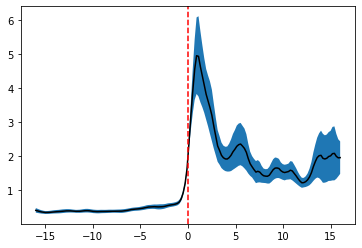

In [431]:
activity_measure = 'spatial_coordination'
x = np.linspace(-(len(combined_by_mouse)/2)*.2, (len(combined_by_mouse)/2)*.2, len(combined_by_mouse))
mean=combined_by_mouse.mean(axis=1, level=2)['velocity'].values
plt.plot(x, combined_by_mouse.mean(axis=1, level=2)['velocity'].values, color='k')
std_error = (combined_by_mouse.std(axis=1, level=2)['velocity'])/math.sqrt(combined_by_mouse.mean(axis=1, level=0).shape[1])
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.axvline(x=(0), linestyle='--', color='r')
plt.show()

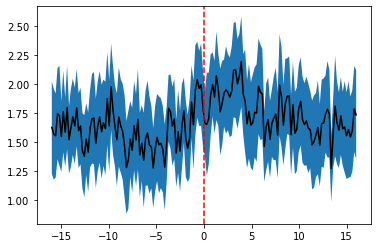

In [432]:
x = np.linspace(-(len(combined_by_mouse)/2)*.2, (len(combined_by_mouse)/2)*.2, len(combined_by_mouse))
mean = combined_by_mouse.mean(axis=1, level=2)[activity_measure].values
plt.plot(x, mean, color='k')
std_error = (combined_by_mouse.std(axis=1, level=2)[activity_measure])/math.sqrt(combined_by_mouse.mean(axis=1, level=0).shape[1])
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.axvline(x=0, linestyle='--', color='r')
plt.show()

In [438]:
#parallel implementation
def map_to_sparse_matrix(item_idx_tuple, current_row_num, sparse_matrix, orig_df_comparison):
    if orig_df_comparison.loc[current_row_num][item[0]] == 1 and (orig_df_comparison.loc[current_row_num][item[0]] == 1):
        sparse_matrix[current_row_num, item_idx] = 1
    else:
        pass
    return(sparse_matrix)

def map_to_sparse_matrix_time(time_index):
    #for time_index in tqdm(range(len(reindexed))):
    #coactivity_by_time_point = sparse.dok_matrix((1, len(cell_pairs)), dtype=np.float32)
    if time_index%100 == 0:
        print(time_index)
    for pair, pair_idx in zip(cell_pairs, range(len(cell_pairs))):
        if (reindexed.loc[time_index][pair[0]] == 1) and (reindexed.loc[time_index][pair[1]] == 1):
            coactivity_in_session_p[time_index, pair_idx] = 1
        else:
            pass
    return(coactivity_in_session)
    

In [440]:
# analyze by session in parallel

coactivity_by_session = {}
for session in tqdm(list(grouped_raw_data.keys())):
    cells_to_drop = np.array([cell for cell in range(1, len(grouped_raw_data[session]['cell_contours'])+1) if 
                              len(np.array(np.where(grouped_raw_data[session]['for_dims'][cell]>0.6)[0]))<100])
    filtered_centers_of_mass = grouped_raw_data[session]['com'].drop(cells_to_drop, axis =0)
    com_distances = utils_jjm.get_pairwise_distance_by_session(filtered_centers_of_mass)

    ##get binned fluorescence and calc Jaccard scores
    #arguments are sample widths to bin and z score thresholds
    cells_in_session = C_df.loc[session].dropna(axis=1).drop('msCamFrame', axis=1)
    binned_fluorescence = cells_in_session.apply(utils_jjm.binning_function_uncrop, args=[1, 4])

    reindexed = binned_fluorescence.set_index(int(x) for x in np.linspace(0, len(binned_fluorescence)-1, len(binned_fluorescence)))
    
    cell_pairs = np.array([pair for pair in itertools.combinations(list(reindexed.columns), 2)])
    coactivity_in_session_p = sparse.dok_matrix((len(reindexed), len(cell_pairs)))

    p=Pool(3)

    coactivity_in_session = p.map(map_to_sparse_matrix_time, range(len(reindexed)))
    coactivity_by_session[session] = coactivity_in_session












  0%|          | 0/13 [00:00<?, ?it/s]

0
1100
600
100
1200
700
200
1300
800
300
1400
900
400
1500
1000
500
1600
2100
1700
2200
2700
1800
2300
2800
1900
2400
2900
2000
2500
3000
3100
2600


KeyboardInterrupt: 

Process ForkPoolWorker-29:
Traceback (most recent call last):
  File "/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File "/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/multiprocessing/queues.py", line 341, in put
    obj = _ForkingPickler.dumps(obj)
  File "/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
KeyboardInterrupt
Process ForkPoolWorker-28:
Traceback (most recent call last):
  File "/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Us

In [ ]:
coactivity_by_session = {}

for session in tqdm(list(grouped_raw_data.keys())):
    cells_to_drop = np.array([cell for cell in range(1, len(grouped_raw_data[session]['cell_contours'])+1) if 
                              len(np.array(np.where(grouped_raw_data[session]['for_dims'][cell]>0.6)[0]))<100])
    filtered_centers_of_mass = grouped_raw_data[session]['com'].drop(cells_to_drop, axis =0)
    com_distances = utils_jjm.get_pairwise_distance_by_session(filtered_centers_of_mass)

    ##get binned fluorescence and calc Jaccard scores
    #arguments are sample widths to bin and z score thresholds
    cells_in_session = C_df.loc[session].dropna(axis=1).drop('msCamFrame', axis=1)
    binned_fluorescence = cells_in_session.apply(utils_jjm.binning_function_uncrop, args=[1, 2])

    reindexed = binned_fluorescence.set_index(int(x) for x in np.linspace(0, len(binned_fluorescence)-1, len(binned_fluorescence)))

#cell_keys_matrix = sparse.dok_matrix((1, len(reindexed.columns)*len(reindexed.columns)), dtype=np.float32)
    cell_pairs = np.array([pair for pair in itertools.combinations(list(reindexed.columns), 2)])
    coactivity_in_session = sparse.dok_matrix((len(reindexed), len(cell_pairs)))
    for time_index in tqdm(range(len(reindexed))):
        #coactivity_by_time_point = sparse.dok_matrix((1, len(cell_pairs)), dtype=np.float32)
        for pair, pair_idx in zip(cell_pairs, range(len(cell_pairs))):
            if (reindexed.loc[time_index][pair[0]] == 1) and (reindexed.loc[time_index][pair[1]] == 1):
                coactivity_in_session[time_index, pair_idx] = 1
            else:
                pass 
    
    coactivity_by_session[session]= {'coactivity_in_session': coactivity_in_session, 'cell_pairs':cell_pairs}

In [128]:
cell_pairs = np.array([pair for pair in itertools.combinations(list(reindexed.columns), 2)])
coactivity_in_session_p = sparse.dok_matrix((len(reindexed), len(cell_pairs)))

p=Pool(3)

coactivity_in_session = p.map(map_to_sparse_matrix_time, range(len(reindexed)))    

0
0
100
100
200
0
300
400
200
300
100
500
200
400
600
0
300
400
500
100
600
200
0
500
300
600
100
0
400
200
100
500
300
200
600
0
300
400
100
400
500
200
500
300
600
0
600
0
400
100
100
500
200
200
600
300
0
300
100
200
400
400
300
500
500
400
600
600
0
0
500
100
100
600
200
0
200
300
100
300
200
400
400
300
500
500
400
600
0
600
500
0
100
600
100
0
200
200
100
300
300
200
400
400
300
500
400
500
600
500
600
0
600
0
100
200
300
100
0
100
200
400
200
300
500
300
400
400
600
500
0
500
600
600
100
0
0
100
100
200
200
200
300
300
300
400
400
500
400
500
500
600
600
0
0
600
100
0
100
200
200
100
300
300
400
200
400
500
300
500
600
0
600
400
0
100
500
100
200
600
200
0
300
100
300
200
400
400
500
300
500
600
600
400
0
0
500
100
100
600
200
200
0
300
300
100
400
400
200
500
500
300
600
0
400
600
100
0
500
200
100
600
0
300
200
400
100
300
500
200
400
600
0
300
500
100
400
600
0
200
500
100
600
300
0
200
400
100
500
300
200
600
400
300
0
400
100
500
500
200
600
0
300
600
0
100
400
100
200
500


0
600
0
100
300
100
200
400
200
300
500
300
400
600
400
0
500
500
600
100
600
0
0
200
100
100
300
200
200
300
300
400
400
400
500
500
500
600
600
600
0
0
0
100
100
100
200
200
200
300
300
300
400
400
400
500
500
600
500
0
600
600
0
100
0
100
200
100
200
200
300
300
300
400
400
400
500
500
500
600
0
600
0
600
100
0
100
200
100
300
200
200
400
300
500
300
400
600
400
0
100
500
500
200
600
600
0
0
300
100
400
100
200
500
300
600
200
0
400
100
500
300
200
400
300
600
0
400
500
100
600
500
0
200
600
100
0
300
100
200
400
200
300
500
600
400
300
0
500
400
100
600
500
200
0
600
100
300
0
400
100
200
200
500
300
300
400
600
0
400
500
500
100
600
0
600
200
0
100
100
300
200
200
300
400
300
400
500
400
500
600
500
0
600
600
0
0
100
100
100
200
200
200
300
300
300
400
400
400
500
500
500
600
0
600
600
0
0
100
100
100
200
200
300
200
300
300
400
400
400
500
500
600
500
0
600
600
0
100
0
100
200
100
300
200
200
400
300
300
500
400
400
600
0
500
500
100
600
0
200
600
100
0
300
200
400
100
300
500
20

600
0
500
600
0
600
100
0
100
200
300
200
300
400
500
400
100
500
600
0
200
600
100
0
300
200
100
400
200
300
500
400
300
600
0
400
500
100
600
500
0
200
600
100
0
300
200
100
400
300
200
500
400
300
600
500
0
100
600
400
0
200
500
100
300
200
600
0
400
300
100
500
400
200
300
600
400
0
500
500
100
600
200
600
0
0
100
300
100
200
400
300
200
500
300
400
600
500
400
0
100
500
600
0
200
100
600
0
300
200
100
400
300
500
200
400
600
500
300
0
600
400
100
0
100
500
200
200
600
300
300
0
400
400
100
500
500
200
600
600
0
300
0
100
400
200
500
300
600
0
400
100
500
200
600
0
300
100
400
100
200
200
500
300
400
300
600
0
500
400
100
600
500
200
0
600
300
0
100
400
100
200
500
200
300
300
600
0
400
400
500
100
500
600
200
600
0
0
300
100
400
100
200
200
500
300
600
300
400
0
400
500
100
500
600
0
200
600
0
300
100
100
400
200
500
200
300
600
300
400
0
500
100
400
200
600
500
0
300
100
600
400
0
500
200
100
200
600
300
0
400
300
100
400
500
200
500
600
300
0
600
400
0
100
100
200
500
200
300
60

400
500
300
500
400
600
600
0
0
500
100
100
600
0
200
200
100
300
200
300
400
300
400
500
400
500
600
0
500
600
0
100
600
0
200
100
300
100
200
200
400
300
300
400
500
400
600
500
0
500
100
600
0
600
200
0
100
300
100
200
400
200
300
300
500
400
600
400
500
0
600
500
0
100
600
100
200
0
200
300
100
400
300
200
500
400
300
600
400
500
0
500
600
100
0
600
100
200
0
100
200
300
200
400
300
500
300
400
400
500
600
0
600
500
0
100
600
0
100
200
100
200
300
300
200
400
500
400
300
600
500
0
400
100
600
500
200
0
300
600
100
0
400
200
100
500
300
600
200
0
400
300
100
200
500
400
300
600
400
500
0
100
500
600
0
200
600
0
100
300
100
200
400
200
300
500
400
300
600
0
400
500
100
500
600
0
200
600
0
100
300
100
200
400
200
300
500
400
300
600
500
0
400
600
100
500
0
200
100
600
0
200
300
100
300
400
200
400
500
500
300
600
600
400
0
0
100
500
100
600
200
200
0
300
300
100
400
400
200
500
500
300
600
400
600
0
0
100
500
100
200
600
0
200
300
100
400
300
200
500
400
300
600
500
0
400
600
500
100


300
500
400
500
500
600
600
0
0
600
0
100
100
200
100
200
200
300
300
300
400
400
400
500
500
500
600
600
0
600
100
0
0
200
100
100
300
200
200
400
300
300
500
400
400
500
600
500
0
600
600
100
0
0
200
100
100
200
300
200
300
400
300
500
400
400
500
600
500
0
600
0
600
100
0
200
100
100
300
200
200
300
400
300
400
500
400
500
500
600
0
600
600
0
100
0
100
100
200
200
300
200
300
300
400
400
500
400
500
600
500
0
600
600
100
0
0
100
100
200
200
300
200
400
300
300
400
500
400
600
500
500
0
600
600
100
0
0
100
100
200
300
200
200
300
300
400
400
500
400
600
500
500
0
600
600
100
0
0
200
100
100
300
200
200
400
300
300
500
400
400
600
500
500
0
100
600
600
0
0
200
100
100
300
200
200
400
300
300
500
400
400
600
0
500
500
100
600
600
0
200
0
100
300
100
200
400
200
300
500
300
400
600
400
0
500
500
100
600
0
600
200
0
100
300
100
400
200
200
300
500
300
400
600
400
0
500
100
500
600
0
200
600
0
100
300
100
200
400
200
300
500
300
400
600
0
400
500
100
500
600
200
0
600
0
100
300
100
400
20

Process ForkPoolWorker-24:
Process ForkPoolWorker-22:
Process ForkPoolWorker-23:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
Traceback (most recent call last):
  File "/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/multiprocessing/pool.py", line 125, in w

0
0
100
100
200
300
400
200
500
0
300
600
400
0
500
100
600
200
0
300
100
100
400
200
200
500
300
300
600
400
0
400
100
500
500
200
600
600
0
0
100
100
300
200
200
300
300
400
400
500
400
600
500
0
500
100
600
600
0
0
200
100
100
300
200
200
400
300
300
500
400
600
400
0
500
500
100
600
600
200
0
0
300
100
100
400
200
200
500
300
300
600
400
0
500
100
400
600
200
0
500
300
100
400
200
600
0
500
300
600
400
100
0
100
500
200
600
200
300
0
400
100
200
500
300
600
0
300
400
400
100
500
500
200
600
600
0
300
0
100
400
100
200
500
300
200
600
400
0
300
500
100
400
600
0
200
500
100
600
300
0
200
400
100
300
500
200
400
600
300
0
500
400
600
100
0
500
200
600
0
100
300
100
200
400
200
300
500
300
400
400
600
0
500
500
100
600
0
600
200
0
100
300
200
100
400
300
200
500
400
300
600
500
0
400
100
600
500
0
200
600
100
0
300
200
100
400
300
200
400
500
300
500
600
600
0
400
0
500
100
100
200
600
200
0
300
300
400
100
400
500
200
600
500
0
300
100
600
0
200
400
100
500
300
200
600
400
0
300
100


100
400
200
400
500
300
600
500
0
400
600
100
500
0
200
600
0
100
300
100
200
400
200
500
300
300
600
0
400
400
100
500
200
500
600
0
300
600
100
0
400
200
100
500
300
600
200
400
0
500
100
300
600
200
0
400
100
300
500
200
400
300
600
500
0
400
600
0
500
100
100
600
0
200
200
100
300
300
200
400
300
400
500
600
400
500
0
500
600
100
0
600
200
0
100
100
300
400
200
200
300
500
300
600
400
400
500
500
600
0
600
0
100
0
200
100
100
300
200
200
400
300
300
500
400
600
400
0
500
500
100
600
0
200
600
100
0
300
200
100
400
300
500
400
200
600
0
500
300
100
600
200
0
400
100
300
500
200
400
600
300
0
500
400
100
600
0
500
200
100
600
0
200
100
300
300
200
400
400
300
500
400
500
600
0
500
600
0
600
100
0
200
100
100
300
200
200
400
300
500
300
400
600
0
500
400
100
600
0
200
500
100
300
600
0
200
400
300
100
500
400
600
200
0
500
100
600
300
0
200
100
400
300
200
400
500
300
500
600
0
400
600
0
100
500
100
600
200
0
200
100
300
300
200
400
500
300
400
600
400
0
500
500
100
600
600
200
0
0
10

400
300
300
500
400
400
600
0
500
500
600
600
100
0
0
200
100
100
200
200
300
300
400
400
500
500
600
600
0
0
100
100
300
200
200
300
300
400
400
500
500
600
600
0
0
400
100
100
200
200
300
300
500
400
400
600
500
500
0
600
600
0
0
100
100
100
200
200
300
300
400
400
200
500
500
300
600
600
0
0
400
100
100
500
200
200
600
300
300
0
400
400
500
500
100
600
0
600
0
100
100
200
200
200
300
300
400
400
500
300
500
600
0
600
0
400
100
100
200
500
300
200
400
300
600
0
500
400
600
500
100
0
600
0
100
200
200
100
200
300
300
400
500
400
300
600
500
0
400
100
500
600
0
600
200
0
100
300
200
400
100
300
500
200
400
600
0
500
100
600
200
0
300
300
100
400
200
500
300
400
600
0
400
500
100
500
600
0
600
200
0
100
300
200
400
300
500
100
400
600
0
500
100
200
600
0
200
100
300
300
200
400
300
400
500
400
500
600
500
0
600
0
600
100
0
100
200
100
200
200
300
400
300
300
400
500
400
500
600
0
500
600
0
600
100
0
100
200
100
200
300
200
300
400
400
300
500
500
600
600
400
0
0
100
500
100
200
200
300


0
100
300
100
200
200
400
300
300
500
400
600
400
500
0
500
600
100
0
600
0
200
100
100
300
200
200
400
300
300
400
400
500
500
600
0
600
100
0
200
100
200
300
300
400
500
600
400
500
0
500
600
100
0
600
0
100
100
200
200
300
300
400
400
500
500
600
0
600
0
100
100
200
200
300
200
300
400
400
500
500
600
600
0
300
100
400
0
200
100
500
600
300
200
0
400
300
100
500
400
600
500
0
600
100
0
200
100
200
300
200
400
300
400
500
300
600
500
0
400
600
0
100
500
100
200
600
200
0
300
400
100
300
500
200
400
600
0
500
300
100
600
0
200
100
400
300
200
500
400
600
500
0
300
600
100
400
0
100
500
200
200
600
0
300
300
100
400
400
200
500
300
600
400
500
0
600
100
500
0
100
600
200
0
300
200
100
400
200
300
500
300
400
600
0
400
500
100
500
200
600
600
0
0
300
100
100
400
200
500
300
600
0
400
500
100
200
600
200
0
300
100
400
200
500
300
600
400
0
500
100
600
200
0
300
100
200
400
300
300
500
400
600
0
400
500
100
600
500
0
600
200
100
300
0
200
100
300
400
400
200
500
500
600
0
600
0
300
100
10

100
300
200
200
400
300
300
500
400
600
400
0
500
500
100
600
600
200
0
0
100
300
100
200
400
200
300
500
300
400
600
0
400
500
100
500
600
0
600
200
0
100
300
100
200
400
200
300
500
300
400
600
0
500
400
100
600
500
0
200
100
300
200
600
400
0
300
100
500
200
400
600
0
500
300
100
600
0
400
200
100
300
500
200
400
600
300
0
500
400
100
600
500
0
100
600
0
200
100
300
200
400
300
500
400
600
500
0
200
600
0
100
300
100
200
400
200
300
300
400
500
400
500
600
0
500
600
0
100
600
0
100
200
200
100
300
300
200
400
300
400
400
500
500
500
600
600
600
0
0
0
100
100
100
200
200
200
300
300
400
400
300
500
500
600
400
0
600
0
100
500
100
200
600
200
300
0
300
400
100
400
500
200
500
600
0
600
0
300
100
100
400
200
200
300
300
400
400
500
500
500
600
600
0
0
600
0
100
100
100
200
200
200
300
300
300
400
400
400
500
500
600
500
0
600
100
600
0
0
200
100
100
200
200
300
300
300
400
400
400
500
500
500
600
0
600
600
0
100
0
100
200
100
200
300
200
300
400
300
400
500
400
600
500
0
600
500
100
0
